In [1]:
import os

# Add Git path to the PATH environment variable
os.environ['PATH'] += os.pathsep + r"C:\Users\boughrio\AppData\Local\Programs\Git\cmd"

# Now try installing the package again
!pip install git+https://github.com/SarraBoughriou/codecarbon.git

  Cloning https://github.com/SarraBoughriou/codecarbon.git to c:\users\boughrio\appdata\local\temp\pip-req-build-lbiethb4
  Resolved https://github.com/SarraBoughriou/codecarbon.git to commit 45394c0f5a663031a19ec4cb55066501331a396c
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/SarraBoughriou/codecarbon.git 'C:\Users\boughrio\AppData\Local\Temp\pip-req-build-lbiethb4'


In [2]:
!pip install opencv-python
!pip install tensorflow


[codecarbon WARNING @ 11:56:19] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 11:56:19] [setup] RAM Tracking...
[codecarbon INFO @ 11:56:19] [setup] GPU Tracking...
[codecarbon INFO @ 11:56:19] No GPU found.
[codecarbon INFO @ 11:56:19] [setup] CPU Tracking...
[codecarbon WARNING @ 11:56:19] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:56:21] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 11:56:21] >>> Tracker's metadata:
[codecarbon INFO @ 11:56:21]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 11:56:21]   Python version: 3.11.7
[codecarbon INFO @ 11:56:21]   CodeCarbon version: 2.4.3rc1
[codecarbon INFO @ 11:56:21]   Available RAM : 15.690 GB
[codecarbon INFO @ 11:56:21]   CPU count: 12
[codecarbon INFO @ 11:56:21]   CPU model: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 11:56:21]   GPU count: None
[codecarbon INFO @ 11:56:21

Training data shape :  (50000, 32, 32, 3) (50000, 1)
Testing data shape :  (10000, 32, 32, 3) (10000, 1)
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : [3]')

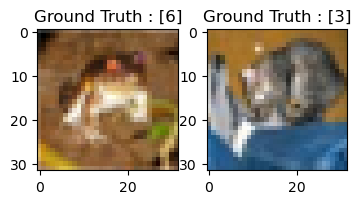

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from codecarbon import EmissionsTracker


trackerTot= EmissionsTracker()
trackerTot.start()

tracker= EmissionsTracker()
tracker.start()

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels)  = tf.keras.datasets.cifar10.load_data()

# Print shapes of training and testing data
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : ', test_images.shape, test_labels.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_labels)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Display the first image in training and testing data
plt.figure(figsize=[4,2])
plt.subplot(121)
plt.imshow(train_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[0]))

plt.subplot(122)
plt.imshow(test_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[0]))

Number of black images: 1


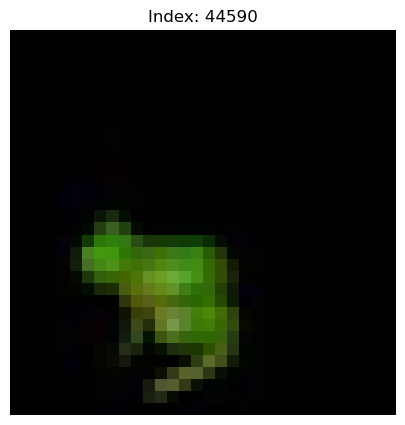

Shape of cleaned dataset: (49999, 32, 32, 3) (49999, 1)
Black images deleted.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Function to check if an image is black
def is_black(image, threshold=10):
    # Compute the average pixel intensity
    avg_intensity = np.mean(image)
    # Return True if the average intensity is below the threshold, indicating a "black" image
    return avg_intensity < threshold

# Define a function to iterate through images and check for blackness
def check_black(images, threshold=10):
    black_indices = []
    for i, image in enumerate(images):
        if is_black(image, threshold):
            black_indices.append(i)
    return black_indices

# Function to display images with their indices
def display_images_with_indices(images, indices):
    plt.figure(figsize=(10, 5))
    num_images = len(indices)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Index: {idx}")
        plt.axis('off')
    plt.show()

# Check for black images
black_indices = check_black(train_images)

# Print the number of black images
print("Number of black images:", len(black_indices))

# Display the black images along with their indices
display_images_with_indices(train_images, black_indices)


# Remove blurry images from the dataset using their indices
train_images = np.delete(train_images, black_indices, axis=0)
train_labels = np.delete(train_labels, black_indices, axis=0)

# Print the shape of the cleaned dataset
print("Shape of cleaned dataset:", train_images.shape, train_labels.shape)
print("Black images deleted.")





In [5]:
# Reshape and preprocess the training and testing data
nRows,nCols,nDims = train_images.shape[1:]
train_data = train_images.reshape(train_images.shape[0], nRows, nCols, nDims)
test_data = test_images.reshape(test_images.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_data /= 255
test_data /= 255

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2, # Additional augmentation
    shear_range=0.2 # Additional augmentation
)

datagen.fit(train_images)
# Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

print('Original label 0 : ', train_labels[0])
print('After conversion to categorical ( one-hot ) : ', train_labels_one_hot[0])

print("Shape of final dataset:", train_data.shape, train_labels.shape)


emissions: float = tracker.stop()
print(f"PreProcessing Emissions:{emissions} Kg")

[codecarbon INFO @ 11:56:33] Energy consumed for RAM : 0.000004 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:56:33] Energy consumed for all CPUs : 0.000025 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:56:33] 0.00002896721344282279 kWh of electricity used since the beginning.


Original label 0 :  [6]
After conversion to categorical ( one-hot ) :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Shape of final dataset: (49999, 32, 32, 3) (49999, 1)
PreProcessing Emissions:1.144102134737e-06 Kg


C:\Users\boughrio\AppData\Local\anaconda3\Lib\site-packages\codecarbon\output_methods\file.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])


In [6]:
# Define VGG19 model
def build_vgg19(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    # Block 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))) # Add L2 regularization
    model.add(layers.Dropout(0.5))  # Add dropout for regularization
    model.add(layers.Dense(4096, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))) # Add L2 regularization
    model.add(layers.Dropout(0.5))  # Add dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


# Build the VGG19 model
model = build_vgg19()

# Compile the model with a lower learning rate
optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler
def lr_schedule(epoch):
    lr = 1e-4
    if epoch > 75:
        lr *= 0.5e-3
    elif epoch > 50:
        lr *= 1e-3
    elif epoch > 25:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)




tracker= EmissionsTracker()
tracker.start()
# Train the model with data augmentation
history = model.fit(datagen.flow(train_images, train_labels_one_hot, batch_size=256),
                    epochs=200,
                    validation_data=(test_images, test_labels_one_hot),
                    callbacks=[lr_scheduler, early_stopping])

emissions: float = tracker.stop()
print(f"Training Emissions:{emissions} Kg")


C:\Users\boughrio\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[codecarbon WARNING @ 11:56:33] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 11:56:33] [setup] RAM Tracking...
[codecarbon INFO @ 11:56:33] [setup] GPU Tracking...
[codecarbon INFO @ 11:56:33] No GPU found.
[codecarbon INFO @ 11:56:33] [setup] CPU Tracking...
[codecarbon WARNING @ 11:56:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:56:35] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 11:56:35] >>> Tracker's metadata:
[codecarbon INFO @ 11:56:35]   Platform system: Windows-10-10.0.19045-SP0
[codecar

Epoch 1/200


[codecarbon INFO @ 11:56:40] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:56:40] Energy consumed for all CPUs : 0.000136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:56:40] 0.00016007967945517608 kWh of electricity used since the beginning.
C:\Users\boughrio\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/196 ━━━━━━━━━━━━━━━━━━━━ 11:00 3s/step - accuracy: 0.1113 - loss: 7.3002 

[codecarbon INFO @ 11:56:54] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:56:54] Energy consumed for all CPUs : 0.000136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:56:54] 0.00016032144751113329 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:56:55] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:56:55] Energy consumed for all CPUs : 0.000271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:56:55] 0.00032027553235340774 kWh of electricity used since the beginning.


  6/196 ━━━━━━━━━━━━━━━━━━━━ 11:36 4s/step - accuracy: 0.1100 - loss: 7.2531

[codecarbon INFO @ 11:57:09] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:57:09] Energy consumed for all CPUs : 0.000272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:57:09] 0.00032065723462434709 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:57:10] Energy consumed for RAM : 0.000074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:57:10] Energy consumed for all CPUs : 0.000407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:57:10] 0.00048059083981652045 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:22 4s/step - accuracy: 0.1090 - loss: 7.2075

[codecarbon INFO @ 11:57:24] Energy consumed for RAM : 0.000074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:57:24] Energy consumed for all CPUs : 0.000408 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:57:24] 0.00048124830873504945 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:57:25] Energy consumed for RAM : 0.000098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:57:25] Energy consumed for all CPUs : 0.000543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:57:25] 0.00064144528962791544 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 11:23 4s/step - accuracy: 0.1090 - loss: 7.1629

[codecarbon INFO @ 11:57:39] Energy consumed for RAM : 0.000098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:57:39] Energy consumed for all CPUs : 0.000543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:57:39] 0.00064106609779872726 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:57:40] Energy consumed for RAM : 0.000123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:57:40] Energy consumed for all CPUs : 0.000679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:57:40] 0.00080201997571863182 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 11:18 4s/step - accuracy: 0.1090 - loss: 7.1300

[codecarbon INFO @ 11:57:54] Energy consumed for RAM : 0.000123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:57:54] Energy consumed for all CPUs : 0.000679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:57:54] 0.00080126829423389511 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 11:12 4s/step - accuracy: 0.1089 - loss: 7.1190

[codecarbon INFO @ 11:57:55] Energy consumed for RAM : 0.000147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:57:55] Energy consumed for all CPUs : 0.000815 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:57:55] 0.00096237344784779128 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 11:04 4s/step - accuracy: 0.1084 - loss: 7.0864

[codecarbon INFO @ 11:58:09] Energy consumed for RAM : 0.000147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:58:09] Energy consumed for all CPUs : 0.000814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:58:09] 0.00096121898749973347 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:58 4s/step - accuracy: 0.1084 - loss: 7.0755

[codecarbon INFO @ 11:58:10] Energy consumed for RAM : 0.000172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:58:10] Energy consumed for all CPUs : 0.000951 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:58:10] 0.00112294495012672389 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:51 4s/step - accuracy: 0.1081 - loss: 7.0431

[codecarbon INFO @ 11:58:24] Energy consumed for RAM : 0.000172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:58:24] Energy consumed for all CPUs : 0.000950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:58:24] 0.00112179532328928063 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:46 4s/step - accuracy: 0.1080 - loss: 7.0323

[codecarbon INFO @ 11:58:25] Energy consumed for RAM : 0.000196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:58:25] Energy consumed for all CPUs : 0.001086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:58:25] 0.00128268295057251897 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:34 4s/step - accuracy: 0.1077 - loss: 7.0002

[codecarbon INFO @ 11:58:39] Energy consumed for RAM : 0.000196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:58:39] Energy consumed for all CPUs : 0.001085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:58:39] 0.00128183379162518101 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:29 4s/step - accuracy: 0.1076 - loss: 6.9897

[codecarbon INFO @ 11:58:40] Energy consumed for RAM : 0.000221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:58:40] Energy consumed for all CPUs : 0.001222 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:58:40] 0.00144266115025651733 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 10:19 4s/step - accuracy: 0.1078 - loss: 6.9582

[codecarbon INFO @ 11:58:54] Energy consumed for RAM : 0.000221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:58:54] Energy consumed for all CPUs : 0.001221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:58:54] 0.00144226240482087098 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:58:55] Energy consumed for RAM : 0.000245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:58:55] Energy consumed for all CPUs : 0.001357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:58:55] 0.00160272749136135956 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 10:06 4s/step - accuracy: 0.1088 - loss: 6.9167

[codecarbon INFO @ 11:59:09] Energy consumed for RAM : 0.000246 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:59:09] Energy consumed for all CPUs : 0.001357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:59:09] 0.00160272436893241980 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:59:10] Energy consumed for RAM : 0.000270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:59:10] Energy consumed for all CPUs : 0.001493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:59:10] 0.00176298518996370764 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:52 4s/step - accuracy: 0.1101 - loss: 6.8759

[codecarbon INFO @ 11:59:24] Energy consumed for RAM : 0.000270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:59:24] Energy consumed for all CPUs : 0.001493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:59:24] 0.00176320505275521892 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:59:25] Energy consumed for RAM : 0.000295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:59:25] Energy consumed for all CPUs : 0.001629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:59:25] 0.00192321567708265647 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:36 4s/step - accuracy: 0.1114 - loss: 6.8359

[codecarbon INFO @ 11:59:39] Energy consumed for RAM : 0.000295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:59:39] Energy consumed for all CPUs : 0.001629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:59:39] 0.00192374395458550255 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:59:40] Energy consumed for RAM : 0.000319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:59:40] Energy consumed for all CPUs : 0.001765 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:59:40] 0.00208400591667000932 kWh of electricity used since the beginning.


 48/196 ━━━━━━━━━━━━━━━━━━━━ 9:26 4s/step - accuracy: 0.1124 - loss: 6.8064

[codecarbon INFO @ 11:59:54] Energy consumed for RAM : 0.000319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:59:54] Energy consumed for all CPUs : 0.001765 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:59:54] 0.00208393764942063110 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 9:25 4s/step - accuracy: 0.1128 - loss: 6.7967

[codecarbon INFO @ 11:59:55] Energy consumed for RAM : 0.000344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 11:59:55] Energy consumed for all CPUs : 0.001901 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 11:59:55] 0.00224423592000859429 kWh of electricity used since the beginning.


 52/196 ━━━━━━━━━━━━━━━━━━━━ 9:15 4s/step - accuracy: 0.1138 - loss: 6.7678

[codecarbon INFO @ 12:00:09] Energy consumed for RAM : 0.000344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:00:09] Energy consumed for all CPUs : 0.001900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:00:09] 0.00224389572243921922 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:00:10] Energy consumed for RAM : 0.000368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:00:10] Energy consumed for all CPUs : 0.002036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:00:10] 0.00240387924229536719 kWh of electricity used since the beginning.


 56/196 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - accuracy: 0.1152 - loss: 6.7299

[codecarbon INFO @ 12:00:24] Energy consumed for RAM : 0.000368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:00:24] Energy consumed for all CPUs : 0.002036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:00:24] 0.00240443553231585146 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:00:25] Energy consumed for RAM : 0.000393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:00:25] Energy consumed for all CPUs : 0.002171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:00:25] 0.00256417881554205909 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:54 4s/step - accuracy: 0.1163 - loss: 6.7018

[codecarbon INFO @ 12:00:39] Energy consumed for RAM : 0.000393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:00:39] Energy consumed for all CPUs : 0.002172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:00:39] 0.00256468365156338864 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:00:40] Energy consumed for RAM : 0.000417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:00:40] Energy consumed for all CPUs : 0.002307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:00:40] 0.00272416051369678107 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 8:39 4s/step - accuracy: 0.1177 - loss: 6.6649

[codecarbon INFO @ 12:00:55] Energy consumed for RAM : 0.000417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:00:55] Energy consumed for all CPUs : 0.002308 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:00:55] 0.00272534954641545472 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:00:56] Energy consumed for RAM : 0.000442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:00:56] Energy consumed for all CPUs : 0.002443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:00:56] 0.00288459830781425969 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 8:22 4s/step - accuracy: 0.1192 - loss: 6.6287

[codecarbon INFO @ 12:01:10] Energy consumed for RAM : 0.000442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:01:10] Energy consumed for all CPUs : 0.002443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:01:10] 0.00288541469809370675 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 8:17 4s/step - accuracy: 0.1195 - loss: 6.6197

[codecarbon INFO @ 12:01:11] Energy consumed for RAM : 0.000466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:01:11] Energy consumed for all CPUs : 0.002579 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:01:11] 0.00304514259488711811 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 8:07 4s/step - accuracy: 0.1205 - loss: 6.5930

[codecarbon INFO @ 12:01:25] Energy consumed for RAM : 0.000467 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:01:25] Energy consumed for all CPUs : 0.002580 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:01:25] 0.00304615102166771318 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:01:26] Energy consumed for RAM : 0.000491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:01:26] Energy consumed for all CPUs : 0.002714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:01:26] 0.00320527534947239682 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:52 4s/step - accuracy: 0.1219 - loss: 6.5579

[codecarbon INFO @ 12:01:40] Energy consumed for RAM : 0.000491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:01:40] Energy consumed for all CPUs : 0.002715 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:01:40] 0.00320640132349570223 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:01:41] Energy consumed for RAM : 0.000516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:01:41] Energy consumed for all CPUs : 0.002850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:01:41] 0.00336575332643150160 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:37 4s/step - accuracy: 0.1231 - loss: 6.5234

[codecarbon INFO @ 12:01:55] Energy consumed for RAM : 0.000516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:01:55] Energy consumed for all CPUs : 0.002851 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:01:55] 0.00336663022329474707 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:01:56] Energy consumed for RAM : 0.000540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:01:56] Energy consumed for all CPUs : 0.002986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:01:56] 0.00352604476520794853 kWh of electricity used since the beginning.


 82/196 ━━━━━━━━━━━━━━━━━━━━ 7:26 4s/step - accuracy: 0.1241 - loss: 6.4979

[codecarbon INFO @ 12:02:10] Energy consumed for RAM : 0.000540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:02:10] Energy consumed for all CPUs : 0.002987 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:02:10] 0.00352722571093931582 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:02:11] Energy consumed for RAM : 0.000565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:02:11] Energy consumed for all CPUs : 0.003122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:02:11] 0.00368648620267665724 kWh of electricity used since the beginning.


 86/196 ━━━━━━━━━━━━━━━━━━━━ 7:10 4s/step - accuracy: 0.1253 - loss: 6.4643

[codecarbon INFO @ 12:02:25] Energy consumed for RAM : 0.000565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:02:25] Energy consumed for all CPUs : 0.003122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:02:25] 0.00368702363408073344 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:02:26] Energy consumed for RAM : 0.000589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:02:26] Energy consumed for all CPUs : 0.003257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:02:26] 0.00384661377765154605 kWh of electricity used since the beginning.


 90/196 ━━━━━━━━━━━━━━━━━━━━ 6:53 4s/step - accuracy: 0.1265 - loss: 6.4312

[codecarbon INFO @ 12:02:40] Energy consumed for RAM : 0.000589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:02:40] Energy consumed for all CPUs : 0.003258 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:02:40] 0.00384751145981479395 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:49 4s/step - accuracy: 0.1268 - loss: 6.4230

[codecarbon INFO @ 12:02:41] Energy consumed for RAM : 0.000614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:02:41] Energy consumed for all CPUs : 0.003393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:02:41] 0.00400674073175689115 kWh of electricity used since the beginning.


 94/196 ━━━━━━━━━━━━━━━━━━━━ 6:37 4s/step - accuracy: 0.1276 - loss: 6.3987

[codecarbon INFO @ 12:02:55] Energy consumed for RAM : 0.000614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:02:55] Energy consumed for all CPUs : 0.003394 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:02:55] 0.00400819588016625237 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:02:56] Energy consumed for RAM : 0.000638 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:02:56] Energy consumed for all CPUs : 0.003529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:02:56] 0.00416711363782326129 kWh of electricity used since the beginning.


 98/196 ━━━━━━━━━━━━━━━━━━━━ 6:21 4s/step - accuracy: 0.1287 - loss: 6.3667

[codecarbon INFO @ 12:03:10] Energy consumed for RAM : 0.000639 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:03:10] Energy consumed for all CPUs : 0.003530 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:03:10] 0.00416870476112390920 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:03:11] Energy consumed for RAM : 0.000663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:03:11] Energy consumed for all CPUs : 0.003665 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:03:11] 0.00432743411514147601 kWh of electricity used since the beginning.


102/196 ━━━━━━━━━━━━━━━━━━━━ 6:03 4s/step - accuracy: 0.1297 - loss: 6.3354

[codecarbon INFO @ 12:03:25] Energy consumed for RAM : 0.000663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:03:25] Energy consumed for all CPUs : 0.003666 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:03:25] 0.00432860360892980186 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 6:00 4s/step - accuracy: 0.1299 - loss: 6.3276

[codecarbon INFO @ 12:03:26] Energy consumed for RAM : 0.000687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:03:26] Energy consumed for all CPUs : 0.003800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:03:26] 0.00448775051257057928 kWh of electricity used since the beginning.


106/196 ━━━━━━━━━━━━━━━━━━━━ 5:48 4s/step - accuracy: 0.1306 - loss: 6.3046

[codecarbon INFO @ 12:03:40] Energy consumed for RAM : 0.000688 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:03:40] Energy consumed for all CPUs : 0.003801 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:03:40] 0.00448898323122193677 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:44 4s/step - accuracy: 0.1309 - loss: 6.2970

[codecarbon INFO @ 12:03:41] Energy consumed for RAM : 0.000712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:03:41] Energy consumed for all CPUs : 0.003936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:03:41] 0.00464757425199381104 kWh of electricity used since the beginning.


110/196 ━━━━━━━━━━━━━━━━━━━━ 5:32 4s/step - accuracy: 0.1315 - loss: 6.2742

[codecarbon INFO @ 12:03:55] Energy consumed for RAM : 0.000712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:03:55] Energy consumed for all CPUs : 0.003938 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:03:55] 0.00464989269204661281 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:03:56] Energy consumed for RAM : 0.000736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:03:56] Energy consumed for all CPUs : 0.004071 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:03:56] 0.00480766768196403717 kWh of electricity used since the beginning.


114/196 ━━━━━━━━━━━━━━━━━━━━ 5:18 4s/step - accuracy: 0.1324 - loss: 6.2442

[codecarbon INFO @ 12:04:10] Energy consumed for RAM : 0.000737 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:04:10] Energy consumed for all CPUs : 0.004074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:04:10] 0.00481142766382176325 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:04:11] Energy consumed for RAM : 0.000761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:04:11] Energy consumed for all CPUs : 0.004207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:04:11] 0.00496823902050042791 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.1332 - loss: 6.2144

[codecarbon INFO @ 12:04:25] Energy consumed for RAM : 0.000762 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:04:25] Energy consumed for all CPUs : 0.004210 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:04:25] 0.00497126384886991714 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:04:26] Energy consumed for RAM : 0.000786 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:04:26] Energy consumed for all CPUs : 0.004343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:04:26] 0.00512854559615147452 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - accuracy: 0.1338 - loss: 6.1923

[codecarbon INFO @ 12:04:40] Energy consumed for RAM : 0.000786 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:04:40] Energy consumed for all CPUs : 0.004345 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:04:40] 0.00513132588557942484 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:47 4s/step - accuracy: 0.1340 - loss: 6.1850

[codecarbon INFO @ 12:04:41] Energy consumed for RAM : 0.000810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:04:41] Energy consumed for all CPUs : 0.004478 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:04:41] 0.00528851376632257300 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:36 4s/step - accuracy: 0.1346 - loss: 6.1631

[codecarbon INFO @ 12:04:55] Energy consumed for RAM : 0.000811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:04:55] Energy consumed for all CPUs : 0.004482 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:04:55] 0.00529216480783623478 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:04:56] Energy consumed for RAM : 0.000835 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:04:56] Energy consumed for all CPUs : 0.004614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:04:56] 0.00544876893145691821 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:21 4s/step - accuracy: 0.1353 - loss: 6.1343

[codecarbon INFO @ 12:05:10] Energy consumed for RAM : 0.000835 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:05:10] Energy consumed for all CPUs : 0.004617 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:05:10] 0.00545263372644060485 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:05:11] Energy consumed for RAM : 0.000859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:05:11] Energy consumed for all CPUs : 0.004750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:05:11] 0.00560960609046693912 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 4:09 4s/step - accuracy: 0.1359 - loss: 6.1129

[codecarbon INFO @ 12:05:26] Energy consumed for RAM : 0.000860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:05:26] Energy consumed for all CPUs : 0.004753 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:05:26] 0.00561310605822083926 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 4:06 4s/step - accuracy: 0.1360 - loss: 6.1058

[codecarbon INFO @ 12:05:26] Energy consumed for RAM : 0.000884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:05:26] Energy consumed for all CPUs : 0.004886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:05:26] 0.00576942370191760399 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:55 4s/step - accuracy: 0.1365 - loss: 6.0847

[codecarbon INFO @ 12:05:41] Energy consumed for RAM : 0.000885 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:05:41] Energy consumed for all CPUs : 0.004890 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:05:41] 0.00577501071407749301 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:05:41] Energy consumed for RAM : 0.000908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:05:41] Energy consumed for all CPUs : 0.005022 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:05:41] 0.00593021420814162509 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:39 4s/step - accuracy: 0.1372 - loss: 6.0569

[codecarbon INFO @ 12:05:56] Energy consumed for RAM : 0.000909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:05:56] Energy consumed for all CPUs : 0.005026 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:05:56] 0.00593468721638790424 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:05:56] Energy consumed for RAM : 0.000933 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:05:56] Energy consumed for all CPUs : 0.005158 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:05:56] 0.00609068600788647673 kWh of electricity used since the beginning.


143/196 ━━━━━━━━━━━━━━━━━━━━ 3:27 4s/step - accuracy: 0.1376 - loss: 6.0362

[codecarbon INFO @ 12:06:11] Energy consumed for RAM : 0.000934 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:06:11] Energy consumed for all CPUs : 0.005161 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:06:11] 0.00609485213817628248 kWh of electricity used since the beginning.


144/196 ━━━━━━━━━━━━━━━━━━━━ 3:24 4s/step - accuracy: 0.1378 - loss: 6.0294

[codecarbon INFO @ 12:06:11] Energy consumed for RAM : 0.000957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:06:11] Energy consumed for all CPUs : 0.005293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:06:11] 0.00625056057940292370 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - accuracy: 0.1382 - loss: 6.0090

[codecarbon INFO @ 12:06:26] Energy consumed for RAM : 0.000958 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:06:26] Energy consumed for all CPUs : 0.005298 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:06:26] 0.00625599151500717821 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:06:26] Energy consumed for RAM : 0.000982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:06:26] Energy consumed for all CPUs : 0.005429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:06:26] 0.00641120518371094978 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:56 4s/step - accuracy: 0.1388 - loss: 5.9821

[codecarbon INFO @ 12:06:41] Energy consumed for RAM : 0.000983 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:06:41] Energy consumed for all CPUs : 0.005433 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:06:41] 0.00641606711809546842 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:06:41] Energy consumed for RAM : 0.001007 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:06:41] Energy consumed for all CPUs : 0.005565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:06:41] 0.00657132386458424231 kWh of electricity used since the beginning.


155/196 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - accuracy: 0.1394 - loss: 5.9555

[codecarbon INFO @ 12:06:56] Energy consumed for RAM : 0.001007 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:06:56] Energy consumed for all CPUs : 0.005569 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:06:56] 0.00657678429370453423 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:06:57] Energy consumed for RAM : 0.001031 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:06:57] Energy consumed for all CPUs : 0.005701 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:06:57] 0.00673225622139800826 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - accuracy: 0.1399 - loss: 5.9293

[codecarbon INFO @ 12:07:11] Energy consumed for RAM : 0.001032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:07:11] Energy consumed for all CPUs : 0.005705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:07:11] 0.00673736680384235710 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:07:12] Energy consumed for RAM : 0.001056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:07:12] Energy consumed for all CPUs : 0.005837 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:07:12] 0.00689255012305397922 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - accuracy: 0.1405 - loss: 5.9034

[codecarbon INFO @ 12:07:26] Energy consumed for RAM : 0.001057 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:07:26] Energy consumed for all CPUs : 0.005841 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:07:26] 0.00689798311629401424 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:07:27] Energy consumed for RAM : 0.001080 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:07:27] Energy consumed for all CPUs : 0.005973 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:07:27] 0.00705302805230385941 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - accuracy: 0.1410 - loss: 5.8778

[codecarbon INFO @ 12:07:41] Energy consumed for RAM : 0.001081 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:07:41] Energy consumed for all CPUs : 0.005977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:07:41] 0.00705822351187560849 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:07:42] Energy consumed for RAM : 0.001105 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:07:42] Energy consumed for all CPUs : 0.006108 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:07:42] 0.00721339437160482821 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - accuracy: 0.1415 - loss: 5.8526

[codecarbon INFO @ 12:07:56] Energy consumed for RAM : 0.001106 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:07:56] Energy consumed for all CPUs : 0.006113 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:07:56] 0.00721834035774003655 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - accuracy: 0.1417 - loss: 5.8463

[codecarbon INFO @ 12:07:57] Energy consumed for RAM : 0.001130 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:07:57] Energy consumed for all CPUs : 0.006245 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:07:57] 0.00737428156001216327 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - accuracy: 0.1422 - loss: 5.8215

[codecarbon INFO @ 12:08:11] Energy consumed for RAM : 0.001130 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:08:11] Energy consumed for all CPUs : 0.006249 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:08:11] 0.00737889022968960927 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:08:12] Energy consumed for RAM : 0.001154 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:08:12] Energy consumed for all CPUs : 0.006381 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:08:12] 0.00753467898513557766 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - accuracy: 0.1427 - loss: 5.7970

[codecarbon INFO @ 12:08:26] Energy consumed for RAM : 0.001155 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:08:26] Energy consumed for all CPUs : 0.006384 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:08:26] 0.00753886021668226814 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:08:27] Energy consumed for RAM : 0.001179 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:08:27] Energy consumed for all CPUs : 0.006516 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:08:27] 0.00769517830290267560 kWh of electricity used since the beginning.


184/196 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.1432 - loss: 5.7728

[codecarbon INFO @ 12:08:41] Energy consumed for RAM : 0.001179 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:08:41] Energy consumed for all CPUs : 0.006519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:08:41] 0.00769881842229816656 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:08:42] Energy consumed for RAM : 0.001203 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:08:42] Energy consumed for all CPUs : 0.006652 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:08:42] 0.00785512356400585796 kWh of electricity used since the beginning.


188/196 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.1438 - loss: 5.7488

[codecarbon INFO @ 12:08:56] Energy consumed for RAM : 0.001204 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:08:56] Energy consumed for all CPUs : 0.006655 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:08:56] 0.00785906126377624789 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:08:57] Energy consumed for RAM : 0.001228 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:08:57] Energy consumed for all CPUs : 0.006788 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:08:57] 0.00801529167493450143 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.1443 - loss: 5.7252

[codecarbon INFO @ 12:09:11] Energy consumed for RAM : 0.001228 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:09:11] Energy consumed for all CPUs : 0.006791 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:09:11] 0.00801922542308619243 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:09:12] Energy consumed for RAM : 0.001252 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:09:12] Energy consumed for all CPUs : 0.006924 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:09:12] 0.00817585806201927626 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1448 - loss: 5.7019

[codecarbon INFO @ 12:09:26] Energy consumed for RAM : 0.001253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:09:26] Energy consumed for all CPUs : 0.006926 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:09:26] 0.00817912810460291392 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:09:27] Energy consumed for RAM : 0.001277 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:09:27] Energy consumed for all CPUs : 0.007059 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:09:27] 0.00833579445557906980 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:09:41] Energy consumed for RAM : 0.001277 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:09:41] Energy consumed for all CPUs : 0.007062 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:09:41] 0.00833913590986230108 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:09:42] Energy consumed for RAM : 0.001301 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 804s 4s/step - accuracy: 0.1449 - loss: 5.6961 - val_accuracy: 0.2384 - val_loss: 2.9280 - learning_rate: 1.0000e-04
Epoch 2/200
  1/196 ━━━━━━━━━━━━━━━━━━━━ 13:28 4s/step - accuracy: 0.1758 - loss: 2.9872

[codecarbon INFO @ 12:10:11] Energy consumed for RAM : 0.001326 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:10:11] Energy consumed for all CPUs : 0.007333 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:10:11] 0.00865928150695748251 kWh of electricity used since the beginning.


  2/196 ━━━━━━━━━━━━━━━━━━━━ 10:57 3s/step - accuracy: 0.1846 - loss: 3.0034

[codecarbon INFO @ 12:10:12] Energy consumed for RAM : 0.001350 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:10:12] Energy consumed for all CPUs : 0.007466 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:10:12] 0.00881600284548600226 kWh of electricity used since the beginning.


  6/196 ━━━━━━━━━━━━━━━━━━━━ 11:23 4s/step - accuracy: 0.1956 - loss: 3.0021

[codecarbon INFO @ 12:10:26] Energy consumed for RAM : 0.001351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:10:26] Energy consumed for all CPUs : 0.007468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:10:26] 0.00881935364704211286 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:10:27] Energy consumed for RAM : 0.001375 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:10:27] Energy consumed for all CPUs : 0.007601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:10:27] 0.00897645720759084227 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:12 4s/step - accuracy: 0.2005 - loss: 2.9915

[codecarbon INFO @ 12:10:41] Energy consumed for RAM : 0.001376 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:10:41] Energy consumed for all CPUs : 0.007604 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:10:41] 0.00897951671180824244 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:10:42] Energy consumed for RAM : 0.001400 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:10:42] Energy consumed for all CPUs : 0.007738 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:10:42] 0.00913731962078968146 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 11:04 4s/step - accuracy: 0.2041 - loss: 2.9856

[codecarbon INFO @ 12:10:56] Energy consumed for RAM : 0.001400 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:10:56] Energy consumed for all CPUs : 0.007740 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:10:56] 0.00913957914212334271 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:10:57] Energy consumed for RAM : 0.001424 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:10:57] Energy consumed for all CPUs : 0.007873 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:10:57] 0.00929747312351929603 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:47 4s/step - accuracy: 0.2064 - loss: 2.9770

[codecarbon INFO @ 12:11:11] Energy consumed for RAM : 0.001425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:11:11] Energy consumed for all CPUs : 0.007876 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:11:11] 0.00930026089278494089 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:11:12] Energy consumed for RAM : 0.001449 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:11:12] Energy consumed for all CPUs : 0.008009 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:11:12] 0.00945777451551954931 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:31 4s/step - accuracy: 0.2082 - loss: 2.9699

[codecarbon INFO @ 12:11:26] Energy consumed for RAM : 0.001449 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:11:26] Energy consumed for all CPUs : 0.008011 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:11:26] 0.00946059266077963791 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:11:27] Energy consumed for RAM : 0.001473 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:11:27] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:11:27] 0.00961775803482281880 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:13 4s/step - accuracy: 0.2094 - loss: 2.9627

[codecarbon INFO @ 12:11:41] Energy consumed for RAM : 0.001474 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:11:41] Energy consumed for all CPUs : 0.008147 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:11:41] 0.00962041317624411085 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:11:42] Energy consumed for RAM : 0.001498 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:11:42] Energy consumed for all CPUs : 0.008280 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:11:42] 0.00977766636174061399 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 9:57 4s/step - accuracy: 0.2107 - loss: 2.9547 

[codecarbon INFO @ 12:11:57] Energy consumed for RAM : 0.001498 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:11:57] Energy consumed for all CPUs : 0.008282 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:11:57] 0.00978053930880215007 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 9:55 4s/step - accuracy: 0.2110 - loss: 2.9526

[codecarbon INFO @ 12:11:57] Energy consumed for RAM : 0.001522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:11:57] Energy consumed for all CPUs : 0.008416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:11:57] 0.00993835171451703213 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 9:39 4s/step - accuracy: 0.2121 - loss: 2.9442

[codecarbon INFO @ 12:12:12] Energy consumed for RAM : 0.001523 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:12:12] Energy consumed for all CPUs : 0.008418 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:12:12] 0.00994107347025375947 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:12:12] Energy consumed for RAM : 0.001547 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:12:12] Energy consumed for all CPUs : 0.008552 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:12:12] 0.01009901007668118078 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 9:23 4s/step - accuracy: 0.2133 - loss: 2.9355

[codecarbon INFO @ 12:12:27] Energy consumed for RAM : 0.001547 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:12:27] Energy consumed for all CPUs : 0.008554 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:12:27] 0.01010156887302799712 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:12:27] Energy consumed for RAM : 0.001572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:12:27] Energy consumed for all CPUs : 0.008688 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:12:27] 0.01025948320853821254 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:09 4s/step - accuracy: 0.2147 - loss: 2.9269

[codecarbon INFO @ 12:12:42] Energy consumed for RAM : 0.001572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:12:42] Energy consumed for all CPUs : 0.008690 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:12:42] 0.01026214970860534967 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:12:43] Energy consumed for RAM : 0.001596 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:12:43] Energy consumed for all CPUs : 0.008824 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:12:43] 0.01042023498878429794 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 8:55 4s/step - accuracy: 0.2159 - loss: 2.9185

[codecarbon INFO @ 12:12:57] Energy consumed for RAM : 0.001596 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:12:57] Energy consumed for all CPUs : 0.008826 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:12:57] 0.01042212211997639408 kWh of electricity used since the beginning.


 48/196 ━━━━━━━━━━━━━━━━━━━━ 8:51 4s/step - accuracy: 0.2162 - loss: 2.9164

[codecarbon INFO @ 12:12:58] Energy consumed for RAM : 0.001621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:12:58] Energy consumed for all CPUs : 0.008960 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:12:58] 0.01058031558320639449 kWh of electricity used since the beginning.


 52/196 ━━━━━━━━━━━━━━━━━━━━ 8:37 4s/step - accuracy: 0.2172 - loss: 2.9084

[codecarbon INFO @ 12:13:12] Energy consumed for RAM : 0.001621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:13:12] Energy consumed for all CPUs : 0.008961 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:13:12] 0.01058214679217471532 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:13:13] Energy consumed for RAM : 0.001645 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:13:13] Energy consumed for all CPUs : 0.009095 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:13:13] 0.01074053104439521948 kWh of electricity used since the beginning.


 56/196 ━━━━━━━━━━━━━━━━━━━━ 8:23 4s/step - accuracy: 0.2182 - loss: 2.9005

[codecarbon INFO @ 12:13:27] Energy consumed for RAM : 0.001646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:13:27] Energy consumed for all CPUs : 0.009097 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:13:27] 0.01074275865133524077 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:13:28] Energy consumed for RAM : 0.001670 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:13:28] Energy consumed for all CPUs : 0.009231 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:13:28] 0.01090084673516129345 kWh of electricity used since the beginning.


 60/196 ━━━━━━━━━━━━━━━━━━━━ 8:09 4s/step - accuracy: 0.2190 - loss: 2.8929

[codecarbon INFO @ 12:13:42] Energy consumed for RAM : 0.001670 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:13:42] Energy consumed for all CPUs : 0.009233 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:13:42] 0.01090303124881272095 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:13:43] Energy consumed for RAM : 0.001694 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:13:43] Energy consumed for all CPUs : 0.009367 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:13:43] 0.01106117785419279652 kWh of electricity used since the beginning.


 64/196 ━━━━━━━━━━━━━━━━━━━━ 7:56 4s/step - accuracy: 0.2198 - loss: 2.8855

[codecarbon INFO @ 12:13:57] Energy consumed for RAM : 0.001695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:13:57] Energy consumed for all CPUs : 0.009369 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:13:57] 0.01106336545329361827 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:13:58] Energy consumed for RAM : 0.001719 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:13:58] Energy consumed for all CPUs : 0.009503 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:13:58] 0.01122149269999241951 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 7:42 4s/step - accuracy: 0.2204 - loss: 2.8784

[codecarbon INFO @ 12:14:12] Energy consumed for RAM : 0.001719 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:14:12] Energy consumed for all CPUs : 0.009505 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:14:12] 0.01122394346709428177 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:14:13] Energy consumed for RAM : 0.001743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:14:13] Energy consumed for all CPUs : 0.009638 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:14:13] 0.01138183406344464750 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:29 4s/step - accuracy: 0.2210 - loss: 2.8715

[codecarbon INFO @ 12:14:27] Energy consumed for RAM : 0.001744 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:14:27] Energy consumed for all CPUs : 0.009640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:14:27] 0.01138425320383083979 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:14:28] Energy consumed for RAM : 0.001768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:14:28] Energy consumed for all CPUs : 0.009774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:14:28] 0.01154212297036371314 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:15 4s/step - accuracy: 0.2216 - loss: 2.8647

[codecarbon INFO @ 12:14:42] Energy consumed for RAM : 0.001768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:14:42] Energy consumed for all CPUs : 0.009776 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:14:42] 0.01154494539827737032 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:14:43] Energy consumed for RAM : 0.001793 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:14:43] Energy consumed for all CPUs : 0.009910 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:14:43] 0.01170279122785575741 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:03 4s/step - accuracy: 0.2222 - loss: 2.8581

[codecarbon INFO @ 12:14:57] Energy consumed for RAM : 0.001793 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:14:57] Energy consumed for all CPUs : 0.009912 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:14:57] 0.01170504236505356087 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:14:58] Energy consumed for RAM : 0.001817 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:14:58] Energy consumed for all CPUs : 0.010046 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:14:58] 0.01186297807625879587 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:53 4s/step - accuracy: 0.2226 - loss: 2.8531

[codecarbon INFO @ 12:15:12] Energy consumed for RAM : 0.001817 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:15:12] Energy consumed for all CPUs : 0.010048 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:15:12] 0.01186503351678349152 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:50 4s/step - accuracy: 0.2228 - loss: 2.8514

[codecarbon INFO @ 12:15:13] Energy consumed for RAM : 0.001842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:15:13] Energy consumed for all CPUs : 0.010182 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:15:13] 0.01202403856394563923 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:40 4s/step - accuracy: 0.2232 - loss: 2.8466

[codecarbon INFO @ 12:15:27] Energy consumed for RAM : 0.001842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:15:27] Energy consumed for all CPUs : 0.010184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:15:27] 0.01202649079018703639 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:15:28] Energy consumed for RAM : 0.001866 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:15:28] Energy consumed for all CPUs : 0.010318 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:15:28] 0.01218444492366803703 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:27 4s/step - accuracy: 0.2238 - loss: 2.8403

[codecarbon INFO @ 12:15:42] Energy consumed for RAM : 0.001867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:15:42] Energy consumed for all CPUs : 0.010320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:15:42] 0.01218649260262089778 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:15:43] Energy consumed for RAM : 0.001891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:15:43] Energy consumed for all CPUs : 0.010454 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:15:43] 0.01234485340443547581 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - accuracy: 0.2243 - loss: 2.8341

[codecarbon INFO @ 12:15:57] Energy consumed for RAM : 0.001891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:15:57] Energy consumed for all CPUs : 0.010455 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:15:57] 0.01234630459327461065 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:15:58] Energy consumed for RAM : 0.001916 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:15:58] Energy consumed for all CPUs : 0.010590 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:15:58] 0.01250551547939783223 kWh of electricity used since the beginning.


 98/196 ━━━━━━━━━━━━━━━━━━━━ 6:04 4s/step - accuracy: 0.2246 - loss: 2.8296

[codecarbon INFO @ 12:16:12] Energy consumed for RAM : 0.001916 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:16:12] Energy consumed for all CPUs : 0.010591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:16:12] 0.01250675092929740689 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 6:00 4s/step - accuracy: 0.2248 - loss: 2.8281

[codecarbon INFO @ 12:16:13] Energy consumed for RAM : 0.001940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:16:13] Energy consumed for all CPUs : 0.010725 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:16:13] 0.01266559377701067905 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:44 4s/step - accuracy: 0.2252 - loss: 2.8221

[codecarbon INFO @ 12:16:27] Energy consumed for RAM : 0.001940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:16:27] Energy consumed for all CPUs : 0.010727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:16:27] 0.01266753147115800768 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:16:28] Energy consumed for RAM : 0.001965 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:16:28] Energy consumed for all CPUs : 0.010861 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:16:28] 0.01282612372154651875 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/step - accuracy: 0.2257 - loss: 2.8163

[codecarbon INFO @ 12:16:42] Energy consumed for RAM : 0.001965 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:16:42] Energy consumed for all CPUs : 0.010863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:16:42] 0.01282751664631876301 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:16:43] Energy consumed for RAM : 0.001989 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:16:43] Energy consumed for all CPUs : 0.010998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:16:43] 0.01298689201433856147 kWh of electricity used since the beginning.


110/196 ━━━━━━━━━━━━━━━━━━━━ 5:20 4s/step - accuracy: 0.2261 - loss: 2.8119

[codecarbon INFO @ 12:16:57] Energy consumed for RAM : 0.001989 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:16:57] Energy consumed for all CPUs : 0.010998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:16:57] 0.01298768553328475545 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:16 4s/step - accuracy: 0.2262 - loss: 2.8105

[codecarbon INFO @ 12:16:58] Energy consumed for RAM : 0.002014 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:16:58] Energy consumed for all CPUs : 0.011133 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:16:58] 0.01314737604819054585 kWh of electricity used since the beginning.


115/196 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 0.2266 - loss: 2.8048

[codecarbon INFO @ 12:17:12] Energy consumed for RAM : 0.002014 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:17:12] Energy consumed for all CPUs : 0.011134 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:17:12] 0.01314743618599619086 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:17:13] Energy consumed for RAM : 0.002038 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:17:13] Energy consumed for all CPUs : 0.011269 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:17:13] 0.01330767482574185534 kWh of electricity used since the beginning.


119/196 ━━━━━━━━━━━━━━━━━━━━ 4:46 4s/step - accuracy: 0.2271 - loss: 2.7992

[codecarbon INFO @ 12:17:27] Energy consumed for RAM : 0.002038 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:17:27] Energy consumed for all CPUs : 0.011269 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:17:27] 0.01330748422435314160 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:17:29] Energy consumed for RAM : 0.002063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:17:29] Energy consumed for all CPUs : 0.011405 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:17:29] 0.01346857156091120326 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:35 4s/step - accuracy: 0.2275 - loss: 2.7950

[codecarbon INFO @ 12:17:42] Energy consumed for RAM : 0.002063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:17:42] Energy consumed for all CPUs : 0.011405 kWh. Total CPU Power : 32.5 W


123/196 ━━━━━━━━━━━━━━━━━━━━ 4:31 4s/step - accuracy: 0.2276 - loss: 2.7936

[codecarbon INFO @ 12:17:42] 0.01346763475573255556 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:17:44] Energy consumed for RAM : 0.002088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:17:44] Energy consumed for all CPUs : 0.011541 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:17:44] 0.01362902279845580079 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:21 4s/step - accuracy: 0.2280 - loss: 2.7895

[codecarbon INFO @ 12:17:57] Energy consumed for RAM : 0.002088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:17:57] Energy consumed for all CPUs : 0.011540 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:17:57] 0.01362773045667755450 kWh of electricity used since the beginning.


127/196 ━━━━━━━━━━━━━━━━━━━━ 4:17 4s/step - accuracy: 0.2281 - loss: 2.7881

[codecarbon INFO @ 12:17:59] Energy consumed for RAM : 0.002112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:17:59] Energy consumed for all CPUs : 0.011677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:17:59] 0.01378907329381181060 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 4:06 4s/step - accuracy: 0.2285 - loss: 2.7840

[codecarbon INFO @ 12:18:12] Energy consumed for RAM : 0.002112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:18:13] Energy consumed for all CPUs : 0.011676 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:18:13] 0.01378817967756202148 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:18:14] Energy consumed for RAM : 0.002137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:18:14] Energy consumed for all CPUs : 0.011813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:18:14] 0.01394940807937983945 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:52 4s/step - accuracy: 0.2291 - loss: 2.7786

[codecarbon INFO @ 12:18:28] Energy consumed for RAM : 0.002137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:18:28] Energy consumed for all CPUs : 0.011812 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:18:28] 0.01394898219105121691 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:18:29] Energy consumed for RAM : 0.002161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:18:29] Energy consumed for all CPUs : 0.011949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:18:29] 0.01410995241192636307 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:37 4s/step - accuracy: 0.2297 - loss: 2.7733

[codecarbon INFO @ 12:18:43] Energy consumed for RAM : 0.002161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:18:43] Energy consumed for all CPUs : 0.011948 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:18:43] 0.01410886448650703652 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:18:44] Energy consumed for RAM : 0.002186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:18:44] Energy consumed for all CPUs : 0.012085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:18:44] 0.01427045993208403592 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:26 4s/step - accuracy: 0.2301 - loss: 2.7693

[codecarbon INFO @ 12:18:58] Energy consumed for RAM : 0.002186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:18:58] Energy consumed for all CPUs : 0.012083 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:18:58] 0.01426889187136563472 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:22 4s/step - accuracy: 0.2302 - loss: 2.7680

[codecarbon INFO @ 12:18:59] Energy consumed for RAM : 0.002210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:18:59] Energy consumed for all CPUs : 0.012220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:18:59] 0.01443051628125184387 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:11 4s/step - accuracy: 0.2307 - loss: 2.7641

[codecarbon INFO @ 12:19:13] Energy consumed for RAM : 0.002210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:19:13] Energy consumed for all CPUs : 0.012219 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:19:13] 0.01442939582652386088 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:19:14] Energy consumed for RAM : 0.002235 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:19:14] Energy consumed for all CPUs : 0.012356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:19:14] 0.01459062446311738294 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - accuracy: 0.2312 - loss: 2.7588

[codecarbon INFO @ 12:19:28] Energy consumed for RAM : 0.002235 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:19:28] Energy consumed for all CPUs : 0.012355 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:19:28] 0.01458951122822945388 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:19:29] Energy consumed for RAM : 0.002260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:19:29] Energy consumed for all CPUs : 0.012492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:19:29] 0.01475147111759667409 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:42 4s/step - accuracy: 0.2318 - loss: 2.7536

[codecarbon INFO @ 12:19:43] Energy consumed for RAM : 0.002259 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:19:43] Energy consumed for all CPUs : 0.012491 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:19:43] 0.01475035358096731669 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:19:44] Energy consumed for RAM : 0.002284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:19:44] Energy consumed for all CPUs : 0.012628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:19:44] 0.01491198158406170649 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:27 4s/step - accuracy: 0.2324 - loss: 2.7484

[codecarbon INFO @ 12:19:58] Energy consumed for RAM : 0.002284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:19:58] Energy consumed for all CPUs : 0.012626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:19:58] 0.01491048180738679951 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:19:59] Energy consumed for RAM : 0.002309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:19:59] Energy consumed for all CPUs : 0.012763 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:19:59] 0.01507201569859467107 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - accuracy: 0.2329 - loss: 2.7446

[codecarbon INFO @ 12:20:13] Energy consumed for RAM : 0.002309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:20:13] Energy consumed for all CPUs : 0.012762 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:20:13] 0.01507072557445286905 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - accuracy: 0.2331 - loss: 2.7433

[codecarbon INFO @ 12:20:14] Energy consumed for RAM : 0.002333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:20:14] Energy consumed for all CPUs : 0.012899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:20:14] 0.01523190936481827462 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - accuracy: 0.2335 - loss: 2.7395

[codecarbon INFO @ 12:20:28] Energy consumed for RAM : 0.002333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:20:28] Energy consumed for all CPUs : 0.012898 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:20:28] 0.01523134475311439459 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:20:29] Energy consumed for RAM : 0.002358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:20:29] Energy consumed for all CPUs : 0.013034 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:20:29] 0.01539207253164981415 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - accuracy: 0.2342 - loss: 2.7344

[codecarbon INFO @ 12:20:43] Energy consumed for RAM : 0.002358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:20:43] Energy consumed for all CPUs : 0.013034 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:20:43] 0.01539151119257591536 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:20:44] Energy consumed for RAM : 0.002382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:20:44] Energy consumed for all CPUs : 0.013170 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:20:44] 0.01555226631864005740 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - accuracy: 0.2348 - loss: 2.7294

[codecarbon INFO @ 12:20:58] Energy consumed for RAM : 0.002382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:20:58] Energy consumed for all CPUs : 0.013170 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:20:58] 0.01555251991633250369 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:20:59] Energy consumed for RAM : 0.002407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:20:59] Energy consumed for all CPUs : 0.013306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:20:59] 0.01571285073837887583 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/step - accuracy: 0.2354 - loss: 2.7244

[codecarbon INFO @ 12:21:13] Energy consumed for RAM : 0.002407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:21:13] Energy consumed for all CPUs : 0.013306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:21:13] 0.01571303719975461130 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:21:14] Energy consumed for RAM : 0.002431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:21:14] Energy consumed for all CPUs : 0.013442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:21:14] 0.01587353595227619651 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - accuracy: 0.2360 - loss: 2.7194

[codecarbon INFO @ 12:21:28] Energy consumed for RAM : 0.002431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:21:28] Energy consumed for all CPUs : 0.013442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:21:28] 0.01587330723138678790 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:21:29] Energy consumed for RAM : 0.002456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:21:29] Energy consumed for all CPUs : 0.013578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:21:29] 0.01603382917578553488 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.2365 - loss: 2.7157

[codecarbon INFO @ 12:21:43] Energy consumed for RAM : 0.002456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:21:43] Energy consumed for all CPUs : 0.013578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:21:43] 0.01603355840560305098 kWh of electricity used since the beginning.


184/196 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.2367 - loss: 2.7145

[codecarbon INFO @ 12:21:44] Energy consumed for RAM : 0.002481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:21:44] Energy consumed for all CPUs : 0.013713 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:21:44] 0.01619376263856773385 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.2372 - loss: 2.7108

[codecarbon INFO @ 12:21:58] Energy consumed for RAM : 0.002481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:21:58] Energy consumed for all CPUs : 0.013713 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:21:58] 0.01619403920748078290 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:21:59] Energy consumed for RAM : 0.002505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:21:59] Energy consumed for all CPUs : 0.013849 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:21:59] 0.01635396314848897373 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.2379 - loss: 2.7060

[codecarbon INFO @ 12:22:13] Energy consumed for RAM : 0.002505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:22:13] Energy consumed for all CPUs : 0.013850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:22:13] 0.01635484341119020080 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:22:14] Energy consumed for RAM : 0.002530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:22:14] Energy consumed for all CPUs : 0.013985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:22:14] 0.01651432782515727463 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.2385 - loss: 2.7012

[codecarbon INFO @ 12:22:28] Energy consumed for RAM : 0.002530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:22:28] Energy consumed for all CPUs : 0.013986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:22:28] 0.01651547095687895192 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:22:29] Energy consumed for RAM : 0.002554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:22:29] Energy consumed for all CPUs : 0.014120 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:22:29] 0.01667446931952360975 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2387 - loss: 2.7000

[codecarbon INFO @ 12:22:43] Energy consumed for RAM : 0.002554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:22:43] Energy consumed for all CPUs : 0.014121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:22:43] 0.01667536521065418262 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:22:44] Energy consumed for RAM : 0.002579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:22:44] Energy consumed for all CPUs : 0.014256 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:22:44] 0.01683425219872304243 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:22:58] Energy consumed for RAM : 0.002579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:22:58] Energy consumed for all CPUs : 0.014257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:22:58] 0.01683535987743625673 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:22:59] Energy consumed for RAM : 0.002603 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 801s 4s/step - accuracy: 0.2389 - loss: 2.6988 - val_accuracy: 0.3655 - val_loss: 1.9708 - learning_rate: 1.0000e-04
Epoch 3/200


[codecarbon INFO @ 12:23:28] Energy consumed for RAM : 0.002628 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:23:29] Energy consumed for all CPUs : 0.014528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:23:29] 0.01715623703066828862 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:23:29] Energy consumed for RAM : 0.002652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:23:29] Energy consumed for all CPUs : 0.014662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:23:29] 0.01731474564989474857 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 12:38 4s/step - accuracy: 0.3476 - loss: 2.0497

[codecarbon INFO @ 12:23:44] Energy consumed for RAM : 0.002653 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:23:44] Energy consumed for all CPUs : 0.014664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:23:44] 0.01731650476964931989 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:23:44] Energy consumed for RAM : 0.002677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:23:44] Energy consumed for all CPUs : 0.014798 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:23:44] 0.01747531676850788002 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 12:22 4s/step - accuracy: 0.3466 - loss: 2.0534

[codecarbon INFO @ 12:23:59] Energy consumed for RAM : 0.002677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:23:59] Energy consumed for all CPUs : 0.014800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:23:59] 0.01747685125028209524 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:23:59] Energy consumed for RAM : 0.002701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:23:59] Energy consumed for all CPUs : 0.014934 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:23:59] 0.01763537400544083408 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 12:04 4s/step - accuracy: 0.3448 - loss: 2.0562

[codecarbon INFO @ 12:24:14] Energy consumed for RAM : 0.002702 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:24:14] Energy consumed for all CPUs : 0.014935 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:24:14] 0.01763693291334128554 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:24:15] Energy consumed for RAM : 0.002726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:24:15] Energy consumed for all CPUs : 0.015070 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:24:15] 0.01779655439536786260 kWh of electricity used since the beginning.


 15/196 ━━━━━━━━━━━━━━━━━━━━ 11:50 4s/step - accuracy: 0.3435 - loss: 2.0586

[codecarbon INFO @ 12:24:29] Energy consumed for RAM : 0.002726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:24:29] Energy consumed for all CPUs : 0.015072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:24:29] 0.01779783749738832188 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 11:48 4s/step - accuracy: 0.3432 - loss: 2.0593

[codecarbon INFO @ 12:24:30] Energy consumed for RAM : 0.002751 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:24:30] Energy consumed for all CPUs : 0.015206 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:24:30] 0.01795647309362330066 kWh of electricity used since the beginning.


 19/196 ━━━━━━━━━━━━━━━━━━━━ 11:35 4s/step - accuracy: 0.3431 - loss: 2.0599

[codecarbon INFO @ 12:24:44] Energy consumed for RAM : 0.002751 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:24:44] Energy consumed for all CPUs : 0.015207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:24:44] 0.01795786614560400049 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:24:45] Energy consumed for RAM : 0.002775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:24:45] Energy consumed for all CPUs : 0.015341 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:24:45] 0.01811643861614956399 kWh of electricity used since the beginning.


 23/196 ━━━━━━━━━━━━━━━━━━━━ 11:20 4s/step - accuracy: 0.3437 - loss: 2.0593

[codecarbon INFO @ 12:24:59] Energy consumed for RAM : 0.002775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:24:59] Energy consumed for all CPUs : 0.015345 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:24:59] 0.01812007522180273528 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:25:00] Energy consumed for RAM : 0.002800 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:25:00] Energy consumed for all CPUs : 0.015477 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:25:00] 0.01827669892905840754 kWh of electricity used since the beginning.


 27/196 ━━━━━━━━━━━━━━━━━━━━ 11:05 4s/step - accuracy: 0.3443 - loss: 2.0583

[codecarbon INFO @ 12:25:14] Energy consumed for RAM : 0.002800 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:25:14] Energy consumed for all CPUs : 0.015479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:25:14] 0.01827841394673556177 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:25:15] Energy consumed for RAM : 0.002824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:25:15] Energy consumed for all CPUs : 0.015613 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:25:15] 0.01843717347369855722 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 10:48 4s/step - accuracy: 0.3450 - loss: 2.0574

[codecarbon INFO @ 12:25:29] Energy consumed for RAM : 0.002824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:25:29] Energy consumed for all CPUs : 0.015615 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:25:29] 0.01843863881600743548 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:25:30] Energy consumed for RAM : 0.002849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:25:30] Energy consumed for all CPUs : 0.015749 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:25:30] 0.01859725787075239972 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 10:33 4s/step - accuracy: 0.3453 - loss: 2.0569

[codecarbon INFO @ 12:25:44] Energy consumed for RAM : 0.002849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:25:44] Energy consumed for all CPUs : 0.015750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:25:44] 0.01859842150742927261 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:25:45] Energy consumed for RAM : 0.002873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:25:45] Energy consumed for all CPUs : 0.015884 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:25:45] 0.01875782152722423046 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 10:23 4s/step - accuracy: 0.3456 - loss: 2.0564

[codecarbon INFO @ 12:25:59] Energy consumed for RAM : 0.002873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:25:59] Energy consumed for all CPUs : 0.015885 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:25:59] 0.01875854760640466301 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 10:18 4s/step - accuracy: 0.3456 - loss: 2.0562

[codecarbon INFO @ 12:26:00] Energy consumed for RAM : 0.002898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:26:00] Energy consumed for all CPUs : 0.016020 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:26:00] 0.01891802183367144799 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 10:07 4s/step - accuracy: 0.3455 - loss: 2.0561

[codecarbon INFO @ 12:26:14] Energy consumed for RAM : 0.002898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:26:14] Energy consumed for all CPUs : 0.016021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:26:14] 0.01891919472270246760 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:26:15] Energy consumed for RAM : 0.002922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:26:15] Energy consumed for all CPUs : 0.016156 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:26:15] 0.01907821204574499871 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:51 4s/step - accuracy: 0.3452 - loss: 2.0560

[codecarbon INFO @ 12:26:29] Energy consumed for RAM : 0.002922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:26:29] Energy consumed for all CPUs : 0.016157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:26:29] 0.01907954955291709873 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:26:30] Energy consumed for RAM : 0.002947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:26:30] Energy consumed for all CPUs : 0.016292 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:26:30] 0.01923899693296749619 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 9:34 4s/step - accuracy: 0.3451 - loss: 2.0558

[codecarbon INFO @ 12:26:44] Energy consumed for RAM : 0.002947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:26:44] Energy consumed for all CPUs : 0.016293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:26:44] 0.01924006940452789929 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:26:45] Energy consumed for RAM : 0.002972 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:26:45] Energy consumed for all CPUs : 0.016428 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:26:45] 0.01939969482545953611 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 9:19 4s/step - accuracy: 0.3450 - loss: 2.0554

[codecarbon INFO @ 12:26:59] Energy consumed for RAM : 0.002971 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:26:59] Energy consumed for all CPUs : 0.016429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:26:59] 0.01939998813110141093 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:27:00] Energy consumed for RAM : 0.002996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:27:00] Energy consumed for all CPUs : 0.016564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:27:00] 0.01956042533542175221 kWh of electricity used since the beginning.


 57/196 ━━━━━━━━━━━━━━━━━━━━ 9:07 4s/step - accuracy: 0.3451 - loss: 2.0549

[codecarbon INFO @ 12:27:14] Energy consumed for RAM : 0.002996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:27:14] Energy consumed for all CPUs : 0.016565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:27:14] 0.01956059744050665447 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 9:03 4s/step - accuracy: 0.3451 - loss: 2.0547

[codecarbon INFO @ 12:27:15] Energy consumed for RAM : 0.003021 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:27:15] Energy consumed for all CPUs : 0.016700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:27:15] 0.01972041065097483031 kWh of electricity used since the beginning.


 61/196 ━━━━━━━━━━━━━━━━━━━━ 8:51 4s/step - accuracy: 0.3451 - loss: 2.0540

[codecarbon INFO @ 12:27:29] Energy consumed for RAM : 0.003021 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:27:29] Energy consumed for all CPUs : 0.016700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:27:29] 0.01972086669638691003 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:27:30] Energy consumed for RAM : 0.003045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:27:30] Energy consumed for all CPUs : 0.016835 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:27:30] 0.01988037910378045656 kWh of electricity used since the beginning.


 65/196 ━━━━━━━━━━━━━━━━━━━━ 8:36 4s/step - accuracy: 0.3453 - loss: 2.0529

[codecarbon INFO @ 12:27:44] Energy consumed for RAM : 0.003045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:27:44] Energy consumed for all CPUs : 0.016836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:27:44] 0.01988117889073734434 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:27:45] Energy consumed for RAM : 0.003070 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:27:45] Energy consumed for all CPUs : 0.016971 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:27:45] 0.02004055492877225911 kWh of electricity used since the beginning.


 69/196 ━━━━━━━━━━━━━━━━━━━━ 8:21 4s/step - accuracy: 0.3455 - loss: 2.0517

[codecarbon INFO @ 12:27:59] Energy consumed for RAM : 0.003070 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:27:59] Energy consumed for all CPUs : 0.016972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:27:59] 0.02004108281050254181 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:28:00] Energy consumed for RAM : 0.003094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:28:00] Energy consumed for all CPUs : 0.017107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:28:00] 0.02020139399374806452 kWh of electricity used since the beginning.


 73/196 ━━━━━━━━━━━━━━━━━━━━ 8:05 4s/step - accuracy: 0.3456 - loss: 2.0505

[codecarbon INFO @ 12:28:14] Energy consumed for RAM : 0.003094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:28:14] Energy consumed for all CPUs : 0.017107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:28:14] 0.02020118872592470763 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:28:15] Energy consumed for RAM : 0.003119 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:28:15] Energy consumed for all CPUs : 0.017243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:28:15] 0.02036187533748847270 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:52 4s/step - accuracy: 0.3458 - loss: 2.0496

[codecarbon INFO @ 12:28:29] Energy consumed for RAM : 0.003119 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:28:29] Energy consumed for all CPUs : 0.017243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:28:29] 0.02036156939743521618 kWh of electricity used since the beginning.


 77/196 ━━━━━━━━━━━━━━━━━━━━ 7:49 4s/step - accuracy: 0.3458 - loss: 2.0493

[codecarbon INFO @ 12:28:30] Energy consumed for RAM : 0.003144 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:28:30] Energy consumed for all CPUs : 0.017378 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:28:30] 0.02052180213525556587 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:38 4s/step - accuracy: 0.3460 - loss: 2.0482

[codecarbon INFO @ 12:28:44] Energy consumed for RAM : 0.003143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:28:44] Energy consumed for all CPUs : 0.017380 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:28:44] 0.02052344947847999090 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:28:45] Energy consumed for RAM : 0.003168 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:28:45] Energy consumed for all CPUs : 0.017514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:28:45] 0.02068183492065737636 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 7:29 4s/step - accuracy: 0.3461 - loss: 2.0470

[codecarbon INFO @ 12:28:59] Energy consumed for RAM : 0.003168 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:28:59] Energy consumed for all CPUs : 0.017515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:28:59] 0.02068339409216699704 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:29:00] Energy consumed for RAM : 0.003193 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:29:00] Energy consumed for all CPUs : 0.017650 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:29:00] 0.02084222097721294409 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 7:13 4s/step - accuracy: 0.3464 - loss: 2.0454

[codecarbon INFO @ 12:29:15] Energy consumed for RAM : 0.003193 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:29:15] Energy consumed for all CPUs : 0.017651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:29:15] 0.02084394996845801915 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:29:15] Energy consumed for RAM : 0.003217 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:29:15] Energy consumed for all CPUs : 0.017785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:29:15] 0.02100258019374074206 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:56 4s/step - accuracy: 0.3467 - loss: 2.0437

[codecarbon INFO @ 12:29:30] Energy consumed for RAM : 0.003217 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:29:30] Energy consumed for all CPUs : 0.017787 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:29:30] 0.02100405471238634206 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:29:30] Energy consumed for RAM : 0.003242 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:29:30] Energy consumed for all CPUs : 0.017921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:29:30] 0.02116279914486482450 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:39 4s/step - accuracy: 0.3470 - loss: 2.0420

[codecarbon INFO @ 12:29:45] Energy consumed for RAM : 0.003242 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:29:45] Energy consumed for all CPUs : 0.017923 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:29:45] 0.02116444656684566064 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:29:45] Energy consumed for RAM : 0.003266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:29:45] Energy consumed for all CPUs : 0.018057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:29:45] 0.02132316951580364578 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 6:23 4s/step - accuracy: 0.3474 - loss: 2.0402

[codecarbon INFO @ 12:30:00] Energy consumed for RAM : 0.003266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:30:00] Energy consumed for all CPUs : 0.018058 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:30:00] 0.02132454906779407064 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:30:00] Energy consumed for RAM : 0.003291 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:30:00] Energy consumed for all CPUs : 0.018192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:30:00] 0.02148311668843063196 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 6:06 4s/step - accuracy: 0.3478 - loss: 2.0383

[codecarbon INFO @ 12:30:15] Energy consumed for RAM : 0.003291 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:30:15] Energy consumed for all CPUs : 0.018194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:30:15] 0.02148496565214624843 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:30:16] Energy consumed for RAM : 0.003315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:30:16] Energy consumed for all CPUs : 0.018328 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:30:16] 0.02164331473460584521 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 0.3481 - loss: 2.0365

[codecarbon INFO @ 12:30:30] Energy consumed for RAM : 0.003315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:30:30] Energy consumed for all CPUs : 0.018330 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:30:30] 0.02164561721990423612 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:45 4s/step - accuracy: 0.3482 - loss: 2.0360

[codecarbon INFO @ 12:30:31] Energy consumed for RAM : 0.003340 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:30:31] Energy consumed for all CPUs : 0.018464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:30:31] 0.02180374527282144884 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:33 4s/step - accuracy: 0.3484 - loss: 2.0346

[codecarbon INFO @ 12:30:45] Energy consumed for RAM : 0.003340 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:30:45] Energy consumed for all CPUs : 0.018466 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:30:45] 0.02180552998247101831 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:29 4s/step - accuracy: 0.3485 - loss: 2.0341

[codecarbon INFO @ 12:30:46] Energy consumed for RAM : 0.003365 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:30:46] Energy consumed for all CPUs : 0.018599 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:30:46] 0.02196365686232771425 kWh of electricity used since the beginning.


115/196 ━━━━━━━━━━━━━━━━━━━━ 5:18 4s/step - accuracy: 0.3488 - loss: 2.0326

[codecarbon INFO @ 12:31:00] Energy consumed for RAM : 0.003364 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:31:00] Energy consumed for all CPUs : 0.018601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:31:00] 0.02196565848031464818 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:31:01] Energy consumed for RAM : 0.003389 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:31:01] Energy consumed for all CPUs : 0.018735 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:31:01] 0.02212452471483345937 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 5:07 4s/step - accuracy: 0.3491 - loss: 2.0312

[codecarbon INFO @ 12:31:15] Energy consumed for RAM : 0.003389 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:31:15] Energy consumed for all CPUs : 0.018737 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:31:15] 0.02212566909946747651 kWh of electricity used since the beginning.


119/196 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.3492 - loss: 2.0307

[codecarbon INFO @ 12:31:16] Energy consumed for RAM : 0.003414 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:31:16] Energy consumed for all CPUs : 0.018871 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:31:16] 0.02228461580197353686 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:52 4s/step - accuracy: 0.3495 - loss: 2.0292

[codecarbon INFO @ 12:31:30] Energy consumed for RAM : 0.003413 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:31:30] Energy consumed for all CPUs : 0.018873 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:31:30] 0.02228632574317904527 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:31:31] Energy consumed for RAM : 0.003438 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:31:31] Energy consumed for all CPUs : 0.019006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:31:31] 0.02244467183875061347 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:36 4s/step - accuracy: 0.3499 - loss: 2.0272

[codecarbon INFO @ 12:31:45] Energy consumed for RAM : 0.003438 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:31:45] Energy consumed for all CPUs : 0.019009 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:31:45] 0.02244705538345080284 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:31:46] Energy consumed for RAM : 0.003463 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:31:46] Energy consumed for all CPUs : 0.019143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:31:46] 0.02260551563439518880 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 4:20 4s/step - accuracy: 0.3503 - loss: 2.0252

[codecarbon INFO @ 12:32:00] Energy consumed for RAM : 0.003463 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:32:00] Energy consumed for all CPUs : 0.019145 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:32:00] 0.02260765706480938331 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:32:01] Energy consumed for RAM : 0.003487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:32:01] Energy consumed for all CPUs : 0.019278 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:32:01] 0.02276588184149774818 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 4:03 4s/step - accuracy: 0.3508 - loss: 2.0233

[codecarbon INFO @ 12:32:15] Energy consumed for RAM : 0.003487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:32:15] Energy consumed for all CPUs : 0.019281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:32:15] 0.02276783313055439489 kWh of electricity used since the beginning.


135/196 ━━━━━━━━━━━━━━━━━━━━ 3:59 4s/step - accuracy: 0.3509 - loss: 2.0228

[codecarbon INFO @ 12:32:16] Energy consumed for RAM : 0.003512 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:32:16] Energy consumed for all CPUs : 0.019414 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:32:16] 0.02292621915867586180 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:47 4s/step - accuracy: 0.3512 - loss: 2.0214

[codecarbon INFO @ 12:32:30] Energy consumed for RAM : 0.003512 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:32:30] Energy consumed for all CPUs : 0.019416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:32:30] 0.02292810234708553968 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:32:31] Energy consumed for RAM : 0.003536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:32:31] Energy consumed for all CPUs : 0.019550 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:32:31] 0.02308634259737654681 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:32 4s/step - accuracy: 0.3516 - loss: 2.0195

[codecarbon INFO @ 12:32:45] Energy consumed for RAM : 0.003536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:32:45] Energy consumed for all CPUs : 0.019552 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:32:45] 0.02308875459731998814 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:32:46] Energy consumed for RAM : 0.003561 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:32:46] Energy consumed for all CPUs : 0.019686 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:32:46] 0.02324686521473290704 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:20 4s/step - accuracy: 0.3519 - loss: 2.0180

[codecarbon INFO @ 12:33:00] Energy consumed for RAM : 0.003561 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:33:00] Energy consumed for all CPUs : 0.019688 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:33:00] 0.02324883840127361934 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - accuracy: 0.3520 - loss: 2.0175

[codecarbon INFO @ 12:33:01] Energy consumed for RAM : 0.003586 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:33:01] Energy consumed for all CPUs : 0.019821 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:33:01] 0.02340681411293894093 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 0.3524 - loss: 2.0160

[codecarbon INFO @ 12:33:15] Energy consumed for RAM : 0.003585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:33:15] Energy consumed for all CPUs : 0.019824 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:33:15] 0.02340931527026028636 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:33:16] Energy consumed for RAM : 0.003610 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:33:16] Energy consumed for all CPUs : 0.019957 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:33:16] 0.02356753392329662827 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - accuracy: 0.3528 - loss: 2.0141

[codecarbon INFO @ 12:33:30] Energy consumed for RAM : 0.003610 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:33:30] Energy consumed for all CPUs : 0.019959 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:33:30] 0.02356943276672970183 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:33:31] Energy consumed for RAM : 0.003635 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:33:31] Energy consumed for all CPUs : 0.020094 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:33:31] 0.02372850571873636946 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - accuracy: 0.3531 - loss: 2.0127

[codecarbon INFO @ 12:33:45] Energy consumed for RAM : 0.003635 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:33:45] Energy consumed for all CPUs : 0.020095 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:33:45] 0.02372967502575089316 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - accuracy: 0.3532 - loss: 2.0123

[codecarbon INFO @ 12:33:46] Energy consumed for RAM : 0.003659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:33:46] Energy consumed for all CPUs : 0.020229 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:33:46] 0.02388846338913747092 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.3536 - loss: 2.0109

[codecarbon INFO @ 12:34:00] Energy consumed for RAM : 0.003659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:34:00] Energy consumed for all CPUs : 0.020230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:34:00] 0.02388951216153116508 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:34:01] Energy consumed for RAM : 0.003684 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:34:01] Energy consumed for all CPUs : 0.020365 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:34:01] 0.02404899406690834407 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - accuracy: 0.3540 - loss: 2.0090

[codecarbon INFO @ 12:34:15] Energy consumed for RAM : 0.003684 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:34:15] Energy consumed for all CPUs : 0.020366 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:34:15] 0.02405000496050659423 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:34:16] Energy consumed for RAM : 0.003708 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:34:16] Energy consumed for all CPUs : 0.020501 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:34:16] 0.02420958406282781167 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - accuracy: 0.3543 - loss: 2.0076

[codecarbon INFO @ 12:34:30] Energy consumed for RAM : 0.003708 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:34:30] Energy consumed for all CPUs : 0.020502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:34:30] 0.02420973899005949073 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - accuracy: 0.3545 - loss: 2.0072

[codecarbon INFO @ 12:34:31] Energy consumed for RAM : 0.003733 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:34:31] Energy consumed for all CPUs : 0.020636 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:34:31] 0.02436947630931329475 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.3548 - loss: 2.0058

[codecarbon INFO @ 12:34:45] Energy consumed for RAM : 0.003733 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:34:45] Energy consumed for all CPUs : 0.020638 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:34:45] 0.02437054451923979098 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:34:46] Energy consumed for RAM : 0.003758 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:34:46] Energy consumed for all CPUs : 0.020772 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:34:46] 0.02452968208558221896 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - accuracy: 0.3552 - loss: 2.0040

[codecarbon INFO @ 12:35:00] Energy consumed for RAM : 0.003757 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:35:00] Energy consumed for all CPUs : 0.020774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:35:00] 0.02453090236107643984 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:35:01] Energy consumed for RAM : 0.003782 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:35:01] Energy consumed for all CPUs : 0.020908 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:35:01] 0.02469021537214453194 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - accuracy: 0.3555 - loss: 2.0026

[codecarbon INFO @ 12:35:15] Energy consumed for RAM : 0.003782 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:35:16] Energy consumed for all CPUs : 0.020909 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:35:16] 0.02469134657719123868 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - accuracy: 0.3557 - loss: 2.0021

[codecarbon INFO @ 12:35:16] Energy consumed for RAM : 0.003807 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:35:16] Energy consumed for all CPUs : 0.021044 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:35:16] 0.02485045497469519013 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.3560 - loss: 2.0007

[codecarbon INFO @ 12:35:31] Energy consumed for RAM : 0.003806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:35:31] Energy consumed for all CPUs : 0.021045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:35:31] 0.02485180708651050716 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:35:31] Energy consumed for RAM : 0.003831 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:35:31] Energy consumed for all CPUs : 0.021179 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:35:31] 0.02501068484830996919 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.3564 - loss: 1.9988

[codecarbon INFO @ 12:35:46] Energy consumed for RAM : 0.003831 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:35:46] Energy consumed for all CPUs : 0.021181 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:35:46] 0.02501237933274790687 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:35:46] Energy consumed for RAM : 0.003856 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:35:46] Energy consumed for all CPUs : 0.021315 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:35:46] 0.02517091213864177529 kWh of electricity used since the beginning.


189/196 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.3568 - loss: 1.9974

[codecarbon INFO @ 12:36:01] Energy consumed for RAM : 0.003856 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:36:01] Energy consumed for all CPUs : 0.021317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:36:01] 0.02517260463486728495 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.3569 - loss: 1.9970

[codecarbon INFO @ 12:36:01] Energy consumed for RAM : 0.003880 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:36:01] Energy consumed for all CPUs : 0.021451 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:36:01] 0.02533104767767778431 kWh of electricity used since the beginning.


193/196 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.3572 - loss: 1.9956

[codecarbon INFO @ 12:36:16] Energy consumed for RAM : 0.003880 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:36:16] Energy consumed for all CPUs : 0.021453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:36:16] 0.02533314272172979345 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:36:17] Energy consumed for RAM : 0.003905 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:36:17] Energy consumed for all CPUs : 0.021587 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:36:17] 0.02549164763277205620 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3575 - loss: 1.9942

[codecarbon INFO @ 12:36:31] Energy consumed for RAM : 0.003905 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:36:31] Energy consumed for all CPUs : 0.021589 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:36:31] 0.02549331295616889120 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:36:32] Energy consumed for RAM : 0.003929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:36:32] Energy consumed for all CPUs : 0.021722 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:36:32] 0.02565165509149669454 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:36:46] Energy consumed for RAM : 0.003929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:36:46] Energy consumed for all CPUs : 0.021724 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:36:46] 0.02565335886551913316 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:36:47] Energy consumed for RAM : 0.003954 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 844s 4s/step - accuracy: 0.3576 - loss: 1.9938 - val_accuracy: 0.4132 - val_loss: 1.7484 - learning_rate: 1.0000e-04
Epoch 4/200


[codecarbon INFO @ 12:37:31] Energy consumed for RAM : 0.004003 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:37:31] Energy consumed for all CPUs : 0.022131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:37:31] 0.02613409736647326689 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:37:32] Energy consumed for RAM : 0.004027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:37:32] Energy consumed for all CPUs : 0.022264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:37:32] 0.02629119667642625460 kWh of electricity used since the beginning.


  3/196 ━━━━━━━━━━━━━━━━━━━━ 13:19 4s/step - accuracy: 0.4062 - loss: 1.7940

[codecarbon INFO @ 12:37:46] Energy consumed for RAM : 0.004027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:37:46] Energy consumed for all CPUs : 0.022267 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:37:46] 0.02629424381153147236 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 13:17 4s/step - accuracy: 0.4031 - loss: 1.7937

[codecarbon INFO @ 12:37:47] Energy consumed for RAM : 0.004052 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:37:47] Energy consumed for all CPUs : 0.022399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:37:47] 0.02645136577820562593 kWh of electricity used since the beginning.


  7/196 ━━━━━━━━━━━━━━━━━━━━ 13:13 4s/step - accuracy: 0.4056 - loss: 1.7852

[codecarbon INFO @ 12:38:01] Energy consumed for RAM : 0.004052 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:38:01] Energy consumed for all CPUs : 0.022403 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:38:01] 0.02645463602232226916 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:02] Energy consumed for RAM : 0.004077 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:38:02] Energy consumed for all CPUs : 0.022536 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:38:02] 0.02661290341201747248 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 13:12 4s/step - accuracy: 0.4105 - loss: 1.7747

[codecarbon INFO @ 12:38:16] Energy consumed for RAM : 0.004076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:38:16] Energy consumed for all CPUs : 0.022538 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:38:16] 0.02661464666934103968 kWh of electricity used since the beginning.


 11/196 ━━━━━━━━━━━━━━━━━━━━ 13:03 4s/step - accuracy: 0.4117 - loss: 1.7709

[codecarbon INFO @ 12:38:17] Energy consumed for RAM : 0.004101 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:38:17] Energy consumed for all CPUs : 0.022671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:38:17] 0.02677194918298821461 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 12:46 4s/step - accuracy: 0.4139 - loss: 1.7624

[codecarbon INFO @ 12:38:31] Energy consumed for RAM : 0.004101 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:38:31] Energy consumed for all CPUs : 0.022674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:38:31] 0.02677496139469502656 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:32] Energy consumed for RAM : 0.004125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:38:32] Energy consumed for all CPUs : 0.022807 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:38:32] 0.02693249502148465507 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 12:25 4s/step - accuracy: 0.4168 - loss: 1.7523

[codecarbon INFO @ 12:38:46] Energy consumed for RAM : 0.004126 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:38:46] Energy consumed for all CPUs : 0.022810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:38:46] 0.02693556654516799168 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:47] Energy consumed for RAM : 0.004150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:38:47] Energy consumed for all CPUs : 0.022943 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:38:47] 0.02709295891532183947 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 12:12 4s/step - accuracy: 0.4189 - loss: 1.7465

[codecarbon INFO @ 12:39:01] Energy consumed for RAM : 0.004150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:39:01] Energy consumed for all CPUs : 0.022945 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:39:01] 0.02709564925972759303 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 12:06 4s/step - accuracy: 0.4196 - loss: 1.7450

[codecarbon INFO @ 12:39:02] Energy consumed for RAM : 0.004175 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:39:02] Energy consumed for all CPUs : 0.023078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:39:02] 0.02725270740421752158 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 11:54 4s/step - accuracy: 0.4212 - loss: 1.7412

[codecarbon INFO @ 12:39:16] Energy consumed for RAM : 0.004175 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:39:16] Energy consumed for all CPUs : 0.023081 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:39:16] 0.02725601387634289663 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:39:17] Energy consumed for RAM : 0.004199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:39:17] Energy consumed for all CPUs : 0.023214 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:39:17] 0.02741317823857825769 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 11:28 4s/step - accuracy: 0.4223 - loss: 1.7386

[codecarbon INFO @ 12:39:31] Energy consumed for RAM : 0.004199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:39:31] Energy consumed for all CPUs : 0.023217 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:39:31] 0.02741639288014852821 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:39:32] Energy consumed for RAM : 0.004224 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:39:32] Energy consumed for all CPUs : 0.023350 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:39:32] 0.02757313002110703404 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 11:01 4s/step - accuracy: 0.4228 - loss: 1.7368

[codecarbon INFO @ 12:39:46] Energy consumed for RAM : 0.004224 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:39:46] Energy consumed for all CPUs : 0.023352 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:39:46] 0.02757625919980715920 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:39:47] Energy consumed for RAM : 0.004248 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:39:47] Energy consumed for all CPUs : 0.023485 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:39:47] 0.02773336735352979754 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 10:37 4s/step - accuracy: 0.4233 - loss: 1.7355

[codecarbon INFO @ 12:40:01] Energy consumed for RAM : 0.004248 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:40:01] Energy consumed for all CPUs : 0.023488 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:40:01] 0.02773662240080644603 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 10:30 4s/step - accuracy: 0.4235 - loss: 1.7352

[codecarbon INFO @ 12:40:02] Energy consumed for RAM : 0.004273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:40:02] Energy consumed for all CPUs : 0.023621 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:40:02] 0.02789317810294921970 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 10:09 4s/step - accuracy: 0.4240 - loss: 1.7339

[codecarbon INFO @ 12:40:16] Energy consumed for RAM : 0.004273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:40:16] Energy consumed for all CPUs : 0.023624 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:40:16] 0.02789671004816227790 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:40:17] Energy consumed for RAM : 0.004297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:40:17] Energy consumed for all CPUs : 0.023757 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:40:17] 0.02805378053081195727 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:54 4s/step - accuracy: 0.4244 - loss: 1.7327

[codecarbon INFO @ 12:40:31] Energy consumed for RAM : 0.004297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:40:31] Energy consumed for all CPUs : 0.023759 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:40:31] 0.02805685368502703822 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:52 4s/step - accuracy: 0.4246 - loss: 1.7324

[codecarbon INFO @ 12:40:32] Energy consumed for RAM : 0.004322 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:40:32] Energy consumed for all CPUs : 0.023892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:40:32] 0.02821375397933572476 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 9:38 4s/step - accuracy: 0.4249 - loss: 1.7314

[codecarbon INFO @ 12:40:46] Energy consumed for RAM : 0.004322 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:40:46] Energy consumed for all CPUs : 0.023896 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:40:46] 0.02821779367069590649 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:40:47] Energy consumed for RAM : 0.004346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:40:47] Energy consumed for all CPUs : 0.024028 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:40:47] 0.02837410595385575496 kWh of electricity used since the beginning.


 53/196 ━━━━━━━━━━━━━━━━━━━━ 9:21 4s/step - accuracy: 0.4253 - loss: 1.7300

[codecarbon INFO @ 12:41:01] Energy consumed for RAM : 0.004347 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:41:01] Energy consumed for all CPUs : 0.024031 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:41:01] 0.02837776837915729003 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - accuracy: 0.4254 - loss: 1.7297

[codecarbon INFO @ 12:41:02] Energy consumed for RAM : 0.004371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:41:02] Energy consumed for all CPUs : 0.024163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:41:02] 0.02853439166944943262 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:57 4s/step - accuracy: 0.4258 - loss: 1.7283

[codecarbon INFO @ 12:41:16] Energy consumed for RAM : 0.004371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:41:16] Energy consumed for all CPUs : 0.024167 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:41:16] 0.02853798978390239063 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:17] Energy consumed for RAM : 0.004396 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:41:17] Energy consumed for all CPUs : 0.024300 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:41:17] 0.02869510423768388205 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:38 4s/step - accuracy: 0.4263 - loss: 1.7269

[codecarbon INFO @ 12:41:31] Energy consumed for RAM : 0.004396 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:41:31] Energy consumed for all CPUs : 0.024302 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:41:31] 0.02869795005989845410 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:32] Energy consumed for RAM : 0.004420 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:41:32] Energy consumed for all CPUs : 0.024436 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:41:32] 0.02885573096724131092 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 8:21 4s/step - accuracy: 0.4268 - loss: 1.7255

[codecarbon INFO @ 12:41:46] Energy consumed for RAM : 0.004420 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:41:46] Energy consumed for all CPUs : 0.024438 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:41:46] 0.02885875783646003195 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:47] Energy consumed for RAM : 0.004445 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:41:47] Energy consumed for all CPUs : 0.024572 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:41:47] 0.02901629326097865044 kWh of electricity used since the beginning.


 70/196 ━━━━━━━━━━━━━━━━━━━━ 8:03 4s/step - accuracy: 0.4273 - loss: 1.7241

[codecarbon INFO @ 12:42:01] Energy consumed for RAM : 0.004445 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:42:02] Energy consumed for all CPUs : 0.024574 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:42:02] 0.02901888201323753191 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:02] Energy consumed for RAM : 0.004469 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:42:02] Energy consumed for all CPUs : 0.024707 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:42:02] 0.02917637970108121620 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:42 4s/step - accuracy: 0.4280 - loss: 1.7224

[codecarbon INFO @ 12:42:17] Energy consumed for RAM : 0.004469 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:42:17] Energy consumed for all CPUs : 0.024710 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:42:17] 0.02917944956605406093 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:17] Energy consumed for RAM : 0.004494 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:42:17] Energy consumed for all CPUs : 0.024843 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:42:17] 0.02933728712540079053 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:24 4s/step - accuracy: 0.4284 - loss: 1.7211

[codecarbon INFO @ 12:42:32] Energy consumed for RAM : 0.004494 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:42:32] Energy consumed for all CPUs : 0.024846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:42:32] 0.02933960479859303375 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:32] Energy consumed for RAM : 0.004518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:42:32] Energy consumed for all CPUs : 0.024979 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:42:32] 0.02949744338951522035 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 7:08 4s/step - accuracy: 0.4289 - loss: 1.7197

[codecarbon INFO @ 12:42:47] Energy consumed for RAM : 0.004519 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:42:47] Energy consumed for all CPUs : 0.024981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:42:47] 0.02949979036306583577 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:47] Energy consumed for RAM : 0.004543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:42:47] Energy consumed for all CPUs : 0.025115 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:42:47] 0.02965750626764323758 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:52 4s/step - accuracy: 0.4295 - loss: 1.7183

[codecarbon INFO @ 12:43:02] Energy consumed for RAM : 0.004543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:43:02] Energy consumed for all CPUs : 0.025117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:43:02] 0.02966007875439871308 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:43:02] Energy consumed for RAM : 0.004567 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:43:02] Energy consumed for all CPUs : 0.025250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:43:02] 0.02981761089009966545 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:36 4s/step - accuracy: 0.4300 - loss: 1.7168

[codecarbon INFO @ 12:43:17] Energy consumed for RAM : 0.004568 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:43:17] Energy consumed for all CPUs : 0.025253 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:43:17] 0.02982008529261511234 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:31 4s/step - accuracy: 0.4301 - loss: 1.7165

[codecarbon INFO @ 12:43:17] Energy consumed for RAM : 0.004592 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:43:18] Energy consumed for all CPUs : 0.025386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:43:18] 0.02997815540452480193 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - accuracy: 0.4306 - loss: 1.7151

[codecarbon INFO @ 12:43:32] Energy consumed for RAM : 0.004592 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:43:32] Energy consumed for all CPUs : 0.025388 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:43:32] 0.02998035951898444032 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:43:33] Energy consumed for RAM : 0.004617 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:43:33] Energy consumed for all CPUs : 0.025522 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:43:33] 0.03013835077438525509 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 6:00 4s/step - accuracy: 0.4311 - loss: 1.7138

[codecarbon INFO @ 12:43:47] Energy consumed for RAM : 0.004617 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:43:47] Energy consumed for all CPUs : 0.025524 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:43:47] 0.03014070014682630055 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:43:48] Energy consumed for RAM : 0.004641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:43:48] Energy consumed for all CPUs : 0.025658 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:43:48] 0.03029893053550311924 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:45 4s/step - accuracy: 0.4316 - loss: 1.7125

[codecarbon INFO @ 12:44:02] Energy consumed for RAM : 0.004641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:44:02] Energy consumed for all CPUs : 0.025660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:44:02] 0.03030103501246061287 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:44:03] Energy consumed for RAM : 0.004666 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:44:03] Energy consumed for all CPUs : 0.025794 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:44:03] 0.03045974904940050576 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/step - accuracy: 0.4320 - loss: 1.7112

[codecarbon INFO @ 12:44:17] Energy consumed for RAM : 0.004666 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:44:17] Energy consumed for all CPUs : 0.025795 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:44:17] 0.03046089799017923788 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:44:18] Energy consumed for RAM : 0.004690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:44:18] Energy consumed for all CPUs : 0.025930 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:44:18] 0.03061999135357827001 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - accuracy: 0.4324 - loss: 1.7100

[codecarbon INFO @ 12:44:32] Energy consumed for RAM : 0.004690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:44:32] Energy consumed for all CPUs : 0.025931 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:44:32] 0.03062115478970387980 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:44:33] Energy consumed for RAM : 0.004715 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:44:33] Energy consumed for all CPUs : 0.026065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:44:33] 0.03077981482575687863 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:59 4s/step - accuracy: 0.4328 - loss: 1.7089

[codecarbon INFO @ 12:44:47] Energy consumed for RAM : 0.004715 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:44:47] Energy consumed for all CPUs : 0.026067 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:44:47] 0.03078207841811486656 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:44:48] Energy consumed for RAM : 0.004739 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:44:48] Energy consumed for all CPUs : 0.026201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:44:48] 0.03094008083205850371 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:45 4s/step - accuracy: 0.4331 - loss: 1.7079

[codecarbon INFO @ 12:45:02] Energy consumed for RAM : 0.004739 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:45:02] Energy consumed for all CPUs : 0.026203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:45:02] 0.03094247767616629605 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:45:03] Energy consumed for RAM : 0.004764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:45:03] Energy consumed for all CPUs : 0.026337 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:45:03] 0.03110064759763055131 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:28 4s/step - accuracy: 0.4334 - loss: 1.7069

[codecarbon INFO @ 12:45:17] Energy consumed for RAM : 0.004764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:45:17] Energy consumed for all CPUs : 0.026339 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:45:17] 0.03110268372557918951 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:25 4s/step - accuracy: 0.4335 - loss: 1.7066

[codecarbon INFO @ 12:45:18] Energy consumed for RAM : 0.004789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:45:18] Energy consumed for all CPUs : 0.026473 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:45:18] 0.03126129817842895897 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:09 4s/step - accuracy: 0.4338 - loss: 1.7057

[codecarbon INFO @ 12:45:32] Energy consumed for RAM : 0.004789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:45:32] Energy consumed for all CPUs : 0.026475 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:45:32] 0.03126346535898364559 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:45:33] Energy consumed for RAM : 0.004813 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:45:33] Energy consumed for all CPUs : 0.026609 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:45:33] 0.03142188149340231079 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:54 4s/step - accuracy: 0.4340 - loss: 1.7047

[codecarbon INFO @ 12:45:47] Energy consumed for RAM : 0.004813 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:45:47] Energy consumed for all CPUs : 0.026611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:45:47] 0.03142401216538484587 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:45:48] Energy consumed for RAM : 0.004838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:45:48] Energy consumed for all CPUs : 0.026745 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:45:48] 0.03158252170630788946 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:40 4s/step - accuracy: 0.4343 - loss: 1.7037

[codecarbon INFO @ 12:46:02] Energy consumed for RAM : 0.004838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:46:02] Energy consumed for all CPUs : 0.026746 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:46:02] 0.03158409106367942448 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:46:03] Energy consumed for RAM : 0.004862 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:46:03] Energy consumed for all CPUs : 0.026881 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:46:03] 0.03174294344578364180 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - accuracy: 0.4346 - loss: 1.7027

[codecarbon INFO @ 12:46:17] Energy consumed for RAM : 0.004862 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:46:17] Energy consumed for all CPUs : 0.026882 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:46:17] 0.03174467510977174028 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:46:18] Energy consumed for RAM : 0.004887 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:46:18] Energy consumed for all CPUs : 0.027016 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:46:18] 0.03190327489975347541 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - accuracy: 0.4349 - loss: 1.7017

[codecarbon INFO @ 12:46:32] Energy consumed for RAM : 0.004887 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:46:32] Energy consumed for all CPUs : 0.027018 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:46:32] 0.03190456963157817238 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:46:33] Energy consumed for RAM : 0.004911 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:46:33] Energy consumed for all CPUs : 0.027152 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:46:33] 0.03206331851955128431 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - accuracy: 0.4352 - loss: 1.7007

[codecarbon INFO @ 12:46:47] Energy consumed for RAM : 0.004911 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:46:47] Energy consumed for all CPUs : 0.027154 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:46:47] 0.03206528576339250092 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:46:48] Energy consumed for RAM : 0.004936 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:46:48] Energy consumed for all CPUs : 0.027287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:46:48] 0.03222331872818730292 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - accuracy: 0.4354 - loss: 1.6996

[codecarbon INFO @ 12:47:02] Energy consumed for RAM : 0.004936 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:47:02] Energy consumed for all CPUs : 0.027290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:47:02] 0.03222592461507396699 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:47:03] Energy consumed for RAM : 0.004960 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:47:03] Energy consumed for all CPUs : 0.027423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:47:03] 0.03238331921735196350 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:25 4s/step - accuracy: 0.4357 - loss: 1.6985

[codecarbon INFO @ 12:47:17] Energy consumed for RAM : 0.004961 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:47:17] Energy consumed for all CPUs : 0.027425 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:47:17] 0.03238584397318054753 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - accuracy: 0.4358 - loss: 1.6982

[codecarbon INFO @ 12:47:18] Energy consumed for RAM : 0.004985 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:47:18] Energy consumed for all CPUs : 0.027558 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:47:18] 0.03254345240714961313 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - accuracy: 0.4361 - loss: 1.6971

[codecarbon INFO @ 12:47:32] Energy consumed for RAM : 0.004985 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:47:32] Energy consumed for all CPUs : 0.027561 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:47:32] 0.03254615567181565888 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:47:33] Energy consumed for RAM : 0.005010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:47:33] Energy consumed for all CPUs : 0.027695 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:47:33] 0.03270439711737439803 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - accuracy: 0.4364 - loss: 1.6961

[codecarbon INFO @ 12:47:47] Energy consumed for RAM : 0.005010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:47:47] Energy consumed for all CPUs : 0.027697 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:47:47] 0.03270666637743387117 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:47:48] Energy consumed for RAM : 0.005034 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:47:48] Energy consumed for all CPUs : 0.027831 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:47:48] 0.03286470772137593810 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:36 4s/step - accuracy: 0.4367 - loss: 1.6950

[codecarbon INFO @ 12:48:03] Energy consumed for RAM : 0.005034 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:48:03] Energy consumed for all CPUs : 0.027833 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:48:03] 0.03286686580569583849 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:48:03] Energy consumed for RAM : 0.005059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:48:03] Energy consumed for all CPUs : 0.027966 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:48:03] 0.03302499654627213260 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - accuracy: 0.4370 - loss: 1.6940

[codecarbon INFO @ 12:48:18] Energy consumed for RAM : 0.005059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:48:18] Energy consumed for all CPUs : 0.027969 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:48:18] 0.03302727831231059424 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:48:18] Energy consumed for RAM : 0.005083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:48:18] Energy consumed for all CPUs : 0.028102 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:48:18] 0.03318537976227074054 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - accuracy: 0.4373 - loss: 1.6930

[codecarbon INFO @ 12:48:33] Energy consumed for RAM : 0.005083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:48:33] Energy consumed for all CPUs : 0.028104 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:48:33] 0.03318717701965120254 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - accuracy: 0.4374 - loss: 1.6927

[codecarbon INFO @ 12:48:33] Energy consumed for RAM : 0.005108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:48:33] Energy consumed for all CPUs : 0.028237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:48:33] 0.03334527874359089622 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.4376 - loss: 1.6920

[codecarbon INFO @ 12:48:48] Energy consumed for RAM : 0.005108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:48:48] Energy consumed for all CPUs : 0.028240 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:48:48] 0.03334728123354901985 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.4377 - loss: 1.6917

[codecarbon INFO @ 12:48:48] Energy consumed for RAM : 0.005132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:48:48] Energy consumed for all CPUs : 0.028373 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:48:48] 0.03350556426981932817 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.4380 - loss: 1.6907

[codecarbon INFO @ 12:49:03] Energy consumed for RAM : 0.005132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:49:03] Energy consumed for all CPUs : 0.028375 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:49:03] 0.03350744295705256753 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:49:03] Energy consumed for RAM : 0.005157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:49:03] Energy consumed for all CPUs : 0.028509 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:49:03] 0.03366543788415811422 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.4383 - loss: 1.6897

[codecarbon INFO @ 12:49:18] Energy consumed for RAM : 0.005157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:49:18] Energy consumed for all CPUs : 0.028511 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:49:18] 0.03366807480134512837 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:49:19] Energy consumed for RAM : 0.005181 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:49:19] Energy consumed for all CPUs : 0.028644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:49:19] 0.03382591777841984643 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.4386 - loss: 1.6887

[codecarbon INFO @ 12:49:33] Energy consumed for RAM : 0.005182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:49:33] Energy consumed for all CPUs : 0.028647 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:49:33] 0.03382871918141418938 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:49:34] Energy consumed for RAM : 0.005206 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:49:34] Energy consumed for all CPUs : 0.028780 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:49:34] 0.03398628432971883412 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4387 - loss: 1.6884

[codecarbon INFO @ 12:49:48] Energy consumed for RAM : 0.005206 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:49:48] Energy consumed for all CPUs : 0.028783 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:49:48] 0.03398875784367616504 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:49:49] Energy consumed for RAM : 0.005231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:49:49] Energy consumed for all CPUs : 0.028916 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:49:49] 0.03414631819387582701 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:50:03] Energy consumed for RAM : 0.005231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:50:03] Energy consumed for all CPUs : 0.028918 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:50:03] 0.03414867288832428710 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:50:04] Energy consumed for RAM : 0.005255 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 765s 4s/step - accuracy: 0.4388 - loss: 1.6882 - val_accuracy: 0.5172 - val_loss: 1.4573 - learning_rate: 1.0000e-04
Epoch 5/200
  1/196 ━━━━━━━━━━━━━━━━━━━━ 13:53 4s/step - accuracy: 0.5352 - loss: 1.5099

[codecarbon INFO @ 12:50:18] Energy consumed for RAM : 0.005255 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:50:18] Energy consumed for all CPUs : 0.029054 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:50:18] 0.03430918788182502760 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:50:19] Energy consumed for RAM : 0.005280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:50:19] Energy consumed for all CPUs : 0.029187 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:50:19] 0.03446713198373214243 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:13 4s/step - accuracy: 0.5030 - loss: 1.5310

[codecarbon INFO @ 12:50:33] Energy consumed for RAM : 0.005280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:50:33] Energy consumed for all CPUs : 0.029190 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:50:33] 0.03446948860091816197 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:50:34] Energy consumed for RAM : 0.005304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:50:34] Energy consumed for all CPUs : 0.029323 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:50:34] 0.03462773437131752563 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:06 4s/step - accuracy: 0.5032 - loss: 1.5239

[codecarbon INFO @ 12:50:48] Energy consumed for RAM : 0.005304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:50:48] Energy consumed for all CPUs : 0.029326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:50:48] 0.03462982126147304968 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:50:49] Energy consumed for RAM : 0.005329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:50:49] Energy consumed for all CPUs : 0.029459 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:50:49] 0.03478796808031836552 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 10:57 4s/step - accuracy: 0.5046 - loss: 1.5156

[codecarbon INFO @ 12:51:03] Energy consumed for RAM : 0.005329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:51:03] Energy consumed for all CPUs : 0.029462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:51:03] 0.03479038341608909485 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:51:04] Energy consumed for RAM : 0.005353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:51:04] Energy consumed for all CPUs : 0.029595 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:51:04] 0.03494786840672355066 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:18 3s/step - accuracy: 0.5065 - loss: 1.5101

[codecarbon INFO @ 12:51:18] Energy consumed for RAM : 0.005353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:51:18] Energy consumed for all CPUs : 0.029598 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:51:18] 0.03495104838717220941 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:51:19] Energy consumed for RAM : 0.005378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:51:19] Energy consumed for all CPUs : 0.029730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:51:19] 0.03510830944090187478 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:08 3s/step - accuracy: 0.5073 - loss: 1.5070

[codecarbon INFO @ 12:51:33] Energy consumed for RAM : 0.005378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:51:33] Energy consumed for all CPUs : 0.029733 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:51:33] 0.03511133162743578645 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:51:34] Energy consumed for RAM : 0.005402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:51:34] Energy consumed for all CPUs : 0.029866 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:51:34] 0.03526857078367356957 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 9:57 4s/step - accuracy: 0.5081 - loss: 1.5041 

[codecarbon INFO @ 12:51:48] Energy consumed for RAM : 0.005403 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:51:48] Energy consumed for all CPUs : 0.029869 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:51:48] 0.03527167703918596825 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:51:49] Energy consumed for RAM : 0.005427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:51:49] Energy consumed for all CPUs : 0.030002 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:51:49] 0.03542872831861031135 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 9:47 4s/step - accuracy: 0.5084 - loss: 1.5019

[codecarbon INFO @ 12:52:03] Energy consumed for RAM : 0.005427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:52:03] Energy consumed for all CPUs : 0.030005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:52:03] 0.03543172235881038995 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 9:42 4s/step - accuracy: 0.5084 - loss: 1.5013

[codecarbon INFO @ 12:52:04] Energy consumed for RAM : 0.005451 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:52:04] Energy consumed for all CPUs : 0.030137 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:52:04] 0.03558866282684755578 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 9:29 4s/step - accuracy: 0.5086 - loss: 1.4997

[codecarbon INFO @ 12:52:18] Energy consumed for RAM : 0.005452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:52:18] Energy consumed for all CPUs : 0.030140 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:52:18] 0.03559184324397827309 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:52:19] Energy consumed for RAM : 0.005476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:52:19] Energy consumed for all CPUs : 0.030274 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:52:19] 0.03574965387736406958 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 9:15 4s/step - accuracy: 0.5084 - loss: 1.4993

[codecarbon INFO @ 12:52:33] Energy consumed for RAM : 0.005476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:52:33] Energy consumed for all CPUs : 0.030276 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:52:33] 0.03575256727312268318 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:52:34] Energy consumed for RAM : 0.005501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:52:34] Energy consumed for all CPUs : 0.030409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:52:34] 0.03591004615301601754 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - accuracy: 0.5079 - loss: 1.4998

[codecarbon INFO @ 12:52:48] Energy consumed for RAM : 0.005501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:52:48] Energy consumed for all CPUs : 0.030412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:52:48] 0.03591286268813721760 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:52:49] Energy consumed for RAM : 0.005525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:52:49] Energy consumed for all CPUs : 0.030545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:52:49] 0.03607041672446414937 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - accuracy: 0.5075 - loss: 1.5007

[codecarbon INFO @ 12:53:03] Energy consumed for RAM : 0.005525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:53:03] Energy consumed for all CPUs : 0.030548 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:53:03] 0.03607369572891673537 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:53:04] Energy consumed for RAM : 0.005550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:53:04] Energy consumed for all CPUs : 0.030680 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:53:04] 0.03623018306113924558 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:34 4s/step - accuracy: 0.5071 - loss: 1.5012

[codecarbon INFO @ 12:53:18] Energy consumed for RAM : 0.005550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:53:18] Energy consumed for all CPUs : 0.030684 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:53:18] 0.03623383129389687318 kWh of electricity used since the beginning.


 52/196 ━━━━━━━━━━━━━━━━━━━━ 8:31 4s/step - accuracy: 0.5070 - loss: 1.5013

[codecarbon INFO @ 12:53:19] Energy consumed for RAM : 0.005574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:53:19] Energy consumed for all CPUs : 0.030816 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:53:19] 0.03639051142636517966 kWh of electricity used since the beginning.


 56/196 ━━━━━━━━━━━━━━━━━━━━ 8:17 4s/step - accuracy: 0.5067 - loss: 1.5016

[codecarbon INFO @ 12:53:33] Energy consumed for RAM : 0.005574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:53:33] Energy consumed for all CPUs : 0.030819 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:53:33] 0.03639383752314089698 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:53:34] Energy consumed for RAM : 0.005599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:53:34] Energy consumed for all CPUs : 0.030952 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:53:34] 0.03655117576864610335 kWh of electricity used since the beginning.


 60/196 ━━━━━━━━━━━━━━━━━━━━ 8:02 4s/step - accuracy: 0.5066 - loss: 1.5018

[codecarbon INFO @ 12:53:48] Energy consumed for RAM : 0.005599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:53:49] Energy consumed for all CPUs : 0.030955 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:53:49] 0.03655448892268160083 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:53:49] Energy consumed for RAM : 0.005623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:53:49] Energy consumed for all CPUs : 0.031088 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:53:49] 0.03671176071282866021 kWh of electricity used since the beginning.


 64/196 ━━━━━━━━━━━━━━━━━━━━ 7:48 4s/step - accuracy: 0.5063 - loss: 1.5020

[codecarbon INFO @ 12:54:04] Energy consumed for RAM : 0.005624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:54:04] Energy consumed for all CPUs : 0.031091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:54:04] 0.03671498629157741306 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:54:04] Energy consumed for RAM : 0.005648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:54:04] Energy consumed for all CPUs : 0.031224 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:54:04] 0.03687185794100163172 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 7:34 4s/step - accuracy: 0.5062 - loss: 1.5021

[codecarbon INFO @ 12:54:19] Energy consumed for RAM : 0.005648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:54:19] Energy consumed for all CPUs : 0.031227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:54:19] 0.03687567306526091243 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:54:19] Energy consumed for RAM : 0.005673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:54:19] Energy consumed for all CPUs : 0.031360 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:54:19] 0.03703232191373600352 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:21 4s/step - accuracy: 0.5061 - loss: 1.5020

[codecarbon INFO @ 12:54:34] Energy consumed for RAM : 0.005673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:54:34] Energy consumed for all CPUs : 0.031363 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:54:34] 0.03703583382932257306 kWh of electricity used since the beginning.


 73/196 ━━━━━━━━━━━━━━━━━━━━ 7:17 4s/step - accuracy: 0.5061 - loss: 1.5020

[codecarbon INFO @ 12:54:34] Energy consumed for RAM : 0.005697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:54:34] Energy consumed for all CPUs : 0.031495 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:54:34] 0.03719255005563487648 kWh of electricity used since the beginning.


 77/196 ━━━━━━━━━━━━━━━━━━━━ 7:03 4s/step - accuracy: 0.5061 - loss: 1.5016

[codecarbon INFO @ 12:54:49] Energy consumed for RAM : 0.005697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:54:49] Energy consumed for all CPUs : 0.031499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:54:49] 0.03719608476273163211 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:54:49] Energy consumed for RAM : 0.005722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:54:49] Energy consumed for all CPUs : 0.031631 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:54:49] 0.03735316789980050456 kWh of electricity used since the beginning.


 81/196 ━━━━━━━━━━━━━━━━━━━━ 6:49 4s/step - accuracy: 0.5060 - loss: 1.5013

[codecarbon INFO @ 12:55:04] Energy consumed for RAM : 0.005722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:55:04] Energy consumed for all CPUs : 0.031634 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:55:04] 0.03735633920440006861 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:55:04] Energy consumed for RAM : 0.005746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:55:04] Energy consumed for all CPUs : 0.031767 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:55:04] 0.03751322381646174375 kWh of electricity used since the beginning.


 85/196 ━━━━━━━━━━━━━━━━━━━━ 6:35 4s/step - accuracy: 0.5060 - loss: 1.5009

[codecarbon INFO @ 12:55:19] Energy consumed for RAM : 0.005746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:55:19] Energy consumed for all CPUs : 0.031770 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:55:19] 0.03751692666497886963 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:55:20] Energy consumed for RAM : 0.005771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:55:20] Energy consumed for all CPUs : 0.031903 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:55:20] 0.03767394567882567658 kWh of electricity used since the beginning.


 89/196 ━━━━━━━━━━━━━━━━━━━━ 6:23 4s/step - accuracy: 0.5060 - loss: 1.5006

[codecarbon INFO @ 12:55:34] Energy consumed for RAM : 0.005771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:55:34] Energy consumed for all CPUs : 0.031906 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:55:34] 0.03767739126869402988 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:55:35] Energy consumed for RAM : 0.005795 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:55:35] Energy consumed for all CPUs : 0.032038 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:55:35] 0.03783381172063209064 kWh of electricity used since the beginning.


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:09 4s/step - accuracy: 0.5060 - loss: 1.5003

[codecarbon INFO @ 12:55:49] Energy consumed for RAM : 0.005796 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:55:49] Energy consumed for all CPUs : 0.032042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:55:49] 0.03783786867767638395 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:55:50] Energy consumed for RAM : 0.005820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:55:50] Energy consumed for all CPUs : 0.032174 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:55:50] 0.03799382623780487439 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 5:55 4s/step - accuracy: 0.5060 - loss: 1.5000

[codecarbon INFO @ 12:56:04] Energy consumed for RAM : 0.005820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:56:04] Energy consumed for all CPUs : 0.032179 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:56:04] 0.03799879598049952373 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:56:05] Energy consumed for RAM : 0.005844 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:56:05] Energy consumed for all CPUs : 0.032310 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:56:05] 0.03815412306657282177 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:41 4s/step - accuracy: 0.5060 - loss: 1.4997

[codecarbon INFO @ 12:56:19] Energy consumed for RAM : 0.005845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:56:19] Energy consumed for all CPUs : 0.032315 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:56:19] 0.03815970187184049983 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:56:20] Energy consumed for RAM : 0.005869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:56:20] Energy consumed for all CPUs : 0.032446 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:56:20] 0.03831467168871197093 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:27 4s/step - accuracy: 0.5059 - loss: 1.4994

[codecarbon INFO @ 12:56:34] Energy consumed for RAM : 0.005869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:56:34] Energy consumed for all CPUs : 0.032451 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:56:34] 0.03832039574563676082 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:56:35] Energy consumed for RAM : 0.005894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:56:35] Energy consumed for all CPUs : 0.032582 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:56:35] 0.03847516110267851230 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - accuracy: 0.5059 - loss: 1.4990

[codecarbon INFO @ 12:56:49] Energy consumed for RAM : 0.005894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:56:49] Energy consumed for all CPUs : 0.032586 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:56:49] 0.03848035092134603069 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:56:50] Energy consumed for RAM : 0.005918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:56:50] Energy consumed for all CPUs : 0.032717 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:56:50] 0.03863544728475618029 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 4:59 4s/step - accuracy: 0.5060 - loss: 1.4986

[codecarbon INFO @ 12:57:04] Energy consumed for RAM : 0.005918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:57:04] Energy consumed for all CPUs : 0.032723 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:57:04] 0.03864101343313570275 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:57:05] Energy consumed for RAM : 0.005943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:57:05] Energy consumed for all CPUs : 0.032853 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:57:05] 0.03879581469369378088 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:45 4s/step - accuracy: 0.5060 - loss: 1.4982

[codecarbon INFO @ 12:57:19] Energy consumed for RAM : 0.005943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:57:19] Energy consumed for all CPUs : 0.032858 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:57:19] 0.03880150606850439610 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:57:20] Energy consumed for RAM : 0.005967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:57:20] Energy consumed for all CPUs : 0.032989 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:57:20] 0.03895594279949589345 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:26 4s/step - accuracy: 0.5061 - loss: 1.4976

[codecarbon INFO @ 12:57:34] Energy consumed for RAM : 0.005968 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:57:34] Energy consumed for all CPUs : 0.032994 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:57:34] 0.03896157144512463200 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:57:35] Energy consumed for RAM : 0.005992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:57:35] Energy consumed for all CPUs : 0.033125 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:57:35] 0.03911640017032668587 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:12 4s/step - accuracy: 0.5062 - loss: 1.4971

[codecarbon INFO @ 12:57:49] Energy consumed for RAM : 0.005992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:57:49] Energy consumed for all CPUs : 0.033130 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:57:49] 0.03912203840814166417 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:57:50] Energy consumed for RAM : 0.006016 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:57:50] Energy consumed for all CPUs : 0.033260 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:57:50] 0.03927682429855580692 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 3:57 4s/step - accuracy: 0.5063 - loss: 1.4964

[codecarbon INFO @ 12:58:04] Energy consumed for RAM : 0.006017 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:58:04] Energy consumed for all CPUs : 0.033266 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:58:04] 0.03928261928967202027 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:58:05] Energy consumed for RAM : 0.006041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:58:05] Energy consumed for all CPUs : 0.033398 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:58:05] 0.03943934275937775041 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:43 4s/step - accuracy: 0.5065 - loss: 1.4958

[codecarbon INFO @ 12:58:20] Energy consumed for RAM : 0.006041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:58:20] Energy consumed for all CPUs : 0.033402 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:58:20] 0.03944293158703281177 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:58:20] Energy consumed for RAM : 0.006065 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:58:20] Energy consumed for all CPUs : 0.033532 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:58:20] 0.03959775317687651980 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:28 4s/step - accuracy: 0.5066 - loss: 1.4953

[codecarbon INFO @ 12:58:35] Energy consumed for RAM : 0.006066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:58:35] Energy consumed for all CPUs : 0.033537 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:58:35] 0.03960290532222825871 kWh of electricity used since the beginning.


139/196 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - accuracy: 0.5066 - loss: 1.4951

[codecarbon INFO @ 12:58:35] Energy consumed for RAM : 0.006090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:58:35] Energy consumed for all CPUs : 0.033668 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:58:35] 0.03975835327986501633 kWh of electricity used since the beginning.


143/196 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - accuracy: 0.5067 - loss: 1.4946

[codecarbon INFO @ 12:58:50] Energy consumed for RAM : 0.006090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:58:50] Energy consumed for all CPUs : 0.033673 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:58:50] 0.03976291229159845814 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:58:50] Energy consumed for RAM : 0.006115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:58:50] Energy consumed for all CPUs : 0.033805 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:58:50] 0.03991938860358980323 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 2:56 4s/step - accuracy: 0.5068 - loss: 1.4941

[codecarbon INFO @ 12:59:05] Energy consumed for RAM : 0.006115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:59:05] Energy consumed for all CPUs : 0.033809 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:59:05] 0.03992372922102561950 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:59:05] Energy consumed for RAM : 0.006139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:59:05] Energy consumed for all CPUs : 0.033941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:59:05] 0.04008015777464556811 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - accuracy: 0.5069 - loss: 1.4936

[codecarbon INFO @ 12:59:20] Energy consumed for RAM : 0.006140 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:59:20] Energy consumed for all CPUs : 0.033944 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:59:20] 0.04008385202301642525 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:59:20] Energy consumed for RAM : 0.006164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:59:20] Energy consumed for all CPUs : 0.034077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:59:20] 0.04024041027189675240 kWh of electricity used since the beginning.


155/196 ━━━━━━━━━━━━━━━━━━━━ 2:27 4s/step - accuracy: 0.5070 - loss: 1.4930

[codecarbon INFO @ 12:59:35] Energy consumed for RAM : 0.006164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:59:35] Energy consumed for all CPUs : 0.034080 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:59:35] 0.04024402647391994020 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:23 4s/step - accuracy: 0.5071 - loss: 1.4929

[codecarbon INFO @ 12:59:35] Energy consumed for RAM : 0.006188 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:59:35] Energy consumed for all CPUs : 0.034212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:59:35] 0.04040063232449706693 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - accuracy: 0.5072 - loss: 1.4924

[codecarbon INFO @ 12:59:50] Energy consumed for RAM : 0.006189 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:59:50] Energy consumed for all CPUs : 0.034216 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:59:50] 0.04040413844001457255 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:59:50] Energy consumed for RAM : 0.006213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 12:59:50] Energy consumed for all CPUs : 0.034349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 12:59:50] 0.04056147883335101123 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - accuracy: 0.5073 - loss: 1.4918

[codecarbon INFO @ 13:00:05] Energy consumed for RAM : 0.006213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:00:05] Energy consumed for all CPUs : 0.034352 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:00:05] 0.04056473533520815050 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:00:05] Energy consumed for RAM : 0.006237 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:00:05] Energy consumed for all CPUs : 0.034484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:00:05] 0.04072132338923143552 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:40 4s/step - accuracy: 0.5074 - loss: 1.4912

[codecarbon INFO @ 13:00:20] Energy consumed for RAM : 0.006238 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:00:20] Energy consumed for all CPUs : 0.034487 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:00:20] 0.04072496735276894680 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:00:21] Energy consumed for RAM : 0.006262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:00:21] Energy consumed for all CPUs : 0.034620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:00:21] 0.04088205366432060006 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:26 4s/step - accuracy: 0.5076 - loss: 1.4906

[codecarbon INFO @ 13:00:35] Energy consumed for RAM : 0.006262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:00:35] Energy consumed for all CPUs : 0.034623 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:00:35] 0.04088533521695827261 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:00:36] Energy consumed for RAM : 0.006287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:00:36] Energy consumed for all CPUs : 0.034756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:00:36] 0.04104215344038652374 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - accuracy: 0.5077 - loss: 1.4900

[codecarbon INFO @ 13:00:50] Energy consumed for RAM : 0.006287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:00:50] Energy consumed for all CPUs : 0.034758 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:00:50] 0.04104513874540102053 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - accuracy: 0.5078 - loss: 1.4899

[codecarbon INFO @ 13:00:51] Energy consumed for RAM : 0.006311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:00:51] Energy consumed for all CPUs : 0.034891 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:00:51] 0.04120235484681795957 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.5079 - loss: 1.4894 

[codecarbon INFO @ 13:01:05] Energy consumed for RAM : 0.006311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:01:05] Energy consumed for all CPUs : 0.034894 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:01:05] 0.04120525986453772022 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.5080 - loss: 1.4892

[codecarbon INFO @ 13:01:06] Energy consumed for RAM : 0.006336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:01:06] Energy consumed for all CPUs : 0.035027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:01:06] 0.04136305822514806801 kWh of electricity used since the beginning.


185/196 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5081 - loss: 1.4885

[codecarbon INFO @ 13:01:20] Energy consumed for RAM : 0.006336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:01:20] Energy consumed for all CPUs : 0.035030 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:01:20] 0.04136567412854783021 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:01:21] Energy consumed for RAM : 0.006360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:01:21] Energy consumed for all CPUs : 0.035163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:01:21] 0.04152350649913569280 kWh of electricity used since the beginning.


189/196 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.5083 - loss: 1.4878

[codecarbon INFO @ 13:01:35] Energy consumed for RAM : 0.006360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:01:35] Energy consumed for all CPUs : 0.035165 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:01:35] 0.04152588827712742209 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:01:36] Energy consumed for RAM : 0.006385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:01:36] Energy consumed for all CPUs : 0.035299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:01:36] 0.04168378127651864440 kWh of electricity used since the beginning.


193/196 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.5085 - loss: 1.4871

[codecarbon INFO @ 13:01:50] Energy consumed for RAM : 0.006385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:01:50] Energy consumed for all CPUs : 0.035301 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:01:50] 0.04168603157596965925 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:01:51] Energy consumed for RAM : 0.006409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:01:51] Energy consumed for all CPUs : 0.035434 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:01:51] 0.04184371051928305330 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5086 - loss: 1.4866

[codecarbon INFO @ 13:02:05] Energy consumed for RAM : 0.006409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:02:05] Energy consumed for all CPUs : 0.035437 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:02:05] 0.04184598785402031396 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:02:06] Energy consumed for RAM : 0.006434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:02:06] Energy consumed for all CPUs : 0.035570 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:02:06] 0.04200372403256873860 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:02:20] Energy consumed for RAM : 0.006434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:02:20] Energy consumed for all CPUs : 0.035572 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:02:20] 0.04200611581067454497 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:02:21] Energy consumed for RAM : 0.006458 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 744s 4s/step - accuracy: 0.5087 - loss: 1.4864 - val_accuracy: 0.5579 - val_loss: 1.3251 - learning_rate: 1.0000e-04
Epoch 6/200
  3/196 ━━━━━━━━━━━━━━━━━━━━ 10:51 3s/step - accuracy: 0.5590 - loss: 1.3520

[codecarbon INFO @ 13:02:50] Energy consumed for RAM : 0.006483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:02:50] Energy consumed for all CPUs : 0.035845 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:02:50] 0.04232789031167896038 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:02:51] Energy consumed for RAM : 0.006508 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:02:51] Energy consumed for all CPUs : 0.035977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:02:51] 0.04248448230774939244 kWh of electricity used since the beginning.


  7/196 ━━━━━━━━━━━━━━━━━━━━ 11:02 4s/step - accuracy: 0.5565 - loss: 1.3414

[codecarbon INFO @ 13:03:05] Energy consumed for RAM : 0.006507 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:03:05] Energy consumed for all CPUs : 0.035979 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:03:05] 0.04248685677921183040 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:03:06] Energy consumed for RAM : 0.006532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:03:06] Energy consumed for all CPUs : 0.036113 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:03:06] 0.04264496643563429196 kWh of electricity used since the beginning.


 11/196 ━━━━━━━━━━━━━━━━━━━━ 10:53 4s/step - accuracy: 0.5576 - loss: 1.3298

[codecarbon INFO @ 13:03:20] Energy consumed for RAM : 0.006532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:03:20] Energy consumed for all CPUs : 0.036115 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:03:20] 0.04264691641898182839 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 10:47 4s/step - accuracy: 0.5580 - loss: 1.3281

[codecarbon INFO @ 13:03:21] Energy consumed for RAM : 0.006557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:03:21] Energy consumed for all CPUs : 0.036249 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:03:21] 0.04280568796000439741 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:35 4s/step - accuracy: 0.5589 - loss: 1.3255

[codecarbon INFO @ 13:03:35] Energy consumed for RAM : 0.006557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:03:35] Energy consumed for all CPUs : 0.036250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:03:35] 0.04280688399746393480 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:03:36] Energy consumed for RAM : 0.006581 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:03:36] Energy consumed for all CPUs : 0.036385 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:03:36] 0.04296590159806811665 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:24 4s/step - accuracy: 0.5599 - loss: 1.3235

[codecarbon INFO @ 13:03:50] Energy consumed for RAM : 0.006581 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:03:50] Energy consumed for all CPUs : 0.036386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:03:50] 0.04296748773939611243 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:03:51] Energy consumed for RAM : 0.006606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:03:51] Energy consumed for all CPUs : 0.036521 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:03:51] 0.04312641807098125529 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:11 4s/step - accuracy: 0.5600 - loss: 1.3232

[codecarbon INFO @ 13:04:05] Energy consumed for RAM : 0.006606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:04:05] Energy consumed for all CPUs : 0.036522 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:04:05] 0.04312770005465838691 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:04:06] Energy consumed for RAM : 0.006630 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:04:06] Energy consumed for all CPUs : 0.036656 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:04:06] 0.04328614715959391845 kWh of electricity used since the beginning.


 28/196 ━━━━━━━━━━━━━━━━━━━━ 9:57 4s/step - accuracy: 0.5599 - loss: 1.3233 

[codecarbon INFO @ 13:04:20] Energy consumed for RAM : 0.006630 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:04:20] Energy consumed for all CPUs : 0.036658 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:04:20] 0.04328789599016167472 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 9:52 4s/step - accuracy: 0.5599 - loss: 1.3236

[codecarbon INFO @ 13:04:21] Energy consumed for RAM : 0.006655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:04:21] Energy consumed for all CPUs : 0.036792 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:04:21] 0.04344658604387318518 kWh of electricity used since the beginning.


 32/196 ━━━━━━━━━━━━━━━━━━━━ 9:43 4s/step - accuracy: 0.5599 - loss: 1.3242

[codecarbon INFO @ 13:04:35] Energy consumed for RAM : 0.006655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:04:35] Energy consumed for all CPUs : 0.036793 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:04:35] 0.04344762758092276383 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:39 4s/step - accuracy: 0.5599 - loss: 1.3244

[codecarbon INFO @ 13:04:36] Energy consumed for RAM : 0.006679 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:04:36] Energy consumed for all CPUs : 0.036928 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:04:36] 0.04360711792068403675 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:25 4s/step - accuracy: 0.5603 - loss: 1.3247

[codecarbon INFO @ 13:04:50] Energy consumed for RAM : 0.006679 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:04:50] Energy consumed for all CPUs : 0.036929 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:04:50] 0.04360816561306116168 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:04:51] Energy consumed for RAM : 0.006704 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:04:51] Energy consumed for all CPUs : 0.037063 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:04:51] 0.04376703429890460573 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:12 4s/step - accuracy: 0.5606 - loss: 1.3248

[codecarbon INFO @ 13:05:05] Energy consumed for RAM : 0.006704 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:05:05] Energy consumed for all CPUs : 0.037065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:05:05] 0.04376840677006733904 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:05:06] Energy consumed for RAM : 0.006729 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:05:06] Energy consumed for all CPUs : 0.037199 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:05:06] 0.04392789296930581233 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:01 4s/step - accuracy: 0.5609 - loss: 1.3247

[codecarbon INFO @ 13:05:20] Energy consumed for RAM : 0.006728 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:05:20] Energy consumed for all CPUs : 0.037200 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:05:20] 0.04392866552908682859 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:05:21] Energy consumed for RAM : 0.006753 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:05:21] Energy consumed for all CPUs : 0.037335 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:05:21] 0.04408853039184391226 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 8:51 4s/step - accuracy: 0.5611 - loss: 1.3247

[codecarbon INFO @ 13:05:35] Energy consumed for RAM : 0.006753 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:05:35] Energy consumed for all CPUs : 0.037336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:05:35] 0.04408873187907975250 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:05:36] Energy consumed for RAM : 0.006778 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:05:36] Energy consumed for all CPUs : 0.037471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:05:36] 0.04424896406195357595 kWh of electricity used since the beginning.


 53/196 ━━━━━━━━━━━━━━━━━━━━ 8:38 4s/step - accuracy: 0.5611 - loss: 1.3248

[codecarbon INFO @ 13:05:50] Energy consumed for RAM : 0.006777 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:05:50] Energy consumed for all CPUs : 0.037471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:05:50] 0.04424839363846574253 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:05:51] Energy consumed for RAM : 0.006802 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:05:51] Energy consumed for all CPUs : 0.037607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:05:51] 0.04440891125463116568 kWh of electricity used since the beginning.


 57/196 ━━━━━━━━━━━━━━━━━━━━ 8:24 4s/step - accuracy: 0.5612 - loss: 1.3248

[codecarbon INFO @ 13:06:05] Energy consumed for RAM : 0.006802 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:06:05] Energy consumed for all CPUs : 0.037607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:06:05] 0.04440842158205455387 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:06:06] Energy consumed for RAM : 0.006827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:06:07] Energy consumed for all CPUs : 0.037743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:06:07] 0.04456929597160819850 kWh of electricity used since the beginning.


 61/196 ━━━━━━━━━━━━━━━━━━━━ 8:09 4s/step - accuracy: 0.5613 - loss: 1.3249

[codecarbon INFO @ 13:06:20] Energy consumed for RAM : 0.006826 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:06:20] Energy consumed for all CPUs : 0.037743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:06:20] 0.04456903587375848907 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:06:22] Energy consumed for RAM : 0.006851 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:06:22] Energy consumed for all CPUs : 0.037878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:06:22] 0.04472978300845413535 kWh of electricity used since the beginning.


 65/196 ━━━━━━━━━━━━━━━━━━━━ 7:54 4s/step - accuracy: 0.5613 - loss: 1.3250

[codecarbon INFO @ 13:06:36] Energy consumed for RAM : 0.006851 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:06:36] Energy consumed for all CPUs : 0.037879 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:06:36] 0.04472965142556706297 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:06:37] Energy consumed for RAM : 0.006876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:06:37] Energy consumed for all CPUs : 0.038014 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:06:37] 0.04488992760023197831 kWh of electricity used since the beginning.


 69/196 ━━━━━━━━━━━━━━━━━━━━ 7:40 4s/step - accuracy: 0.5614 - loss: 1.3252

[codecarbon INFO @ 13:06:51] Energy consumed for RAM : 0.006876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:06:51] Energy consumed for all CPUs : 0.038014 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:06:51] 0.04488956421910328398 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:06:52] Energy consumed for RAM : 0.006900 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:06:52] Energy consumed for all CPUs : 0.038150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:06:52] 0.04505013536259683260 kWh of electricity used since the beginning.


 73/196 ━━━━━━━━━━━━━━━━━━━━ 7:25 4s/step - accuracy: 0.5614 - loss: 1.3253

[codecarbon INFO @ 13:07:06] Energy consumed for RAM : 0.006900 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:07:06] Energy consumed for all CPUs : 0.038150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:07:06] 0.04504977802904839429 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:22 4s/step - accuracy: 0.5614 - loss: 1.3253

[codecarbon INFO @ 13:07:07] Energy consumed for RAM : 0.006925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:07:07] Energy consumed for all CPUs : 0.038286 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:07:07] 0.04521062183628173081 kWh of electricity used since the beginning.


 78/196 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step - accuracy: 0.5615 - loss: 1.3253

[codecarbon INFO @ 13:07:21] Energy consumed for RAM : 0.006925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:07:21] Energy consumed for all CPUs : 0.038285 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:07:21] 0.04520979797942936002 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:07:22] Energy consumed for RAM : 0.006950 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:07:22] Energy consumed for all CPUs : 0.038421 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:07:22] 0.04537093782165976114 kWh of electricity used since the beginning.


 82/196 ━━━━━━━━━━━━━━━━━━━━ 6:52 4s/step - accuracy: 0.5614 - loss: 1.3254

[codecarbon INFO @ 13:07:36] Energy consumed for RAM : 0.006949 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:07:36] Energy consumed for all CPUs : 0.038421 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:07:36] 0.04537007533005130155 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:07:37] Energy consumed for RAM : 0.006974 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:07:37] Energy consumed for all CPUs : 0.038557 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:07:37] 0.04553157914369076326 kWh of electricity used since the beginning.


 86/196 ━━━━━━━━━━━━━━━━━━━━ 6:37 4s/step - accuracy: 0.5614 - loss: 1.3254

[codecarbon INFO @ 13:07:51] Energy consumed for RAM : 0.006974 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:07:51] Energy consumed for all CPUs : 0.038556 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:07:51] 0.04553007870417857816 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:07:52] Energy consumed for RAM : 0.006999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:07:52] Energy consumed for all CPUs : 0.038693 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:07:52] 0.04569152172176849103 kWh of electricity used since the beginning.


 90/196 ━━━━━━━━━━━━━━━━━━━━ 6:23 4s/step - accuracy: 0.5614 - loss: 1.3254

[codecarbon INFO @ 13:08:06] Energy consumed for RAM : 0.006998 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:08:06] Energy consumed for all CPUs : 0.038692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:08:06] 0.04569065430624864865 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:08:07] Energy consumed for RAM : 0.007023 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:08:07] Energy consumed for all CPUs : 0.038828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:08:07] 0.04585163885956156787 kWh of electricity used since the beginning.


 94/196 ━━━━━━━━━━━━━━━━━━━━ 6:08 4s/step - accuracy: 0.5614 - loss: 1.3254

[codecarbon INFO @ 13:08:21] Energy consumed for RAM : 0.007023 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:08:21] Energy consumed for all CPUs : 0.038828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:08:21] 0.04585059902584108504 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:04 4s/step - accuracy: 0.5615 - loss: 1.3254

[codecarbon INFO @ 13:08:22] Energy consumed for RAM : 0.007048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:08:22] Energy consumed for all CPUs : 0.038964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:08:22] 0.04601230514869573268 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 0.5615 - loss: 1.3254

[codecarbon INFO @ 13:08:36] Energy consumed for RAM : 0.007047 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:08:36] Energy consumed for all CPUs : 0.038963 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:08:36] 0.04601058004586586203 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:08:37] Energy consumed for RAM : 0.007072 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:08:37] Energy consumed for all CPUs : 0.039100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:08:37] 0.04617255765515133198 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - accuracy: 0.5616 - loss: 1.3253

[codecarbon INFO @ 13:08:51] Energy consumed for RAM : 0.007072 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:08:51] Energy consumed for all CPUs : 0.039099 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:08:51] 0.04617103438071921279 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:08:52] Energy consumed for RAM : 0.007097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:08:52] Energy consumed for all CPUs : 0.039236 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:08:52] 0.04633337995781572349 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:21 4s/step - accuracy: 0.5617 - loss: 1.3252

[codecarbon INFO @ 13:09:06] Energy consumed for RAM : 0.007096 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:09:06] Energy consumed for all CPUs : 0.039235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:09:06] 0.04633139335546215820 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:09:07] Energy consumed for RAM : 0.007122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:09:07] Energy consumed for all CPUs : 0.039372 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:09:07] 0.04649332918599655140 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:06 4s/step - accuracy: 0.5617 - loss: 1.3250

[codecarbon INFO @ 13:09:21] Energy consumed for RAM : 0.007121 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:09:21] Energy consumed for all CPUs : 0.039371 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:09:21] 0.04649178318140598926 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:02 4s/step - accuracy: 0.5617 - loss: 1.3250

[codecarbon INFO @ 13:09:22] Energy consumed for RAM : 0.007146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:09:22] Energy consumed for all CPUs : 0.039507 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:09:22] 0.04665345678356268289 kWh of electricity used since the beginning.


115/196 ━━━━━━━━━━━━━━━━━━━━ 4:52 4s/step - accuracy: 0.5618 - loss: 1.3249

[codecarbon INFO @ 13:09:36] Energy consumed for RAM : 0.007145 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:09:36] Energy consumed for all CPUs : 0.039506 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:09:36] 0.04665173525018991713 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:48 4s/step - accuracy: 0.5618 - loss: 1.3248

[codecarbon INFO @ 13:09:37] Energy consumed for RAM : 0.007171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:09:37] Energy consumed for all CPUs : 0.039643 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:09:37] 0.04681361410489277841 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:34 4s/step - accuracy: 0.5619 - loss: 1.3246

[codecarbon INFO @ 13:09:51] Energy consumed for RAM : 0.007170 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:09:51] Energy consumed for all CPUs : 0.039642 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:09:51] 0.04681196743278315253 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:09:52] Energy consumed for RAM : 0.007195 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:09:52] Energy consumed for all CPUs : 0.039779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:09:52] 0.04697407410985845327 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:19 4s/step - accuracy: 0.5620 - loss: 1.3244

[codecarbon INFO @ 13:10:06] Energy consumed for RAM : 0.007195 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:10:06] Energy consumed for all CPUs : 0.039778 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:10:06] 0.04697245691921082128 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:10:07] Energy consumed for RAM : 0.007220 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:10:07] Energy consumed for all CPUs : 0.039915 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:10:07] 0.04713447127107896206 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:05 4s/step - accuracy: 0.5621 - loss: 1.3241

[codecarbon INFO @ 13:10:21] Energy consumed for RAM : 0.007219 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:10:21] Energy consumed for all CPUs : 0.039913 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:10:21] 0.04713236842148847000 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:10:22] Energy consumed for RAM : 0.007244 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:10:22] Energy consumed for all CPUs : 0.040050 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:10:22] 0.04729450451643746334 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:50 4s/step - accuracy: 0.5622 - loss: 1.3238

[codecarbon INFO @ 13:10:36] Energy consumed for RAM : 0.007244 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:10:36] Energy consumed for all CPUs : 0.040049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:10:36] 0.04729315790068147618 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:10:37] Energy consumed for RAM : 0.007269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:10:37] Energy consumed for all CPUs : 0.040186 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:10:37] 0.04745475737971731334 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:36 4s/step - accuracy: 0.5623 - loss: 1.3235

[codecarbon INFO @ 13:10:51] Energy consumed for RAM : 0.007268 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:10:51] Energy consumed for all CPUs : 0.040185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:10:51] 0.04745349283236834775 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:32 4s/step - accuracy: 0.5623 - loss: 1.3235

[codecarbon INFO @ 13:10:52] Energy consumed for RAM : 0.007293 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:10:52] Energy consumed for all CPUs : 0.040322 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:10:52] 0.04761486546488109817 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:18 4s/step - accuracy: 0.5624 - loss: 1.3232

[codecarbon INFO @ 13:11:06] Energy consumed for RAM : 0.007293 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:11:06] Energy consumed for all CPUs : 0.040321 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:11:06] 0.04761345463960518082 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:11:07] Energy consumed for RAM : 0.007318 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:11:07] Energy consumed for all CPUs : 0.040458 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:11:07] 0.04777591230494092345 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - accuracy: 0.5625 - loss: 1.3229

[codecarbon INFO @ 13:11:21] Energy consumed for RAM : 0.007317 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:11:21] Energy consumed for all CPUs : 0.040457 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:11:21] 0.04777427529091074487 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:11:22] Energy consumed for RAM : 0.007343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:11:22] Energy consumed for all CPUs : 0.040594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:11:22] 0.04793674997924476933 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - accuracy: 0.5627 - loss: 1.3226

[codecarbon INFO @ 13:11:36] Energy consumed for RAM : 0.007342 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:11:36] Energy consumed for all CPUs : 0.040592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:11:36] 0.04793417755830686050 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:11:37] Energy consumed for RAM : 0.007367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:11:37] Energy consumed for all CPUs : 0.040730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:11:37] 0.04809707544690644543 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:30 4s/step - accuracy: 0.5628 - loss: 1.3222

[codecarbon INFO @ 13:11:51] Energy consumed for RAM : 0.007366 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:11:51] Energy consumed for all CPUs : 0.040728 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:11:51] 0.04809419250504903126 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:11:53] Energy consumed for RAM : 0.007392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:11:53] Energy consumed for all CPUs : 0.040866 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:11:53] 0.04825795878704283726 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - accuracy: 0.5630 - loss: 1.3219

[codecarbon INFO @ 13:12:06] Energy consumed for RAM : 0.007391 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:12:06] Energy consumed for all CPUs : 0.040864 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:12:06] 0.04825495507932413275 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:12:08] Energy consumed for RAM : 0.007416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:12:08] Energy consumed for all CPUs : 0.041002 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:12:08] 0.04841806070121822125 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - accuracy: 0.5631 - loss: 1.3216

[codecarbon INFO @ 13:12:21] Energy consumed for RAM : 0.007416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:12:21] Energy consumed for all CPUs : 0.041000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:12:21] 0.04841553012640478770 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:12:23] Energy consumed for RAM : 0.007441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:12:23] Energy consumed for all CPUs : 0.041138 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:12:23] 0.04857860390698045400 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - accuracy: 0.5632 - loss: 1.3213

[codecarbon INFO @ 13:12:36] Energy consumed for RAM : 0.007440 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:12:36] Energy consumed for all CPUs : 0.041135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:12:36] 0.04857554899062594550 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:12:38] Energy consumed for RAM : 0.007466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:12:38] Energy consumed for all CPUs : 0.041273 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:12:38] 0.04873876592549070824 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - accuracy: 0.5633 - loss: 1.3210

[codecarbon INFO @ 13:12:51] Energy consumed for RAM : 0.007465 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:12:51] Energy consumed for all CPUs : 0.041271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:12:51] 0.04873620853997822494 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - accuracy: 0.5634 - loss: 1.3209

[codecarbon INFO @ 13:12:53] Energy consumed for RAM : 0.007490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:12:53] Energy consumed for all CPUs : 0.041409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:12:53] 0.04889879282434278496 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - accuracy: 0.5634 - loss: 1.3207

[codecarbon INFO @ 13:13:06] Energy consumed for RAM : 0.007489 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:13:06] Energy consumed for all CPUs : 0.041407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:13:06] 0.04889630915335762412 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/step - accuracy: 0.5635 - loss: 1.3206

[codecarbon INFO @ 13:13:08] Energy consumed for RAM : 0.007515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:13:08] Energy consumed for all CPUs : 0.041545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:13:08] 0.04905933863669249828 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - accuracy: 0.5636 - loss: 1.3204

[codecarbon INFO @ 13:13:21] Energy consumed for RAM : 0.007514 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:13:21] Energy consumed for all CPUs : 0.041543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:13:21] 0.04905656091682358833 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:13:23] Energy consumed for RAM : 0.007539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:13:23] Energy consumed for all CPUs : 0.041681 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:13:23] 0.04921972319920950995 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.5636 - loss: 1.3201

[codecarbon INFO @ 13:13:36] Energy consumed for RAM : 0.007538 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:13:36] Energy consumed for all CPUs : 0.041678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:13:36] 0.04921652624985854707 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:13:38] Energy consumed for RAM : 0.007564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:13:38] Energy consumed for all CPUs : 0.041817 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:13:38] 0.04938030138379127798 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.5637 - loss: 1.3199

[codecarbon INFO @ 13:13:52] Energy consumed for RAM : 0.007563 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:13:52] Energy consumed for all CPUs : 0.041814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:13:52] 0.04937684123583618856 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:13:53] Energy consumed for RAM : 0.007588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:13:53] Energy consumed for all CPUs : 0.041952 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:13:53] 0.04954038461516271225 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.5638 - loss: 1.3197

[codecarbon INFO @ 13:14:07] Energy consumed for RAM : 0.007587 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:14:07] Energy consumed for all CPUs : 0.041949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:14:07] 0.04953671305974458733 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:14:08] Energy consumed for RAM : 0.007613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:14:08] Energy consumed for all CPUs : 0.042088 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:14:08] 0.04970107074199731773 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.5638 - loss: 1.3195

[codecarbon INFO @ 13:14:22] Energy consumed for RAM : 0.007612 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:14:22] Energy consumed for all CPUs : 0.042085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:14:22] 0.04969719688847343969 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:14:23] Energy consumed for RAM : 0.007637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:14:23] Energy consumed for all CPUs : 0.042224 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:14:23] 0.04986094907037294521 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5639 - loss: 1.3194

[codecarbon INFO @ 13:14:37] Energy consumed for RAM : 0.007637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:14:37] Energy consumed for all CPUs : 0.042221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:14:37] 0.04985719332733627718 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:14:38] Energy consumed for RAM : 0.007662 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:14:38] Energy consumed for all CPUs : 0.042359 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:14:38] 0.05002085176641021813 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:14:52] Energy consumed for RAM : 0.007661 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:14:52] Energy consumed for all CPUs : 0.042356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:14:52] 0.05001719699520212892 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:14:53] Energy consumed for RAM : 0.007686 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 745s 4s/step - accuracy: 0.5639 - loss: 1.3194 - val_accuracy: 0.5814 - val_loss: 1.2767 - learning_rate: 1.0000e-04
Epoch 7/200


[codecarbon INFO @ 13:15:07] Energy consumed for RAM : 0.007686 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:15:07] Energy consumed for all CPUs : 0.042492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:15:07] 0.05017729315468497792 kWh of electricity used since the beginning.


  1/196 ━━━━━━━━━━━━━━━━━━━━ 14:53 5s/step - accuracy: 0.5664 - loss: 1.3326

[codecarbon INFO @ 13:15:08] Energy consumed for RAM : 0.007711 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:15:08] Energy consumed for all CPUs : 0.042630 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:15:08] 0.05034141780986595149 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:16 4s/step - accuracy: 0.5587 - loss: 1.3033

[codecarbon INFO @ 13:15:22] Energy consumed for RAM : 0.007710 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:15:22] Energy consumed for all CPUs : 0.042627 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:15:22] 0.05033737212683765672 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:15:23] Energy consumed for RAM : 0.007736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:15:23] Energy consumed for all CPUs : 0.042766 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:15:23] 0.05050162368453583323 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:11 4s/step - accuracy: 0.5633 - loss: 1.2884

[codecarbon INFO @ 13:15:37] Energy consumed for RAM : 0.007735 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:15:37] Energy consumed for all CPUs : 0.042763 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:15:37] 0.05049786530878631885 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:15:38] Energy consumed for RAM : 0.007760 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:15:38] Energy consumed for all CPUs : 0.042902 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:15:38] 0.05066154038510757573 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 11:02 4s/step - accuracy: 0.5681 - loss: 1.2764

[codecarbon INFO @ 13:15:52] Energy consumed for RAM : 0.007759 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:15:52] Energy consumed for all CPUs : 0.042899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:15:52] 0.05065826506156313747 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:15:53] Energy consumed for RAM : 0.007785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:15:53] Energy consumed for all CPUs : 0.043037 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:15:53] 0.05082178868924928927 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:51 4s/step - accuracy: 0.5702 - loss: 1.2696

[codecarbon INFO @ 13:16:07] Energy consumed for RAM : 0.007784 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:16:07] Energy consumed for all CPUs : 0.043035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:16:07] 0.05081872059229770866 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:16:08] Energy consumed for RAM : 0.007809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:16:08] Energy consumed for all CPUs : 0.043173 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:16:08] 0.05098187247084921825 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:12 4s/step - accuracy: 0.5727 - loss: 1.2616

[codecarbon INFO @ 13:16:22] Energy consumed for RAM : 0.007808 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:16:22] Energy consumed for all CPUs : 0.043171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:16:22] 0.05097921051405795295 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:16:23] Energy consumed for RAM : 0.007834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:16:23] Energy consumed for all CPUs : 0.043309 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:16:23] 0.05114250997666489051 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:00 4s/step - accuracy: 0.5747 - loss: 1.2570

[codecarbon INFO @ 13:16:37] Energy consumed for RAM : 0.007833 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:16:37] Energy consumed for all CPUs : 0.043306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:16:37] 0.05113922600960838644 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:16:38] Energy consumed for RAM : 0.007858 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:16:38] Energy consumed for all CPUs : 0.043444 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:16:38] 0.05130249003999573509 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 9:48 4s/step - accuracy: 0.5760 - loss: 1.2538

[codecarbon INFO @ 13:16:52] Energy consumed for RAM : 0.007858 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:16:52] Energy consumed for all CPUs : 0.043442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:16:52] 0.05129978486189317594 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 9:44 4s/step - accuracy: 0.5763 - loss: 1.2531

[codecarbon INFO @ 13:16:53] Energy consumed for RAM : 0.007883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:16:53] Energy consumed for all CPUs : 0.043580 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:16:53] 0.05146289663955400107 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:36 4s/step - accuracy: 0.5773 - loss: 1.2507

[codecarbon INFO @ 13:17:07] Energy consumed for RAM : 0.007882 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:17:07] Energy consumed for all CPUs : 0.043578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:17:07] 0.05145990216764420588 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 9:33 4s/step - accuracy: 0.5776 - loss: 1.2499

[codecarbon INFO @ 13:17:08] Energy consumed for RAM : 0.007907 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:17:08] Energy consumed for all CPUs : 0.043716 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:17:08] 0.05162290529956931745 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:28 4s/step - accuracy: 0.5784 - loss: 1.2477

[codecarbon INFO @ 13:17:22] Energy consumed for RAM : 0.007907 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:17:22] Energy consumed for all CPUs : 0.043714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:17:22] 0.05162053281051422193 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:17:23] Energy consumed for RAM : 0.007932 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:17:23] Energy consumed for all CPUs : 0.043851 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:17:23] 0.05178278054897417215 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:14 4s/step - accuracy: 0.5792 - loss: 1.2455

[codecarbon INFO @ 13:17:37] Energy consumed for RAM : 0.007931 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:17:37] Energy consumed for all CPUs : 0.043849 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:17:37] 0.05178068047141273778 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:10 4s/step - accuracy: 0.5794 - loss: 1.2451

[codecarbon INFO @ 13:17:38] Energy consumed for RAM : 0.007956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:17:38] Energy consumed for all CPUs : 0.043986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:17:38] 0.05194286722157225034 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 8:59 4s/step - accuracy: 0.5799 - loss: 1.2440

[codecarbon INFO @ 13:17:52] Energy consumed for RAM : 0.007956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:17:52] Energy consumed for all CPUs : 0.043985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:17:52] 0.05194074470869639720 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 8:55 4s/step - accuracy: 0.5800 - loss: 1.2437

[codecarbon INFO @ 13:17:53] Energy consumed for RAM : 0.007981 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:17:53] Energy consumed for all CPUs : 0.044122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:17:53] 0.05210339330457747220 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:41 4s/step - accuracy: 0.5804 - loss: 1.2430

[codecarbon INFO @ 13:18:07] Energy consumed for RAM : 0.007980 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:18:07] Energy consumed for all CPUs : 0.044121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:18:07] 0.05210106939811138399 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:18:08] Energy consumed for RAM : 0.008006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:18:08] Energy consumed for all CPUs : 0.044259 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:18:08] 0.05226420197034772896 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:25 4s/step - accuracy: 0.5808 - loss: 1.2424

[codecarbon INFO @ 13:18:22] Energy consumed for RAM : 0.008005 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:18:22] Energy consumed for all CPUs : 0.044257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:18:22] 0.05226168113649980185 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:18:24] Energy consumed for RAM : 0.008030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:18:24] Energy consumed for all CPUs : 0.044395 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:18:24] 0.05242494420620243817 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:10 4s/step - accuracy: 0.5812 - loss: 1.2418

[codecarbon INFO @ 13:18:37] Energy consumed for RAM : 0.008030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:18:37] Energy consumed for all CPUs : 0.044393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:18:37] 0.05242239554654160721 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:18:39] Energy consumed for RAM : 0.008055 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:18:39] Energy consumed for all CPUs : 0.044530 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:18:39] 0.05258499560167869541 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 7:55 4s/step - accuracy: 0.5815 - loss: 1.2414

[codecarbon INFO @ 13:18:52] Energy consumed for RAM : 0.008054 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:18:52] Energy consumed for all CPUs : 0.044529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:18:52] 0.05258273509933016066 kWh of electricity used since the beginning.


 64/196 ━━━━━━━━━━━━━━━━━━━━ 7:52 4s/step - accuracy: 0.5816 - loss: 1.2413

[codecarbon INFO @ 13:18:54] Energy consumed for RAM : 0.008079 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:18:54] Energy consumed for all CPUs : 0.044667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:18:54] 0.05274595225180423591 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 7:37 4s/step - accuracy: 0.5820 - loss: 1.2409

[codecarbon INFO @ 13:19:07] Energy consumed for RAM : 0.008079 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:19:07] Energy consumed for all CPUs : 0.044664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:19:07] 0.05274297340250547195 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:19:09] Energy consumed for RAM : 0.008104 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:19:09] Energy consumed for all CPUs : 0.044803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:19:09] 0.05290654701575951691 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:23 4s/step - accuracy: 0.5822 - loss: 1.2406

[codecarbon INFO @ 13:19:22] Energy consumed for RAM : 0.008103 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:19:22] Energy consumed for all CPUs : 0.044800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:19:22] 0.05290352319108417023 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:19:24] Energy consumed for RAM : 0.008129 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:19:24] Energy consumed for all CPUs : 0.044938 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:19:24] 0.05306658063659185076 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:08 4s/step - accuracy: 0.5824 - loss: 1.2407

[codecarbon INFO @ 13:19:37] Energy consumed for RAM : 0.008128 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:19:37] Energy consumed for all CPUs : 0.044936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:19:37] 0.05306347813092752302 kWh of electricity used since the beginning.


 77/196 ━━━━━━━━━━━━━━━━━━━━ 7:05 4s/step - accuracy: 0.5825 - loss: 1.2406

[codecarbon INFO @ 13:19:39] Energy consumed for RAM : 0.008153 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:19:39] Energy consumed for all CPUs : 0.045074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:19:39] 0.05322670289664920701 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 6:54 4s/step - accuracy: 0.5826 - loss: 1.2406

[codecarbon INFO @ 13:19:52] Energy consumed for RAM : 0.008152 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:19:52] Energy consumed for all CPUs : 0.045071 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:19:52] 0.05322374081268329421 kWh of electricity used since the beginning.


 81/196 ━━━━━━━━━━━━━━━━━━━━ 6:50 4s/step - accuracy: 0.5827 - loss: 1.2406

[codecarbon INFO @ 13:19:54] Energy consumed for RAM : 0.008178 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:19:54] Energy consumed for all CPUs : 0.045210 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:19:54] 0.05338746441046678809 kWh of electricity used since the beginning.


 85/196 ━━━━━━━━━━━━━━━━━━━━ 6:36 4s/step - accuracy: 0.5829 - loss: 1.2403

[codecarbon INFO @ 13:20:07] Energy consumed for RAM : 0.008177 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:20:07] Energy consumed for all CPUs : 0.045207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:20:07] 0.05338393334479896862 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:20:09] Energy consumed for RAM : 0.008202 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:20:09] Energy consumed for all CPUs : 0.045346 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:20:09] 0.05354772805299468086 kWh of electricity used since the beginning.


 89/196 ━━━━━━━━━━━━━━━━━━━━ 6:22 4s/step - accuracy: 0.5833 - loss: 1.2399

[codecarbon INFO @ 13:20:23] Energy consumed for RAM : 0.008201 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:20:23] Energy consumed for all CPUs : 0.045343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:20:23] 0.05354460780450018276 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:20:24] Energy consumed for RAM : 0.008227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:20:24] Energy consumed for all CPUs : 0.045481 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:20:24] 0.05370804686265258365 kWh of electricity used since the beginning.


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:08 4s/step - accuracy: 0.5836 - loss: 1.2394

[codecarbon INFO @ 13:20:38] Energy consumed for RAM : 0.008226 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:20:38] Energy consumed for all CPUs : 0.045479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:20:38] 0.05370481928897954255 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:20:39] Energy consumed for RAM : 0.008251 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:20:39] Energy consumed for all CPUs : 0.045617 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:20:39] 0.05386814804210836999 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 5:54 4s/step - accuracy: 0.5840 - loss: 1.2389

[codecarbon INFO @ 13:20:53] Energy consumed for RAM : 0.008251 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:20:53] Energy consumed for all CPUs : 0.045614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:20:53] 0.05386493887191048935 kWh of electricity used since the beginning.


 98/196 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 0.5841 - loss: 1.2388

[codecarbon INFO @ 13:20:54] Energy consumed for RAM : 0.008276 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:20:54] Energy consumed for all CPUs : 0.045752 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:20:54] 0.05402820400264211204 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 0.5843 - loss: 1.2383

[codecarbon INFO @ 13:21:08] Energy consumed for RAM : 0.008275 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:21:08] Energy consumed for all CPUs : 0.045750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:21:08] 0.05402509911553209782 kWh of electricity used since the beginning.


102/196 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - accuracy: 0.5844 - loss: 1.2382

[codecarbon INFO @ 13:21:09] Energy consumed for RAM : 0.008300 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:21:09] Energy consumed for all CPUs : 0.045888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:21:09] 0.05418865046313208617 kWh of electricity used since the beginning.


106/196 ━━━━━━━━━━━━━━━━━━━━ 5:21 4s/step - accuracy: 0.5848 - loss: 1.2375

[codecarbon INFO @ 13:21:23] Energy consumed for RAM : 0.008300 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:21:23] Energy consumed for all CPUs : 0.045886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:21:23] 0.05418514448324923682 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:21:24] Energy consumed for RAM : 0.008325 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:21:24] Energy consumed for all CPUs : 0.046024 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:21:24] 0.05434883641609697391 kWh of electricity used since the beginning.


110/196 ━━━━━━━━━━━━━━━━━━━━ 5:07 4s/step - accuracy: 0.5852 - loss: 1.2367

[codecarbon INFO @ 13:21:38] Energy consumed for RAM : 0.008324 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:21:38] Energy consumed for all CPUs : 0.046021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:21:38] 0.05434560622484608389 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:21:39] Energy consumed for RAM : 0.008349 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:21:39] Energy consumed for all CPUs : 0.046159 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:21:39] 0.05450893772375341173 kWh of electricity used since the beginning.


114/196 ━━━━━━━━━━━━━━━━━━━━ 4:53 4s/step - accuracy: 0.5856 - loss: 1.2360

[codecarbon INFO @ 13:21:53] Energy consumed for RAM : 0.008349 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:21:53] Energy consumed for all CPUs : 0.046157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:21:53] 0.05450602073759650001 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:21:54] Energy consumed for RAM : 0.008374 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:21:54] Energy consumed for all CPUs : 0.046295 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:21:54] 0.05466903970176582167 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 4:38 4s/step - accuracy: 0.5860 - loss: 1.2353

[codecarbon INFO @ 13:22:08] Energy consumed for RAM : 0.008373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:22:08] Energy consumed for all CPUs : 0.046293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:22:08] 0.05466679248103861050 kWh of electricity used since the beginning.


119/196 ━━━━━━━━━━━━━━━━━━━━ 4:35 4s/step - accuracy: 0.5861 - loss: 1.2351

[codecarbon INFO @ 13:22:09] Energy consumed for RAM : 0.008399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:22:09] Energy consumed for all CPUs : 0.046431 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:22:09] 0.05482968577516335318 kWh of electricity used since the beginning.


123/196 ━━━━━━━━━━━━━━━━━━━━ 4:20 4s/step - accuracy: 0.5864 - loss: 1.2344

[codecarbon INFO @ 13:22:23] Energy consumed for RAM : 0.008398 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:22:23] Energy consumed for all CPUs : 0.046429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:22:23] 0.05482678163250755132 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:22:24] Energy consumed for RAM : 0.008423 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:22:24] Energy consumed for all CPUs : 0.046567 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:22:24] 0.05499002982240182996 kWh of electricity used since the beginning.


127/196 ━━━━━━━━━━━━━━━━━━━━ 4:06 4s/step - accuracy: 0.5868 - loss: 1.2337

[codecarbon INFO @ 13:22:38] Energy consumed for RAM : 0.008422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:22:38] Energy consumed for all CPUs : 0.046565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:22:38] 0.05498755246814332476 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:22:39] Energy consumed for RAM : 0.008448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:22:39] Energy consumed for all CPUs : 0.046703 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:22:39] 0.05515030446935547531 kWh of electricity used since the beginning.


131/196 ━━━━━━━━━━━━━━━━━━━━ 3:51 4s/step - accuracy: 0.5871 - loss: 1.2330

[codecarbon INFO @ 13:22:53] Energy consumed for RAM : 0.008447 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:22:53] Energy consumed for all CPUs : 0.046701 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:22:53] 0.05514818779920008934 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:22:54] Energy consumed for RAM : 0.008472 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:22:54] Energy consumed for all CPUs : 0.046838 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:22:54] 0.05531060660656450523 kWh of electricity used since the beginning.


135/196 ━━━━━━━━━━━━━━━━━━━━ 3:37 4s/step - accuracy: 0.5874 - loss: 1.2323

[codecarbon INFO @ 13:23:08] Energy consumed for RAM : 0.008472 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:23:08] Energy consumed for all CPUs : 0.046836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:23:08] 0.05530803765188557070 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 0.5875 - loss: 1.2321

[codecarbon INFO @ 13:23:09] Energy consumed for RAM : 0.008497 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:23:09] Energy consumed for all CPUs : 0.046974 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:23:09] 0.05547055827574689374 kWh of electricity used since the beginning.


139/196 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - accuracy: 0.5877 - loss: 1.2316

[codecarbon INFO @ 13:23:23] Energy consumed for RAM : 0.008496 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:23:23] Energy consumed for all CPUs : 0.046972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:23:23] 0.05546803024355746736 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:20 4s/step - accuracy: 0.5878 - loss: 1.2314

[codecarbon INFO @ 13:23:24] Energy consumed for RAM : 0.008521 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:23:24] Energy consumed for all CPUs : 0.047109 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:23:24] 0.05563054057526418267 kWh of electricity used since the beginning.


144/196 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 0.5881 - loss: 1.2307

[codecarbon INFO @ 13:23:38] Energy consumed for RAM : 0.008521 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:23:38] Energy consumed for all CPUs : 0.047107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:23:38] 0.05562808111734662830 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:23:39] Energy consumed for RAM : 0.008546 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:23:39] Energy consumed for all CPUs : 0.047245 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:23:39] 0.05579092356025473071 kWh of electricity used since the beginning.


148/196 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - accuracy: 0.5883 - loss: 1.2301

[codecarbon INFO @ 13:23:53] Energy consumed for RAM : 0.008545 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:23:53] Energy consumed for all CPUs : 0.047243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:23:53] 0.05578857259034018801 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:23:54] Energy consumed for RAM : 0.008570 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:23:54] Energy consumed for all CPUs : 0.047381 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:23:54] 0.05595159214805456305 kWh of electricity used since the beginning.


152/196 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - accuracy: 0.5886 - loss: 1.2294

[codecarbon INFO @ 13:24:08] Energy consumed for RAM : 0.008570 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:24:08] Energy consumed for all CPUs : 0.047379 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:24:08] 0.05594902591581233514 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:24:09] Energy consumed for RAM : 0.008595 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:24:09] Energy consumed for all CPUs : 0.047517 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:24:09] 0.05611175086841378723 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.5888 - loss: 1.2288

[codecarbon INFO @ 13:24:23] Energy consumed for RAM : 0.008594 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:24:23] Energy consumed for all CPUs : 0.047515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:24:23] 0.05610929026213724163 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - accuracy: 0.5889 - loss: 1.2287

[codecarbon INFO @ 13:24:24] Energy consumed for RAM : 0.008620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:24:24] Energy consumed for all CPUs : 0.047652 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:24:24] 0.05627183237662583548 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - accuracy: 0.5891 - loss: 1.2282

[codecarbon INFO @ 13:24:38] Energy consumed for RAM : 0.008619 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:24:38] Energy consumed for all CPUs : 0.047651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:24:38] 0.05626960143166603867 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.5891 - loss: 1.2280

[codecarbon INFO @ 13:24:39] Energy consumed for RAM : 0.008644 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:24:39] Energy consumed for all CPUs : 0.047788 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:24:39] 0.05643223473473832352 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - accuracy: 0.5893 - loss: 1.2274

[codecarbon INFO @ 13:24:53] Energy consumed for RAM : 0.008643 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:24:53] Energy consumed for all CPUs : 0.047787 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:24:53] 0.05643016372882642823 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:24:55] Energy consumed for RAM : 0.008669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:24:55] Energy consumed for all CPUs : 0.047924 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:24:55] 0.05659251110799981554 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:36 4s/step - accuracy: 0.5896 - loss: 1.2269

[codecarbon INFO @ 13:25:08] Energy consumed for RAM : 0.008668 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:25:08] Energy consumed for all CPUs : 0.047923 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:25:08] 0.05659096746433597835 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:25:10] Energy consumed for RAM : 0.008693 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:25:10] Energy consumed for all CPUs : 0.048060 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:25:10] 0.05675315131156624671 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:22 4s/step - accuracy: 0.5898 - loss: 1.2263

[codecarbon INFO @ 13:25:23] Energy consumed for RAM : 0.008693 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:25:23] Energy consumed for all CPUs : 0.048059 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:25:23] 0.05675180280030457658 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:25:25] Energy consumed for RAM : 0.008718 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:25:25] Energy consumed for all CPUs : 0.048196 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:25:25] 0.05691335322379115214 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - accuracy: 0.5900 - loss: 1.2258

[codecarbon INFO @ 13:25:38] Energy consumed for RAM : 0.008717 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:25:38] Energy consumed for all CPUs : 0.048194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:25:38] 0.05691128500817077551 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - accuracy: 0.5900 - loss: 1.2256

[codecarbon INFO @ 13:25:40] Energy consumed for RAM : 0.008742 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:25:40] Energy consumed for all CPUs : 0.048331 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:25:40] 0.05707378952148563916 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.5902 - loss: 1.2252

[codecarbon INFO @ 13:25:53] Energy consumed for RAM : 0.008742 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:25:53] Energy consumed for all CPUs : 0.048330 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:25:53] 0.05707147552729823631 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.5903 - loss: 1.2251

[codecarbon INFO @ 13:25:55] Energy consumed for RAM : 0.008767 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:25:55] Energy consumed for all CPUs : 0.048467 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:25:55] 0.05723384172067676190 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.5905 - loss: 1.2245

[codecarbon INFO @ 13:26:08] Energy consumed for RAM : 0.008766 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:26:08] Energy consumed for all CPUs : 0.048466 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:26:09] 0.05723192041061007929 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:26:10] Energy consumed for RAM : 0.008791 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:26:10] Energy consumed for all CPUs : 0.048603 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:26:10] 0.05739440028309559377 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5907 - loss: 1.2240

[codecarbon INFO @ 13:26:24] Energy consumed for RAM : 0.008791 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:26:24] Energy consumed for all CPUs : 0.048601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:26:24] 0.05739215931800994291 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:26:25] Energy consumed for RAM : 0.008816 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:26:25] Energy consumed for all CPUs : 0.048739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:26:25] 0.05755461423197210519 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.5909 - loss: 1.2235 

[codecarbon INFO @ 13:26:39] Energy consumed for RAM : 0.008815 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:26:39] Energy consumed for all CPUs : 0.048737 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:26:39] 0.05755203904552509686 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.5910 - loss: 1.2234

[codecarbon INFO @ 13:26:40] Energy consumed for RAM : 0.008841 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:26:40] Energy consumed for all CPUs : 0.048874 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:26:40] 0.05771448499992314074 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5910 - loss: 1.2232

[codecarbon INFO @ 13:26:54] Energy consumed for RAM : 0.008840 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:26:54] Energy consumed for all CPUs : 0.048872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:26:54] 0.05771212238018363222 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:26:55] Energy consumed for RAM : 0.008865 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:26:55] Energy consumed for all CPUs : 0.049009 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:26:55] 0.05787448357061219378 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:27:09] Energy consumed for RAM : 0.008864 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:27:09] Energy consumed for all CPUs : 0.049008 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:27:09] 0.05787208645256160938 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:27:10] Energy consumed for RAM : 0.008890 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 740s 4s/step - accuracy: 0.5911 - loss: 1.2231 - val_accuracy: 0.6474 - val_loss: 1.0824 - learning_rate: 1.0000e-04
Epoch 8/200


[codecarbon INFO @ 13:27:24] Energy consumed for RAM : 0.008889 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:27:24] Energy consumed for all CPUs : 0.049143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:27:24] 0.05803211377506154595 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:27:25] Energy consumed for RAM : 0.008914 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:27:25] Energy consumed for all CPUs : 0.049281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:27:25] 0.05819513045051007138 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 10:55 3s/step - accuracy: 0.6174 - loss: 1.1700

[codecarbon INFO @ 13:27:39] Energy consumed for RAM : 0.008913 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:27:39] Energy consumed for all CPUs : 0.049280 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:27:39] 0.05819295860956308353 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:27:40] Energy consumed for RAM : 0.008939 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:27:40] Energy consumed for all CPUs : 0.049416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:27:40] 0.05835516145583310305 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:01 4s/step - accuracy: 0.6244 - loss: 1.1639

[codecarbon INFO @ 13:27:54] Energy consumed for RAM : 0.008938 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:27:54] Energy consumed for all CPUs : 0.049416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:27:54] 0.05835362917547246703 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:27:55] Energy consumed for RAM : 0.008963 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:27:55] Energy consumed for all CPUs : 0.049552 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:27:55] 0.05851553197193314071 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 10:53 4s/step - accuracy: 0.6250 - loss: 1.1569

[codecarbon INFO @ 13:28:09] Energy consumed for RAM : 0.008962 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:28:09] Energy consumed for all CPUs : 0.049551 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:28:09] 0.05851359159109194297 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 10:48 4s/step - accuracy: 0.6253 - loss: 1.1556

[codecarbon INFO @ 13:28:10] Energy consumed for RAM : 0.008988 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:28:10] Energy consumed for all CPUs : 0.049688 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:28:10] 0.05867552641375505668 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:44 4s/step - accuracy: 0.6270 - loss: 1.1512

[codecarbon INFO @ 13:28:24] Energy consumed for RAM : 0.008987 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:28:24] Energy consumed for all CPUs : 0.049687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:28:24] 0.05867369869752112749 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:37 4s/step - accuracy: 0.6274 - loss: 1.1502

[codecarbon INFO @ 13:28:25] Energy consumed for RAM : 0.009012 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:28:25] Energy consumed for all CPUs : 0.049824 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:28:25] 0.05883601864643367430 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:24 4s/step - accuracy: 0.6291 - loss: 1.1467

[codecarbon INFO @ 13:28:39] Energy consumed for RAM : 0.009012 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:28:39] Energy consumed for all CPUs : 0.049822 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:28:39] 0.05883379339555009496 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:28:40] Energy consumed for RAM : 0.009037 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:28:40] Energy consumed for all CPUs : 0.049960 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:28:40] 0.05899662531184777375 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:11 4s/step - accuracy: 0.6295 - loss: 1.1456

[codecarbon INFO @ 13:28:54] Energy consumed for RAM : 0.009036 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:28:54] Energy consumed for all CPUs : 0.049958 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:28:54] 0.05899428222127068439 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:28:55] Energy consumed for RAM : 0.009062 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:28:55] Energy consumed for all CPUs : 0.050096 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:28:55] 0.05915724187662112221 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 9:59 4s/step - accuracy: 0.6294 - loss: 1.1459 

[codecarbon INFO @ 13:29:09] Energy consumed for RAM : 0.009061 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:29:09] Energy consumed for all CPUs : 0.050094 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:29:09] 0.05915498400433738535 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:29:10] Energy consumed for RAM : 0.009086 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:29:10] Energy consumed for all CPUs : 0.050231 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:29:10] 0.05931754063332726062 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:45 4s/step - accuracy: 0.6291 - loss: 1.1466

[codecarbon INFO @ 13:29:24] Energy consumed for RAM : 0.009085 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:29:24] Energy consumed for all CPUs : 0.050230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:29:24] 0.05931532833945899613 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:29:25] Energy consumed for RAM : 0.009111 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:29:25] Energy consumed for all CPUs : 0.050367 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:29:25] 0.05947773896678280187 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:30 4s/step - accuracy: 0.6290 - loss: 1.1468

[codecarbon INFO @ 13:29:39] Energy consumed for RAM : 0.009110 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:29:39] Energy consumed for all CPUs : 0.050366 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:29:39] 0.05947546396374949612 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:26 4s/step - accuracy: 0.6290 - loss: 1.1468

[codecarbon INFO @ 13:29:40] Energy consumed for RAM : 0.009135 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:29:40] Energy consumed for all CPUs : 0.050503 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:29:40] 0.05963781543718547906 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:11 4s/step - accuracy: 0.6291 - loss: 1.1464

[codecarbon INFO @ 13:29:54] Energy consumed for RAM : 0.009134 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:29:54] Energy consumed for all CPUs : 0.050501 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:29:54] 0.05963566560955267659 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:29:55] Energy consumed for RAM : 0.009160 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:29:55] Energy consumed for all CPUs : 0.050638 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:29:55] 0.05979801276583046610 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 8:56 4s/step - accuracy: 0.6290 - loss: 1.1459

[codecarbon INFO @ 13:30:09] Energy consumed for RAM : 0.009159 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:30:09] Energy consumed for all CPUs : 0.050637 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:30:09] 0.05979630518956593338 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:30:10] Energy consumed for RAM : 0.009184 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:30:10] Energy consumed for all CPUs : 0.050774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:30:10] 0.05995859849449435702 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:42 4s/step - accuracy: 0.6290 - loss: 1.1455

[codecarbon INFO @ 13:30:24] Energy consumed for RAM : 0.009184 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:30:24] Energy consumed for all CPUs : 0.050773 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:30:24] 0.05995710564895020966 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:30:25] Energy consumed for RAM : 0.009209 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:30:25] Energy consumed for all CPUs : 0.050910 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:30:25] 0.06011855130270833680 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:27 4s/step - accuracy: 0.6290 - loss: 1.1448

[codecarbon INFO @ 13:30:39] Energy consumed for RAM : 0.009208 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:30:39] Energy consumed for all CPUs : 0.050909 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:30:39] 0.06011713213464799782 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:24 4s/step - accuracy: 0.6290 - loss: 1.1446

[codecarbon INFO @ 13:30:40] Energy consumed for RAM : 0.009233 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:30:40] Energy consumed for all CPUs : 0.051045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:30:40] 0.06027854349592189770 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:13 4s/step - accuracy: 0.6291 - loss: 1.1440

[codecarbon INFO @ 13:30:54] Energy consumed for RAM : 0.009233 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:30:54] Energy consumed for all CPUs : 0.051045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:30:54] 0.06027733833401097141 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:10 4s/step - accuracy: 0.6291 - loss: 1.1437

[codecarbon INFO @ 13:30:55] Energy consumed for RAM : 0.009258 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:30:55] Energy consumed for all CPUs : 0.051181 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:30:55] 0.06043865289479129904 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 7:55 4s/step - accuracy: 0.6292 - loss: 1.1429

[codecarbon INFO @ 13:31:09] Energy consumed for RAM : 0.009257 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:31:09] Energy consumed for all CPUs : 0.051180 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:31:09] 0.06043738023616273408 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:31:10] Energy consumed for RAM : 0.009282 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:31:10] Energy consumed for all CPUs : 0.051316 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:31:10] 0.06059861470129459388 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:40 4s/step - accuracy: 0.6293 - loss: 1.1421

[codecarbon INFO @ 13:31:24] Energy consumed for RAM : 0.009282 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:31:24] Energy consumed for all CPUs : 0.051316 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:31:24] 0.06059734829932515721 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:31:25] Energy consumed for RAM : 0.009307 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:31:25] Energy consumed for all CPUs : 0.051452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:31:25] 0.06075912896663603069 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:26 4s/step - accuracy: 0.6294 - loss: 1.1412

[codecarbon INFO @ 13:31:39] Energy consumed for RAM : 0.009306 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:31:39] Energy consumed for all CPUs : 0.051452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:31:39] 0.06075819773512110972 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:31:40] Energy consumed for RAM : 0.009331 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:31:40] Energy consumed for all CPUs : 0.051588 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:31:40] 0.06091903743313306641 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:12 4s/step - accuracy: 0.6296 - loss: 1.1402

[codecarbon INFO @ 13:31:54] Energy consumed for RAM : 0.009331 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:31:54] Energy consumed for all CPUs : 0.051587 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:31:54] 0.06091799137782782925 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:08 4s/step - accuracy: 0.6297 - loss: 1.1400

[codecarbon INFO @ 13:31:55] Energy consumed for RAM : 0.009356 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:31:55] Energy consumed for all CPUs : 0.051723 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:31:55] 0.06107925088473521724 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 6:54 4s/step - accuracy: 0.6299 - loss: 1.1390

[codecarbon INFO @ 13:32:09] Energy consumed for RAM : 0.009355 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:32:09] Energy consumed for all CPUs : 0.051723 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:32:09] 0.06107788788867352103 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:32:11] Energy consumed for RAM : 0.009381 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:32:11] Energy consumed for all CPUs : 0.051859 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:32:11] 0.06123990806605655868 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:39 4s/step - accuracy: 0.6300 - loss: 1.1380

[codecarbon INFO @ 13:32:24] Energy consumed for RAM : 0.009380 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:32:24] Energy consumed for all CPUs : 0.051859 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:32:24] 0.06123850238090525894 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:32:26] Energy consumed for RAM : 0.009405 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:32:26] Energy consumed for all CPUs : 0.051995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:32:26] 0.06140053804249805125 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:25 4s/step - accuracy: 0.6302 - loss: 1.1371

[codecarbon INFO @ 13:32:40] Energy consumed for RAM : 0.009405 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:32:40] Energy consumed for all CPUs : 0.051995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:32:40] 0.06139945136164778189 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:32:41] Energy consumed for RAM : 0.009430 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:32:41] Energy consumed for all CPUs : 0.052131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:32:41] 0.06156059453886648936 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:11 4s/step - accuracy: 0.6304 - loss: 1.1362

[codecarbon INFO @ 13:32:55] Energy consumed for RAM : 0.009429 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:32:55] Energy consumed for all CPUs : 0.052131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:32:55] 0.06155970864894166894 kWh of electricity used since the beginning.


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:07 4s/step - accuracy: 0.6304 - loss: 1.1360

[codecarbon INFO @ 13:32:56] Energy consumed for RAM : 0.009454 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:32:56] Energy consumed for all CPUs : 0.052266 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:32:56] 0.06172073477607072783 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 5:57 4s/step - accuracy: 0.6305 - loss: 1.1354

[codecarbon INFO @ 13:33:10] Energy consumed for RAM : 0.009454 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:33:10] Energy consumed for all CPUs : 0.052266 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:33:10] 0.06171982921697212465 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - accuracy: 0.6306 - loss: 1.1352

[codecarbon INFO @ 13:33:11] Energy consumed for RAM : 0.009479 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:33:11] Energy consumed for all CPUs : 0.052402 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:33:11] 0.06188127793586799957 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 0.6307 - loss: 1.1345

[codecarbon INFO @ 13:33:25] Energy consumed for RAM : 0.009478 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:33:25] Energy consumed for all CPUs : 0.052402 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:33:25] 0.06187991363251571508 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:33:26] Energy consumed for RAM : 0.009503 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:33:26] Energy consumed for all CPUs : 0.052539 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:33:26] 0.06204221857301015636 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:25 4s/step - accuracy: 0.6308 - loss: 1.1337

[codecarbon INFO @ 13:33:40] Energy consumed for RAM : 0.009503 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:33:40] Energy consumed for all CPUs : 0.052538 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:33:40] 0.06204067074587682473 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:33:41] Energy consumed for RAM : 0.009528 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:33:41] Energy consumed for all CPUs : 0.052674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:33:41] 0.06220250363796729631 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:10 4s/step - accuracy: 0.6309 - loss: 1.1330

[codecarbon INFO @ 13:33:55] Energy consumed for RAM : 0.009527 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:33:55] Energy consumed for all CPUs : 0.052674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:33:55] 0.06220096999867417292 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:33:56] Energy consumed for RAM : 0.009553 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:33:56] Energy consumed for all CPUs : 0.052810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:33:56] 0.06236257339229266117 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 4:56 4s/step - accuracy: 0.6310 - loss: 1.1324

[codecarbon INFO @ 13:34:10] Energy consumed for RAM : 0.009552 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:34:10] Energy consumed for all CPUs : 0.052810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:34:10] 0.06236148773950762197 kWh of electricity used since the beginning.


114/196 ━━━━━━━━━━━━━━━━━━━━ 4:52 4s/step - accuracy: 0.6310 - loss: 1.1322

[codecarbon INFO @ 13:34:11] Energy consumed for RAM : 0.009577 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:34:11] Energy consumed for all CPUs : 0.052946 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:34:11] 0.06252265937972333043 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 4:38 4s/step - accuracy: 0.6311 - loss: 1.1317

[codecarbon INFO @ 13:34:25] Energy consumed for RAM : 0.009577 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:34:25] Energy consumed for all CPUs : 0.052946 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:34:25] 0.06252223741697954251 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:34:26] Energy consumed for RAM : 0.009602 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:34:26] Energy consumed for all CPUs : 0.053081 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:34:26] 0.06268313275357774439 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:24 4s/step - accuracy: 0.6312 - loss: 1.1311

[codecarbon INFO @ 13:34:40] Energy consumed for RAM : 0.009601 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:34:40] Energy consumed for all CPUs : 0.053081 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:34:40] 0.06268254499894461429 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:34:41] Energy consumed for RAM : 0.009626 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:34:41] Energy consumed for all CPUs : 0.053217 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:34:41] 0.06284349993825426306 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:09 4s/step - accuracy: 0.6313 - loss: 1.1306

[codecarbon INFO @ 13:34:55] Energy consumed for RAM : 0.009626 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:34:55] Energy consumed for all CPUs : 0.053217 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:34:55] 0.06284309334834033145 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:34:56] Energy consumed for RAM : 0.009651 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:34:56] Energy consumed for all CPUs : 0.053353 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:34:56] 0.06300363693023990075 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 3:55 4s/step - accuracy: 0.6314 - loss: 1.1301

[codecarbon INFO @ 13:35:10] Energy consumed for RAM : 0.009650 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:35:10] Energy consumed for all CPUs : 0.053353 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:35:10] 0.06300311133877578573 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:35:11] Energy consumed for RAM : 0.009675 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:35:11] Energy consumed for all CPUs : 0.053489 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:35:11] 0.06316418600171828934 kWh of electricity used since the beginning.


135/196 ━━━━━━━━━━━━━━━━━━━━ 3:37 4s/step - accuracy: 0.6315 - loss: 1.1294

[codecarbon INFO @ 13:35:25] Energy consumed for RAM : 0.009675 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:35:25] Energy consumed for all CPUs : 0.053489 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:35:25] 0.06316336752803672350 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:35:26] Energy consumed for RAM : 0.009700 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:35:26] Energy consumed for all CPUs : 0.053625 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:35:26] 0.06332522545549378046 kWh of electricity used since the beginning.


139/196 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - accuracy: 0.6316 - loss: 1.1289

[codecarbon INFO @ 13:35:40] Energy consumed for RAM : 0.009699 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:35:40] Energy consumed for all CPUs : 0.053624 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:35:40] 0.06332373033463586931 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:35:41] Energy consumed for RAM : 0.009725 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:35:41] Energy consumed for all CPUs : 0.053761 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:35:41] 0.06348589696353987288 kWh of electricity used since the beginning.


143/196 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - accuracy: 0.6317 - loss: 1.1284

[codecarbon INFO @ 13:35:55] Energy consumed for RAM : 0.009724 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:35:55] Energy consumed for all CPUs : 0.053761 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:35:55] 0.06348459302453500486 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:35:56] Energy consumed for RAM : 0.009749 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:35:56] Energy consumed for all CPUs : 0.053897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:35:56] 0.06364637020251272259 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 2:54 4s/step - accuracy: 0.6317 - loss: 1.1280

[codecarbon INFO @ 13:36:10] Energy consumed for RAM : 0.009748 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:36:10] Energy consumed for all CPUs : 0.053896 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:36:10] 0.06364461580938476915 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:36:11] Energy consumed for RAM : 0.009774 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:36:11] Energy consumed for all CPUs : 0.054033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:36:11] 0.06380630333394923803 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - accuracy: 0.6318 - loss: 1.1276

[codecarbon INFO @ 13:36:25] Energy consumed for RAM : 0.009773 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:36:25] Energy consumed for all CPUs : 0.054032 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:36:25] 0.06380519320535943395 kWh of electricity used since the beginning.


152/196 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - accuracy: 0.6318 - loss: 1.1275

[codecarbon INFO @ 13:36:26] Energy consumed for RAM : 0.009798 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:36:26] Energy consumed for all CPUs : 0.054169 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:36:26] 0.06396695783373912425 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.6319 - loss: 1.1271

[codecarbon INFO @ 13:36:40] Energy consumed for RAM : 0.009798 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:36:40] Energy consumed for all CPUs : 0.054168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:36:40] 0.06396513923836875948 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:36:41] Energy consumed for RAM : 0.009823 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:36:41] Energy consumed for all CPUs : 0.054305 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:36:41] 0.06412756944767679379 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - accuracy: 0.6320 - loss: 1.1266

[codecarbon INFO @ 13:36:55] Energy consumed for RAM : 0.009822 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:36:55] Energy consumed for all CPUs : 0.054303 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:36:55] 0.06412557604379920395 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:36:56] Energy consumed for RAM : 0.009847 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:36:56] Energy consumed for all CPUs : 0.054440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:36:56] 0.06428771849118500303 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - accuracy: 0.6321 - loss: 1.1262

[codecarbon INFO @ 13:37:10] Energy consumed for RAM : 0.009847 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:37:10] Energy consumed for all CPUs : 0.054439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:37:10] 0.06428580643970795150 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:37:12] Energy consumed for RAM : 0.009872 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:37:12] Energy consumed for all CPUs : 0.054576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:37:12] 0.06444808657580052003 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - accuracy: 0.6322 - loss: 1.1257

[codecarbon INFO @ 13:37:25] Energy consumed for RAM : 0.009871 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:37:25] Energy consumed for all CPUs : 0.054574 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:37:25] 0.06444565481810364538 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:36 4s/step - accuracy: 0.6322 - loss: 1.1255

[codecarbon INFO @ 13:37:27] Energy consumed for RAM : 0.009897 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:37:27] Energy consumed for all CPUs : 0.054712 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:37:27] 0.06460809010313495193 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - accuracy: 0.6323 - loss: 1.1251

[codecarbon INFO @ 13:37:40] Energy consumed for RAM : 0.009896 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:37:40] Energy consumed for all CPUs : 0.054710 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:37:40] 0.06460565934421347301 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:22 4s/step - accuracy: 0.6323 - loss: 1.1250

[codecarbon INFO @ 13:37:42] Energy consumed for RAM : 0.009921 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:37:42] Energy consumed for all CPUs : 0.054848 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:37:42] 0.06476877569260308665 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - accuracy: 0.6324 - loss: 1.1245

[codecarbon INFO @ 13:37:55] Energy consumed for RAM : 0.009920 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:37:55] Energy consumed for all CPUs : 0.054846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:37:55] 0.06476623285144342268 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:37:57] Energy consumed for RAM : 0.009946 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:37:57] Energy consumed for all CPUs : 0.054983 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:37:57] 0.06492861357792525934 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.6325 - loss: 1.1240

[codecarbon INFO @ 13:38:10] Energy consumed for RAM : 0.009945 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:38:10] Energy consumed for all CPUs : 0.054981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:38:10] 0.06492615104146209903 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.6326 - loss: 1.1239

[codecarbon INFO @ 13:38:12] Energy consumed for RAM : 0.009970 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:38:12] Energy consumed for all CPUs : 0.055119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:38:12] 0.06508893674374405247 kWh of electricity used since the beginning.


185/196 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.6326 - loss: 1.1236

[codecarbon INFO @ 13:38:25] Energy consumed for RAM : 0.009969 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:38:25] Energy consumed for all CPUs : 0.055117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:38:25] 0.06508693337425126846 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.6327 - loss: 1.1235

[codecarbon INFO @ 13:38:27] Energy consumed for RAM : 0.009995 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:38:27] Energy consumed for all CPUs : 0.055254 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:38:27] 0.06524921642170197766 kWh of electricity used since the beginning.


189/196 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6327 - loss: 1.1231

[codecarbon INFO @ 13:38:40] Energy consumed for RAM : 0.009994 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:38:40] Energy consumed for all CPUs : 0.055253 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:38:40] 0.06524681432804110837 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.6328 - loss: 1.1230

[codecarbon INFO @ 13:38:42] Energy consumed for RAM : 0.010019 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:38:42] Energy consumed for all CPUs : 0.055390 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:38:42] 0.06540975189004324952 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.6329 - loss: 1.1225 

[codecarbon INFO @ 13:38:55] Energy consumed for RAM : 0.010018 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:38:55] Energy consumed for all CPUs : 0.055388 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:38:55] 0.06540678700209560936 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:38:57] Energy consumed for RAM : 0.010044 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:38:57] Energy consumed for all CPUs : 0.055526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:38:57] 0.06557011182585283093 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6330 - loss: 1.1223

[codecarbon INFO @ 13:39:10] Energy consumed for RAM : 0.010043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:39:10] Energy consumed for all CPUs : 0.055524 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:39:11] 0.06556676830452833060 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:39:12] Energy consumed for RAM : 0.010068 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:39:12] Energy consumed for all CPUs : 0.055662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:39:12] 0.06572997809715769302 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:39:25] Energy consumed for RAM : 0.010067 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:39:25] Energy consumed for all CPUs : 0.055659 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:39:25] 0.06572650557971058960 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:39:27] Energy consumed for RAM : 0.010093 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 739s 4s/step - accuracy: 0.6330 - loss: 1.1222 - val_accuracy: 0.6635 - val_loss: 1.0401 - learning_rate: 1.0000e-04
Epoch 9/200


[codecarbon INFO @ 13:39:42] Energy consumed for RAM : 0.010117 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:39:42] Energy consumed for all CPUs : 0.055932 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:39:42] 0.06604988577921824811 kWh of electricity used since the beginning.


  3/196 ━━━━━━━━━━━━━━━━━━━━ 10:55 3s/step - accuracy: 0.6385 - loss: 1.0440

[codecarbon INFO @ 13:39:56] Energy consumed for RAM : 0.010117 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:39:56] Energy consumed for all CPUs : 0.055930 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:39:56] 0.06604662768971383824 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:06 3s/step - accuracy: 0.6402 - loss: 1.0416

[codecarbon INFO @ 13:39:57] Energy consumed for RAM : 0.010142 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:39:57] Energy consumed for all CPUs : 0.056069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:39:57] 0.06621088326794348500 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:00 4s/step - accuracy: 0.6454 - loss: 1.0437

[codecarbon INFO @ 13:40:11] Energy consumed for RAM : 0.010141 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:40:11] Energy consumed for all CPUs : 0.056066 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:40:11] 0.06620662318164784177 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:40:12] Energy consumed for RAM : 0.010167 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:40:12] Energy consumed for all CPUs : 0.056205 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:40:12] 0.06637141525131448616 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 10:51 4s/step - accuracy: 0.6467 - loss: 1.0511

[codecarbon INFO @ 13:40:26] Energy consumed for RAM : 0.010166 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:40:26] Energy consumed for all CPUs : 0.056202 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:40:26] 0.06636752428272221782 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:40:27] Energy consumed for RAM : 0.010191 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:40:27] Energy consumed for all CPUs : 0.056340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:40:27] 0.06653127369905918742 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:38 4s/step - accuracy: 0.6470 - loss: 1.0553

[codecarbon INFO @ 13:40:41] Energy consumed for RAM : 0.010190 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:40:41] Energy consumed for all CPUs : 0.056338 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:40:41] 0.06652777515850365198 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:40:42] Energy consumed for RAM : 0.010216 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:40:42] Energy consumed for all CPUs : 0.056476 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:40:42] 0.06669127841381670974 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:29 4s/step - accuracy: 0.6472 - loss: 1.0584

[codecarbon INFO @ 13:40:56] Energy consumed for RAM : 0.010215 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:40:56] Energy consumed for all CPUs : 0.056473 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:40:56] 0.06668822500922892693 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:24 4s/step - accuracy: 0.6473 - loss: 1.0586

[codecarbon INFO @ 13:40:57] Energy consumed for RAM : 0.010240 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:40:57] Energy consumed for all CPUs : 0.056611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:40:57] 0.06685128564138510809 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:15 4s/step - accuracy: 0.6479 - loss: 1.0584

[codecarbon INFO @ 13:41:11] Energy consumed for RAM : 0.010239 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:41:11] Energy consumed for all CPUs : 0.056609 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:41:11] 0.06684849732264573630 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:10 4s/step - accuracy: 0.6482 - loss: 1.0583

[codecarbon INFO @ 13:41:12] Energy consumed for RAM : 0.010265 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:41:12] Energy consumed for all CPUs : 0.056747 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:41:12] 0.06701181069766072584 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 9:55 4s/step - accuracy: 0.6492 - loss: 1.0570

[codecarbon INFO @ 13:41:26] Energy consumed for RAM : 0.010264 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:41:26] Energy consumed for all CPUs : 0.056745 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:41:26] 0.06700864291336346146 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:41:27] Energy consumed for RAM : 0.010289 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:41:27] Energy consumed for all CPUs : 0.056883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:41:27] 0.06717217606431474808 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:41 4s/step - accuracy: 0.6500 - loss: 1.0563

[codecarbon INFO @ 13:41:41] Energy consumed for RAM : 0.010289 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:41:41] Energy consumed for all CPUs : 0.056881 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:41:41] 0.06717005387017078999 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:41:42] Energy consumed for RAM : 0.010314 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:41:42] Energy consumed for all CPUs : 0.057019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:41:42] 0.06733297773304404432 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:30 4s/step - accuracy: 0.6502 - loss: 1.0558

[codecarbon INFO @ 13:41:56] Energy consumed for RAM : 0.010313 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:41:56] Energy consumed for all CPUs : 0.057018 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:41:56] 0.06733089901624923768 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:41:57] Energy consumed for RAM : 0.010339 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:41:57] Energy consumed for all CPUs : 0.057155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:41:57] 0.06749345396948588927 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:15 4s/step - accuracy: 0.6506 - loss: 1.0550

[codecarbon INFO @ 13:42:11] Energy consumed for RAM : 0.010338 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:42:11] Energy consumed for all CPUs : 0.057153 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:42:11] 0.06749101305190768896 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:42:12] Energy consumed for RAM : 0.010363 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:42:12] Energy consumed for all CPUs : 0.057291 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:42:12] 0.06765362813784410456 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:01 4s/step - accuracy: 0.6507 - loss: 1.0544

[codecarbon INFO @ 13:42:26] Energy consumed for RAM : 0.010362 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:42:26] Energy consumed for all CPUs : 0.057289 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:42:26] 0.06765117818840081509 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 8:57 4s/step - accuracy: 0.6508 - loss: 1.0543

[codecarbon INFO @ 13:42:27] Energy consumed for RAM : 0.010388 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:42:27] Energy consumed for all CPUs : 0.057427 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:42:27] 0.06781424211541350888 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:42 4s/step - accuracy: 0.6508 - loss: 1.0541

[codecarbon INFO @ 13:42:41] Energy consumed for RAM : 0.010387 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:42:41] Energy consumed for all CPUs : 0.057424 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:42:41] 0.06781131985521614280 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:42:42] Energy consumed for RAM : 0.010412 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:42:42] Energy consumed for all CPUs : 0.057562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:42:42] 0.06797467268711883392 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:28 4s/step - accuracy: 0.6509 - loss: 1.0538

[codecarbon INFO @ 13:42:56] Energy consumed for RAM : 0.010411 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:42:56] Energy consumed for all CPUs : 0.057560 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:42:56] 0.06797186108161631934 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:42:57] Energy consumed for RAM : 0.010437 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:42:57] Energy consumed for all CPUs : 0.057698 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:42:57] 0.06813525116976285045 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:12 4s/step - accuracy: 0.6511 - loss: 1.0533

[codecarbon INFO @ 13:43:11] Energy consumed for RAM : 0.010436 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:43:11] Energy consumed for all CPUs : 0.057696 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:43:11] 0.06813236224937617436 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:43:12] Energy consumed for RAM : 0.010461 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:43:12] Energy consumed for all CPUs : 0.057834 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:43:12] 0.06829563209633611465 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 7:58 4s/step - accuracy: 0.6513 - loss: 1.0529

[codecarbon INFO @ 13:43:26] Energy consumed for RAM : 0.010461 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:43:26] Energy consumed for all CPUs : 0.057832 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:43:26] 0.06829240856858474762 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 7:55 4s/step - accuracy: 0.6513 - loss: 1.0528

[codecarbon INFO @ 13:43:27] Energy consumed for RAM : 0.010486 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:43:27] Energy consumed for all CPUs : 0.057970 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:43:27] 0.06845569677218328597 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:40 4s/step - accuracy: 0.6516 - loss: 1.0525

[codecarbon INFO @ 13:43:41] Energy consumed for RAM : 0.010485 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:43:41] Energy consumed for all CPUs : 0.057968 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:43:41] 0.06845286240641609843 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:43:43] Energy consumed for RAM : 0.010511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:43:43] Energy consumed for all CPUs : 0.058106 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:43:43] 0.06861664263510161565 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:25 4s/step - accuracy: 0.6519 - loss: 1.0520

[codecarbon INFO @ 13:43:56] Energy consumed for RAM : 0.010510 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:43:56] Energy consumed for all CPUs : 0.058104 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:43:56] 0.06861388580728926267 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:43:58] Energy consumed for RAM : 0.010535 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:43:58] Energy consumed for all CPUs : 0.058242 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:43:58] 0.06877701460394615440 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:11 4s/step - accuracy: 0.6522 - loss: 1.0516

[codecarbon INFO @ 13:44:11] Energy consumed for RAM : 0.010534 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:44:11] Energy consumed for all CPUs : 0.058240 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:44:11] 0.06877483347681376258 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:44:13] Energy consumed for RAM : 0.010560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:44:13] Energy consumed for all CPUs : 0.058378 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:44:13] 0.06893736709410611119 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 6:57 4s/step - accuracy: 0.6525 - loss: 1.0514

[codecarbon INFO @ 13:44:27] Energy consumed for RAM : 0.010559 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:44:27] Energy consumed for all CPUs : 0.058376 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:44:27] 0.06893516106385873254 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 6:53 4s/step - accuracy: 0.6525 - loss: 1.0513

[codecarbon INFO @ 13:44:28] Energy consumed for RAM : 0.010584 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:44:28] Energy consumed for all CPUs : 0.058513 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:44:28] 0.06909733201130639768 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:39 4s/step - accuracy: 0.6527 - loss: 1.0510

[codecarbon INFO @ 13:44:42] Energy consumed for RAM : 0.010583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:44:42] Energy consumed for all CPUs : 0.058511 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:44:42] 0.06909494102680147076 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:44:43] Energy consumed for RAM : 0.010609 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:44:43] Energy consumed for all CPUs : 0.058649 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:44:43] 0.06925805802578012538 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:25 4s/step - accuracy: 0.6529 - loss: 1.0507

[codecarbon INFO @ 13:44:57] Energy consumed for RAM : 0.010608 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:44:57] Energy consumed for all CPUs : 0.058647 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:44:57] 0.06925525095455130342 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:44:58] Energy consumed for RAM : 0.010633 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:44:58] Energy consumed for all CPUs : 0.058785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:44:58] 0.06941798296405733704 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:10 4s/step - accuracy: 0.6531 - loss: 1.0504

[codecarbon INFO @ 13:45:12] Energy consumed for RAM : 0.010633 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:45:12] Energy consumed for all CPUs : 0.058783 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:45:12] 0.06941563027911348827 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:45:13] Energy consumed for RAM : 0.010658 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:45:13] Energy consumed for all CPUs : 0.058920 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:45:13] 0.06957830159606336051 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 0.6533 - loss: 1.0501

[codecarbon INFO @ 13:45:27] Energy consumed for RAM : 0.010657 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:45:27] Energy consumed for all CPUs : 0.058919 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:45:27] 0.06957605405011162147 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - accuracy: 0.6533 - loss: 1.0500

[codecarbon INFO @ 13:45:28] Energy consumed for RAM : 0.010683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:45:28] Energy consumed for all CPUs : 0.059056 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:45:28] 0.06973891603400957095 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:42 4s/step - accuracy: 0.6535 - loss: 1.0498

[codecarbon INFO @ 13:45:42] Energy consumed for RAM : 0.010682 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:45:42] Energy consumed for all CPUs : 0.059055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:45:42] 0.06973623508156692741 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:38 4s/step - accuracy: 0.6535 - loss: 1.0497

[codecarbon INFO @ 13:45:43] Energy consumed for RAM : 0.010707 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:45:43] Energy consumed for all CPUs : 0.059192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:45:43] 0.06989953601022039220 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:28 4s/step - accuracy: 0.6537 - loss: 1.0494

[codecarbon INFO @ 13:45:57] Energy consumed for RAM : 0.010706 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:45:57] Energy consumed for all CPUs : 0.059190 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:45:57] 0.06989634881910500308 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:24 4s/step - accuracy: 0.6537 - loss: 1.0493

[codecarbon INFO @ 13:45:58] Energy consumed for RAM : 0.010732 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:45:58] Energy consumed for all CPUs : 0.059328 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:45:58] 0.07005998928339786380 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:10 4s/step - accuracy: 0.6539 - loss: 1.0490

[codecarbon INFO @ 13:46:12] Energy consumed for RAM : 0.010731 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:46:12] Energy consumed for all CPUs : 0.059326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:46:12] 0.07005694890666110120 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:46:13] Energy consumed for RAM : 0.010756 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:46:13] Energy consumed for all CPUs : 0.059464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:46:13] 0.07022032616788602410 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 4:56 4s/step - accuracy: 0.6541 - loss: 1.0486

[codecarbon INFO @ 13:46:27] Energy consumed for RAM : 0.010755 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:46:27] Energy consumed for all CPUs : 0.059462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:46:27] 0.07021731832407415719 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:46:28] Energy consumed for RAM : 0.010781 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:46:28] Energy consumed for all CPUs : 0.059600 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:46:28] 0.07038040573404751032 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:42 4s/step - accuracy: 0.6543 - loss: 1.0482

[codecarbon INFO @ 13:46:42] Energy consumed for RAM : 0.010780 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:46:42] Energy consumed for all CPUs : 0.059598 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:46:42] 0.07037762205454749231 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:46:43] Energy consumed for RAM : 0.010805 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:46:43] Energy consumed for all CPUs : 0.059735 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:46:43] 0.07054046751599822584 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:28 4s/step - accuracy: 0.6545 - loss: 1.0478

[codecarbon INFO @ 13:46:57] Energy consumed for RAM : 0.010804 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:46:57] Energy consumed for all CPUs : 0.059734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:46:57] 0.07053802207647402733 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:46:58] Energy consumed for RAM : 0.010830 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:46:58] Energy consumed for all CPUs : 0.059871 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:46:58] 0.07070041625511259975 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:13 4s/step - accuracy: 0.6547 - loss: 1.0473

[codecarbon INFO @ 13:47:12] Energy consumed for RAM : 0.010829 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:47:12] Energy consumed for all CPUs : 0.059869 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:47:12] 0.07069810840814799713 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:10 4s/step - accuracy: 0.6548 - loss: 1.0472

[codecarbon INFO @ 13:47:13] Energy consumed for RAM : 0.010854 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:47:13] Energy consumed for all CPUs : 0.060007 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:47:13] 0.07086109708018624442 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 3:55 4s/step - accuracy: 0.6550 - loss: 1.0467

[codecarbon INFO @ 13:47:27] Energy consumed for RAM : 0.010854 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:47:27] Energy consumed for all CPUs : 0.060005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:47:27] 0.07085834169788961245 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:47:28] Energy consumed for RAM : 0.010879 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:47:28] Energy consumed for all CPUs : 0.060143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:47:28] 0.07102155220997126428 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:41 4s/step - accuracy: 0.6552 - loss: 1.0462

[codecarbon INFO @ 13:47:42] Energy consumed for RAM : 0.010878 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:47:42] Energy consumed for all CPUs : 0.060141 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:47:42] 0.07101881170308452229 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:47:43] Energy consumed for RAM : 0.010904 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:47:43] Energy consumed for all CPUs : 0.060278 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:47:43] 0.07118168666798781186 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:27 4s/step - accuracy: 0.6554 - loss: 1.0457

[codecarbon INFO @ 13:47:57] Energy consumed for RAM : 0.010903 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:47:57] Energy consumed for all CPUs : 0.060277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:47:57] 0.07117952083297642007 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:47:58] Energy consumed for RAM : 0.010928 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:47:58] Energy consumed for all CPUs : 0.060414 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:47:58] 0.07134189926252700042 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - accuracy: 0.6556 - loss: 1.0453

[codecarbon INFO @ 13:48:12] Energy consumed for RAM : 0.010927 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:48:12] Energy consumed for all CPUs : 0.060412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:48:12] 0.07133957889506785388 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:48:13] Energy consumed for RAM : 0.010953 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:48:13] Energy consumed for all CPUs : 0.060550 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:48:13] 0.07150217018199732377 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 2:58 4s/step - accuracy: 0.6558 - loss: 1.0448

[codecarbon INFO @ 13:48:27] Energy consumed for RAM : 0.010952 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:48:27] Energy consumed for all CPUs : 0.060548 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:48:27] 0.07149983970816457812 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - accuracy: 0.6558 - loss: 1.0446

[codecarbon INFO @ 13:48:28] Energy consumed for RAM : 0.010977 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:48:28] Energy consumed for all CPUs : 0.060685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:48:28] 0.07166218614209607374 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - accuracy: 0.6560 - loss: 1.0441

[codecarbon INFO @ 13:48:42] Energy consumed for RAM : 0.010976 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:48:42] Energy consumed for all CPUs : 0.060684 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:48:42] 0.07166037536318523027 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:48:43] Energy consumed for RAM : 0.011002 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:48:43] Energy consumed for all CPUs : 0.060821 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:48:43] 0.07182241640780356873 kWh of electricity used since the beginning.


155/196 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - accuracy: 0.6562 - loss: 1.0436

[codecarbon INFO @ 13:48:57] Energy consumed for RAM : 0.011001 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:48:57] Energy consumed for all CPUs : 0.060820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:48:57] 0.07182086249727329119 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:48:58] Energy consumed for RAM : 0.011026 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:48:58] Energy consumed for all CPUs : 0.060956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:48:58] 0.07198246467303703877 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - accuracy: 0.6564 - loss: 1.0431

[codecarbon INFO @ 13:49:12] Energy consumed for RAM : 0.011026 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:49:12] Energy consumed for all CPUs : 0.060956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:49:12] 0.07198145152640073041 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:49:13] Energy consumed for RAM : 0.011051 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:49:13] Energy consumed for all CPUs : 0.061092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:49:13] 0.07214262865963173843 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - accuracy: 0.6566 - loss: 1.0426

[codecarbon INFO @ 13:49:27] Energy consumed for RAM : 0.011050 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:49:27] Energy consumed for all CPUs : 0.061091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:49:27] 0.07214136559701450624 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:49:28] Energy consumed for RAM : 0.011075 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:49:28] Energy consumed for all CPUs : 0.061228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:49:28] 0.07230293158998719882 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - accuracy: 0.6568 - loss: 1.0420

[codecarbon INFO @ 13:49:42] Energy consumed for RAM : 0.011075 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:49:42] Energy consumed for all CPUs : 0.061227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:49:42] 0.07230200365492636672 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:49:44] Energy consumed for RAM : 0.011100 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:49:44] Energy consumed for all CPUs : 0.061364 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:49:44] 0.07246374720335227448 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - accuracy: 0.6570 - loss: 1.0415

[codecarbon INFO @ 13:49:57] Energy consumed for RAM : 0.011099 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:49:57] Energy consumed for all CPUs : 0.061363 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:49:57] 0.07246208688835686917 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:49:59] Energy consumed for RAM : 0.011125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:49:59] Energy consumed for all CPUs : 0.061500 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:49:59] 0.07262424189772252736 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - accuracy: 0.6572 - loss: 1.0410

[codecarbon INFO @ 13:50:12] Energy consumed for RAM : 0.011124 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:50:12] Energy consumed for all CPUs : 0.061499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:50:12] 0.07262255935582520583 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - accuracy: 0.6572 - loss: 1.0409

[codecarbon INFO @ 13:50:14] Energy consumed for RAM : 0.011149 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:50:14] Energy consumed for all CPUs : 0.061635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:50:14] 0.07278433662793963588 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.6574 - loss: 1.0405

[codecarbon INFO @ 13:50:28] Energy consumed for RAM : 0.011148 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:50:28] Energy consumed for all CPUs : 0.061634 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:50:28] 0.07278282056976906333 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:50:29] Energy consumed for RAM : 0.011174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:50:29] Energy consumed for all CPUs : 0.061771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:50:29] 0.07294501030316934143 kWh of electricity used since the beginning.


185/196 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.6576 - loss: 1.0400

[codecarbon INFO @ 13:50:43] Energy consumed for RAM : 0.011173 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:50:43] Energy consumed for all CPUs : 0.061771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:50:43] 0.07294431854328939369 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:50:44] Energy consumed for RAM : 0.011198 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:50:44] Energy consumed for all CPUs : 0.061907 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:50:44] 0.07310532868237254456 kWh of electricity used since the beginning.


189/196 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6577 - loss: 1.0396

[codecarbon INFO @ 13:50:58] Energy consumed for RAM : 0.011197 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:50:58] Energy consumed for all CPUs : 0.061906 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:50:58] 0.07310355432475916515 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:50:59] Energy consumed for RAM : 0.011223 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:50:59] Energy consumed for all CPUs : 0.062043 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:50:59] 0.07326524473099928214 kWh of electricity used since the beginning.


193/196 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.6579 - loss: 1.0392

[codecarbon INFO @ 13:51:13] Energy consumed for RAM : 0.011222 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:51:13] Energy consumed for all CPUs : 0.062042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:51:13] 0.07326416850329359187 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:51:14] Energy consumed for RAM : 0.011247 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:51:14] Energy consumed for all CPUs : 0.062178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:51:14] 0.07342539721216508053 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6580 - loss: 1.0388

[codecarbon INFO @ 13:51:28] Energy consumed for RAM : 0.011246 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:51:28] Energy consumed for all CPUs : 0.062178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:51:28] 0.07342405547968587631 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:51:29] Energy consumed for RAM : 0.011272 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:51:29] Energy consumed for all CPUs : 0.062314 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:51:29] 0.07358544380651529937 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:51:43] Energy consumed for RAM : 0.011271 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:51:43] Energy consumed for all CPUs : 0.062313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:51:43] 0.07358410232948815743 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:51:44] Energy consumed for RAM : 0.011296 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 739s 4s/step - accuracy: 0.6581 - loss: 1.0387 - val_accuracy: 0.6998 - val_loss: 0.9476 - learning_rate: 1.0000e-04
Epoch 10/200
  3/196 ━━━━━━━━━━━━━━━━━━━━ 11:32 4s/step - accuracy: 0.6960 - loss: 0.9533

[codecarbon INFO @ 13:52:13] Energy consumed for RAM : 0.011320 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:52:13] Energy consumed for all CPUs : 0.062585 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:52:13] 0.07390526985036373342 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:52:14] Energy consumed for RAM : 0.011345 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:52:14] Energy consumed for all CPUs : 0.062721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:52:14] 0.07406611701094173439 kWh of electricity used since the beginning.


  7/196 ━━━━━━━━━━━━━━━━━━━━ 11:15 4s/step - accuracy: 0.6880 - loss: 0.9567

[codecarbon INFO @ 13:52:28] Energy consumed for RAM : 0.011345 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:52:28] Energy consumed for all CPUs : 0.062721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:52:28] 0.07406593065585069524 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:52:29] Energy consumed for RAM : 0.011370 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:52:29] Energy consumed for all CPUs : 0.062856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:52:29] 0.07422593662892278121 kWh of electricity used since the beginning.


 11/196 ━━━━━━━━━━━━━━━━━━━━ 11:02 4s/step - accuracy: 0.6821 - loss: 0.9687

[codecarbon INFO @ 13:52:43] Energy consumed for RAM : 0.011369 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:52:43] Energy consumed for all CPUs : 0.062857 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:52:43] 0.07422625602926949395 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:52:44] Energy consumed for RAM : 0.011394 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:52:44] Energy consumed for all CPUs : 0.062992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:52:44] 0.07438593982922249437 kWh of electricity used since the beginning.


 15/196 ━━━━━━━━━━━━━━━━━━━━ 10:48 4s/step - accuracy: 0.6785 - loss: 0.9755

[codecarbon INFO @ 13:52:58] Energy consumed for RAM : 0.011394 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:52:58] Energy consumed for all CPUs : 0.062992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:52:58] 0.07438637460760665066 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:42 4s/step - accuracy: 0.6781 - loss: 0.9765

[codecarbon INFO @ 13:52:59] Energy consumed for RAM : 0.011419 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:52:59] Energy consumed for all CPUs : 0.063127 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:52:59] 0.07454650852721800280 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:27 4s/step - accuracy: 0.6768 - loss: 0.9786

[codecarbon INFO @ 13:53:13] Energy consumed for RAM : 0.011418 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:53:13] Energy consumed for all CPUs : 0.063128 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:53:13] 0.07454689116384487224 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:53:14] Energy consumed for RAM : 0.011444 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:53:14] Energy consumed for all CPUs : 0.063263 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:53:14] 0.07470675640607736534 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:13 4s/step - accuracy: 0.6759 - loss: 0.9806

[codecarbon INFO @ 13:53:28] Energy consumed for RAM : 0.011443 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:53:28] Energy consumed for all CPUs : 0.063264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:53:28] 0.07470696435688356507 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:53:29] Energy consumed for RAM : 0.011468 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:53:29] Energy consumed for all CPUs : 0.063399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:53:29] 0.07486685112225474614 kWh of electricity used since the beginning.


 28/196 ━━━━━━━━━━━━━━━━━━━━ 9:59 4s/step - accuracy: 0.6752 - loss: 0.9816 

[codecarbon INFO @ 13:53:43] Energy consumed for RAM : 0.011468 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:53:43] Energy consumed for all CPUs : 0.063400 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:53:43] 0.07486748148326577423 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:53:44] Energy consumed for RAM : 0.011493 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:53:44] Energy consumed for all CPUs : 0.063534 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:53:44] 0.07502681102292911575 kWh of electricity used since the beginning.


 32/196 ━━━━━━━━━━━━━━━━━━━━ 9:45 4s/step - accuracy: 0.6752 - loss: 0.9818

[codecarbon INFO @ 13:53:58] Energy consumed for RAM : 0.011492 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:53:58] Energy consumed for all CPUs : 0.063535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:53:58] 0.07502754182991956677 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:40 4s/step - accuracy: 0.6751 - loss: 0.9819

[codecarbon INFO @ 13:53:59] Energy consumed for RAM : 0.011517 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:53:59] Energy consumed for all CPUs : 0.063670 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:53:59] 0.07518736034036287152 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:26 4s/step - accuracy: 0.6751 - loss: 0.9821

[codecarbon INFO @ 13:54:13] Energy consumed for RAM : 0.011517 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:54:13] Energy consumed for all CPUs : 0.063671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:54:13] 0.07518766769780953207 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:54:14] Energy consumed for RAM : 0.011542 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:54:14] Energy consumed for all CPUs : 0.063806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:54:14] 0.07534726725845922179 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:12 4s/step - accuracy: 0.6752 - loss: 0.9821

[codecarbon INFO @ 13:54:28] Energy consumed for RAM : 0.011541 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:54:28] Energy consumed for all CPUs : 0.063807 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:54:28] 0.07534787532414713440 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:01 4s/step - accuracy: 0.6752 - loss: 0.9821

[codecarbon INFO @ 13:54:29] Energy consumed for RAM : 0.011566 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:54:29] Energy consumed for all CPUs : 0.063941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:54:29] 0.07550730054461217422 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - accuracy: 0.6751 - loss: 0.9824

[codecarbon INFO @ 13:54:43] Energy consumed for RAM : 0.011566 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:54:43] Energy consumed for all CPUs : 0.063942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:54:43] 0.07550776000536978116 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:54:44] Energy consumed for RAM : 0.011591 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:54:44] Energy consumed for all CPUs : 0.064077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:54:44] 0.07566795431698578045 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:35 4s/step - accuracy: 0.6751 - loss: 0.9825

[codecarbon INFO @ 13:54:58] Energy consumed for RAM : 0.011590 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:54:58] Energy consumed for all CPUs : 0.064078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:54:58] 0.07566824102492292203 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:54:59] Energy consumed for RAM : 0.011615 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:54:59] Energy consumed for all CPUs : 0.064213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:54:59] 0.07582871382815105366 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:21 4s/step - accuracy: 0.6751 - loss: 0.9825

[codecarbon INFO @ 13:55:13] Energy consumed for RAM : 0.011615 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:55:13] Energy consumed for all CPUs : 0.064213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:55:13] 0.07582824889864699103 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:55:14] Energy consumed for RAM : 0.011640 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:55:14] Energy consumed for all CPUs : 0.064349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:55:14] 0.07598871003959303816 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:08 4s/step - accuracy: 0.6752 - loss: 0.9823

[codecarbon INFO @ 13:55:28] Energy consumed for RAM : 0.011639 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:55:28] Energy consumed for all CPUs : 0.064349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:55:28] 0.07598863084771118048 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:55:29] Energy consumed for RAM : 0.011665 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:55:29] Energy consumed for all CPUs : 0.064485 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:55:29] 0.07614908623556580769 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 7:53 4s/step - accuracy: 0.6754 - loss: 0.9819

[codecarbon INFO @ 13:55:43] Energy consumed for RAM : 0.011664 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:55:43] Energy consumed for all CPUs : 0.064485 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:55:43] 0.07614870721754052330 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 7:50 4s/step - accuracy: 0.6754 - loss: 0.9818

[codecarbon INFO @ 13:55:44] Energy consumed for RAM : 0.011689 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:55:44] Energy consumed for all CPUs : 0.064620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:55:44] 0.07630906561694819623 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 7:39 4s/step - accuracy: 0.6755 - loss: 0.9816

[codecarbon INFO @ 13:55:58] Energy consumed for RAM : 0.011688 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:55:58] Energy consumed for all CPUs : 0.064621 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:55:58] 0.07630900698812799476 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:37 4s/step - accuracy: 0.6755 - loss: 0.9815

[codecarbon INFO @ 13:55:59] Energy consumed for RAM : 0.011714 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:55:59] Energy consumed for all CPUs : 0.064756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:55:59] 0.07646952309902776967 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:23 4s/step - accuracy: 0.6757 - loss: 0.9811

[codecarbon INFO @ 13:56:13] Energy consumed for RAM : 0.011713 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:56:13] Energy consumed for all CPUs : 0.064756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:56:13] 0.07646908378238745363 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:56:14] Energy consumed for RAM : 0.011738 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:56:14] Energy consumed for all CPUs : 0.064892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:56:14] 0.07663023616159321538 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:10 4s/step - accuracy: 0.6759 - loss: 0.9806

[codecarbon INFO @ 13:56:28] Energy consumed for RAM : 0.011737 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:56:28] Energy consumed for all CPUs : 0.064892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:56:28] 0.07662913181434789778 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:56:29] Energy consumed for RAM : 0.011763 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:56:29] Energy consumed for all CPUs : 0.065028 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:56:29] 0.07679045157951490397 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 6:55 4s/step - accuracy: 0.6761 - loss: 0.9800

[codecarbon INFO @ 13:56:43] Energy consumed for RAM : 0.011762 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:56:43] Energy consumed for all CPUs : 0.065027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:56:43] 0.07678939142757239267 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:56:44] Energy consumed for RAM : 0.011787 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:56:44] Energy consumed for all CPUs : 0.065164 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:56:44] 0.07695100506914827332 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:42 4s/step - accuracy: 0.6764 - loss: 0.9794

[codecarbon INFO @ 13:56:58] Energy consumed for RAM : 0.011787 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:56:58] Energy consumed for all CPUs : 0.065163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:56:58] 0.07694994308079625145 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:57:00] Energy consumed for RAM : 0.011812 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:57:00] Energy consumed for all CPUs : 0.065299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:57:00] 0.07711121345631166690 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:27 4s/step - accuracy: 0.6766 - loss: 0.9788

[codecarbon INFO @ 13:57:14] Energy consumed for RAM : 0.011811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:57:14] Energy consumed for all CPUs : 0.065299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:57:14] 0.07711034834204877342 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:24 4s/step - accuracy: 0.6767 - loss: 0.9787

[codecarbon INFO @ 13:57:15] Energy consumed for RAM : 0.011836 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:57:15] Energy consumed for all CPUs : 0.065435 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:57:15] 0.07727091071664697608 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - accuracy: 0.6769 - loss: 0.9783

[codecarbon INFO @ 13:57:29] Energy consumed for RAM : 0.011836 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:57:29] Energy consumed for all CPUs : 0.065435 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:57:29] 0.07727083770439423238 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:10 4s/step - accuracy: 0.6769 - loss: 0.9781

[codecarbon INFO @ 13:57:30] Energy consumed for RAM : 0.011861 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:57:30] Energy consumed for all CPUs : 0.065571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:57:30] 0.07743153882252941378 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 0.6772 - loss: 0.9775

[codecarbon INFO @ 13:57:44] Energy consumed for RAM : 0.011860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:57:44] Energy consumed for all CPUs : 0.065571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:57:44] 0.07743126027141401801 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:57:45] Energy consumed for RAM : 0.011886 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:57:45] Energy consumed for all CPUs : 0.065706 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:57:45] 0.07759199187238671747 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:42 4s/step - accuracy: 0.6775 - loss: 0.9769

[codecarbon INFO @ 13:57:59] Energy consumed for RAM : 0.011885 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:57:59] Energy consumed for all CPUs : 0.065707 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:57:59] 0.07759170149274788320 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:58:00] Energy consumed for RAM : 0.011910 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:58:00] Energy consumed for all CPUs : 0.065842 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:58:00] 0.07775249875039247360 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:28 4s/step - accuracy: 0.6777 - loss: 0.9764

[codecarbon INFO @ 13:58:14] Energy consumed for RAM : 0.011909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:58:14] Energy consumed for all CPUs : 0.065842 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:58:14] 0.07775166059274701835 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:58:15] Energy consumed for RAM : 0.011935 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:58:15] Energy consumed for all CPUs : 0.065978 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:58:15] 0.07791259934181515856 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - accuracy: 0.6780 - loss: 0.9759

[codecarbon INFO @ 13:58:29] Energy consumed for RAM : 0.011934 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:58:29] Energy consumed for all CPUs : 0.065978 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:58:29] 0.07791203684997305423 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:58:30] Energy consumed for RAM : 0.011959 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:58:30] Energy consumed for all CPUs : 0.066114 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:58:30] 0.07807293237738156810 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:00 4s/step - accuracy: 0.6782 - loss: 0.9754

[codecarbon INFO @ 13:58:44] Energy consumed for RAM : 0.011959 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:58:44] Energy consumed for all CPUs : 0.066114 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:58:44] 0.07807281721260132812 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:58:45] Energy consumed for RAM : 0.011984 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:58:45] Energy consumed for all CPUs : 0.066249 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:58:45] 0.07823314530791833366 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:46 4s/step - accuracy: 0.6784 - loss: 0.9750

[codecarbon INFO @ 13:58:59] Energy consumed for RAM : 0.011983 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:58:59] Energy consumed for all CPUs : 0.066250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:58:59] 0.07823355978679927270 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:59:00] Energy consumed for RAM : 0.012008 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:59:00] Energy consumed for all CPUs : 0.066385 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:59:00] 0.07839324743354358915 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:32 4s/step - accuracy: 0.6785 - loss: 0.9746

[codecarbon INFO @ 13:59:14] Energy consumed for RAM : 0.012008 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:59:14] Energy consumed for all CPUs : 0.066386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:59:14] 0.07839359762036682278 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:28 4s/step - accuracy: 0.6786 - loss: 0.9745

[codecarbon INFO @ 13:59:15] Energy consumed for RAM : 0.012033 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:59:15] Energy consumed for all CPUs : 0.066521 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:59:15] 0.07855337388795964604 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:14 4s/step - accuracy: 0.6787 - loss: 0.9742

[codecarbon INFO @ 13:59:29] Energy consumed for RAM : 0.012032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:59:29] Energy consumed for all CPUs : 0.066522 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:59:29] 0.07855381554400447941 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:59:30] Energy consumed for RAM : 0.012057 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:59:30] Energy consumed for all CPUs : 0.066656 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:59:30] 0.07871380777807580886 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:00 4s/step - accuracy: 0.6789 - loss: 0.9739

[codecarbon INFO @ 13:59:44] Energy consumed for RAM : 0.012057 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:59:44] Energy consumed for all CPUs : 0.066658 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:59:44] 0.07871484600507365481 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:59:45] Energy consumed for RAM : 0.012082 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:59:45] Energy consumed for all CPUs : 0.066792 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:59:45] 0.07887376061187804932 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - accuracy: 0.6790 - loss: 0.9735

[codecarbon INFO @ 13:59:59] Energy consumed for RAM : 0.012082 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 13:59:59] Energy consumed for all CPUs : 0.066794 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 13:59:59] 0.07887545876058343897 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:00:00] Energy consumed for RAM : 0.012106 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:00:00] Energy consumed for all CPUs : 0.066928 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:00:00] 0.07903400039292707291 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:31 4s/step - accuracy: 0.6792 - loss: 0.9731

[codecarbon INFO @ 14:00:14] Energy consumed for RAM : 0.012106 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:00:14] Energy consumed for all CPUs : 0.066930 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:00:14] 0.07903562410303963115 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:00:15] Energy consumed for RAM : 0.012131 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:00:15] Energy consumed for all CPUs : 0.067063 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:00:15] 0.07919424540002137358 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - accuracy: 0.6793 - loss: 0.9728

[codecarbon INFO @ 14:00:29] Energy consumed for RAM : 0.012131 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:00:29] Energy consumed for all CPUs : 0.067065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:00:29] 0.07919555528363335373 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - accuracy: 0.6794 - loss: 0.9727

[codecarbon INFO @ 14:00:30] Energy consumed for RAM : 0.012156 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:00:30] Energy consumed for all CPUs : 0.067199 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:00:30] 0.07935498329965072484 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 2:58 4s/step - accuracy: 0.6795 - loss: 0.9724

[codecarbon INFO @ 14:00:44] Energy consumed for RAM : 0.012155 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:00:44] Energy consumed for all CPUs : 0.067201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:00:44] 0.07935619092636830851 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:00:45] Energy consumed for RAM : 0.012180 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:00:45] Energy consumed for all CPUs : 0.067335 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:00:45] 0.07951531578557947955 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - accuracy: 0.6796 - loss: 0.9721

[codecarbon INFO @ 14:00:59] Energy consumed for RAM : 0.012180 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:00:59] Energy consumed for all CPUs : 0.067336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:00:59] 0.07951613722514422333 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:01:00] Energy consumed for RAM : 0.012205 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:01:00] Energy consumed for all CPUs : 0.067471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:01:00] 0.07967538959099544627 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - accuracy: 0.6797 - loss: 0.9718

[codecarbon INFO @ 14:01:14] Energy consumed for RAM : 0.012204 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:01:14] Energy consumed for all CPUs : 0.067473 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:01:14] 0.07967707291360018318 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:01:15] Energy consumed for RAM : 0.012229 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:01:15] Energy consumed for all CPUs : 0.067606 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:01:15] 0.07983555104699001370 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - accuracy: 0.6798 - loss: 0.9715

[codecarbon INFO @ 14:01:29] Energy consumed for RAM : 0.012229 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:01:29] Energy consumed for all CPUs : 0.067609 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:01:29] 0.07983739542543273615 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:01:30] Energy consumed for RAM : 0.012254 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:01:30] Energy consumed for all CPUs : 0.067742 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:01:30] 0.07999577938107620134 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - accuracy: 0.6799 - loss: 0.9712

[codecarbon INFO @ 14:01:44] Energy consumed for RAM : 0.012253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:01:44] Energy consumed for all CPUs : 0.067744 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:01:44] 0.07999727891885644038 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:01:45] Energy consumed for RAM : 0.012278 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:01:45] Energy consumed for all CPUs : 0.067878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:01:45] 0.08015614860264212715 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - accuracy: 0.6800 - loss: 0.9710

[codecarbon INFO @ 14:01:59] Energy consumed for RAM : 0.012278 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:01:59] Energy consumed for all CPUs : 0.067880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:01:59] 0.08015854516291578968 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:02:00] Energy consumed for RAM : 0.012303 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:02:00] Energy consumed for all CPUs : 0.068014 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:02:00] 0.08031731025284506720 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - accuracy: 0.6800 - loss: 0.9708

[codecarbon INFO @ 14:02:15] Energy consumed for RAM : 0.012303 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:02:15] Energy consumed for all CPUs : 0.068016 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:02:15] 0.08031868930257266004 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:02:15] Energy consumed for RAM : 0.012327 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:02:15] Energy consumed for all CPUs : 0.068150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:02:15] 0.08047719308434439500 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - accuracy: 0.6801 - loss: 0.9705

[codecarbon INFO @ 14:02:30] Energy consumed for RAM : 0.012327 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:02:30] Energy consumed for all CPUs : 0.068152 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:02:30] 0.08047873791020350442 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - accuracy: 0.6802 - loss: 0.9704

[codecarbon INFO @ 14:02:30] Energy consumed for RAM : 0.012352 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:02:30] Energy consumed for all CPUs : 0.068285 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:02:30] 0.08063743830443305394 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - accuracy: 0.6802 - loss: 0.9702

[codecarbon INFO @ 14:02:45] Energy consumed for RAM : 0.012352 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:02:45] Energy consumed for all CPUs : 0.068287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:02:45] 0.08063882362864607800 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - accuracy: 0.6803 - loss: 0.9702

[codecarbon INFO @ 14:02:45] Energy consumed for RAM : 0.012377 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:02:45] Energy consumed for all CPUs : 0.068421 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:02:45] 0.08079745865767373747 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.6803 - loss: 0.9700 

[codecarbon INFO @ 14:03:00] Energy consumed for RAM : 0.012376 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:03:00] Energy consumed for all CPUs : 0.068423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:03:00] 0.08079946051910953664 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:03:00] Energy consumed for RAM : 0.012401 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:03:00] Energy consumed for all CPUs : 0.068557 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:03:00] 0.08095775189974949160 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.6804 - loss: 0.9697

[codecarbon INFO @ 14:03:15] Energy consumed for RAM : 0.012401 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:03:15] Energy consumed for all CPUs : 0.068559 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:03:15] 0.08095998028325854246 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:03:15] Energy consumed for RAM : 0.012426 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:03:15] Energy consumed for all CPUs : 0.068692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:03:15] 0.08111789294660429195 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.6805 - loss: 0.9694

[codecarbon INFO @ 14:03:30] Energy consumed for RAM : 0.012425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:03:30] Energy consumed for all CPUs : 0.068695 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:03:30] 0.08112082869882709935 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:03:30] Energy consumed for RAM : 0.012450 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:03:30] Energy consumed for all CPUs : 0.068828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:03:30] 0.08127837363984465047 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.6806 - loss: 0.9692

[codecarbon INFO @ 14:03:45] Energy consumed for RAM : 0.012450 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:03:45] Energy consumed for all CPUs : 0.068831 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:03:45] 0.08128152770205944455 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.6806 - loss: 0.9691

[codecarbon INFO @ 14:03:45] Energy consumed for RAM : 0.012475 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:03:46] Energy consumed for all CPUs : 0.068964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:03:46] 0.08143843617557162962 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.6807 - loss: 0.9689 

[codecarbon INFO @ 14:04:00] Energy consumed for RAM : 0.012475 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:04:00] Energy consumed for all CPUs : 0.068967 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:04:00] 0.08144203492269283529 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:04:01] Energy consumed for RAM : 0.012499 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:04:01] Energy consumed for all CPUs : 0.069100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:04:01] 0.08159947068973888440 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6808 - loss: 0.9688

[codecarbon INFO @ 14:04:15] Energy consumed for RAM : 0.012499 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:04:15] Energy consumed for all CPUs : 0.069103 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:04:15] 0.08160186846812832184 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:04:16] Energy consumed for RAM : 0.012524 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:04:16] Energy consumed for all CPUs : 0.069235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:04:16] 0.08175932534102250959 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:04:30] Energy consumed for RAM : 0.012524 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:04:30] Energy consumed for all CPUs : 0.069238 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:04:30] 0.08176188240177065247 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:04:31] Energy consumed for RAM : 0.012548 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 769s 4s/step - accuracy: 0.6808 - loss: 0.9687 - val_accuracy: 0.7212 - val_loss: 0.8590 - learning_rate: 1.0000e-04
Epoch 11/200
  3/196 ━━━━━━━━━━━━━━━━━━━━ 11:35 4s/step - accuracy: 0.7271 - loss: 0.8660

[codecarbon INFO @ 14:05:00] Energy consumed for RAM : 0.012573 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:05:00] Energy consumed for all CPUs : 0.069509 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:05:00] 0.08208209035987647229 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:05:01] Energy consumed for RAM : 0.012597 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:05:01] Energy consumed for all CPUs : 0.069642 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:05:01] 0.08223957640983817208 kWh of electricity used since the beginning.


  7/196 ━━━━━━━━━━━━━━━━━━━━ 11:52 4s/step - accuracy: 0.7228 - loss: 0.8844

[codecarbon INFO @ 14:05:15] Energy consumed for RAM : 0.012597 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:05:15] Energy consumed for all CPUs : 0.069645 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:05:15] 0.08224268380109789334 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:05:16] Energy consumed for RAM : 0.012622 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:05:16] Energy consumed for all CPUs : 0.069778 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:05:16] 0.08240012229143399425 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 12:16 4s/step - accuracy: 0.7224 - loss: 0.8841

[codecarbon INFO @ 14:05:30] Energy consumed for RAM : 0.012622 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:05:30] Energy consumed for all CPUs : 0.069781 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:05:30] 0.08240319832286820134 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:05:31] Energy consumed for RAM : 0.012647 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:05:31] Energy consumed for all CPUs : 0.069913 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:05:31] 0.08256006470219474924 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 12:20 4s/step - accuracy: 0.7202 - loss: 0.8859

[codecarbon INFO @ 14:05:45] Energy consumed for RAM : 0.012646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:05:45] Energy consumed for all CPUs : 0.069917 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:05:45] 0.08256377731583282309 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:05:46] Energy consumed for RAM : 0.012671 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:05:46] Energy consumed for all CPUs : 0.070049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:05:46] 0.08272027972071789581 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 12:11 4s/step - accuracy: 0.7190 - loss: 0.8880

[codecarbon INFO @ 14:06:00] Energy consumed for RAM : 0.012671 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:06:00] Energy consumed for all CPUs : 0.070053 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:06:00] 0.08272386814191778903 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 12:04 4s/step - accuracy: 0.7187 - loss: 0.8886

[codecarbon INFO @ 14:06:01] Energy consumed for RAM : 0.012696 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:06:01] Energy consumed for all CPUs : 0.070185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:06:01] 0.08288048240025583380 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 11:43 4s/step - accuracy: 0.7181 - loss: 0.8898

[codecarbon INFO @ 14:06:15] Energy consumed for RAM : 0.012696 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:06:15] Energy consumed for all CPUs : 0.070189 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:06:15] 0.08288429860495914736 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 11:34 4s/step - accuracy: 0.7180 - loss: 0.8901

[codecarbon INFO @ 14:06:16] Energy consumed for RAM : 0.012720 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:06:16] Energy consumed for all CPUs : 0.070321 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:06:16] 0.08304074326775569281 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 11:19 4s/step - accuracy: 0.7177 - loss: 0.8909

[codecarbon INFO @ 14:06:30] Energy consumed for RAM : 0.012720 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:06:30] Energy consumed for all CPUs : 0.070324 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:06:30] 0.08304436291044997587 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 11:13 4s/step - accuracy: 0.7176 - loss: 0.8912

[codecarbon INFO @ 14:06:31] Energy consumed for RAM : 0.012745 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:06:31] Energy consumed for all CPUs : 0.070456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:06:31] 0.08320074698279000813 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 11:02 4s/step - accuracy: 0.7170 - loss: 0.8920

[codecarbon INFO @ 14:06:45] Energy consumed for RAM : 0.012745 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:06:45] Energy consumed for all CPUs : 0.070460 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:06:45] 0.08320469231781904562 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:06:46] Energy consumed for RAM : 0.012769 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:06:46] Energy consumed for all CPUs : 0.070592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:06:46] 0.08336085347144624180 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 10:47 4s/step - accuracy: 0.7161 - loss: 0.8936

[codecarbon INFO @ 14:07:00] Energy consumed for RAM : 0.012769 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:07:00] Energy consumed for all CPUs : 0.070596 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:07:00] 0.08336544434212626864 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:07:01] Energy consumed for RAM : 0.012794 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:07:01] Energy consumed for all CPUs : 0.070727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:07:01] 0.08352129933816893059 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 10:27 4s/step - accuracy: 0.7149 - loss: 0.8954

[codecarbon INFO @ 14:07:15] Energy consumed for RAM : 0.012794 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:07:15] Energy consumed for all CPUs : 0.070732 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:07:15] 0.08352541550808247062 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:07:16] Energy consumed for RAM : 0.012818 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:07:16] Energy consumed for all CPUs : 0.070863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:07:16] 0.08368149248400996720 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 10:12 4s/step - accuracy: 0.7139 - loss: 0.8971

[codecarbon INFO @ 14:07:30] Energy consumed for RAM : 0.012818 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:07:30] Energy consumed for all CPUs : 0.070868 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:07:30] 0.08368601999863750640 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:07:31] Energy consumed for RAM : 0.012843 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:07:31] Energy consumed for all CPUs : 0.070999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:07:31] 0.08384213833887510514 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:54 4s/step - accuracy: 0.7130 - loss: 0.8985

[codecarbon INFO @ 14:07:45] Energy consumed for RAM : 0.012843 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:07:45] Energy consumed for all CPUs : 0.071003 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:07:45] 0.08384624221493533480 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:07:46] Energy consumed for RAM : 0.012868 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:07:46] Energy consumed for all CPUs : 0.071135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:07:46] 0.08400231471007281459 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 9:37 4s/step - accuracy: 0.7122 - loss: 0.8998

[codecarbon INFO @ 14:08:00] Energy consumed for RAM : 0.012867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:08:00] Energy consumed for all CPUs : 0.071139 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:08:00] 0.08400603977353916785 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:08:01] Energy consumed for RAM : 0.012892 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:08:01] Energy consumed for all CPUs : 0.071271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:08:01] 0.08416275145297175131 kWh of electricity used since the beginning.


 53/196 ━━━━━━━━━━━━━━━━━━━━ 9:19 4s/step - accuracy: 0.7115 - loss: 0.9008

[codecarbon INFO @ 14:08:16] Energy consumed for RAM : 0.012892 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:08:16] Energy consumed for all CPUs : 0.071274 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:08:16] 0.08416645257920826739 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:08:16] Energy consumed for RAM : 0.012917 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:08:16] Energy consumed for all CPUs : 0.071406 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:08:16] 0.08432305532216438637 kWh of electricity used since the beginning.


 57/196 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - accuracy: 0.7109 - loss: 0.9019

[codecarbon INFO @ 14:08:31] Energy consumed for RAM : 0.012917 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:08:31] Energy consumed for all CPUs : 0.071410 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:08:31] 0.08432650409558516136 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:08:31] Energy consumed for RAM : 0.012941 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:08:31] Energy consumed for all CPUs : 0.071542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:08:31] 0.08448363731226200823 kWh of electricity used since the beginning.


 60/196 ━━━━━━━━━━━━━━━━━━━━ 8:51 4s/step - accuracy: 0.7105 - loss: 0.9027

[codecarbon INFO @ 14:08:46] Energy consumed for RAM : 0.012941 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:08:46] Energy consumed for all CPUs : 0.071546 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:08:46] 0.08448698006598152899 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:08:46] Energy consumed for RAM : 0.012966 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:08:46] Energy consumed for all CPUs : 0.071678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:08:46] 0.08464386349505532980 kWh of electricity used since the beginning.


 64/196 ━━━━━━━━━━━━━━━━━━━━ 8:36 4s/step - accuracy: 0.7101 - loss: 0.9035

[codecarbon INFO @ 14:09:01] Energy consumed for RAM : 0.012966 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:09:01] Energy consumed for all CPUs : 0.071682 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:09:01] 0.08464761736556111749 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:09:01] Energy consumed for RAM : 0.012990 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:09:01] Energy consumed for all CPUs : 0.071814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:09:01] 0.08480395440511946659 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 8:21 4s/step - accuracy: 0.7096 - loss: 0.9044

[codecarbon INFO @ 14:09:16] Energy consumed for RAM : 0.012990 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:09:16] Energy consumed for all CPUs : 0.071818 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:09:16] 0.08480803390077185089 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:09:16] Energy consumed for RAM : 0.013015 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:09:16] Energy consumed for all CPUs : 0.071950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:09:16] 0.08496462886956450411 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 8:06 4s/step - accuracy: 0.7091 - loss: 0.9054

[codecarbon INFO @ 14:09:31] Energy consumed for RAM : 0.013015 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:09:31] Energy consumed for all CPUs : 0.071953 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:09:31] 0.08496823282417798051 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:09:31] Energy consumed for RAM : 0.013039 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:09:31] Energy consumed for all CPUs : 0.072085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:09:31] 0.08512457736495732119 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:55 4s/step - accuracy: 0.7087 - loss: 0.9060

[codecarbon INFO @ 14:09:46] Energy consumed for RAM : 0.013039 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:09:46] Energy consumed for all CPUs : 0.072089 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:09:46] 0.08512844126252039345 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:51 4s/step - accuracy: 0.7086 - loss: 0.9061

[codecarbon INFO @ 14:09:46] Energy consumed for RAM : 0.013064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:09:46] Energy consumed for all CPUs : 0.072221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:09:46] 0.08528448429558993515 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:39 4s/step - accuracy: 0.7083 - loss: 0.9067

[codecarbon INFO @ 14:10:01] Energy consumed for RAM : 0.013064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:10:01] Energy consumed for all CPUs : 0.072225 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:10:01] 0.08528872251333791121 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:34 4s/step - accuracy: 0.7082 - loss: 0.9069

[codecarbon INFO @ 14:10:01] Energy consumed for RAM : 0.013088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:10:01] Energy consumed for all CPUs : 0.072356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:10:01] 0.08544440203460937355 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 7:22 4s/step - accuracy: 0.7079 - loss: 0.9074

[codecarbon INFO @ 14:10:16] Energy consumed for RAM : 0.013089 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:10:16] Energy consumed for all CPUs : 0.072361 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:10:16] 0.08544901824853304295 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 7:18 4s/step - accuracy: 0.7078 - loss: 0.9075

[codecarbon INFO @ 14:10:16] Energy consumed for RAM : 0.013113 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:10:16] Energy consumed for all CPUs : 0.072491 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:10:16] 0.08560442966420890587 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 7:00 4s/step - accuracy: 0.7075 - loss: 0.9081

[codecarbon INFO @ 14:10:31] Energy consumed for RAM : 0.013113 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:10:31] Energy consumed for all CPUs : 0.072496 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:10:31] 0.08560899461203630434 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:10:31] Energy consumed for RAM : 0.013137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:10:31] Energy consumed for all CPUs : 0.072627 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:10:31] 0.08576487325637399683 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:49 4s/step - accuracy: 0.7073 - loss: 0.9084

[codecarbon INFO @ 14:10:46] Energy consumed for RAM : 0.013138 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:10:46] Energy consumed for all CPUs : 0.072631 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:10:46] 0.08576904057664341829 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:10:46] Energy consumed for RAM : 0.013162 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:10:46] Energy consumed for all CPUs : 0.072763 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:10:46] 0.08592477161323779089 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:33 4s/step - accuracy: 0.7070 - loss: 0.9090

[codecarbon INFO @ 14:11:01] Energy consumed for RAM : 0.013162 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:11:01] Energy consumed for all CPUs : 0.072767 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:11:01] 0.08592916662374971981 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:11:01] Energy consumed for RAM : 0.013187 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:11:01] Energy consumed for all CPUs : 0.072898 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:11:01] 0.08608486391248607039 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 6:17 4s/step - accuracy: 0.7068 - loss: 0.9094

[codecarbon INFO @ 14:11:16] Energy consumed for RAM : 0.013187 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:11:16] Energy consumed for all CPUs : 0.072903 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:11:16] 0.08608932944187812353 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - accuracy: 0.7067 - loss: 0.9095

[codecarbon INFO @ 14:11:16] Energy consumed for RAM : 0.013211 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:11:16] Energy consumed for all CPUs : 0.073034 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:11:16] 0.08624508692616679462 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 0.7065 - loss: 0.9099

[codecarbon INFO @ 14:11:31] Energy consumed for RAM : 0.013211 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:11:31] Energy consumed for all CPUs : 0.073038 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:11:31] 0.08624930772870213758 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:11:32] Energy consumed for RAM : 0.013236 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:11:32] Energy consumed for all CPUs : 0.073170 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:11:32] 0.08640555449066918137 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:40 4s/step - accuracy: 0.7063 - loss: 0.9103

[codecarbon INFO @ 14:11:46] Energy consumed for RAM : 0.013236 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:11:46] Energy consumed for all CPUs : 0.073174 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:11:46] 0.08640987212855831545 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:11:47] Energy consumed for RAM : 0.013260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:11:47] Energy consumed for all CPUs : 0.073306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:11:47] 0.08656590999215381388 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:24 4s/step - accuracy: 0.7061 - loss: 0.9105

[codecarbon INFO @ 14:12:01] Energy consumed for RAM : 0.013260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:12:01] Energy consumed for all CPUs : 0.073310 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:12:01] 0.08657061999188940538 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:12:02] Energy consumed for RAM : 0.013285 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:12:02] Energy consumed for all CPUs : 0.073441 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:12:02] 0.08672611126271889681 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 5:08 4s/step - accuracy: 0.7059 - loss: 0.9107

[codecarbon INFO @ 14:12:16] Energy consumed for RAM : 0.013285 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:12:16] Energy consumed for all CPUs : 0.073446 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:12:16] 0.08673066940107766742 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:12:17] Energy consumed for RAM : 0.013309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:12:17] Energy consumed for all CPUs : 0.073577 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:12:17] 0.08688680063136869358 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:52 4s/step - accuracy: 0.7057 - loss: 0.9108

[codecarbon INFO @ 14:12:31] Energy consumed for RAM : 0.013309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:12:31] Energy consumed for all CPUs : 0.073581 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:12:31] 0.08689062788272061688 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:12:32] Energy consumed for RAM : 0.013334 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:12:32] Energy consumed for all CPUs : 0.073714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:12:32] 0.08704764089656572001 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:36 4s/step - accuracy: 0.7056 - loss: 0.9109

[codecarbon INFO @ 14:12:46] Energy consumed for RAM : 0.013334 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:12:46] Energy consumed for all CPUs : 0.073717 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:12:46] 0.08705047609894586702 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:12:47] Energy consumed for RAM : 0.013359 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:12:47] Energy consumed for all CPUs : 0.073850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:12:47] 0.08720814466258092201 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:20 4s/step - accuracy: 0.7055 - loss: 0.9110

[codecarbon INFO @ 14:13:01] Energy consumed for RAM : 0.013358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:13:01] Energy consumed for all CPUs : 0.073852 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:13:01] 0.08721074690447389033 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:13:02] Energy consumed for RAM : 0.013383 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:13:02] Energy consumed for all CPUs : 0.073986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:13:02] 0.08736896587845760509 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 4:05 4s/step - accuracy: 0.7054 - loss: 0.9111

[codecarbon INFO @ 14:13:16] Energy consumed for RAM : 0.013383 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:13:16] Energy consumed for all CPUs : 0.073988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:13:16] 0.08737145001460283611 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:13:17] Energy consumed for RAM : 0.013408 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:13:17] Energy consumed for all CPUs : 0.074121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:13:17] 0.08752885085373550422 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:50 4s/step - accuracy: 0.7052 - loss: 0.9112

[codecarbon INFO @ 14:13:31] Energy consumed for RAM : 0.013408 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:13:31] Energy consumed for all CPUs : 0.074124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:13:31] 0.08753145995851677186 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:13:32] Energy consumed for RAM : 0.013432 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:13:32] Energy consumed for all CPUs : 0.074257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:13:32] 0.08768930345536800341 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 0.7051 - loss: 0.9113

[codecarbon INFO @ 14:13:46] Energy consumed for RAM : 0.013432 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:13:46] Energy consumed for all CPUs : 0.074259 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:13:46] 0.08769157355112024155 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:13:47] Energy consumed for RAM : 0.013457 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:13:47] Energy consumed for all CPUs : 0.074393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:13:47] 0.08784942760055654276 kWh of electricity used since the beginning.


144/196 ━━━━━━━━━━━━━━━━━━━━ 3:19 4s/step - accuracy: 0.7050 - loss: 0.9115

[codecarbon INFO @ 14:14:01] Energy consumed for RAM : 0.013457 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:14:01] Energy consumed for all CPUs : 0.074396 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:14:01] 0.08785283796644374754 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:14:02] Energy consumed for RAM : 0.013481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:14:02] Energy consumed for all CPUs : 0.074528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:14:02] 0.08800952822672535036 kWh of electricity used since the beginning.


148/196 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - accuracy: 0.7049 - loss: 0.9116

[codecarbon INFO @ 14:14:16] Energy consumed for RAM : 0.013481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:14:16] Energy consumed for all CPUs : 0.074532 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:14:16] 0.08801327030414562991 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:14:17] Energy consumed for RAM : 0.013506 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:14:17] Energy consumed for all CPUs : 0.074664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:14:17] 0.08817029993983281633 kWh of electricity used since the beginning.


152/196 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - accuracy: 0.7048 - loss: 0.9117

[codecarbon INFO @ 14:14:31] Energy consumed for RAM : 0.013506 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:14:31] Energy consumed for all CPUs : 0.074668 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:14:31] 0.08817370417925238235 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:14:32] Energy consumed for RAM : 0.013531 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:14:32] Energy consumed for all CPUs : 0.074800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:14:32] 0.08833084505188733282 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:33 4s/step - accuracy: 0.7047 - loss: 0.9119

[codecarbon INFO @ 14:14:47] Energy consumed for RAM : 0.013531 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:14:47] Energy consumed for all CPUs : 0.074804 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:14:47] 0.08833438657448265674 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:14:47] Energy consumed for RAM : 0.013555 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:14:47] Energy consumed for all CPUs : 0.074936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:14:47] 0.08849117139885097350 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - accuracy: 0.7046 - loss: 0.9120

[codecarbon INFO @ 14:15:02] Energy consumed for RAM : 0.013555 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:15:02] Energy consumed for all CPUs : 0.074940 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:15:02] 0.08849501873212278769 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:15:02] Energy consumed for RAM : 0.013580 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:15:02] Energy consumed for all CPUs : 0.075072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:15:02] 0.08865180484735710187 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - accuracy: 0.7046 - loss: 0.9120

[codecarbon INFO @ 14:15:17] Energy consumed for RAM : 0.013580 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:15:17] Energy consumed for all CPUs : 0.075076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:15:17] 0.08865573645106594736 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:15:17] Energy consumed for RAM : 0.013604 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:15:17] Energy consumed for all CPUs : 0.075208 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:15:17] 0.08881216396715742312 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - accuracy: 0.7045 - loss: 0.9121

[codecarbon INFO @ 14:15:32] Energy consumed for RAM : 0.013604 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:15:32] Energy consumed for all CPUs : 0.075212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:15:32] 0.08881670217155741842 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:15:32] Energy consumed for RAM : 0.013629 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:15:32] Energy consumed for all CPUs : 0.075344 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:15:32] 0.08897242090905138623 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - accuracy: 0.7044 - loss: 0.9122

[codecarbon INFO @ 14:15:47] Energy consumed for RAM : 0.013629 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:15:47] Energy consumed for all CPUs : 0.075348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:15:47] 0.08897735064682604778 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:15:47] Energy consumed for RAM : 0.013653 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:15:47] Energy consumed for all CPUs : 0.075480 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:15:47] 0.08913306538407148039 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - accuracy: 0.7044 - loss: 0.9122

[codecarbon INFO @ 14:16:02] Energy consumed for RAM : 0.013654 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:16:02] Energy consumed for all CPUs : 0.075484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:16:02] 0.08913734540971685050 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:16:02] Energy consumed for RAM : 0.013678 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:16:02] Energy consumed for all CPUs : 0.075616 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:16:02] 0.08929366463197617454 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7043 - loss: 0.9122

[codecarbon INFO @ 14:16:17] Energy consumed for RAM : 0.013678 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:16:17] Energy consumed for all CPUs : 0.075620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:16:17] 0.08929761715189875326 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - accuracy: 0.7043 - loss: 0.9122

[codecarbon INFO @ 14:16:18] Energy consumed for RAM : 0.013703 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:16:18] Energy consumed for all CPUs : 0.075751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:16:18] 0.08945372470703046031 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.7043 - loss: 0.9122

[codecarbon INFO @ 14:16:32] Energy consumed for RAM : 0.013703 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:16:32] Energy consumed for all CPUs : 0.075755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:16:32] 0.08945779829103639447 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:16:33] Energy consumed for RAM : 0.013727 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:16:33] Energy consumed for all CPUs : 0.075887 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:16:33] 0.08961372776463147338 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.7043 - loss: 0.9122

[codecarbon INFO @ 14:16:47] Energy consumed for RAM : 0.013727 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:16:47] Energy consumed for all CPUs : 0.075891 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:16:47] 0.08961833815258272995 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:16:48] Energy consumed for RAM : 0.013752 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:16:48] Energy consumed for all CPUs : 0.076022 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:16:48] 0.08977384245733466273 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.7042 - loss: 0.9122

[codecarbon INFO @ 14:17:02] Energy consumed for RAM : 0.013752 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:17:02] Energy consumed for all CPUs : 0.076027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:17:02] 0.08977848480237582418 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.7042 - loss: 0.9122

[codecarbon INFO @ 14:17:03] Energy consumed for RAM : 0.013776 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:17:03] Energy consumed for all CPUs : 0.076158 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:17:03] 0.08993382786114809124 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7042 - loss: 0.9121

[codecarbon INFO @ 14:17:17] Energy consumed for RAM : 0.013776 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:17:17] Energy consumed for all CPUs : 0.076162 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:17:17] 0.08993846004368681590 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:17:18] Energy consumed for RAM : 0.013801 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:17:18] Energy consumed for all CPUs : 0.076293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:17:18] 0.09009382564559854922 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:17:32] Energy consumed for RAM : 0.013801 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:17:32] Energy consumed for all CPUs : 0.076297 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:17:32] 0.09009811627681615920 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:17:33] Energy consumed for RAM : 0.013825 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 792s 4s/step - accuracy: 0.7042 - loss: 0.9121 - val_accuracy: 0.7145 - val_loss: 0.8909 - learning_rate: 1.0000e-04
Epoch 12/200


[codecarbon INFO @ 14:18:02] Energy consumed for RAM : 0.013850 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:18:02] Energy consumed for all CPUs : 0.076568 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:18:02] 0.09041813817520498453 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:18:03] Energy consumed for RAM : 0.013874 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:18:03] Energy consumed for all CPUs : 0.076700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:18:03] 0.09057373831562490207 kWh of electricity used since the beginning.


  3/196 ━━━━━━━━━━━━━━━━━━━━ 12:46 4s/step - accuracy: 0.7122 - loss: 0.8748

[codecarbon INFO @ 14:18:17] Energy consumed for RAM : 0.013874 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:18:17] Energy consumed for all CPUs : 0.076704 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:18:17] 0.09057834834789872669 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:18:18] Energy consumed for RAM : 0.013899 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:18:18] Energy consumed for all CPUs : 0.076835 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:18:18] 0.09073387642289131028 kWh of electricity used since the beginning.


  7/196 ━━━━━━━━━━━━━━━━━━━━ 12:26 4s/step - accuracy: 0.7058 - loss: 0.8830

[codecarbon INFO @ 14:18:32] Energy consumed for RAM : 0.013899 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:18:32] Energy consumed for all CPUs : 0.076840 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:18:32] 0.09073870105557284294 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:18:33] Energy consumed for RAM : 0.013923 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:18:33] Energy consumed for all CPUs : 0.076971 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:18:33] 0.09089433690382391073 kWh of electricity used since the beginning.


 11/196 ━━━━━━━━━━━━━━━━━━━━ 12:01 4s/step - accuracy: 0.7096 - loss: 0.8722

[codecarbon INFO @ 14:18:47] Energy consumed for RAM : 0.013923 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:18:47] Energy consumed for all CPUs : 0.076976 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:18:47] 0.09089931490695345173 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:18:48] Energy consumed for RAM : 0.013948 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:18:48] Energy consumed for all CPUs : 0.077106 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:18:48] 0.09105405424211060472 kWh of electricity used since the beginning.


 15/196 ━━━━━━━━━━━━━━━━━━━━ 11:37 4s/step - accuracy: 0.7144 - loss: 0.8610

[codecarbon INFO @ 14:19:02] Energy consumed for RAM : 0.013948 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:19:02] Energy consumed for all CPUs : 0.077112 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:19:02] 0.09105991203800677114 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:19:03] Energy consumed for RAM : 0.013972 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:19:03] Energy consumed for all CPUs : 0.077242 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:19:03] 0.09121403684507385645 kWh of electricity used since the beginning.


 19/196 ━━━━━━━━━━━━━━━━━━━━ 11:20 4s/step - accuracy: 0.7169 - loss: 0.8550

[codecarbon INFO @ 14:19:17] Energy consumed for RAM : 0.013973 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:19:17] Energy consumed for all CPUs : 0.077248 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:19:17] 0.09122024232164518964 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:19:18] Energy consumed for RAM : 0.013997 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:19:18] Energy consumed for all CPUs : 0.077378 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:19:18] 0.09137472221322860688 kWh of electricity used since the beginning.


 23/196 ━━━━━━━━━━━━━━━━━━━━ 11:05 4s/step - accuracy: 0.7184 - loss: 0.8515

[codecarbon INFO @ 14:19:32] Energy consumed for RAM : 0.013997 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:19:32] Energy consumed for all CPUs : 0.077384 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:19:32] 0.09138099301015750742 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:19:33] Energy consumed for RAM : 0.014021 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:19:33] Energy consumed for all CPUs : 0.077514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:19:33] 0.09153522004453458483 kWh of electricity used since the beginning.


 27/196 ━━━━━━━━━━━━━━━━━━━━ 10:46 4s/step - accuracy: 0.7196 - loss: 0.8491

[codecarbon INFO @ 14:19:48] Energy consumed for RAM : 0.014022 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:19:48] Energy consumed for all CPUs : 0.077520 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:19:48] 0.09154199487709480110 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:19:48] Energy consumed for RAM : 0.014046 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:19:48] Energy consumed for all CPUs : 0.077649 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:19:48] 0.09169512678333975597 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 10:33 4s/step - accuracy: 0.7209 - loss: 0.8466

[codecarbon INFO @ 14:20:03] Energy consumed for RAM : 0.014046 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:20:03] Energy consumed for all CPUs : 0.077656 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:20:03] 0.09170266954062628040 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:20:03] Energy consumed for RAM : 0.014070 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:20:03] Energy consumed for all CPUs : 0.077785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:20:03] 0.09185525194152173445 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 10:16 4s/step - accuracy: 0.7220 - loss: 0.8442

[codecarbon INFO @ 14:20:18] Energy consumed for RAM : 0.014071 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:20:18] Energy consumed for all CPUs : 0.077792 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:20:18] 0.09186309254257588042 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:20:18] Energy consumed for RAM : 0.014095 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:20:18] Energy consumed for all CPUs : 0.077921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:20:18] 0.09201551499775308118 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 9:58 4s/step - accuracy: 0.7229 - loss: 0.8419 

[codecarbon INFO @ 14:20:33] Energy consumed for RAM : 0.014096 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:20:33] Energy consumed for all CPUs : 0.077928 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:20:33] 0.09202343298025675300 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:20:33] Energy consumed for RAM : 0.014120 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:20:33] Energy consumed for all CPUs : 0.078057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:20:33] 0.09217641653613477259 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:48 4s/step - accuracy: 0.7239 - loss: 0.8394

[codecarbon INFO @ 14:20:48] Energy consumed for RAM : 0.014120 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:20:48] Energy consumed for all CPUs : 0.078063 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:20:48] 0.09218354392831276667 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:20:48] Energy consumed for RAM : 0.014144 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:20:48] Energy consumed for all CPUs : 0.078193 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:20:48] 0.09233681606465919678 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:39 4s/step - accuracy: 0.7247 - loss: 0.8375

[codecarbon INFO @ 14:21:03] Energy consumed for RAM : 0.014145 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:03] Energy consumed for all CPUs : 0.078200 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:03] 0.09234507157884958017 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:21:03] Energy consumed for RAM : 0.014169 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:03] Energy consumed for all CPUs : 0.078329 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:03] 0.09249762769908143056 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 9:27 4s/step - accuracy: 0.7256 - loss: 0.8352

[codecarbon INFO @ 14:21:18] Energy consumed for RAM : 0.014169 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:18] Energy consumed for all CPUs : 0.078336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:18] 0.09250545255865304239 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:21:18] Energy consumed for RAM : 0.014193 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:18] Energy consumed for all CPUs : 0.078465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:18] 0.09265833304885545685 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 9:11 4s/step - accuracy: 0.7263 - loss: 0.8331

[codecarbon INFO @ 14:21:33] Energy consumed for RAM : 0.014194 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:33] Energy consumed for all CPUs : 0.078472 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:33] 0.09266629222258011833 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:21:33] Energy consumed for RAM : 0.014218 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:33] Energy consumed for all CPUs : 0.078601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:33] 0.09281899565653597972 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:56 4s/step - accuracy: 0.7270 - loss: 0.8310

[codecarbon INFO @ 14:21:48] Energy consumed for RAM : 0.014218 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:48] Energy consumed for all CPUs : 0.078608 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:48] 0.09282623666766204318 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:21:48] Energy consumed for RAM : 0.014243 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:48] Energy consumed for all CPUs : 0.078736 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:48] 0.09297883219053894310 kWh of electricity used since the beginning.


 61/196 ━━━━━━━━━━━━━━━━━━━━ 8:46 4s/step - accuracy: 0.7275 - loss: 0.8295

[codecarbon INFO @ 14:22:03] Energy consumed for RAM : 0.014243 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:03] Energy consumed for all CPUs : 0.078744 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:03] 0.09298663200613618840 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:22:03] Energy consumed for RAM : 0.014267 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:03] Energy consumed for all CPUs : 0.078872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:03] 0.09313954565383929241 kWh of electricity used since the beginning.


 65/196 ━━━━━━━━━━━━━━━━━━━━ 8:32 4s/step - accuracy: 0.7281 - loss: 0.8276

[codecarbon INFO @ 14:22:18] Energy consumed for RAM : 0.014268 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:18] Energy consumed for all CPUs : 0.078880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:18] 0.09314737237090421618 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:22:18] Energy consumed for RAM : 0.014292 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:18] Energy consumed for all CPUs : 0.079008 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:18] 0.09329966986060862777 kWh of electricity used since the beginning.


 69/196 ━━━━━━━━━━━━━━━━━━━━ 8:16 4s/step - accuracy: 0.7286 - loss: 0.8260

[codecarbon INFO @ 14:22:33] Energy consumed for RAM : 0.014292 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:33] Energy consumed for all CPUs : 0.079016 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:33] 0.09330803253642359907 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:22:33] Energy consumed for RAM : 0.014316 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:33] Energy consumed for all CPUs : 0.079144 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:33] 0.09346023683885038014 kWh of electricity used since the beginning.


 73/196 ━━━━━━━━━━━━━━━━━━━━ 8:00 4s/step - accuracy: 0.7291 - loss: 0.8246

[codecarbon INFO @ 14:22:48] Energy consumed for RAM : 0.014317 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:48] Energy consumed for all CPUs : 0.079152 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:48] 0.09346856553456203698 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:22:48] Energy consumed for RAM : 0.014341 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:48] Energy consumed for all CPUs : 0.079280 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:48] 0.09362077953030797928 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:50 4s/step - accuracy: 0.7295 - loss: 0.8236

[codecarbon INFO @ 14:23:03] Energy consumed for RAM : 0.014341 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:03] Energy consumed for all CPUs : 0.079288 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:03] 0.09362922052258822181 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:23:04] Energy consumed for RAM : 0.014365 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:04] Energy consumed for all CPUs : 0.079416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:04] 0.09378125515936444612 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:35 4s/step - accuracy: 0.7300 - loss: 0.8223

[codecarbon INFO @ 14:23:18] Energy consumed for RAM : 0.014366 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:18] Energy consumed for all CPUs : 0.079424 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:18] 0.09378953790966058912 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:23:19] Energy consumed for RAM : 0.014390 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:19] Energy consumed for all CPUs : 0.079551 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:19] 0.09394139644633187070 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 7:20 4s/step - accuracy: 0.7304 - loss: 0.8212

[codecarbon INFO @ 14:23:33] Energy consumed for RAM : 0.014391 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:33] Energy consumed for all CPUs : 0.079560 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:33] 0.09395016810819409314 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:23:34] Energy consumed for RAM : 0.014415 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:34] Energy consumed for all CPUs : 0.079688 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:34] 0.09410212086877496607 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 7:02 4s/step - accuracy: 0.7307 - loss: 0.8202

[codecarbon INFO @ 14:23:48] Energy consumed for RAM : 0.014415 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:49] Energy consumed for all CPUs : 0.079695 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:49] 0.09411009723918238590 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:23:49] Energy consumed for RAM : 0.014439 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:49] Energy consumed for all CPUs : 0.079824 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:49] 0.09426275473855942610 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:46 4s/step - accuracy: 0.7311 - loss: 0.8193

[codecarbon INFO @ 14:24:04] Energy consumed for RAM : 0.014440 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:04] Energy consumed for all CPUs : 0.079831 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:04] 0.09427079702300347752 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:24:04] Energy consumed for RAM : 0.014464 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:04] Energy consumed for all CPUs : 0.079960 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:04] 0.09442332455013184578 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 6:30 4s/step - accuracy: 0.7314 - loss: 0.8183

[codecarbon INFO @ 14:24:19] Energy consumed for RAM : 0.014464 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:19] Energy consumed for all CPUs : 0.079967 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:19] 0.09443139967591132611 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:24:19] Energy consumed for RAM : 0.014488 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:19] Energy consumed for all CPUs : 0.080095 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:19] 0.09458370641140126378 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - accuracy: 0.7317 - loss: 0.8173

[codecarbon INFO @ 14:24:34] Energy consumed for RAM : 0.014489 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:34] Energy consumed for all CPUs : 0.080103 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:34] 0.09459183904527142250 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:24:34] Energy consumed for RAM : 0.014513 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:34] Energy consumed for all CPUs : 0.080231 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:34] 0.09474419206965396800 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:58 4s/step - accuracy: 0.7320 - loss: 0.8164

[codecarbon INFO @ 14:24:49] Energy consumed for RAM : 0.014513 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:49] Energy consumed for all CPUs : 0.080239 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:49] 0.09475216963045141050 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:24:49] Energy consumed for RAM : 0.014537 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:49] Energy consumed for all CPUs : 0.080367 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:49] 0.09490418784363244264 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:43 4s/step - accuracy: 0.7323 - loss: 0.8156

[codecarbon INFO @ 14:25:04] Energy consumed for RAM : 0.014538 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:04] Energy consumed for all CPUs : 0.080374 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:04] 0.09491239376431113983 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:25:04] Energy consumed for RAM : 0.014562 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:04] Energy consumed for all CPUs : 0.080502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:04] 0.09506425466704918059 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:27 4s/step - accuracy: 0.7325 - loss: 0.8148

[codecarbon INFO @ 14:25:19] Energy consumed for RAM : 0.014563 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:19] Energy consumed for all CPUs : 0.080510 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:19] 0.09507256328643297338 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:25:19] Energy consumed for RAM : 0.014586 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:19] Energy consumed for all CPUs : 0.080638 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:19] 0.09522431912292804446 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 5:11 4s/step - accuracy: 0.7328 - loss: 0.8140

[codecarbon INFO @ 14:25:34] Energy consumed for RAM : 0.014587 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:34] Energy consumed for all CPUs : 0.080646 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:34] 0.09523257209423108272 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:25:34] Energy consumed for RAM : 0.014611 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:34] Energy consumed for all CPUs : 0.080774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:34] 0.09538495237790316217 kWh of electricity used since the beginning.


119/196 ━━━━━━━━━━━━━━━━━━━━ 4:59 4s/step - accuracy: 0.7330 - loss: 0.8134

[codecarbon INFO @ 14:25:49] Energy consumed for RAM : 0.014612 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:49] Energy consumed for all CPUs : 0.080781 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:49] 0.09539279885136861536 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:25:49] Energy consumed for RAM : 0.014636 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:49] Energy consumed for all CPUs : 0.080910 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:49] 0.09554507164300231337 kWh of electricity used since the beginning.


123/196 ━━━━━━━━━━━━━━━━━━━━ 4:44 4s/step - accuracy: 0.7332 - loss: 0.8126

[codecarbon INFO @ 14:26:04] Energy consumed for RAM : 0.014636 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:04] Energy consumed for all CPUs : 0.080917 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:04] 0.09555315445007063480 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:26:04] Energy consumed for RAM : 0.014660 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:04] Energy consumed for all CPUs : 0.081045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:04] 0.09570548449646777700 kWh of electricity used since the beginning.


127/196 ━━━━━━━━━━━━━━━━━━━━ 4:28 4s/step - accuracy: 0.7335 - loss: 0.8119

[codecarbon INFO @ 14:26:19] Energy consumed for RAM : 0.014661 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:19] Energy consumed for all CPUs : 0.081052 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:19] 0.09571311958046611890 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:26:19] Energy consumed for RAM : 0.014685 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:19] Energy consumed for all CPUs : 0.081181 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:19] 0.09586545847701861967 kWh of electricity used since the beginning.


131/196 ━━━━━━━━━━━━━━━━━━━━ 4:12 4s/step - accuracy: 0.7337 - loss: 0.8111

[codecarbon INFO @ 14:26:34] Energy consumed for RAM : 0.014685 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:34] Energy consumed for all CPUs : 0.081188 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:34] 0.09587356542435790385 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:26:34] Energy consumed for RAM : 0.014709 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:34] Energy consumed for all CPUs : 0.081316 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:34] 0.09602551534919137599 kWh of electricity used since the beginning.


135/196 ━━━━━━━━━━━━━━━━━━━━ 3:56 4s/step - accuracy: 0.7340 - loss: 0.8104

[codecarbon INFO @ 14:26:49] Energy consumed for RAM : 0.014710 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:49] Energy consumed for all CPUs : 0.081324 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:49] 0.09603353412230324071 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:26:49] Energy consumed for RAM : 0.014734 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:49] Energy consumed for all CPUs : 0.081452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:49] 0.09618533245080741756 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:36 4s/step - accuracy: 0.7343 - loss: 0.8095

[codecarbon INFO @ 14:27:04] Energy consumed for RAM : 0.014734 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:04] Energy consumed for all CPUs : 0.081459 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:04] 0.09619339250059985580 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:27:04] Energy consumed for RAM : 0.014758 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:04] Energy consumed for all CPUs : 0.081587 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:04] 0.09634553259386582913 kWh of electricity used since the beginning.


144/196 ━━━━━━━━━━━━━━━━━━━━ 3:20 4s/step - accuracy: 0.7345 - loss: 0.8089

[codecarbon INFO @ 14:27:19] Energy consumed for RAM : 0.014759 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:19] Energy consumed for all CPUs : 0.081595 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:19] 0.09635403821002121172 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:27:19] Energy consumed for RAM : 0.014783 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:19] Energy consumed for all CPUs : 0.081723 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:19] 0.09650610426750791393 kWh of electricity used since the beginning.


148/196 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - accuracy: 0.7347 - loss: 0.8083

[codecarbon INFO @ 14:27:34] Energy consumed for RAM : 0.014783 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:34] Energy consumed for all CPUs : 0.081731 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:34] 0.09651438135513809580 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:27:34] Energy consumed for RAM : 0.014807 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:34] Energy consumed for all CPUs : 0.081860 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:34] 0.09666697980598899786 kWh of electricity used since the beginning.


152/196 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - accuracy: 0.7350 - loss: 0.8076

[codecarbon INFO @ 14:27:49] Energy consumed for RAM : 0.014808 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:49] Energy consumed for all CPUs : 0.081867 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:49] 0.09667502162718992487 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:27:49] Energy consumed for RAM : 0.014832 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:49] Energy consumed for all CPUs : 0.081995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:49] 0.09682694199929930967 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:33 4s/step - accuracy: 0.7352 - loss: 0.8070

[codecarbon INFO @ 14:28:04] Energy consumed for RAM : 0.014833 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:04] Energy consumed for all CPUs : 0.082003 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:04] 0.09683506890451559768 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:28:04] Energy consumed for RAM : 0.014856 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:04] Energy consumed for all CPUs : 0.082130 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:04] 0.09698684610950107643 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - accuracy: 0.7355 - loss: 0.8064

[codecarbon INFO @ 14:28:19] Energy consumed for RAM : 0.014857 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:19] Energy consumed for all CPUs : 0.082138 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:19] 0.09699542596227435365 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - accuracy: 0.7355 - loss: 0.8063

[codecarbon INFO @ 14:28:19] Energy consumed for RAM : 0.014881 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:19] Energy consumed for all CPUs : 0.082266 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:19] 0.09714696845378131829 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - accuracy: 0.7357 - loss: 0.8057

[codecarbon INFO @ 14:28:34] Energy consumed for RAM : 0.014882 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:34] Energy consumed for all CPUs : 0.082274 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:34] 0.09715576992429715564 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:28:34] Energy consumed for RAM : 0.014906 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:34] Energy consumed for all CPUs : 0.082402 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:34] 0.09730718357533746365 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:43 4s/step - accuracy: 0.7360 - loss: 0.8051

[codecarbon INFO @ 14:28:49] Energy consumed for RAM : 0.014906 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:49] Energy consumed for all CPUs : 0.082409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:49] 0.09731539887120979615 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:28:49] Energy consumed for RAM : 0.014930 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:49] Energy consumed for all CPUs : 0.082537 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:49] 0.09746736918095119662 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - accuracy: 0.7362 - loss: 0.8045

[codecarbon INFO @ 14:29:04] Energy consumed for RAM : 0.014931 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:04] Energy consumed for all CPUs : 0.082546 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:04] 0.09747637217728119530 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:29:04] Energy consumed for RAM : 0.014955 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:04] Energy consumed for all CPUs : 0.082674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:04] 0.09762831011564682138 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - accuracy: 0.7364 - loss: 0.8039

[codecarbon INFO @ 14:29:19] Energy consumed for RAM : 0.014955 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:19] Energy consumed for all CPUs : 0.082681 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:19] 0.09763625853798756082 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:29:20] Energy consumed for RAM : 0.014979 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:20] Energy consumed for all CPUs : 0.082809 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:20] 0.09778857970483703643 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.7366 - loss: 0.8033

[codecarbon INFO @ 14:29:34] Energy consumed for RAM : 0.014980 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:34] Energy consumed for all CPUs : 0.082816 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:34] 0.09779612916528808431 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:29:35] Energy consumed for RAM : 0.015004 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:35] Energy consumed for all CPUs : 0.082945 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:35] 0.09794862981569130156 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.7368 - loss: 0.8027

[codecarbon INFO @ 14:29:49] Energy consumed for RAM : 0.015004 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:49] Energy consumed for all CPUs : 0.082953 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:49] 0.09795741635575778983 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:29:50] Energy consumed for RAM : 0.015029 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:50] Energy consumed for all CPUs : 0.083082 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:50] 0.09811012957221591779 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.7370 - loss: 0.8022

[codecarbon INFO @ 14:30:05] Energy consumed for RAM : 0.015029 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:05] Energy consumed for all CPUs : 0.083089 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:05] 0.09811779300196429854 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:30:05] Energy consumed for RAM : 0.015053 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:05] Energy consumed for all CPUs : 0.083218 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:05] 0.09827067237835337976 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7372 - loss: 0.8017 

[codecarbon INFO @ 14:30:20] Energy consumed for RAM : 0.015054 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:20] Energy consumed for all CPUs : 0.083225 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:20] 0.09827835857464313485 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:30:20] Energy consumed for RAM : 0.015078 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:20] Energy consumed for all CPUs : 0.083353 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:20] 0.09843087226224690733 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7373 - loss: 0.8015

[codecarbon INFO @ 14:30:35] Energy consumed for RAM : 0.015078 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:35] Energy consumed for all CPUs : 0.083360 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:35] 0.09843819050813681915 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:30:35] Energy consumed for RAM : 0.015102 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:35] Energy consumed for all CPUs : 0.083489 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:35] 0.09859093199114335460 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:30:50] Energy consumed for RAM : 0.015103 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:50] Energy consumed for all CPUs : 0.083496 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:50] 0.09859817560734257524 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:30:50] Energy consumed for RAM : 0.015127 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 782s 4s/step - accuracy: 0.7373 - loss: 0.8014 - val_accuracy: 0.7409 - val_loss: 0.8179 - learning_rate: 1.0000e-05
Epoch 13/200


[codecarbon INFO @ 14:31:05] Energy consumed for RAM : 0.015127 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:05] Energy consumed for all CPUs : 0.083631 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:05] 0.09875813424871883461 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:31:05] Energy consumed for RAM : 0.015151 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:05] Energy consumed for all CPUs : 0.083760 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:05] 0.09891148942720949522 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:39 4s/step - accuracy: 0.7375 - loss: 0.7529

[codecarbon INFO @ 14:31:20] Energy consumed for RAM : 0.015152 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:20] Energy consumed for all CPUs : 0.083767 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:20] 0.09891854041185327295 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:31:20] Energy consumed for RAM : 0.015176 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:20] Energy consumed for all CPUs : 0.083896 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:20] 0.09907220119051581009 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:18 4s/step - accuracy: 0.7459 - loss: 0.7457

[codecarbon INFO @ 14:31:35] Energy consumed for RAM : 0.015176 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:35] Energy consumed for all CPUs : 0.083903 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:35] 0.09907915560526589505 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:31:35] Energy consumed for RAM : 0.015200 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:35] Energy consumed for all CPUs : 0.084032 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:35] 0.09923264609746321185 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:03 4s/step - accuracy: 0.7464 - loss: 0.7495

[codecarbon INFO @ 14:31:50] Energy consumed for RAM : 0.015201 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:50] Energy consumed for all CPUs : 0.084039 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:50] 0.09923953526379500345 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:31:50] Energy consumed for RAM : 0.015225 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:50] Energy consumed for all CPUs : 0.084168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:50] 0.09939269208498911767 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:47 4s/step - accuracy: 0.7459 - loss: 0.7550

[codecarbon INFO @ 14:32:05] Energy consumed for RAM : 0.015225 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:05] Energy consumed for all CPUs : 0.084174 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:05] 0.09939955952136718398 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:41 4s/step - accuracy: 0.7460 - loss: 0.7559

[codecarbon INFO @ 14:32:05] Energy consumed for RAM : 0.015249 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:05] Energy consumed for all CPUs : 0.084303 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:05] 0.09955268974514895619 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:26 4s/step - accuracy: 0.7457 - loss: 0.7594

[codecarbon INFO @ 14:32:20] Energy consumed for RAM : 0.015250 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:20] Energy consumed for all CPUs : 0.084310 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:20] 0.09955998696306687934 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:32:20] Energy consumed for RAM : 0.015274 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:20] Energy consumed for all CPUs : 0.084439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:20] 0.09971352779813218159 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:12 4s/step - accuracy: 0.7455 - loss: 0.7610

[codecarbon INFO @ 14:32:35] Energy consumed for RAM : 0.015274 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:35] Energy consumed for all CPUs : 0.084445 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:35] 0.09971984605644179656 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:32:35] Energy consumed for RAM : 0.015299 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:35] Energy consumed for all CPUs : 0.084575 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:35] 0.09987412337147726082 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 9:56 4s/step - accuracy: 0.7458 - loss: 0.7613

[codecarbon INFO @ 14:32:50] Energy consumed for RAM : 0.015299 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:50] Energy consumed for all CPUs : 0.084581 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:50] 0.09988043608796741413 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:32:50] Energy consumed for RAM : 0.015323 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:50] Energy consumed for all CPUs : 0.084711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:50] 0.10003391176249777639 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:40 4s/step - accuracy: 0.7459 - loss: 0.7615

[codecarbon INFO @ 14:33:05] Energy consumed for RAM : 0.015324 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:05] Energy consumed for all CPUs : 0.084717 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:05] 0.10004041460889934179 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:33:05] Energy consumed for RAM : 0.015348 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:05] Energy consumed for all CPUs : 0.084847 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:05] 0.10019450047099896783 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:24 4s/step - accuracy: 0.7459 - loss: 0.7623

[codecarbon INFO @ 14:33:20] Energy consumed for RAM : 0.015348 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:20] Energy consumed for all CPUs : 0.084852 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:20] 0.10020040763639370685 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:33:20] Energy consumed for RAM : 0.015372 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:20] Energy consumed for all CPUs : 0.084982 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:20] 0.10035446819291334031 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:09 4s/step - accuracy: 0.7459 - loss: 0.7630

[codecarbon INFO @ 14:33:35] Energy consumed for RAM : 0.015373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:35] Energy consumed for all CPUs : 0.084988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:35] 0.10036088727078677774 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:33:35] Energy consumed for RAM : 0.015397 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:35] Energy consumed for all CPUs : 0.085119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:35] 0.10051548886806227490 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 8:54 4s/step - accuracy: 0.7460 - loss: 0.7635

[codecarbon INFO @ 14:33:50] Energy consumed for RAM : 0.015397 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:50] Energy consumed for all CPUs : 0.085124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:50] 0.10052142238302277932 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:33:51] Energy consumed for RAM : 0.015422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:51] Energy consumed for all CPUs : 0.085255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:51] 0.10067705939015041128 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:40 4s/step - accuracy: 0.7461 - loss: 0.7640

[codecarbon INFO @ 14:34:05] Energy consumed for RAM : 0.015422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:05] Energy consumed for all CPUs : 0.085260 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:05] 0.10068165340206382263 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:34:06] Energy consumed for RAM : 0.015446 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:06] Energy consumed for all CPUs : 0.085391 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:06] 0.10083706706388236019 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:22 4s/step - accuracy: 0.7463 - loss: 0.7641

[codecarbon INFO @ 14:34:20] Energy consumed for RAM : 0.015446 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:20] Energy consumed for all CPUs : 0.085395 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:20] 0.10084159227028048622 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:34:21] Energy consumed for RAM : 0.015471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:21] Energy consumed for all CPUs : 0.085526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:21] 0.10099712222374085391 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:07 4s/step - accuracy: 0.7465 - loss: 0.7639

[codecarbon INFO @ 14:34:35] Energy consumed for RAM : 0.015471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:35] Energy consumed for all CPUs : 0.085531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:35] 0.10100205191140111671 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:34:36] Energy consumed for RAM : 0.015495 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:36] Energy consumed for all CPUs : 0.085662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:36] 0.10115743764517312608 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 7:54 4s/step - accuracy: 0.7468 - loss: 0.7636

[codecarbon INFO @ 14:34:50] Energy consumed for RAM : 0.015495 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:50] Energy consumed for all CPUs : 0.085667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:50] 0.10116203304262134932 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:34:51] Energy consumed for RAM : 0.015520 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:51] Energy consumed for all CPUs : 0.085798 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:51] 0.10131743627620791448 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:40 4s/step - accuracy: 0.7470 - loss: 0.7633

[codecarbon INFO @ 14:35:05] Energy consumed for RAM : 0.015520 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:05] Energy consumed for all CPUs : 0.085803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:05] 0.10132261545126493296 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:35:06] Energy consumed for RAM : 0.015544 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:06] Energy consumed for all CPUs : 0.085934 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:06] 0.10147799885812112952 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:26 4s/step - accuracy: 0.7471 - loss: 0.7632

[codecarbon INFO @ 14:35:20] Energy consumed for RAM : 0.015544 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:20] Energy consumed for all CPUs : 0.085938 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:20] 0.10148267754742500146 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:35:21] Energy consumed for RAM : 0.015569 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:21] Energy consumed for all CPUs : 0.086069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:21] 0.10163795257105642800 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:08 4s/step - accuracy: 0.7472 - loss: 0.7633

[codecarbon INFO @ 14:35:35] Energy consumed for RAM : 0.015569 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:35] Energy consumed for all CPUs : 0.086074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:35] 0.10164266881211489468 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:35:36] Energy consumed for RAM : 0.015593 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:36] Energy consumed for all CPUs : 0.086205 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:36] 0.10179794418514563625 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 6:54 4s/step - accuracy: 0.7472 - loss: 0.7634

[codecarbon INFO @ 14:35:50] Energy consumed for RAM : 0.015594 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:50] Energy consumed for all CPUs : 0.086209 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:50] 0.10180292586335001892 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:35:51] Energy consumed for RAM : 0.015618 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:51] Energy consumed for all CPUs : 0.086340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:51] 0.10195851528941615727 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:40 4s/step - accuracy: 0.7473 - loss: 0.7634

[codecarbon INFO @ 14:36:05] Energy consumed for RAM : 0.015618 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:05] Energy consumed for all CPUs : 0.086345 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:05] 0.10196354339030344605 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:36:06] Energy consumed for RAM : 0.015643 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:06] Energy consumed for all CPUs : 0.086476 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:06] 0.10211837884159810641 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:26 4s/step - accuracy: 0.7473 - loss: 0.7635

[codecarbon INFO @ 14:36:20] Energy consumed for RAM : 0.015643 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:20] Energy consumed for all CPUs : 0.086481 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:20] 0.10212341846900239994 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:36:21] Energy consumed for RAM : 0.015667 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:21] Energy consumed for all CPUs : 0.086611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:21] 0.10227845867965179583 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:11 4s/step - accuracy: 0.7473 - loss: 0.7636

[codecarbon INFO @ 14:36:35] Energy consumed for RAM : 0.015667 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:35] Energy consumed for all CPUs : 0.086617 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:35] 0.10228387083102309651 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:36:36] Energy consumed for RAM : 0.015692 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:36] Energy consumed for all CPUs : 0.086747 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:36] 0.10243866013002764226 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 5:57 4s/step - accuracy: 0.7474 - loss: 0.7636

[codecarbon INFO @ 14:36:50] Energy consumed for RAM : 0.015692 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:50] Energy consumed for all CPUs : 0.086752 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:50] 0.10244378703582682211 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - accuracy: 0.7474 - loss: 0.7637

[codecarbon INFO @ 14:36:51] Energy consumed for RAM : 0.015716 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:51] Energy consumed for all CPUs : 0.086883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:51] 0.10259905223930783358 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 0.7474 - loss: 0.7637

[codecarbon INFO @ 14:37:05] Energy consumed for RAM : 0.015716 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:05] Energy consumed for all CPUs : 0.086888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:05] 0.10260397420172422123 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:37:06] Energy consumed for RAM : 0.015741 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:06] Energy consumed for all CPUs : 0.087019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:06] 0.10275945887836998582 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:25 4s/step - accuracy: 0.7475 - loss: 0.7637

[codecarbon INFO @ 14:37:20] Energy consumed for RAM : 0.015741 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:21] Energy consumed for all CPUs : 0.087024 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:21] 0.10276447084190222514 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:37:21] Energy consumed for RAM : 0.015765 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:21] Energy consumed for all CPUs : 0.087155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:21] 0.10291987678132449857 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:10 4s/step - accuracy: 0.7476 - loss: 0.7637

[codecarbon INFO @ 14:37:36] Energy consumed for RAM : 0.015765 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:36] Energy consumed for all CPUs : 0.087159 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:36] 0.10292492397686187067 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:37:36] Energy consumed for RAM : 0.015790 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:36] Energy consumed for all CPUs : 0.087290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:36] 0.10308021860983423990 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 4:56 4s/step - accuracy: 0.7476 - loss: 0.7636

[codecarbon INFO @ 14:37:51] Energy consumed for RAM : 0.015790 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:51] Energy consumed for all CPUs : 0.087295 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:51] 0.10308546413927978380 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:37:51] Energy consumed for RAM : 0.015814 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:51] Energy consumed for all CPUs : 0.087426 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:51] 0.10324056165827402709 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 4:38 4s/step - accuracy: 0.7478 - loss: 0.7636

[codecarbon INFO @ 14:38:06] Energy consumed for RAM : 0.015815 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:06] Energy consumed for all CPUs : 0.087432 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:06] 0.10324628323224525894 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:38:06] Energy consumed for RAM : 0.015839 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:06] Energy consumed for all CPUs : 0.087562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:06] 0.10340053901357837418 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:24 4s/step - accuracy: 0.7478 - loss: 0.7634

[codecarbon INFO @ 14:38:21] Energy consumed for RAM : 0.015839 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:21] Energy consumed for all CPUs : 0.087568 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:21] 0.10340675766535732671 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:38:21] Energy consumed for RAM : 0.015864 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:21] Energy consumed for all CPUs : 0.087697 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:21] 0.10356100363203955828 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:09 4s/step - accuracy: 0.7479 - loss: 0.7633

[codecarbon INFO @ 14:38:36] Energy consumed for RAM : 0.015864 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:36] Energy consumed for all CPUs : 0.087703 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:36] 0.10356711285498362840 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:38:36] Energy consumed for RAM : 0.015888 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:36] Energy consumed for all CPUs : 0.087833 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:36] 0.10372138552447379700 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 3:55 4s/step - accuracy: 0.7480 - loss: 0.7632

[codecarbon INFO @ 14:38:51] Energy consumed for RAM : 0.015888 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:51] Energy consumed for all CPUs : 0.087839 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:51] 0.10372702139249682929 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:38:51] Energy consumed for RAM : 0.015913 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:51] Energy consumed for all CPUs : 0.087969 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:51] 0.10388146590098411293 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:41 4s/step - accuracy: 0.7481 - loss: 0.7631

[codecarbon INFO @ 14:39:06] Energy consumed for RAM : 0.015913 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:06] Energy consumed for all CPUs : 0.087974 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:06] 0.10388719060311658871 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:39:06] Energy consumed for RAM : 0.015937 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:06] Energy consumed for all CPUs : 0.088105 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:06] 0.10404167978304644515 kWh of electricity used since the beginning.


139/196 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - accuracy: 0.7482 - loss: 0.7630

[codecarbon INFO @ 14:39:21] Energy consumed for RAM : 0.015937 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:21] Energy consumed for all CPUs : 0.088110 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:21] 0.10404736249541232662 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:39:21] Energy consumed for RAM : 0.015962 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:21] Energy consumed for all CPUs : 0.088240 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:21] 0.10420204019767073667 kWh of electricity used since the beginning.


143/196 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - accuracy: 0.7483 - loss: 0.7629

[codecarbon INFO @ 14:39:36] Energy consumed for RAM : 0.015962 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:36] Energy consumed for all CPUs : 0.088246 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:36] 0.10420801699545570451 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:39:36] Energy consumed for RAM : 0.015986 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:36] Energy consumed for all CPUs : 0.088376 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:36] 0.10436260591639942574 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - accuracy: 0.7484 - loss: 0.7628

[codecarbon INFO @ 14:39:51] Energy consumed for RAM : 0.015986 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:51] Energy consumed for all CPUs : 0.088382 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:51] 0.10436801274474140355 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:39:51] Energy consumed for RAM : 0.016011 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:51] Energy consumed for all CPUs : 0.088512 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:51] 0.10452270100955991794 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - accuracy: 0.7485 - loss: 0.7627

[codecarbon INFO @ 14:40:06] Energy consumed for RAM : 0.016011 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:06] Energy consumed for all CPUs : 0.088518 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:06] 0.10452883863432715916 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:40:06] Energy consumed for RAM : 0.016035 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:06] Energy consumed for all CPUs : 0.088648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:06] 0.10468308441263957098 kWh of electricity used since the beginning.


155/196 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - accuracy: 0.7486 - loss: 0.7626

[codecarbon INFO @ 14:40:21] Energy consumed for RAM : 0.016036 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:21] Energy consumed for all CPUs : 0.088653 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:21] 0.10468885556405453652 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:40:21] Energy consumed for RAM : 0.016060 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:21] Energy consumed for all CPUs : 0.088783 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:21] 0.10484328432407184761 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - accuracy: 0.7486 - loss: 0.7625

[codecarbon INFO @ 14:40:36] Energy consumed for RAM : 0.016060 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:36] Energy consumed for all CPUs : 0.088789 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:36] 0.10484922860836806691 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:40:36] Energy consumed for RAM : 0.016085 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:36] Energy consumed for all CPUs : 0.088919 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:36] 0.10500360619583473665 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - accuracy: 0.7487 - loss: 0.7624

[codecarbon INFO @ 14:40:51] Energy consumed for RAM : 0.016085 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:51] Energy consumed for all CPUs : 0.088925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:51] 0.10500931789988143805 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:40:51] Energy consumed for RAM : 0.016109 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:51] Energy consumed for all CPUs : 0.089055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:51] 0.10516367045772107014 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:40 4s/step - accuracy: 0.7488 - loss: 0.7623

[codecarbon INFO @ 14:41:06] Energy consumed for RAM : 0.016109 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:06] Energy consumed for all CPUs : 0.089061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:06] 0.10517057829128198532 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:41:07] Energy consumed for RAM : 0.016134 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:07] Energy consumed for all CPUs : 0.089191 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:07] 0.10532443770857806420 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - accuracy: 0.7488 - loss: 0.7622

[codecarbon INFO @ 14:41:21] Energy consumed for RAM : 0.016134 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:21] Energy consumed for all CPUs : 0.089196 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:21] 0.10532973296771261373 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:41:22] Energy consumed for RAM : 0.016158 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:22] Energy consumed for all CPUs : 0.089327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:22] 0.10548501679502610140 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - accuracy: 0.7489 - loss: 0.7621

[codecarbon INFO @ 14:41:36] Energy consumed for RAM : 0.016158 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:36] Energy consumed for all CPUs : 0.089332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:36] 0.10549056625539743326 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:41:37] Energy consumed for RAM : 0.016183 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:37] Energy consumed for all CPUs : 0.089463 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:37] 0.10564555551032950298 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.7490 - loss: 0.7620

[codecarbon INFO @ 14:41:51] Energy consumed for RAM : 0.016183 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:51] Energy consumed for all CPUs : 0.089468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:51] 0.10565070125729243700 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:41:52] Energy consumed for RAM : 0.016207 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:52] Energy consumed for all CPUs : 0.089598 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:52] 0.10580583953193092861 kWh of electricity used since the beginning.


185/196 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7490 - loss: 0.7619

[codecarbon INFO @ 14:42:06] Energy consumed for RAM : 0.016207 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:06] Energy consumed for all CPUs : 0.089604 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:06] 0.10581107115347623826 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:42:07] Energy consumed for RAM : 0.016232 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:07] Energy consumed for all CPUs : 0.089734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:07] 0.10596626060022852622 kWh of electricity used since the beginning.


189/196 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.7491 - loss: 0.7618

[codecarbon INFO @ 14:42:21] Energy consumed for RAM : 0.016232 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:21] Energy consumed for all CPUs : 0.089739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:21] 0.10597106305741507692 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7491 - loss: 0.7618

[codecarbon INFO @ 14:42:22] Energy consumed for RAM : 0.016256 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:22] Energy consumed for all CPUs : 0.089870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:22] 0.10612615909120615143 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7491 - loss: 0.7617 

[codecarbon INFO @ 14:42:36] Energy consumed for RAM : 0.016257 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:36] Energy consumed for all CPUs : 0.089875 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:36] 0.10613179574954662021 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:42:37] Energy consumed for RAM : 0.016281 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:37] Energy consumed for all CPUs : 0.090005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:37] 0.10628613482452073380 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7492 - loss: 0.7616

[codecarbon INFO @ 14:42:51] Energy consumed for RAM : 0.016281 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:51] Energy consumed for all CPUs : 0.090011 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:51] 0.10629164523158632361 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:42:52] Energy consumed for RAM : 0.016305 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:52] Energy consumed for all CPUs : 0.090141 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:52] 0.10644629275829534110 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:43:06] Energy consumed for RAM : 0.016306 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:06] Energy consumed for all CPUs : 0.090146 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:06] 0.10645167726800654207 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:43:07] Energy consumed for RAM : 0.016330 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 738s 4s/step - accuracy: 0.7492 - loss: 0.7616 - val_accuracy: 0.7488 - val_loss: 0.7880 - learning_rate: 1.0000e-05
Epoch 14/200


[codecarbon INFO @ 14:43:22] Energy consumed for RAM : 0.016355 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:22] Energy consumed for all CPUs : 0.090412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:22] 0.10676622092238717554 kWh of electricity used since the beginning.


  3/196 ━━━━━━━━━━━━━━━━━━━━ 12:30 4s/step - accuracy: 0.7300 - loss: 0.8267

[codecarbon INFO @ 14:43:37] Energy consumed for RAM : 0.016355 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:37] Energy consumed for all CPUs : 0.090418 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:37] 0.10677223153499781905 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:43:37] Energy consumed for RAM : 0.016379 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:37] Energy consumed for all CPUs : 0.090548 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:37] 0.10692680871228088524 kWh of electricity used since the beginning.


  7/196 ━━━━━━━━━━━━━━━━━━━━ 11:47 4s/step - accuracy: 0.7378 - loss: 0.7988

[codecarbon INFO @ 14:43:52] Energy consumed for RAM : 0.016379 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:52] Energy consumed for all CPUs : 0.090553 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:52] 0.10693240212868047878 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:43:52] Energy consumed for RAM : 0.016404 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:52] Energy consumed for all CPUs : 0.090683 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:52] 0.10708697084035934122 kWh of electricity used since the beginning.


 11/196 ━━━━━━━━━━━━━━━━━━━━ 11:30 4s/step - accuracy: 0.7426 - loss: 0.7849

[codecarbon INFO @ 14:44:07] Energy consumed for RAM : 0.016404 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:07] Energy consumed for all CPUs : 0.090689 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:07] 0.10709266443425100035 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:44:07] Energy consumed for RAM : 0.016428 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:07] Energy consumed for all CPUs : 0.090819 kWh. Total CPU Power : 32.5 W


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:21 4s/step - accuracy: 0.7432 - loss: 0.7829

[codecarbon INFO @ 14:44:07] 0.10724697420124978953 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 11:00 4s/step - accuracy: 0.7445 - loss: 0.7781

[codecarbon INFO @ 14:44:22] Energy consumed for RAM : 0.016428 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:22] Energy consumed for all CPUs : 0.090824 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:22] 0.10725272219900974791 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:44:22] Energy consumed for RAM : 0.016453 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:22] Energy consumed for all CPUs : 0.090956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:22] 0.10740890543080298947 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:42 4s/step - accuracy: 0.7451 - loss: 0.7743

[codecarbon INFO @ 14:44:37] Energy consumed for RAM : 0.016453 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:37] Energy consumed for all CPUs : 0.090960 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:37] 0.10741321010882322329 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:44:37] Energy consumed for RAM : 0.016477 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:37] Energy consumed for all CPUs : 0.091091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:37] 0.10756780985044371579 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:26 4s/step - accuracy: 0.7459 - loss: 0.7711

[codecarbon INFO @ 14:44:52] Energy consumed for RAM : 0.016478 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:52] Energy consumed for all CPUs : 0.091097 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:52] 0.10757406619544676585 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:44:52] Energy consumed for RAM : 0.016502 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:52] Energy consumed for all CPUs : 0.091227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:52] 0.10772831580899218384 kWh of electricity used since the beginning.


 28/196 ━━━━━━━━━━━━━━━━━━━━ 10:10 4s/step - accuracy: 0.7467 - loss: 0.7685

[codecarbon INFO @ 14:45:07] Energy consumed for RAM : 0.016502 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:07] Energy consumed for all CPUs : 0.091232 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:07] 0.10773441384115625685 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:45:07] Energy consumed for RAM : 0.016526 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:07] Energy consumed for all CPUs : 0.091362 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:07] 0.10788876055177179514 kWh of electricity used since the beginning.


 32/196 ━━━━━━━━━━━━━━━━━━━━ 9:58 4s/step - accuracy: 0.7475 - loss: 0.7660 

[codecarbon INFO @ 14:45:22] Energy consumed for RAM : 0.016527 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:22] Energy consumed for all CPUs : 0.091368 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:22] 0.10789447087111043999 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:45:22] Energy consumed for RAM : 0.016551 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:22] Energy consumed for all CPUs : 0.091498 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:22] 0.10804874485470294943 kWh of electricity used since the beginning.


 36/196 ━━━━━━━━━━━━━━━━━━━━ 9:42 4s/step - accuracy: 0.7485 - loss: 0.7633

[codecarbon INFO @ 14:45:37] Energy consumed for RAM : 0.016551 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:37] Energy consumed for all CPUs : 0.091504 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:37] 0.10805460467651308021 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:45:37] Energy consumed for RAM : 0.016575 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:37] Energy consumed for all CPUs : 0.091634 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:37] 0.10820917335215435306 kWh of electricity used since the beginning.


 40/196 ━━━━━━━━━━━━━━━━━━━━ 9:26 4s/step - accuracy: 0.7493 - loss: 0.7610

[codecarbon INFO @ 14:45:52] Energy consumed for RAM : 0.016576 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:52] Energy consumed for all CPUs : 0.091639 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:52] 0.10821485499299703104 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:25 4s/step - accuracy: 0.7495 - loss: 0.7605

[codecarbon INFO @ 14:45:52] Energy consumed for RAM : 0.016600 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:52] Energy consumed for all CPUs : 0.091769 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:52] 0.10836914017581394942 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:08 4s/step - accuracy: 0.7501 - loss: 0.7589

[codecarbon INFO @ 14:46:07] Energy consumed for RAM : 0.016600 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:07] Energy consumed for all CPUs : 0.091775 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:07] 0.10837518708342132323 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:46:07] Energy consumed for RAM : 0.016624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:07] Energy consumed for all CPUs : 0.091905 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:07] 0.10852979299461852636 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 8:53 4s/step - accuracy: 0.7505 - loss: 0.7577

[codecarbon INFO @ 14:46:22] Energy consumed for RAM : 0.016625 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:22] Energy consumed for all CPUs : 0.091911 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:22] 0.10853553257301379320 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:46:22] Energy consumed for RAM : 0.016649 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:22] Energy consumed for all CPUs : 0.092042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:22] 0.10869067448222444194 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:28 4s/step - accuracy: 0.7509 - loss: 0.7566

[codecarbon INFO @ 14:46:37] Energy consumed for RAM : 0.016649 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:37] Energy consumed for all CPUs : 0.092047 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:37] 0.10869618683011746108 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:46:37] Energy consumed for RAM : 0.016674 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:38] Energy consumed for all CPUs : 0.092179 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:38] 0.10885229469040190453 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:14 4s/step - accuracy: 0.7511 - loss: 0.7560

[codecarbon INFO @ 14:46:52] Energy consumed for RAM : 0.016674 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:52] Energy consumed for all CPUs : 0.092183 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:52] 0.10885674123069877250 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:46:52] Energy consumed for RAM : 0.016698 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:52] Energy consumed for all CPUs : 0.092313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:52] 0.10901139430234760286 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:00 4s/step - accuracy: 0.7512 - loss: 0.7556

[codecarbon INFO @ 14:47:07] Energy consumed for RAM : 0.016699 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:07] Energy consumed for all CPUs : 0.092319 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:07] 0.10901707760441539663 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:47:08] Energy consumed for RAM : 0.016723 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:08] Energy consumed for all CPUs : 0.092449 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:08] 0.10917162674727672045 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 7:46 4s/step - accuracy: 0.7513 - loss: 0.7553

[codecarbon INFO @ 14:47:22] Energy consumed for RAM : 0.016723 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:22] Energy consumed for all CPUs : 0.092454 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:22] 0.10917726452998631481 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:47:23] Energy consumed for RAM : 0.016747 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:23] Energy consumed for all CPUs : 0.092584 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:23] 0.10933158062153013057 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:27 4s/step - accuracy: 0.7514 - loss: 0.7550

[codecarbon INFO @ 14:47:37] Energy consumed for RAM : 0.016748 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:37] Energy consumed for all CPUs : 0.092590 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:37] 0.10933757286297710043 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:47:38] Energy consumed for RAM : 0.016772 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:38] Energy consumed for all CPUs : 0.092720 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:38] 0.10949158082622596766 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:13 4s/step - accuracy: 0.7515 - loss: 0.7547

[codecarbon INFO @ 14:47:52] Energy consumed for RAM : 0.016772 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:52] Energy consumed for all CPUs : 0.092726 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:52] 0.10949838438295406151 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:47:53] Energy consumed for RAM : 0.016796 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:53] Energy consumed for all CPUs : 0.092856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:53] 0.10965218433168541501 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 6:59 4s/step - accuracy: 0.7516 - loss: 0.7544

[codecarbon INFO @ 14:48:07] Energy consumed for RAM : 0.016797 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:07] Energy consumed for all CPUs : 0.092862 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:07] 0.10965924711919566858 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:48:08] Energy consumed for RAM : 0.016821 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:08] Energy consumed for all CPUs : 0.092992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:08] 0.10981263824675480123 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:45 4s/step - accuracy: 0.7517 - loss: 0.7542

[codecarbon INFO @ 14:48:22] Energy consumed for RAM : 0.016821 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:22] Energy consumed for all CPUs : 0.092998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:22] 0.10981885028198018484 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:48:23] Energy consumed for RAM : 0.016845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:23] Energy consumed for all CPUs : 0.093128 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:23] 0.10997322968009673461 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:31 4s/step - accuracy: 0.7518 - loss: 0.7540

[codecarbon INFO @ 14:48:37] Energy consumed for RAM : 0.016846 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:37] Energy consumed for all CPUs : 0.093133 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:37] 0.10997916755476848383 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:48:38] Energy consumed for RAM : 0.016870 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:38] Energy consumed for all CPUs : 0.093263 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:38] 0.11013309270529721140 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - accuracy: 0.7519 - loss: 0.7538

[codecarbon INFO @ 14:48:52] Energy consumed for RAM : 0.016870 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:52] Energy consumed for all CPUs : 0.093269 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:52] 0.11013946466300500449 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - accuracy: 0.7519 - loss: 0.7538

[codecarbon INFO @ 14:48:53] Energy consumed for RAM : 0.016894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:53] Energy consumed for all CPUs : 0.093399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:53] 0.11029311276768452577 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 5:58 4s/step - accuracy: 0.7520 - loss: 0.7535

[codecarbon INFO @ 14:49:07] Energy consumed for RAM : 0.016895 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:07] Energy consumed for all CPUs : 0.093404 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:07] 0.11029939907957594936 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:49:08] Energy consumed for RAM : 0.016919 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:08] Energy consumed for all CPUs : 0.093535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:08] 0.11045352999811902661 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:44 4s/step - accuracy: 0.7520 - loss: 0.7532

[codecarbon INFO @ 14:49:23] Energy consumed for RAM : 0.016920 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:23] Energy consumed for all CPUs : 0.093541 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:23] 0.11046044972001559104 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:49:23] Energy consumed for RAM : 0.016944 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:23] Energy consumed for all CPUs : 0.093671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:23] 0.11061423995897509687 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/step - accuracy: 0.7521 - loss: 0.7530

[codecarbon INFO @ 14:49:38] Energy consumed for RAM : 0.016944 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:38] Energy consumed for all CPUs : 0.093676 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:38] 0.11062035742118497827 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:49:38] Energy consumed for RAM : 0.016968 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:38] Energy consumed for all CPUs : 0.093806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:38] 0.11077456076031602650 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:15 4s/step - accuracy: 0.7522 - loss: 0.7527

[codecarbon INFO @ 14:49:53] Energy consumed for RAM : 0.016969 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:53] Energy consumed for all CPUs : 0.093812 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:53] 0.11078056980005770993 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:49:53] Energy consumed for RAM : 0.016993 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:53] Energy consumed for all CPUs : 0.093942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:53] 0.11093455506145181999 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 0.7523 - loss: 0.7525

[codecarbon INFO @ 14:50:08] Energy consumed for RAM : 0.016993 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:08] Energy consumed for all CPUs : 0.093948 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:08] 0.11094088142276536946 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:50:08] Energy consumed for RAM : 0.017017 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:08] Energy consumed for all CPUs : 0.094077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:08] 0.11109462417846639737 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:43 4s/step - accuracy: 0.7525 - loss: 0.7521

[codecarbon INFO @ 14:50:23] Energy consumed for RAM : 0.017018 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:23] Energy consumed for all CPUs : 0.094084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:23] 0.11110148196265240417 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:50:23] Energy consumed for RAM : 0.017042 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:23] Energy consumed for all CPUs : 0.094214 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:23] 0.11125555237180012602 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:28 4s/step - accuracy: 0.7526 - loss: 0.7519

[codecarbon INFO @ 14:50:38] Energy consumed for RAM : 0.017042 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:38] Energy consumed for all CPUs : 0.094219 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:38] 0.11126129406150847556 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:50:38] Energy consumed for RAM : 0.017066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:38] Energy consumed for all CPUs : 0.094350 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:38] 0.11141590725138057760 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:14 4s/step - accuracy: 0.7527 - loss: 0.7517

[codecarbon INFO @ 14:50:53] Energy consumed for RAM : 0.017067 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:53] Energy consumed for all CPUs : 0.094355 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:53] 0.11142169690084262335 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:50:53] Energy consumed for RAM : 0.017091 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:53] Energy consumed for all CPUs : 0.094487 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:53] 0.11157749959252397098 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:00 4s/step - accuracy: 0.7528 - loss: 0.7514

[codecarbon INFO @ 14:51:08] Energy consumed for RAM : 0.017091 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:08] Energy consumed for all CPUs : 0.094491 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:08] 0.11158201824684718662 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:51:08] Energy consumed for RAM : 0.017115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:08] Energy consumed for all CPUs : 0.094621 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:08] 0.11173634885440682230 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:46 4s/step - accuracy: 0.7529 - loss: 0.7511

[codecarbon INFO @ 14:51:23] Energy consumed for RAM : 0.017116 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:23] Energy consumed for all CPUs : 0.094626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:23] 0.11174193766119119853 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:51:23] Energy consumed for RAM : 0.017140 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:23] Energy consumed for all CPUs : 0.094757 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:23] 0.11189641975490619008 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:28 4s/step - accuracy: 0.7530 - loss: 0.7509

[codecarbon INFO @ 14:51:38] Energy consumed for RAM : 0.017140 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:38] Energy consumed for all CPUs : 0.094761 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:38] 0.11190180877226413303 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:51:38] Energy consumed for RAM : 0.017164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:38] Energy consumed for all CPUs : 0.094893 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:38] 0.11205697939900033377 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - accuracy: 0.7531 - loss: 0.7508

[codecarbon INFO @ 14:51:53] Energy consumed for RAM : 0.017165 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:53] Energy consumed for all CPUs : 0.094897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:53] 0.11206225308940442886 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:51:53] Energy consumed for RAM : 0.017189 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:53] Energy consumed for all CPUs : 0.095028 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:53] 0.11221724321434373151 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - accuracy: 0.7532 - loss: 0.7506

[codecarbon INFO @ 14:52:08] Energy consumed for RAM : 0.017189 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:08] Energy consumed for all CPUs : 0.095033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:08] 0.11222243653765520688 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:52:08] Energy consumed for RAM : 0.017214 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:08] Energy consumed for all CPUs : 0.095164 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:08] 0.11237769700535087114 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - accuracy: 0.7534 - loss: 0.7504

[codecarbon INFO @ 14:52:23] Energy consumed for RAM : 0.017214 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:23] Energy consumed for all CPUs : 0.095169 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:23] 0.11238302349029430371 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:52:23] Energy consumed for RAM : 0.017238 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:23] Energy consumed for all CPUs : 0.095300 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:23] 0.11253804229938850490 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:30 4s/step - accuracy: 0.7535 - loss: 0.7502

[codecarbon INFO @ 14:52:38] Energy consumed for RAM : 0.017239 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:38] Energy consumed for all CPUs : 0.095304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:38] 0.11254302477257815962 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:52:38] Energy consumed for RAM : 0.017263 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:38] Energy consumed for all CPUs : 0.095436 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:38] 0.11269819192738880775 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - accuracy: 0.7536 - loss: 0.7499

[codecarbon INFO @ 14:52:53] Energy consumed for RAM : 0.017263 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:53] Energy consumed for all CPUs : 0.095440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:53] 0.11270329274632616412 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:52:53] Energy consumed for RAM : 0.017287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:53] Energy consumed for all CPUs : 0.095572 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:53] 0.11285868967705324495 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - accuracy: 0.7537 - loss: 0.7498

[codecarbon INFO @ 14:53:08] Energy consumed for RAM : 0.017288 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:08] Energy consumed for all CPUs : 0.095576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:08] 0.11286386086646107985 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:53:09] Energy consumed for RAM : 0.017312 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:09] Energy consumed for all CPUs : 0.095708 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:09] 0.11301945559796133800 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - accuracy: 0.7537 - loss: 0.7496

[codecarbon INFO @ 14:53:23] Energy consumed for RAM : 0.017312 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:23] Energy consumed for all CPUs : 0.095712 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:23] 0.11302418841620726075 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:53:24] Energy consumed for RAM : 0.017336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:24] Energy consumed for all CPUs : 0.095843 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:24] 0.11317975390544045278 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - accuracy: 0.7538 - loss: 0.7495

[codecarbon INFO @ 14:53:38] Energy consumed for RAM : 0.017337 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:38] Energy consumed for all CPUs : 0.095848 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:38] 0.11318468571193053551 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:53:39] Energy consumed for RAM : 0.017361 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:39] Energy consumed for all CPUs : 0.095979 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:39] 0.11333980881627028769 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/step - accuracy: 0.7539 - loss: 0.7493

[codecarbon INFO @ 14:53:53] Energy consumed for RAM : 0.017361 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:53] Energy consumed for all CPUs : 0.095984 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:53] 0.11334496974604174602 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:53:54] Energy consumed for RAM : 0.017385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:54] Energy consumed for all CPUs : 0.096114 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:54] 0.11349983926602359718 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.7540 - loss: 0.7492 

[codecarbon INFO @ 14:54:08] Energy consumed for RAM : 0.017386 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:08] Energy consumed for all CPUs : 0.096119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:08] 0.11350492138648735074 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:54:09] Energy consumed for RAM : 0.017410 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:09] Energy consumed for all CPUs : 0.096251 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:09] 0.11366060593164478698 kWh of electricity used since the beginning.


184/196 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7540 - loss: 0.7490

[codecarbon INFO @ 14:54:23] Energy consumed for RAM : 0.017410 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:23] Energy consumed for all CPUs : 0.096255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:23] 0.11366522878990099887 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:54:24] Energy consumed for RAM : 0.017435 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:24] Energy consumed for all CPUs : 0.096387 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:24] 0.11382150210523792055 kWh of electricity used since the beginning.


188/196 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.7541 - loss: 0.7489

[codecarbon INFO @ 14:54:38] Energy consumed for RAM : 0.017435 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:38] Energy consumed for all CPUs : 0.096390 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:38] 0.11382531630523110011 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:54:39] Energy consumed for RAM : 0.017459 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:39] Energy consumed for all CPUs : 0.096523 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:39] 0.11398171800286291400 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7542 - loss: 0.7487

[codecarbon INFO @ 14:54:53] Energy consumed for RAM : 0.017460 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:53] Energy consumed for all CPUs : 0.096526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:53] 0.11398571662284773254 kWh of electricity used since the beginning.


193/196 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.7542 - loss: 0.7487

[codecarbon INFO @ 14:54:54] Energy consumed for RAM : 0.017484 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:54] Energy consumed for all CPUs : 0.096658 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:54] 0.11414178281481543453 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7542 - loss: 0.7486

[codecarbon INFO @ 14:55:08] Energy consumed for RAM : 0.017484 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:08] Energy consumed for all CPUs : 0.096662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:08] 0.11414573919070628016 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:55:09] Energy consumed for RAM : 0.017508 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:09] Energy consumed for all CPUs : 0.096794 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:09] 0.11430180437080342259 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:55:23] Energy consumed for RAM : 0.017509 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:23] Energy consumed for all CPUs : 0.096797 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:23] 0.11430573748331106232 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:55:24] Energy consumed for RAM : 0.017533 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 742s 4s/step - accuracy: 0.7542 - loss: 0.7486 - val_accuracy: 0.7534 - val_loss: 0.7734 - learning_rate: 1.0000e-05
Epoch 15/200
  2/196 ━━━━━━━━━━━━━━━━━━━━ 11:54 4s/step - accuracy: 0.7832 - loss: 0.6746

[codecarbon INFO @ 14:55:53] Energy consumed for RAM : 0.017558 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:53] Energy consumed for all CPUs : 0.097068 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:53] 0.11462616171503921259 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:55:54] Energy consumed for RAM : 0.017582 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:54] Energy consumed for all CPUs : 0.097201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:54] 0.11478241567304470205 kWh of electricity used since the beginning.


  6/196 ━━━━━━━━━━━━━━━━━━━━ 11:29 4s/step - accuracy: 0.7795 - loss: 0.7029

[codecarbon INFO @ 14:56:08] Energy consumed for RAM : 0.017582 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:08] Energy consumed for all CPUs : 0.097204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:08] 0.11478639511687585562 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:56:09] Energy consumed for RAM : 0.017606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:09] Energy consumed for all CPUs : 0.097336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:09] 0.11494270560896338584 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:10 4s/step - accuracy: 0.7762 - loss: 0.7060

[codecarbon INFO @ 14:56:23] Energy consumed for RAM : 0.017607 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:23] Energy consumed for all CPUs : 0.097340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:23] 0.11494641771646900430 kWh of electricity used since the beginning.


 11/196 ━━━━━━━━━━━━━━━━━━━━ 11:03 4s/step - accuracy: 0.7757 - loss: 0.7069

[codecarbon INFO @ 14:56:24] Energy consumed for RAM : 0.017631 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:24] Energy consumed for all CPUs : 0.097472 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:24] 0.11510269991638312492 kWh of electricity used since the beginning.


 15/196 ━━━━━━━━━━━━━━━━━━━━ 10:48 4s/step - accuracy: 0.7743 - loss: 0.7090

[codecarbon INFO @ 14:56:38] Energy consumed for RAM : 0.017631 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:38] Energy consumed for all CPUs : 0.097475 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:38] 0.11510679529873382720 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:56:39] Energy consumed for RAM : 0.017656 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:39] Energy consumed for all CPUs : 0.097608 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:39] 0.11526316294393182393 kWh of electricity used since the beginning.


 19/196 ━━━━━━━━━━━━━━━━━━━━ 10:34 4s/step - accuracy: 0.7740 - loss: 0.7093

[codecarbon INFO @ 14:56:54] Energy consumed for RAM : 0.017656 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:54] Energy consumed for all CPUs : 0.097611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:54] 0.11526737190697668167 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:56:54] Energy consumed for RAM : 0.017680 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:54] Energy consumed for all CPUs : 0.097743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:54] 0.11542344293133495470 kWh of electricity used since the beginning.


 23/196 ━━━━━━━━━━━━━━━━━━━━ 10:20 4s/step - accuracy: 0.7734 - loss: 0.7106

[codecarbon INFO @ 14:57:09] Energy consumed for RAM : 0.017680 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:09] Energy consumed for all CPUs : 0.097747 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:09] 0.11542777453213697025 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:57:09] Energy consumed for RAM : 0.017705 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:09] Energy consumed for all CPUs : 0.097879 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:09] 0.11558357389100604173 kWh of electricity used since the beginning.


 27/196 ━━━━━━━━━━━━━━━━━━━━ 10:05 4s/step - accuracy: 0.7725 - loss: 0.7126

[codecarbon INFO @ 14:57:24] Energy consumed for RAM : 0.017705 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:24] Energy consumed for all CPUs : 0.097883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:24] 0.11558793580293594272 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:57:24] Energy consumed for RAM : 0.017729 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:24] Energy consumed for all CPUs : 0.098014 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:24] 0.11574355646695091981 kWh of electricity used since the beginning.


 32/196 ━━━━━━━━━━━━━━━━━━━━ 9:47 4s/step - accuracy: 0.7714 - loss: 0.7150

[codecarbon INFO @ 14:57:39] Energy consumed for RAM : 0.017730 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:39] Energy consumed for all CPUs : 0.098019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:39] 0.11574863770701729337 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:57:39] Energy consumed for RAM : 0.017754 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:39] Energy consumed for all CPUs : 0.098150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:39] 0.11590364524434669524 kWh of electricity used since the beginning.


 36/196 ━━━━━━━━━━━━━━━━━━━━ 9:31 4s/step - accuracy: 0.7708 - loss: 0.7164

[codecarbon INFO @ 14:57:54] Energy consumed for RAM : 0.017754 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:54] Energy consumed for all CPUs : 0.098155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:54] 0.11590934745508491011 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:57:54] Energy consumed for RAM : 0.017778 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:54] Energy consumed for all CPUs : 0.098286 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:54] 0.11606426763432432792 kWh of electricity used since the beginning.


 40/196 ━━━━━━━━━━━━━━━━━━━━ 9:16 4s/step - accuracy: 0.7702 - loss: 0.7177

[codecarbon INFO @ 14:58:09] Energy consumed for RAM : 0.017779 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:09] Energy consumed for all CPUs : 0.098291 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:09] 0.11606979727400223990 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:58:09] Energy consumed for RAM : 0.017803 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:09] Energy consumed for all CPUs : 0.098422 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:09] 0.11622430734448647993 kWh of electricity used since the beginning.


 44/196 ━━━━━━━━━━━━━━━━━━━━ 9:01 4s/step - accuracy: 0.7697 - loss: 0.7188

[codecarbon INFO @ 14:58:24] Energy consumed for RAM : 0.017803 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:24] Energy consumed for all CPUs : 0.098427 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:24] 0.11622990712136914426 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:58:24] Energy consumed for RAM : 0.017827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:24] Energy consumed for all CPUs : 0.098557 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:24] 0.11638423334004399656 kWh of electricity used since the beginning.


 48/196 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - accuracy: 0.7690 - loss: 0.7200

[codecarbon INFO @ 14:58:39] Energy consumed for RAM : 0.017828 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:39] Energy consumed for all CPUs : 0.098562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:39] 0.11638964539647472796 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 8:44 4s/step - accuracy: 0.7689 - loss: 0.7203

[codecarbon INFO @ 14:58:39] Energy consumed for RAM : 0.017852 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:39] Energy consumed for all CPUs : 0.098693 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:39] 0.11654464900688647766 kWh of electricity used since the beginning.


 53/196 ━━━━━━━━━━━━━━━━━━━━ 8:30 4s/step - accuracy: 0.7683 - loss: 0.7214

[codecarbon INFO @ 14:58:54] Energy consumed for RAM : 0.017852 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:54] Energy consumed for all CPUs : 0.098698 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:54] 0.11654992032312289085 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:58:54] Energy consumed for RAM : 0.017876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:54] Energy consumed for all CPUs : 0.098829 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:54] 0.11670519035363198512 kWh of electricity used since the beginning.


 57/196 ━━━━━━━━━━━━━━━━━━━━ 8:15 4s/step - accuracy: 0.7679 - loss: 0.7222

[codecarbon INFO @ 14:59:09] Energy consumed for RAM : 0.017877 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:09] Energy consumed for all CPUs : 0.098833 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:09] 0.11671020654977504183 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:59:09] Energy consumed for RAM : 0.017901 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:09] Energy consumed for all CPUs : 0.098965 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:09] 0.11686670557122537384 kWh of electricity used since the beginning.


 61/196 ━━━━━━━━━━━━━━━━━━━━ 8:04 4s/step - accuracy: 0.7676 - loss: 0.7227

[codecarbon INFO @ 14:59:24] Energy consumed for RAM : 0.017901 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:24] Energy consumed for all CPUs : 0.098969 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:24] 0.11687080346736954117 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:59:25] Energy consumed for RAM : 0.017926 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:25] Energy consumed for all CPUs : 0.099101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:25] 0.11702700988491283873 kWh of electricity used since the beginning.


 65/196 ━━━━━━━━━━━━━━━━━━━━ 7:50 4s/step - accuracy: 0.7673 - loss: 0.7231

[codecarbon INFO @ 14:59:39] Energy consumed for RAM : 0.017926 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:39] Energy consumed for all CPUs : 0.099105 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:39] 0.11703061624947307118 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:59:40] Energy consumed for RAM : 0.017950 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:40] Energy consumed for all CPUs : 0.099237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:40] 0.11718736170618360148 kWh of electricity used since the beginning.


 69/196 ━━━━━━━━━━━━━━━━━━━━ 7:35 4s/step - accuracy: 0.7670 - loss: 0.7234

[codecarbon INFO @ 14:59:54] Energy consumed for RAM : 0.017951 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:54] Energy consumed for all CPUs : 0.099241 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:54] 0.11719104111486976227 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:59:55] Energy consumed for RAM : 0.017975 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:55] Energy consumed for all CPUs : 0.099373 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:55] 0.11734737796097025053 kWh of electricity used since the beginning.


 73/196 ━━━━━━━━━━━━━━━━━━━━ 7:21 4s/step - accuracy: 0.7668 - loss: 0.7236

[codecarbon INFO @ 15:00:09] Energy consumed for RAM : 0.017975 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:09] Energy consumed for all CPUs : 0.099376 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:09] 0.11735134793030697897 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:17 4s/step - accuracy: 0.7668 - loss: 0.7237

[codecarbon INFO @ 15:00:10] Energy consumed for RAM : 0.017999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:10] Energy consumed for all CPUs : 0.099508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:10] 0.11750745890634846369 kWh of electricity used since the beginning.


 78/196 ━━━━━━━━━━━━━━━━━━━━ 7:03 4s/step - accuracy: 0.7665 - loss: 0.7240

[codecarbon INFO @ 15:00:24] Energy consumed for RAM : 0.018000 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:24] Energy consumed for all CPUs : 0.099512 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:24] 0.11751120303624419672 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:00:25] Energy consumed for RAM : 0.018024 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:25] Energy consumed for all CPUs : 0.099644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:25] 0.11766781228820689942 kWh of electricity used since the beginning.


 82/196 ━━━━━━━━━━━━━━━━━━━━ 6:49 4s/step - accuracy: 0.7663 - loss: 0.7242

[codecarbon INFO @ 15:00:39] Energy consumed for RAM : 0.018024 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:39] Energy consumed for all CPUs : 0.099647 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:39] 0.11767114435172097708 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:00:40] Energy consumed for RAM : 0.018049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:40] Energy consumed for all CPUs : 0.099780 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:40] 0.11782825091403810458 kWh of electricity used since the beginning.


 86/196 ━━━━━━━━━━━━━━━━━━━━ 6:36 4s/step - accuracy: 0.7661 - loss: 0.7244

[codecarbon INFO @ 15:00:54] Energy consumed for RAM : 0.018049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:54] Energy consumed for all CPUs : 0.099783 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:54] 0.11783115327753593271 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:00:55] Energy consumed for RAM : 0.018073 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:55] Energy consumed for all CPUs : 0.099916 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:55] 0.11798887853016269689 kWh of electricity used since the beginning.


 90/196 ━━━━━━━━━━━━━━━━━━━━ 6:22 4s/step - accuracy: 0.7659 - loss: 0.7247

[codecarbon INFO @ 15:01:09] Energy consumed for RAM : 0.018073 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:09] Energy consumed for all CPUs : 0.099918 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:09] 0.11799127028806963291 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:01:10] Energy consumed for RAM : 0.018098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:10] Energy consumed for all CPUs : 0.100051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:10] 0.11814881585728707891 kWh of electricity used since the beginning.


 94/196 ━━━━━━━━━━━━━━━━━━━━ 6:08 4s/step - accuracy: 0.7657 - loss: 0.7249

[codecarbon INFO @ 15:01:24] Energy consumed for RAM : 0.018098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:24] Energy consumed for all CPUs : 0.100054 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:24] 0.11815198112278331444 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:01:25] Energy consumed for RAM : 0.018122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:25] Energy consumed for all CPUs : 0.100187 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:25] 0.11830937023706132594 kWh of electricity used since the beginning.


 98/196 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - accuracy: 0.7656 - loss: 0.7251

[codecarbon INFO @ 15:01:39] Energy consumed for RAM : 0.018122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:39] Energy consumed for all CPUs : 0.100190 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:39] 0.11831218658047713832 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:01:40] Energy consumed for RAM : 0.018147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:40] Energy consumed for all CPUs : 0.100323 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:40] 0.11847002362424682853 kWh of electricity used since the beginning.


102/196 ━━━━━━━━━━━━━━━━━━━━ 5:38 4s/step - accuracy: 0.7655 - loss: 0.7251

[codecarbon INFO @ 15:01:54] Energy consumed for RAM : 0.018147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:54] Energy consumed for all CPUs : 0.100326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:54] 0.11847269592375812841 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:01:55] Energy consumed for RAM : 0.018171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:55] Energy consumed for all CPUs : 0.100459 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:55] 0.11863041438850482900 kWh of electricity used since the beginning.


106/196 ━━━━━━━━━━━━━━━━━━━━ 5:24 4s/step - accuracy: 0.7654 - loss: 0.7251

[codecarbon INFO @ 15:02:09] Energy consumed for RAM : 0.018171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:09] Energy consumed for all CPUs : 0.100461 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:09] 0.11863259178740628852 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:20 4s/step - accuracy: 0.7654 - loss: 0.7251

[codecarbon INFO @ 15:02:10] Energy consumed for RAM : 0.018196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:10] Energy consumed for all CPUs : 0.100595 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:10] 0.11879048967087500743 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:05 4s/step - accuracy: 0.7653 - loss: 0.7250

[codecarbon INFO @ 15:02:24] Energy consumed for RAM : 0.018196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:24] Energy consumed for all CPUs : 0.100597 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:24] 0.11879306091733932149 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:02:25] Energy consumed for RAM : 0.018221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:25] Energy consumed for all CPUs : 0.100731 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:25] 0.11895150801803974772 kWh of electricity used since the beginning.


115/196 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - accuracy: 0.7653 - loss: 0.7250

[codecarbon INFO @ 15:02:39] Energy consumed for RAM : 0.018220 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:39] Energy consumed for all CPUs : 0.100733 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:39] 0.11895315354795438223 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:02:40] Energy consumed for RAM : 0.018245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:40] Energy consumed for all CPUs : 0.100866 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:40] 0.11911146479830578282 kWh of electricity used since the beginning.


119/196 ━━━━━━━━━━━━━━━━━━━━ 4:36 4s/step - accuracy: 0.7652 - loss: 0.7249

[codecarbon INFO @ 15:02:54] Energy consumed for RAM : 0.018245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:54] Energy consumed for all CPUs : 0.100868 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:54] 0.11911308619182502111 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:02:55] Energy consumed for RAM : 0.018270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:55] Energy consumed for all CPUs : 0.101002 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:55] 0.11927152943358401704 kWh of electricity used since the beginning.


123/196 ━━━━━━━━━━━━━━━━━━━━ 4:22 4s/step - accuracy: 0.7652 - loss: 0.7250

[codecarbon INFO @ 15:03:09] Energy consumed for RAM : 0.018269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:09] Energy consumed for all CPUs : 0.101004 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:09] 0.11927325124481943930 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:18 4s/step - accuracy: 0.7651 - loss: 0.7250

[codecarbon INFO @ 15:03:10] Energy consumed for RAM : 0.018294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:10] Energy consumed for all CPUs : 0.101137 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:10] 0.11943160467888856713 kWh of electricity used since the beginning.


127/196 ━━━━━━━━━━━━━━━━━━━━ 4:08 4s/step - accuracy: 0.7651 - loss: 0.7250

[codecarbon INFO @ 15:03:24] Energy consumed for RAM : 0.018294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:24] Energy consumed for all CPUs : 0.101139 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:24] 0.11943326207581979326 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:04 4s/step - accuracy: 0.7651 - loss: 0.7250

[codecarbon INFO @ 15:03:25] Energy consumed for RAM : 0.018319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:25] Energy consumed for all CPUs : 0.101274 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:25] 0.11959245426140073520 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:50 4s/step - accuracy: 0.7650 - loss: 0.7251

[codecarbon INFO @ 15:03:39] Energy consumed for RAM : 0.018319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:39] Energy consumed for all CPUs : 0.101275 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:39] 0.11959373965067422729 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:03:40] Energy consumed for RAM : 0.018343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:40] Energy consumed for all CPUs : 0.101410 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:40] 0.11975283920931936721 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:35 4s/step - accuracy: 0.7649 - loss: 0.7251

[codecarbon INFO @ 15:03:55] Energy consumed for RAM : 0.018343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:55] Energy consumed for all CPUs : 0.101411 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:55] 0.11975434051331405871 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:03:55] Energy consumed for RAM : 0.018368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:55] Energy consumed for all CPUs : 0.101545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:55] 0.11991315060108656554 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - accuracy: 0.7649 - loss: 0.7251

[codecarbon INFO @ 15:04:10] Energy consumed for RAM : 0.018368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:10] Energy consumed for all CPUs : 0.101547 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:10] 0.11991493003918743399 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:04:10] Energy consumed for RAM : 0.018392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:10] Energy consumed for all CPUs : 0.101681 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:10] 0.12007312078763485164 kWh of electricity used since the beginning.


144/196 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - accuracy: 0.7648 - loss: 0.7252

[codecarbon INFO @ 15:04:25] Energy consumed for RAM : 0.018392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:25] Energy consumed for all CPUs : 0.101683 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:25] 0.12007536557883460859 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:04:25] Energy consumed for RAM : 0.018417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:25] Energy consumed for all CPUs : 0.101817 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:25] 0.12023352788698990490 kWh of electricity used since the beginning.


148/196 ━━━━━━━━━━━━━━━━━━━━ 2:52 4s/step - accuracy: 0.7647 - loss: 0.7252

[codecarbon INFO @ 15:04:40] Energy consumed for RAM : 0.018417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:40] Energy consumed for all CPUs : 0.101819 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:40] 0.12023542059030527251 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - accuracy: 0.7647 - loss: 0.7252

[codecarbon INFO @ 15:04:40] Energy consumed for RAM : 0.018441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:40] Energy consumed for all CPUs : 0.101952 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:40] 0.12039354440591366890 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - accuracy: 0.7647 - loss: 0.7253

[codecarbon INFO @ 15:04:55] Energy consumed for RAM : 0.018441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:55] Energy consumed for all CPUs : 0.101955 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:55] 0.12039597212603744825 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:04:55] Energy consumed for RAM : 0.018466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:55] Energy consumed for all CPUs : 0.102088 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:55] 0.12055434659232634742 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - accuracy: 0.7646 - loss: 0.7253

[codecarbon INFO @ 15:05:10] Energy consumed for RAM : 0.018466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:10] Energy consumed for all CPUs : 0.102090 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:10] 0.12055633442041682746 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:05:10] Energy consumed for RAM : 0.018491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:11] Energy consumed for all CPUs : 0.102224 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:11] 0.12071489607708506264 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - accuracy: 0.7645 - loss: 0.7254

[codecarbon INFO @ 15:05:25] Energy consumed for RAM : 0.018491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:25] Energy consumed for all CPUs : 0.102226 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:25] 0.12071679062741651201 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:05:26] Energy consumed for RAM : 0.018515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:26] Energy consumed for all CPUs : 0.102360 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:26] 0.12087501291815591631 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - accuracy: 0.7645 - loss: 0.7254

[codecarbon INFO @ 15:05:40] Energy consumed for RAM : 0.018515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:40] Energy consumed for all CPUs : 0.102362 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:40] 0.12087718789618061288 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:05:41] Energy consumed for RAM : 0.018540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:41] Energy consumed for all CPUs : 0.102496 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:41] 0.12103538806525855620 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - accuracy: 0.7644 - loss: 0.7255

[codecarbon INFO @ 15:05:55] Energy consumed for RAM : 0.018540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:55] Energy consumed for all CPUs : 0.102498 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:55] 0.12103732623255729350 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - accuracy: 0.7644 - loss: 0.7255

[codecarbon INFO @ 15:05:56] Energy consumed for RAM : 0.018564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:56] Energy consumed for all CPUs : 0.102631 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:56] 0.12119538652766063958 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - accuracy: 0.7644 - loss: 0.7256

[codecarbon INFO @ 15:06:10] Energy consumed for RAM : 0.018564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:10] Energy consumed for all CPUs : 0.102633 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:10] 0.12119730639767728464 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:06:11] Energy consumed for RAM : 0.018589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:11] Energy consumed for all CPUs : 0.102767 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:11] 0.12135575874151521836 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - accuracy: 0.7643 - loss: 0.7256

[codecarbon INFO @ 15:06:25] Energy consumed for RAM : 0.018589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:25] Energy consumed for all CPUs : 0.102769 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:25] 0.12135793424286414610 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:06:26] Energy consumed for RAM : 0.018613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:26] Energy consumed for all CPUs : 0.102903 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:26] 0.12151607483665752274 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.7642 - loss: 0.7257

[codecarbon INFO @ 15:06:40] Energy consumed for RAM : 0.018613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:40] Energy consumed for all CPUs : 0.102905 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:40] 0.12151837250990643602 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:06:41] Energy consumed for RAM : 0.018638 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:41] Energy consumed for all CPUs : 0.103039 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:41] 0.12167668614347125489 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.7642 - loss: 0.7258

[codecarbon INFO @ 15:06:55] Energy consumed for RAM : 0.018638 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:55] Energy consumed for all CPUs : 0.103040 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:55] 0.12167831924226890639 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7642 - loss: 0.7258

[codecarbon INFO @ 15:06:56] Energy consumed for RAM : 0.018663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:56] Energy consumed for all CPUs : 0.103174 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:56] 0.12183644379872607399 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.7641 - loss: 0.7259

[codecarbon INFO @ 15:07:10] Energy consumed for RAM : 0.018662 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:10] Energy consumed for all CPUs : 0.103176 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:10] 0.12183847539725640996 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:07:11] Energy consumed for RAM : 0.018687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:11] Energy consumed for all CPUs : 0.103310 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:11] 0.12199720066570841903 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7641 - loss: 0.7260

[codecarbon INFO @ 15:07:25] Energy consumed for RAM : 0.018687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:25] Energy consumed for all CPUs : 0.103312 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:25] 0.12199901633625678810 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:07:26] Energy consumed for RAM : 0.018712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:26] Energy consumed for all CPUs : 0.103446 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:26] 0.12215763425197330438 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7640 - loss: 0.7260

[codecarbon INFO @ 15:07:40] Energy consumed for RAM : 0.018711 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:40] Energy consumed for all CPUs : 0.103447 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:40] 0.12215881300732460424 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:07:41] Energy consumed for RAM : 0.018736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:41] Energy consumed for all CPUs : 0.103581 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:41] 0.12231758130261058404 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:07:55] Energy consumed for RAM : 0.018736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:55] Energy consumed for all CPUs : 0.103583 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:55] 0.12231884823412128571 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:07:56] Energy consumed for RAM : 0.018761 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 743s 4s/step - accuracy: 0.7640 - loss: 0.7260 - val_accuracy: 0.7558 - val_loss: 0.7646 - learning_rate: 1.0000e-05
Epoch 16/200


[codecarbon INFO @ 15:08:10] Energy consumed for RAM : 0.018761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:10] Energy consumed for all CPUs : 0.103719 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:10] 0.12247911851178107379 kWh of electricity used since the beginning.


  1/196 ━━━━━━━━━━━━━━━━━━━━ 13:30 4s/step - accuracy: 0.7773 - loss: 0.6441

[codecarbon INFO @ 15:08:11] Energy consumed for RAM : 0.018785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:11] Energy consumed for all CPUs : 0.103852 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:11] 0.12263763042402368864 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:31 4s/step - accuracy: 0.7576 - loss: 0.7079

[codecarbon INFO @ 15:08:25] Energy consumed for RAM : 0.018785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:25] Energy consumed for all CPUs : 0.103854 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:25] 0.12263906741251208443 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:08:26] Energy consumed for RAM : 0.018810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:26] Energy consumed for all CPUs : 0.103988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:26] 0.12279816945356403224 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:14 4s/step - accuracy: 0.7595 - loss: 0.7067

[codecarbon INFO @ 15:08:40] Energy consumed for RAM : 0.018810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:40] Energy consumed for all CPUs : 0.103990 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:40] 0.12279970950994674450 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:08:41] Energy consumed for RAM : 0.018834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:41] Energy consumed for all CPUs : 0.104124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:41] 0.12295882714201959718 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 11:03 4s/step - accuracy: 0.7613 - loss: 0.7094

[codecarbon INFO @ 15:08:55] Energy consumed for RAM : 0.018834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:55] Energy consumed for all CPUs : 0.104126 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:55] 0.12296031279188664176 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:08:56] Energy consumed for RAM : 0.018859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:56] Energy consumed for all CPUs : 0.104260 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:56] 0.12311913643883333480 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:53 4s/step - accuracy: 0.7619 - loss: 0.7123

[codecarbon INFO @ 15:09:10] Energy consumed for RAM : 0.018859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:10] Energy consumed for all CPUs : 0.104262 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:10] 0.12312123676157320229 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:09:11] Energy consumed for RAM : 0.018884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:11] Energy consumed for all CPUs : 0.104396 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:11] 0.12327962793630246885 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:37 4s/step - accuracy: 0.7626 - loss: 0.7135

[codecarbon INFO @ 15:09:25] Energy consumed for RAM : 0.018883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:25] Energy consumed for all CPUs : 0.104398 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:25] 0.12328191975759300592 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:09:26] Energy consumed for RAM : 0.018908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:26] Energy consumed for all CPUs : 0.104531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:26] 0.12343950663714724214 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:19 4s/step - accuracy: 0.7633 - loss: 0.7138

[codecarbon INFO @ 15:09:40] Energy consumed for RAM : 0.018908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:40] Energy consumed for all CPUs : 0.104534 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:40] 0.12344183875629512193 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:15 4s/step - accuracy: 0.7634 - loss: 0.7139

[codecarbon INFO @ 15:09:41] Energy consumed for RAM : 0.018933 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:41] Energy consumed for all CPUs : 0.104667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:41] 0.12359947405339026527 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 9:59 4s/step - accuracy: 0.7637 - loss: 0.7146 

[codecarbon INFO @ 15:09:55] Energy consumed for RAM : 0.018933 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:55] Energy consumed for all CPUs : 0.104669 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:55] 0.12360186974844415697 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:09:56] Energy consumed for RAM : 0.018957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:56] Energy consumed for all CPUs : 0.104803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:56] 0.12376007444294771787 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:44 4s/step - accuracy: 0.7637 - loss: 0.7155

[codecarbon INFO @ 15:10:11] Energy consumed for RAM : 0.018957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:11] Energy consumed for all CPUs : 0.104806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:11] 0.12376280179164893258 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:10:11] Energy consumed for RAM : 0.018982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:11] Energy consumed for all CPUs : 0.104939 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:11] 0.12392071166326031062 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:27 4s/step - accuracy: 0.7638 - loss: 0.7160

[codecarbon INFO @ 15:10:26] Energy consumed for RAM : 0.018982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:26] Energy consumed for all CPUs : 0.104941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:26] 0.12392303306207040625 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:10:26] Energy consumed for RAM : 0.019006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:26] Energy consumed for all CPUs : 0.105075 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:26] 0.12408142315004316858 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:01 4s/step - accuracy: 0.7638 - loss: 0.7170

[codecarbon INFO @ 15:10:41] Energy consumed for RAM : 0.019006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:41] Energy consumed for all CPUs : 0.105077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:41] 0.12408359064385612869 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:10:41] Energy consumed for RAM : 0.019031 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:41] Energy consumed for all CPUs : 0.105211 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:41] 0.12424159853525600095 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - accuracy: 0.7637 - loss: 0.7179

[codecarbon INFO @ 15:10:56] Energy consumed for RAM : 0.019031 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:56] Energy consumed for all CPUs : 0.105213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:56] 0.12424371511698509285 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:10:56] Energy consumed for RAM : 0.019056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:56] Energy consumed for all CPUs : 0.105347 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:56] 0.12440207035704184402 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:34 4s/step - accuracy: 0.7637 - loss: 0.7189

[codecarbon INFO @ 15:11:11] Energy consumed for RAM : 0.019055 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:11] Energy consumed for all CPUs : 0.105349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:11] 0.12440387976375492929 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:11:11] Energy consumed for RAM : 0.019080 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:11] Energy consumed for all CPUs : 0.105482 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:11] 0.12456252105813979403 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:21 4s/step - accuracy: 0.7637 - loss: 0.7195

[codecarbon INFO @ 15:11:26] Energy consumed for RAM : 0.019080 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:26] Energy consumed for all CPUs : 0.105484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:26] 0.12456368420711375067 kWh of electricity used since the beginning.


 56/196 ━━━━━━━━━━━━━━━━━━━━ 8:18 4s/step - accuracy: 0.7637 - loss: 0.7196

[codecarbon INFO @ 15:11:27] Energy consumed for RAM : 0.019105 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:27] Energy consumed for all CPUs : 0.105618 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:27] 0.12472265172482618900 kWh of electricity used since the beginning.


 60/196 ━━━━━━━━━━━━━━━━━━━━ 8:04 4s/step - accuracy: 0.7638 - loss: 0.7201

[codecarbon INFO @ 15:11:41] Energy consumed for RAM : 0.019104 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:41] Energy consumed for all CPUs : 0.105620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:41] 0.12472427965338532541 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:11:42] Energy consumed for RAM : 0.019129 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:42] Energy consumed for all CPUs : 0.105754 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:42] 0.12488332643703389802 kWh of electricity used since the beginning.


 64/196 ━━━━━━━━━━━━━━━━━━━━ 7:50 4s/step - accuracy: 0.7638 - loss: 0.7207

[codecarbon INFO @ 15:11:56] Energy consumed for RAM : 0.019129 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:56] Energy consumed for all CPUs : 0.105756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:56] 0.12488520690487719955 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:11:57] Energy consumed for RAM : 0.019154 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:57] Energy consumed for all CPUs : 0.105890 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:57] 0.12504377570346172921 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 7:36 4s/step - accuracy: 0.7637 - loss: 0.7213

[codecarbon INFO @ 15:12:11] Energy consumed for RAM : 0.019154 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:11] Energy consumed for all CPUs : 0.105892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:11] 0.12504572771450775392 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:12:12] Energy consumed for RAM : 0.019178 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:12] Energy consumed for all CPUs : 0.106026 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:12] 0.12520422532418343242 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:22 4s/step - accuracy: 0.7637 - loss: 0.7218

[codecarbon INFO @ 15:12:26] Energy consumed for RAM : 0.019178 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:26] Energy consumed for all CPUs : 0.106028 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:26] 0.12520599728180076271 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:12:27] Energy consumed for RAM : 0.019203 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:27] Energy consumed for all CPUs : 0.106161 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:27] 0.12536405238023184960 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:08 4s/step - accuracy: 0.7637 - loss: 0.7223

[codecarbon INFO @ 15:12:41] Energy consumed for RAM : 0.019203 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:41] Energy consumed for all CPUs : 0.106163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:41] 0.12536613084652425965 kWh of electricity used since the beginning.


 77/196 ━━━━━━━━━━━━━━━━━━━━ 7:04 4s/step - accuracy: 0.7637 - loss: 0.7224

[codecarbon INFO @ 15:12:42] Energy consumed for RAM : 0.019227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:42] Energy consumed for all CPUs : 0.106297 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:42] 0.12552429822370564372 kWh of electricity used since the beginning.


 81/196 ━━━━━━━━━━━━━━━━━━━━ 6:50 4s/step - accuracy: 0.7638 - loss: 0.7226

[codecarbon INFO @ 15:12:56] Energy consumed for RAM : 0.019227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:56] Energy consumed for all CPUs : 0.106299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:56] 0.12552674150647349927 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:12:57] Energy consumed for RAM : 0.019252 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:57] Energy consumed for all CPUs : 0.106433 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:57] 0.12568515843338770588 kWh of electricity used since the beginning.


 85/196 ━━━━━━━━━━━━━━━━━━━━ 6:36 4s/step - accuracy: 0.7639 - loss: 0.7228

[codecarbon INFO @ 15:13:11] Energy consumed for RAM : 0.019252 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:11] Energy consumed for all CPUs : 0.106435 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:11] 0.12568668637814117695 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:13:12] Energy consumed for RAM : 0.019277 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:12] Energy consumed for all CPUs : 0.106569 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:12] 0.12584563128209783067 kWh of electricity used since the beginning.


 89/196 ━━━━━━━━━━━━━━━━━━━━ 6:22 4s/step - accuracy: 0.7640 - loss: 0.7228

[codecarbon INFO @ 15:13:26] Energy consumed for RAM : 0.019276 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:26] Energy consumed for all CPUs : 0.106571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:26] 0.12584702464261854349 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:13:27] Energy consumed for RAM : 0.019301 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:27] Energy consumed for all CPUs : 0.106705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:27] 0.12600622263984789795 kWh of electricity used since the beginning.


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:08 4s/step - accuracy: 0.7641 - loss: 0.7228

[codecarbon INFO @ 15:13:41] Energy consumed for RAM : 0.019301 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:41] Energy consumed for all CPUs : 0.106707 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:41] 0.12600745356935719177 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:13:42] Energy consumed for RAM : 0.019326 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:42] Energy consumed for all CPUs : 0.106841 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:42] 0.12616648015386250359 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 5:54 4s/step - accuracy: 0.7642 - loss: 0.7229

[codecarbon INFO @ 15:13:56] Energy consumed for RAM : 0.019325 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:56] Energy consumed for all CPUs : 0.106842 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:56] 0.12616779517792367504 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:13:57] Energy consumed for RAM : 0.019350 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:57] Energy consumed for all CPUs : 0.106976 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:57] 0.12632645540294051845 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:40 4s/step - accuracy: 0.7643 - loss: 0.7230

[codecarbon INFO @ 15:14:11] Energy consumed for RAM : 0.019350 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:11] Energy consumed for all CPUs : 0.106979 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:11] 0.12632866436892797868 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:14:12] Energy consumed for RAM : 0.019375 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:12] Energy consumed for all CPUs : 0.107112 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:12] 0.12648662112093628229 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:26 4s/step - accuracy: 0.7643 - loss: 0.7231

[codecarbon INFO @ 15:14:26] Energy consumed for RAM : 0.019375 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:26] Energy consumed for all CPUs : 0.107114 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:26] 0.12648895153915015732 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:14:27] Energy consumed for RAM : 0.019399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:27] Energy consumed for all CPUs : 0.107247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:27] 0.12664678532138382017 kWh of electricity used since the beginning.


110/196 ━━━━━━━━━━━━━━━━━━━━ 5:08 4s/step - accuracy: 0.7644 - loss: 0.7232

[codecarbon INFO @ 15:14:41] Energy consumed for RAM : 0.019399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:41] Energy consumed for all CPUs : 0.107250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:41] 0.12664891020887500406 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:14:42] Energy consumed for RAM : 0.019424 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:42] Energy consumed for all CPUs : 0.107383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:42] 0.12680725443645962658 kWh of electricity used since the beginning.


114/196 ━━━━━━━━━━━━━━━━━━━━ 4:53 4s/step - accuracy: 0.7644 - loss: 0.7234

[codecarbon INFO @ 15:14:57] Energy consumed for RAM : 0.019424 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:57] Energy consumed for all CPUs : 0.107387 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:57] 0.12681097910733452050 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:14:57] Energy consumed for RAM : 0.019448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:57] Energy consumed for all CPUs : 0.107519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:57] 0.12696725442396164518 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 4:39 4s/step - accuracy: 0.7644 - loss: 0.7236

[codecarbon INFO @ 15:15:12] Energy consumed for RAM : 0.019449 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:12] Energy consumed for all CPUs : 0.107524 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:12] 0.12697240714982666043 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:15:12] Energy consumed for RAM : 0.019473 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:12] Energy consumed for all CPUs : 0.107655 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:12] 0.12712828005371720752 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:25 4s/step - accuracy: 0.7644 - loss: 0.7238

[codecarbon INFO @ 15:15:27] Energy consumed for RAM : 0.019473 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:27] Energy consumed for all CPUs : 0.107659 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:27] 0.12713267714382922580 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:15:27] Energy consumed for RAM : 0.019498 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:27] Energy consumed for all CPUs : 0.107791 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:27] 0.12728835456831608108 kWh of electricity used since the beginning.


127/196 ━━━━━━━━━━━━━━━━━━━━ 4:07 4s/step - accuracy: 0.7644 - loss: 0.7239

[codecarbon INFO @ 15:15:42] Energy consumed for RAM : 0.019498 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:42] Energy consumed for all CPUs : 0.107795 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:42] 0.12729308592122662303 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:15:42] Energy consumed for RAM : 0.019522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:42] Energy consumed for all CPUs : 0.107926 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:42] 0.12744819269696727737 kWh of electricity used since the beginning.


131/196 ━━━━━━━━━━━━━━━━━━━━ 3:52 4s/step - accuracy: 0.7644 - loss: 0.7241

[codecarbon INFO @ 15:15:57] Energy consumed for RAM : 0.019522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:57] Energy consumed for all CPUs : 0.107931 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:57] 0.12745319607933258688 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:15:57] Energy consumed for RAM : 0.019547 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:57] Energy consumed for all CPUs : 0.108062 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:57] 0.12760887623585745465 kWh of electricity used since the beginning.


135/196 ━━━━━━━━━━━━━━━━━━━━ 3:38 4s/step - accuracy: 0.7644 - loss: 0.7242

[codecarbon INFO @ 15:16:12] Energy consumed for RAM : 0.019547 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:12] Energy consumed for all CPUs : 0.108067 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:12] 0.12761382497774523270 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:16:12] Energy consumed for RAM : 0.019571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:12] Energy consumed for all CPUs : 0.108198 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:12] 0.12776932414084327116 kWh of electricity used since the beginning.


139/196 ━━━━━━━━━━━━━━━━━━━━ 3:24 4s/step - accuracy: 0.7644 - loss: 0.7243

[codecarbon INFO @ 15:16:27] Energy consumed for RAM : 0.019572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:27] Energy consumed for all CPUs : 0.108203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:27] 0.12777430905094633307 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:16:27] Energy consumed for RAM : 0.019596 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:27] Energy consumed for all CPUs : 0.108334 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:27] 0.12792969391317984829 kWh of electricity used since the beginning.


143/196 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - accuracy: 0.7645 - loss: 0.7243

[codecarbon INFO @ 15:16:42] Energy consumed for RAM : 0.019596 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:42] Energy consumed for all CPUs : 0.108338 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:42] 0.12793441961144971786 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:16:42] Energy consumed for RAM : 0.019620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:42] Energy consumed for all CPUs : 0.108469 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:42] 0.12808987714867844931 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - accuracy: 0.7645 - loss: 0.7244

[codecarbon INFO @ 15:16:57] Energy consumed for RAM : 0.019621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:57] Energy consumed for all CPUs : 0.108474 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:57] 0.12809444351809048945 kWh of electricity used since the beginning.


148/196 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - accuracy: 0.7645 - loss: 0.7244

[codecarbon INFO @ 15:16:57] Energy consumed for RAM : 0.019645 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:57] Energy consumed for all CPUs : 0.108605 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:57] 0.12825000217583884532 kWh of electricity used since the beginning.


152/196 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - accuracy: 0.7645 - loss: 0.7244

[codecarbon INFO @ 15:17:12] Energy consumed for RAM : 0.019645 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:12] Energy consumed for all CPUs : 0.108609 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:12] 0.12825453048908819209 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:17:13] Energy consumed for RAM : 0.019670 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:13] Energy consumed for all CPUs : 0.108741 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:13] 0.12841082868711847786 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:23 4s/step - accuracy: 0.7645 - loss: 0.7244

[codecarbon INFO @ 15:17:27] Energy consumed for RAM : 0.019670 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:27] Energy consumed for all CPUs : 0.108745 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:27] 0.12841492237810089860 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:17:28] Energy consumed for RAM : 0.019694 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:28] Energy consumed for all CPUs : 0.108877 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:28] 0.12857075546552171330 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - accuracy: 0.7645 - loss: 0.7244

[codecarbon INFO @ 15:17:42] Energy consumed for RAM : 0.019694 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:42] Energy consumed for all CPUs : 0.108881 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:42] 0.12857532278950575821 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:17:43] Energy consumed for RAM : 0.019719 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:43] Energy consumed for all CPUs : 0.109013 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:43] 0.12873156163420007569 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - accuracy: 0.7646 - loss: 0.7244

[codecarbon INFO @ 15:17:57] Energy consumed for RAM : 0.019719 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:57] Energy consumed for all CPUs : 0.109017 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:57] 0.12873540306795291932 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:17:58] Energy consumed for RAM : 0.019743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:58] Energy consumed for all CPUs : 0.109148 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:58] 0.12889157591814159876 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:40 4s/step - accuracy: 0.7646 - loss: 0.7244

[codecarbon INFO @ 15:18:12] Energy consumed for RAM : 0.019743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:12] Energy consumed for all CPUs : 0.109152 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:12] 0.12889566815336356287 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:36 4s/step - accuracy: 0.7646 - loss: 0.7244

[codecarbon INFO @ 15:18:13] Energy consumed for RAM : 0.019768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:13] Energy consumed for all CPUs : 0.109284 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:13] 0.12905202820324129798 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - accuracy: 0.7646 - loss: 0.7244

[codecarbon INFO @ 15:18:27] Energy consumed for RAM : 0.019768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:27] Energy consumed for all CPUs : 0.109288 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:27] 0.12905578938452841320 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:22 4s/step - accuracy: 0.7646 - loss: 0.7244

[codecarbon INFO @ 15:18:28] Energy consumed for RAM : 0.019792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:28] Energy consumed for all CPUs : 0.109420 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:28] 0.12921209110958278843 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - accuracy: 0.7646 - loss: 0.7244

[codecarbon INFO @ 15:18:42] Energy consumed for RAM : 0.019792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:42] Energy consumed for all CPUs : 0.109423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:42] 0.12921580206181634831 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:18:43] Energy consumed for RAM : 0.019817 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:43] Energy consumed for all CPUs : 0.109556 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:43] 0.12937253698731870921 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.7646 - loss: 0.7244

[codecarbon INFO @ 15:18:57] Energy consumed for RAM : 0.019817 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:57] Energy consumed for all CPUs : 0.109559 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:57] 0.12937640776075254312 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:18:58] Energy consumed for RAM : 0.019842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:58] Energy consumed for all CPUs : 0.109692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:58] 0.12953304679344959660 kWh of electricity used since the beginning.


185/196 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7646 - loss: 0.7243

[codecarbon INFO @ 15:19:12] Energy consumed for RAM : 0.019842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:12] Energy consumed for all CPUs : 0.109695 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:12] 0.12953657978813973295 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:19:13] Energy consumed for RAM : 0.019866 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:13] Energy consumed for all CPUs : 0.109827 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:13] 0.12969340362888903684 kWh of electricity used since the beginning.


189/196 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.7647 - loss: 0.7243

[codecarbon INFO @ 15:19:27] Energy consumed for RAM : 0.019866 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:27] Energy consumed for all CPUs : 0.109831 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:27] 0.12969666681204802816 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:19:28] Energy consumed for RAM : 0.019891 kWh. RAM Power : 5.883667945861816 W


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7647 - loss: 0.7242

[codecarbon INFO @ 15:19:28] Energy consumed for all CPUs : 0.109963 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:28] 0.12985420014888257589 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7647 - loss: 0.7242 

[codecarbon INFO @ 15:19:42] Energy consumed for RAM : 0.019891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:42] Energy consumed for all CPUs : 0.109966 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:42] 0.12985684592925769709 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:19:43] Energy consumed for RAM : 0.019915 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:43] Energy consumed for all CPUs : 0.110100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:43] 0.13001507966775979752 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7647 - loss: 0.7242

[codecarbon INFO @ 15:19:57] Energy consumed for RAM : 0.019915 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:57] Energy consumed for all CPUs : 0.110102 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:57] 0.13001696597212139550 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:19:58] Energy consumed for RAM : 0.019940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:58] Energy consumed for all CPUs : 0.110235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:58] 0.13017492807060382365 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:20:12] Energy consumed for RAM : 0.019940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:12] Energy consumed for all CPUs : 0.110237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:20:12] 0.13017678942846050427 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:20:13] Energy consumed for RAM : 0.019964 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 742s 4s/step - accuracy: 0.7647 - loss: 0.7242 - val_accuracy: 0.7569 - val_loss: 0.7716 - learning_rate: 1.0000e-05
Epoch 17/200
  3/196 ━━━━━━━━━━━━━━━━━━━━ 11:21 4s/step - accuracy: 0.7951 - loss: 0.6623

[codecarbon INFO @ 15:20:42] Energy consumed for RAM : 0.019989 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:42] Energy consumed for all CPUs : 0.110508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:20:42] 0.13049691095063428725 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:20:43] Energy consumed for RAM : 0.020013 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:43] Energy consumed for all CPUs : 0.110642 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:20:43] 0.13065506419205977218 kWh of electricity used since the beginning.


  7/196 ━━━━━━━━━━━━━━━━━━━━ 11:22 4s/step - accuracy: 0.7713 - loss: 0.6979

[codecarbon INFO @ 15:20:57] Energy consumed for RAM : 0.020013 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:57] Energy consumed for all CPUs : 0.110644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:20:57] 0.13065747368924121585 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:12 4s/step - accuracy: 0.7692 - loss: 0.7005

[codecarbon INFO @ 15:20:58] Energy consumed for RAM : 0.020038 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:58] Energy consumed for all CPUs : 0.110777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:20:58] 0.13081500800664250250 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:00 4s/step - accuracy: 0.7649 - loss: 0.7089

[codecarbon INFO @ 15:21:12] Energy consumed for RAM : 0.020038 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:12] Energy consumed for all CPUs : 0.110780 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:12] 0.13081745534962105348 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:21:13] Energy consumed for RAM : 0.020063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:13] Energy consumed for all CPUs : 0.110913 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:13] 0.13097548365522410085 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:45 4s/step - accuracy: 0.7651 - loss: 0.7083

[codecarbon INFO @ 15:21:28] Energy consumed for RAM : 0.020062 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:28] Energy consumed for all CPUs : 0.110916 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:28] 0.13097816577459114873 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:21:28] Energy consumed for RAM : 0.020087 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:28] Energy consumed for all CPUs : 0.111049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:28] 0.13113571422659492383 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:33 4s/step - accuracy: 0.7649 - loss: 0.7089

[codecarbon INFO @ 15:21:43] Energy consumed for RAM : 0.020087 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:43] Energy consumed for all CPUs : 0.111051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:43] 0.13113823287305476084 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:21:43] Energy consumed for RAM : 0.020112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:43] Energy consumed for all CPUs : 0.111184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:43] 0.13129610861504331654 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:22 4s/step - accuracy: 0.7645 - loss: 0.7098

[codecarbon INFO @ 15:21:58] Energy consumed for RAM : 0.020112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:58] Energy consumed for all CPUs : 0.111188 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:58] 0.13129912217734066027 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:21:58] Energy consumed for RAM : 0.020136 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:58] Energy consumed for all CPUs : 0.111320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:58] 0.13145638918350280311 kWh of electricity used since the beginning.


 28/196 ━━━━━━━━━━━━━━━━━━━━ 10:08 4s/step - accuracy: 0.7642 - loss: 0.7105

[codecarbon INFO @ 15:22:13] Energy consumed for RAM : 0.020136 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:13] Energy consumed for all CPUs : 0.111324 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:13] 0.13145969859335912555 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:22:13] Energy consumed for RAM : 0.020161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:13] Energy consumed for all CPUs : 0.111456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:13] 0.13161647215231647712 kWh of electricity used since the beginning.


 32/196 ━━━━━━━━━━━━━━━━━━━━ 9:51 4s/step - accuracy: 0.7643 - loss: 0.7104

[codecarbon INFO @ 15:22:28] Energy consumed for RAM : 0.020161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:28] Energy consumed for all CPUs : 0.111459 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:28] 0.13161954523695176822 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:48 4s/step - accuracy: 0.7644 - loss: 0.7104

[codecarbon INFO @ 15:22:28] Energy consumed for RAM : 0.020185 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:28] Energy consumed for all CPUs : 0.111591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:28] 0.13177660563599949417 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:32 4s/step - accuracy: 0.7642 - loss: 0.7111

[codecarbon INFO @ 15:22:43] Energy consumed for RAM : 0.020185 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:43] Energy consumed for all CPUs : 0.111594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:43] 0.13177954687447437920 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:22:43] Energy consumed for RAM : 0.020210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:43] Energy consumed for all CPUs : 0.111727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:43] 0.13193693067256620499 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - accuracy: 0.7638 - loss: 0.7122

[codecarbon INFO @ 15:22:58] Energy consumed for RAM : 0.020210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:58] Energy consumed for all CPUs : 0.111730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:58] 0.13194005453802909456 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:22:58] Energy consumed for RAM : 0.020234 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:58] Energy consumed for all CPUs : 0.111863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:58] 0.13209783380682901810 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:01 4s/step - accuracy: 0.7635 - loss: 0.7129

[codecarbon INFO @ 15:23:13] Energy consumed for RAM : 0.020234 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:13] Energy consumed for all CPUs : 0.111866 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:13] 0.13210012298020862298 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:23:14] Energy consumed for RAM : 0.020259 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:14] Energy consumed for all CPUs : 0.112000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:14] 0.13225854284519109050 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:37 4s/step - accuracy: 0.7632 - loss: 0.7135

[codecarbon INFO @ 15:23:28] Energy consumed for RAM : 0.020259 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:28] Energy consumed for all CPUs : 0.112001 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:28] 0.13226010083263592398 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:23:29] Energy consumed for RAM : 0.020284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:29] Energy consumed for all CPUs : 0.112136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:29] 0.13241952973078835454 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:23 4s/step - accuracy: 0.7629 - loss: 0.7141

[codecarbon INFO @ 15:23:43] Energy consumed for RAM : 0.020283 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:43] Energy consumed for all CPUs : 0.112137 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:43] 0.13242072583843186862 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:23:44] Energy consumed for RAM : 0.020308 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:44] Energy consumed for all CPUs : 0.112272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:44] 0.13257997619268985234 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:09 4s/step - accuracy: 0.7627 - loss: 0.7145

[codecarbon INFO @ 15:23:58] Energy consumed for RAM : 0.020308 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:58] Energy consumed for all CPUs : 0.112273 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:58] 0.13258068177592738368 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:23:59] Energy consumed for RAM : 0.020333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:59] Energy consumed for all CPUs : 0.112407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:59] 0.13274009735941263988 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 7:56 4s/step - accuracy: 0.7625 - loss: 0.7148

[codecarbon INFO @ 15:24:13] Energy consumed for RAM : 0.020332 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:13] Energy consumed for all CPUs : 0.112408 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:13] 0.13274089043405870592 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 7:52 4s/step - accuracy: 0.7625 - loss: 0.7148

[codecarbon INFO @ 15:24:14] Energy consumed for RAM : 0.020357 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:14] Energy consumed for all CPUs : 0.112543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:14] 0.13290075850134791535 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:38 4s/step - accuracy: 0.7624 - loss: 0.7147

[codecarbon INFO @ 15:24:28] Energy consumed for RAM : 0.020357 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:28] Energy consumed for all CPUs : 0.112544 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:28] 0.13290110066339769213 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:24:29] Energy consumed for RAM : 0.020382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:29] Energy consumed for all CPUs : 0.112679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:29] 0.13306091845204554014 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:24 4s/step - accuracy: 0.7624 - loss: 0.7144

[codecarbon INFO @ 15:24:43] Energy consumed for RAM : 0.020382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:43] Energy consumed for all CPUs : 0.112680 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:43] 0.13306166134936439627 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:24:44] Energy consumed for RAM : 0.020407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:44] Energy consumed for all CPUs : 0.112815 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:44] 0.13322142700802172555 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:10 4s/step - accuracy: 0.7624 - loss: 0.7140

[codecarbon INFO @ 15:24:58] Energy consumed for RAM : 0.020406 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:58] Energy consumed for all CPUs : 0.112816 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:58] 0.13322186165872479391 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:24:59] Energy consumed for RAM : 0.020431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:59] Energy consumed for all CPUs : 0.112950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:59] 0.13338142716567438772 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 6:56 4s/step - accuracy: 0.7624 - loss: 0.7138

[codecarbon INFO @ 15:25:13] Energy consumed for RAM : 0.020431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:13] Energy consumed for all CPUs : 0.112951 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:13] 0.13338215539130537923 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 6:52 4s/step - accuracy: 0.7624 - loss: 0.7138

[codecarbon INFO @ 15:25:14] Energy consumed for RAM : 0.020456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:14] Energy consumed for all CPUs : 0.113086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:14] 0.13354158192477652567 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:42 4s/step - accuracy: 0.7625 - loss: 0.7136

[codecarbon INFO @ 15:25:28] Energy consumed for RAM : 0.020455 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:28] Energy consumed for all CPUs : 0.113087 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:28] 0.13354217186160990960 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:38 4s/step - accuracy: 0.7624 - loss: 0.7136

[codecarbon INFO @ 15:25:29] Energy consumed for RAM : 0.020480 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:29] Energy consumed for all CPUs : 0.113222 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:29] 0.13370232497746306621 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:24 4s/step - accuracy: 0.7624 - loss: 0.7136

[codecarbon INFO @ 15:25:43] Energy consumed for RAM : 0.020480 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:43] Energy consumed for all CPUs : 0.113222 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:43] 0.13370212978287684957 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:25:44] Energy consumed for RAM : 0.020505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:44] Energy consumed for all CPUs : 0.113358 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:44] 0.13386291962419497037 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:10 4s/step - accuracy: 0.7624 - loss: 0.7136

[codecarbon INFO @ 15:25:58] Energy consumed for RAM : 0.020504 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:58] Energy consumed for all CPUs : 0.113358 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:58] 0.13386234011210820793 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:25:59] Energy consumed for RAM : 0.020529 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:59] Energy consumed for all CPUs : 0.113495 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:59] 0.13402435666442333306 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 0.7624 - loss: 0.7135

[codecarbon INFO @ 15:26:13] Energy consumed for RAM : 0.020529 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:13] Energy consumed for all CPUs : 0.113494 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:13] 0.13402284902267055933 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:26:14] Energy consumed for RAM : 0.020554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:14] Energy consumed for all CPUs : 0.113630 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:14] 0.13418330291297808632 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:42 4s/step - accuracy: 0.7624 - loss: 0.7134

[codecarbon INFO @ 15:26:28] Energy consumed for RAM : 0.020553 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:28] Energy consumed for all CPUs : 0.113630 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:28] 0.13418307220004008218 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:26:29] Energy consumed for RAM : 0.020578 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:29] Energy consumed for all CPUs : 0.113765 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:29] 0.13434358210818919677 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:27 4s/step - accuracy: 0.7625 - loss: 0.7132

[codecarbon INFO @ 15:26:43] Energy consumed for RAM : 0.020578 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:43] Energy consumed for all CPUs : 0.113765 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:43] 0.13434308556655727429 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:24 4s/step - accuracy: 0.7625 - loss: 0.7132

[codecarbon INFO @ 15:26:44] Energy consumed for RAM : 0.020603 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:44] Energy consumed for all CPUs : 0.113901 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:44] 0.13450375662876820626 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:10 4s/step - accuracy: 0.7626 - loss: 0.7129

[codecarbon INFO @ 15:26:58] Energy consumed for RAM : 0.020602 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:58] Energy consumed for all CPUs : 0.113901 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:58] 0.13450315952765162786 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:26:59] Energy consumed for RAM : 0.020627 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:59] Energy consumed for all CPUs : 0.114037 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:59] 0.13466377383049205063 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 4:56 4s/step - accuracy: 0.7627 - loss: 0.7127

[codecarbon INFO @ 15:27:13] Energy consumed for RAM : 0.020627 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:13] Energy consumed for all CPUs : 0.114036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:13] 0.13466324399594092887 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:27:14] Energy consumed for RAM : 0.020652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:14] Energy consumed for all CPUs : 0.114173 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:14] 0.13482438601277069168 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:42 4s/step - accuracy: 0.7628 - loss: 0.7124

[codecarbon INFO @ 15:27:28] Energy consumed for RAM : 0.020652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:28] Energy consumed for all CPUs : 0.114172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:28] 0.13482374627018647861 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:27:29] Energy consumed for RAM : 0.020676 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:29] Energy consumed for all CPUs : 0.114308 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:29] 0.13498430677671330313 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:27 4s/step - accuracy: 0.7629 - loss: 0.7122

[codecarbon INFO @ 15:27:43] Energy consumed for RAM : 0.020676 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:43] Energy consumed for all CPUs : 0.114308 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:43] 0.13498429534491540593 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:27:44] Energy consumed for RAM : 0.020701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:44] Energy consumed for all CPUs : 0.114444 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:44] 0.13514503521649834372 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:13 4s/step - accuracy: 0.7630 - loss: 0.7120

[codecarbon INFO @ 15:27:58] Energy consumed for RAM : 0.020701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:58] Energy consumed for all CPUs : 0.114444 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:58] 0.13514489407598098691 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:10 4s/step - accuracy: 0.7630 - loss: 0.7119

[codecarbon INFO @ 15:27:59] Energy consumed for RAM : 0.020725 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:59] Energy consumed for all CPUs : 0.114580 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:59] 0.13530508049572922968 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 3:55 4s/step - accuracy: 0.7631 - loss: 0.7117

[codecarbon INFO @ 15:28:13] Energy consumed for RAM : 0.020725 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:14] Energy consumed for all CPUs : 0.114580 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:14] 0.13530531866010458986 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:28:14] Energy consumed for RAM : 0.020750 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:14] Energy consumed for all CPUs : 0.114715 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:14] 0.13546543850600936687 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:41 4s/step - accuracy: 0.7632 - loss: 0.7115

[codecarbon INFO @ 15:28:29] Energy consumed for RAM : 0.020750 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:29] Energy consumed for all CPUs : 0.114716 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:29] 0.13546610019396454483 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:28:29] Energy consumed for RAM : 0.020775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:29] Energy consumed for all CPUs : 0.114851 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:29] 0.13562537140618907694 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:27 4s/step - accuracy: 0.7633 - loss: 0.7113

[codecarbon INFO @ 15:28:44] Energy consumed for RAM : 0.020774 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:44] Energy consumed for all CPUs : 0.114852 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:44] 0.13562652240555198024 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:28:44] Energy consumed for RAM : 0.020799 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:45] Energy consumed for all CPUs : 0.114987 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:45] 0.13578594851602304727 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - accuracy: 0.7634 - loss: 0.7111

[codecarbon INFO @ 15:28:59] Energy consumed for RAM : 0.020799 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:59] Energy consumed for all CPUs : 0.114988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:59] 0.13578698884193798890 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:28:59] Energy consumed for RAM : 0.020824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:00] Energy consumed for all CPUs : 0.115122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:00] 0.13594570439951011998 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 2:58 4s/step - accuracy: 0.7635 - loss: 0.7109

[codecarbon INFO @ 15:29:14] Energy consumed for RAM : 0.020824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:14] Energy consumed for all CPUs : 0.115124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:14] 0.13594733662087513104 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:29:15] Energy consumed for RAM : 0.020848 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:15] Energy consumed for all CPUs : 0.115258 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:15] 0.13610574551867818394 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - accuracy: 0.7636 - loss: 0.7107

[codecarbon INFO @ 15:29:29] Energy consumed for RAM : 0.020848 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:29] Energy consumed for all CPUs : 0.115259 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:29] 0.13610741947566401544 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - accuracy: 0.7636 - loss: 0.7107

[codecarbon INFO @ 15:29:30] Energy consumed for RAM : 0.020873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:30] Energy consumed for all CPUs : 0.115393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:30] 0.13626594443875825191 kWh of electricity used since the beginning.


155/196 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - accuracy: 0.7637 - loss: 0.7105

[codecarbon INFO @ 15:29:44] Energy consumed for RAM : 0.020873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:44] Energy consumed for all CPUs : 0.115395 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:44] 0.13626732183354944850 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:29:45] Energy consumed for RAM : 0.020897 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:45] Energy consumed for all CPUs : 0.115529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:45] 0.13642673573235172824 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - accuracy: 0.7638 - loss: 0.7104

[codecarbon INFO @ 15:29:59] Energy consumed for RAM : 0.020897 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:59] Energy consumed for all CPUs : 0.115531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:59] 0.13642805211004074839 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:30:00] Energy consumed for RAM : 0.020922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:00] Energy consumed for all CPUs : 0.115666 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:00] 0.13658749498232716779 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 1:57 4s/step - accuracy: 0.7638 - loss: 0.7103

[codecarbon INFO @ 15:30:14] Energy consumed for RAM : 0.020922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:14] Energy consumed for all CPUs : 0.115667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:14] 0.13658831570999041549 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:30:15] Energy consumed for RAM : 0.020946 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:15] Energy consumed for all CPUs : 0.115801 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:15] 0.13674764891999532934 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:43 4s/step - accuracy: 0.7639 - loss: 0.7103

[codecarbon INFO @ 15:30:29] Energy consumed for RAM : 0.020946 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:29] Energy consumed for all CPUs : 0.115802 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:29] 0.13674891132571831420 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:30:30] Energy consumed for RAM : 0.020971 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:30] Energy consumed for all CPUs : 0.115937 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:30] 0.13690766366018833344 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - accuracy: 0.7639 - loss: 0.7102

[codecarbon INFO @ 15:30:44] Energy consumed for RAM : 0.020971 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:44] Energy consumed for all CPUs : 0.115938 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:44] 0.13690908094102774428 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - accuracy: 0.7640 - loss: 0.7102

[codecarbon INFO @ 15:30:45] Energy consumed for RAM : 0.020996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:45] Energy consumed for all CPUs : 0.116072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:45] 0.13706782678183787594 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - accuracy: 0.7640 - loss: 0.7101

[codecarbon INFO @ 15:30:59] Energy consumed for RAM : 0.020995 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:59] Energy consumed for all CPUs : 0.116074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:59] 0.13706907083036407036 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:31:00] Energy consumed for RAM : 0.021020 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:31:00] Energy consumed for all CPUs : 0.116208 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:31:00] 0.13722815720351430602 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.7641 - loss: 0.7100 

[codecarbon INFO @ 15:31:14] Energy consumed for RAM : 0.021020 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:31:14] Energy consumed for all CPUs : 0.116210 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:31:14] 0.13722972143837622316 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:31:15] Energy consumed for RAM : 0.021045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:31:15] Energy consumed for all CPUs : 0.116344 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:31:15] 0.13738853969841507974 kWh of electricity used since the beginning.


184/196 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7641 - loss: 0.7100

[codecarbon INFO @ 15:31:29] Energy consumed for RAM : 0.021045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:31:29] Energy consumed for all CPUs : 0.116346 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:31:29] 0.13739017835635386477 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:31:30] Energy consumed for RAM : 0.021069 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:31:30] Energy consumed for all CPUs : 0.116480 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:31:30] 0.13754901897698795787 kWh of electricity used since the beginning.


188/196 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.7642 - loss: 0.7099

[codecarbon INFO @ 15:31:44] Energy consumed for RAM : 0.021069 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:31:44] Energy consumed for all CPUs : 0.116481 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:31:44] 0.13755043962636626098 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:31:45] Energy consumed for RAM : 0.021094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:31:45] Energy consumed for all CPUs : 0.116615 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:31:45] 0.13770927521039624808 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7643 - loss: 0.7098

[codecarbon INFO @ 15:31:59] Energy consumed for RAM : 0.021094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:31:59] Energy consumed for all CPUs : 0.116617 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:31:59] 0.13771098524964911491 kWh of electricity used since the beginning.


193/196 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.7643 - loss: 0.7098

[codecarbon INFO @ 15:32:00] Energy consumed for RAM : 0.021118 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:32:00] Energy consumed for all CPUs : 0.116751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:32:00] 0.13786963510199162775 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7643 - loss: 0.7098

[codecarbon INFO @ 15:32:14] Energy consumed for RAM : 0.021118 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:32:14] Energy consumed for all CPUs : 0.116753 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:32:14] 0.13787110831080662265 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:32:15] Energy consumed for RAM : 0.021143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:32:15] Energy consumed for all CPUs : 0.116887 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:32:15] 0.13802935621530590393 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:32:29] Energy consumed for RAM : 0.021143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:32:29] Energy consumed for all CPUs : 0.116888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:32:29] 0.13803099130737978006 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:32:30] Energy consumed for RAM : 0.021167 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 742s 4s/step - accuracy: 0.7643 - loss: 0.7098 - val_accuracy: 0.7529 - val_loss: 0.7795 - learning_rate: 1.0000e-05
Epoch 18/200
  2/196 ━━━━━━━━━━━━━━━━━━━━ 11:04 3s/step - accuracy: 0.7861 - loss: 0.6811

[codecarbon INFO @ 15:32:59] Energy consumed for RAM : 0.021192 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:32:59] Energy consumed for all CPUs : 0.117159 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:32:59] 0.13835140380818797268 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:33:00] Energy consumed for RAM : 0.021216 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:33:00] Energy consumed for all CPUs : 0.117293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:33:00] 0.13850944026812078702 kWh of electricity used since the beginning.


  6/196 ━━━━━━━━━━━━━━━━━━━━ 11:20 4s/step - accuracy: 0.7870 - loss: 0.6765

[codecarbon INFO @ 15:33:14] Energy consumed for RAM : 0.021216 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:33:14] Energy consumed for all CPUs : 0.117295 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:33:14] 0.13851151875907774524 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:33:15] Energy consumed for RAM : 0.021241 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:33:15] Energy consumed for all CPUs : 0.117429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:33:15] 0.13866962947570984910 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:07 4s/step - accuracy: 0.7846 - loss: 0.6787

[codecarbon INFO @ 15:33:29] Energy consumed for RAM : 0.021241 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:33:29] Energy consumed for all CPUs : 0.117430 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:33:29] 0.13867137966609122124 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:33:30] Energy consumed for RAM : 0.021265 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:33:30] Energy consumed for all CPUs : 0.117564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:33:30] 0.13882962586512218039 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 10:55 4s/step - accuracy: 0.7822 - loss: 0.6810

[codecarbon INFO @ 15:33:44] Energy consumed for RAM : 0.021265 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:33:44] Energy consumed for all CPUs : 0.117566 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:33:44] 0.13883161810344535336 kWh of electricity used since the beginning.


 15/196 ━━━━━━━━━━━━━━━━━━━━ 10:49 4s/step - accuracy: 0.7818 - loss: 0.6814

[codecarbon INFO @ 15:33:45] Energy consumed for RAM : 0.021290 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:33:45] Energy consumed for all CPUs : 0.117700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:33:45] 0.13898986463354129350 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:41 4s/step - accuracy: 0.7807 - loss: 0.6826

[codecarbon INFO @ 15:33:59] Energy consumed for RAM : 0.021290 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:33:59] Energy consumed for all CPUs : 0.117702 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:33:59] 0.13899165129500570814 kWh of electricity used since the beginning.


 19/196 ━━━━━━━━━━━━━━━━━━━━ 10:36 4s/step - accuracy: 0.7804 - loss: 0.6828

[codecarbon INFO @ 15:34:00] Energy consumed for RAM : 0.021315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:34:00] Energy consumed for all CPUs : 0.117836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:34:00] 0.13915030777196391032 kWh of electricity used since the beginning.


 23/196 ━━━━━━━━━━━━━━━━━━━━ 10:21 4s/step - accuracy: 0.7790 - loss: 0.6848

[codecarbon INFO @ 15:34:14] Energy consumed for RAM : 0.021315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:34:14] Energy consumed for all CPUs : 0.117838 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:34:14] 0.13915240160085673438 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:34:15] Energy consumed for RAM : 0.021339 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:34:15] Energy consumed for all CPUs : 0.117971 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:34:15] 0.13931036134386887149 kWh of electricity used since the beginning.


 27/196 ━━━━━━━━━━━━━━━━━━━━ 10:08 4s/step - accuracy: 0.7782 - loss: 0.6857

[codecarbon INFO @ 15:34:29] Energy consumed for RAM : 0.021339 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:34:30] Energy consumed for all CPUs : 0.117974 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:34:30] 0.13931312284201299856 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:34:30] Energy consumed for RAM : 0.021364 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:34:30] Energy consumed for all CPUs : 0.118107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:34:30] 0.13947108490039969442 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 9:52 4s/step - accuracy: 0.7774 - loss: 0.6866

[codecarbon INFO @ 15:34:45] Energy consumed for RAM : 0.021364 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:34:45] Energy consumed for all CPUs : 0.118110 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:34:45] 0.13947352136620730367 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:34:45] Energy consumed for RAM : 0.021388 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:34:45] Energy consumed for all CPUs : 0.118243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:34:45] 0.13963119558535933007 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 9:36 4s/step - accuracy: 0.7767 - loss: 0.6868

[codecarbon INFO @ 15:35:00] Energy consumed for RAM : 0.021388 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:35:00] Energy consumed for all CPUs : 0.118246 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:35:00] 0.13963418399494836875 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:35:00] Energy consumed for RAM : 0.021413 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:35:00] Energy consumed for all CPUs : 0.118379 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:35:00] 0.13979159237904370539 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 9:22 4s/step - accuracy: 0.7762 - loss: 0.6868

[codecarbon INFO @ 15:35:15] Energy consumed for RAM : 0.021413 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:35:15] Energy consumed for all CPUs : 0.118381 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:35:15] 0.13979410888976559479 kWh of electricity used since the beginning.


 40/196 ━━━━━━━━━━━━━━━━━━━━ 9:20 4s/step - accuracy: 0.7761 - loss: 0.6868

[codecarbon INFO @ 15:35:15] Energy consumed for RAM : 0.021437 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:35:15] Energy consumed for all CPUs : 0.118515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:35:15] 0.13995250833290620585 kWh of electricity used since the beginning.


 44/196 ━━━━━━━━━━━━━━━━━━━━ 9:04 4s/step - accuracy: 0.7757 - loss: 0.6869

[codecarbon INFO @ 15:35:30] Energy consumed for RAM : 0.021438 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:35:30] Energy consumed for all CPUs : 0.118517 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:35:30] 0.13995503658074595621 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:35:30] Energy consumed for RAM : 0.021462 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:35:30] Energy consumed for all CPUs : 0.118651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:35:30] 0.14011267792764101059 kWh of electricity used since the beginning.


 48/196 ━━━━━━━━━━━━━━━━━━━━ 8:50 4s/step - accuracy: 0.7754 - loss: 0.6874

[codecarbon INFO @ 15:35:45] Energy consumed for RAM : 0.021462 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:35:45] Energy consumed for all CPUs : 0.118653 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:35:45] 0.14011541838746444100 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:35:45] Energy consumed for RAM : 0.021487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:35:45] Energy consumed for all CPUs : 0.118787 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:35:45] 0.14027310846814158851 kWh of electricity used since the beginning.


 52/196 ━━━━━━━━━━━━━━━━━━━━ 8:36 4s/step - accuracy: 0.7751 - loss: 0.6878

[codecarbon INFO @ 15:36:00] Energy consumed for RAM : 0.021487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:36:00] Energy consumed for all CPUs : 0.118790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:36:00] 0.14027673574433915937 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:36:01] Energy consumed for RAM : 0.021511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:36:01] Energy consumed for all CPUs : 0.118923 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:36:01] 0.14043411482359596798 kWh of electricity used since the beginning.


 56/196 ━━━━━━━━━━━━━━━━━━━━ 8:22 4s/step - accuracy: 0.7748 - loss: 0.6884

[codecarbon INFO @ 15:36:15] Energy consumed for RAM : 0.021511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:36:15] Energy consumed for all CPUs : 0.118925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:36:15] 0.14043663089571981062 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:36:16] Energy consumed for RAM : 0.021536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:36:16] Energy consumed for all CPUs : 0.119058 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:36:16] 0.14059414915058870976 kWh of electricity used since the beginning.


 61/196 ━━━━━━━━━━━━━━━━━━━━ 8:04 4s/step - accuracy: 0.7745 - loss: 0.6891

[codecarbon INFO @ 15:36:30] Energy consumed for RAM : 0.021536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:36:30] Energy consumed for all CPUs : 0.119061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:36:30] 0.14059734585277516850 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:36:31] Energy consumed for RAM : 0.021560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:36:31] Energy consumed for all CPUs : 0.119194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:36:31] 0.14075418825675650725 kWh of electricity used since the beginning.


 65/196 ━━━━━━━━━━━━━━━━━━━━ 7:50 4s/step - accuracy: 0.7743 - loss: 0.6897

[codecarbon INFO @ 15:36:45] Energy consumed for RAM : 0.021560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:36:45] Energy consumed for all CPUs : 0.119197 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:36:45] 0.14075741236395911127 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:36:46] Energy consumed for RAM : 0.021585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:36:46] Energy consumed for all CPUs : 0.119330 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:36:46] 0.14091428726734658849 kWh of electricity used since the beginning.


 69/196 ━━━━━━━━━━━━━━━━━━━━ 7:36 4s/step - accuracy: 0.7741 - loss: 0.6901

[codecarbon INFO @ 15:37:00] Energy consumed for RAM : 0.021585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:37:00] Energy consumed for all CPUs : 0.119333 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:37:00] 0.14091789952426009291 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:37:01] Energy consumed for RAM : 0.021609 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:37:01] Energy consumed for all CPUs : 0.119465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:37:01] 0.14107475808429212338 kWh of electricity used since the beginning.


 73/196 ━━━━━━━━━━━━━━━━━━━━ 7:22 4s/step - accuracy: 0.7740 - loss: 0.6904

[codecarbon INFO @ 15:37:15] Energy consumed for RAM : 0.021610 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:37:15] Energy consumed for all CPUs : 0.119469 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:37:15] 0.14107819068703203458 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:37:16] Energy consumed for RAM : 0.021634 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:37:16] Energy consumed for all CPUs : 0.119601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:37:16] 0.14123467696933411641 kWh of electricity used since the beginning.


 77/196 ━━━━━━━━━━━━━━━━━━━━ 7:07 4s/step - accuracy: 0.7739 - loss: 0.6906

[codecarbon INFO @ 15:37:30] Energy consumed for RAM : 0.021634 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:37:30] Energy consumed for all CPUs : 0.119604 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:37:30] 0.14123856818417160341 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:37:31] Energy consumed for RAM : 0.021658 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:37:31] Energy consumed for all CPUs : 0.119737 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:37:31] 0.14139488129289923268 kWh of electricity used since the beginning.


 81/196 ━━━━━━━━━━━━━━━━━━━━ 6:53 4s/step - accuracy: 0.7738 - loss: 0.6908

[codecarbon INFO @ 15:37:45] Energy consumed for RAM : 0.021659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:37:45] Energy consumed for all CPUs : 0.119740 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:37:45] 0.14139882650884663673 kWh of electricity used since the beginning.


 82/196 ━━━━━━━━━━━━━━━━━━━━ 6:49 4s/step - accuracy: 0.7738 - loss: 0.6908

[codecarbon INFO @ 15:37:46] Energy consumed for RAM : 0.021683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:37:46] Energy consumed for all CPUs : 0.119872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:37:46] 0.14155485255596134131 kWh of electricity used since the beginning.


 86/196 ━━━━━━━━━━━━━━━━━━━━ 6:35 4s/step - accuracy: 0.7737 - loss: 0.6911

[codecarbon INFO @ 15:38:00] Energy consumed for RAM : 0.021683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:38:00] Energy consumed for all CPUs : 0.119876 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:38:00] 0.14155869760438147265 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:38:01] Energy consumed for RAM : 0.021708 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:38:01] Energy consumed for all CPUs : 0.120008 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:38:01] 0.14171550731024129544 kWh of electricity used since the beginning.


 90/196 ━━━━━━━━━━━━━━━━━━━━ 6:20 4s/step - accuracy: 0.7736 - loss: 0.6912

[codecarbon INFO @ 15:38:15] Energy consumed for RAM : 0.021708 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:38:15] Energy consumed for all CPUs : 0.120012 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:38:15] 0.14171936780352933916 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:38:16] Energy consumed for RAM : 0.021732 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:38:16] Energy consumed for all CPUs : 0.120144 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:38:16] 0.14187571415640709560 kWh of electricity used since the beginning.


 94/196 ━━━━━━━━━━━━━━━━━━━━ 6:06 4s/step - accuracy: 0.7736 - loss: 0.6914

[codecarbon INFO @ 15:38:30] Energy consumed for RAM : 0.021732 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:38:30] Energy consumed for all CPUs : 0.120147 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:38:30] 0.14187983477975052438 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:38:31] Energy consumed for RAM : 0.021757 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:38:31] Energy consumed for all CPUs : 0.120280 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:38:31] 0.14203618545471261014 kWh of electricity used since the beginning.


 98/196 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - accuracy: 0.7735 - loss: 0.6915

[codecarbon INFO @ 15:38:45] Energy consumed for RAM : 0.021757 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:38:45] Energy consumed for all CPUs : 0.120283 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:38:45] 0.14204026946179906798 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:38:46] Energy consumed for RAM : 0.021781 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:38:46] Energy consumed for all CPUs : 0.120415 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:38:46] 0.14219633536712614208 kWh of electricity used since the beginning.


102/196 ━━━━━━━━━━━━━━━━━━━━ 5:37 4s/step - accuracy: 0.7735 - loss: 0.6917

[codecarbon INFO @ 15:39:00] Energy consumed for RAM : 0.021781 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:00] Energy consumed for all CPUs : 0.120419 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:00] 0.14220069265606524733 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:39:01] Energy consumed for RAM : 0.021806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:01] Energy consumed for all CPUs : 0.120551 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:01] 0.14235678009052915582 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:19 4s/step - accuracy: 0.7734 - loss: 0.6919

[codecarbon INFO @ 15:39:15] Energy consumed for RAM : 0.021806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:15] Energy consumed for all CPUs : 0.120555 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:15] 0.14236103575345002148 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:39:16] Energy consumed for RAM : 0.021830 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:16] Energy consumed for all CPUs : 0.120687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:16] 0.14251693884370661425 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:05 4s/step - accuracy: 0.7734 - loss: 0.6921

[codecarbon INFO @ 15:39:31] Energy consumed for RAM : 0.021831 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:31] Energy consumed for all CPUs : 0.120691 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:31] 0.14252169797679289931 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:39:31] Energy consumed for RAM : 0.021855 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:31] Energy consumed for all CPUs : 0.120823 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:31] 0.14267757311638670781 kWh of electricity used since the beginning.


115/196 ━━━━━━━━━━━━━━━━━━━━ 4:50 4s/step - accuracy: 0.7734 - loss: 0.6922

[codecarbon INFO @ 15:39:46] Energy consumed for RAM : 0.021855 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:46] Energy consumed for all CPUs : 0.120827 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:46] 0.14268224563260412108 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:39:46] Energy consumed for RAM : 0.021879 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:39:46] Energy consumed for all CPUs : 0.120959 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:39:46] 0.14283827817302352514 kWh of electricity used since the beginning.


119/196 ━━━━━━━━━━━━━━━━━━━━ 4:36 4s/step - accuracy: 0.7734 - loss: 0.6922

[codecarbon INFO @ 15:40:01] Energy consumed for RAM : 0.021880 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:01] Energy consumed for all CPUs : 0.120963 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:01] 0.14284325391872487732 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:40:01] Energy consumed for RAM : 0.021904 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:01] Energy consumed for all CPUs : 0.121095 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:01] 0.14299876942038322603 kWh of electricity used since the beginning.


123/196 ━━━━━━━━━━━━━━━━━━━━ 4:22 4s/step - accuracy: 0.7733 - loss: 0.6923

[codecarbon INFO @ 15:40:16] Energy consumed for RAM : 0.021904 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:16] Energy consumed for all CPUs : 0.121099 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:16] 0.14300301566062231795 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:40:16] Energy consumed for RAM : 0.021929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:16] Energy consumed for all CPUs : 0.121231 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:16] 0.14315986689448692570 kWh of electricity used since the beginning.


127/196 ━━━━━━━━━━━━━━━━━━━━ 4:08 4s/step - accuracy: 0.7733 - loss: 0.6924

[codecarbon INFO @ 15:40:31] Energy consumed for RAM : 0.021929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:31] Energy consumed for all CPUs : 0.121235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:31] 0.14316342365889672683 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:40:31] Energy consumed for RAM : 0.021953 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:31] Energy consumed for all CPUs : 0.121367 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:31] 0.14332047706459472014 kWh of electricity used since the beginning.


131/196 ━━━━━━━━━━━━━━━━━━━━ 3:54 4s/step - accuracy: 0.7733 - loss: 0.6925

[codecarbon INFO @ 15:40:46] Energy consumed for RAM : 0.021953 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:46] Energy consumed for all CPUs : 0.121370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:46] 0.14332384629743091797 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:40:46] Energy consumed for RAM : 0.021978 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:40:46] Energy consumed for all CPUs : 0.121503 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:40:46] 0.14348046598294825205 kWh of electricity used since the beginning.


135/196 ━━━━━━━━━━━━━━━━━━━━ 3:40 4s/step - accuracy: 0.7732 - loss: 0.6926

[codecarbon INFO @ 15:41:01] Energy consumed for RAM : 0.021978 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:01] Energy consumed for all CPUs : 0.121506 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:01] 0.14348391526883580438 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:41:01] Energy consumed for RAM : 0.022002 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:01] Energy consumed for all CPUs : 0.121638 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:01] 0.14364044971894743274 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - accuracy: 0.7732 - loss: 0.6927

[codecarbon INFO @ 15:41:16] Energy consumed for RAM : 0.022002 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:16] Energy consumed for all CPUs : 0.121641 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:16] 0.14364394913338934812 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:41:16] Energy consumed for RAM : 0.022027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:16] Energy consumed for all CPUs : 0.121774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:16] 0.14380105314451352427 kWh of electricity used since the beginning.


144/196 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - accuracy: 0.7731 - loss: 0.6928

[codecarbon INFO @ 15:41:31] Energy consumed for RAM : 0.022027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:31] Energy consumed for all CPUs : 0.121777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:31] 0.14380448122941058564 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:41:32] Energy consumed for RAM : 0.022052 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:32] Energy consumed for all CPUs : 0.121910 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:32] 0.14396176390104317711 kWh of electricity used since the beginning.


148/196 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - accuracy: 0.7731 - loss: 0.6929

[codecarbon INFO @ 15:41:46] Energy consumed for RAM : 0.022052 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:46] Energy consumed for all CPUs : 0.121913 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:46] 0.14396491043682788091 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:41:47] Energy consumed for RAM : 0.022076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:41:47] Energy consumed for all CPUs : 0.122046 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:41:47] 0.14412248614296127580 kWh of electricity used since the beginning.


152/196 ━━━━━━━━━━━━━━━━━━━━ 2:38 4s/step - accuracy: 0.7731 - loss: 0.6930

[codecarbon INFO @ 15:42:01] Energy consumed for RAM : 0.022076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:01] Energy consumed for all CPUs : 0.122049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:01] 0.14412520831169367552 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:42:02] Energy consumed for RAM : 0.022101 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:02] Energy consumed for all CPUs : 0.122182 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:02] 0.14428297523272604064 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - accuracy: 0.7730 - loss: 0.6931

[codecarbon INFO @ 15:42:16] Energy consumed for RAM : 0.022101 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:16] Energy consumed for all CPUs : 0.122185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:16] 0.14428558254632065094 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:42:17] Energy consumed for RAM : 0.022125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:17] Energy consumed for all CPUs : 0.122318 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:17] 0.14444313598201186100 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - accuracy: 0.7730 - loss: 0.6932

[codecarbon INFO @ 15:42:31] Energy consumed for RAM : 0.022125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:31] Energy consumed for all CPUs : 0.122320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:31] 0.14444571901344524512 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:42:32] Energy consumed for RAM : 0.022150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:32] Energy consumed for all CPUs : 0.122453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:32] 0.14460320688936023625 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - accuracy: 0.7730 - loss: 0.6933

[codecarbon INFO @ 15:42:46] Energy consumed for RAM : 0.022150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:46] Energy consumed for all CPUs : 0.122456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:46] 0.14460571751598846890 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - accuracy: 0.7729 - loss: 0.6933

[codecarbon INFO @ 15:42:47] Energy consumed for RAM : 0.022174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:42:47] Energy consumed for all CPUs : 0.122589 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:42:47] 0.14476344957440637207 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - accuracy: 0.7729 - loss: 0.6934

[codecarbon INFO @ 15:43:01] Energy consumed for RAM : 0.022174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:01] Energy consumed for all CPUs : 0.122591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:01] 0.14476564328084806643 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:43:02] Energy consumed for RAM : 0.022199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:02] Energy consumed for all CPUs : 0.122725 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:02] 0.14492406151718467688 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:22 4s/step - accuracy: 0.7729 - loss: 0.6934

[codecarbon INFO @ 15:43:16] Energy consumed for RAM : 0.022199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:16] Energy consumed for all CPUs : 0.122727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:16] 0.14492607446869795740 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:43:17] Energy consumed for RAM : 0.022224 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:17] Energy consumed for all CPUs : 0.122861 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:17] 0.14508445973920949812 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - accuracy: 0.7728 - loss: 0.6935

[codecarbon INFO @ 15:43:31] Energy consumed for RAM : 0.022224 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:31] Energy consumed for all CPUs : 0.122863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:31] 0.14508700000224669657 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:43:32] Energy consumed for RAM : 0.022248 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:32] Energy consumed for all CPUs : 0.122997 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:32] 0.14524470036407127749 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.7728 - loss: 0.6936

[codecarbon INFO @ 15:43:46] Energy consumed for RAM : 0.022248 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:46] Energy consumed for all CPUs : 0.122999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:46] 0.14524722768339795587 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:43:47] Energy consumed for RAM : 0.022273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:43:47] Energy consumed for all CPUs : 0.123132 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:43:47] 0.14540483699116849015 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.7728 - loss: 0.6937

[codecarbon INFO @ 15:44:01] Energy consumed for RAM : 0.022273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:01] Energy consumed for all CPUs : 0.123135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:01] 0.14540750462319523839 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:44:02] Energy consumed for RAM : 0.022297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:02] Energy consumed for all CPUs : 0.123268 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:02] 0.14556494327637287123 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7727 - loss: 0.6938

[codecarbon INFO @ 15:44:16] Energy consumed for RAM : 0.022297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:16] Energy consumed for all CPUs : 0.123271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:16] 0.14556801146714370976 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:44:17] Energy consumed for RAM : 0.022322 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:17] Energy consumed for all CPUs : 0.123404 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:17] 0.14572627573749930008 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7727 - loss: 0.6938 

[codecarbon INFO @ 15:44:31] Energy consumed for RAM : 0.022322 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:31] Energy consumed for all CPUs : 0.123406 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:31] 0.14572786234300605379 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7727 - loss: 0.6939

[codecarbon INFO @ 15:44:32] Energy consumed for RAM : 0.022346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:32] Energy consumed for all CPUs : 0.123540 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:32] 0.14588623128377478655 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7727 - loss: 0.6939

[codecarbon INFO @ 15:44:46] Energy consumed for RAM : 0.022346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:46] Energy consumed for all CPUs : 0.123542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:46] 0.14588780495405054283 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:44:47] Energy consumed for RAM : 0.022371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:44:47] Energy consumed for all CPUs : 0.123675 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:44:47] 0.14604625248405153637 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:45:01] Energy consumed for RAM : 0.022371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:01] Energy consumed for all CPUs : 0.123677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:01] 0.14604773437824394855 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:45:02] Energy consumed for RAM : 0.022395 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 744s 4s/step - accuracy: 0.7727 - loss: 0.6939 - val_accuracy: 0.7548 - val_loss: 0.7686 - learning_rate: 1.0000e-05
Epoch 19/200


[codecarbon INFO @ 15:45:16] Energy consumed for RAM : 0.022395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:16] Energy consumed for all CPUs : 0.123813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:16] 0.14620805255401231326 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:45:17] Energy consumed for RAM : 0.022420 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:17] Energy consumed for all CPUs : 0.123947 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:17] 0.14636675507677615604 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:30 4s/step - accuracy: 0.7855 - loss: 0.6645

[codecarbon INFO @ 15:45:31] Energy consumed for RAM : 0.022420 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:32] Energy consumed for all CPUs : 0.123949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:32] 0.14636899317435952961 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:45:32] Energy consumed for RAM : 0.022445 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:32] Energy consumed for all CPUs : 0.124082 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:32] 0.14652662288485837627 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:16 4s/step - accuracy: 0.7757 - loss: 0.6938

[codecarbon INFO @ 15:45:47] Energy consumed for RAM : 0.022444 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:47] Energy consumed for all CPUs : 0.124085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:47] 0.14652932066736568117 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:08 4s/step - accuracy: 0.7744 - loss: 0.6972

[codecarbon INFO @ 15:45:47] Energy consumed for RAM : 0.022469 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:45:47] Energy consumed for all CPUs : 0.124218 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:45:47] 0.14668671520063181202 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:04 4s/step - accuracy: 0.7726 - loss: 0.7021

[codecarbon INFO @ 15:46:02] Energy consumed for RAM : 0.022469 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:02] Energy consumed for all CPUs : 0.124221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:02] 0.14668957303607302323 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 10:58 4s/step - accuracy: 0.7723 - loss: 0.7033

[codecarbon INFO @ 15:46:02] Energy consumed for RAM : 0.022494 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:02] Energy consumed for all CPUs : 0.124354 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:02] 0.14684830788374431121 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:44 4s/step - accuracy: 0.7716 - loss: 0.7047

[codecarbon INFO @ 15:46:17] Energy consumed for RAM : 0.022494 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:17] Energy consumed for all CPUs : 0.124356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:17] 0.14684995620939100824 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:46:17] Energy consumed for RAM : 0.022518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:17] Energy consumed for all CPUs : 0.124490 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:17] 0.14700872260207503706 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:29 4s/step - accuracy: 0.7708 - loss: 0.7056

[codecarbon INFO @ 15:46:32] Energy consumed for RAM : 0.022518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:32] Energy consumed for all CPUs : 0.124492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:32] 0.14701066281009941838 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:46:32] Energy consumed for RAM : 0.022543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:32] Energy consumed for all CPUs : 0.124626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:32] 0.14716913892502644923 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:15 4s/step - accuracy: 0.7705 - loss: 0.7049

[codecarbon INFO @ 15:46:47] Energy consumed for RAM : 0.022543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:47] Energy consumed for all CPUs : 0.124628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:47] 0.14717094658858864697 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:46:47] Energy consumed for RAM : 0.022567 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:46:47] Energy consumed for all CPUs : 0.124762 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:46:47] 0.14732899234932941845 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:03 4s/step - accuracy: 0.7702 - loss: 0.7042

[codecarbon INFO @ 15:47:02] Energy consumed for RAM : 0.022567 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:02] Energy consumed for all CPUs : 0.124764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:02] 0.14733123059375247133 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:47:02] Energy consumed for RAM : 0.022592 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:03] Energy consumed for all CPUs : 0.124897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:03] 0.14748936153138714200 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:48 4s/step - accuracy: 0.7698 - loss: 0.7039

[codecarbon INFO @ 15:47:17] Energy consumed for RAM : 0.022592 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:17] Energy consumed for all CPUs : 0.124899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:17] 0.14749117973824976691 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:47:18] Energy consumed for RAM : 0.022617 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:18] Energy consumed for all CPUs : 0.125033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:18] 0.14764960220116771228 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:32 4s/step - accuracy: 0.7694 - loss: 0.7042

[codecarbon INFO @ 15:47:32] Energy consumed for RAM : 0.022616 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:32] Energy consumed for all CPUs : 0.125035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:32] 0.14765123360071025216 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:30 4s/step - accuracy: 0.7693 - loss: 0.7043

[codecarbon INFO @ 15:47:33] Energy consumed for RAM : 0.022641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:33] Energy consumed for all CPUs : 0.125168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:33] 0.14780948041258543113 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:15 4s/step - accuracy: 0.7691 - loss: 0.7044

[codecarbon INFO @ 15:47:47] Energy consumed for RAM : 0.022641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:47] Energy consumed for all CPUs : 0.125170 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:47] 0.14781130764390013055 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:47:48] Energy consumed for RAM : 0.022666 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:47:48] Energy consumed for all CPUs : 0.125305 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:47:48] 0.14797049527933014978 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 8:59 4s/step - accuracy: 0.7689 - loss: 0.7043

[codecarbon INFO @ 15:48:02] Energy consumed for RAM : 0.022665 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:02] Energy consumed for all CPUs : 0.125306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:02] 0.14797169444005495165 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:48:03] Energy consumed for RAM : 0.022690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:03] Energy consumed for all CPUs : 0.125441 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:03] 0.14813090375836934776 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:44 4s/step - accuracy: 0.7686 - loss: 0.7046

[codecarbon INFO @ 15:48:17] Energy consumed for RAM : 0.022690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:17] Energy consumed for all CPUs : 0.125443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:17] 0.14813297635829250631 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:48:18] Energy consumed for RAM : 0.022715 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:18] Energy consumed for all CPUs : 0.125576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:18] 0.14829120519772903686 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:29 4s/step - accuracy: 0.7683 - loss: 0.7047

[codecarbon INFO @ 15:48:32] Energy consumed for RAM : 0.022715 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:32] Energy consumed for all CPUs : 0.125578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:32] 0.14829299876259524615 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:26 4s/step - accuracy: 0.7683 - loss: 0.7047

[codecarbon INFO @ 15:48:33] Energy consumed for RAM : 0.022739 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:33] Energy consumed for all CPUs : 0.125712 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:33] 0.14845131983961878941 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:11 4s/step - accuracy: 0.7681 - loss: 0.7048

[codecarbon INFO @ 15:48:47] Energy consumed for RAM : 0.022739 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:47] Energy consumed for all CPUs : 0.125714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:47] 0.14845303360168937701 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:48:48] Energy consumed for RAM : 0.022764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:48:48] Energy consumed for all CPUs : 0.125848 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:48:48] 0.14861181571207304764 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 7:57 4s/step - accuracy: 0.7679 - loss: 0.7048

[codecarbon INFO @ 15:49:02] Energy consumed for RAM : 0.022764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:02] Energy consumed for all CPUs : 0.125850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:02] 0.14861380836357460100 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:49:03] Energy consumed for RAM : 0.022789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:03] Energy consumed for all CPUs : 0.125984 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:03] 0.14877216949960955783 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:43 4s/step - accuracy: 0.7678 - loss: 0.7047

[codecarbon INFO @ 15:49:17] Energy consumed for RAM : 0.022788 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:17] Energy consumed for all CPUs : 0.125986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:17] 0.14877415325072673724 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:49:18] Energy consumed for RAM : 0.022813 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:18] Energy consumed for all CPUs : 0.126119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:18] 0.14893236915261198750 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:29 4s/step - accuracy: 0.7678 - loss: 0.7045

[codecarbon INFO @ 15:49:32] Energy consumed for RAM : 0.022813 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:32] Energy consumed for all CPUs : 0.126122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:32] 0.14893475896403968184 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:49:33] Energy consumed for RAM : 0.022838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:33] Energy consumed for all CPUs : 0.126255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:33] 0.14909251795604497315 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:14 4s/step - accuracy: 0.7677 - loss: 0.7044

[codecarbon INFO @ 15:49:47] Energy consumed for RAM : 0.022837 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:47] Energy consumed for all CPUs : 0.126257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:47] 0.14909472991202413206 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:10 4s/step - accuracy: 0.7677 - loss: 0.7043

[codecarbon INFO @ 15:49:48] Energy consumed for RAM : 0.022862 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:49:48] Energy consumed for all CPUs : 0.126390 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:49:48] 0.14925247799635488199 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 6:56 4s/step - accuracy: 0.7677 - loss: 0.7041

[codecarbon INFO @ 15:50:02] Energy consumed for RAM : 0.022862 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:02] Energy consumed for all CPUs : 0.126393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:02] 0.14925474381268480362 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:03] Energy consumed for RAM : 0.022887 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:03] Energy consumed for all CPUs : 0.126526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:03] 0.14941274242790350546 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:42 4s/step - accuracy: 0.7677 - loss: 0.7039

[codecarbon INFO @ 15:50:17] Energy consumed for RAM : 0.022887 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:17] Energy consumed for all CPUs : 0.126529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:17] 0.14941528313490587410 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:18] Energy consumed for RAM : 0.022911 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:18] Energy consumed for all CPUs : 0.126662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:18] 0.14957308415038217397 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:27 4s/step - accuracy: 0.7677 - loss: 0.7036

[codecarbon INFO @ 15:50:32] Energy consumed for RAM : 0.022911 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:32] Energy consumed for all CPUs : 0.126665 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:32] 0.14957582502159877391 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:33] Energy consumed for RAM : 0.022936 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:33] Energy consumed for all CPUs : 0.126797 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:33] 0.14973312262971641418 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - accuracy: 0.7677 - loss: 0.7033

[codecarbon INFO @ 15:50:47] Energy consumed for RAM : 0.022936 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:47] Energy consumed for all CPUs : 0.126800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:47] 0.14973584582947310762 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:48] Energy consumed for RAM : 0.022960 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:50:48] Energy consumed for all CPUs : 0.126933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:50:48] 0.14989328484843633671 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - accuracy: 0.7677 - loss: 0.7030

[codecarbon INFO @ 15:51:02] Energy consumed for RAM : 0.022960 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:02] Energy consumed for all CPUs : 0.126936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:02] 0.14989630752850152673 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:51:03] Energy consumed for RAM : 0.022985 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:03] Energy consumed for all CPUs : 0.127069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:03] 0.15005348651866320941 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 0.7677 - loss: 0.7028

[codecarbon INFO @ 15:51:17] Energy consumed for RAM : 0.022985 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:18] Energy consumed for all CPUs : 0.127072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:18] 0.15005689138988012599 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:51:18] Energy consumed for RAM : 0.023009 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:18] Energy consumed for all CPUs : 0.127204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:18] 0.15021368487227032551 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:24 4s/step - accuracy: 0.7677 - loss: 0.7025

[codecarbon INFO @ 15:51:33] Energy consumed for RAM : 0.023009 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:33] Energy consumed for all CPUs : 0.127208 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:33] 0.15021721203305180015 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:51:33] Energy consumed for RAM : 0.023034 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:33] Energy consumed for all CPUs : 0.127340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:33] 0.15037388369267190580 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:10 4s/step - accuracy: 0.7677 - loss: 0.7023

[codecarbon INFO @ 15:51:48] Energy consumed for RAM : 0.023034 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:48] Energy consumed for all CPUs : 0.127344 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:48] 0.15037745980579106386 kWh of electricity used since the beginning.


110/196 ━━━━━━━━━━━━━━━━━━━━ 5:07 4s/step - accuracy: 0.7677 - loss: 0.7022

[codecarbon INFO @ 15:51:48] Energy consumed for RAM : 0.023058 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:51:48] Energy consumed for all CPUs : 0.127475 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:51:48] 0.15053362948012755096 kWh of electricity used since the beginning.


114/196 ━━━━━━━━━━━━━━━━━━━━ 4:52 4s/step - accuracy: 0.7678 - loss: 0.7020

[codecarbon INFO @ 15:52:03] Energy consumed for RAM : 0.023059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:03] Energy consumed for all CPUs : 0.127480 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:03] 0.15053828916393416359 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:52:03] Energy consumed for RAM : 0.023083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:03] Energy consumed for all CPUs : 0.127611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:03] 0.15069441664588742458 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 4:38 4s/step - accuracy: 0.7677 - loss: 0.7019

[codecarbon INFO @ 15:52:18] Energy consumed for RAM : 0.023083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:18] Energy consumed for all CPUs : 0.127616 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:18] 0.15069891740155036408 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:52:18] Energy consumed for RAM : 0.023108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:18] Energy consumed for all CPUs : 0.127748 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:18] 0.15085526528122672474 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:23 4s/step - accuracy: 0.7677 - loss: 0.7018

[codecarbon INFO @ 15:52:33] Energy consumed for RAM : 0.023108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:33] Energy consumed for all CPUs : 0.127751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:33] 0.15085886236649057035 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:52:33] Energy consumed for RAM : 0.023132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:33] Energy consumed for all CPUs : 0.127884 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:33] 0.15101589741054985416 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:09 4s/step - accuracy: 0.7677 - loss: 0.7017

[codecarbon INFO @ 15:52:48] Energy consumed for RAM : 0.023132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:48] Energy consumed for all CPUs : 0.127887 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:48] 0.15101929505264424791 kWh of electricity used since the beginning.


127/196 ━━━━━━━━━━━━━━━━━━━━ 4:06 4s/step - accuracy: 0.7677 - loss: 0.7017

[codecarbon INFO @ 15:52:48] Energy consumed for RAM : 0.023157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:52:48] Energy consumed for all CPUs : 0.128019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:52:48] 0.15117607514217168418 kWh of electricity used since the beginning.


131/196 ━━━━━━━━━━━━━━━━━━━━ 3:52 4s/step - accuracy: 0.7677 - loss: 0.7016

[codecarbon INFO @ 15:53:03] Energy consumed for RAM : 0.023157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:03] Energy consumed for all CPUs : 0.128023 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:03] 0.15117964761281260655 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:53:03] Energy consumed for RAM : 0.023181 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:03] Energy consumed for all CPUs : 0.128155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:03] 0.15133615380124806893 kWh of electricity used since the beginning.


135/196 ━━━━━━━━━━━━━━━━━━━━ 3:37 4s/step - accuracy: 0.7678 - loss: 0.7014

[codecarbon INFO @ 15:53:18] Energy consumed for RAM : 0.023181 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:18] Energy consumed for all CPUs : 0.128159 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:18] 0.15134036805184397645 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:53:18] Energy consumed for RAM : 0.023206 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:18] Energy consumed for all CPUs : 0.128291 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:18] 0.15149651426745522342 kWh of electricity used since the beginning.


139/196 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - accuracy: 0.7678 - loss: 0.7013

[codecarbon INFO @ 15:53:33] Energy consumed for RAM : 0.023206 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:33] Energy consumed for all CPUs : 0.128296 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:33] 0.15150220345550216572 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:53:34] Energy consumed for RAM : 0.023230 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:34] Energy consumed for all CPUs : 0.128427 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:34] 0.15165734388029064594 kWh of electricity used since the beginning.


143/196 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - accuracy: 0.7678 - loss: 0.7012

[codecarbon INFO @ 15:53:48] Energy consumed for RAM : 0.023231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:48] Energy consumed for all CPUs : 0.128432 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:48] 0.15166245875076803107 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:53:49] Energy consumed for RAM : 0.023255 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:53:49] Energy consumed for all CPUs : 0.128562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:53:49] 0.15181747232020162408 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - accuracy: 0.7678 - loss: 0.7011

[codecarbon INFO @ 15:54:03] Energy consumed for RAM : 0.023255 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:03] Energy consumed for all CPUs : 0.128568 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:03] 0.15182282434943308869 kWh of electricity used since the beginning.


148/196 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - accuracy: 0.7678 - loss: 0.7011

[codecarbon INFO @ 15:54:04] Energy consumed for RAM : 0.023280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:04] Energy consumed for all CPUs : 0.128698 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:04] 0.15197772786900354269 kWh of electricity used since the beginning.


152/196 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - accuracy: 0.7678 - loss: 0.7009

[codecarbon INFO @ 15:54:18] Energy consumed for RAM : 0.023280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:18] Energy consumed for all CPUs : 0.128703 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:18] 0.15198291182723419612 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:54:19] Energy consumed for RAM : 0.023304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:19] Energy consumed for all CPUs : 0.128834 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:19] 0.15213842634675936449 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.7679 - loss: 0.7008

[codecarbon INFO @ 15:54:33] Energy consumed for RAM : 0.023304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:33] Energy consumed for all CPUs : 0.128839 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:33] 0.15214336708804881981 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:54:34] Energy consumed for RAM : 0.023329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:34] Energy consumed for all CPUs : 0.128970 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:34] 0.15229875597562309020 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - accuracy: 0.7679 - loss: 0.7007

[codecarbon INFO @ 15:54:48] Energy consumed for RAM : 0.023329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:48] Energy consumed for all CPUs : 0.128974 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:48] 0.15230339265886069788 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:54:49] Energy consumed for RAM : 0.023353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:54:49] Energy consumed for all CPUs : 0.129106 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:54:49] 0.15245915934422687998 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - accuracy: 0.7680 - loss: 0.7005

[codecarbon INFO @ 15:55:03] Energy consumed for RAM : 0.023353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:03] Energy consumed for all CPUs : 0.129110 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:03] 0.15246366913843215074 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:55:04] Energy consumed for RAM : 0.023378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:04] Energy consumed for all CPUs : 0.129242 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:04] 0.15261942790636792711 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - accuracy: 0.7680 - loss: 0.7003

[codecarbon INFO @ 15:55:18] Energy consumed for RAM : 0.023378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:18] Energy consumed for all CPUs : 0.129246 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:18] 0.15262401147193382922 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:36 4s/step - accuracy: 0.7680 - loss: 0.7003

[codecarbon INFO @ 15:55:19] Energy consumed for RAM : 0.023402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:19] Energy consumed for all CPUs : 0.129377 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:19] 0.15277932140991196119 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:22 4s/step - accuracy: 0.7681 - loss: 0.7001

[codecarbon INFO @ 15:55:33] Energy consumed for RAM : 0.023403 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:33] Energy consumed for all CPUs : 0.129382 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:33] 0.15278417119513246214 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:55:34] Energy consumed for RAM : 0.023427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:34] Energy consumed for all CPUs : 0.129513 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:34] 0.15293983796282156762 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - accuracy: 0.7682 - loss: 0.6999

[codecarbon INFO @ 15:55:48] Energy consumed for RAM : 0.023427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:48] Energy consumed for all CPUs : 0.129518 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:48] 0.15294486349511074441 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:55:49] Energy consumed for RAM : 0.023452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:55:49] Energy consumed for all CPUs : 0.129649 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:55:49] 0.15310017835693573440 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.7682 - loss: 0.6998

[codecarbon INFO @ 15:56:04] Energy consumed for RAM : 0.023452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:04] Energy consumed for all CPUs : 0.129654 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:04] 0.15310550899864819319 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:56:04] Energy consumed for RAM : 0.023476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:04] Energy consumed for all CPUs : 0.129785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:04] 0.15326087715806679945 kWh of electricity used since the beginning.


185/196 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7683 - loss: 0.6996

[codecarbon INFO @ 15:56:19] Energy consumed for RAM : 0.023476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:19] Energy consumed for all CPUs : 0.129789 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:19] 0.15326534931537028061 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:56:19] Energy consumed for RAM : 0.023501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:19] Energy consumed for all CPUs : 0.129920 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:19] 0.15342074592273399758 kWh of electricity used since the beginning.


189/196 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.7683 - loss: 0.6994

[codecarbon INFO @ 15:56:34] Energy consumed for RAM : 0.023501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:34] Energy consumed for all CPUs : 0.129925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:34] 0.15342574103555636778 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7683 - loss: 0.6994

[codecarbon INFO @ 15:56:34] Energy consumed for RAM : 0.023525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:34] Energy consumed for all CPUs : 0.130056 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:34] 0.15358084968299137718 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7684 - loss: 0.6993 

[codecarbon INFO @ 15:56:49] Energy consumed for RAM : 0.023525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:49] Energy consumed for all CPUs : 0.130061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:49] 0.15358628878313632105 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:56:49] Energy consumed for RAM : 0.023550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:56:49] Energy consumed for all CPUs : 0.130192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:56:49] 0.15374183616278741527 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7684 - loss: 0.6992

[codecarbon INFO @ 15:57:04] Energy consumed for RAM : 0.023550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:04] Energy consumed for all CPUs : 0.130196 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:04] 0.15374614892477050931 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:57:04] Energy consumed for RAM : 0.023574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:04] Energy consumed for all CPUs : 0.130327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:04] 0.15390184208104176755 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:57:19] Energy consumed for RAM : 0.023574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:19] Energy consumed for all CPUs : 0.130332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:19] 0.15390650978142642047 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:57:19] Energy consumed for RAM : 0.023599 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 739s 4s/step - accuracy: 0.7684 - loss: 0.6992 - val_accuracy: 0.7624 - val_loss: 0.7492 - learning_rate: 1.0000e-05
Epoch 20/200


[codecarbon INFO @ 15:57:34] Energy consumed for RAM : 0.023599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:34] Energy consumed for all CPUs : 0.130467 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:34] 0.15406633291948959585 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:57:34] Energy consumed for RAM : 0.023623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:34] Energy consumed for all CPUs : 0.130598 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:34] 0.15422166196329195609 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 10:59 3s/step - accuracy: 0.7648 - loss: 0.6836

[codecarbon INFO @ 15:57:49] Energy consumed for RAM : 0.023624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:49] Energy consumed for all CPUs : 0.130603 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:49] 0.15422703896723569117 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:57:49] Energy consumed for RAM : 0.023648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:57:49] Energy consumed for all CPUs : 0.130734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:57:49] 0.15438169578680990823 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:01 4s/step - accuracy: 0.7635 - loss: 0.6910

[codecarbon INFO @ 15:58:04] Energy consumed for RAM : 0.023648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:04] Energy consumed for all CPUs : 0.130739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:04] 0.15438752916591125253 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:58:04] Energy consumed for RAM : 0.023672 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:04] Energy consumed for all CPUs : 0.130869 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:04] 0.15454159107931247918 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 10:53 4s/step - accuracy: 0.7652 - loss: 0.6914

[codecarbon INFO @ 15:58:19] Energy consumed for RAM : 0.023673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:19] Energy consumed for all CPUs : 0.130875 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:19] 0.15454784646603167420 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:58:19] Energy consumed for RAM : 0.023697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:19] Energy consumed for all CPUs : 0.131005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:19] 0.15470239963617041234 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:42 4s/step - accuracy: 0.7658 - loss: 0.6934

[codecarbon INFO @ 15:58:34] Energy consumed for RAM : 0.023697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:34] Energy consumed for all CPUs : 0.131011 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:34] 0.15470826979676527424 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:58:34] Energy consumed for RAM : 0.023722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:34] Energy consumed for all CPUs : 0.131141 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:34] 0.15486271960733630215 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:28 4s/step - accuracy: 0.7649 - loss: 0.6960

[codecarbon INFO @ 15:58:49] Energy consumed for RAM : 0.023722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:49] Energy consumed for all CPUs : 0.131146 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:49] 0.15486830029691187050 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:58:49] Energy consumed for RAM : 0.023746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:58:49] Energy consumed for all CPUs : 0.131277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:58:49] 0.15502275271994461758 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:15 4s/step - accuracy: 0.7645 - loss: 0.6969

[codecarbon INFO @ 15:59:04] Energy consumed for RAM : 0.023746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:04] Energy consumed for all CPUs : 0.131282 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:04] 0.15502831782197787347 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:10 4s/step - accuracy: 0.7645 - loss: 0.6968

[codecarbon INFO @ 15:59:04] Energy consumed for RAM : 0.023771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:04] Energy consumed for all CPUs : 0.131412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:04] 0.15518286077308510174 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 9:56 4s/step - accuracy: 0.7646 - loss: 0.6967 

[codecarbon INFO @ 15:59:19] Energy consumed for RAM : 0.023771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:19] Energy consumed for all CPUs : 0.131418 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:19] 0.15518886371325490980 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:59:19] Energy consumed for RAM : 0.023795 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:19] Energy consumed for all CPUs : 0.131549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:19] 0.15534387374867653087 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:42 4s/step - accuracy: 0.7648 - loss: 0.6970

[codecarbon INFO @ 15:59:34] Energy consumed for RAM : 0.023796 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:34] Energy consumed for all CPUs : 0.131554 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:34] 0.15534941502506149913 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:59:34] Energy consumed for RAM : 0.023820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:34] Energy consumed for all CPUs : 0.131684 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:34] 0.15550424014788760685 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:28 4s/step - accuracy: 0.7651 - loss: 0.6971

[codecarbon INFO @ 15:59:49] Energy consumed for RAM : 0.023820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:49] Energy consumed for all CPUs : 0.131690 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:49] 0.15551009884182170895 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:59:49] Energy consumed for RAM : 0.023844 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:59:49] Energy consumed for all CPUs : 0.131820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:59:49] 0.15566447923432297218 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - accuracy: 0.7656 - loss: 0.6968

[codecarbon INFO @ 16:00:04] Energy consumed for RAM : 0.023845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:04] Energy consumed for all CPUs : 0.131826 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:04] 0.15567062400397624344 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:00:04] Energy consumed for RAM : 0.023869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:04] Energy consumed for all CPUs : 0.131956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:05] 0.15582465156203811896 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:03 4s/step - accuracy: 0.7663 - loss: 0.6963

[codecarbon INFO @ 16:00:19] Energy consumed for RAM : 0.023869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:19] Energy consumed for all CPUs : 0.131962 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:19] 0.15583091402729318253 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:00:20] Energy consumed for RAM : 0.023894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:20] Energy consumed for all CPUs : 0.132092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:20] 0.15598524770695579300 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 8:49 4s/step - accuracy: 0.7669 - loss: 0.6959

[codecarbon INFO @ 16:00:34] Energy consumed for RAM : 0.023894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:34] Energy consumed for all CPUs : 0.132097 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:34] 0.15599083118643655710 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:00:35] Energy consumed for RAM : 0.023918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:35] Energy consumed for all CPUs : 0.132227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:35] 0.15614525236025744714 kWh of electricity used since the beginning.


 53/196 ━━━━━━━━━━━━━━━━━━━━ 8:35 4s/step - accuracy: 0.7674 - loss: 0.6956

[codecarbon INFO @ 16:00:49] Energy consumed for RAM : 0.023918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:49] Energy consumed for all CPUs : 0.132233 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:49] 0.15615095016563246277 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:00:50] Energy consumed for RAM : 0.023943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:00:50] Energy consumed for all CPUs : 0.132363 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:00:50] 0.15630555566437889792 kWh of electricity used since the beginning.


 57/196 ━━━━━━━━━━━━━━━━━━━━ 8:22 4s/step - accuracy: 0.7678 - loss: 0.6955

[codecarbon INFO @ 16:01:04] Energy consumed for RAM : 0.023943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:04] Energy consumed for all CPUs : 0.132369 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:04] 0.15631142952727442030 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:01:05] Energy consumed for RAM : 0.023967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:05] Energy consumed for all CPUs : 0.132499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:05] 0.15646575801373616144 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:04 4s/step - accuracy: 0.7682 - loss: 0.6954

[codecarbon INFO @ 16:01:19] Energy consumed for RAM : 0.023967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:19] Energy consumed for all CPUs : 0.132504 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:19] 0.15647143829595291931 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:01:20] Energy consumed for RAM : 0.023992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:20] Energy consumed for all CPUs : 0.132634 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:20] 0.15662617804650905140 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 7:49 4s/step - accuracy: 0.7685 - loss: 0.6953

[codecarbon INFO @ 16:01:34] Energy consumed for RAM : 0.023992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:34] Energy consumed for all CPUs : 0.132640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:34] 0.15663192773064044117 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:01:35] Energy consumed for RAM : 0.024016 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:35] Energy consumed for all CPUs : 0.132770 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:35] 0.15678661304113783448 kWh of electricity used since the beginning.


 70/196 ━━━━━━━━━━━━━━━━━━━━ 7:35 4s/step - accuracy: 0.7687 - loss: 0.6951

[codecarbon INFO @ 16:01:49] Energy consumed for RAM : 0.024017 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:49] Energy consumed for all CPUs : 0.132776 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:49] 0.15679245187368426317 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:01:50] Energy consumed for RAM : 0.024041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:01:50] Energy consumed for all CPUs : 0.132906 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:01:50] 0.15694712789352355253 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:20 4s/step - accuracy: 0.7690 - loss: 0.6949

[codecarbon INFO @ 16:02:04] Energy consumed for RAM : 0.024041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:04] Energy consumed for all CPUs : 0.132911 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:04] 0.15695224281693340163 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:02:05] Energy consumed for RAM : 0.024065 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:05] Energy consumed for all CPUs : 0.133042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:05] 0.15710730504452374845 kWh of electricity used since the beginning.


 78/196 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step - accuracy: 0.7692 - loss: 0.6948

[codecarbon INFO @ 16:02:19] Energy consumed for RAM : 0.024066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:19] Energy consumed for all CPUs : 0.133047 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:19] 0.15711253807333377952 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:02:20] Energy consumed for RAM : 0.024090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:20] Energy consumed for all CPUs : 0.133178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:20] 0.15726786520512275880 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:47 4s/step - accuracy: 0.7695 - loss: 0.6945

[codecarbon INFO @ 16:02:34] Energy consumed for RAM : 0.024090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:34] Energy consumed for all CPUs : 0.133183 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:34] 0.15727273630986421393 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:02:35] Energy consumed for RAM : 0.024115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:35] Energy consumed for all CPUs : 0.133314 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:35] 0.15742838963431934896 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:33 4s/step - accuracy: 0.7697 - loss: 0.6942

[codecarbon INFO @ 16:02:50] Energy consumed for RAM : 0.024115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:50] Energy consumed for all CPUs : 0.133319 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:50] 0.15743326919720704304 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:02:50] Energy consumed for RAM : 0.024139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:02:50] Energy consumed for all CPUs : 0.133450 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:02:50] 0.15758893154289715932 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:18 4s/step - accuracy: 0.7699 - loss: 0.6939

[codecarbon INFO @ 16:03:05] Energy consumed for RAM : 0.024139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:05] Energy consumed for all CPUs : 0.133455 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:05] 0.15759405116957789228 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:03:05] Energy consumed for RAM : 0.024164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:05] Energy consumed for all CPUs : 0.133586 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:05] 0.15774952600947581005 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:04 4s/step - accuracy: 0.7702 - loss: 0.6936

[codecarbon INFO @ 16:03:20] Energy consumed for RAM : 0.024164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:20] Energy consumed for all CPUs : 0.133592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:20] 0.15775577599410436913 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:03:20] Energy consumed for RAM : 0.024188 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:20] Energy consumed for all CPUs : 0.133722 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:20] 0.15791001953203301356 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 0.7703 - loss: 0.6934

[codecarbon INFO @ 16:03:35] Energy consumed for RAM : 0.024189 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:35] Energy consumed for all CPUs : 0.133727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:35] 0.15791597282546740444 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:03:35] Energy consumed for RAM : 0.024213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:35] Energy consumed for all CPUs : 0.133857 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:35] 0.15806990687175503929 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - accuracy: 0.7705 - loss: 0.6932

[codecarbon INFO @ 16:03:50] Energy consumed for RAM : 0.024213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:50] Energy consumed for all CPUs : 0.133863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:50] 0.15807624296370550998 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:03:50] Energy consumed for RAM : 0.024237 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:03:50] Energy consumed for all CPUs : 0.133993 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:03:50] 0.15823027037877968048 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:17 4s/step - accuracy: 0.7707 - loss: 0.6930

[codecarbon INFO @ 16:04:05] Energy consumed for RAM : 0.024238 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:05] Energy consumed for all CPUs : 0.133999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:05] 0.15823629756844315164 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:04:05] Energy consumed for RAM : 0.024262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:05] Energy consumed for all CPUs : 0.134128 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:05] 0.15839022182235840130 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.7708 - loss: 0.6928

[codecarbon INFO @ 16:04:20] Energy consumed for RAM : 0.024262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:20] Energy consumed for all CPUs : 0.134134 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:20] 0.15839679778748785854 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:04:20] Energy consumed for RAM : 0.024287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:20] Energy consumed for all CPUs : 0.134264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:20] 0.15855100453544224148 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:48 4s/step - accuracy: 0.7709 - loss: 0.6927

[codecarbon INFO @ 16:04:35] Energy consumed for RAM : 0.024287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:35] Energy consumed for all CPUs : 0.134270 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:35] 0.15855728661412285541 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:04:35] Energy consumed for RAM : 0.024311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:35] Energy consumed for all CPUs : 0.134400 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:35] 0.15871114102726185946 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:33 4s/step - accuracy: 0.7710 - loss: 0.6926

[codecarbon INFO @ 16:04:50] Energy consumed for RAM : 0.024311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:50] Energy consumed for all CPUs : 0.134406 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:50] 0.15871762813739190290 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:04:50] Energy consumed for RAM : 0.024336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:04:50] Energy consumed for all CPUs : 0.134535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:04:50] 0.15887098987328832078 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:19 4s/step - accuracy: 0.7711 - loss: 0.6924

[codecarbon INFO @ 16:05:05] Energy consumed for RAM : 0.024336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:05] Energy consumed for all CPUs : 0.134542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:05] 0.15887771499052202873 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:15 4s/step - accuracy: 0.7712 - loss: 0.6924

[codecarbon INFO @ 16:05:05] Energy consumed for RAM : 0.024360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:05] Energy consumed for all CPUs : 0.134671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:05] 0.15903125880030502537 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:05 4s/step - accuracy: 0.7712 - loss: 0.6923

[codecarbon INFO @ 16:05:20] Energy consumed for RAM : 0.024361 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:20] Energy consumed for all CPUs : 0.134677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:20] 0.15903798387440415407 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:01 4s/step - accuracy: 0.7713 - loss: 0.6922

[codecarbon INFO @ 16:05:20] Energy consumed for RAM : 0.024385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:20] Energy consumed for all CPUs : 0.134807 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:20] 0.15919160806865426117 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:51 4s/step - accuracy: 0.7713 - loss: 0.6921

[codecarbon INFO @ 16:05:35] Energy consumed for RAM : 0.024385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:35] Energy consumed for all CPUs : 0.134813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:35] 0.15919842859305971539 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:05:35] Energy consumed for RAM : 0.024409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:35] Energy consumed for all CPUs : 0.134943 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:35] 0.15935188327299407152 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:37 4s/step - accuracy: 0.7714 - loss: 0.6919

[codecarbon INFO @ 16:05:50] Energy consumed for RAM : 0.024410 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:50] Energy consumed for all CPUs : 0.134949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:50] 0.15935854470934202043 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:05:50] Energy consumed for RAM : 0.024434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:05:50] Energy consumed for all CPUs : 0.135078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:05:50] 0.15951198134346983304 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:19 4s/step - accuracy: 0.7715 - loss: 0.6916

[codecarbon INFO @ 16:06:05] Energy consumed for RAM : 0.024434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:05] Energy consumed for all CPUs : 0.135084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:05] 0.15951858239243796311 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:06:05] Energy consumed for RAM : 0.024458 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:05] Energy consumed for all CPUs : 0.135214 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:05] 0.15967208503807267528 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - accuracy: 0.7716 - loss: 0.6914

[codecarbon INFO @ 16:06:20] Energy consumed for RAM : 0.024459 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:20] Energy consumed for all CPUs : 0.135221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:20] 0.15967933767298508885 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:06:21] Energy consumed for RAM : 0.024483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:21] Energy consumed for all CPUs : 0.135350 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:21] 0.15983256063497730537 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - accuracy: 0.7717 - loss: 0.6912

[codecarbon INFO @ 16:06:35] Energy consumed for RAM : 0.024483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:35] Energy consumed for all CPUs : 0.135357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:35] 0.15984000486874061497 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:06:36] Energy consumed for RAM : 0.024507 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:36] Energy consumed for all CPUs : 0.135486 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:36] 0.15999316690184048340 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - accuracy: 0.7718 - loss: 0.6910

[codecarbon INFO @ 16:06:50] Energy consumed for RAM : 0.024508 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:50] Energy consumed for all CPUs : 0.135492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:50] 0.15999995321664042813 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:06:51] Energy consumed for RAM : 0.024532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:06:51] Energy consumed for all CPUs : 0.135621 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:06:51] 0.16015343253806793578 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - accuracy: 0.7718 - loss: 0.6907

[codecarbon INFO @ 16:07:05] Energy consumed for RAM : 0.024532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:05] Energy consumed for all CPUs : 0.135628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:05] 0.16016010286308687838 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:07:06] Energy consumed for RAM : 0.024557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:06] Energy consumed for all CPUs : 0.135757 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:06] 0.16031372801927634697 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - accuracy: 0.7719 - loss: 0.6905

[codecarbon INFO @ 16:07:20] Energy consumed for RAM : 0.024557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:20] Energy consumed for all CPUs : 0.135764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:20] 0.16032065772174264318 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:07:21] Energy consumed for RAM : 0.024581 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:21] Energy consumed for all CPUs : 0.135893 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:21] 0.16047394866020880944 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - accuracy: 0.7720 - loss: 0.6902

[codecarbon INFO @ 16:07:35] Energy consumed for RAM : 0.024582 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:35] Energy consumed for all CPUs : 0.135900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:35] 0.16048134218831325293 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:07:36] Energy consumed for RAM : 0.024606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:36] Energy consumed for all CPUs : 0.136029 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:36] 0.16063448867356636129 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - accuracy: 0.7721 - loss: 0.6900

[codecarbon INFO @ 16:07:51] Energy consumed for RAM : 0.024606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:51] Energy consumed for all CPUs : 0.136036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:51] 0.16064194766796466296 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:07:51] Energy consumed for RAM : 0.024630 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:07:51] Energy consumed for all CPUs : 0.136164 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:07:51] 0.16079467794124549518 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/step - accuracy: 0.7722 - loss: 0.6898

[codecarbon INFO @ 16:08:06] Energy consumed for RAM : 0.024631 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:06] Energy consumed for all CPUs : 0.136172 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:06] 0.16080239617107849881 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:08:06] Energy consumed for RAM : 0.024655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:06] Energy consumed for all CPUs : 0.136302 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:06] 0.16095680401575204743 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - accuracy: 0.7723 - loss: 0.6896

[codecarbon INFO @ 16:08:21] Energy consumed for RAM : 0.024655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:21] Energy consumed for all CPUs : 0.136307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:21] 0.16096237580972649894 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:08:21] Energy consumed for RAM : 0.024680 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:21] Energy consumed for all CPUs : 0.136438 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:21] 0.16111733297665911668 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.7724 - loss: 0.6895

[codecarbon INFO @ 16:08:36] Energy consumed for RAM : 0.024680 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:36] Energy consumed for all CPUs : 0.136443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:36] 0.16112274036389812037 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:08:36] Energy consumed for RAM : 0.024704 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:36] Energy consumed for all CPUs : 0.136573 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:36] 0.16127722647950121226 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7724 - loss: 0.6893

[codecarbon INFO @ 16:08:51] Energy consumed for RAM : 0.024705 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:51] Energy consumed for all CPUs : 0.136579 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:51] 0.16128305549835580956 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:08:51] Energy consumed for RAM : 0.024729 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:08:51] Energy consumed for all CPUs : 0.136709 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:08:51] 0.16143770966050091653 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7725 - loss: 0.6891

[codecarbon INFO @ 16:09:06] Energy consumed for RAM : 0.024729 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:06] Energy consumed for all CPUs : 0.136714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:06] 0.16144316759075763579 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:09:06] Energy consumed for RAM : 0.024753 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:06] Energy consumed for all CPUs : 0.136845 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:06] 0.16159784543500518850 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7726 - loss: 0.6890

[codecarbon INFO @ 16:09:21] Energy consumed for RAM : 0.024754 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:21] Energy consumed for all CPUs : 0.136850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:21] 0.16160316960003398568 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:09:21] Energy consumed for RAM : 0.024778 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:21] Energy consumed for all CPUs : 0.136980 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:21] 0.16175762476899285813 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:09:36] Energy consumed for RAM : 0.024778 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:09:36] Energy consumed for all CPUs : 0.136985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:09:36] 0.16176315634162730106 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:09:36] Energy consumed for RAM : 0.024802 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 745s 4s/step - accuracy: 0.7726 - loss: 0.6890 - val_accuracy: 0.7531 - val_loss: 0.7762 - learning_rate: 1.0000e-05
Epoch 21/200
  1/196 ━━━━━━━━━━━━━━━━━━━━ 13:37 4s/step - accuracy: 0.7969 - loss: 0.6194

[codecarbon INFO @ 16:10:06] Energy consumed for RAM : 0.024827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:06] Energy consumed for all CPUs : 0.137256 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:06] 0.16208336370530196380 kWh of electricity used since the beginning.


  2/196 ━━━━━━━━━━━━━━━━━━━━ 11:03 3s/step - accuracy: 0.7891 - loss: 0.6502

[codecarbon INFO @ 16:10:06] Energy consumed for RAM : 0.024851 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:06] Energy consumed for all CPUs : 0.137386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:06] 0.16223767758786600268 kWh of electricity used since the beginning.


  6/196 ━━━━━━━━━━━━━━━━━━━━ 11:16 4s/step - accuracy: 0.7860 - loss: 0.6647

[codecarbon INFO @ 16:10:21] Energy consumed for RAM : 0.024852 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:21] Energy consumed for all CPUs : 0.137392 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:21] 0.16224367712245824080 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:10:21] Energy consumed for RAM : 0.024876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:21] Energy consumed for all CPUs : 0.137522 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:21] 0.16239838722207952659 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:06 4s/step - accuracy: 0.7832 - loss: 0.6732

[codecarbon INFO @ 16:10:36] Energy consumed for RAM : 0.024876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:36] Energy consumed for all CPUs : 0.137528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:36] 0.16240455612252421846 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:10:36] Energy consumed for RAM : 0.024901 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:36] Energy consumed for all CPUs : 0.137658 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:36] 0.16255898082640360403 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 10:55 4s/step - accuracy: 0.7817 - loss: 0.6779

[codecarbon INFO @ 16:10:51] Energy consumed for RAM : 0.024901 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:51] Energy consumed for all CPUs : 0.137664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:51] 0.16256486654818352866 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:10:51] Energy consumed for RAM : 0.024925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:10:51] Energy consumed for all CPUs : 0.137794 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:10:51] 0.16271933489118120542 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:42 4s/step - accuracy: 0.7807 - loss: 0.6809

[codecarbon INFO @ 16:11:06] Energy consumed for RAM : 0.024925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:06] Energy consumed for all CPUs : 0.137800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:06] 0.16272538508062037166 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:11:06] Energy consumed for RAM : 0.024950 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:06] Energy consumed for all CPUs : 0.137930 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:06] 0.16287987034970613509 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:28 4s/step - accuracy: 0.7796 - loss: 0.6830

[codecarbon INFO @ 16:11:21] Energy consumed for RAM : 0.024950 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:21] Energy consumed for all CPUs : 0.137936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:21] 0.16288558540896888593 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:11:21] Energy consumed for RAM : 0.024974 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:21] Energy consumed for all CPUs : 0.138066 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:21] 0.16303974021641695624 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:16 4s/step - accuracy: 0.7790 - loss: 0.6847

[codecarbon INFO @ 16:11:36] Energy consumed for RAM : 0.024974 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:36] Energy consumed for all CPUs : 0.138071 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:36] 0.16304543331146850726 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:11:36] Energy consumed for RAM : 0.024999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:36] Energy consumed for all CPUs : 0.138201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:36] 0.16320007554758297896 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:00 4s/step - accuracy: 0.7787 - loss: 0.6852

[codecarbon INFO @ 16:11:51] Energy consumed for RAM : 0.024999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:51] Energy consumed for all CPUs : 0.138206 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:51] 0.16320525028265994716 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 9:56 4s/step - accuracy: 0.7787 - loss: 0.6853 

[codecarbon INFO @ 16:11:51] Energy consumed for RAM : 0.025023 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:11:51] Energy consumed for all CPUs : 0.138337 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:11:51] 0.16336012139589461967 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 9:41 4s/step - accuracy: 0.7785 - loss: 0.6854

[codecarbon INFO @ 16:12:06] Energy consumed for RAM : 0.025023 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:06] Energy consumed for all CPUs : 0.138342 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:06] 0.16336521993464783731 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:12:07] Energy consumed for RAM : 0.025048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:07] Energy consumed for all CPUs : 0.138473 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:07] 0.16352090237190611277 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 9:26 4s/step - accuracy: 0.7783 - loss: 0.6857

[codecarbon INFO @ 16:12:21] Energy consumed for RAM : 0.025048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:21] Energy consumed for all CPUs : 0.138477 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:21] 0.16352548042565237529 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:12:22] Energy consumed for RAM : 0.025072 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:22] Energy consumed for all CPUs : 0.138609 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:22] 0.16368152047786874159 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:09 4s/step - accuracy: 0.7780 - loss: 0.6860

[codecarbon INFO @ 16:12:36] Energy consumed for RAM : 0.025073 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:36] Energy consumed for all CPUs : 0.138614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:36] 0.16368637240944106104 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:12:37] Energy consumed for RAM : 0.025097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:37] Energy consumed for all CPUs : 0.138745 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:37] 0.16384149720114651871 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 8:54 4s/step - accuracy: 0.7778 - loss: 0.6860

[codecarbon INFO @ 16:12:51] Energy consumed for RAM : 0.025097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:51] Energy consumed for all CPUs : 0.138750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:51] 0.16384700388194933796 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:12:52] Energy consumed for RAM : 0.025122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:12:52] Energy consumed for all CPUs : 0.138880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:12:52] 0.16400182745371993942 kWh of electricity used since the beginning.


 52/196 ━━━━━━━━━━━━━━━━━━━━ 8:37 4s/step - accuracy: 0.7777 - loss: 0.6859

[codecarbon INFO @ 16:13:06] Energy consumed for RAM : 0.025122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:06] Energy consumed for all CPUs : 0.138885 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:06] 0.16400699855128400562 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:13:07] Energy consumed for RAM : 0.025146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:07] Energy consumed for all CPUs : 0.139016 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:07] 0.16416244851669339888 kWh of electricity used since the beginning.


 56/196 ━━━━━━━━━━━━━━━━━━━━ 8:22 4s/step - accuracy: 0.7777 - loss: 0.6855

[codecarbon INFO @ 16:13:21] Energy consumed for RAM : 0.025146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:21] Energy consumed for all CPUs : 0.139021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:21] 0.16416755680791966787 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:13:22] Energy consumed for RAM : 0.025171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:22] Energy consumed for all CPUs : 0.139152 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:22] 0.16432275232400345155 kWh of electricity used since the beginning.


 60/196 ━━━━━━━━━━━━━━━━━━━━ 8:07 4s/step - accuracy: 0.7778 - loss: 0.6852

[codecarbon INFO @ 16:13:36] Energy consumed for RAM : 0.025171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:36] Energy consumed for all CPUs : 0.139157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:36] 0.16432813829210685119 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:13:37] Energy consumed for RAM : 0.025195 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:37] Energy consumed for all CPUs : 0.139288 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:37] 0.16448338946010337969 kWh of electricity used since the beginning.


 64/196 ━━━━━━━━━━━━━━━━━━━━ 7:55 4s/step - accuracy: 0.7778 - loss: 0.6850

[codecarbon INFO @ 16:13:51] Energy consumed for RAM : 0.025196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:51] Energy consumed for all CPUs : 0.139293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:51] 0.16448881912628393609 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:13:52] Energy consumed for RAM : 0.025220 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:13:52] Energy consumed for all CPUs : 0.139424 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:13:52] 0.16464372217010259103 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 7:42 4s/step - accuracy: 0.7778 - loss: 0.6849

[codecarbon INFO @ 16:14:07] Energy consumed for RAM : 0.025220 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:07] Energy consumed for all CPUs : 0.139429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:07] 0.16464917620956964761 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:14:07] Energy consumed for RAM : 0.025244 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:07] Energy consumed for all CPUs : 0.139560 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:07] 0.16480427105422720824 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:27 4s/step - accuracy: 0.7778 - loss: 0.6850

[codecarbon INFO @ 16:14:22] Energy consumed for RAM : 0.025245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:22] Energy consumed for all CPUs : 0.139565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:22] 0.16480937500194439704 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:14:22] Energy consumed for RAM : 0.025269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:22] Energy consumed for all CPUs : 0.139695 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:22] 0.16496449724557052385 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:13 4s/step - accuracy: 0.7778 - loss: 0.6850

[codecarbon INFO @ 16:14:37] Energy consumed for RAM : 0.025269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:37] Energy consumed for all CPUs : 0.139700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:37] 0.16496946175541671309 kWh of electricity used since the beginning.


 77/196 ━━━━━━━━━━━━━━━━━━━━ 7:09 4s/step - accuracy: 0.7778 - loss: 0.6850

[codecarbon INFO @ 16:14:37] Energy consumed for RAM : 0.025294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:37] Energy consumed for all CPUs : 0.139831 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:37] 0.16512455367591247213 kWh of electricity used since the beginning.


 81/196 ━━━━━━━━━━━━━━━━━━━━ 6:54 4s/step - accuracy: 0.7778 - loss: 0.6850

[codecarbon INFO @ 16:14:52] Energy consumed for RAM : 0.025294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:52] Energy consumed for all CPUs : 0.139836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:52] 0.16512991856931416579 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:14:52] Energy consumed for RAM : 0.025318 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:14:52] Energy consumed for all CPUs : 0.139967 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:14:52] 0.16528572694044824098 kWh of electricity used since the beginning.


 85/196 ━━━━━━━━━━━━━━━━━━━━ 6:40 4s/step - accuracy: 0.7778 - loss: 0.6850

[codecarbon INFO @ 16:15:07] Energy consumed for RAM : 0.025318 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:07] Energy consumed for all CPUs : 0.139972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:07] 0.16529040186033058801 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:15:07] Energy consumed for RAM : 0.025343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:07] Energy consumed for all CPUs : 0.140103 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:07] 0.16544615002132995185 kWh of electricity used since the beginning.


 89/196 ━━━━━━━━━━━━━━━━━━━━ 6:26 4s/step - accuracy: 0.7778 - loss: 0.6849

[codecarbon INFO @ 16:15:22] Energy consumed for RAM : 0.025343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:22] Energy consumed for all CPUs : 0.140108 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:22] 0.16545049423720947779 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:15:22] Energy consumed for RAM : 0.025367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:22] Energy consumed for all CPUs : 0.140239 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:22] 0.16560603055617290069 kWh of electricity used since the beginning.


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:11 4s/step - accuracy: 0.7778 - loss: 0.6848

[codecarbon INFO @ 16:15:37] Energy consumed for RAM : 0.025367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:37] Energy consumed for all CPUs : 0.140244 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:37] 0.16561136060602565934 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:15:37] Energy consumed for RAM : 0.025392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:37] Energy consumed for all CPUs : 0.140374 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:37] 0.16576612461698075895 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 5:57 4s/step - accuracy: 0.7778 - loss: 0.6847

[codecarbon INFO @ 16:15:52] Energy consumed for RAM : 0.025392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:52] Energy consumed for all CPUs : 0.140379 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:52] 0.16577136499570405137 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:15:52] Energy consumed for RAM : 0.025416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:15:52] Energy consumed for all CPUs : 0.140510 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:15:52] 0.16592633468410167286 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:42 4s/step - accuracy: 0.7777 - loss: 0.6846

[codecarbon INFO @ 16:16:07] Energy consumed for RAM : 0.025416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:07] Energy consumed for all CPUs : 0.140515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:07] 0.16593132508233698896 kWh of electricity used since the beginning.


102/196 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 0.7777 - loss: 0.6846

[codecarbon INFO @ 16:16:07] Energy consumed for RAM : 0.025441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:07] Energy consumed for all CPUs : 0.140646 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:07] 0.16608646540819008153 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:28 4s/step - accuracy: 0.7777 - loss: 0.6846

[codecarbon INFO @ 16:16:22] Energy consumed for RAM : 0.025441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:22] Energy consumed for all CPUs : 0.140651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:22] 0.16609188987716558272 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:16:22] Energy consumed for RAM : 0.025466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:22] Energy consumed for all CPUs : 0.140781 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:22] 0.16624700733738095870 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:15 4s/step - accuracy: 0.7776 - loss: 0.6845

[codecarbon INFO @ 16:16:37] Energy consumed for RAM : 0.025466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:37] Energy consumed for all CPUs : 0.140786 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:37] 0.16625210430629347447 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:16:37] Energy consumed for RAM : 0.025490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:37] Energy consumed for all CPUs : 0.140917 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:37] 0.16640744772264368101 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 5:02 4s/step - accuracy: 0.7776 - loss: 0.6845

[codecarbon INFO @ 16:16:52] Energy consumed for RAM : 0.025490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:52] Energy consumed for all CPUs : 0.140922 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:52] 0.16641230090462572067 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:16:52] Energy consumed for RAM : 0.025515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:16:52] Energy consumed for all CPUs : 0.141053 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:16:52] 0.16656813660145286526 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:47 4s/step - accuracy: 0.7776 - loss: 0.6844

[codecarbon INFO @ 16:17:07] Energy consumed for RAM : 0.025515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:07] Energy consumed for all CPUs : 0.141058 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:07] 0.16657261279524951392 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:17:07] Energy consumed for RAM : 0.025539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:07] Energy consumed for all CPUs : 0.141189 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:07] 0.16672859833606595847 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:33 4s/step - accuracy: 0.7775 - loss: 0.6844

[codecarbon INFO @ 16:17:22] Energy consumed for RAM : 0.025539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:22] Energy consumed for all CPUs : 0.141194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:22] 0.16673329855522853182 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:17:22] Energy consumed for RAM : 0.025564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:23] Energy consumed for all CPUs : 0.141325 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:23] 0.16688877460724427237 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:24 4s/step - accuracy: 0.7775 - loss: 0.6843

[codecarbon INFO @ 16:17:37] Energy consumed for RAM : 0.025564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:37] Energy consumed for all CPUs : 0.141330 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:37] 0.16689369547909385649 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:17:37] Energy consumed for RAM : 0.025588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:38] Energy consumed for all CPUs : 0.141460 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:38] 0.16704859695854232249 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:11 4s/step - accuracy: 0.7775 - loss: 0.6843

[codecarbon INFO @ 16:17:52] Energy consumed for RAM : 0.025588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:52] Energy consumed for all CPUs : 0.141465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:52] 0.16705366788499223518 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:17:53] Energy consumed for RAM : 0.025613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:17:53] Energy consumed for all CPUs : 0.141596 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:17:53] 0.16720917198519835711 kWh of electricity used since the beginning.


131/196 ━━━━━━━━━━━━━━━━━━━━ 4:01 4s/step - accuracy: 0.7775 - loss: 0.6843

[codecarbon INFO @ 16:18:07] Energy consumed for RAM : 0.025613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:07] Energy consumed for all CPUs : 0.141601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:07] 0.16721449634335461276 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:18:08] Energy consumed for RAM : 0.025637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:08] Energy consumed for all CPUs : 0.141732 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:08] 0.16736991147805707625 kWh of electricity used since the beginning.


135/196 ━━━━━━━━━━━━━━━━━━━━ 3:46 4s/step - accuracy: 0.7774 - loss: 0.6842

[codecarbon INFO @ 16:18:22] Energy consumed for RAM : 0.025638 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:22] Energy consumed for all CPUs : 0.141738 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:22] 0.16737533661312661848 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:18:23] Energy consumed for RAM : 0.025662 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:23] Energy consumed for all CPUs : 0.141868 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:23] 0.16753045592551915610 kWh of electricity used since the beginning.


139/196 ━━━━━━━━━━━━━━━━━━━━ 3:32 4s/step - accuracy: 0.7774 - loss: 0.6841

[codecarbon INFO @ 16:18:37] Energy consumed for RAM : 0.025662 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:37] Energy consumed for all CPUs : 0.141874 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:37] 0.16753596887801366910 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:18:38] Energy consumed for RAM : 0.025687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:38] Energy consumed for all CPUs : 0.142005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:38] 0.16769119270305354874 kWh of electricity used since the beginning.


143/196 ━━━━━━━━━━━━━━━━━━━━ 3:17 4s/step - accuracy: 0.7774 - loss: 0.6840

[codecarbon INFO @ 16:18:52] Energy consumed for RAM : 0.025687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:52] Energy consumed for all CPUs : 0.142010 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:52] 0.16769634795596216614 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:18:53] Energy consumed for RAM : 0.025711 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:18:53] Energy consumed for all CPUs : 0.142140 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:18:53] 0.16785140433377812585 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 3:02 4s/step - accuracy: 0.7775 - loss: 0.6838

[codecarbon INFO @ 16:19:07] Energy consumed for RAM : 0.025711 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:07] Energy consumed for all CPUs : 0.142145 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:07] 0.16785659437930730564 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:19:08] Energy consumed for RAM : 0.025736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:08] Energy consumed for all CPUs : 0.142276 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:08] 0.16801169305845331525 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:47 4s/step - accuracy: 0.7775 - loss: 0.6837

[codecarbon INFO @ 16:19:23] Energy consumed for RAM : 0.025736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:23] Energy consumed for all CPUs : 0.142281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:23] 0.16801673529814409314 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:19:23] Energy consumed for RAM : 0.025760 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:23] Energy consumed for all CPUs : 0.142411 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:23] 0.16817152118458017496 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - accuracy: 0.7775 - loss: 0.6836

[codecarbon INFO @ 16:19:38] Energy consumed for RAM : 0.025760 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:38] Energy consumed for all CPUs : 0.142416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:38] 0.16817684951130701387 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:19:38] Energy consumed for RAM : 0.025785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:38] Energy consumed for all CPUs : 0.142547 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:38] 0.16833194439447962676 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.7775 - loss: 0.6835

[codecarbon INFO @ 16:19:53] Energy consumed for RAM : 0.025785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:53] Energy consumed for all CPUs : 0.142552 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:53] 0.16833680417105603699 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:19:53] Energy consumed for RAM : 0.025809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:19:53] Energy consumed for all CPUs : 0.142682 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:19:53] 0.16849177460162839681 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.7775 - loss: 0.6834

[codecarbon INFO @ 16:20:08] Energy consumed for RAM : 0.025809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:08] Energy consumed for all CPUs : 0.142688 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:08] 0.16849704527371500706 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - accuracy: 0.7775 - loss: 0.6833

[codecarbon INFO @ 16:20:08] Energy consumed for RAM : 0.025834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:08] Energy consumed for all CPUs : 0.142818 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:08] 0.16865197380120028336 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - accuracy: 0.7775 - loss: 0.6832

[codecarbon INFO @ 16:20:23] Energy consumed for RAM : 0.025834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:23] Energy consumed for all CPUs : 0.142823 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:23] 0.16865719625276501259 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:20:23] Energy consumed for RAM : 0.025858 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:23] Energy consumed for all CPUs : 0.142954 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:23] 0.16881285919066901791 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - accuracy: 0.7775 - loss: 0.6831

[codecarbon INFO @ 16:20:38] Energy consumed for RAM : 0.025859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:38] Energy consumed for all CPUs : 0.142959 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:38] 0.16881749184754385462 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - accuracy: 0.7775 - loss: 0.6830

[codecarbon INFO @ 16:20:38] Energy consumed for RAM : 0.025883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:38] Energy consumed for all CPUs : 0.143090 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:38] 0.16897261188172132962 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:18 4s/step - accuracy: 0.7775 - loss: 0.6829

[codecarbon INFO @ 16:20:53] Energy consumed for RAM : 0.025883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:53] Energy consumed for all CPUs : 0.143094 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:53] 0.16897754928424343901 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:20:53] Energy consumed for RAM : 0.025907 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:20:53] Energy consumed for all CPUs : 0.143225 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:20:53] 0.16913281005101238330 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:03 4s/step - accuracy: 0.7775 - loss: 0.6828

[codecarbon INFO @ 16:21:08] Energy consumed for RAM : 0.025908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:08] Energy consumed for all CPUs : 0.143230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:08] 0.16913756584254174831 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:21:08] Energy consumed for RAM : 0.025932 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:08] Energy consumed for all CPUs : 0.143361 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:08] 0.16929302495212369961 kWh of electricity used since the beginning.


184/196 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.7775 - loss: 0.6827

[codecarbon INFO @ 16:21:23] Energy consumed for RAM : 0.025932 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:23] Energy consumed for all CPUs : 0.143365 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:23] 0.16929749015577935656 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:21:23] Energy consumed for RAM : 0.025957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:23] Energy consumed for all CPUs : 0.143497 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:23] 0.16945364990412117856 kWh of electricity used since the beginning.


188/196 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.7775 - loss: 0.6826

[codecarbon INFO @ 16:21:38] Energy consumed for RAM : 0.025957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:38] Energy consumed for all CPUs : 0.143501 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:38] 0.16945756239912707075 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:21:38] Energy consumed for RAM : 0.025981 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:38] Energy consumed for all CPUs : 0.143633 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:38] 0.16961367570748883682 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7775 - loss: 0.6826

[codecarbon INFO @ 16:21:53] Energy consumed for RAM : 0.025981 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:53] Energy consumed for all CPUs : 0.143637 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:53] 0.16961784881517322221 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7775 - loss: 0.6826

[codecarbon INFO @ 16:21:53] Energy consumed for RAM : 0.026006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:21:53] Energy consumed for all CPUs : 0.143768 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:21:53] 0.16977377941116461590 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7775 - loss: 0.6825

[codecarbon INFO @ 16:22:08] Energy consumed for RAM : 0.026006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:08] Energy consumed for all CPUs : 0.143772 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:08] 0.16977768591513053842 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:22:08] Energy consumed for RAM : 0.026030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:08] Energy consumed for all CPUs : 0.143904 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:08] 0.16993380922550821444 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:22:23] Energy consumed for RAM : 0.026030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:23] Energy consumed for all CPUs : 0.143908 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:23] 0.16993776820208070233 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:22:23] Energy consumed for RAM : 0.026055 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 768s 4s/step - accuracy: 0.7775 - loss: 0.6825 - val_accuracy: 0.7651 - val_loss: 0.7338 - learning_rate: 1.0000e-05
Epoch 22/200
  1/196 ━━━━━━━━━━━━━━━━━━━━ 13:35 4s/step - accuracy: 0.8086 - loss: 0.5761

[codecarbon INFO @ 16:22:53] Energy consumed for RAM : 0.026079 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:53] Energy consumed for all CPUs : 0.144179 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:53] 0.17025838725342132274 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:22:53] Energy consumed for RAM : 0.026104 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:22:53] Energy consumed for all CPUs : 0.144310 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:22:53] 0.17041416375016149587 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:33 4s/step - accuracy: 0.7866 - loss: 0.6406

[codecarbon INFO @ 16:23:08] Energy consumed for RAM : 0.026104 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:08] Energy consumed for all CPUs : 0.144315 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:08] 0.17041840306614619571 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:23:08] Energy consumed for RAM : 0.026128 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:08] Energy consumed for all CPUs : 0.144446 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:08] 0.17057436171933584856 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:14 4s/step - accuracy: 0.7817 - loss: 0.6514

[codecarbon INFO @ 16:23:23] Energy consumed for RAM : 0.026128 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:23] Energy consumed for all CPUs : 0.144450 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:23] 0.17057883090806250093 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:06 4s/step - accuracy: 0.7811 - loss: 0.6536

[codecarbon INFO @ 16:23:23] Energy consumed for RAM : 0.026153 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:23] Energy consumed for all CPUs : 0.144582 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:23] 0.17073445255619765226 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 10:51 4s/step - accuracy: 0.7810 - loss: 0.6559

[codecarbon INFO @ 16:23:38] Energy consumed for RAM : 0.026153 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:38] Energy consumed for all CPUs : 0.144586 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:38] 0.17073931695120952989 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:23:38] Energy consumed for RAM : 0.026178 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:38] Energy consumed for all CPUs : 0.144718 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:38] 0.17089506841143328741 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:47 4s/step - accuracy: 0.7815 - loss: 0.6559

[codecarbon INFO @ 16:23:53] Energy consumed for RAM : 0.026177 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:53] Energy consumed for all CPUs : 0.144722 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:53] 0.17089900389254875090 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:23:53] Energy consumed for RAM : 0.026202 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:23:53] Energy consumed for all CPUs : 0.144854 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:23:53] 0.17105559432922123886 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:35 4s/step - accuracy: 0.7823 - loss: 0.6552

[codecarbon INFO @ 16:24:08] Energy consumed for RAM : 0.026202 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:08] Energy consumed for all CPUs : 0.144857 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:08] 0.17105901630521472279 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:08] Energy consumed for RAM : 0.026227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:08] Energy consumed for all CPUs : 0.144989 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:08] 0.17121609235225151990 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:22 4s/step - accuracy: 0.7828 - loss: 0.6554

[codecarbon INFO @ 16:24:23] Energy consumed for RAM : 0.026227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:23] Energy consumed for all CPUs : 0.144993 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:23] 0.17121949548915763040 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:24] Energy consumed for RAM : 0.026251 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:24] Energy consumed for all CPUs : 0.145125 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:24] 0.17137672583962854089 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:06 4s/step - accuracy: 0.7826 - loss: 0.6568

[codecarbon INFO @ 16:24:38] Energy consumed for RAM : 0.026251 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:38] Energy consumed for all CPUs : 0.145129 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:38] 0.17138010125054872757 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:39] Energy consumed for RAM : 0.026276 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:39] Energy consumed for all CPUs : 0.145261 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:39] 0.17153701756021877411 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:49 4s/step - accuracy: 0.7823 - loss: 0.6581

[codecarbon INFO @ 16:24:53] Energy consumed for RAM : 0.026276 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:53] Energy consumed for all CPUs : 0.145265 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:53] 0.17154078226967919840 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:54] Energy consumed for RAM : 0.026300 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:24:54] Energy consumed for all CPUs : 0.145397 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:24:54] 0.17169741436598331963 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:32 4s/step - accuracy: 0.7821 - loss: 0.6590

[codecarbon INFO @ 16:25:08] Energy consumed for RAM : 0.026300 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:08] Energy consumed for all CPUs : 0.145401 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:08] 0.17170130462098529001 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:25:09] Energy consumed for RAM : 0.026325 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:09] Energy consumed for all CPUs : 0.145533 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:09] 0.17185797527219717762 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:13 4s/step - accuracy: 0.7819 - loss: 0.6601

[codecarbon INFO @ 16:25:23] Energy consumed for RAM : 0.026325 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:23] Energy consumed for all CPUs : 0.145537 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:23] 0.17186141609753849413 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:25:24] Energy consumed for RAM : 0.026350 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:24] Energy consumed for all CPUs : 0.145669 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:24] 0.17201894122177269209 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 8:51 4s/step - accuracy: 0.7817 - loss: 0.6609

[codecarbon INFO @ 16:25:38] Energy consumed for RAM : 0.026349 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:38] Energy consumed for all CPUs : 0.145672 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:38] 0.17202184811406906473 kWh of electricity used since the beginning.


 48/196 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - accuracy: 0.7817 - loss: 0.6611

[codecarbon INFO @ 16:25:39] Energy consumed for RAM : 0.026374 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:39] Energy consumed for all CPUs : 0.145805 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:39] 0.17217886200530432839 kWh of electricity used since the beginning.


 52/196 ━━━━━━━━━━━━━━━━━━━━ 8:34 4s/step - accuracy: 0.7815 - loss: 0.6618

[codecarbon INFO @ 16:25:53] Energy consumed for RAM : 0.026374 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:53] Energy consumed for all CPUs : 0.145808 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:53] 0.17218190379360534537 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:25:54] Energy consumed for RAM : 0.026399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:25:54] Energy consumed for all CPUs : 0.145941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:25:54] 0.17233956398070757188 kWh of electricity used since the beginning.


 56/196 ━━━━━━━━━━━━━━━━━━━━ 8:20 4s/step - accuracy: 0.7812 - loss: 0.6627

[codecarbon INFO @ 16:26:08] Energy consumed for RAM : 0.026399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:08] Energy consumed for all CPUs : 0.145944 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:08] 0.17234285660994416722 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:26:09] Energy consumed for RAM : 0.026423 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:09] Energy consumed for all CPUs : 0.146077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:09] 0.17250001443843912541 kWh of electricity used since the beginning.


 60/196 ━━━━━━━━━━━━━━━━━━━━ 8:06 4s/step - accuracy: 0.7809 - loss: 0.6635

[codecarbon INFO @ 16:26:23] Energy consumed for RAM : 0.026423 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:23] Energy consumed for all CPUs : 0.146080 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:23] 0.17250352477876662594 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:26:24] Energy consumed for RAM : 0.026448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:24] Energy consumed for all CPUs : 0.146213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:24] 0.17266075936038571825 kWh of electricity used since the beginning.


 64/196 ━━━━━━━━━━━━━━━━━━━━ 7:52 4s/step - accuracy: 0.7806 - loss: 0.6642

[codecarbon INFO @ 16:26:38] Energy consumed for RAM : 0.026448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:39] Energy consumed for all CPUs : 0.146216 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:39] 0.17266387933776555785 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:26:39] Energy consumed for RAM : 0.026473 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:39] Energy consumed for all CPUs : 0.146348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:39] 0.17282087808550516961 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 7:38 4s/step - accuracy: 0.7803 - loss: 0.6648

[codecarbon INFO @ 16:26:54] Energy consumed for RAM : 0.026472 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:54] Energy consumed for all CPUs : 0.146352 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:54] 0.17282384295774469440 kWh of electricity used since the beginning.


 69/196 ━━━━━━━━━━━━━━━━━━━━ 7:34 4s/step - accuracy: 0.7803 - loss: 0.6650

[codecarbon INFO @ 16:26:54] Energy consumed for RAM : 0.026497 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:26:54] Energy consumed for all CPUs : 0.146484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:26:54] 0.17298092954049879011 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:24 4s/step - accuracy: 0.7801 - loss: 0.6654

[codecarbon INFO @ 16:27:09] Energy consumed for RAM : 0.026497 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:09] Energy consumed for all CPUs : 0.146487 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:09] 0.17298392169393853046 kWh of electricity used since the beginning.


 73/196 ━━━━━━━━━━━━━━━━━━━━ 7:21 4s/step - accuracy: 0.7800 - loss: 0.6656

[codecarbon INFO @ 16:27:09] Energy consumed for RAM : 0.026522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:09] Energy consumed for all CPUs : 0.146619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:09] 0.17314098560886373446 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:13 4s/step - accuracy: 0.7798 - loss: 0.6660

[codecarbon INFO @ 16:27:24] Energy consumed for RAM : 0.026521 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:24] Energy consumed for all CPUs : 0.146623 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:24] 0.17314454830940406715 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:27:24] Energy consumed for RAM : 0.026546 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:24] Energy consumed for all CPUs : 0.146755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:24] 0.17330148698371100613 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:00 4s/step - accuracy: 0.7796 - loss: 0.6664

[codecarbon INFO @ 16:27:39] Energy consumed for RAM : 0.026546 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:39] Energy consumed for all CPUs : 0.146759 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:39] 0.17330518921919702002 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:27:39] Energy consumed for RAM : 0.026571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:39] Energy consumed for all CPUs : 0.146892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:39] 0.17346228220954371113 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:47 4s/step - accuracy: 0.7794 - loss: 0.6668

[codecarbon INFO @ 16:27:54] Energy consumed for RAM : 0.026571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:54] Energy consumed for all CPUs : 0.146895 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:54] 0.17346557838049794786 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:27:54] Energy consumed for RAM : 0.026595 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:27:54] Energy consumed for all CPUs : 0.147028 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:27:54] 0.17362288201282058409 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:38 4s/step - accuracy: 0.7793 - loss: 0.6671

[codecarbon INFO @ 16:28:09] Energy consumed for RAM : 0.026595 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:09] Energy consumed for all CPUs : 0.147031 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:09] 0.17362570900612189773 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:35 4s/step - accuracy: 0.7793 - loss: 0.6671

[codecarbon INFO @ 16:28:09] Energy consumed for RAM : 0.026620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:09] Energy consumed for all CPUs : 0.147163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:09] 0.17378298727610347330 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:25 4s/step - accuracy: 0.7791 - loss: 0.6675

[codecarbon INFO @ 16:28:24] Energy consumed for RAM : 0.026620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:24] Energy consumed for all CPUs : 0.147167 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:24] 0.17378646049002274832 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:28:24] Energy consumed for RAM : 0.026644 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:24] Energy consumed for all CPUs : 0.147299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:24] 0.17394325102177685127 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - accuracy: 0.7789 - loss: 0.6679

[codecarbon INFO @ 16:28:39] Energy consumed for RAM : 0.026644 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:39] Energy consumed for all CPUs : 0.147303 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:39] 0.17394707922050273163 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:28:39] Energy consumed for RAM : 0.026669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:39] Energy consumed for all CPUs : 0.147435 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:39] 0.17410375932918883968 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:59 4s/step - accuracy: 0.7787 - loss: 0.6683

[codecarbon INFO @ 16:28:54] Energy consumed for RAM : 0.026669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:54] Energy consumed for all CPUs : 0.147438 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:54] 0.17410713138322664317 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:28:54] Energy consumed for RAM : 0.026694 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:28:55] Energy consumed for all CPUs : 0.147571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:28:55] 0.17426457744228707192 kWh of electricity used since the beginning.


102/196 ━━━━━━━━━━━━━━━━━━━━ 5:48 4s/step - accuracy: 0.7785 - loss: 0.6685

[codecarbon INFO @ 16:29:09] Energy consumed for RAM : 0.026693 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:09] Energy consumed for all CPUs : 0.147574 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:09] 0.17426775800040222864 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:45 4s/step - accuracy: 0.7785 - loss: 0.6686

[codecarbon INFO @ 16:29:10] Energy consumed for RAM : 0.026718 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:10] Energy consumed for all CPUs : 0.147706 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:10] 0.17442411145712585774 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:29 4s/step - accuracy: 0.7783 - loss: 0.6690

[codecarbon INFO @ 16:29:24] Energy consumed for RAM : 0.026718 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:24] Energy consumed for all CPUs : 0.147710 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:24] 0.17442772587608082469 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:29:25] Energy consumed for RAM : 0.026743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:25] Energy consumed for all CPUs : 0.147842 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:25] 0.17458492014897972200 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - accuracy: 0.7782 - loss: 0.6693

[codecarbon INFO @ 16:29:39] Energy consumed for RAM : 0.026743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:39] Energy consumed for all CPUs : 0.147846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:39] 0.17458830495504579217 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:29:40] Energy consumed for RAM : 0.026767 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:40] Energy consumed for all CPUs : 0.147978 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:40] 0.17474550687875911592 kWh of electricity used since the beginning.


115/196 ━━━━━━━━━━━━━━━━━━━━ 4:59 4s/step - accuracy: 0.7780 - loss: 0.6696

[codecarbon INFO @ 16:29:54] Energy consumed for RAM : 0.026767 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:54] Energy consumed for all CPUs : 0.147981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:54] 0.17474857423845938098 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:29:55] Energy consumed for RAM : 0.026792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:29:55] Energy consumed for all CPUs : 0.148114 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:29:55] 0.17490607103566610525 kWh of electricity used since the beginning.


119/196 ━━━━━━━━━━━━━━━━━━━━ 4:44 4s/step - accuracy: 0.7780 - loss: 0.6699

[codecarbon INFO @ 16:30:09] Energy consumed for RAM : 0.026792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:09] Energy consumed for all CPUs : 0.148117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:09] 0.17490846530307141427 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:30:10] Energy consumed for RAM : 0.026816 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:10] Energy consumed for all CPUs : 0.148250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:10] 0.17506620375942574808 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:25 4s/step - accuracy: 0.7778 - loss: 0.6702

[codecarbon INFO @ 16:30:24] Energy consumed for RAM : 0.026816 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:24] Energy consumed for all CPUs : 0.148253 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:24] 0.17506874711701833625 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:30:25] Energy consumed for RAM : 0.026841 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:25] Energy consumed for all CPUs : 0.148386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:25] 0.17522699043681860820 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:10 4s/step - accuracy: 0.7778 - loss: 0.6704

[codecarbon INFO @ 16:30:39] Energy consumed for RAM : 0.026841 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:39] Energy consumed for all CPUs : 0.148389 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:39] 0.17522946904535313672 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:30:40] Energy consumed for RAM : 0.026866 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:40] Energy consumed for all CPUs : 0.148522 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:40] 0.17538746443054498148 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:55 4s/step - accuracy: 0.7777 - loss: 0.6706

[codecarbon INFO @ 16:30:54] Energy consumed for RAM : 0.026865 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:54] Energy consumed for all CPUs : 0.148525 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:54] 0.17538995807606533317 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:30:55] Energy consumed for RAM : 0.026890 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:30:55] Energy consumed for all CPUs : 0.148658 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:30:55] 0.17554794576031246267 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:40 4s/step - accuracy: 0.7776 - loss: 0.6708

[codecarbon INFO @ 16:31:09] Energy consumed for RAM : 0.026890 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:09] Energy consumed for all CPUs : 0.148660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:09] 0.17555039022485730005 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:31:10] Energy consumed for RAM : 0.026915 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:10] Energy consumed for all CPUs : 0.148793 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:10] 0.17570801723787202175 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - accuracy: 0.7776 - loss: 0.6710

[codecarbon INFO @ 16:31:24] Energy consumed for RAM : 0.026914 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:24] Energy consumed for all CPUs : 0.148796 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:24] 0.17571032619646262396 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:22 4s/step - accuracy: 0.7775 - loss: 0.6710

[codecarbon INFO @ 16:31:25] Energy consumed for RAM : 0.026939 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:25] Energy consumed for all CPUs : 0.148929 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:25] 0.17586828751588257091 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - accuracy: 0.7775 - loss: 0.6712

[codecarbon INFO @ 16:31:39] Energy consumed for RAM : 0.026939 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:39] Energy consumed for all CPUs : 0.148931 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:39] 0.17587017850509767403 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:31:40] Energy consumed for RAM : 0.026964 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:40] Energy consumed for all CPUs : 0.149065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:40] 0.17602872137294914290 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:52 4s/step - accuracy: 0.7774 - loss: 0.6713

[codecarbon INFO @ 16:31:54] Energy consumed for RAM : 0.026964 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:54] Energy consumed for all CPUs : 0.149067 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:54] 0.17603103536180544908 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:31:55] Energy consumed for RAM : 0.026988 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:31:55] Energy consumed for all CPUs : 0.149201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:31:55] 0.17618938794211624899 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - accuracy: 0.7774 - loss: 0.6714

[codecarbon INFO @ 16:32:09] Energy consumed for RAM : 0.026988 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:09] Energy consumed for all CPUs : 0.149203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:09] 0.17619110744463511997 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:32:10] Energy consumed for RAM : 0.027013 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:10] Energy consumed for all CPUs : 0.149337 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:10] 0.17634974365416875020 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.7774 - loss: 0.6715

[codecarbon INFO @ 16:32:24] Energy consumed for RAM : 0.027013 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:24] Energy consumed for all CPUs : 0.149339 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:24] 0.17635154080379583652 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:32:25] Energy consumed for RAM : 0.027038 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:25] Energy consumed for all CPUs : 0.149472 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:25] 0.17650989370642367060 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - accuracy: 0.7773 - loss: 0.6716

[codecarbon INFO @ 16:32:39] Energy consumed for RAM : 0.027037 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:39] Energy consumed for all CPUs : 0.149474 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:39] 0.17651159544353711706 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.7773 - loss: 0.6717

[codecarbon INFO @ 16:32:40] Energy consumed for RAM : 0.027062 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:40] Energy consumed for all CPUs : 0.149608 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:40] 0.17667016157957696199 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - accuracy: 0.7773 - loss: 0.6717

[codecarbon INFO @ 16:32:54] Energy consumed for RAM : 0.027062 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:54] Energy consumed for all CPUs : 0.149610 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:54] 0.17667150113082299989 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.7773 - loss: 0.6717

[codecarbon INFO @ 16:32:55] Energy consumed for RAM : 0.027087 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:32:55] Energy consumed for all CPUs : 0.149744 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:32:55] 0.17683078898205534246 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - accuracy: 0.7773 - loss: 0.6718

[codecarbon INFO @ 16:33:09] Energy consumed for RAM : 0.027086 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:09] Energy consumed for all CPUs : 0.149745 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:09] 0.17683153427558059856 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:33:10] Energy consumed for RAM : 0.027111 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:10] Energy consumed for all CPUs : 0.149880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:10] 0.17699144013022294342 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - accuracy: 0.7773 - loss: 0.6718

[codecarbon INFO @ 16:33:25] Energy consumed for RAM : 0.027111 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:25] Energy consumed for all CPUs : 0.149881 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:25] 0.17699225052300843197 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:33:25] Energy consumed for RAM : 0.027136 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:25] Energy consumed for all CPUs : 0.150016 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:25] 0.17715199074798781975 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7773 - loss: 0.6719

[codecarbon INFO @ 16:33:40] Energy consumed for RAM : 0.027135 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:40] Energy consumed for all CPUs : 0.150017 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:40] 0.17715222627301629998 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:33:40] Energy consumed for RAM : 0.027160 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:40] Energy consumed for all CPUs : 0.150152 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:40] 0.17731197516153446303 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7773 - loss: 0.6719

[codecarbon INFO @ 16:33:55] Energy consumed for RAM : 0.027160 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:55] Energy consumed for all CPUs : 0.150153 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:55] 0.17731312829779347084 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:33:55] Energy consumed for RAM : 0.027185 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:33:55] Energy consumed for all CPUs : 0.150287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:33:55] 0.17747214556570184429 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7772 - loss: 0.6719

[codecarbon INFO @ 16:34:10] Energy consumed for RAM : 0.027185 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:10] Energy consumed for all CPUs : 0.150289 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:10] 0.17747342029555177034 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7772 - loss: 0.6719

[codecarbon INFO @ 16:34:11] Energy consumed for RAM : 0.027210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:11] Energy consumed for all CPUs : 0.150423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:11] 0.17763238540452874759 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7772 - loss: 0.6720

[codecarbon INFO @ 16:34:25] Energy consumed for RAM : 0.027209 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:25] Energy consumed for all CPUs : 0.150425 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:25] 0.17763386240960932216 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:34:26] Energy consumed for RAM : 0.027234 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:26] Energy consumed for all CPUs : 0.150559 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:26] 0.17779273080754950942 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7772 - loss: 0.6720

[codecarbon INFO @ 16:34:40] Energy consumed for RAM : 0.027234 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:40] Energy consumed for all CPUs : 0.150560 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:40] 0.17779358295182812189 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:34:41] Energy consumed for RAM : 0.027259 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:41] Energy consumed for all CPUs : 0.150694 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:41] 0.17795274337372879447 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7772 - loss: 0.6720

[codecarbon INFO @ 16:34:55] Energy consumed for RAM : 0.027258 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:55] Energy consumed for all CPUs : 0.150695 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:55] 0.17795358497188201730 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:34:56] Energy consumed for RAM : 0.027283 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:34:56] Energy consumed for all CPUs : 0.150830 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:34:56] 0.17811275202433815568 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:35:10] Energy consumed for RAM : 0.027283 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:10] Energy consumed for all CPUs : 0.150831 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:10] 0.17811354120355371577 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:35:11] Energy consumed for RAM : 0.027308 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 756s 4s/step - accuracy: 0.7772 - loss: 0.6720 - val_accuracy: 0.7583 - val_loss: 0.7706 - learning_rate: 1.0000e-05
Epoch 23/200


[codecarbon INFO @ 16:35:25] Energy consumed for RAM : 0.027307 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:25] Energy consumed for all CPUs : 0.150967 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:25] 0.17827416306060764328 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:35:26] Energy consumed for RAM : 0.027332 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:26] Energy consumed for all CPUs : 0.151101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:26] 0.17843357066142562228 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 12:04 4s/step - accuracy: 0.7681 - loss: 0.6988

[codecarbon INFO @ 16:35:40] Energy consumed for RAM : 0.027332 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:40] Energy consumed for all CPUs : 0.151103 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:40] 0.17843483632514778314 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:35:41] Energy consumed for RAM : 0.027357 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:41] Energy consumed for all CPUs : 0.151237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:41] 0.17859376659890771610 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:33 4s/step - accuracy: 0.7804 - loss: 0.6701

[codecarbon INFO @ 16:35:55] Energy consumed for RAM : 0.027356 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:55] Energy consumed for all CPUs : 0.151239 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:55] 0.17859537464438710042 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:35:56] Energy consumed for RAM : 0.027381 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:35:56] Energy consumed for all CPUs : 0.151372 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:35:56] 0.17875358512210742790 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:11 4s/step - accuracy: 0.7843 - loss: 0.6598

[codecarbon INFO @ 16:36:10] Energy consumed for RAM : 0.027381 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:10] Energy consumed for all CPUs : 0.151375 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:10] 0.17875553139061908792 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 11:03 4s/step - accuracy: 0.7851 - loss: 0.6579

[codecarbon INFO @ 16:36:11] Energy consumed for RAM : 0.027406 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:11] Energy consumed for all CPUs : 0.151508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:11] 0.17891343952266319794 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:47 4s/step - accuracy: 0.7853 - loss: 0.6570

[codecarbon INFO @ 16:36:25] Energy consumed for RAM : 0.027405 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:25] Energy consumed for all CPUs : 0.151510 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:25] 0.17891555463792144232 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:36:26] Energy consumed for RAM : 0.027430 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:26] Energy consumed for all CPUs : 0.151644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:26] 0.17907400803080608664 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:31 4s/step - accuracy: 0.7850 - loss: 0.6580

[codecarbon INFO @ 16:36:40] Energy consumed for RAM : 0.027430 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:40] Energy consumed for all CPUs : 0.151646 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:40] 0.17907644320415327943 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:36:41] Energy consumed for RAM : 0.027455 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:41] Energy consumed for all CPUs : 0.151780 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:41] 0.17923470437363908658 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:17 4s/step - accuracy: 0.7846 - loss: 0.6595

[codecarbon INFO @ 16:36:55] Energy consumed for RAM : 0.027455 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:55] Energy consumed for all CPUs : 0.151782 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:55] 0.17923703820166339562 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:36:56] Energy consumed for RAM : 0.027479 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:36:56] Energy consumed for all CPUs : 0.151915 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:36:56] 0.17939485473065641674 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:07 4s/step - accuracy: 0.7843 - loss: 0.6605

[codecarbon INFO @ 16:37:10] Energy consumed for RAM : 0.027479 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:10] Energy consumed for all CPUs : 0.151918 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:10] 0.17939766524737196796 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:37:11] Energy consumed for RAM : 0.027504 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:11] Energy consumed for all CPUs : 0.152051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:11] 0.17955543197832796176 kWh of electricity used since the beginning.


 32/196 ━━━━━━━━━━━━━━━━━━━━ 10:09 4s/step - accuracy: 0.7840 - loss: 0.6609

[codecarbon INFO @ 16:37:25] Energy consumed for RAM : 0.027504 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:25] Energy consumed for all CPUs : 0.152055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:25] 0.17955865371332352387 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:37:26] Energy consumed for RAM : 0.027529 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:26] Energy consumed for all CPUs : 0.152187 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:26] 0.17971569266530307285 kWh of electricity used since the beginning.


 36/196 ━━━━━━━━━━━━━━━━━━━━ 10:01 4s/step - accuracy: 0.7837 - loss: 0.6606

[codecarbon INFO @ 16:37:40] Energy consumed for RAM : 0.027529 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:40] Energy consumed for all CPUs : 0.152191 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:40] 0.17971931493501741572 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:37:41] Energy consumed for RAM : 0.027553 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:41] Energy consumed for all CPUs : 0.152323 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:41] 0.17987623371624514301 kWh of electricity used since the beginning.


 40/196 ━━━━━━━━━━━━━━━━━━━━ 9:44 4s/step - accuracy: 0.7837 - loss: 0.6598

[codecarbon INFO @ 16:37:55] Energy consumed for RAM : 0.027553 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:55] Energy consumed for all CPUs : 0.152326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:55] 0.17987957001562901449 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:37:56] Energy consumed for RAM : 0.027578 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:37:56] Energy consumed for all CPUs : 0.152459 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:37:56] 0.18003678429562286478 kWh of electricity used since the beginning.


 44/196 ━━━━━━━━━━━━━━━━━━━━ 9:26 4s/step - accuracy: 0.7839 - loss: 0.6587

[codecarbon INFO @ 16:38:10] Energy consumed for RAM : 0.027578 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:10] Energy consumed for all CPUs : 0.152462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:10] 0.18003966078351305025 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:22 4s/step - accuracy: 0.7839 - loss: 0.6586

[codecarbon INFO @ 16:38:11] Energy consumed for RAM : 0.027602 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:11] Energy consumed for all CPUs : 0.152595 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:11] 0.18019688187949109426 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 9:06 4s/step - accuracy: 0.7839 - loss: 0.6580

[codecarbon INFO @ 16:38:25] Energy consumed for RAM : 0.027602 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:25] Energy consumed for all CPUs : 0.152597 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:26] 0.18019957939786376833 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:38:26] Energy consumed for RAM : 0.027627 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:26] Energy consumed for all CPUs : 0.152730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:26] 0.18035738274316370777 kWh of electricity used since the beginning.


 53/196 ━━━━━━━━━━━━━━━━━━━━ 8:52 4s/step - accuracy: 0.7838 - loss: 0.6578

[codecarbon INFO @ 16:38:40] Energy consumed for RAM : 0.027627 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:41] Energy consumed for all CPUs : 0.152733 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:41] 0.18035947846837466213 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:38:41] Energy consumed for RAM : 0.027651 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:41] Energy consumed for all CPUs : 0.152866 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:41] 0.18051781046179138368 kWh of electricity used since the beginning.


 57/196 ━━━━━━━━━━━━━━━━━━━━ 8:37 4s/step - accuracy: 0.7837 - loss: 0.6579

[codecarbon INFO @ 16:38:56] Energy consumed for RAM : 0.027651 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:56] Energy consumed for all CPUs : 0.152869 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:56] 0.18051999748773098209 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:38:56] Energy consumed for RAM : 0.027676 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:38:56] Energy consumed for all CPUs : 0.153002 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:38:56] 0.18067793535028550678 kWh of electricity used since the beginning.


 60/196 ━━━━━━━━━━━━━━━━━━━━ 8:28 4s/step - accuracy: 0.7837 - loss: 0.6579

[codecarbon INFO @ 16:39:11] Energy consumed for RAM : 0.027676 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:11] Energy consumed for all CPUs : 0.153005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:11] 0.18068038452797813287 kWh of electricity used since the beginning.


 61/196 ━━━━━━━━━━━━━━━━━━━━ 8:23 4s/step - accuracy: 0.7837 - loss: 0.6579

[codecarbon INFO @ 16:39:11] Energy consumed for RAM : 0.027701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:11] Energy consumed for all CPUs : 0.153137 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:11] 0.18083782038002682580 kWh of electricity used since the beginning.


 65/196 ━━━━━━━━━━━━━━━━━━━━ 8:08 4s/step - accuracy: 0.7836 - loss: 0.6580

[codecarbon INFO @ 16:39:26] Energy consumed for RAM : 0.027700 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:26] Energy consumed for all CPUs : 0.153140 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:26] 0.18084041922514887402 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:39:26] Energy consumed for RAM : 0.027725 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:26] Energy consumed for all CPUs : 0.153273 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:26] 0.18099828597800268759 kWh of electricity used since the beginning.


 69/196 ━━━━━━━━━━━━━━━━━━━━ 7:53 4s/step - accuracy: 0.7836 - loss: 0.6580

[codecarbon INFO @ 16:39:41] Energy consumed for RAM : 0.027725 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:41] Energy consumed for all CPUs : 0.153276 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:41] 0.18100039601121198363 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:39:41] Energy consumed for RAM : 0.027750 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:41] Energy consumed for all CPUs : 0.153409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:41] 0.18115875595214900318 kWh of electricity used since the beginning.


 73/196 ━━━━━━━━━━━━━━━━━━━━ 7:37 4s/step - accuracy: 0.7836 - loss: 0.6579

[codecarbon INFO @ 16:39:56] Energy consumed for RAM : 0.027749 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:56] Energy consumed for all CPUs : 0.153412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:56] 0.18116097036588149627 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:39:56] Energy consumed for RAM : 0.027774 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:39:56] Energy consumed for all CPUs : 0.153545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:39:56] 0.18131927418194759838 kWh of electricity used since the beginning.


 77/196 ━━━━━━━━━━━━━━━━━━━━ 7:23 4s/step - accuracy: 0.7835 - loss: 0.6580

[codecarbon INFO @ 16:40:11] Energy consumed for RAM : 0.027774 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:11] Energy consumed for all CPUs : 0.153547 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:11] 0.18132146076845631621 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:40:11] Energy consumed for RAM : 0.027799 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:12] Energy consumed for all CPUs : 0.153681 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:12] 0.18148000119900073446 kWh of electricity used since the beginning.


 81/196 ━━━━━━━━━━━━━━━━━━━━ 7:08 4s/step - accuracy: 0.7834 - loss: 0.6582

[codecarbon INFO @ 16:40:26] Energy consumed for RAM : 0.027799 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:26] Energy consumed for all CPUs : 0.153683 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:26] 0.18148188565575204545 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:40:27] Energy consumed for RAM : 0.027823 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:27] Energy consumed for all CPUs : 0.153817 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:27] 0.18163988634501684882 kWh of electricity used since the beginning.


 85/196 ━━━━━━━━━━━━━━━━━━━━ 6:53 4s/step - accuracy: 0.7833 - loss: 0.6584

[codecarbon INFO @ 16:40:41] Energy consumed for RAM : 0.027823 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:41] Energy consumed for all CPUs : 0.153819 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:41] 0.18164209314583074084 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:40:42] Energy consumed for RAM : 0.027848 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:42] Energy consumed for all CPUs : 0.153952 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:42] 0.18180026566868390248 kWh of electricity used since the beginning.


 89/196 ━━━━━━━━━━━━━━━━━━━━ 6:38 4s/step - accuracy: 0.7831 - loss: 0.6586

[codecarbon INFO @ 16:40:56] Energy consumed for RAM : 0.027848 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:56] Energy consumed for all CPUs : 0.153955 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:56] 0.18180251262950414270 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:40:57] Energy consumed for RAM : 0.027872 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:40:57] Energy consumed for all CPUs : 0.154088 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:40:57] 0.18196082996542362054 kWh of electricity used since the beginning.


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:23 4s/step - accuracy: 0.7830 - loss: 0.6589

[codecarbon INFO @ 16:41:11] Energy consumed for RAM : 0.027872 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:11] Energy consumed for all CPUs : 0.154091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:11] 0.18196312826386326633 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:41:12] Energy consumed for RAM : 0.027897 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:12] Energy consumed for all CPUs : 0.154224 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:12] 0.18212121922570614907 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 6:07 4s/step - accuracy: 0.7829 - loss: 0.6591

[codecarbon INFO @ 16:41:26] Energy consumed for RAM : 0.027897 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:26] Energy consumed for all CPUs : 0.154226 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:26] 0.18212301506261310835 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:41:27] Energy consumed for RAM : 0.027922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:27] Energy consumed for all CPUs : 0.154360 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:27] 0.18228140872064707567 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:51 4s/step - accuracy: 0.7828 - loss: 0.6593

[codecarbon INFO @ 16:41:41] Energy consumed for RAM : 0.027921 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:41] Energy consumed for all CPUs : 0.154362 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:41] 0.18228308497530820720 kWh of electricity used since the beginning.


102/196 ━━━━━━━━━━━━━━━━━━━━ 5:48 4s/step - accuracy: 0.7828 - loss: 0.6593

[codecarbon INFO @ 16:41:42] Energy consumed for RAM : 0.027946 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:42] Energy consumed for all CPUs : 0.154496 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:42] 0.18244178422797746597 kWh of electricity used since the beginning.


106/196 ━━━━━━━━━━━━━━━━━━━━ 5:32 4s/step - accuracy: 0.7827 - loss: 0.6594

[codecarbon INFO @ 16:41:56] Energy consumed for RAM : 0.027946 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:56] Energy consumed for all CPUs : 0.154498 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:56] 0.18244375355678993378 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:41:57] Energy consumed for RAM : 0.027971 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:41:57] Energy consumed for all CPUs : 0.154631 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:41:57] 0.18260183922121295264 kWh of electricity used since the beginning.


110/196 ━━━━━━━━━━━━━━━━━━━━ 5:17 4s/step - accuracy: 0.7826 - loss: 0.6595

[codecarbon INFO @ 16:42:11] Energy consumed for RAM : 0.027971 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:11] Energy consumed for all CPUs : 0.154634 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:11] 0.18260429989562862452 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:42:12] Energy consumed for RAM : 0.027995 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:12] Energy consumed for all CPUs : 0.154767 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:12] 0.18276267424227221614 kWh of electricity used since the beginning.


115/196 ━━━━━━━━━━━━━━━━━━━━ 4:57 4s/step - accuracy: 0.7825 - loss: 0.6597

[codecarbon INFO @ 16:42:26] Energy consumed for RAM : 0.027995 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:26] Energy consumed for all CPUs : 0.154769 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:26] 0.18276436016916544625 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:42:27] Energy consumed for RAM : 0.028020 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:27] Energy consumed for all CPUs : 0.154903 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:27] 0.18292339400969140351 kWh of electricity used since the beginning.


119/196 ━━━━━━━━━━━━━━━━━━━━ 4:42 4s/step - accuracy: 0.7824 - loss: 0.6598

[codecarbon INFO @ 16:42:41] Energy consumed for RAM : 0.028020 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:41] Energy consumed for all CPUs : 0.154905 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:41] 0.18292507700628710121 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:42:42] Energy consumed for RAM : 0.028045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:42] Energy consumed for all CPUs : 0.155039 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:42] 0.18308403035171630369 kWh of electricity used since the beginning.


123/196 ━━━━━━━━━━━━━━━━━━━━ 4:27 4s/step - accuracy: 0.7824 - loss: 0.6598

[codecarbon INFO @ 16:42:56] Energy consumed for RAM : 0.028044 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:56] Energy consumed for all CPUs : 0.155041 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:56] 0.18308562986958409891 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:42:57] Energy consumed for RAM : 0.028069 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:42:57] Energy consumed for all CPUs : 0.155175 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:42:57] 0.18324413568782055295 kWh of electricity used since the beginning.


127/196 ━━━━━━━━━━━━━━━━━━━━ 4:12 4s/step - accuracy: 0.7824 - loss: 0.6598

[codecarbon INFO @ 16:43:11] Energy consumed for RAM : 0.028069 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:11] Energy consumed for all CPUs : 0.155177 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:11] 0.18324550789445534504 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:08 4s/step - accuracy: 0.7823 - loss: 0.6598

[codecarbon INFO @ 16:43:12] Energy consumed for RAM : 0.028094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:12] Energy consumed for all CPUs : 0.155311 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:12] 0.18340420908777813058 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:54 4s/step - accuracy: 0.7823 - loss: 0.6599

[codecarbon INFO @ 16:43:26] Energy consumed for RAM : 0.028093 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:26] Energy consumed for all CPUs : 0.155312 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:26] 0.18340563829814163221 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:43:27] Energy consumed for RAM : 0.028118 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:27] Energy consumed for all CPUs : 0.155447 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:27] 0.18356470905336882971 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:39 4s/step - accuracy: 0.7823 - loss: 0.6600

[codecarbon INFO @ 16:43:41] Energy consumed for RAM : 0.028118 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:41] Energy consumed for all CPUs : 0.155448 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:41] 0.18356614678853802602 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:43:42] Energy consumed for RAM : 0.028143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:42] Energy consumed for all CPUs : 0.155582 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:42] 0.18372498867526806943 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - accuracy: 0.7823 - loss: 0.6600

[codecarbon INFO @ 16:43:56] Energy consumed for RAM : 0.028142 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:56] Energy consumed for all CPUs : 0.155584 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:56] 0.18372615868634772918 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:43:57] Energy consumed for RAM : 0.028167 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:43:57] Energy consumed for all CPUs : 0.155718 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:43:57] 0.18388541116432896572 kWh of electricity used since the beginning.


144/196 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - accuracy: 0.7823 - loss: 0.6600

[codecarbon INFO @ 16:44:11] Energy consumed for RAM : 0.028167 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:12] Energy consumed for all CPUs : 0.155721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:12] 0.18388746890815901858 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:44:12] Energy consumed for RAM : 0.028192 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:12] Energy consumed for all CPUs : 0.155854 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:12] 0.18404580090022323868 kWh of electricity used since the beginning.


148/196 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - accuracy: 0.7822 - loss: 0.6600

[codecarbon INFO @ 16:44:26] Energy consumed for RAM : 0.028191 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:26] Energy consumed for all CPUs : 0.155855 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:26] 0.18404639998201163809 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:44:27] Energy consumed for RAM : 0.028216 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:27] Energy consumed for all CPUs : 0.155990 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:27] 0.18420598349331937515 kWh of electricity used since the beginning.


152/196 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - accuracy: 0.7822 - loss: 0.6600

[codecarbon INFO @ 16:44:41] Energy consumed for RAM : 0.028216 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:41] Energy consumed for all CPUs : 0.155991 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:41] 0.18420684019301936107 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:44:42] Energy consumed for RAM : 0.028241 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:42] Energy consumed for all CPUs : 0.156125 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:42] 0.18436618550497366198 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - accuracy: 0.7822 - loss: 0.6600

[codecarbon INFO @ 16:44:56] Energy consumed for RAM : 0.028240 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:57] Energy consumed for all CPUs : 0.156127 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:57] 0.18436710772203829256 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:44:57] Energy consumed for RAM : 0.028266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:44:57] Energy consumed for all CPUs : 0.156261 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:44:57] 0.18452650509563825465 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - accuracy: 0.7822 - loss: 0.6601

[codecarbon INFO @ 16:45:12] Energy consumed for RAM : 0.028265 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:12] Energy consumed for all CPUs : 0.156262 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:12] 0.18452736786040924155 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.7822 - loss: 0.6601

[codecarbon INFO @ 16:45:12] Energy consumed for RAM : 0.028290 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:12] Energy consumed for all CPUs : 0.156397 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:12] 0.18468660727754632189 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - accuracy: 0.7821 - loss: 0.6602

[codecarbon INFO @ 16:45:27] Energy consumed for RAM : 0.028290 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:27] Energy consumed for all CPUs : 0.156399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:27] 0.18468816838430490712 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - accuracy: 0.7821 - loss: 0.6602

[codecarbon INFO @ 16:45:27] Energy consumed for RAM : 0.028315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:27] Energy consumed for all CPUs : 0.156532 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:27] 0.18484690803588510466 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.7821 - loss: 0.6602

[codecarbon INFO @ 16:45:42] Energy consumed for RAM : 0.028314 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:42] Energy consumed for all CPUs : 0.156535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:42] 0.18484883788582784359 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:45:42] Energy consumed for RAM : 0.028339 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:42] Energy consumed for all CPUs : 0.156669 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:42] 0.18500778406322415659 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - accuracy: 0.7821 - loss: 0.6603

[codecarbon INFO @ 16:45:57] Energy consumed for RAM : 0.028339 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:57] Energy consumed for all CPUs : 0.156670 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:57] 0.18500893442428423263 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:45:58] Energy consumed for RAM : 0.028364 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:45:58] Energy consumed for all CPUs : 0.156804 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:45:58] 0.18516816655120799107 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - accuracy: 0.7821 - loss: 0.6604

[codecarbon INFO @ 16:46:12] Energy consumed for RAM : 0.028363 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:12] Energy consumed for all CPUs : 0.156806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:12] 0.18516930600017725284 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:46:13] Energy consumed for RAM : 0.028388 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:13] Energy consumed for all CPUs : 0.156940 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:13] 0.18532852721243106564 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.7820 - loss: 0.6604

[codecarbon INFO @ 16:46:27] Energy consumed for RAM : 0.028388 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:27] Energy consumed for all CPUs : 0.156942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:27] 0.18532936227431714982 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:46:28] Energy consumed for RAM : 0.028413 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:28] Energy consumed for all CPUs : 0.157076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:28] 0.18548885295987149746 kWh of electricity used since the beginning.


185/196 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.7820 - loss: 0.6605

[codecarbon INFO @ 16:46:42] Energy consumed for RAM : 0.028412 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:42] Energy consumed for all CPUs : 0.157077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:42] 0.18548924858995549658 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7820 - loss: 0.6605

[codecarbon INFO @ 16:46:43] Energy consumed for RAM : 0.028437 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:43] Energy consumed for all CPUs : 0.157211 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:43] 0.18564894737517370626 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7820 - loss: 0.6606

[codecarbon INFO @ 16:46:57] Energy consumed for RAM : 0.028437 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:57] Energy consumed for all CPUs : 0.157213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:57] 0.18564967731690285024 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:46:58] Energy consumed for RAM : 0.028462 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:46:58] Energy consumed for all CPUs : 0.157348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:46:58] 0.18580966794134998188 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7820 - loss: 0.6606 

[codecarbon INFO @ 16:47:12] Energy consumed for RAM : 0.028461 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:12] Energy consumed for all CPUs : 0.157349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:12] 0.18581019687932967543 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:13] Energy consumed for RAM : 0.028487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:13] Energy consumed for all CPUs : 0.157484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:13] 0.18597022641423346934 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7820 - loss: 0.6606

[codecarbon INFO @ 16:47:27] Energy consumed for RAM : 0.028486 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:27] Energy consumed for all CPUs : 0.157484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:27] 0.18597003637775971763 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:28] Energy consumed for RAM : 0.028511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:28] Energy consumed for all CPUs : 0.157619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:28] 0.18613027681338525920 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:42] Energy consumed for RAM : 0.028510 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:42] Energy consumed for all CPUs : 0.157619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:42] 0.18612996134590201192 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:43] Energy consumed for RAM : 0.028536 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - accuracy: 0.7820 - loss: 0.6606 - val_accuracy: 0.7658 - val_loss: 0.7416 - learning_rate: 1.0000e-05
Epoch 24/200


[codecarbon INFO @ 16:47:57] Energy consumed for RAM : 0.028535 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:57] Energy consumed for all CPUs : 0.157755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:57] 0.18628988128674628388 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:58] Energy consumed for RAM : 0.028560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:47:58] Energy consumed for all CPUs : 0.157890 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:47:58] 0.18645020367933792804 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:29 4s/step - accuracy: 0.8068 - loss: 0.6055

[codecarbon INFO @ 16:48:12] Energy consumed for RAM : 0.028560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:12] Energy consumed for all CPUs : 0.157890 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:12] 0.18644998951348917826 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:48:13] Energy consumed for RAM : 0.028585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:13] Energy consumed for all CPUs : 0.158025 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:13] 0.18661021264587621116 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:18 4s/step - accuracy: 0.8006 - loss: 0.6197

[codecarbon INFO @ 16:48:27] Energy consumed for RAM : 0.028584 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:27] Energy consumed for all CPUs : 0.158027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:27] 0.18661076690161515490 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:48:28] Energy consumed for RAM : 0.028609 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:28] Energy consumed for all CPUs : 0.158161 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:28] 0.18677054534175396849 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:03 4s/step - accuracy: 0.7961 - loss: 0.6329

[codecarbon INFO @ 16:48:42] Energy consumed for RAM : 0.028609 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:42] Energy consumed for all CPUs : 0.158162 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:42] 0.18677075931482461923 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:48:43] Energy consumed for RAM : 0.028634 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:43] Energy consumed for all CPUs : 0.158297 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:43] 0.18693112856616783679 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:50 4s/step - accuracy: 0.7943 - loss: 0.6377

[codecarbon INFO @ 16:48:57] Energy consumed for RAM : 0.028633 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:57] Energy consumed for all CPUs : 0.158298 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:57] 0.18693114960591999951 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:48:58] Energy consumed for RAM : 0.028658 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:48:58] Energy consumed for all CPUs : 0.158433 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:48:58] 0.18709107673293390306 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:34 4s/step - accuracy: 0.7931 - loss: 0.6408

[codecarbon INFO @ 16:49:12] Energy consumed for RAM : 0.028658 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:12] Energy consumed for all CPUs : 0.158434 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:12] 0.18709127335622510735 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:29 4s/step - accuracy: 0.7929 - loss: 0.6412

[codecarbon INFO @ 16:49:13] Energy consumed for RAM : 0.028683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:13] Energy consumed for all CPUs : 0.158568 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:13] 0.18725091859567441488 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:17 4s/step - accuracy: 0.7921 - loss: 0.6425

[codecarbon INFO @ 16:49:27] Energy consumed for RAM : 0.028682 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:27] Energy consumed for all CPUs : 0.158569 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:27] 0.18725115486946639076 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:16 4s/step - accuracy: 0.7918 - loss: 0.6432

[codecarbon INFO @ 16:49:28] Energy consumed for RAM : 0.028707 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:28] Energy consumed for all CPUs : 0.158703 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:28] 0.18741061815411613756 kWh of electricity used since the beginning.


 28/196 ━━━━━━━━━━━━━━━━━━━━ 10:05 4s/step - accuracy: 0.7910 - loss: 0.6445

[codecarbon INFO @ 16:49:42] Energy consumed for RAM : 0.028707 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:42] Energy consumed for all CPUs : 0.158705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:42] 0.18741126047920453335 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:04 4s/step - accuracy: 0.7909 - loss: 0.6448

[codecarbon INFO @ 16:49:43] Energy consumed for RAM : 0.028732 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:43] Energy consumed for all CPUs : 0.158839 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:43] 0.18757075505722878295 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:40 4s/step - accuracy: 0.7902 - loss: 0.6459

[codecarbon INFO @ 16:49:57] Energy consumed for RAM : 0.028731 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:57] Energy consumed for all CPUs : 0.158840 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:57] 0.18757138923128796604 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:49:58] Energy consumed for RAM : 0.028756 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:49:58] Energy consumed for all CPUs : 0.158974 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:49:58] 0.18773088942903276566 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:27 4s/step - accuracy: 0.7895 - loss: 0.6469

[codecarbon INFO @ 16:50:12] Energy consumed for RAM : 0.028756 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:12] Energy consumed for all CPUs : 0.158976 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:12] 0.18773191149237747344 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:50:13] Energy consumed for RAM : 0.028781 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:13] Energy consumed for all CPUs : 0.159110 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:13] 0.18789117774641631020 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:09 4s/step - accuracy: 0.7887 - loss: 0.6484

[codecarbon INFO @ 16:50:27] Energy consumed for RAM : 0.028780 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:27] Energy consumed for all CPUs : 0.159112 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:27] 0.18789220871406822622 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:50:28] Energy consumed for RAM : 0.028806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:28] Energy consumed for all CPUs : 0.159246 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:28] 0.18805174035034216695 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 8:54 4s/step - accuracy: 0.7880 - loss: 0.6497

[codecarbon INFO @ 16:50:42] Energy consumed for RAM : 0.028805 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:42] Energy consumed for all CPUs : 0.159248 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:42] 0.18805267674770986819 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:50:43] Energy consumed for RAM : 0.028830 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:43] Energy consumed for all CPUs : 0.159382 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:43] 0.18821220409083014302 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:41 4s/step - accuracy: 0.7874 - loss: 0.6509

[codecarbon INFO @ 16:50:57] Energy consumed for RAM : 0.028830 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:57] Energy consumed for all CPUs : 0.159384 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:57] 0.18821312964043684923 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:50:58] Energy consumed for RAM : 0.028855 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:50:58] Energy consumed for all CPUs : 0.159518 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:50:58] 0.18837229279746289801 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:27 4s/step - accuracy: 0.7869 - loss: 0.6519

[codecarbon INFO @ 16:51:12] Energy consumed for RAM : 0.028854 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:12] Energy consumed for all CPUs : 0.159519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:12] 0.18837368680656213504 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:51:13] Energy consumed for RAM : 0.028879 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:13] Energy consumed for all CPUs : 0.159653 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:13] 0.18853274298167244094 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:13 4s/step - accuracy: 0.7865 - loss: 0.6527

[codecarbon INFO @ 16:51:27] Energy consumed for RAM : 0.028879 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:27] Energy consumed for all CPUs : 0.159655 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:27] 0.18853399813082877268 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:51:28] Energy consumed for RAM : 0.028904 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:28] Energy consumed for all CPUs : 0.159789 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:28] 0.18869306862290563531 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:00 4s/step - accuracy: 0.7861 - loss: 0.6534

[codecarbon INFO @ 16:51:42] Energy consumed for RAM : 0.028903 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:43] Energy consumed for all CPUs : 0.159791 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:43] 0.18869412723493783623 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 7:56 4s/step - accuracy: 0.7860 - loss: 0.6536

[codecarbon INFO @ 16:51:43] Energy consumed for RAM : 0.028928 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:43] Energy consumed for all CPUs : 0.159925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:43] 0.18885313350857757531 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:42 4s/step - accuracy: 0.7857 - loss: 0.6544

[codecarbon INFO @ 16:51:58] Energy consumed for RAM : 0.028928 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:58] Energy consumed for all CPUs : 0.159926 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:58] 0.18885411591130890629 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:51:58] Energy consumed for RAM : 0.028953 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:51:58] Energy consumed for all CPUs : 0.160061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:51:58] 0.18901395237889212497 kWh of electricity used since the beginning.


 70/196 ━━━━━━━━━━━━━━━━━━━━ 7:33 4s/step - accuracy: 0.7855 - loss: 0.6549

[codecarbon INFO @ 16:52:13] Energy consumed for RAM : 0.028952 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:13] Energy consumed for all CPUs : 0.160062 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:13] 0.18901430281527129007 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:30 4s/step - accuracy: 0.7855 - loss: 0.6550

[codecarbon INFO @ 16:52:13] Energy consumed for RAM : 0.028978 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:13] Energy consumed for all CPUs : 0.160196 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:13] 0.18917380156224278265 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:20 4s/step - accuracy: 0.7853 - loss: 0.6555

[codecarbon INFO @ 16:52:28] Energy consumed for RAM : 0.028977 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:28] Energy consumed for all CPUs : 0.160198 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:28] 0.18917441066963111562 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:16 4s/step - accuracy: 0.7852 - loss: 0.6556

[codecarbon INFO @ 16:52:28] Energy consumed for RAM : 0.029002 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:28] Energy consumed for all CPUs : 0.160332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:28] 0.18933414750457575049 kWh of electricity used since the beginning.


 78/196 ━━━━━━━━━━━━━━━━━━━━ 7:08 4s/step - accuracy: 0.7850 - loss: 0.6559

[codecarbon INFO @ 16:52:43] Energy consumed for RAM : 0.029001 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:43] Energy consumed for all CPUs : 0.160334 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:43] 0.18933513736865598132 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:52:43] Energy consumed for RAM : 0.029027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:43] Energy consumed for all CPUs : 0.160468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:43] 0.18949492882584043074 kWh of electricity used since the beginning.


 82/196 ━━━━━━━━━━━━━━━━━━━━ 6:55 4s/step - accuracy: 0.7849 - loss: 0.6562

[codecarbon INFO @ 16:52:58] Energy consumed for RAM : 0.029026 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:58] Energy consumed for all CPUs : 0.160470 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:58] 0.18949556685037136083 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:52:58] Energy consumed for RAM : 0.029051 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:52:58] Energy consumed for all CPUs : 0.160604 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:52:58] 0.18965512774215750880 kWh of electricity used since the beginning.


 86/196 ━━━━━━━━━━━━━━━━━━━━ 6:41 4s/step - accuracy: 0.7848 - loss: 0.6565

[codecarbon INFO @ 16:53:13] Energy consumed for RAM : 0.029051 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:13] Energy consumed for all CPUs : 0.160605 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:13] 0.18965591395434783228 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:53:14] Energy consumed for RAM : 0.029076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:14] Energy consumed for all CPUs : 0.160740 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:14] 0.18981592786153067554 kWh of electricity used since the beginning.


 90/196 ━━━━━━━━━━━━━━━━━━━━ 6:27 4s/step - accuracy: 0.7847 - loss: 0.6567

[codecarbon INFO @ 16:53:28] Energy consumed for RAM : 0.029075 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:28] Energy consumed for all CPUs : 0.160741 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:28] 0.18981653813887466864 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:53:29] Energy consumed for RAM : 0.029101 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:29] Energy consumed for all CPUs : 0.160876 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:29] 0.18997671953712161330 kWh of electricity used since the beginning.


 94/196 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - accuracy: 0.7846 - loss: 0.6569

[codecarbon INFO @ 16:53:43] Energy consumed for RAM : 0.029100 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:43] Energy consumed for all CPUs : 0.160878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:43] 0.18997740137114194070 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:53:44] Energy consumed for RAM : 0.029125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:44] Energy consumed for all CPUs : 0.161012 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:44] 0.19013703695760161838 kWh of electricity used since the beginning.


 98/196 ━━━━━━━━━━━━━━━━━━━━ 5:59 4s/step - accuracy: 0.7845 - loss: 0.6571

[codecarbon INFO @ 16:53:58] Energy consumed for RAM : 0.029124 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:58] Energy consumed for all CPUs : 0.161014 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:58] 0.19013795614704168124 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:53:59] Energy consumed for RAM : 0.029150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:53:59] Energy consumed for all CPUs : 0.161148 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:53:59] 0.19029717853872266109 kWh of electricity used since the beginning.


102/196 ━━━━━━━━━━━━━━━━━━━━ 5:45 4s/step - accuracy: 0.7844 - loss: 0.6573

[codecarbon INFO @ 16:54:13] Energy consumed for RAM : 0.029149 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:13] Energy consumed for all CPUs : 0.161149 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:13] 0.19029807219429173415 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:54:14] Energy consumed for RAM : 0.029174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:14] Energy consumed for all CPUs : 0.161284 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:14] 0.19045798866436963737 kWh of electricity used since the beginning.


106/196 ━━━━━━━━━━━━━━━━━━━━ 5:31 4s/step - accuracy: 0.7843 - loss: 0.6574

[codecarbon INFO @ 16:54:28] Energy consumed for RAM : 0.029174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:28] Energy consumed for all CPUs : 0.161285 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:28] 0.19045828211934365259 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:54:29] Energy consumed for RAM : 0.029199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:29] Energy consumed for all CPUs : 0.161420 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:29] 0.19061862123155143278 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:21 4s/step - accuracy: 0.7843 - loss: 0.6575

[codecarbon INFO @ 16:54:43] Energy consumed for RAM : 0.029198 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:43] Energy consumed for all CPUs : 0.161420 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:43] 0.19061857864676901020 kWh of electricity used since the beginning.


110/196 ━━━━━━━━━━━━━━━━━━━━ 5:17 4s/step - accuracy: 0.7843 - loss: 0.6575

[codecarbon INFO @ 16:54:44] Energy consumed for RAM : 0.029223 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:44] Energy consumed for all CPUs : 0.161555 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:44] 0.19077875756153531150 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 5:07 4s/step - accuracy: 0.7842 - loss: 0.6576

[codecarbon INFO @ 16:54:58] Energy consumed for RAM : 0.029223 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:58] Energy consumed for all CPUs : 0.161557 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:58] 0.19077934043119212926 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:54:59] Energy consumed for RAM : 0.029248 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:54:59] Energy consumed for all CPUs : 0.161691 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:54:59] 0.19093893566437594722 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:52 4s/step - accuracy: 0.7842 - loss: 0.6577

[codecarbon INFO @ 16:55:13] Energy consumed for RAM : 0.029247 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:13] Energy consumed for all CPUs : 0.161692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:13] 0.19093957550678844481 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:55:14] Energy consumed for RAM : 0.029272 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:14] Energy consumed for all CPUs : 0.161827 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:14] 0.19109907165987435884 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:39 4s/step - accuracy: 0.7842 - loss: 0.6577

[codecarbon INFO @ 16:55:28] Energy consumed for RAM : 0.029272 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:28] Energy consumed for all CPUs : 0.161828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:28] 0.19110011534104806574 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:55:29] Energy consumed for RAM : 0.029297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:29] Energy consumed for all CPUs : 0.161963 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:29] 0.19126048874825651858 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:28 4s/step - accuracy: 0.7841 - loss: 0.6577

[codecarbon INFO @ 16:55:43] Energy consumed for RAM : 0.029296 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:43] Energy consumed for all CPUs : 0.161964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:43] 0.19126024999927607184 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:24 4s/step - accuracy: 0.7841 - loss: 0.6577

[codecarbon INFO @ 16:55:44] Energy consumed for RAM : 0.029321 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:44] Energy consumed for all CPUs : 0.162098 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:44] 0.19141958130620584377 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:14 4s/step - accuracy: 0.7841 - loss: 0.6578

[codecarbon INFO @ 16:55:58] Energy consumed for RAM : 0.029321 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:58] Energy consumed for all CPUs : 0.162100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:58] 0.19142077796222736752 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:55:59] Energy consumed for RAM : 0.029346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:55:59] Energy consumed for all CPUs : 0.162234 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:55:59] 0.19157994536064421043 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:59 4s/step - accuracy: 0.7841 - loss: 0.6578

[codecarbon INFO @ 16:56:13] Energy consumed for RAM : 0.029346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:13] Energy consumed for all CPUs : 0.162236 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:13] 0.19158154326513082699 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:56:14] Energy consumed for RAM : 0.029371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:14] Energy consumed for all CPUs : 0.162370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:14] 0.19174035077428286389 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:44 4s/step - accuracy: 0.7841 - loss: 0.6579

[codecarbon INFO @ 16:56:28] Energy consumed for RAM : 0.029370 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:29] Energy consumed for all CPUs : 0.162372 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:29] 0.19174269215115916087 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:56:29] Energy consumed for RAM : 0.029395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:29] Energy consumed for all CPUs : 0.162505 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:29] 0.19190048510267920800 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:30 4s/step - accuracy: 0.7841 - loss: 0.6580

[codecarbon INFO @ 16:56:44] Energy consumed for RAM : 0.029395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:44] Energy consumed for all CPUs : 0.162508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:44] 0.19190300344774111063 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:56:44] Energy consumed for RAM : 0.029420 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:44] Energy consumed for all CPUs : 0.162641 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:44] 0.19206109988424049928 kWh of electricity used since the beginning.


144/196 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - accuracy: 0.7840 - loss: 0.6581

[codecarbon INFO @ 16:56:59] Energy consumed for RAM : 0.029419 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:59] Energy consumed for all CPUs : 0.162644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:59] 0.19206352868445034088 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:56:59] Energy consumed for RAM : 0.029444 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:56:59] Energy consumed for all CPUs : 0.162777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:56:59] 0.19222176619332792535 kWh of electricity used since the beginning.


148/196 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - accuracy: 0.7840 - loss: 0.6581

[codecarbon INFO @ 16:57:14] Energy consumed for RAM : 0.029444 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:14] Energy consumed for all CPUs : 0.162780 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:14] 0.19222419071172638927 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:57:14] Energy consumed for RAM : 0.029469 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:14] Energy consumed for all CPUs : 0.162913 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:14] 0.19238170338534196779 kWh of electricity used since the beginning.


152/196 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - accuracy: 0.7840 - loss: 0.6581

[codecarbon INFO @ 16:57:29] Energy consumed for RAM : 0.029469 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:29] Energy consumed for all CPUs : 0.162916 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:29] 0.19238448122944118435 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:57:29] Energy consumed for RAM : 0.029493 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:29] Energy consumed for all CPUs : 0.163049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:29] 0.19254195948779040393 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:29 4s/step - accuracy: 0.7840 - loss: 0.6582

[codecarbon INFO @ 16:57:44] Energy consumed for RAM : 0.029493 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:44] Energy consumed for all CPUs : 0.163051 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:44] 0.19254442270103505619 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:25 4s/step - accuracy: 0.7840 - loss: 0.6582

[codecarbon INFO @ 16:57:44] Energy consumed for RAM : 0.029518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:44] Energy consumed for all CPUs : 0.163184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:44] 0.19270204781917810166 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - accuracy: 0.7840 - loss: 0.6582

[codecarbon INFO @ 16:57:59] Energy consumed for RAM : 0.029518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:59] Energy consumed for all CPUs : 0.163187 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:59] 0.19270457041275965149 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:57:59] Energy consumed for RAM : 0.029542 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:57:59] Energy consumed for all CPUs : 0.163320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:57:59] 0.19286260068844349180 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - accuracy: 0.7839 - loss: 0.6582

[codecarbon INFO @ 16:58:14] Energy consumed for RAM : 0.029542 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:14] Energy consumed for all CPUs : 0.163323 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:14] 0.19286522992566731971 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:58:14] Energy consumed for RAM : 0.029567 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:14] Energy consumed for all CPUs : 0.163456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:14] 0.19302309441992016037 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:40 4s/step - accuracy: 0.7839 - loss: 0.6582

[codecarbon INFO @ 16:58:29] Energy consumed for RAM : 0.029567 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:29] Energy consumed for all CPUs : 0.163459 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:29] 0.19302624275039750867 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:58:30] Energy consumed for RAM : 0.029592 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:30] Energy consumed for all CPUs : 0.163592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:30] 0.19318366363686095832 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - accuracy: 0.7839 - loss: 0.6582

[codecarbon INFO @ 16:58:44] Energy consumed for RAM : 0.029591 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:44] Energy consumed for all CPUs : 0.163595 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:44] 0.19318691327619844089 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:58:45] Energy consumed for RAM : 0.029616 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:45] Energy consumed for all CPUs : 0.163727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:45] 0.19334361259239166153 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - accuracy: 0.7839 - loss: 0.6583

[codecarbon INFO @ 16:58:59] Energy consumed for RAM : 0.029616 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:58:59] Energy consumed for all CPUs : 0.163731 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:58:59] 0.19334688331114249782 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:59:00] Energy consumed for RAM : 0.029641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:00] Energy consumed for all CPUs : 0.163863 kWh. Total CPU Power : 32.5 W


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - accuracy: 0.7839 - loss: 0.6583

[codecarbon INFO @ 16:59:00] 0.19350354647564849131 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.7838 - loss: 0.6583

[codecarbon INFO @ 16:59:14] Energy consumed for RAM : 0.029640 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:14] Energy consumed for all CPUs : 0.163866 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:14] 0.19350678953272260063 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:59:15] Energy consumed for RAM : 0.029665 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:15] Energy consumed for all CPUs : 0.163998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:15] 0.19366373040456896781 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.7838 - loss: 0.6583

[codecarbon INFO @ 16:59:29] Energy consumed for RAM : 0.029665 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:29] Energy consumed for all CPUs : 0.164002 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:29] 0.19366742807555697992 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:59:30] Energy consumed for RAM : 0.029690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:30] Energy consumed for all CPUs : 0.164135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:30] 0.19382527195132670528 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.7838 - loss: 0.6583

[codecarbon INFO @ 16:59:44] Energy consumed for RAM : 0.029690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:44] Energy consumed for all CPUs : 0.164138 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:44] 0.19382775295092796730 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:59:45] Energy consumed for RAM : 0.029715 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:45] Energy consumed for all CPUs : 0.164271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:45] 0.19398564166902954042 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7838 - loss: 0.6583 

[codecarbon INFO @ 16:59:59] Energy consumed for RAM : 0.029714 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 16:59:59] Energy consumed for all CPUs : 0.164274 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 16:59:59] 0.19398785731675177724 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:00:00] Energy consumed for RAM : 0.029739 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:00] Energy consumed for all CPUs : 0.164407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:00] 0.19414560079375373092 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7838 - loss: 0.6583

[codecarbon INFO @ 17:00:14] Energy consumed for RAM : 0.029739 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:14] Energy consumed for all CPUs : 0.164409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:14] 0.19414774721267816227 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:00:15] Energy consumed for RAM : 0.029764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:15] Energy consumed for all CPUs : 0.164542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:15] 0.19430541868029449493 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:00:29] Energy consumed for RAM : 0.029763 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:29] Energy consumed for all CPUs : 0.164545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:29] 0.19430772784130098674 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:00:30] Energy consumed for RAM : 0.029788 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 767s 4s/step - accuracy: 0.7838 - loss: 0.6583 - val_accuracy: 0.7651 - val_loss: 0.7432 - learning_rate: 1.0000e-05
Epoch 25/200


[codecarbon INFO @ 17:00:44] Energy consumed for RAM : 0.029788 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:44] Energy consumed for all CPUs : 0.164680 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:44] 0.19446770902673296555 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:00:45] Energy consumed for RAM : 0.029813 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:45] Energy consumed for all CPUs : 0.164813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:45] 0.19462543347497576751 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:53 4s/step - accuracy: 0.8044 - loss: 0.5859

[codecarbon INFO @ 17:00:59] Energy consumed for RAM : 0.029812 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:00:59] Energy consumed for all CPUs : 0.164816 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:00:59] 0.19462792163133099677 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:01:00] Energy consumed for RAM : 0.029837 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:00] Energy consumed for all CPUs : 0.164949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:00] 0.19478625467176458042 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:27 4s/step - accuracy: 0.8039 - loss: 0.5869

[codecarbon INFO @ 17:01:14] Energy consumed for RAM : 0.029837 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:14] Energy consumed for all CPUs : 0.164952 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:14] 0.19478859470325490810 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:01:15] Energy consumed for RAM : 0.029862 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:15] Energy consumed for all CPUs : 0.165085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:15] 0.19494674603261410994 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:08 4s/step - accuracy: 0.7999 - loss: 0.5968

[codecarbon INFO @ 17:01:29] Energy consumed for RAM : 0.029861 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:29] Energy consumed for all CPUs : 0.165087 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:29] 0.19494876666577296009 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:01:30] Energy consumed for RAM : 0.029886 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:30] Energy consumed for all CPUs : 0.165221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:30] 0.19510713292599801694 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:51 4s/step - accuracy: 0.7961 - loss: 0.6040

[codecarbon INFO @ 17:01:44] Energy consumed for RAM : 0.029886 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:44] Energy consumed for all CPUs : 0.165223 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:44] 0.19510909277448626464 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:01:45] Energy consumed for RAM : 0.029911 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:45] Energy consumed for all CPUs : 0.165356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:45] 0.19526700229644117224 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:35 4s/step - accuracy: 0.7939 - loss: 0.6084

[codecarbon INFO @ 17:01:59] Energy consumed for RAM : 0.029911 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:01:59] Energy consumed for all CPUs : 0.165359 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:01:59] 0.19526939306774027116 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:02:00] Energy consumed for RAM : 0.029935 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:00] Energy consumed for all CPUs : 0.165492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:00] 0.19542744790149860212 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:18 4s/step - accuracy: 0.7927 - loss: 0.6112

[codecarbon INFO @ 17:02:14] Energy consumed for RAM : 0.029935 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:14] Energy consumed for all CPUs : 0.165494 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:14] 0.19542924946459253044 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:17 4s/step - accuracy: 0.7925 - loss: 0.6118

[codecarbon INFO @ 17:02:15] Energy consumed for RAM : 0.029960 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:15] Energy consumed for all CPUs : 0.165628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:15] 0.19558789318999389439 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:00 4s/step - accuracy: 0.7922 - loss: 0.6135

[codecarbon INFO @ 17:02:29] Energy consumed for RAM : 0.029960 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:29] Energy consumed for all CPUs : 0.165630 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:29] 0.19559003693686696779 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:02:30] Energy consumed for RAM : 0.029985 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:30] Energy consumed for all CPUs : 0.165764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:30] 0.19574836128045761119 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:44 4s/step - accuracy: 0.7921 - loss: 0.6151

[codecarbon INFO @ 17:02:44] Energy consumed for RAM : 0.029984 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:44] Energy consumed for all CPUs : 0.165766 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:44] 0.19575000661641031585 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:02:45] Energy consumed for RAM : 0.030009 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:02:45] Energy consumed for all CPUs : 0.165900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:02:45] 0.19590880456154075029 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:31 4s/step - accuracy: 0.7918 - loss: 0.6170

[codecarbon INFO @ 17:03:00] Energy consumed for RAM : 0.030009 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:00] Energy consumed for all CPUs : 0.165902 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:00] 0.19591085516452788617 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:03:00] Energy consumed for RAM : 0.030034 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:00] Energy consumed for all CPUs : 0.166035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:00] 0.19606888009364481507 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:16 4s/step - accuracy: 0.7915 - loss: 0.6193

[codecarbon INFO @ 17:03:15] Energy consumed for RAM : 0.030033 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:15] Energy consumed for all CPUs : 0.166037 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:15] 0.19607078585660644987 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:03:15] Energy consumed for RAM : 0.030058 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:15] Energy consumed for all CPUs : 0.166171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:15] 0.19622905278264551887 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 8:58 4s/step - accuracy: 0.7912 - loss: 0.6216

[codecarbon INFO @ 17:03:30] Energy consumed for RAM : 0.030058 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:30] Energy consumed for all CPUs : 0.166173 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:30] 0.19623103219713880496 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:03:30] Energy consumed for RAM : 0.030083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:30] Energy consumed for all CPUs : 0.166307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:30] 0.19639022893280919102 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:44 4s/step - accuracy: 0.7910 - loss: 0.6233

[codecarbon INFO @ 17:03:45] Energy consumed for RAM : 0.030082 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:45] Energy consumed for all CPUs : 0.166309 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:45] 0.19639151718170147487 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:03:45] Energy consumed for RAM : 0.030108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:03:45] Energy consumed for all CPUs : 0.166444 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:03:45] 0.19655105511483633718 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:30 4s/step - accuracy: 0.7908 - loss: 0.6247

[codecarbon INFO @ 17:04:00] Energy consumed for RAM : 0.030107 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:00] Energy consumed for all CPUs : 0.166445 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:00] 0.19655186577701871942 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:04:01] Energy consumed for RAM : 0.030132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:01] Energy consumed for all CPUs : 0.166579 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:01] 0.19671156184248089760 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:15 4s/step - accuracy: 0.7907 - loss: 0.6258

[codecarbon INFO @ 17:04:15] Energy consumed for RAM : 0.030132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:15] Energy consumed for all CPUs : 0.166581 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:15] 0.19671225812658621468 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:04:16] Energy consumed for RAM : 0.030157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:16] Energy consumed for all CPUs : 0.166715 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:16] 0.19687151481715298162 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:01 4s/step - accuracy: 0.7907 - loss: 0.6267

[codecarbon INFO @ 17:04:30] Energy consumed for RAM : 0.030156 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:30] Energy consumed for all CPUs : 0.166716 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:30] 0.19687243632802459148 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 7:57 4s/step - accuracy: 0.7907 - loss: 0.6269

[codecarbon INFO @ 17:04:31] Energy consumed for RAM : 0.030181 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:31] Energy consumed for all CPUs : 0.166850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:31] 0.19703155776356137685 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:42 4s/step - accuracy: 0.7907 - loss: 0.6277

[codecarbon INFO @ 17:04:45] Energy consumed for RAM : 0.030181 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:45] Energy consumed for all CPUs : 0.166852 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:45] 0.19703254332826908302 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:04:46] Energy consumed for RAM : 0.030206 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:04:46] Energy consumed for all CPUs : 0.166986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:04:46] 0.19719212876218103481 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:28 4s/step - accuracy: 0.7907 - loss: 0.6284

[codecarbon INFO @ 17:05:00] Energy consumed for RAM : 0.030205 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:00] Energy consumed for all CPUs : 0.166988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:00] 0.19719298719688424515 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:05:01] Energy consumed for RAM : 0.030230 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:01] Energy consumed for all CPUs : 0.167122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:01] 0.19735247120048240999 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:14 4s/step - accuracy: 0.7907 - loss: 0.6289

[codecarbon INFO @ 17:05:15] Energy consumed for RAM : 0.030230 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:15] Energy consumed for all CPUs : 0.167124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:15] 0.19735422979552402767 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:05:16] Energy consumed for RAM : 0.030255 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:16] Energy consumed for all CPUs : 0.167258 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:16] 0.19751306747544083997 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:02 4s/step - accuracy: 0.7908 - loss: 0.6293

[codecarbon INFO @ 17:05:30] Energy consumed for RAM : 0.030254 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:30] Energy consumed for all CPUs : 0.167260 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:30] 0.19751464802895410400 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:05:31] Energy consumed for RAM : 0.030280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:31] Energy consumed for all CPUs : 0.167394 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:31] 0.19767393124525650672 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:48 4s/step - accuracy: 0.7907 - loss: 0.6297

[codecarbon INFO @ 17:05:45] Energy consumed for RAM : 0.030279 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:45] Energy consumed for all CPUs : 0.167396 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:45] 0.19767447211483005209 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:05:46] Energy consumed for RAM : 0.030304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:05:46] Energy consumed for all CPUs : 0.167531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:05:46] 0.19783469352977858802 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:34 4s/step - accuracy: 0.7907 - loss: 0.6301

[codecarbon INFO @ 17:06:00] Energy consumed for RAM : 0.030304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:00] Energy consumed for all CPUs : 0.167531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:00] 0.19783489517751576270 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:06:01] Energy consumed for RAM : 0.030329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:01] Energy consumed for all CPUs : 0.167666 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:01] 0.19799500519179982772 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:20 4s/step - accuracy: 0.7907 - loss: 0.6305

[codecarbon INFO @ 17:06:15] Energy consumed for RAM : 0.030328 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:15] Energy consumed for all CPUs : 0.167667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:15] 0.19799527951520076718 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:06:16] Energy consumed for RAM : 0.030353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:16] Energy consumed for all CPUs : 0.167802 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:16] 0.19815565069367588324 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:05 4s/step - accuracy: 0.7907 - loss: 0.6309

[codecarbon INFO @ 17:06:30] Energy consumed for RAM : 0.030353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:30] Energy consumed for all CPUs : 0.167803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:30] 0.19815611587542425465 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:06:31] Energy consumed for RAM : 0.030378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:31] Energy consumed for all CPUs : 0.167938 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:31] 0.19831573431445592703 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 0.7906 - loss: 0.6314

[codecarbon INFO @ 17:06:45] Energy consumed for RAM : 0.030377 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:45] Energy consumed for all CPUs : 0.167939 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:45] 0.19831648473454391302 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:06:46] Energy consumed for RAM : 0.030402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:06:46] Energy consumed for all CPUs : 0.168073 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:06:46] 0.19847562602243282170 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:32 4s/step - accuracy: 0.7906 - loss: 0.6319

[codecarbon INFO @ 17:07:00] Energy consumed for RAM : 0.030402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:00] Energy consumed for all CPUs : 0.168075 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:00] 0.19847649521731647315 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:07:01] Energy consumed for RAM : 0.030427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:01] Energy consumed for all CPUs : 0.168209 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:01] 0.19863640201390028728 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:17 4s/step - accuracy: 0.7905 - loss: 0.6323

[codecarbon INFO @ 17:07:15] Energy consumed for RAM : 0.030426 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:15] Energy consumed for all CPUs : 0.168211 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:15] 0.19863737842518058851 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:07:16] Energy consumed for RAM : 0.030452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:16] Energy consumed for all CPUs : 0.168345 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:16] 0.19879702725033279731 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.7905 - loss: 0.6328

[codecarbon INFO @ 17:07:30] Energy consumed for RAM : 0.030451 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:30] Energy consumed for all CPUs : 0.168347 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:30] 0.19879769673480315872 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:07:31] Energy consumed for RAM : 0.030476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:31] Energy consumed for all CPUs : 0.168481 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:31] 0.19895727557311429501 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:48 4s/step - accuracy: 0.7904 - loss: 0.6332

[codecarbon INFO @ 17:07:45] Energy consumed for RAM : 0.030475 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:45] Energy consumed for all CPUs : 0.168482 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:45] 0.19895752297720423196 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:07:46] Energy consumed for RAM : 0.030501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:07:46] Energy consumed for all CPUs : 0.168617 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:07:46] 0.19911722149202079613 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:30 4s/step - accuracy: 0.7903 - loss: 0.6337

[codecarbon INFO @ 17:08:00] Energy consumed for RAM : 0.030500 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:00] Energy consumed for all CPUs : 0.168618 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:00] 0.19911796073401719087 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:08:01] Energy consumed for RAM : 0.030525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:01] Energy consumed for all CPUs : 0.168753 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:01] 0.19927773743257926053 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:15 4s/step - accuracy: 0.7903 - loss: 0.6339

[codecarbon INFO @ 17:08:15] Energy consumed for RAM : 0.030525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:15] Energy consumed for all CPUs : 0.168754 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:15] 0.19927825745966254445 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:08:16] Energy consumed for RAM : 0.030550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:16] Energy consumed for all CPUs : 0.168888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:16] 0.19943791067023822206 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:01 4s/step - accuracy: 0.7902 - loss: 0.6342

[codecarbon INFO @ 17:08:31] Energy consumed for RAM : 0.030549 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:31] Energy consumed for all CPUs : 0.168890 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:31] 0.19943893445528074193 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:08:31] Energy consumed for RAM : 0.030574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:31] Energy consumed for all CPUs : 0.169024 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:31] 0.19959817669443263854 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:47 4s/step - accuracy: 0.7902 - loss: 0.6346

[codecarbon INFO @ 17:08:46] Energy consumed for RAM : 0.030574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:46] Energy consumed for all CPUs : 0.169025 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:46] 0.19959885927475778944 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:08:46] Energy consumed for RAM : 0.030599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:08:46] Energy consumed for all CPUs : 0.169160 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:08:46] 0.19975857541197997169 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:32 4s/step - accuracy: 0.7901 - loss: 0.6350

[codecarbon INFO @ 17:09:01] Energy consumed for RAM : 0.030598 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:01] Energy consumed for all CPUs : 0.169161 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:01] 0.19975885762268846824 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:09:01] Energy consumed for RAM : 0.030623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:01] Energy consumed for all CPUs : 0.169295 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:01] 0.19991876674664743607 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:18 4s/step - accuracy: 0.7900 - loss: 0.6353

[codecarbon INFO @ 17:09:16] Energy consumed for RAM : 0.030623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:16] Energy consumed for all CPUs : 0.169296 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:16] 0.19991906303503023667 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:14 4s/step - accuracy: 0.7900 - loss: 0.6354

[codecarbon INFO @ 17:09:16] Energy consumed for RAM : 0.030648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:16] Energy consumed for all CPUs : 0.169431 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:16] 0.20007889513075427512 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - accuracy: 0.7899 - loss: 0.6358

[codecarbon INFO @ 17:09:31] Energy consumed for RAM : 0.030647 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:31] Energy consumed for all CPUs : 0.169432 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:31] 0.20007920381448457414 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:09:31] Energy consumed for RAM : 0.030673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:32] Energy consumed for all CPUs : 0.169567 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:32] 0.20023943782046366158 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - accuracy: 0.7898 - loss: 0.6361

[codecarbon INFO @ 17:09:46] Energy consumed for RAM : 0.030672 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:46] Energy consumed for all CPUs : 0.169568 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:46] 0.20023986908449567523 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:09:47] Energy consumed for RAM : 0.030697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:09:47] Energy consumed for all CPUs : 0.169703 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:09:47] 0.20040012436083529113 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - accuracy: 0.7897 - loss: 0.6365

[codecarbon INFO @ 17:10:01] Energy consumed for RAM : 0.030697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:01] Energy consumed for all CPUs : 0.169704 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:01] 0.20040050386759544754 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:10:02] Energy consumed for RAM : 0.030722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:02] Energy consumed for all CPUs : 0.169839 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:02] 0.20056065419014801332 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - accuracy: 0.7896 - loss: 0.6368

[codecarbon INFO @ 17:10:16] Energy consumed for RAM : 0.030721 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:16] Energy consumed for all CPUs : 0.169840 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:16] 0.20056129972278194384 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:10:17] Energy consumed for RAM : 0.030746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:17] Energy consumed for all CPUs : 0.169975 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:17] 0.20072084820605204381 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - accuracy: 0.7895 - loss: 0.6370

[codecarbon INFO @ 17:10:31] Energy consumed for RAM : 0.030746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:31] Energy consumed for all CPUs : 0.169976 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:31] 0.20072126245443810966 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - accuracy: 0.7895 - loss: 0.6371

[codecarbon INFO @ 17:10:32] Energy consumed for RAM : 0.030771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:32] Energy consumed for all CPUs : 0.170110 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:32] 0.20088085552280351975 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - accuracy: 0.7894 - loss: 0.6374

[codecarbon INFO @ 17:10:46] Energy consumed for RAM : 0.030770 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:46] Energy consumed for all CPUs : 0.170111 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:46] 0.20088141809344212119 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:10:47] Energy consumed for RAM : 0.030795 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:10:47] Energy consumed for all CPUs : 0.170246 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:10:47] 0.20104145174915036276 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - accuracy: 0.7894 - loss: 0.6377

[codecarbon INFO @ 17:11:01] Energy consumed for RAM : 0.030795 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:01] Energy consumed for all CPUs : 0.170247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:01] 0.20104177603598352708 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:11:02] Energy consumed for RAM : 0.030820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:02] Energy consumed for all CPUs : 0.170382 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:02] 0.20120166872285560888 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:11 4s/step - accuracy: 0.7893 - loss: 0.6380

[codecarbon INFO @ 17:11:16] Energy consumed for RAM : 0.030819 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:16] Energy consumed for all CPUs : 0.170383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:16] 0.20120209289326834723 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:11:17] Energy consumed for RAM : 0.030845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:17] Energy consumed for all CPUs : 0.170517 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:17] 0.20136191945018608318 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.7892 - loss: 0.6382 

[codecarbon INFO @ 17:11:31] Energy consumed for RAM : 0.030844 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:31] Energy consumed for all CPUs : 0.170519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:31] 0.20136249532266828344 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:11:32] Energy consumed for RAM : 0.030869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:32] Energy consumed for all CPUs : 0.170653 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:32] 0.20152237938359923719 kWh of electricity used since the beginning.


184/196 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7891 - loss: 0.6384

[codecarbon INFO @ 17:11:46] Energy consumed for RAM : 0.030868 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:46] Energy consumed for all CPUs : 0.170655 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:46] 0.20152309813647600878 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:11:47] Energy consumed for RAM : 0.030894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:11:47] Energy consumed for all CPUs : 0.170789 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:11:47] 0.20168268614684883855 kWh of electricity used since the beginning.


188/196 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.7891 - loss: 0.6386

[codecarbon INFO @ 17:12:01] Energy consumed for RAM : 0.030893 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:01] Energy consumed for all CPUs : 0.170790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:01] 0.20168328729548726241 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:12:02] Energy consumed for RAM : 0.030918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:02] Energy consumed for all CPUs : 0.170925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:02] 0.20184268327847909585 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7890 - loss: 0.6388

[codecarbon INFO @ 17:12:16] Energy consumed for RAM : 0.030917 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:16] Energy consumed for all CPUs : 0.170926 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:16] 0.20184339748546473170 kWh of electricity used since the beginning.


193/196 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.7890 - loss: 0.6389

[codecarbon INFO @ 17:12:17] Energy consumed for RAM : 0.030943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:17] Energy consumed for all CPUs : 0.171060 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:17] 0.20200292259795141203 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7889 - loss: 0.6391

[codecarbon INFO @ 17:12:31] Energy consumed for RAM : 0.030942 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:31] Energy consumed for all CPUs : 0.171061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:31] 0.20200340672630939798 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:12:32] Energy consumed for RAM : 0.030967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:32] Energy consumed for all CPUs : 0.171196 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:32] 0.20216286140959438544 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:12:46] Energy consumed for RAM : 0.030967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:12:46] Energy consumed for all CPUs : 0.171197 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:12:46] 0.20216335488151745969 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:12:47] Energy consumed for RAM : 0.030992 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 744s 4s/step - accuracy: 0.7889 - loss: 0.6391 - val_accuracy: 0.7684 - val_loss: 0.7299 - learning_rate: 1.0000e-05
Epoch 26/200
  2/196 ━━━━━━━━━━━━━━━━━━━━ 11:05 3s/step - accuracy: 0.8086 - loss: 0.5907

[codecarbon INFO @ 17:13:16] Energy consumed for RAM : 0.031016 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:16] Energy consumed for all CPUs : 0.171468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:16] 0.20248373174251577122 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:13:17] Energy consumed for RAM : 0.031041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:17] Energy consumed for all CPUs : 0.171602 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:17] 0.20264328684339055764 kWh of electricity used since the beginning.


  6/196 ━━━━━━━━━━━━━━━━━━━━ 11:18 4s/step - accuracy: 0.7909 - loss: 0.6332

[codecarbon INFO @ 17:13:31] Energy consumed for RAM : 0.031040 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:31] Energy consumed for all CPUs : 0.171604 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:31] 0.20264433191313227511 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:13:32] Energy consumed for RAM : 0.031065 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:32] Energy consumed for all CPUs : 0.171738 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:32] 0.20280362452153283259 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:09 4s/step - accuracy: 0.7900 - loss: 0.6387

[codecarbon INFO @ 17:13:46] Energy consumed for RAM : 0.031065 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:46] Energy consumed for all CPUs : 0.171740 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:46] 0.20280496094617767033 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:13:47] Energy consumed for RAM : 0.031090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:13:47] Energy consumed for all CPUs : 0.171874 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:13:47] 0.20296386750124539855 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 11:19 4s/step - accuracy: 0.7887 - loss: 0.6441

[codecarbon INFO @ 17:14:01] Energy consumed for RAM : 0.031089 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:01] Energy consumed for all CPUs : 0.171876 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:01] 0.20296537261733502144 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:14:02] Energy consumed for RAM : 0.031114 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:02] Energy consumed for all CPUs : 0.172010 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:02] 0.20312410841963296493 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 11:01 4s/step - accuracy: 0.7879 - loss: 0.6463

[codecarbon INFO @ 17:14:16] Energy consumed for RAM : 0.031114 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:16] Energy consumed for all CPUs : 0.172012 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:16] 0.20312543405404742680 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:14:17] Energy consumed for RAM : 0.031139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:17] Energy consumed for all CPUs : 0.172145 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:17] 0.20328428816189605954 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:40 4s/step - accuracy: 0.7875 - loss: 0.6469

[codecarbon INFO @ 17:14:31] Energy consumed for RAM : 0.031138 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:31] Energy consumed for all CPUs : 0.172147 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:31] 0.20328566947631471207 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:14:32] Energy consumed for RAM : 0.031164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:32] Energy consumed for all CPUs : 0.172281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:32] 0.20344468345477023652 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:22 4s/step - accuracy: 0.7873 - loss: 0.6475

[codecarbon INFO @ 17:14:47] Energy consumed for RAM : 0.031163 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:47] Energy consumed for all CPUs : 0.172283 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:47] 0.20344617542553930511 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:14:47] Energy consumed for RAM : 0.031188 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:14:47] Energy consumed for all CPUs : 0.172417 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:14:47] 0.20360500451717786219 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:05 4s/step - accuracy: 0.7873 - loss: 0.6475

[codecarbon INFO @ 17:15:02] Energy consumed for RAM : 0.031188 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:02] Energy consumed for all CPUs : 0.172419 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:02] 0.20360625405780030661 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 10:03 4s/step - accuracy: 0.7873 - loss: 0.6473

[codecarbon INFO @ 17:15:02] Energy consumed for RAM : 0.031213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:02] Energy consumed for all CPUs : 0.172552 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:02] 0.20376496169378285894 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 9:46 4s/step - accuracy: 0.7876 - loss: 0.6459

[codecarbon INFO @ 17:15:17] Energy consumed for RAM : 0.031212 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:17] Energy consumed for all CPUs : 0.172555 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:17] 0.20376672582153632085 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:15:17] Energy consumed for RAM : 0.031237 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:17] Energy consumed for all CPUs : 0.172689 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:17] 0.20392634570494019841 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 9:31 4s/step - accuracy: 0.7878 - loss: 0.6445

[codecarbon INFO @ 17:15:32] Energy consumed for RAM : 0.031237 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:32] Energy consumed for all CPUs : 0.172691 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:32] 0.20392719727452124356 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:15:32] Energy consumed for RAM : 0.031262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:32] Energy consumed for all CPUs : 0.172825 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:32] 0.20408702877597884040 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:15 4s/step - accuracy: 0.7879 - loss: 0.6434

[codecarbon INFO @ 17:15:47] Energy consumed for RAM : 0.031261 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:47] Energy consumed for all CPUs : 0.172826 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:47] 0.20408751534036048692 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:15:47] Energy consumed for RAM : 0.031286 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:15:47] Energy consumed for all CPUs : 0.172960 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:15:47] 0.20424694953356814509 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 9:01 4s/step - accuracy: 0.7882 - loss: 0.6424

[codecarbon INFO @ 17:16:02] Energy consumed for RAM : 0.031286 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:02] Energy consumed for all CPUs : 0.172962 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:02] 0.20424805964045483764 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:16:03] Energy consumed for RAM : 0.031311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:03] Energy consumed for all CPUs : 0.173096 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:03] 0.20440742397635777716 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:47 4s/step - accuracy: 0.7884 - loss: 0.6415

[codecarbon INFO @ 17:16:17] Energy consumed for RAM : 0.031310 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:17] Energy consumed for all CPUs : 0.173098 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:17] 0.20440833534376598446 kWh of electricity used since the beginning.


 52/196 ━━━━━━━━━━━━━━━━━━━━ 8:43 4s/step - accuracy: 0.7885 - loss: 0.6413

[codecarbon INFO @ 17:16:18] Energy consumed for RAM : 0.031336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:18] Energy consumed for all CPUs : 0.173232 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:18] 0.20456794426928254227 kWh of electricity used since the beginning.


 56/196 ━━━━━━━━━━━━━━━━━━━━ 8:28 4s/step - accuracy: 0.7887 - loss: 0.6407

[codecarbon INFO @ 17:16:32] Energy consumed for RAM : 0.031335 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:32] Energy consumed for all CPUs : 0.173234 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:32] 0.20456867064341566209 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:16:33] Energy consumed for RAM : 0.031360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:33] Energy consumed for all CPUs : 0.173368 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:33] 0.20472842938802729429 kWh of electricity used since the beginning.


 60/196 ━━━━━━━━━━━━━━━━━━━━ 8:13 4s/step - accuracy: 0.7888 - loss: 0.6405

[codecarbon INFO @ 17:16:47] Energy consumed for RAM : 0.031360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:47] Energy consumed for all CPUs : 0.173370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:47] 0.20472906573837743038 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:16:48] Energy consumed for RAM : 0.031385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:16:48] Energy consumed for all CPUs : 0.173504 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:16:48] 0.20488845885084244758 kWh of electricity used since the beginning.


 64/196 ━━━━━━━━━━━━━━━━━━━━ 7:58 4s/step - accuracy: 0.7889 - loss: 0.6402

[codecarbon INFO @ 17:17:02] Energy consumed for RAM : 0.031384 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:02] Energy consumed for all CPUs : 0.173505 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:02] 0.20488949003418974182 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:17:03] Energy consumed for RAM : 0.031409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:03] Energy consumed for all CPUs : 0.173640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:03] 0.20504936316502606064 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 7:43 4s/step - accuracy: 0.7891 - loss: 0.6399

[codecarbon INFO @ 17:17:17] Energy consumed for RAM : 0.031409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:17] Energy consumed for all CPUs : 0.173641 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:17] 0.20504980577029363609 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:17:18] Energy consumed for RAM : 0.031434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:18] Energy consumed for all CPUs : 0.173775 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:18] 0.20520916771442576643 kWh of electricity used since the beginning.


 73/196 ━━━━━━━━━━━━━━━━━━━━ 7:21 4s/step - accuracy: 0.7892 - loss: 0.6397

[codecarbon INFO @ 17:17:32] Energy consumed for RAM : 0.031433 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:32] Energy consumed for all CPUs : 0.173777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:32] 0.20521060140596761312 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:17:33] Energy consumed for RAM : 0.031458 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:33] Energy consumed for all CPUs : 0.173911 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:33] 0.20536932266159535487 kWh of electricity used since the beginning.


 77/196 ━━━━━━━━━━━━━━━━━━━━ 7:07 4s/step - accuracy: 0.7893 - loss: 0.6395

[codecarbon INFO @ 17:17:47] Energy consumed for RAM : 0.031458 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:47] Energy consumed for all CPUs : 0.173913 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:47] 0.20537074252245568484 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:17:48] Energy consumed for RAM : 0.031483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:17:48] Energy consumed for all CPUs : 0.174046 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:17:48] 0.20552924636630653943 kWh of electricity used since the beginning.


 81/196 ━━━━━━━━━━━━━━━━━━━━ 6:53 4s/step - accuracy: 0.7893 - loss: 0.6394

[codecarbon INFO @ 17:18:02] Energy consumed for RAM : 0.031482 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:02] Energy consumed for all CPUs : 0.174049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:02] 0.20553090971033113887 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:18:03] Energy consumed for RAM : 0.031507 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:03] Energy consumed for all CPUs : 0.174182 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:03] 0.20568913106706557259 kWh of electricity used since the beginning.


 85/196 ━━━━━━━━━━━━━━━━━━━━ 6:39 4s/step - accuracy: 0.7894 - loss: 0.6393

[codecarbon INFO @ 17:18:17] Energy consumed for RAM : 0.031507 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:17] Energy consumed for all CPUs : 0.174184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:17] 0.20569093890396392132 kWh of electricity used since the beginning.


 86/196 ━━━━━━━━━━━━━━━━━━━━ 6:35 4s/step - accuracy: 0.7894 - loss: 0.6393

[codecarbon INFO @ 17:18:18] Energy consumed for RAM : 0.031532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:18] Energy consumed for all CPUs : 0.174317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:18] 0.20584918669145244041 kWh of electricity used since the beginning.


 89/196 ━━━━━━━━━━━━━━━━━━━━ 6:24 4s/step - accuracy: 0.7894 - loss: 0.6394

[codecarbon INFO @ 17:18:32] Energy consumed for RAM : 0.031531 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:32] Energy consumed for all CPUs : 0.174320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:32] 0.20585160693552725930 kWh of electricity used since the beginning.


 90/196 ━━━━━━━━━━━━━━━━━━━━ 6:21 4s/step - accuracy: 0.7894 - loss: 0.6394

[codecarbon INFO @ 17:18:33] Energy consumed for RAM : 0.031556 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:33] Energy consumed for all CPUs : 0.174453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:33] 0.20600932654080233997 kWh of electricity used since the beginning.


 94/196 ━━━━━━━━━━━━━━━━━━━━ 6:07 4s/step - accuracy: 0.7894 - loss: 0.6394

[codecarbon INFO @ 17:18:47] Energy consumed for RAM : 0.031556 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:47] Energy consumed for all CPUs : 0.174456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:47] 0.20601168299468289313 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:18:48] Energy consumed for RAM : 0.031581 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:18:48] Energy consumed for all CPUs : 0.174589 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:18:48] 0.20616982878679374069 kWh of electricity used since the beginning.


 98/196 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - accuracy: 0.7894 - loss: 0.6395

[codecarbon INFO @ 17:19:02] Energy consumed for RAM : 0.031581 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:02] Energy consumed for all CPUs : 0.174591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:02] 0.20617196950306315717 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:19:03] Energy consumed for RAM : 0.031606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:03] Energy consumed for all CPUs : 0.174725 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:03] 0.20633042885955585333 kWh of electricity used since the beginning.


102/196 ━━━━━━━━━━━━━━━━━━━━ 5:38 4s/step - accuracy: 0.7894 - loss: 0.6395

[codecarbon INFO @ 17:19:17] Energy consumed for RAM : 0.031605 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:17] Energy consumed for all CPUs : 0.174727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:17] 0.20633234123466365206 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:19:18] Energy consumed for RAM : 0.031630 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:18] Energy consumed for all CPUs : 0.174861 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:18] 0.20649127937544156652 kWh of electricity used since the beginning.


106/196 ━━━━━━━━━━━━━━━━━━━━ 5:23 4s/step - accuracy: 0.7894 - loss: 0.6395

[codecarbon INFO @ 17:19:32] Energy consumed for RAM : 0.031630 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:32] Energy consumed for all CPUs : 0.174863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:32] 0.20649243057169208715 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:19:33] Energy consumed for RAM : 0.031655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:33] Energy consumed for all CPUs : 0.174997 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:33] 0.20665155663572376543 kWh of electricity used since the beginning.


110/196 ━━━━━━━━━━━━━━━━━━━━ 5:09 4s/step - accuracy: 0.7895 - loss: 0.6395

[codecarbon INFO @ 17:19:47] Energy consumed for RAM : 0.031654 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:47] Energy consumed for all CPUs : 0.174999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:47] 0.20665276704807991615 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:05 4s/step - accuracy: 0.7895 - loss: 0.6395

[codecarbon INFO @ 17:19:48] Energy consumed for RAM : 0.031679 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:19:48] Energy consumed for all CPUs : 0.175132 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:19:48] 0.20681155422223171381 kWh of electricity used since the beginning.


114/196 ━━━━━━━━━━━━━━━━━━━━ 4:55 4s/step - accuracy: 0.7895 - loss: 0.6395

[codecarbon INFO @ 17:20:02] Energy consumed for RAM : 0.031679 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:02] Energy consumed for all CPUs : 0.175135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:02] 0.20681338687535821830 kWh of electricity used since the beginning.


115/196 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - accuracy: 0.7895 - loss: 0.6395

[codecarbon INFO @ 17:20:03] Energy consumed for RAM : 0.031704 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:03] Energy consumed for all CPUs : 0.175268 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:03] 0.20697153541550808442 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 4:41 4s/step - accuracy: 0.7895 - loss: 0.6396

[codecarbon INFO @ 17:20:17] Energy consumed for RAM : 0.031703 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:17] Energy consumed for all CPUs : 0.175270 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:17] 0.20697361234063654800 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:20:18] Energy consumed for RAM : 0.031728 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:18] Energy consumed for all CPUs : 0.175403 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:18] 0.20713173314038307860 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:27 4s/step - accuracy: 0.7895 - loss: 0.6396

[codecarbon INFO @ 17:20:32] Energy consumed for RAM : 0.031728 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:32] Energy consumed for all CPUs : 0.175406 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:32] 0.20713354171060910369 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:20:33] Energy consumed for RAM : 0.031753 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:33] Energy consumed for all CPUs : 0.175539 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:33] 0.20729218593841189366 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:13 4s/step - accuracy: 0.7895 - loss: 0.6396

[codecarbon INFO @ 17:20:47] Energy consumed for RAM : 0.031752 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:47] Energy consumed for all CPUs : 0.175541 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:47] 0.20729355370022603533 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:20:48] Energy consumed for RAM : 0.031777 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:20:48] Energy consumed for all CPUs : 0.175675 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:20:48] 0.20745207425498449205 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 3:59 4s/step - accuracy: 0.7895 - loss: 0.6396

[codecarbon INFO @ 17:21:03] Energy consumed for RAM : 0.031777 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:03] Energy consumed for all CPUs : 0.175677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:03] 0.20745412043235525457 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:21:03] Energy consumed for RAM : 0.031802 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:03] Energy consumed for all CPUs : 0.175810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:03] 0.20761239412518747716 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - accuracy: 0.7894 - loss: 0.6396

[codecarbon INFO @ 17:21:18] Energy consumed for RAM : 0.031801 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:18] Energy consumed for all CPUs : 0.175813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:18] 0.20761394177335587563 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:21:18] Energy consumed for RAM : 0.031827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:18] Energy consumed for all CPUs : 0.175946 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:18] 0.20777231257021261390 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:30 4s/step - accuracy: 0.7894 - loss: 0.6397

[codecarbon INFO @ 17:21:33] Energy consumed for RAM : 0.031826 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:33] Energy consumed for all CPUs : 0.175948 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:33] 0.20777412786635823805 kWh of electricity used since the beginning.


139/196 ━━━━━━━━━━━━━━━━━━━━ 3:26 4s/step - accuracy: 0.7894 - loss: 0.6397

[codecarbon INFO @ 17:21:33] Energy consumed for RAM : 0.031851 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:33] Energy consumed for all CPUs : 0.176081 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:33] 0.20793238460624274833 kWh of electricity used since the beginning.


143/196 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - accuracy: 0.7894 - loss: 0.6397

[codecarbon INFO @ 17:21:48] Energy consumed for RAM : 0.031851 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:48] Energy consumed for all CPUs : 0.176084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:48] 0.20793421626061844854 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:21:48] Energy consumed for RAM : 0.031876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:21:48] Energy consumed for all CPUs : 0.176218 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:21:48] 0.20809326108355841178 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - accuracy: 0.7893 - loss: 0.6398

[codecarbon INFO @ 17:22:03] Energy consumed for RAM : 0.031875 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:03] Energy consumed for all CPUs : 0.176220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:03] 0.20809509462334999097 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:22:03] Energy consumed for RAM : 0.031900 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:03] Energy consumed for all CPUs : 0.176354 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:03] 0.20825401674237309368 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:43 4s/step - accuracy: 0.7893 - loss: 0.6399

[codecarbon INFO @ 17:22:18] Energy consumed for RAM : 0.031900 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:18] Energy consumed for all CPUs : 0.176355 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:18] 0.20825514612311313289 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:22:18] Energy consumed for RAM : 0.031925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:18] Energy consumed for all CPUs : 0.176489 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:18] 0.20841429096562513745 kWh of electricity used since the beginning.


155/196 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - accuracy: 0.7893 - loss: 0.6400

[codecarbon INFO @ 17:22:33] Energy consumed for RAM : 0.031924 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:33] Energy consumed for all CPUs : 0.176491 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:33] 0.20841546182024778266 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:22:33] Energy consumed for RAM : 0.031949 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:33] Energy consumed for all CPUs : 0.176625 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:33] 0.20857447005504040072 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - accuracy: 0.7892 - loss: 0.6401

[codecarbon INFO @ 17:22:48] Energy consumed for RAM : 0.031949 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:48] Energy consumed for all CPUs : 0.176627 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:48] 0.20857540444885205866 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - accuracy: 0.7892 - loss: 0.6401

[codecarbon INFO @ 17:22:48] Energy consumed for RAM : 0.031974 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:22:48] Energy consumed for all CPUs : 0.176760 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:22:48] 0.20873440384935237901 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - accuracy: 0.7892 - loss: 0.6403

[codecarbon INFO @ 17:23:03] Energy consumed for RAM : 0.031973 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:03] Energy consumed for all CPUs : 0.176762 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:03] 0.20873545309806104675 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:23:04] Energy consumed for RAM : 0.031999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:04] Energy consumed for all CPUs : 0.176896 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:04] 0.20889493091477054354 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - accuracy: 0.7891 - loss: 0.6404

[codecarbon INFO @ 17:23:18] Energy consumed for RAM : 0.031998 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:18] Energy consumed for all CPUs : 0.176898 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:18] 0.20889623834390541601 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:23:19] Energy consumed for RAM : 0.032023 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:19] Energy consumed for all CPUs : 0.177032 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:19] 0.20905540711042633339 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:26 4s/step - accuracy: 0.7891 - loss: 0.6405

[codecarbon INFO @ 17:23:33] Energy consumed for RAM : 0.032023 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:33] Energy consumed for all CPUs : 0.177035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:33] 0.20905720218879367267 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:23:34] Energy consumed for RAM : 0.032048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:34] Energy consumed for all CPUs : 0.177168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:34] 0.20921610966769063622 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - accuracy: 0.7891 - loss: 0.6406

[codecarbon INFO @ 17:23:48] Energy consumed for RAM : 0.032047 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:48] Energy consumed for all CPUs : 0.177170 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:48] 0.20921709147261624562 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:23:49] Energy consumed for RAM : 0.032072 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:23:49] Energy consumed for all CPUs : 0.177304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:23:49] 0.20937611924242699457 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.7890 - loss: 0.6406 

[codecarbon INFO @ 17:24:03] Energy consumed for RAM : 0.032072 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:03] Energy consumed for all CPUs : 0.177306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:03] 0.20937754044515766161 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.7890 - loss: 0.6407

[codecarbon INFO @ 17:24:04] Energy consumed for RAM : 0.032097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:04] Energy consumed for all CPUs : 0.177439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:04] 0.20953607030054310911 kWh of electricity used since the beginning.


185/196 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7890 - loss: 0.6408

[codecarbon INFO @ 17:24:18] Energy consumed for RAM : 0.032096 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:18] Energy consumed for all CPUs : 0.177441 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:18] 0.20953757252394661359 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:24:19] Energy consumed for RAM : 0.032121 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:19] Energy consumed for all CPUs : 0.177575 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:19] 0.20969675690022981929 kWh of electricity used since the beginning.


189/196 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.7890 - loss: 0.6409

[codecarbon INFO @ 17:24:33] Energy consumed for RAM : 0.032121 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:33] Energy consumed for all CPUs : 0.177577 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:33] 0.20969772150239829323 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:24:34] Energy consumed for RAM : 0.032146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:34] Energy consumed for all CPUs : 0.177711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:34] 0.20985715225456602617 kWh of electricity used since the beginning.


193/196 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.7889 - loss: 0.6410

[codecarbon INFO @ 17:24:48] Energy consumed for RAM : 0.032145 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:48] Energy consumed for all CPUs : 0.177714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:48] 0.20985899083772896478 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:24:49] Energy consumed for RAM : 0.032170 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:24:49] Energy consumed for all CPUs : 0.177847 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:24:49] 0.21001719955645264948 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7889 - loss: 0.6410

[codecarbon INFO @ 17:25:03] Energy consumed for RAM : 0.032170 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:03] Energy consumed for all CPUs : 0.177849 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:03] 0.21001897746118886046 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:25:04] Energy consumed for RAM : 0.032195 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:04] Energy consumed for all CPUs : 0.177982 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:04] 0.21017712075876229805 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:25:18] Energy consumed for RAM : 0.032194 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:18] Energy consumed for all CPUs : 0.177985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:18] 0.21017896446687281409 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:25:19] Energy consumed for RAM : 0.032219 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 748s 4s/step - accuracy: 0.7889 - loss: 0.6411 - val_accuracy: 0.7583 - val_loss: 0.7643 - learning_rate: 1.0000e-05
Epoch 27/200
  3/196 ━━━━━━━━━━━━━━━━━━━━ 11:45 4s/step - accuracy: 0.7747 - loss: 0.6863

[codecarbon INFO @ 17:25:48] Energy consumed for RAM : 0.032243 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:48] Energy consumed for all CPUs : 0.178256 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:48] 0.21049921524550888052 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:25:49] Energy consumed for RAM : 0.032269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:25:49] Energy consumed for all CPUs : 0.178390 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:25:49] 0.21065839340080347308 kWh of electricity used since the beginning.


  7/196 ━━━━━━━━━━━━━━━━━━━━ 11:32 4s/step - accuracy: 0.7732 - loss: 0.6830

[codecarbon INFO @ 17:26:03] Energy consumed for RAM : 0.032268 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:03] Energy consumed for all CPUs : 0.178391 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:03] 0.21065933456733901274 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:26:04] Energy consumed for RAM : 0.032293 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:04] Energy consumed for all CPUs : 0.178526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:04] 0.21081921055702476653 kWh of electricity used since the beginning.


 11/196 ━━━━━━━━━━━━━━━━━━━━ 11:27 4s/step - accuracy: 0.7753 - loss: 0.6760

[codecarbon INFO @ 17:26:18] Energy consumed for RAM : 0.032292 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:18] Energy consumed for all CPUs : 0.178527 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:18] 0.21081907644276690061 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:26:19] Energy consumed for RAM : 0.032318 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:19] Energy consumed for all CPUs : 0.178662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:19] 0.21097928458374801131 kWh of electricity used since the beginning.


 15/196 ━━━━━━━━━━━━━━━━━━━━ 11:15 4s/step - accuracy: 0.7761 - loss: 0.6751

[codecarbon INFO @ 17:26:33] Energy consumed for RAM : 0.032317 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:33] Energy consumed for all CPUs : 0.178662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:33] 0.21097924284599506306 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:26:34] Energy consumed for RAM : 0.032342 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:34] Energy consumed for all CPUs : 0.178797 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:34] 0.21113920027622085085 kWh of electricity used since the beginning.


 19/196 ━━━━━━━━━━━━━━━━━━━━ 11:00 4s/step - accuracy: 0.7773 - loss: 0.6720

[codecarbon INFO @ 17:26:48] Energy consumed for RAM : 0.032342 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:48] Energy consumed for all CPUs : 0.178798 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:48] 0.21113933543405000171 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:26:49] Energy consumed for RAM : 0.032367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:26:49] Energy consumed for all CPUs : 0.178934 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:26:49] 0.21130060491275121093 kWh of electricity used since the beginning.


 23/196 ━━━━━━━━━━━━━━━━━━━━ 10:40 4s/step - accuracy: 0.7781 - loss: 0.6690

[codecarbon INFO @ 17:27:03] Energy consumed for RAM : 0.032366 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:03] Energy consumed for all CPUs : 0.178934 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:03] 0.21130005112653055255 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:04] Energy consumed for RAM : 0.032391 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:04] Energy consumed for all CPUs : 0.179069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:04] 0.21145991007865974631 kWh of electricity used since the beginning.


 27/196 ━━━━━━━━━━━━━━━━━━━━ 10:20 4s/step - accuracy: 0.7790 - loss: 0.6663

[codecarbon INFO @ 17:27:18] Energy consumed for RAM : 0.032391 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:18] Energy consumed for all CPUs : 0.179070 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:18] 0.21146079664824365962 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:19] Energy consumed for RAM : 0.032416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:19] Energy consumed for all CPUs : 0.179204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:19] 0.21162027797004717700 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 10:04 4s/step - accuracy: 0.7799 - loss: 0.6636

[codecarbon INFO @ 17:27:33] Energy consumed for RAM : 0.032415 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:33] Energy consumed for all CPUs : 0.179206 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:33] 0.21162084194393868120 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:34] Energy consumed for RAM : 0.032440 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:34] Energy consumed for all CPUs : 0.179340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:34] 0.21178048226295592693 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 9:48 4s/step - accuracy: 0.7808 - loss: 0.6611

[codecarbon INFO @ 17:27:48] Energy consumed for RAM : 0.032440 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:48] Energy consumed for all CPUs : 0.179341 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:48] 0.21178097599653167293 kWh of electricity used since the beginning.


 36/196 ━━━━━━━━━━━━━━━━━━━━ 9:46 4s/step - accuracy: 0.7810 - loss: 0.6605

[codecarbon INFO @ 17:27:49] Energy consumed for RAM : 0.032465 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:27:49] Energy consumed for all CPUs : 0.179476 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:27:49] 0.21194058502907389685 kWh of electricity used since the beginning.


 40/196 ━━━━━━━━━━━━━━━━━━━━ 9:29 4s/step - accuracy: 0.7819 - loss: 0.6583

[codecarbon INFO @ 17:28:03] Energy consumed for RAM : 0.032464 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:04] Energy consumed for all CPUs : 0.179477 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:04] 0.21194110977377489391 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:04] Energy consumed for RAM : 0.032490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:04] Energy consumed for all CPUs : 0.179612 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:04] 0.21210157479040431250 kWh of electricity used since the beginning.


 44/196 ━━━━━━━━━━━━━━━━━━━━ 9:13 4s/step - accuracy: 0.7827 - loss: 0.6563

[codecarbon INFO @ 17:28:19] Energy consumed for RAM : 0.032489 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:19] Energy consumed for all CPUs : 0.179613 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:19] 0.21210182859470977368 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:19] Energy consumed for RAM : 0.032514 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:19] Energy consumed for all CPUs : 0.179748 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:19] 0.21226227254727944582 kWh of electricity used since the beginning.


 48/196 ━━━━━━━━━━━━━━━━━━━━ 8:58 4s/step - accuracy: 0.7835 - loss: 0.6544

[codecarbon INFO @ 17:28:34] Energy consumed for RAM : 0.032514 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:34] Energy consumed for all CPUs : 0.179749 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:34] 0.21226231079271692948 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:34] Energy consumed for RAM : 0.032539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:34] Energy consumed for all CPUs : 0.179884 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:34] 0.21242221609385966707 kWh of electricity used since the beginning.


 52/196 ━━━━━━━━━━━━━━━━━━━━ 8:44 4s/step - accuracy: 0.7842 - loss: 0.6527

[codecarbon INFO @ 17:28:49] Energy consumed for RAM : 0.032538 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:49] Energy consumed for all CPUs : 0.179884 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:49] 0.21242255377641364178 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:49] Energy consumed for RAM : 0.032563 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:28:50] Energy consumed for all CPUs : 0.180019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:28:50] 0.21258232101779955814 kWh of electricity used since the beginning.


 56/196 ━━━━━━━━━━━━━━━━━━━━ 8:29 4s/step - accuracy: 0.7848 - loss: 0.6512

[codecarbon INFO @ 17:29:04] Energy consumed for RAM : 0.032563 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:04] Energy consumed for all CPUs : 0.180020 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:04] 0.21258273651157258421 kWh of electricity used since the beginning.


 57/196 ━━━━━━━━━━━━━━━━━━━━ 8:25 4s/step - accuracy: 0.7849 - loss: 0.6508

[codecarbon INFO @ 17:29:05] Energy consumed for RAM : 0.032588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:05] Energy consumed for all CPUs : 0.180155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:05] 0.21274233739968284596 kWh of electricity used since the beginning.


 61/196 ━━━━━━━━━━━━━━━━━━━━ 8:10 4s/step - accuracy: 0.7854 - loss: 0.6496

[codecarbon INFO @ 17:29:19] Energy consumed for RAM : 0.032587 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:19] Energy consumed for all CPUs : 0.180156 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:19] 0.21274295552709873713 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:29:20] Energy consumed for RAM : 0.032612 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:20] Energy consumed for all CPUs : 0.180290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:20] 0.21290274316870405613 kWh of electricity used since the beginning.


 65/196 ━━━━━━━━━━━━━━━━━━━━ 7:55 4s/step - accuracy: 0.7858 - loss: 0.6486

[codecarbon INFO @ 17:29:34] Energy consumed for RAM : 0.032612 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:34] Energy consumed for all CPUs : 0.180292 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:34] 0.21290336889335922943 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:29:35] Energy consumed for RAM : 0.032637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:35] Energy consumed for all CPUs : 0.180426 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:35] 0.21306301114692974275 kWh of electricity used since the beginning.


 69/196 ━━━━━━━━━━━━━━━━━━━━ 7:40 4s/step - accuracy: 0.7862 - loss: 0.6477

[codecarbon INFO @ 17:29:49] Energy consumed for RAM : 0.032636 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:49] Energy consumed for all CPUs : 0.180427 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:49] 0.21306385976978448049 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:29:50] Energy consumed for RAM : 0.032661 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:29:50] Energy consumed for all CPUs : 0.180562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:29:50] 0.21322351451795507060 kWh of electricity used since the beginning.


 73/196 ━━━━━━━━━━━━━━━━━━━━ 7:25 4s/step - accuracy: 0.7865 - loss: 0.6469

[codecarbon INFO @ 17:30:04] Energy consumed for RAM : 0.032661 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:04] Energy consumed for all CPUs : 0.180564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:04] 0.21322472120182867084 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:05] Energy consumed for RAM : 0.032686 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:05] Energy consumed for all CPUs : 0.180698 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:05] 0.21338425633012270133 kWh of electricity used since the beginning.


 77/196 ━━━━━━━━━━━━━━━━━━━━ 7:11 4s/step - accuracy: 0.7868 - loss: 0.6462

[codecarbon INFO @ 17:30:19] Energy consumed for RAM : 0.032686 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:19] Energy consumed for all CPUs : 0.180699 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:19] 0.21338475411492022205 kWh of electricity used since the beginning.


 78/196 ━━━━━━━━━━━━━━━━━━━━ 7:07 4s/step - accuracy: 0.7869 - loss: 0.6461

[codecarbon INFO @ 17:30:20] Energy consumed for RAM : 0.032711 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:20] Energy consumed for all CPUs : 0.180834 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:20] 0.21354427921459173678 kWh of electricity used since the beginning.


 81/196 ━━━━━━━━━━━━━━━━━━━━ 6:57 4s/step - accuracy: 0.7871 - loss: 0.6456

[codecarbon INFO @ 17:30:34] Energy consumed for RAM : 0.032710 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:34] Energy consumed for all CPUs : 0.180835 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:34] 0.21354471618551815193 kWh of electricity used since the beginning.


 82/196 ━━━━━━━━━━━━━━━━━━━━ 6:53 4s/step - accuracy: 0.7872 - loss: 0.6455

[codecarbon INFO @ 17:30:35] Energy consumed for RAM : 0.032735 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:35] Energy consumed for all CPUs : 0.180969 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:35] 0.21370449117162471087 kWh of electricity used since the beginning.


 86/196 ━━━━━━━━━━━━━━━━━━━━ 6:38 4s/step - accuracy: 0.7874 - loss: 0.6450

[codecarbon INFO @ 17:30:49] Energy consumed for RAM : 0.032735 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:49] Energy consumed for all CPUs : 0.180970 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:49] 0.21370486342255490264 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:50] Energy consumed for RAM : 0.032760 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:30:50] Energy consumed for all CPUs : 0.181106 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:30:50] 0.21386534162453801899 kWh of electricity used since the beginning.


 89/196 ━━━━━━━━━━━━━━━━━━━━ 6:28 4s/step - accuracy: 0.7875 - loss: 0.6446

[codecarbon INFO @ 17:31:04] Energy consumed for RAM : 0.032759 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:04] Energy consumed for all CPUs : 0.181106 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:04] 0.21386492116583985523 kWh of electricity used since the beginning.


 90/196 ━━━━━━━━━━━━━━━━━━━━ 6:25 4s/step - accuracy: 0.7876 - loss: 0.6445

[codecarbon INFO @ 17:31:05] Energy consumed for RAM : 0.032784 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:05] Energy consumed for all CPUs : 0.181242 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:05] 0.21402592725881230962 kWh of electricity used since the beginning.


 94/196 ━━━━━━━━━━━━━━━━━━━━ 6:10 4s/step - accuracy: 0.7877 - loss: 0.6441

[codecarbon INFO @ 17:31:19] Energy consumed for RAM : 0.032784 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:19] Energy consumed for all CPUs : 0.181242 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:19] 0.21402517214855840133 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:20] Energy consumed for RAM : 0.032809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:20] Energy consumed for all CPUs : 0.181377 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:20] 0.21418630547263853292 kWh of electricity used since the beginning.


 98/196 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 0.7879 - loss: 0.6438

[codecarbon INFO @ 17:31:34] Energy consumed for RAM : 0.032808 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:34] Energy consumed for all CPUs : 0.181378 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:34] 0.21418578624405457123 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:35] Energy consumed for RAM : 0.032834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:35] Energy consumed for all CPUs : 0.181513 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:35] 0.21434680324706539833 kWh of electricity used since the beginning.


102/196 ━━━━━━━━━━━━━━━━━━━━ 5:41 4s/step - accuracy: 0.7880 - loss: 0.6435

[codecarbon INFO @ 17:31:49] Energy consumed for RAM : 0.032833 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:49] Energy consumed for all CPUs : 0.181513 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:49] 0.21434582459598605642 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:50] Energy consumed for RAM : 0.032858 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:31:50] Energy consumed for all CPUs : 0.181649 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:31:50] 0.21450752604505290977 kWh of electricity used since the beginning.


106/196 ━━━━━━━━━━━━━━━━━━━━ 5:28 4s/step - accuracy: 0.7881 - loss: 0.6432

[codecarbon INFO @ 17:32:04] Energy consumed for RAM : 0.032857 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:04] Energy consumed for all CPUs : 0.181649 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:04] 0.21450585490967216673 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:05] Energy consumed for RAM : 0.032883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:05] Energy consumed for all CPUs : 0.181785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:05] 0.21466816708786115586 kWh of electricity used since the beginning.


110/196 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - accuracy: 0.7882 - loss: 0.6429

[codecarbon INFO @ 17:32:19] Energy consumed for RAM : 0.032882 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:19] Energy consumed for all CPUs : 0.181784 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:19] 0.21466590013354810984 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:20] Energy consumed for RAM : 0.032907 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:20] Energy consumed for all CPUs : 0.181921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:20] 0.21482830843767417028 kWh of electricity used since the beginning.


114/196 ━━━━━━━━━━━━━━━━━━━━ 4:59 4s/step - accuracy: 0.7884 - loss: 0.6425

[codecarbon INFO @ 17:32:34] Energy consumed for RAM : 0.032906 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:34] Energy consumed for all CPUs : 0.181920 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:34] 0.21482650233210229263 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:35] Energy consumed for RAM : 0.032932 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:35] Energy consumed for all CPUs : 0.182057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:35] 0.21498888946318259197 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 4:44 4s/step - accuracy: 0.7885 - loss: 0.6420

[codecarbon INFO @ 17:32:49] Energy consumed for RAM : 0.032931 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:49] Energy consumed for all CPUs : 0.182056 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:49] 0.21498670875855824258 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:50] Energy consumed for RAM : 0.032956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:32:50] Energy consumed for all CPUs : 0.182193 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:32:50] 0.21514915435938411492 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:30 4s/step - accuracy: 0.7887 - loss: 0.6416

[codecarbon INFO @ 17:33:04] Energy consumed for RAM : 0.032956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:04] Energy consumed for all CPUs : 0.182192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:04] 0.21514729783655658912 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:33:05] Energy consumed for RAM : 0.032981 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:05] Energy consumed for all CPUs : 0.182328 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:05] 0.21530945061096545823 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:15 4s/step - accuracy: 0.7888 - loss: 0.6411

[codecarbon INFO @ 17:33:19] Energy consumed for RAM : 0.032980 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:19] Energy consumed for all CPUs : 0.182327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:19] 0.21530755347051031001 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:33:20] Energy consumed for RAM : 0.033006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:20] Energy consumed for all CPUs : 0.182464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:20] 0.21546952933882168590 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 4:00 4s/step - accuracy: 0.7890 - loss: 0.6407

[codecarbon INFO @ 17:33:34] Energy consumed for RAM : 0.033005 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:34] Energy consumed for all CPUs : 0.182463 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:34] 0.21546785877999244385 kWh of electricity used since the beginning.


131/196 ━━━━━━━━━━━━━━━━━━━━ 3:57 4s/step - accuracy: 0.7890 - loss: 0.6406

[codecarbon INFO @ 17:33:35] Energy consumed for RAM : 0.033030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:35] Energy consumed for all CPUs : 0.182600 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:35] 0.21562965260150018798 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:46 4s/step - accuracy: 0.7891 - loss: 0.6403

[codecarbon INFO @ 17:33:49] Energy consumed for RAM : 0.033029 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:49] Energy consumed for all CPUs : 0.182599 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:49] 0.21562793687617726190 kWh of electricity used since the beginning.


135/196 ━━━━━━━━━━━━━━━━━━━━ 3:42 4s/step - accuracy: 0.7892 - loss: 0.6402

[codecarbon INFO @ 17:33:50] Energy consumed for RAM : 0.033055 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:33:50] Energy consumed for all CPUs : 0.182735 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:33:50] 0.21579006281030738146 kWh of electricity used since the beginning.


139/196 ━━━━━━━━━━━━━━━━━━━━ 3:28 4s/step - accuracy: 0.7893 - loss: 0.6398

[codecarbon INFO @ 17:34:04] Energy consumed for RAM : 0.033054 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:04] Energy consumed for all CPUs : 0.182734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:04] 0.21578798203671112343 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:06] Energy consumed for RAM : 0.033079 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:06] Energy consumed for all CPUs : 0.182872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:06] 0.21595086368616478456 kWh of electricity used since the beginning.


143/196 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - accuracy: 0.7894 - loss: 0.6395

[codecarbon INFO @ 17:34:19] Energy consumed for RAM : 0.033078 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:19] Energy consumed for all CPUs : 0.182870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:19] 0.21594827142102465678 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:21] Energy consumed for RAM : 0.033104 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:21] Energy consumed for all CPUs : 0.183007 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:21] 0.21611102520042899111 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 2:58 4s/step - accuracy: 0.7896 - loss: 0.6391

[codecarbon INFO @ 17:34:34] Energy consumed for RAM : 0.033103 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:34] Energy consumed for all CPUs : 0.183006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:34] 0.21610845716939663941 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:36] Energy consumed for RAM : 0.033128 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:36] Energy consumed for all CPUs : 0.183143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:36] 0.21627130570186625658 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - accuracy: 0.7897 - loss: 0.6388

[codecarbon INFO @ 17:34:50] Energy consumed for RAM : 0.033127 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:50] Energy consumed for all CPUs : 0.183142 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:50] 0.21626921845211424800 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:51] Energy consumed for RAM : 0.033153 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:34:51] Energy consumed for all CPUs : 0.183279 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:34:51] 0.21643134591154700175 kWh of electricity used since the beginning.


155/196 ━━━━━━━━━━━━━━━━━━━━ 2:29 4s/step - accuracy: 0.7898 - loss: 0.6385

[codecarbon INFO @ 17:35:05] Energy consumed for RAM : 0.033152 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:05] Energy consumed for all CPUs : 0.183278 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:05] 0.21642992576352282352 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:35:06] Energy consumed for RAM : 0.033177 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:06] Energy consumed for all CPUs : 0.183414 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:06] 0.21659143090958787869 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - accuracy: 0.7899 - loss: 0.6382

[codecarbon INFO @ 17:35:20] Energy consumed for RAM : 0.033177 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:20] Energy consumed for all CPUs : 0.183414 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:20] 0.21659022037368114155 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - accuracy: 0.7899 - loss: 0.6382

[codecarbon INFO @ 17:35:21] Energy consumed for RAM : 0.033202 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:21] Energy consumed for all CPUs : 0.183550 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:21] 0.21675162436531378307 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - accuracy: 0.7900 - loss: 0.6380

[codecarbon INFO @ 17:35:35] Energy consumed for RAM : 0.033201 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:35] Energy consumed for all CPUs : 0.183549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:35] 0.21675022414131772663 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - accuracy: 0.7900 - loss: 0.6379

[codecarbon INFO @ 17:35:36] Energy consumed for RAM : 0.033226 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:36] Energy consumed for all CPUs : 0.183686 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:36] 0.21691198915453352436 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/step - accuracy: 0.7901 - loss: 0.6376

[codecarbon INFO @ 17:35:50] Energy consumed for RAM : 0.033226 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:50] Energy consumed for all CPUs : 0.183685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:50] 0.21691049561840630711 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:35:51] Energy consumed for RAM : 0.033251 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:35:51] Energy consumed for all CPUs : 0.183822 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:35:51] 0.21707278127027021530 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - accuracy: 0.7902 - loss: 0.6374

[codecarbon INFO @ 17:36:05] Energy consumed for RAM : 0.033250 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:05] Energy consumed for all CPUs : 0.183821 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:05] 0.21707122286944424694 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:36:06] Energy consumed for RAM : 0.033276 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:06] Energy consumed for all CPUs : 0.183958 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:06] 0.21723357854517308385 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - accuracy: 0.7902 - loss: 0.6372

[codecarbon INFO @ 17:36:20] Energy consumed for RAM : 0.033275 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:20] Energy consumed for all CPUs : 0.183957 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:20] 0.21723159051060281222 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:36:21] Energy consumed for RAM : 0.033300 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:21] Energy consumed for all CPUs : 0.184094 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:21] 0.21739452257514485511 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.7903 - loss: 0.6369

[codecarbon INFO @ 17:36:35] Energy consumed for RAM : 0.033299 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:35] Energy consumed for all CPUs : 0.184092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:35] 0.21739154651822620301 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:36:36] Energy consumed for RAM : 0.033325 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:36] Energy consumed for all CPUs : 0.184230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:36] 0.21755476390887759641 kWh of electricity used since the beginning.


185/196 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7904 - loss: 0.6367

[codecarbon INFO @ 17:36:50] Energy consumed for RAM : 0.033324 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:50] Energy consumed for all CPUs : 0.184228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:50] 0.21755223338735715788 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:36:51] Energy consumed for RAM : 0.033350 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:36:51] Energy consumed for all CPUs : 0.184366 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:36:51] 0.21771537344844260620 kWh of electricity used since the beginning.


189/196 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.7904 - loss: 0.6365

[codecarbon INFO @ 17:37:05] Energy consumed for RAM : 0.033348 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:05] Energy consumed for all CPUs : 0.184364 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:05] 0.21771212150892910175 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:37:06] Energy consumed for RAM : 0.033374 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:06] Energy consumed for all CPUs : 0.184502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:06] 0.21787608598987945330 kWh of electricity used since the beginning.


193/196 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.7905 - loss: 0.6363

[codecarbon INFO @ 17:37:20] Energy consumed for RAM : 0.033373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:20] Energy consumed for all CPUs : 0.184499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:20] 0.21787219255292281095 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:37:21] Energy consumed for RAM : 0.033399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:21] Energy consumed for all CPUs : 0.184638 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:21] 0.21803644673109431884 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7905 - loss: 0.6362

[codecarbon INFO @ 17:37:35] Energy consumed for RAM : 0.033398 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:35] Energy consumed for all CPUs : 0.184635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:35] 0.21803223748031186346 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:37:36] Energy consumed for RAM : 0.033423 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:36] Energy consumed for all CPUs : 0.184773 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:36] 0.21819626578305964526 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:37:50] Energy consumed for RAM : 0.033422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:37:50] Energy consumed for all CPUs : 0.184770 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:37:50] 0.21819222231845381010 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:37:51] Energy consumed for RAM : 0.033448 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 753s 4s/step - accuracy: 0.7906 - loss: 0.6361 - val_accuracy: 0.7733 - val_loss: 0.7199 - learning_rate: 1.0000e-06
Epoch 28/200
  2/196 ━━━━━━━━━━━━━━━━━━━━ 11:05 3s/step - accuracy: 0.7754 - loss: 0.6963

[codecarbon INFO @ 17:38:20] Energy consumed for RAM : 0.033471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:20] Energy consumed for all CPUs : 0.185042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:20] 0.21851270328919794594 kWh of electricity used since the beginning.


  3/196 ━━━━━━━━━━━━━━━━━━━━ 11:05 3s/step - accuracy: 0.7778 - loss: 0.7014

[codecarbon INFO @ 17:38:21] Energy consumed for RAM : 0.033497 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:21] Energy consumed for all CPUs : 0.185180 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:21] 0.21867643796241237331 kWh of electricity used since the beginning.


  6/196 ━━━━━━━━━━━━━━━━━━━━ 11:22 4s/step - accuracy: 0.7838 - loss: 0.6891

[codecarbon INFO @ 17:38:35] Energy consumed for RAM : 0.033496 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:35] Energy consumed for all CPUs : 0.185177 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:35] 0.21867284010762400026 kWh of electricity used since the beginning.


  7/196 ━━━━━━━━━━━━━━━━━━━━ 11:14 4s/step - accuracy: 0.7858 - loss: 0.6838

[codecarbon INFO @ 17:38:36] Energy consumed for RAM : 0.033521 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:36] Energy consumed for all CPUs : 0.185316 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:36] 0.21883737145638856858 kWh of electricity used since the beginning.


 11/196 ━━━━━━━━━━━━━━━━━━━━ 11:02 4s/step - accuracy: 0.7892 - loss: 0.6719

[codecarbon INFO @ 17:38:50] Energy consumed for RAM : 0.033520 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:50] Energy consumed for all CPUs : 0.185313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:50] 0.21883306736839100437 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:38:51] Energy consumed for RAM : 0.033546 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:38:51] Energy consumed for all CPUs : 0.185452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:38:51] 0.21899770426251216615 kWh of electricity used since the beginning.


 15/196 ━━━━━━━━━━━━━━━━━━━━ 10:53 4s/step - accuracy: 0.7917 - loss: 0.6626

[codecarbon INFO @ 17:39:05] Energy consumed for RAM : 0.033545 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:05] Energy consumed for all CPUs : 0.185448 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:05] 0.21899312794172809404 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:39:06] Energy consumed for RAM : 0.033571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:06] Energy consumed for all CPUs : 0.185588 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:06] 0.21915820392002821615 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:48 4s/step - accuracy: 0.7928 - loss: 0.6571

[codecarbon INFO @ 17:39:20] Energy consumed for RAM : 0.033569 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:20] Energy consumed for all CPUs : 0.185584 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:20] 0.21915295557133959714 kWh of electricity used since the beginning.


 19/196 ━━━━━━━━━━━━━━━━━━━━ 10:50 4s/step - accuracy: 0.7932 - loss: 0.6554

[codecarbon INFO @ 17:39:21] Energy consumed for RAM : 0.033595 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:22] Energy consumed for all CPUs : 0.185723 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:22] 0.21931831186805569867 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:39 4s/step - accuracy: 0.7939 - loss: 0.6522

[codecarbon INFO @ 17:39:35] Energy consumed for RAM : 0.033594 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:35] Energy consumed for all CPUs : 0.185720 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:35] 0.21931339281537237662 kWh of electricity used since the beginning.


 23/196 ━━━━━━━━━━━━━━━━━━━━ 10:39 4s/step - accuracy: 0.7940 - loss: 0.6514

[codecarbon INFO @ 17:39:37] Energy consumed for RAM : 0.033620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:37] Energy consumed for all CPUs : 0.185859 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:37] 0.21947893017823683071 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:29 4s/step - accuracy: 0.7942 - loss: 0.6495

[codecarbon INFO @ 17:39:50] Energy consumed for RAM : 0.033618 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:50] Energy consumed for all CPUs : 0.185855 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:50] 0.21947337756181642399 kWh of electricity used since the beginning.


 27/196 ━━━━━━━━━━━━━━━━━━━━ 10:27 4s/step - accuracy: 0.7943 - loss: 0.6489

[codecarbon INFO @ 17:39:52] Energy consumed for RAM : 0.033644 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:39:52] Energy consumed for all CPUs : 0.185995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:39:52] 0.21963949482507347244 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:14 4s/step - accuracy: 0.7944 - loss: 0.6471

[codecarbon INFO @ 17:40:05] Energy consumed for RAM : 0.033643 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:05] Energy consumed for all CPUs : 0.185991 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:05] 0.21963349581948451994 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 10:11 4s/step - accuracy: 0.7945 - loss: 0.6466

[codecarbon INFO @ 17:40:07] Energy consumed for RAM : 0.033669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:07] Energy consumed for all CPUs : 0.186131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:07] 0.21980011237153274095 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 10:01 4s/step - accuracy: 0.7946 - loss: 0.6449

[codecarbon INFO @ 17:40:20] Energy consumed for RAM : 0.033667 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:20] Energy consumed for all CPUs : 0.186126 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:20] 0.21979381608997722308 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 9:57 4s/step - accuracy: 0.7947 - loss: 0.6443 

[codecarbon INFO @ 17:40:22] Energy consumed for RAM : 0.033693 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:22] Energy consumed for all CPUs : 0.186267 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:22] 0.21996066272209002790 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:51 4s/step - accuracy: 0.7952 - loss: 0.6425

[codecarbon INFO @ 17:40:35] Energy consumed for RAM : 0.033692 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:35] Energy consumed for all CPUs : 0.186262 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:35] 0.21995438573693917861 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 9:48 4s/step - accuracy: 0.7953 - loss: 0.6418

[codecarbon INFO @ 17:40:37] Energy consumed for RAM : 0.033718 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:37] Energy consumed for all CPUs : 0.186403 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:37] 0.22012094303748655499 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:38 4s/step - accuracy: 0.7956 - loss: 0.6403

[codecarbon INFO @ 17:40:50] Energy consumed for RAM : 0.033717 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:50] Energy consumed for all CPUs : 0.186399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:50] 0.22011516201093550560 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:40:52] Energy consumed for RAM : 0.033743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:40:52] Energy consumed for all CPUs : 0.186539 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:40:52] 0.22028117833747620780 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:23 4s/step - accuracy: 0.7959 - loss: 0.6388

[codecarbon INFO @ 17:41:05] Energy consumed for RAM : 0.033741 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:05] Energy consumed for all CPUs : 0.186535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:05] 0.22027590499121432743 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:41:07] Energy consumed for RAM : 0.033767 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:07] Energy consumed for all CPUs : 0.186674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:07] 0.22044149316968345009 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:57 4s/step - accuracy: 0.7961 - loss: 0.6373

[codecarbon INFO @ 17:41:21] Energy consumed for RAM : 0.033766 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:21] Energy consumed for all CPUs : 0.186671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:21] 0.22043647508656416534 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:41:22] Energy consumed for RAM : 0.033792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:22] Energy consumed for all CPUs : 0.186810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:22] 0.22060171774072634410 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:42 4s/step - accuracy: 0.7961 - loss: 0.6364

[codecarbon INFO @ 17:41:36] Energy consumed for RAM : 0.033790 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:36] Energy consumed for all CPUs : 0.186807 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:36] 0.22059701770754819306 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:41:37] Energy consumed for RAM : 0.033816 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:37] Energy consumed for all CPUs : 0.186946 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:37] 0.22076192390206320071 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:27 4s/step - accuracy: 0.7961 - loss: 0.6356

[codecarbon INFO @ 17:41:51] Energy consumed for RAM : 0.033815 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:51] Energy consumed for all CPUs : 0.186942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:51] 0.22075731071244195092 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:41:52] Energy consumed for RAM : 0.033841 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:41:52] Energy consumed for all CPUs : 0.187081 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:41:52] 0.22092180685454779199 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 8:12 4s/step - accuracy: 0.7961 - loss: 0.6350

[codecarbon INFO @ 17:42:06] Energy consumed for RAM : 0.033840 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:06] Energy consumed for all CPUs : 0.187078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:06] 0.22091792149895070341 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:42:07] Energy consumed for RAM : 0.033865 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:07] Energy consumed for all CPUs : 0.187217 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:07] 0.22108176037595381191 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 8:09 4s/step - accuracy: 0.7961 - loss: 0.6347

[codecarbon INFO @ 17:42:21] Energy consumed for RAM : 0.033864 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:21] Energy consumed for all CPUs : 0.187215 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:21] 0.22107916016190573560 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:42:22] Energy consumed for RAM : 0.033890 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:22] Energy consumed for all CPUs : 0.187352 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:22] 0.22124220782708930999 kWh of electricity used since the beginning.


 69/196 ━━━━━━━━━━━━━━━━━━━━ 8:02 4s/step - accuracy: 0.7960 - loss: 0.6344

[codecarbon INFO @ 17:42:36] Energy consumed for RAM : 0.033889 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:36] Energy consumed for all CPUs : 0.187352 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:36] 0.22124043658003517132 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:42:37] Energy consumed for RAM : 0.033914 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:37] Energy consumed for all CPUs : 0.187488 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:37] 0.22140234223338239872 kWh of electricity used since the beginning.


 73/196 ━━━━━━━━━━━━━━━━━━━━ 7:49 4s/step - accuracy: 0.7960 - loss: 0.6340

[codecarbon INFO @ 17:42:51] Energy consumed for RAM : 0.033913 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:51] Energy consumed for all CPUs : 0.187487 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:51] 0.22140027294545450154 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:42:52] Energy consumed for RAM : 0.033939 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:42:52] Energy consumed for all CPUs : 0.187624 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:42:52] 0.22156235845155586306 kWh of electricity used since the beginning.


 77/196 ━━━━━━━━━━━━━━━━━━━━ 7:34 4s/step - accuracy: 0.7959 - loss: 0.6337

[codecarbon INFO @ 17:43:06] Energy consumed for RAM : 0.033938 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:06] Energy consumed for all CPUs : 0.187623 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:06] 0.22156090789789692486 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:43:07] Energy consumed for RAM : 0.033963 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:07] Energy consumed for all CPUs : 0.187759 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:07] 0.22172285465724525522 kWh of electricity used since the beginning.


 81/196 ━━━━━━━━━━━━━━━━━━━━ 7:18 4s/step - accuracy: 0.7959 - loss: 0.6335

[codecarbon INFO @ 17:43:21] Energy consumed for RAM : 0.033962 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:21] Energy consumed for all CPUs : 0.187758 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:21] 0.22172082408168952705 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:43:22] Energy consumed for RAM : 0.033988 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:22] Energy consumed for all CPUs : 0.187895 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:22] 0.22188304628986385558 kWh of electricity used since the beginning.


 85/196 ━━━━━━━━━━━━━━━━━━━━ 7:03 4s/step - accuracy: 0.7959 - loss: 0.6331

[codecarbon INFO @ 17:43:36] Energy consumed for RAM : 0.033987 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:36] Energy consumed for all CPUs : 0.187894 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:36] 0.22188108060650937881 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:43:37] Energy consumed for RAM : 0.034013 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:37] Energy consumed for all CPUs : 0.188031 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:37] 0.22204357879294750466 kWh of electricity used since the beginning.


 89/196 ━━━━━━━━━━━━━━━━━━━━ 6:47 4s/step - accuracy: 0.7960 - loss: 0.6328

[codecarbon INFO @ 17:43:51] Energy consumed for RAM : 0.034012 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:51] Energy consumed for all CPUs : 0.188031 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:51] 0.22204223240995601962 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:43:52] Energy consumed for RAM : 0.034037 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:43:52] Energy consumed for all CPUs : 0.188167 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:43:52] 0.22220386602244920904 kWh of electricity used since the beginning.


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:32 4s/step - accuracy: 0.7960 - loss: 0.6324

[codecarbon INFO @ 17:44:06] Energy consumed for RAM : 0.034036 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:06] Energy consumed for all CPUs : 0.188166 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:06] 0.22220177969580154342 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:44:07] Energy consumed for RAM : 0.034062 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:07] Energy consumed for all CPUs : 0.188303 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:07] 0.22236434191657319936 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - accuracy: 0.7961 - loss: 0.6320

[codecarbon INFO @ 17:44:21] Energy consumed for RAM : 0.034061 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:21] Energy consumed for all CPUs : 0.188302 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:21] 0.22236263589442342714 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:44:22] Energy consumed for RAM : 0.034086 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:22] Energy consumed for all CPUs : 0.188439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:22] 0.22252492303397200524 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 6:01 4s/step - accuracy: 0.7961 - loss: 0.6316

[codecarbon INFO @ 17:44:36] Energy consumed for RAM : 0.034085 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:36] Energy consumed for all CPUs : 0.188438 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:36] 0.22252369298485052962 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:44:37] Energy consumed for RAM : 0.034111 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:37] Energy consumed for all CPUs : 0.188574 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:37] 0.22268532612840738483 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:45 4s/step - accuracy: 0.7962 - loss: 0.6313

[codecarbon INFO @ 17:44:51] Energy consumed for RAM : 0.034110 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:51] Energy consumed for all CPUs : 0.188574 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:51] 0.22268419041733719665 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:44:52] Energy consumed for RAM : 0.034135 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:44:52] Energy consumed for all CPUs : 0.188710 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:44:52] 0.22284527985247104542 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:31 4s/step - accuracy: 0.7962 - loss: 0.6310

[codecarbon INFO @ 17:45:06] Energy consumed for RAM : 0.034134 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:06] Energy consumed for all CPUs : 0.188710 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:06] 0.22284429963014201759 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:45:07] Energy consumed for RAM : 0.034160 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:07] Energy consumed for all CPUs : 0.188846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:07] 0.22300590631375033501 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 5:16 4s/step - accuracy: 0.7962 - loss: 0.6307

[codecarbon INFO @ 17:45:21] Energy consumed for RAM : 0.034159 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:21] Energy consumed for all CPUs : 0.188845 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:21] 0.22300411847686515965 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:45:23] Energy consumed for RAM : 0.034185 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:23] Energy consumed for all CPUs : 0.188982 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:23] 0.22316703574913585029 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 5:00 4s/step - accuracy: 0.7962 - loss: 0.6304

[codecarbon INFO @ 17:45:37] Energy consumed for RAM : 0.034183 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:37] Energy consumed for all CPUs : 0.188981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:37] 0.22316435030678308249 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:45:38] Energy consumed for RAM : 0.034209 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:38] Energy consumed for all CPUs : 0.189118 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:38] 0.22332706889480610779 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:45 4s/step - accuracy: 0.7962 - loss: 0.6302

[codecarbon INFO @ 17:45:52] Energy consumed for RAM : 0.034208 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:52] Energy consumed for all CPUs : 0.189117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:52] 0.22332488940997313742 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:45:53] Energy consumed for RAM : 0.034234 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:45:53] Energy consumed for all CPUs : 0.189254 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:45:53] 0.22348733062605496968 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:29 4s/step - accuracy: 0.7962 - loss: 0.6299

[codecarbon INFO @ 17:46:07] Energy consumed for RAM : 0.034233 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:07] Energy consumed for all CPUs : 0.189253 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:07] 0.22348533286376678908 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:46:08] Energy consumed for RAM : 0.034258 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:08] Energy consumed for all CPUs : 0.189389 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:08] 0.22364771233457805821 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:14 4s/step - accuracy: 0.7962 - loss: 0.6297

[codecarbon INFO @ 17:46:22] Energy consumed for RAM : 0.034257 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:22] Energy consumed for all CPUs : 0.189388 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:22] 0.22364548659050870194 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:46:23] Energy consumed for RAM : 0.034283 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:23] Energy consumed for all CPUs : 0.189525 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:23] 0.22380785030008340519 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:58 4s/step - accuracy: 0.7961 - loss: 0.6295

[codecarbon INFO @ 17:46:37] Energy consumed for RAM : 0.034282 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:37] Energy consumed for all CPUs : 0.189524 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:37] 0.22380552397312711288 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:46:38] Energy consumed for RAM : 0.034307 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:38] Energy consumed for all CPUs : 0.189660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:38] 0.22396775030822502206 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:43 4s/step - accuracy: 0.7961 - loss: 0.6293

[codecarbon INFO @ 17:46:52] Energy consumed for RAM : 0.034306 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:52] Energy consumed for all CPUs : 0.189660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:52] 0.22396567139775624966 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:46:53] Energy consumed for RAM : 0.034332 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:46:53] Energy consumed for all CPUs : 0.189797 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:46:53] 0.22412837339856028773 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:29 4s/step - accuracy: 0.7961 - loss: 0.6291

[codecarbon INFO @ 17:47:07] Energy consumed for RAM : 0.034331 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:07] Energy consumed for all CPUs : 0.189795 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:07] 0.22412565707393322656 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:47:08] Energy consumed for RAM : 0.034357 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:08] Energy consumed for all CPUs : 0.189933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:08] 0.22428958706150967095 kWh of electricity used since the beginning.


144/196 ━━━━━━━━━━━━━━━━━━━━ 3:18 4s/step - accuracy: 0.7961 - loss: 0.6290

[codecarbon INFO @ 17:47:22] Energy consumed for RAM : 0.034355 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:22] Energy consumed for all CPUs : 0.189931 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:22] 0.22428638928732236302 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:47:23] Energy consumed for RAM : 0.034381 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:23] Energy consumed for all CPUs : 0.190069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:23] 0.22445007506111017137 kWh of electricity used since the beginning.


148/196 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - accuracy: 0.7961 - loss: 0.6288

[codecarbon INFO @ 17:47:37] Energy consumed for RAM : 0.034380 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:37] Energy consumed for all CPUs : 0.190067 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:37] 0.22444676514576755721 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:47:38] Energy consumed for RAM : 0.034406 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:38] Energy consumed for all CPUs : 0.190204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:38] 0.22460988232303399914 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:52 4s/step - accuracy: 0.7961 - loss: 0.6286

[codecarbon INFO @ 17:47:52] Energy consumed for RAM : 0.034404 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:52] Energy consumed for all CPUs : 0.190203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:52] 0.22460686932457965548 kWh of electricity used since the beginning.


152/196 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - accuracy: 0.7961 - loss: 0.6286

[codecarbon INFO @ 17:47:53] Energy consumed for RAM : 0.034430 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:47:53] Energy consumed for all CPUs : 0.190340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:47:53] 0.22477007461867296034 kWh of electricity used since the beginning.


155/196 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - accuracy: 0.7961 - loss: 0.6285

[codecarbon INFO @ 17:48:07] Energy consumed for RAM : 0.034429 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:07] Energy consumed for all CPUs : 0.190338 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:07] 0.22476741990163942586 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:48:08] Energy consumed for RAM : 0.034455 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:08] Energy consumed for all CPUs : 0.190475 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:08] 0.22493009373073671875 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.7960 - loss: 0.6283

[codecarbon INFO @ 17:48:22] Energy consumed for RAM : 0.034454 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:22] Energy consumed for all CPUs : 0.190475 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:22] 0.22492810484790107250 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:48:23] Energy consumed for RAM : 0.034479 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:23] Energy consumed for all CPUs : 0.190611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:23] 0.22509060531114033488 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - accuracy: 0.7960 - loss: 0.6282

[codecarbon INFO @ 17:48:37] Energy consumed for RAM : 0.034478 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:37] Energy consumed for all CPUs : 0.190610 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:37] 0.22508814568069704376 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - accuracy: 0.7960 - loss: 0.6282

[codecarbon INFO @ 17:48:38] Energy consumed for RAM : 0.034504 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:38] Energy consumed for all CPUs : 0.190747 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:38] 0.22525063526737357233 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - accuracy: 0.7960 - loss: 0.6281

[codecarbon INFO @ 17:48:52] Energy consumed for RAM : 0.034503 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:52] Energy consumed for all CPUs : 0.190746 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:52] 0.22524906752645190711 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:48:53] Energy consumed for RAM : 0.034528 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:48:53] Energy consumed for all CPUs : 0.190883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:48:53] 0.22541080296975157804 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:40 4s/step - accuracy: 0.7959 - loss: 0.6280

[codecarbon INFO @ 17:49:07] Energy consumed for RAM : 0.034527 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:07] Energy consumed for all CPUs : 0.190882 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:07] 0.22540934521346295272 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:49:08] Energy consumed for RAM : 0.034553 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:08] Energy consumed for all CPUs : 0.191019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:08] 0.22557138188976036397 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - accuracy: 0.7959 - loss: 0.6279

[codecarbon INFO @ 17:49:22] Energy consumed for RAM : 0.034552 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:22] Energy consumed for all CPUs : 0.191018 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:22] 0.22556983311549885785 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:49:23] Energy consumed for RAM : 0.034577 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:23] Energy consumed for all CPUs : 0.191155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:23] 0.22573209843467090252 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - accuracy: 0.7958 - loss: 0.6278

[codecarbon INFO @ 17:49:37] Energy consumed for RAM : 0.034576 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:37] Energy consumed for all CPUs : 0.191154 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:37] 0.22573034406088754444 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:49:38] Energy consumed for RAM : 0.034602 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:38] Energy consumed for all CPUs : 0.191290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:38] 0.22589203682317116062 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.7958 - loss: 0.6277

[codecarbon INFO @ 17:49:52] Energy consumed for RAM : 0.034601 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:52] Energy consumed for all CPUs : 0.191290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:52] 0.22589071178252670413 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.7958 - loss: 0.6276

[codecarbon INFO @ 17:49:53] Energy consumed for RAM : 0.034627 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:49:53] Energy consumed for all CPUs : 0.191426 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:49:53] 0.22605218749193387029 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7958 - loss: 0.6276

[codecarbon INFO @ 17:50:07] Energy consumed for RAM : 0.034626 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:07] Energy consumed for all CPUs : 0.191425 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:07] 0.22605100667370606193 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.7958 - loss: 0.6276

[codecarbon INFO @ 17:50:08] Energy consumed for RAM : 0.034651 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:08] Energy consumed for all CPUs : 0.191561 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:08] 0.22621242623327686427 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.7957 - loss: 0.6275

[codecarbon INFO @ 17:50:22] Energy consumed for RAM : 0.034650 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:22] Energy consumed for all CPUs : 0.191561 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:22] 0.22621111488148384905 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.7957 - loss: 0.6275

[codecarbon INFO @ 17:50:23] Energy consumed for RAM : 0.034676 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:23] Energy consumed for all CPUs : 0.191697 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:23] 0.22637263410460528590 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7957 - loss: 0.6274

[codecarbon INFO @ 17:50:37] Energy consumed for RAM : 0.034675 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:37] Energy consumed for all CPUs : 0.191697 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:37] 0.22637111373252141733 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:50:38] Energy consumed for RAM : 0.034700 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:38] Energy consumed for all CPUs : 0.191832 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:38] 0.22653253777324139362 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7957 - loss: 0.6274

[codecarbon INFO @ 17:50:52] Energy consumed for RAM : 0.034699 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:52] Energy consumed for all CPUs : 0.191832 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:52] 0.22653117563792748990 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:50:53] Energy consumed for RAM : 0.034725 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:50:53] Energy consumed for all CPUs : 0.191968 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:50:53] 0.22669254287981052687 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:51:07] Energy consumed for RAM : 0.034724 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:07] Energy consumed for all CPUs : 0.191968 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:07] 0.22669134825241449294 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:51:08] Energy consumed for RAM : 0.034749 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 791s 4s/step - accuracy: 0.7957 - loss: 0.6274 - val_accuracy: 0.7727 - val_loss: 0.7196 - learning_rate: 1.0000e-06
Epoch 29/200


[codecarbon INFO @ 17:51:22] Energy consumed for RAM : 0.034748 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:22] Energy consumed for all CPUs : 0.192104 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:22] 0.22685175432021881248 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:51:23] Energy consumed for RAM : 0.034774 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:23] Energy consumed for all CPUs : 0.192239 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:23] 0.22701294478682593203 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:50 4s/step - accuracy: 0.8089 - loss: 0.5594

[codecarbon INFO @ 17:51:38] Energy consumed for RAM : 0.034773 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:38] Energy consumed for all CPUs : 0.192240 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:38] 0.22701232160287868056 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:51:38] Energy consumed for RAM : 0.034798 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:38] Energy consumed for all CPUs : 0.192375 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:38] 0.22717337378623889133 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:29 4s/step - accuracy: 0.8043 - loss: 0.5768

[codecarbon INFO @ 17:51:53] Energy consumed for RAM : 0.034797 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:53] Energy consumed for all CPUs : 0.192375 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:53] 0.22717282343857814197 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:51:54] Energy consumed for RAM : 0.034823 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:51:54] Energy consumed for all CPUs : 0.192511 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:51:54] 0.22733376585541789638 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:09 4s/step - accuracy: 0.8006 - loss: 0.5880

[codecarbon INFO @ 17:52:08] Energy consumed for RAM : 0.034822 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:08] Energy consumed for all CPUs : 0.192512 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:08] 0.22733378992525973827 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:52:09] Energy consumed for RAM : 0.034847 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:09] Energy consumed for all CPUs : 0.192647 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:09] 0.22749399285085225575 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:54 4s/step - accuracy: 0.7978 - loss: 0.5968

[codecarbon INFO @ 17:52:23] Energy consumed for RAM : 0.034847 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:23] Energy consumed for all CPUs : 0.192648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:23] 0.22749427747868908312 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:54 4s/step - accuracy: 0.7972 - loss: 0.5988

[codecarbon INFO @ 17:52:24] Energy consumed for RAM : 0.034872 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:24] Energy consumed for all CPUs : 0.192783 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:24] 0.22765461074426715515 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:38 4s/step - accuracy: 0.7958 - loss: 0.6033

[codecarbon INFO @ 17:52:38] Energy consumed for RAM : 0.034871 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:38] Energy consumed for all CPUs : 0.192783 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:38] 0.22765456443822831845 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:38 4s/step - accuracy: 0.7954 - loss: 0.6046

[codecarbon INFO @ 17:52:39] Energy consumed for RAM : 0.034897 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:39] Energy consumed for all CPUs : 0.192918 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:39] 0.22781487983883372261 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:21 4s/step - accuracy: 0.7942 - loss: 0.6092

[codecarbon INFO @ 17:52:53] Energy consumed for RAM : 0.034896 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:53] Energy consumed for all CPUs : 0.192919 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:53] 0.22781464939771248202 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:52:54] Energy consumed for RAM : 0.034921 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:52:54] Energy consumed for all CPUs : 0.193054 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:52:54] 0.22797547441593202233 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:07 4s/step - accuracy: 0.7933 - loss: 0.6130

[codecarbon INFO @ 17:53:08] Energy consumed for RAM : 0.034920 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:08] Energy consumed for all CPUs : 0.193055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:08] 0.22797517567832575880 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:53:09] Energy consumed for RAM : 0.034946 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:09] Energy consumed for all CPUs : 0.193191 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:09] 0.22813657322265271099 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:52 4s/step - accuracy: 0.7926 - loss: 0.6158

[codecarbon INFO @ 17:53:23] Energy consumed for RAM : 0.034945 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:23] Energy consumed for all CPUs : 0.193191 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:23] 0.22813536064946601800 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:53:24] Energy consumed for RAM : 0.034970 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:24] Energy consumed for all CPUs : 0.193326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:24] 0.22829675640281382742 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:38 4s/step - accuracy: 0.7920 - loss: 0.6185

[codecarbon INFO @ 17:53:38] Energy consumed for RAM : 0.034969 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:38] Energy consumed for all CPUs : 0.193326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:38] 0.22829554957861314390 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:53:39] Energy consumed for RAM : 0.034995 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:39] Energy consumed for all CPUs : 0.193462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:39] 0.22845687795176106150 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:23 4s/step - accuracy: 0.7916 - loss: 0.6205

[codecarbon INFO @ 17:53:53] Energy consumed for RAM : 0.034994 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:53] Energy consumed for all CPUs : 0.193462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:53] 0.22845582470992134572 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:19 4s/step - accuracy: 0.7915 - loss: 0.6209

[codecarbon INFO @ 17:53:54] Energy consumed for RAM : 0.035019 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:53:54] Energy consumed for all CPUs : 0.193598 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:53:54] 0.22861729962313306896 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:09 4s/step - accuracy: 0.7914 - loss: 0.6218

[codecarbon INFO @ 17:54:08] Energy consumed for RAM : 0.035018 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:08] Energy consumed for all CPUs : 0.193597 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:08] 0.22861589317470587535 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:04 4s/step - accuracy: 0.7914 - loss: 0.6222

[codecarbon INFO @ 17:54:09] Energy consumed for RAM : 0.035044 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:09] Energy consumed for all CPUs : 0.193733 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:09] 0.22877736725616468205 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 8:54 4s/step - accuracy: 0.7913 - loss: 0.6229

[codecarbon INFO @ 17:54:23] Energy consumed for RAM : 0.035043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:23] Energy consumed for all CPUs : 0.193733 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:23] 0.22877635426377881944 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:51 4s/step - accuracy: 0.7913 - loss: 0.6231

[codecarbon INFO @ 17:54:24] Energy consumed for RAM : 0.035069 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:24] Energy consumed for all CPUs : 0.193870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:24] 0.22893854403876898185 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:36 4s/step - accuracy: 0.7912 - loss: 0.6236

[codecarbon INFO @ 17:54:38] Energy consumed for RAM : 0.035068 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:38] Energy consumed for all CPUs : 0.193869 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:38] 0.22893637443402423126 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:54:39] Energy consumed for RAM : 0.035093 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:39] Energy consumed for all CPUs : 0.194006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:39] 0.22909898885630378129 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:23 4s/step - accuracy: 0.7912 - loss: 0.6241

[codecarbon INFO @ 17:54:53] Energy consumed for RAM : 0.035092 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:53] Energy consumed for all CPUs : 0.194004 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:53] 0.22909639077602422796 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:54:54] Energy consumed for RAM : 0.035118 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:54:54] Energy consumed for all CPUs : 0.194142 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:54:54] 0.22925976209861731459 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:08 4s/step - accuracy: 0.7911 - loss: 0.6246

[codecarbon INFO @ 17:55:08] Energy consumed for RAM : 0.035117 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:08] Energy consumed for all CPUs : 0.194140 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:08] 0.22925643665570474838 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:55:09] Energy consumed for RAM : 0.035142 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:09] Energy consumed for all CPUs : 0.194278 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:09] 0.22942000277379828721 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 7:54 4s/step - accuracy: 0.7911 - loss: 0.6249

[codecarbon INFO @ 17:55:23] Energy consumed for RAM : 0.035141 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:23] Energy consumed for all CPUs : 0.194276 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:23] 0.22941696362478614102 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:55:24] Energy consumed for RAM : 0.035167 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:24] Energy consumed for all CPUs : 0.194413 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:24] 0.22957984910065151740 kWh of electricity used since the beginning.


 70/196 ━━━━━━━━━━━━━━━━━━━━ 7:39 4s/step - accuracy: 0.7911 - loss: 0.6252

[codecarbon INFO @ 17:55:38] Energy consumed for RAM : 0.035166 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:38] Energy consumed for all CPUs : 0.194412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:38] 0.22957734076570859849 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:55:39] Energy consumed for RAM : 0.035191 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:39] Energy consumed for all CPUs : 0.194548 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:39] 0.22973977307735915510 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:25 4s/step - accuracy: 0.7912 - loss: 0.6253

[codecarbon INFO @ 17:55:53] Energy consumed for RAM : 0.035190 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:53] Energy consumed for all CPUs : 0.194548 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:53] 0.22973776293807912641 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:55:54] Energy consumed for RAM : 0.035216 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:55:54] Energy consumed for all CPUs : 0.194684 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:55:54] 0.22990003279990195439 kWh of electricity used since the beginning.


 78/196 ━━━━━━━━━━━━━━━━━━━━ 7:10 4s/step - accuracy: 0.7913 - loss: 0.6253

[codecarbon INFO @ 17:56:08] Energy consumed for RAM : 0.035215 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:08] Energy consumed for all CPUs : 0.194683 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:08] 0.22989817976343759898 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:56:09] Energy consumed for RAM : 0.035240 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:09] Energy consumed for all CPUs : 0.194820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:09] 0.23006009461660212323 kWh of electricity used since the beginning.


 82/196 ━━━━━━━━━━━━━━━━━━━━ 6:55 4s/step - accuracy: 0.7914 - loss: 0.6254

[codecarbon INFO @ 17:56:23] Energy consumed for RAM : 0.035239 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:23] Energy consumed for all CPUs : 0.194819 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:23] 0.23005860984399850722 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:52 4s/step - accuracy: 0.7914 - loss: 0.6254

[codecarbon INFO @ 17:56:24] Energy consumed for RAM : 0.035265 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:24] Energy consumed for all CPUs : 0.194955 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:24] 0.23022019433153684265 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:36 4s/step - accuracy: 0.7915 - loss: 0.6255

[codecarbon INFO @ 17:56:38] Energy consumed for RAM : 0.035264 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:38] Energy consumed for all CPUs : 0.194955 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:38] 0.23021854004729497278 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:56:39] Energy consumed for RAM : 0.035290 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:39] Energy consumed for all CPUs : 0.195091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:39] 0.23038085108952116586 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:21 4s/step - accuracy: 0.7916 - loss: 0.6255

[codecarbon INFO @ 17:56:53] Energy consumed for RAM : 0.035289 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:53] Energy consumed for all CPUs : 0.195091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:53] 0.23037907597161133566 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:56:54] Energy consumed for RAM : 0.035314 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:56:54] Energy consumed for all CPUs : 0.195227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:56:54] 0.23054150844767404283 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:07 4s/step - accuracy: 0.7916 - loss: 0.6255

[codecarbon INFO @ 17:57:08] Energy consumed for RAM : 0.035313 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:08] Energy consumed for all CPUs : 0.195227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:08] 0.23053966265852560147 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:57:10] Energy consumed for RAM : 0.035339 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:10] Energy consumed for all CPUs : 0.195363 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:10] 0.23070181996804278723 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - accuracy: 0.7918 - loss: 0.6255

[codecarbon INFO @ 17:57:24] Energy consumed for RAM : 0.035338 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:24] Energy consumed for all CPUs : 0.195363 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:24] 0.23070029715457127106 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:57:25] Energy consumed for RAM : 0.035363 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:25] Energy consumed for all CPUs : 0.195499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:25] 0.23086222365586667182 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:38 4s/step - accuracy: 0.7918 - loss: 0.6255

[codecarbon INFO @ 17:57:39] Energy consumed for RAM : 0.035362 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:39] Energy consumed for all CPUs : 0.195498 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:39] 0.23086023516333903371 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:34 4s/step - accuracy: 0.7918 - loss: 0.6255

[codecarbon INFO @ 17:57:40] Energy consumed for RAM : 0.035388 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:40] Energy consumed for all CPUs : 0.195635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:40] 0.23102272645860508216 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:23 4s/step - accuracy: 0.7919 - loss: 0.6255

[codecarbon INFO @ 17:57:54] Energy consumed for RAM : 0.035387 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:54] Energy consumed for all CPUs : 0.195634 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:54] 0.23102052984441837080 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:20 4s/step - accuracy: 0.7919 - loss: 0.6255

[codecarbon INFO @ 17:57:55] Energy consumed for RAM : 0.035412 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:57:55] Energy consumed for all CPUs : 0.195770 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:57:55] 0.23118285373419694695 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:09 4s/step - accuracy: 0.7919 - loss: 0.6256

[codecarbon INFO @ 17:58:09] Energy consumed for RAM : 0.035411 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:09] Energy consumed for all CPUs : 0.195769 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:09] 0.23118070236867641065 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:05 4s/step - accuracy: 0.7919 - loss: 0.6256

[codecarbon INFO @ 17:58:10] Energy consumed for RAM : 0.035437 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:10] Energy consumed for all CPUs : 0.195906 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:10] 0.23134323995440136956 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:50 4s/step - accuracy: 0.7920 - loss: 0.6256

[codecarbon INFO @ 17:58:24] Energy consumed for RAM : 0.035436 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:24] Energy consumed for all CPUs : 0.195905 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:24] 0.23134127047316502268 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:58:25] Energy consumed for RAM : 0.035462 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:25] Energy consumed for all CPUs : 0.196042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:25] 0.23150333750316351433 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:35 4s/step - accuracy: 0.7920 - loss: 0.6255

[codecarbon INFO @ 17:58:39] Energy consumed for RAM : 0.035460 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:39] Energy consumed for all CPUs : 0.196041 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:39] 0.23150165419520116195 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:58:40] Energy consumed for RAM : 0.035486 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:40] Energy consumed for all CPUs : 0.196177 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:40] 0.23166320599543518965 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:21 4s/step - accuracy: 0.7921 - loss: 0.6255

[codecarbon INFO @ 17:58:54] Energy consumed for RAM : 0.035485 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:54] Energy consumed for all CPUs : 0.196177 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:54] 0.23166185440217693103 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:17 4s/step - accuracy: 0.7921 - loss: 0.6255

[codecarbon INFO @ 17:58:55] Energy consumed for RAM : 0.035511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:58:55] Energy consumed for all CPUs : 0.196313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:58:55] 0.23182327249221479359 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:06 4s/step - accuracy: 0.7922 - loss: 0.6254

[codecarbon INFO @ 17:59:09] Energy consumed for RAM : 0.035510 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:09] Energy consumed for all CPUs : 0.196312 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:09] 0.23182191296695761618 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:02 4s/step - accuracy: 0.7922 - loss: 0.6254

[codecarbon INFO @ 17:59:10] Energy consumed for RAM : 0.035535 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:10] Energy consumed for all CPUs : 0.196449 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:10] 0.23198399284403928289 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:48 4s/step - accuracy: 0.7922 - loss: 0.6254

[codecarbon INFO @ 17:59:24] Energy consumed for RAM : 0.035534 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:24] Energy consumed for all CPUs : 0.196448 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:24] 0.23198225368310554373 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:59:25] Energy consumed for RAM : 0.035560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:25] Energy consumed for all CPUs : 0.196584 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:25] 0.23214413765146829638 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 0.7923 - loss: 0.6253

[codecarbon INFO @ 17:59:39] Energy consumed for RAM : 0.035559 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:39] Energy consumed for all CPUs : 0.196584 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:39] 0.23214212709112644339 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:59:40] Energy consumed for RAM : 0.035584 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:40] Energy consumed for all CPUs : 0.196720 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:40] 0.23230449587102269815 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:19 4s/step - accuracy: 0.7923 - loss: 0.6252

[codecarbon INFO @ 17:59:54] Energy consumed for RAM : 0.035583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:54] Energy consumed for all CPUs : 0.196719 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:54] 0.23230257654854868932 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:59:55] Energy consumed for RAM : 0.035609 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 17:59:55] Energy consumed for all CPUs : 0.196856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 17:59:55] 0.23246513702479071339 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 0.7924 - loss: 0.6251

[codecarbon INFO @ 18:00:09] Energy consumed for RAM : 0.035608 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:09] Energy consumed for all CPUs : 0.196855 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:09] 0.23246320599241768190 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:00:10] Energy consumed for RAM : 0.035633 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:10] Energy consumed for all CPUs : 0.196992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:10] 0.23262522371426075374 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - accuracy: 0.7924 - loss: 0.6251

[codecarbon INFO @ 18:00:24] Energy consumed for RAM : 0.035632 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:24] Energy consumed for all CPUs : 0.196991 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:24] 0.23262310974827257737 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:00:25] Energy consumed for RAM : 0.035658 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:25] Energy consumed for all CPUs : 0.197127 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:25] 0.23278546583880704857 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - accuracy: 0.7924 - loss: 0.6251

[codecarbon INFO @ 18:00:39] Energy consumed for RAM : 0.035657 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:39] Energy consumed for all CPUs : 0.197127 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:39] 0.23278349520939470296 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.7924 - loss: 0.6250

[codecarbon INFO @ 18:00:40] Energy consumed for RAM : 0.035683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:40] Energy consumed for all CPUs : 0.197264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:40] 0.23294620540157537358 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - accuracy: 0.7924 - loss: 0.6250

[codecarbon INFO @ 18:00:54] Energy consumed for RAM : 0.035681 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:54] Energy consumed for all CPUs : 0.197262 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:54] 0.23294347055263969759 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - accuracy: 0.7925 - loss: 0.6250

[codecarbon INFO @ 18:00:55] Energy consumed for RAM : 0.035707 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:00:55] Energy consumed for all CPUs : 0.197399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:00:55] 0.23310622073498152296 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.7925 - loss: 0.6250

[codecarbon INFO @ 18:01:09] Energy consumed for RAM : 0.035706 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:09] Energy consumed for all CPUs : 0.197398 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:09] 0.23310378183373325900 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - accuracy: 0.7925 - loss: 0.6250

[codecarbon INFO @ 18:01:10] Energy consumed for RAM : 0.035732 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:10] Energy consumed for all CPUs : 0.197535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:10] 0.23326634611284852161 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - accuracy: 0.7925 - loss: 0.6250

[codecarbon INFO @ 18:01:24] Energy consumed for RAM : 0.035730 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:24] Energy consumed for all CPUs : 0.197534 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:24] 0.23326397052694905487 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.7925 - loss: 0.6250

[codecarbon INFO @ 18:01:25] Energy consumed for RAM : 0.035756 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:25] Energy consumed for all CPUs : 0.197670 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:25] 0.23342660657975472516 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.7925 - loss: 0.6250

[codecarbon INFO @ 18:01:39] Energy consumed for RAM : 0.035755 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:39] Energy consumed for all CPUs : 0.197669 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:39] 0.23342426667113133631 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.7925 - loss: 0.6250

[codecarbon INFO @ 18:01:40] Energy consumed for RAM : 0.035781 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:40] Energy consumed for all CPUs : 0.197806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:40] 0.23358699062728513485 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - accuracy: 0.7926 - loss: 0.6249

[codecarbon INFO @ 18:01:54] Energy consumed for RAM : 0.035780 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:54] Energy consumed for all CPUs : 0.197805 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:54] 0.23358423309562845183 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:01:55] Energy consumed for RAM : 0.035805 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:01:55] Energy consumed for all CPUs : 0.197942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:01:55] 0.23374722095209782280 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7926 - loss: 0.6249

[codecarbon INFO @ 18:02:09] Energy consumed for RAM : 0.035804 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:09] Energy consumed for all CPUs : 0.197941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:09] 0.23374482453860109810 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:02:10] Energy consumed for RAM : 0.035830 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:10] Energy consumed for all CPUs : 0.198078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:10] 0.23390821782614759639 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.7926 - loss: 0.6248

[codecarbon INFO @ 18:02:24] Energy consumed for RAM : 0.035829 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:24] Energy consumed for all CPUs : 0.198076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:24] 0.23390513147905153679 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:02:25] Energy consumed for RAM : 0.035854 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:25] Energy consumed for all CPUs : 0.198213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:25] 0.23406766796148392729 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7927 - loss: 0.6248

[codecarbon INFO @ 18:02:39] Energy consumed for RAM : 0.035853 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:39] Energy consumed for all CPUs : 0.198212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:39] 0.23406544823478617201 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:02:40] Energy consumed for RAM : 0.035879 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:40] Energy consumed for all CPUs : 0.198349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:40] 0.23422803534415451154 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7927 - loss: 0.6247

[codecarbon INFO @ 18:02:54] Energy consumed for RAM : 0.035878 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:54] Energy consumed for all CPUs : 0.198348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:54] 0.23422606297003825682 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:02:55] Energy consumed for RAM : 0.035903 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:02:55] Energy consumed for all CPUs : 0.198485 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:02:55] 0.23438823281979095925 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7928 - loss: 0.6247 

[codecarbon INFO @ 18:03:09] Energy consumed for RAM : 0.035902 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:09] Energy consumed for all CPUs : 0.198484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:09] 0.23438635223532117147 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7928 - loss: 0.6247

[codecarbon INFO @ 18:03:10] Energy consumed for RAM : 0.035928 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:10] Energy consumed for all CPUs : 0.198620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:10] 0.23454830333040593837 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7928 - loss: 0.6247

[codecarbon INFO @ 18:03:24] Energy consumed for RAM : 0.035927 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:24] Energy consumed for all CPUs : 0.198619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:24] 0.23454564226945295857 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:03:25] Energy consumed for RAM : 0.035953 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:25] Energy consumed for all CPUs : 0.198756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:25] 0.23470841679951917613 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:03:39] Energy consumed for RAM : 0.035951 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:39] Energy consumed for all CPUs : 0.198754 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:39] 0.23470569695719648018 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:03:40] Energy consumed for RAM : 0.035977 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 753s 4s/step - accuracy: 0.7928 - loss: 0.6247 - val_accuracy: 0.7745 - val_loss: 0.7154 - learning_rate: 1.0000e-06
Epoch 30/200


[codecarbon INFO @ 18:03:54] Energy consumed for RAM : 0.035976 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:54] Energy consumed for all CPUs : 0.198890 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:54] 0.23486570813727619678 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:03:55] Energy consumed for RAM : 0.036002 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:03:55] Energy consumed for all CPUs : 0.199027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:03:55] 0.23502884910069346547 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:57 4s/step - accuracy: 0.7962 - loss: 0.5966

[codecarbon INFO @ 18:04:09] Energy consumed for RAM : 0.036000 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:09] Energy consumed for all CPUs : 0.199026 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:09] 0.23502578686932645846 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:04:11] Energy consumed for RAM : 0.036026 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:11] Energy consumed for all CPUs : 0.199163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:11] 0.23518952746298635303 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:37 4s/step - accuracy: 0.8012 - loss: 0.5957

[codecarbon INFO @ 18:04:24] Energy consumed for RAM : 0.036025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:24] Energy consumed for all CPUs : 0.199161 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:24] 0.23518580992572013511 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:04:26] Energy consumed for RAM : 0.036051 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:26] Energy consumed for all CPUs : 0.199299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:26] 0.23534979692130750251 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:13 4s/step - accuracy: 0.8031 - loss: 0.5963

[codecarbon INFO @ 18:04:39] Energy consumed for RAM : 0.036049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:39] Energy consumed for all CPUs : 0.199297 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:39] 0.23534622530721066580 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:04:41] Energy consumed for RAM : 0.036075 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:41] Energy consumed for all CPUs : 0.199435 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:41] 0.23551010518442755393 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:57 4s/step - accuracy: 0.8032 - loss: 0.5989

[codecarbon INFO @ 18:04:54] Energy consumed for RAM : 0.036074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:54] Energy consumed for all CPUs : 0.199433 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:54] 0.23550648653468730931 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:04:56] Energy consumed for RAM : 0.036100 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:04:56] Energy consumed for all CPUs : 0.199571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:04:56] 0.23567058446526137350 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:41 4s/step - accuracy: 0.8023 - loss: 0.6017

[codecarbon INFO @ 18:05:10] Energy consumed for RAM : 0.036099 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:10] Energy consumed for all CPUs : 0.199569 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:10] 0.23566719370090377650 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:05:11] Energy consumed for RAM : 0.036124 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:11] Energy consumed for all CPUs : 0.199707 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:11] 0.23583097434609787135 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:35 4s/step - accuracy: 0.8015 - loss: 0.6036

[codecarbon INFO @ 18:05:25] Energy consumed for RAM : 0.036123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:25] Energy consumed for all CPUs : 0.199705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:25] 0.23582822857174021158 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:05:26] Energy consumed for RAM : 0.036149 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:26] Energy consumed for all CPUs : 0.199842 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:26] 0.23599125370449469674 kWh of electricity used since the beginning.


 28/196 ━━━━━━━━━━━━━━━━━━━━ 10:27 4s/step - accuracy: 0.8006 - loss: 0.6054

[codecarbon INFO @ 18:05:40] Energy consumed for RAM : 0.036148 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:40] Energy consumed for all CPUs : 0.199841 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:40] 0.23598903427804146515 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:05:41] Energy consumed for RAM : 0.036174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:41] Energy consumed for all CPUs : 0.199979 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:41] 0.23615215694090177512 kWh of electricity used since the beginning.


 32/196 ━━━━━━━━━━━━━━━━━━━━ 10:12 4s/step - accuracy: 0.7999 - loss: 0.6071

[codecarbon INFO @ 18:05:55] Energy consumed for RAM : 0.036172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:55] Energy consumed for all CPUs : 0.199977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:55] 0.23614924337708373403 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:05:56] Energy consumed for RAM : 0.036198 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:05:56] Energy consumed for all CPUs : 0.200115 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:05:56] 0.23631293770227199125 kWh of electricity used since the beginning.


 36/196 ━━━━━━━━━━━━━━━━━━━━ 9:56 4s/step - accuracy: 0.7995 - loss: 0.6078 

[codecarbon INFO @ 18:06:10] Energy consumed for RAM : 0.036197 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:10] Energy consumed for all CPUs : 0.200113 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:10] 0.23631014034864775142 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:06:11] Energy consumed for RAM : 0.036223 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:11] Energy consumed for all CPUs : 0.200250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:11] 0.23647288092200341447 kWh of electricity used since the beginning.


 40/196 ━━━━━━━━━━━━━━━━━━━━ 9:41 4s/step - accuracy: 0.7993 - loss: 0.6082

[codecarbon INFO @ 18:06:25] Energy consumed for RAM : 0.036222 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:25] Energy consumed for all CPUs : 0.200250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:25] 0.23647211562388839590 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:06:26] Energy consumed for RAM : 0.036247 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:26] Energy consumed for all CPUs : 0.200386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:26] 0.23663282543806843372 kWh of electricity used since the beginning.


 44/196 ━━━━━━━━━━━━━━━━━━━━ 9:25 4s/step - accuracy: 0.7991 - loss: 0.6084

[codecarbon INFO @ 18:06:40] Energy consumed for RAM : 0.036246 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:40] Energy consumed for all CPUs : 0.200386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:40] 0.23663251885351652137 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:06:41] Energy consumed for RAM : 0.036272 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:41] Energy consumed for all CPUs : 0.200521 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:41] 0.23679290576967196302 kWh of electricity used since the beginning.


 48/196 ━━━━━━━━━━━━━━━━━━━━ 9:09 4s/step - accuracy: 0.7989 - loss: 0.6086

[codecarbon INFO @ 18:06:55] Energy consumed for RAM : 0.036271 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:55] Energy consumed for all CPUs : 0.200522 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:55] 0.23679264896525673012 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 9:04 4s/step - accuracy: 0.7989 - loss: 0.6087

[codecarbon INFO @ 18:06:56] Energy consumed for RAM : 0.036296 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:06:56] Energy consumed for all CPUs : 0.200657 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:06:56] 0.23695300799526114455 kWh of electricity used since the beginning.


 52/196 ━━━━━━━━━━━━━━━━━━━━ 8:53 4s/step - accuracy: 0.7988 - loss: 0.6089

[codecarbon INFO @ 18:07:10] Energy consumed for RAM : 0.036295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:10] Energy consumed for all CPUs : 0.200657 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:10] 0.23695270506962329282 kWh of electricity used since the beginning.


 53/196 ━━━━━━━━━━━━━━━━━━━━ 8:49 4s/step - accuracy: 0.7988 - loss: 0.6090

[codecarbon INFO @ 18:07:11] Energy consumed for RAM : 0.036321 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:11] Energy consumed for all CPUs : 0.200793 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:11] 0.23711384777458785478 kWh of electricity used since the beginning.


 57/196 ━━━━━━━━━━━━━━━━━━━━ 8:34 4s/step - accuracy: 0.7987 - loss: 0.6090

[codecarbon INFO @ 18:07:25] Energy consumed for RAM : 0.036320 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:25] Energy consumed for all CPUs : 0.200793 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:25] 0.23711275643579440842 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:07:26] Energy consumed for RAM : 0.036345 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:26] Energy consumed for all CPUs : 0.200928 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:26] 0.23727361575763356027 kWh of electricity used since the beginning.


 61/196 ━━━━━━━━━━━━━━━━━━━━ 8:18 4s/step - accuracy: 0.7987 - loss: 0.6092

[codecarbon INFO @ 18:07:40] Energy consumed for RAM : 0.036345 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:40] Energy consumed for all CPUs : 0.200929 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:40] 0.23727352845485680244 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:07:41] Energy consumed for RAM : 0.036370 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:41] Energy consumed for all CPUs : 0.201064 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:41] 0.23743399958676586481 kWh of electricity used since the beginning.


 65/196 ━━━━━━━━━━━━━━━━━━━━ 8:03 4s/step - accuracy: 0.7986 - loss: 0.6093

[codecarbon INFO @ 18:07:55] Energy consumed for RAM : 0.036369 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:55] Energy consumed for all CPUs : 0.201065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:55] 0.23743401112360620897 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:07:56] Energy consumed for RAM : 0.036395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:07:56] Energy consumed for all CPUs : 0.201200 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:07:56] 0.23759436302868430779 kWh of electricity used since the beginning.


 69/196 ━━━━━━━━━━━━━━━━━━━━ 7:48 4s/step - accuracy: 0.7985 - loss: 0.6097

[codecarbon INFO @ 18:08:10] Energy consumed for RAM : 0.036394 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:10] Energy consumed for all CPUs : 0.201201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:10] 0.23759476051948655306 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:08:11] Energy consumed for RAM : 0.036419 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:11] Energy consumed for all CPUs : 0.201335 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:11] 0.23775455945669229929 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:26 4s/step - accuracy: 0.7982 - loss: 0.6103

[codecarbon INFO @ 18:08:25] Energy consumed for RAM : 0.036418 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:25] Energy consumed for all CPUs : 0.201336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:25] 0.23775481674634868501 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:08:26] Energy consumed for RAM : 0.036444 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:26] Energy consumed for all CPUs : 0.201471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:26] 0.23791492969239988464 kWh of electricity used since the beginning.


 78/196 ━━━━━━━━━━━━━━━━━━━━ 7:12 4s/step - accuracy: 0.7980 - loss: 0.6108

[codecarbon INFO @ 18:08:40] Energy consumed for RAM : 0.036443 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:40] Energy consumed for all CPUs : 0.201473 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:40] 0.23791549981925577684 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:08:41] Energy consumed for RAM : 0.036468 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:41] Energy consumed for all CPUs : 0.201607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:41] 0.23807533436732139509 kWh of electricity used since the beginning.


 82/196 ━━━━━━━━━━━━━━━━━━━━ 6:56 4s/step - accuracy: 0.7979 - loss: 0.6112

[codecarbon INFO @ 18:08:55] Energy consumed for RAM : 0.036467 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:55] Energy consumed for all CPUs : 0.201608 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:55] 0.23807583243787158733 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:08:56] Energy consumed for RAM : 0.036493 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:08:56] Energy consumed for all CPUs : 0.201743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:08:56] 0.23823542413248186000 kWh of electricity used since the beginning.


 86/196 ━━━━━━━━━━━━━━━━━━━━ 6:42 4s/step - accuracy: 0.7977 - loss: 0.6115

[codecarbon INFO @ 18:09:11] Energy consumed for RAM : 0.036492 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:11] Energy consumed for all CPUs : 0.201744 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:11] 0.23823650764616835507 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:09:11] Energy consumed for RAM : 0.036517 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:11] Energy consumed for all CPUs : 0.201879 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:11] 0.23839600602581051403 kWh of electricity used since the beginning.


 90/196 ━━━━━━━━━━━━━━━━━━━━ 6:27 4s/step - accuracy: 0.7975 - loss: 0.6119

[codecarbon INFO @ 18:09:26] Energy consumed for RAM : 0.036517 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:26] Energy consumed for all CPUs : 0.201880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:26] 0.23839684203107155969 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:09:26] Energy consumed for RAM : 0.036542 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:26] Energy consumed for all CPUs : 0.202014 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:26] 0.23855630534151922584 kWh of electricity used since the beginning.


 94/196 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - accuracy: 0.7974 - loss: 0.6123

[codecarbon INFO @ 18:09:41] Energy consumed for RAM : 0.036541 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:41] Energy consumed for all CPUs : 0.202016 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:41] 0.23855741301542118804 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:08 4s/step - accuracy: 0.7973 - loss: 0.6124

[codecarbon INFO @ 18:09:41] Energy consumed for RAM : 0.036566 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:41] Energy consumed for all CPUs : 0.202150 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:41] 0.23871654084001092677 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:54 4s/step - accuracy: 0.7972 - loss: 0.6127

[codecarbon INFO @ 18:09:56] Energy consumed for RAM : 0.036566 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:56] Energy consumed for all CPUs : 0.202152 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:56] 0.23871738015247923048 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:09:56] Energy consumed for RAM : 0.036591 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:09:57] Energy consumed for all CPUs : 0.202286 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:09:57] 0.23887709963305939209 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 0.7971 - loss: 0.6130

[codecarbon INFO @ 18:10:11] Energy consumed for RAM : 0.036590 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:11] Energy consumed for all CPUs : 0.202287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:11] 0.23887780423104867933 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:10:12] Energy consumed for RAM : 0.036616 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:12] Energy consumed for all CPUs : 0.202422 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:12] 0.23903795269693828285 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:24 4s/step - accuracy: 0.7969 - loss: 0.6133

[codecarbon INFO @ 18:10:26] Energy consumed for RAM : 0.036615 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:26] Energy consumed for all CPUs : 0.202423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:26] 0.23903821118629858811 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:10:27] Energy consumed for RAM : 0.036640 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:27] Energy consumed for all CPUs : 0.202558 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:27] 0.23919837848685859827 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:10 4s/step - accuracy: 0.7968 - loss: 0.6135

[codecarbon INFO @ 18:10:41] Energy consumed for RAM : 0.036639 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:41] Energy consumed for all CPUs : 0.202559 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:41] 0.23919832208907562676 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:10:42] Energy consumed for RAM : 0.036665 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:42] Energy consumed for all CPUs : 0.202694 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:42] 0.23935833630067090971 kWh of electricity used since the beginning.


115/196 ━━━━━━━━━━━━━━━━━━━━ 4:55 4s/step - accuracy: 0.7967 - loss: 0.6138

[codecarbon INFO @ 18:10:56] Energy consumed for RAM : 0.036664 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:56] Energy consumed for all CPUs : 0.202695 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:56] 0.23935847657716805004 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:10:57] Energy consumed for RAM : 0.036689 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:10:57] Energy consumed for all CPUs : 0.202829 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:10:57] 0.23951836936122092303 kWh of electricity used since the beginning.


119/196 ━━━━━━━━━━━━━━━━━━━━ 4:41 4s/step - accuracy: 0.7966 - loss: 0.6141

[codecarbon INFO @ 18:11:11] Energy consumed for RAM : 0.036689 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:11] Energy consumed for all CPUs : 0.202831 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:11] 0.23951923499131350104 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:11:12] Energy consumed for RAM : 0.036714 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:12] Energy consumed for all CPUs : 0.202965 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:12] 0.23967864609270189691 kWh of electricity used since the beginning.


123/196 ━━━━━━━━━━━━━━━━━━━━ 4:26 4s/step - accuracy: 0.7965 - loss: 0.6143

[codecarbon INFO @ 18:11:26] Energy consumed for RAM : 0.036713 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:26] Energy consumed for all CPUs : 0.202966 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:26] 0.23967922634648947122 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:22 4s/step - accuracy: 0.7965 - loss: 0.6144

[codecarbon INFO @ 18:11:27] Energy consumed for RAM : 0.036738 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:27] Energy consumed for all CPUs : 0.203100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:27] 0.23983877721335009059 kWh of electricity used since the beginning.


127/196 ━━━━━━━━━━━━━━━━━━━━ 4:11 4s/step - accuracy: 0.7965 - loss: 0.6146

[codecarbon INFO @ 18:11:41] Energy consumed for RAM : 0.036738 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:41] Energy consumed for all CPUs : 0.203102 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:41] 0.23983913526616790213 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:08 4s/step - accuracy: 0.7964 - loss: 0.6146

[codecarbon INFO @ 18:11:42] Energy consumed for RAM : 0.036763 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:42] Energy consumed for all CPUs : 0.203236 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:42] 0.23999899990986695020 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:53 4s/step - accuracy: 0.7964 - loss: 0.6148

[codecarbon INFO @ 18:11:56] Energy consumed for RAM : 0.036762 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:56] Energy consumed for all CPUs : 0.203237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:56] 0.23999928189304839399 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:11:57] Energy consumed for RAM : 0.036787 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:11:57] Energy consumed for all CPUs : 0.203371 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:11:57] 0.24015869645515813824 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:38 4s/step - accuracy: 0.7964 - loss: 0.6149

[codecarbon INFO @ 18:12:11] Energy consumed for RAM : 0.036787 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:11] Energy consumed for all CPUs : 0.203373 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:11] 0.24015979232122289244 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:12:12] Energy consumed for RAM : 0.036812 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:12] Energy consumed for all CPUs : 0.203507 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:12] 0.24031908485093309014 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:24 4s/step - accuracy: 0.7964 - loss: 0.6150

[codecarbon INFO @ 18:12:26] Energy consumed for RAM : 0.036811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:26] Energy consumed for all CPUs : 0.203509 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:26] 0.24032052606959361518 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:12:27] Energy consumed for RAM : 0.036837 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:27] Energy consumed for all CPUs : 0.203643 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:27] 0.24047954657420719804 kWh of electricity used since the beginning.


144/196 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - accuracy: 0.7963 - loss: 0.6151

[codecarbon INFO @ 18:12:41] Energy consumed for RAM : 0.036836 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:41] Energy consumed for all CPUs : 0.203645 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:41] 0.24048087195022818663 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:12:42] Energy consumed for RAM : 0.036861 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:42] Energy consumed for all CPUs : 0.203778 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:42] 0.24063943578543720014 kWh of electricity used since the beginning.


148/196 ━━━━━━━━━━━━━━━━━━━━ 2:54 4s/step - accuracy: 0.7963 - loss: 0.6152

[codecarbon INFO @ 18:12:56] Energy consumed for RAM : 0.036860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:56] Energy consumed for all CPUs : 0.203781 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:56] 0.24064130110828466091 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:12:57] Energy consumed for RAM : 0.036886 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:12:57] Energy consumed for all CPUs : 0.203914 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:12:57] 0.24079956011047212727 kWh of electricity used since the beginning.


152/196 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - accuracy: 0.7963 - loss: 0.6153

[codecarbon INFO @ 18:13:11] Energy consumed for RAM : 0.036885 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:11] Energy consumed for all CPUs : 0.203917 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:11] 0.24080149785667007145 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:13:12] Energy consumed for RAM : 0.036910 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:12] Energy consumed for all CPUs : 0.204050 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:12] 0.24095961365232496099 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.7963 - loss: 0.6154

[codecarbon INFO @ 18:13:26] Energy consumed for RAM : 0.036910 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:26] Energy consumed for all CPUs : 0.204053 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:26] 0.24096223162491994807 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:13:27] Energy consumed for RAM : 0.036935 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:27] Energy consumed for all CPUs : 0.204185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:27] 0.24111991117416287089 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.7963 - loss: 0.6155

[codecarbon INFO @ 18:13:41] Energy consumed for RAM : 0.036934 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:41] Energy consumed for all CPUs : 0.204188 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:41] 0.24112227366954888663 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:13:42] Energy consumed for RAM : 0.036959 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:42] Energy consumed for all CPUs : 0.204321 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:42] 0.24127968697120810715 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - accuracy: 0.7963 - loss: 0.6157

[codecarbon INFO @ 18:13:56] Energy consumed for RAM : 0.036959 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:56] Energy consumed for all CPUs : 0.204324 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:56] 0.24128299112174531049 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:13:57] Energy consumed for RAM : 0.036984 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:13:57] Energy consumed for all CPUs : 0.204456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:13:57] 0.24144009356724635551 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.7963 - loss: 0.6157

[codecarbon INFO @ 18:14:11] Energy consumed for RAM : 0.036983 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:11] Energy consumed for all CPUs : 0.204460 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:11] 0.24144335161759425401 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:14:12] Energy consumed for RAM : 0.037008 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:12] Energy consumed for all CPUs : 0.204592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:12] 0.24160078456595474039 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - accuracy: 0.7963 - loss: 0.6158

[codecarbon INFO @ 18:14:26] Energy consumed for RAM : 0.037008 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:26] Energy consumed for all CPUs : 0.204596 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:26] 0.24160349383776738574 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:14:27] Energy consumed for RAM : 0.037033 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:27] Energy consumed for all CPUs : 0.204728 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:27] 0.24176077225751899102 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - accuracy: 0.7963 - loss: 0.6159

[codecarbon INFO @ 18:14:42] Energy consumed for RAM : 0.037032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:42] Energy consumed for all CPUs : 0.204731 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:42] 0.24176374521897223135 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7963 - loss: 0.6159

[codecarbon INFO @ 18:14:42] Energy consumed for RAM : 0.037057 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:42] Energy consumed for all CPUs : 0.204864 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:42] 0.24192087471557138789 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.7963 - loss: 0.6159

[codecarbon INFO @ 18:14:57] Energy consumed for RAM : 0.037057 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:57] Energy consumed for all CPUs : 0.204867 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:57] 0.24192381310770172398 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.7963 - loss: 0.6160

[codecarbon INFO @ 18:14:57] Energy consumed for RAM : 0.037082 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:14:57] Energy consumed for all CPUs : 0.204999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:14:57] 0.24208097082708537884 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7963 - loss: 0.6160

[codecarbon INFO @ 18:15:12] Energy consumed for RAM : 0.037081 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:12] Energy consumed for all CPUs : 0.205002 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:12] 0.24208382354658036784 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:15:12] Energy consumed for RAM : 0.037106 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:12] Energy consumed for all CPUs : 0.205135 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:12] 0.24224129760190979410 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7963 - loss: 0.6161

[codecarbon INFO @ 18:15:27] Energy consumed for RAM : 0.037106 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:27] Energy consumed for all CPUs : 0.205138 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:27] 0.24224438309136095415 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:15:27] Energy consumed for RAM : 0.037131 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:27] Energy consumed for all CPUs : 0.205271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:27] 0.24240162655438995953 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7963 - loss: 0.6161 

[codecarbon INFO @ 18:15:42] Energy consumed for RAM : 0.037131 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:42] Energy consumed for all CPUs : 0.205274 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:42] 0.24240463785031168831 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:15:42] Energy consumed for RAM : 0.037156 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:42] Energy consumed for all CPUs : 0.205407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:42] 0.24256219264595746399 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7963 - loss: 0.6161

[codecarbon INFO @ 18:15:57] Energy consumed for RAM : 0.037155 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:57] Energy consumed for all CPUs : 0.205409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:57] 0.24256459996736412510 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:15:57] Energy consumed for RAM : 0.037180 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:15:57] Energy consumed for all CPUs : 0.205542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:15:57] 0.24272212228835571279 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:16:12] Energy consumed for RAM : 0.037180 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:12] Energy consumed for all CPUs : 0.205545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:12] 0.24272451999894362196 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:16:12] Energy consumed for RAM : 0.037205 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 753s 4s/step - accuracy: 0.7963 - loss: 0.6162 - val_accuracy: 0.7730 - val_loss: 0.7216 - learning_rate: 1.0000e-06
Epoch 31/200


[codecarbon INFO @ 18:16:27] Energy consumed for RAM : 0.037229 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:27] Energy consumed for all CPUs : 0.205813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:27] 0.24304227119256588407 kWh of electricity used since the beginning.


  3/196 ━━━━━━━━━━━━━━━━━━━━ 11:31 4s/step - accuracy: 0.7930 - loss: 0.6188

[codecarbon INFO @ 18:16:42] Energy consumed for RAM : 0.037229 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:42] Energy consumed for all CPUs : 0.205816 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:42] 0.24304451616894021115 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:49 4s/step - accuracy: 0.7937 - loss: 0.6175

[codecarbon INFO @ 18:16:42] Energy consumed for RAM : 0.037254 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:42] Energy consumed for all CPUs : 0.205949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:42] 0.24320224819205116251 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 10:27 3s/step - accuracy: 0.7947 - loss: 0.6157

[codecarbon INFO @ 18:16:57] Energy consumed for RAM : 0.037253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:57] Energy consumed for all CPUs : 0.205952 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:57] 0.24320542910620693289 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:16:57] Energy consumed for RAM : 0.037278 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:16:57] Energy consumed for all CPUs : 0.206084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:16:57] 0.24336249141303947785 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 10:28 3s/step - accuracy: 0.7945 - loss: 0.6168

[codecarbon INFO @ 18:17:12] Energy consumed for RAM : 0.037278 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:12] Energy consumed for all CPUs : 0.206088 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:12] 0.24336560091574335751 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:17:12] Energy consumed for RAM : 0.037303 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:12] Energy consumed for all CPUs : 0.206220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:12] 0.24352268315940281407 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:23 3s/step - accuracy: 0.7949 - loss: 0.6166

[codecarbon INFO @ 18:17:27] Energy consumed for RAM : 0.037302 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:27] Energy consumed for all CPUs : 0.206223 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:27] 0.24352560329471986678 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:25 3s/step - accuracy: 0.7953 - loss: 0.6163

[codecarbon INFO @ 18:17:27] Energy consumed for RAM : 0.037327 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:27] Energy consumed for all CPUs : 0.206355 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:27] 0.24368262306293975161 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:13 4s/step - accuracy: 0.7961 - loss: 0.6154

[codecarbon INFO @ 18:17:42] Energy consumed for RAM : 0.037327 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:42] Energy consumed for all CPUs : 0.206359 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:42] 0.24368544688668000719 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:17:42] Energy consumed for RAM : 0.037352 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:42] Energy consumed for all CPUs : 0.206492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:42] 0.24384349349219691661 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:02 4s/step - accuracy: 0.7965 - loss: 0.6151

[codecarbon INFO @ 18:17:57] Energy consumed for RAM : 0.037351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:57] Energy consumed for all CPUs : 0.206495 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:57] 0.24384622332252428589 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:17:58] Energy consumed for RAM : 0.037377 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:17:58] Energy consumed for all CPUs : 0.206628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:17:58] 0.24400411537640540049 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 9:51 4s/step - accuracy: 0.7966 - loss: 0.6146

[codecarbon INFO @ 18:18:12] Energy consumed for RAM : 0.037376 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:12] Energy consumed for all CPUs : 0.206630 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:12] 0.24400644654120068333 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:18:13] Energy consumed for RAM : 0.037401 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:13] Energy consumed for all CPUs : 0.206763 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:13] 0.24416428652166205504 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:38 4s/step - accuracy: 0.7967 - loss: 0.6144

[codecarbon INFO @ 18:18:27] Energy consumed for RAM : 0.037401 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:27] Energy consumed for all CPUs : 0.206766 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:27] 0.24416685559636716607 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:18:28] Energy consumed for RAM : 0.037426 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:28] Energy consumed for all CPUs : 0.206899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:28] 0.24432464319880153880 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:26 4s/step - accuracy: 0.7969 - loss: 0.6140

[codecarbon INFO @ 18:18:42] Energy consumed for RAM : 0.037425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:42] Energy consumed for all CPUs : 0.206902 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:42] 0.24432717142555512857 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:18:43] Energy consumed for RAM : 0.037450 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:43] Energy consumed for all CPUs : 0.207035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:43] 0.24448471785826564329 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:14 4s/step - accuracy: 0.7969 - loss: 0.6138

[codecarbon INFO @ 18:18:57] Energy consumed for RAM : 0.037450 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:57] Energy consumed for all CPUs : 0.207038 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:57] 0.24448718959211540591 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:18:58] Energy consumed for RAM : 0.037475 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:18:58] Energy consumed for all CPUs : 0.207170 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:18:58] 0.24464477874118012446 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - accuracy: 0.7968 - loss: 0.6138

[codecarbon INFO @ 18:19:12] Energy consumed for RAM : 0.037474 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:12] Energy consumed for all CPUs : 0.207173 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:12] 0.24464732118349566403 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 8:58 4s/step - accuracy: 0.7969 - loss: 0.6138

[codecarbon INFO @ 18:19:13] Energy consumed for RAM : 0.037499 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:13] Energy consumed for all CPUs : 0.207305 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:13] 0.24480466128852657048 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:44 4s/step - accuracy: 0.7969 - loss: 0.6138

[codecarbon INFO @ 18:19:27] Energy consumed for RAM : 0.037499 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:27] Energy consumed for all CPUs : 0.207309 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:27] 0.24480757887899298741 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:19:28] Energy consumed for RAM : 0.037524 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:28] Energy consumed for all CPUs : 0.207442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:28] 0.24496527321936706345 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:30 4s/step - accuracy: 0.7969 - loss: 0.6139

[codecarbon INFO @ 18:19:42] Energy consumed for RAM : 0.037523 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:42] Energy consumed for all CPUs : 0.207444 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:42] 0.24496766638802935923 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:19:43] Energy consumed for RAM : 0.037548 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:43] Energy consumed for all CPUs : 0.207577 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:43] 0.24512522760707100566 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:16 4s/step - accuracy: 0.7969 - loss: 0.6141

[codecarbon INFO @ 18:19:57] Energy consumed for RAM : 0.037548 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:57] Energy consumed for all CPUs : 0.207580 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:57] 0.24512824396924834391 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:19:58] Energy consumed for RAM : 0.037573 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:19:58] Energy consumed for all CPUs : 0.207712 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:19:58] 0.24528515980680268282 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:02 4s/step - accuracy: 0.7969 - loss: 0.6143

[codecarbon INFO @ 18:20:12] Energy consumed for RAM : 0.037572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:12] Energy consumed for all CPUs : 0.207716 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:12] 0.24528859524604507136 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:20:13] Energy consumed for RAM : 0.037597 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:13] Energy consumed for all CPUs : 0.207848 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:13] 0.24544576633546252853 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 7:48 4s/step - accuracy: 0.7969 - loss: 0.6145

[codecarbon INFO @ 18:20:27] Energy consumed for RAM : 0.037597 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:27] Energy consumed for all CPUs : 0.207852 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:27] 0.24544908455207617437 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:20:28] Energy consumed for RAM : 0.037622 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:28] Energy consumed for all CPUs : 0.207984 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:28] 0.24560570948624160792 kWh of electricity used since the beginning.


 70/196 ━━━━━━━━━━━━━━━━━━━━ 7:34 4s/step - accuracy: 0.7969 - loss: 0.6146

[codecarbon INFO @ 18:20:42] Energy consumed for RAM : 0.037622 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:42] Energy consumed for all CPUs : 0.207988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:42] 0.24560964060117029817 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:20:43] Energy consumed for RAM : 0.037646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:43] Energy consumed for all CPUs : 0.208120 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:43] 0.24576591638842254506 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:20 4s/step - accuracy: 0.7969 - loss: 0.6148

[codecarbon INFO @ 18:20:57] Energy consumed for RAM : 0.037646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:57] Energy consumed for all CPUs : 0.208124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:57] 0.24577011397891004862 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:20:58] Energy consumed for RAM : 0.037671 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:20:58] Energy consumed for all CPUs : 0.208255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:20:58] 0.24592596153977780427 kWh of electricity used since the beginning.


 78/196 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step - accuracy: 0.7969 - loss: 0.6150

[codecarbon INFO @ 18:21:12] Energy consumed for RAM : 0.037671 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:12] Energy consumed for all CPUs : 0.208260 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:12] 0.24593062192490935947 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:21:13] Energy consumed for RAM : 0.037695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:13] Energy consumed for all CPUs : 0.208391 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:13] 0.24608615683847206990 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:48 4s/step - accuracy: 0.7969 - loss: 0.6150

[codecarbon INFO @ 18:21:27] Energy consumed for RAM : 0.037695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:27] Energy consumed for all CPUs : 0.208395 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:27] 0.24609074418582629895 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:21:28] Energy consumed for RAM : 0.037720 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:28] Energy consumed for all CPUs : 0.208526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:28] 0.24624622652068275941 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:33 4s/step - accuracy: 0.7969 - loss: 0.6152

[codecarbon INFO @ 18:21:42] Energy consumed for RAM : 0.037720 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:42] Energy consumed for all CPUs : 0.208531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:42] 0.24625088758587082571 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:21:43] Energy consumed for RAM : 0.037745 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:43] Energy consumed for all CPUs : 0.208662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:43] 0.24640689291885709000 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:19 4s/step - accuracy: 0.7969 - loss: 0.6152

[codecarbon INFO @ 18:21:58] Energy consumed for RAM : 0.037744 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:58] Energy consumed for all CPUs : 0.208667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:58] 0.24641144634925721268 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:21:58] Energy consumed for RAM : 0.037769 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:21:58] Energy consumed for all CPUs : 0.208799 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:21:58] 0.24656797448201456247 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:04 4s/step - accuracy: 0.7969 - loss: 0.6152

[codecarbon INFO @ 18:22:13] Energy consumed for RAM : 0.037769 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:13] Energy consumed for all CPUs : 0.208803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:13] 0.24657191328852823275 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:22:13] Energy consumed for RAM : 0.037794 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:13] Energy consumed for all CPUs : 0.208934 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:13] 0.24672824872956602982 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 0.7970 - loss: 0.6152

[codecarbon INFO @ 18:22:28] Energy consumed for RAM : 0.037794 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:28] Energy consumed for all CPUs : 0.208939 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:28] 0.24673225972588805344 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:22:28] Energy consumed for RAM : 0.037818 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:28] Energy consumed for all CPUs : 0.209070 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:28] 0.24688824637642295401 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:36 4s/step - accuracy: 0.7970 - loss: 0.6151

[codecarbon INFO @ 18:22:43] Energy consumed for RAM : 0.037818 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:43] Energy consumed for all CPUs : 0.209074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:43] 0.24689246567593767234 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:32 4s/step - accuracy: 0.7970 - loss: 0.6151

[codecarbon INFO @ 18:22:43] Energy consumed for RAM : 0.037843 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:43] Energy consumed for all CPUs : 0.209206 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:43] 0.24704846386150400295 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:17 4s/step - accuracy: 0.7971 - loss: 0.6151

[codecarbon INFO @ 18:22:58] Energy consumed for RAM : 0.037843 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:58] Energy consumed for all CPUs : 0.209210 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:58] 0.24705272794803193048 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:22:58] Energy consumed for RAM : 0.037867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:22:58] Energy consumed for all CPUs : 0.209342 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:22:58] 0.24720906780669274494 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.7971 - loss: 0.6151

[codecarbon INFO @ 18:23:13] Energy consumed for RAM : 0.037867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:13] Energy consumed for all CPUs : 0.209346 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:13] 0.24721329152359977632 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:23:13] Energy consumed for RAM : 0.037892 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:13] Energy consumed for all CPUs : 0.209477 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:13] 0.24736935552247482639 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:49 4s/step - accuracy: 0.7971 - loss: 0.6151

[codecarbon INFO @ 18:23:28] Energy consumed for RAM : 0.037892 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:28] Energy consumed for all CPUs : 0.209482 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:28] 0.24737390031844805338 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:23:28] Energy consumed for RAM : 0.037917 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:28] Energy consumed for all CPUs : 0.209613 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:28] 0.24752929063191853043 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:34 4s/step - accuracy: 0.7971 - loss: 0.6152

[codecarbon INFO @ 18:23:43] Energy consumed for RAM : 0.037916 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:43] Energy consumed for all CPUs : 0.209618 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:43] 0.24753400618981832859 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:23:43] Energy consumed for RAM : 0.037941 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:43] Energy consumed for all CPUs : 0.209748 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:43] 0.24768949186886132785 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:20 4s/step - accuracy: 0.7971 - loss: 0.6153

[codecarbon INFO @ 18:23:58] Energy consumed for RAM : 0.037941 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:58] Energy consumed for all CPUs : 0.209753 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:58] 0.24769418715551194676 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:23:58] Energy consumed for RAM : 0.037966 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:23:58] Energy consumed for all CPUs : 0.209884 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:23:58] 0.24784977802846400174 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:06 4s/step - accuracy: 0.7971 - loss: 0.6154

[codecarbon INFO @ 18:24:13] Energy consumed for RAM : 0.037965 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:13] Energy consumed for all CPUs : 0.209889 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:13] 0.24785411147880084815 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:24:13] Energy consumed for RAM : 0.037990 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:13] Energy consumed for all CPUs : 0.210020 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:13] 0.24801002010644432327 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:51 4s/step - accuracy: 0.7971 - loss: 0.6154

[codecarbon INFO @ 18:24:28] Energy consumed for RAM : 0.037990 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:28] Energy consumed for all CPUs : 0.210025 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:28] 0.24801453064699971462 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:24:28] Energy consumed for RAM : 0.038015 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:28] Energy consumed for all CPUs : 0.210155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:28] 0.24816998500175319053 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:37 4s/step - accuracy: 0.7971 - loss: 0.6155

[codecarbon INFO @ 18:24:43] Energy consumed for RAM : 0.038015 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:43] Energy consumed for all CPUs : 0.210160 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:43] 0.24817463789671226349 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:33 4s/step - accuracy: 0.7971 - loss: 0.6155

[codecarbon INFO @ 18:24:43] Energy consumed for RAM : 0.038039 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:43] Energy consumed for all CPUs : 0.210291 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:43] 0.24833005923282702732 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:19 4s/step - accuracy: 0.7971 - loss: 0.6156

[codecarbon INFO @ 18:24:58] Energy consumed for RAM : 0.038039 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:58] Energy consumed for all CPUs : 0.210296 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:58] 0.24833491700269044733 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:24:58] Energy consumed for RAM : 0.038064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:24:58] Energy consumed for all CPUs : 0.210427 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:24:58] 0.24849059711488458158 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - accuracy: 0.7971 - loss: 0.6157

[codecarbon INFO @ 18:25:13] Energy consumed for RAM : 0.038064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:13] Energy consumed for all CPUs : 0.210432 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:13] 0.24849565854312388735 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:25:13] Energy consumed for RAM : 0.038088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:13] Energy consumed for all CPUs : 0.210563 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:13] 0.24865104478127580956 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - accuracy: 0.7971 - loss: 0.6157

[codecarbon INFO @ 18:25:28] Energy consumed for RAM : 0.038088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:28] Energy consumed for all CPUs : 0.210568 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:28] 0.24865620816495723200 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:25:29] Energy consumed for RAM : 0.038113 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:29] Energy consumed for all CPUs : 0.210698 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:29] 0.24881115979537107852 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - accuracy: 0.7971 - loss: 0.6158

[codecarbon INFO @ 18:25:43] Energy consumed for RAM : 0.038113 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:43] Energy consumed for all CPUs : 0.210704 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:43] 0.24881668012070948248 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:25:44] Energy consumed for RAM : 0.038137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:44] Energy consumed for all CPUs : 0.210834 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:44] 0.24897189617342119217 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - accuracy: 0.7971 - loss: 0.6159

[codecarbon INFO @ 18:25:58] Energy consumed for RAM : 0.038137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:58] Energy consumed for all CPUs : 0.210839 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:58] 0.24897670666563995190 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:25:59] Energy consumed for RAM : 0.038162 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:25:59] Energy consumed for all CPUs : 0.210970 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:25:59] 0.24913227322285019794 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - accuracy: 0.7970 - loss: 0.6160

[codecarbon INFO @ 18:26:13] Energy consumed for RAM : 0.038162 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:13] Energy consumed for all CPUs : 0.210975 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:13] 0.24913690181357397990 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:26:14] Energy consumed for RAM : 0.038187 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:14] Energy consumed for all CPUs : 0.211106 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:14] 0.24929253353050720432 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - accuracy: 0.7970 - loss: 0.6161

[codecarbon INFO @ 18:26:28] Energy consumed for RAM : 0.038186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:28] Energy consumed for all CPUs : 0.211111 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:28] 0.24929699571604663211 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:26:29] Energy consumed for RAM : 0.038211 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:29] Energy consumed for all CPUs : 0.211241 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:29] 0.24945234990910289397 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.7970 - loss: 0.6163

[codecarbon INFO @ 18:26:43] Energy consumed for RAM : 0.038211 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:43] Energy consumed for all CPUs : 0.211247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:43] 0.24945781924467705370 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:26:44] Energy consumed for RAM : 0.038236 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:44] Energy consumed for all CPUs : 0.211377 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:44] 0.24961298315958735383 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - accuracy: 0.7970 - loss: 0.6164

[codecarbon INFO @ 18:26:58] Energy consumed for RAM : 0.038236 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:58] Energy consumed for all CPUs : 0.211383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:58] 0.24961831563011080415 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:26:59] Energy consumed for RAM : 0.038260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:26:59] Energy consumed for all CPUs : 0.211513 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:26:59] 0.24977351821227009032 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7969 - loss: 0.6165

[codecarbon INFO @ 18:27:13] Energy consumed for RAM : 0.038260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:13] Energy consumed for all CPUs : 0.211519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:13] 0.24977899993928964761 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:27:14] Energy consumed for RAM : 0.038285 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:14] Energy consumed for all CPUs : 0.211649 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:14] 0.24993359430053041503 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.7969 - loss: 0.6166

[codecarbon INFO @ 18:27:29] Energy consumed for RAM : 0.038285 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:29] Energy consumed for all CPUs : 0.211654 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:29] 0.24993920248965623143 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:27:29] Energy consumed for RAM : 0.038309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:29] Energy consumed for all CPUs : 0.211785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:29] 0.25009383972329235490 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7968 - loss: 0.6167

[codecarbon INFO @ 18:27:44] Energy consumed for RAM : 0.038309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:44] Energy consumed for all CPUs : 0.211790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:44] 0.25009909924055534480 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:27:44] Energy consumed for RAM : 0.038334 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:44] Energy consumed for all CPUs : 0.211920 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:44] 0.25025404629612529872 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7968 - loss: 0.6168

[codecarbon INFO @ 18:27:59] Energy consumed for RAM : 0.038334 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:59] Energy consumed for all CPUs : 0.211925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:59] 0.25025934196511545604 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7968 - loss: 0.6169

[codecarbon INFO @ 18:27:59] Energy consumed for RAM : 0.038358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:27:59] Energy consumed for all CPUs : 0.212056 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:27:59] 0.25041402704880671992 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7968 - loss: 0.6170

[codecarbon INFO @ 18:28:14] Energy consumed for RAM : 0.038358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:14] Energy consumed for all CPUs : 0.212061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:14] 0.25041948118800727574 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:28:14] Energy consumed for RAM : 0.038383 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:14] Energy consumed for all CPUs : 0.212192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:14] 0.25057471750083026851 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7968 - loss: 0.6170

[codecarbon INFO @ 18:28:29] Energy consumed for RAM : 0.038383 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:29] Energy consumed for all CPUs : 0.212197 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:29] 0.25057943168187907235 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:28:29] Energy consumed for RAM : 0.038407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:29] Energy consumed for all CPUs : 0.212327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:29] 0.25073457268585974678 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:28:44] Energy consumed for RAM : 0.038407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:44] Energy consumed for all CPUs : 0.212332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:44] 0.25073950069569078680 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:28:44] Energy consumed for RAM : 0.038432 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 749s 4s/step - accuracy: 0.7968 - loss: 0.6170 - val_accuracy: 0.7731 - val_loss: 0.7212 - learning_rate: 1.0000e-06
Epoch 32/200


[codecarbon INFO @ 18:28:59] Energy consumed for RAM : 0.038432 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:59] Energy consumed for all CPUs : 0.212468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:59] 0.25089963259428871289 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:28:59] Energy consumed for RAM : 0.038457 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:28:59] Energy consumed for all CPUs : 0.212598 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:28:59] 0.25105496598227783345 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 12:03 4s/step - accuracy: 0.8020 - loss: 0.6453

[codecarbon INFO @ 18:29:14] Energy consumed for RAM : 0.038457 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:14] Energy consumed for all CPUs : 0.212604 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:14] 0.25106042740819745074 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:29:14] Energy consumed for RAM : 0.038481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:14] Energy consumed for all CPUs : 0.212734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:14] 0.25121547544788264128 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:40 4s/step - accuracy: 0.8036 - loss: 0.6311

[codecarbon INFO @ 18:29:29] Energy consumed for RAM : 0.038481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:29] Energy consumed for all CPUs : 0.212740 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:29] 0.25122068898913307855 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:29:29] Energy consumed for RAM : 0.038506 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:29] Energy consumed for all CPUs : 0.212870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:29] 0.25137596730009587054 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:17 4s/step - accuracy: 0.8051 - loss: 0.6213

[codecarbon INFO @ 18:29:44] Energy consumed for RAM : 0.038506 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:44] Energy consumed for all CPUs : 0.212876 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:44] 0.25138133626208175597 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:29:44] Energy consumed for RAM : 0.038530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:44] Energy consumed for all CPUs : 0.213006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:44] 0.25153674624015742722 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:33 4s/step - accuracy: 0.8034 - loss: 0.6190

[codecarbon INFO @ 18:29:59] Energy consumed for RAM : 0.038530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:59] Energy consumed for all CPUs : 0.213011 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:59] 0.25154178959780743030 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:29:59] Energy consumed for RAM : 0.038555 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:29:59] Energy consumed for all CPUs : 0.213142 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:29:59] 0.25169738431767213482 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:19 4s/step - accuracy: 0.8024 - loss: 0.6181

[codecarbon INFO @ 18:30:14] Energy consumed for RAM : 0.038555 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:14] Energy consumed for all CPUs : 0.213147 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:14] 0.25170218731768295717 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:30:14] Energy consumed for RAM : 0.038580 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:14] Energy consumed for all CPUs : 0.213279 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:14] 0.25185823056985023882 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:07 4s/step - accuracy: 0.8014 - loss: 0.6178

[codecarbon INFO @ 18:30:29] Energy consumed for RAM : 0.038579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:29] Energy consumed for all CPUs : 0.213283 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:29] 0.25186258893931384728 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:30:29] Energy consumed for RAM : 0.038604 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:29] Energy consumed for all CPUs : 0.213414 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:29] 0.25201813924837784819 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 9:50 4s/step - accuracy: 0.8012 - loss: 0.6178

[codecarbon INFO @ 18:30:44] Energy consumed for RAM : 0.038604 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:44] Energy consumed for all CPUs : 0.213419 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:44] 0.25202282529576808257 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:30:44] Energy consumed for RAM : 0.038629 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:44] Energy consumed for all CPUs : 0.213549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:44] 0.25217804724233905400 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:40 4s/step - accuracy: 0.8012 - loss: 0.6179

[codecarbon INFO @ 18:30:59] Energy consumed for RAM : 0.038629 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:59] Energy consumed for all CPUs : 0.213554 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:59] 0.25218297488215241087 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:30:59] Energy consumed for RAM : 0.038653 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:30:59] Energy consumed for all CPUs : 0.213685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:30:59] 0.25233823350050388346 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:27 4s/step - accuracy: 0.8011 - loss: 0.6182

[codecarbon INFO @ 18:31:14] Energy consumed for RAM : 0.038653 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:14] Energy consumed for all CPUs : 0.213690 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:14] 0.25234357043883948180 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:31:15] Energy consumed for RAM : 0.038678 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:15] Energy consumed for all CPUs : 0.213821 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:15] 0.25249883304696940645 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:12 4s/step - accuracy: 0.8010 - loss: 0.6184

[codecarbon INFO @ 18:31:29] Energy consumed for RAM : 0.038678 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:29] Energy consumed for all CPUs : 0.213826 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:29] 0.25250391338642608208 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:31:30] Energy consumed for RAM : 0.038702 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:30] Energy consumed for all CPUs : 0.213957 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:30] 0.25265934230924802506 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 8:59 4s/step - accuracy: 0.8008 - loss: 0.6185

[codecarbon INFO @ 18:31:44] Energy consumed for RAM : 0.038702 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:44] Energy consumed for all CPUs : 0.213962 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:44] 0.25266414716490331882 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:31:45] Energy consumed for RAM : 0.038727 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:45] Energy consumed for all CPUs : 0.214093 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:45] 0.25281986882560336660 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:45 4s/step - accuracy: 0.8006 - loss: 0.6186

[codecarbon INFO @ 18:31:59] Energy consumed for RAM : 0.038727 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:31:59] Energy consumed for all CPUs : 0.214098 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:31:59] 0.25282466468389391823 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:32:00] Energy consumed for RAM : 0.038751 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:00] Energy consumed for all CPUs : 0.214228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:00] 0.25297990107745582655 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:31 4s/step - accuracy: 0.8005 - loss: 0.6186

[codecarbon INFO @ 18:32:14] Energy consumed for RAM : 0.038751 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:14] Energy consumed for all CPUs : 0.214234 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:14] 0.25298510524202405536 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:32:15] Energy consumed for RAM : 0.038776 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:15] Energy consumed for all CPUs : 0.214364 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:15] 0.25314007013319611561 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:17 4s/step - accuracy: 0.8004 - loss: 0.6187

[codecarbon INFO @ 18:32:29] Energy consumed for RAM : 0.038776 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:29] Energy consumed for all CPUs : 0.214369 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:29] 0.25314534739585509149 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:32:30] Energy consumed for RAM : 0.038801 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:30] Energy consumed for all CPUs : 0.214500 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:30] 0.25330029795060954312 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 7:59 4s/step - accuracy: 0.8003 - loss: 0.6185

[codecarbon INFO @ 18:32:44] Energy consumed for RAM : 0.038800 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:44] Energy consumed for all CPUs : 0.214505 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:44] 0.25330536167019712668 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:32:45] Energy consumed for RAM : 0.038825 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:45] Energy consumed for all CPUs : 0.214636 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:45] 0.25346165971455797417 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:45 4s/step - accuracy: 0.8002 - loss: 0.6184

[codecarbon INFO @ 18:32:59] Energy consumed for RAM : 0.038825 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:32:59] Energy consumed for all CPUs : 0.214641 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:32:59] 0.25346593739920741939 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:33:00] Energy consumed for RAM : 0.038850 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:00] Energy consumed for all CPUs : 0.214772 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:00] 0.25362166760801635457 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:31 4s/step - accuracy: 0.8002 - loss: 0.6182

[codecarbon INFO @ 18:33:14] Energy consumed for RAM : 0.038850 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:14] Energy consumed for all CPUs : 0.214777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:14] 0.25362617389208080843 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:33:15] Energy consumed for RAM : 0.038874 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:15] Energy consumed for all CPUs : 0.214908 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:15] 0.25378238635201433304 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:16 4s/step - accuracy: 0.8001 - loss: 0.6182

[codecarbon INFO @ 18:33:29] Energy consumed for RAM : 0.038874 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:30] Energy consumed for all CPUs : 0.214913 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:30] 0.25378688334157234463 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:33:30] Energy consumed for RAM : 0.038899 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:30] Energy consumed for all CPUs : 0.215044 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:30] 0.25394289842480177732 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:02 4s/step - accuracy: 0.8000 - loss: 0.6181

[codecarbon INFO @ 18:33:45] Energy consumed for RAM : 0.038899 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:45] Energy consumed for all CPUs : 0.215049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:45] 0.25394728875444511074 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:33:45] Energy consumed for RAM : 0.038923 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:33:45] Energy consumed for all CPUs : 0.215180 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:33:45] 0.25410344045537286428 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:47 4s/step - accuracy: 0.7998 - loss: 0.6181

[codecarbon INFO @ 18:34:00] Energy consumed for RAM : 0.038923 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:00] Energy consumed for all CPUs : 0.215184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:00] 0.25410722006805053219 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:34:00] Energy consumed for RAM : 0.038948 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:00] Energy consumed for all CPUs : 0.215315 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:00] 0.25426342956840020104 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:33 4s/step - accuracy: 0.7997 - loss: 0.6182

[codecarbon INFO @ 18:34:15] Energy consumed for RAM : 0.038948 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:15] Energy consumed for all CPUs : 0.215320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:15] 0.25426743301262061392 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:29 4s/step - accuracy: 0.7996 - loss: 0.6182

[codecarbon INFO @ 18:34:15] Energy consumed for RAM : 0.038973 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:15] Energy consumed for all CPUs : 0.215451 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:15] 0.25442347363100858981 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:15 4s/step - accuracy: 0.7995 - loss: 0.6182

[codecarbon INFO @ 18:34:30] Energy consumed for RAM : 0.038972 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:30] Energy consumed for all CPUs : 0.215455 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:30] 0.25442722138824941380 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:34:30] Energy consumed for RAM : 0.038997 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:30] Energy consumed for all CPUs : 0.215587 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:30] 0.25458456524500716611 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 6:00 4s/step - accuracy: 0.7994 - loss: 0.6182

[codecarbon INFO @ 18:34:45] Energy consumed for RAM : 0.038997 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:45] Energy consumed for all CPUs : 0.215591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:45] 0.25458767613088678639 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:34:45] Energy consumed for RAM : 0.039022 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:34:45] Energy consumed for all CPUs : 0.215724 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:34:45] 0.25474567651753299291 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:46 4s/step - accuracy: 0.7993 - loss: 0.6183

[codecarbon INFO @ 18:35:00] Energy consumed for RAM : 0.039021 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:00] Energy consumed for all CPUs : 0.215727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:00] 0.25474813295806170155 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:00] Energy consumed for RAM : 0.039046 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:00] Energy consumed for all CPUs : 0.215860 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:00] 0.25490621584297923352 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:32 4s/step - accuracy: 0.7992 - loss: 0.6183

[codecarbon INFO @ 18:35:15] Energy consumed for RAM : 0.039046 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:15] Energy consumed for all CPUs : 0.215863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:15] 0.25490851563580230188 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:15] Energy consumed for RAM : 0.039071 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:15] Energy consumed for all CPUs : 0.215996 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:15] 0.25506669530325204454 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:17 4s/step - accuracy: 0.7991 - loss: 0.6185

[codecarbon INFO @ 18:35:30] Energy consumed for RAM : 0.039071 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:30] Energy consumed for all CPUs : 0.215998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:30] 0.25506857727862042307 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:30] Energy consumed for RAM : 0.039096 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:30] Energy consumed for all CPUs : 0.216131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:30] 0.25522702522373025280 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.7990 - loss: 0.6186

[codecarbon INFO @ 18:35:45] Energy consumed for RAM : 0.039095 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:45] Energy consumed for all CPUs : 0.216134 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:45] 0.25522896211268170097 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 4:59 4s/step - accuracy: 0.7989 - loss: 0.6187

[codecarbon INFO @ 18:35:45] Energy consumed for RAM : 0.039120 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:35:45] Energy consumed for all CPUs : 0.216267 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:35:45] 0.25538709823633570783 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:49 4s/step - accuracy: 0.7989 - loss: 0.6188

[codecarbon INFO @ 18:36:00] Energy consumed for RAM : 0.039120 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:00] Energy consumed for all CPUs : 0.216269 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:00] 0.25538901860066282046 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:45 4s/step - accuracy: 0.7988 - loss: 0.6188

[codecarbon INFO @ 18:36:01] Energy consumed for RAM : 0.039145 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:01] Energy consumed for all CPUs : 0.216403 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:01] 0.25554750103397372296 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:31 4s/step - accuracy: 0.7988 - loss: 0.6189

[codecarbon INFO @ 18:36:15] Energy consumed for RAM : 0.039144 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:15] Energy consumed for all CPUs : 0.216405 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:15] 0.25554909808483733391 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:16] Energy consumed for RAM : 0.039169 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:16] Energy consumed for all CPUs : 0.216539 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:16] 0.25570777997925187019 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:16 4s/step - accuracy: 0.7987 - loss: 0.6190

[codecarbon INFO @ 18:36:30] Energy consumed for RAM : 0.039169 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:30] Energy consumed for all CPUs : 0.216541 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:30] 0.25570976237889664340 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:31] Energy consumed for RAM : 0.039194 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:31] Energy consumed for all CPUs : 0.216675 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:31] 0.25586849187795573934 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:02 4s/step - accuracy: 0.7986 - loss: 0.6192

[codecarbon INFO @ 18:36:45] Energy consumed for RAM : 0.039193 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:45] Energy consumed for all CPUs : 0.216677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:45] 0.25587041277063987676 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:46] Energy consumed for RAM : 0.039218 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:36:46] Energy consumed for all CPUs : 0.216811 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:36:46] 0.25602895529750235859 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:47 4s/step - accuracy: 0.7985 - loss: 0.6193

[codecarbon INFO @ 18:37:00] Energy consumed for RAM : 0.039218 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:00] Energy consumed for all CPUs : 0.216813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:00] 0.25603042945832488186 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:37:01] Energy consumed for RAM : 0.039243 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:01] Energy consumed for all CPUs : 0.216946 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:01] 0.25618915145998011340 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:33 4s/step - accuracy: 0.7985 - loss: 0.6195

[codecarbon INFO @ 18:37:15] Energy consumed for RAM : 0.039242 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:15] Energy consumed for all CPUs : 0.216949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:15] 0.25619113184996988863 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:37:16] Energy consumed for RAM : 0.039268 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:16] Energy consumed for all CPUs : 0.217082 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:16] 0.25634941241904352083 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:18 4s/step - accuracy: 0.7984 - loss: 0.6196

[codecarbon INFO @ 18:37:30] Energy consumed for RAM : 0.039267 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:30] Energy consumed for all CPUs : 0.217084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:30] 0.25635112937509824116 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - accuracy: 0.7984 - loss: 0.6197

[codecarbon INFO @ 18:37:31] Energy consumed for RAM : 0.039292 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:31] Energy consumed for all CPUs : 0.217218 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:31] 0.25650976327384755749 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - accuracy: 0.7983 - loss: 0.6198

[codecarbon INFO @ 18:37:45] Energy consumed for RAM : 0.039292 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:45] Energy consumed for all CPUs : 0.217220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:45] 0.25651117465124889661 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - accuracy: 0.7983 - loss: 0.6198

[codecarbon INFO @ 18:37:46] Energy consumed for RAM : 0.039317 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:37:46] Energy consumed for all CPUs : 0.217354 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:37:46] 0.25667036636305939901 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:46 4s/step - accuracy: 0.7982 - loss: 0.6199

[codecarbon INFO @ 18:38:00] Energy consumed for RAM : 0.039316 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:00] Energy consumed for all CPUs : 0.217356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:00] 0.25667168105419746471 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:38:01] Energy consumed for RAM : 0.039341 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:01] Energy consumed for all CPUs : 0.217490 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:01] 0.25683109930698716505 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - accuracy: 0.7982 - loss: 0.6200

[codecarbon INFO @ 18:38:15] Energy consumed for RAM : 0.039341 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:15] Energy consumed for all CPUs : 0.217491 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:15] 0.25683150095586149142 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:38:16] Energy consumed for RAM : 0.039366 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:16] Energy consumed for all CPUs : 0.217626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:16] 0.25699139932408526787 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - accuracy: 0.7981 - loss: 0.6200

[codecarbon INFO @ 18:38:30] Energy consumed for RAM : 0.039365 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:30] Energy consumed for all CPUs : 0.217626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:30] 0.25699160994783987189 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:38:31] Energy consumed for RAM : 0.039390 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:31] Energy consumed for all CPUs : 0.217761 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:31] 0.25715120611746095092 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - accuracy: 0.7981 - loss: 0.6201

[codecarbon INFO @ 18:38:45] Energy consumed for RAM : 0.039390 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:45] Energy consumed for all CPUs : 0.217762 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:45] 0.25715160710743811823 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:38:46] Energy consumed for RAM : 0.039415 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:38:46] Energy consumed for all CPUs : 0.217896 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:38:46] 0.25731110544450824795 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - accuracy: 0.7980 - loss: 0.6201

[codecarbon INFO @ 18:39:00] Energy consumed for RAM : 0.039414 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:00] Energy consumed for all CPUs : 0.217897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:00] 0.25731145035224323170 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - accuracy: 0.7980 - loss: 0.6202

[codecarbon INFO @ 18:39:01] Energy consumed for RAM : 0.039439 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:01] Energy consumed for all CPUs : 0.218032 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:01] 0.25747110766815567429 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - accuracy: 0.7979 - loss: 0.6202

[codecarbon INFO @ 18:39:15] Energy consumed for RAM : 0.039439 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:15] Energy consumed for all CPUs : 0.218033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:15] 0.25747147216923688129 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:39:16] Energy consumed for RAM : 0.039464 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:16] Energy consumed for all CPUs : 0.218168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:16] 0.25763172419620622433 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - accuracy: 0.7979 - loss: 0.6203

[codecarbon INFO @ 18:39:30] Energy consumed for RAM : 0.039463 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:30] Energy consumed for all CPUs : 0.218168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:30] 0.25763165330666115693 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - accuracy: 0.7979 - loss: 0.6203

[codecarbon INFO @ 18:39:31] Energy consumed for RAM : 0.039489 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:31] Energy consumed for all CPUs : 0.218303 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:31] 0.25779192637164338731 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7979 - loss: 0.6204

[codecarbon INFO @ 18:39:45] Energy consumed for RAM : 0.039488 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:45] Energy consumed for all CPUs : 0.218304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:45] 0.25779169584810429638 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - accuracy: 0.7978 - loss: 0.6204

[codecarbon INFO @ 18:39:46] Energy consumed for RAM : 0.039513 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:39:46] Energy consumed for all CPUs : 0.218439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:39:46] 0.25795224826500645632 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7978 - loss: 0.6204

[codecarbon INFO @ 18:40:00] Energy consumed for RAM : 0.039512 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:00] Energy consumed for all CPUs : 0.218440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:00] 0.25795201531898237501 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:40:01] Energy consumed for RAM : 0.039538 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:01] Energy consumed for all CPUs : 0.218575 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:01] 0.25811278780216001527 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7978 - loss: 0.6204

[codecarbon INFO @ 18:40:15] Energy consumed for RAM : 0.039537 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:15] Energy consumed for all CPUs : 0.218576 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:15] 0.25811248745099640844 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:40:16] Energy consumed for RAM : 0.039562 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:16] Energy consumed for all CPUs : 0.218711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:16] 0.25827332122998986064 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7978 - loss: 0.6204

[codecarbon INFO @ 18:40:30] Energy consumed for RAM : 0.039561 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:30] Energy consumed for all CPUs : 0.218711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:30] 0.25827289279318205173 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:40:31] Energy consumed for RAM : 0.039587 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:31] Energy consumed for all CPUs : 0.218847 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:31] 0.25843395281608860792 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7977 - loss: 0.6204

[codecarbon INFO @ 18:40:45] Energy consumed for RAM : 0.039586 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:45] Energy consumed for all CPUs : 0.218847 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:45] 0.25843283318929671788 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:40:46] Energy consumed for RAM : 0.039611 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:40:46] Energy consumed for all CPUs : 0.218983 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:40:46] 0.25859398443881420615 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7977 - loss: 0.6204

[codecarbon INFO @ 18:41:00] Energy consumed for RAM : 0.039610 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:00] Energy consumed for all CPUs : 0.218982 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:00] 0.25859276564006777877 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:41:01] Energy consumed for RAM : 0.039636 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:01] Energy consumed for all CPUs : 0.219118 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:01] 0.25875396071067219284 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:41:15] Energy consumed for RAM : 0.039635 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:15] Energy consumed for all CPUs : 0.219118 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:15] 0.25875283880469907016 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:41:16] Energy consumed for RAM : 0.039660 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 750s 4s/step - accuracy: 0.7977 - loss: 0.6204 - val_accuracy: 0.7751 - val_loss: 0.7100 - learning_rate: 1.0000e-06
Epoch 33/200


[codecarbon INFO @ 18:41:30] Energy consumed for RAM : 0.039659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:30] Energy consumed for all CPUs : 0.219253 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:30] 0.25891290244804981979 kWh of electricity used since the beginning.


  1/196 ━━━━━━━━━━━━━━━━━━━━ 13:56 4s/step - accuracy: 0.7852 - loss: 0.6397

[codecarbon INFO @ 18:41:31] Energy consumed for RAM : 0.039685 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:31] Energy consumed for all CPUs : 0.219389 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:31] 0.25907404466353023409 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:19 4s/step - accuracy: 0.8078 - loss: 0.5854

[codecarbon INFO @ 18:41:45] Energy consumed for RAM : 0.039684 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:45] Energy consumed for all CPUs : 0.219389 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:45] 0.25907319661449951242 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:35 4s/step - accuracy: 0.8084 - loss: 0.5850

[codecarbon INFO @ 18:41:46] Energy consumed for RAM : 0.039710 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:41:46] Energy consumed for all CPUs : 0.219525 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:41:46] 0.25923474843041188764 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:14 4s/step - accuracy: 0.8095 - loss: 0.5832

[codecarbon INFO @ 18:42:01] Energy consumed for RAM : 0.039709 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:01] Energy consumed for all CPUs : 0.219525 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:01] 0.25923360396803957206 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:42:02] Energy consumed for RAM : 0.039734 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:02] Energy consumed for all CPUs : 0.219661 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:02] 0.25939505356362502209 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 10:57 4s/step - accuracy: 0.8096 - loss: 0.5824

[codecarbon INFO @ 18:42:16] Energy consumed for RAM : 0.039733 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:16] Energy consumed for all CPUs : 0.219661 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:16] 0.25939430819109393633 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:42:17] Energy consumed for RAM : 0.039759 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:17] Energy consumed for all CPUs : 0.219797 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:17] 0.25955592881940653394 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:44 4s/step - accuracy: 0.8080 - loss: 0.5849

[codecarbon INFO @ 18:42:31] Energy consumed for RAM : 0.039758 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:31] Energy consumed for all CPUs : 0.219797 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:31] 0.25955484028550490638 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:42:32] Energy consumed for RAM : 0.039783 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:32] Energy consumed for all CPUs : 0.219933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:32] 0.25971640007978902265 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:31 4s/step - accuracy: 0.8062 - loss: 0.5888

[codecarbon INFO @ 18:42:46] Energy consumed for RAM : 0.039782 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:46] Energy consumed for all CPUs : 0.219933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:46] 0.25971522946769165507 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:42:47] Energy consumed for RAM : 0.039808 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:42:47] Energy consumed for all CPUs : 0.220069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:42:47] 0.25987636855331708308 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:17 4s/step - accuracy: 0.8043 - loss: 0.5929

[codecarbon INFO @ 18:43:01] Energy consumed for RAM : 0.039807 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:01] Energy consumed for all CPUs : 0.220069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:01] 0.25987559547678668048 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:13 4s/step - accuracy: 0.8040 - loss: 0.5939

[codecarbon INFO @ 18:43:02] Energy consumed for RAM : 0.039832 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:02] Energy consumed for all CPUs : 0.220204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:02] 0.26003607694345998169 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 9:58 4s/step - accuracy: 0.8026 - loss: 0.5974 

[codecarbon INFO @ 18:43:16] Energy consumed for RAM : 0.039832 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:16] Energy consumed for all CPUs : 0.220204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:16] 0.26003574035837234701 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:43:17] Energy consumed for RAM : 0.039857 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:17] Energy consumed for all CPUs : 0.220340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:17] 0.26019690430880954013 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:44 4s/step - accuracy: 0.8018 - loss: 0.5998

[codecarbon INFO @ 18:43:31] Energy consumed for RAM : 0.039856 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:31] Energy consumed for all CPUs : 0.220340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:31] 0.26019594532315359903 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:43:32] Energy consumed for RAM : 0.039881 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:32] Energy consumed for all CPUs : 0.220476 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:32] 0.26035732671235550795 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:30 4s/step - accuracy: 0.8012 - loss: 0.6014

[codecarbon INFO @ 18:43:46] Energy consumed for RAM : 0.039881 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:46] Energy consumed for all CPUs : 0.220475 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:46] 0.26035583999129818800 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:43:47] Energy consumed for RAM : 0.039906 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:43:47] Energy consumed for all CPUs : 0.220612 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:43:47] 0.26051822796655382808 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - accuracy: 0.8009 - loss: 0.6025

[codecarbon INFO @ 18:44:01] Energy consumed for RAM : 0.039905 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:01] Energy consumed for all CPUs : 0.220611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:01] 0.26051642944033737148 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:44:02] Energy consumed for RAM : 0.039931 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:02] Energy consumed for all CPUs : 0.220748 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:02] 0.26067825557761858946 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:03 4s/step - accuracy: 0.8007 - loss: 0.6033

[codecarbon INFO @ 18:44:16] Energy consumed for RAM : 0.039930 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:16] Energy consumed for all CPUs : 0.220747 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:16] 0.26067683497229243716 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:44:17] Energy consumed for RAM : 0.039955 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:17] Energy consumed for all CPUs : 0.220883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:17] 0.26083852126828949158 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - accuracy: 0.8005 - loss: 0.6044

[codecarbon INFO @ 18:44:31] Energy consumed for RAM : 0.039954 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:31] Energy consumed for all CPUs : 0.220883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:31] 0.26083726765750958609 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:44 4s/step - accuracy: 0.8004 - loss: 0.6047

[codecarbon INFO @ 18:44:32] Energy consumed for RAM : 0.039980 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:32] Energy consumed for all CPUs : 0.221019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:32] 0.26099890752000326488 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:34 4s/step - accuracy: 0.8002 - loss: 0.6056

[codecarbon INFO @ 18:44:46] Energy consumed for RAM : 0.039979 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:46] Energy consumed for all CPUs : 0.221019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:46] 0.26099772512855157203 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:30 4s/step - accuracy: 0.8001 - loss: 0.6059

[codecarbon INFO @ 18:44:47] Energy consumed for RAM : 0.040004 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:44:47] Energy consumed for all CPUs : 0.221155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:44:47] 0.26115896630915147458 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:16 4s/step - accuracy: 0.7998 - loss: 0.6069

[codecarbon INFO @ 18:45:01] Energy consumed for RAM : 0.040003 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:01] Energy consumed for all CPUs : 0.221155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:01] 0.26115796800894591767 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:45:02] Energy consumed for RAM : 0.040029 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:02] Energy consumed for all CPUs : 0.221291 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:02] 0.26131946283408924447 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 8:01 4s/step - accuracy: 0.7996 - loss: 0.6078

[codecarbon INFO @ 18:45:16] Energy consumed for RAM : 0.040028 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:16] Energy consumed for all CPUs : 0.221290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:16] 0.26131809222255808489 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:45:17] Energy consumed for RAM : 0.040053 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:17] Energy consumed for all CPUs : 0.221427 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:17] 0.26148011558519101971 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:47 4s/step - accuracy: 0.7994 - loss: 0.6085

[codecarbon INFO @ 18:45:31] Energy consumed for RAM : 0.040053 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:31] Energy consumed for all CPUs : 0.221427 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:31] 0.26147934941896788796 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:45:32] Energy consumed for RAM : 0.040078 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:32] Energy consumed for all CPUs : 0.221563 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:32] 0.26164064181777918483 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:32 4s/step - accuracy: 0.7993 - loss: 0.6091

[codecarbon INFO @ 18:45:46] Energy consumed for RAM : 0.040077 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:46] Energy consumed for all CPUs : 0.221562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:46] 0.26163880087389757012 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:45:47] Energy consumed for RAM : 0.040103 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:45:47] Energy consumed for all CPUs : 0.221699 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:45:47] 0.26180116009298820545 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:18 4s/step - accuracy: 0.7991 - loss: 0.6097

[codecarbon INFO @ 18:46:01] Energy consumed for RAM : 0.040102 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:01] Energy consumed for all CPUs : 0.221698 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:01] 0.26179938108208250513 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:46:02] Energy consumed for RAM : 0.040127 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:02] Energy consumed for all CPUs : 0.221834 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:02] 0.26196168667598845881 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:03 4s/step - accuracy: 0.7990 - loss: 0.6103

[codecarbon INFO @ 18:46:16] Energy consumed for RAM : 0.040126 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:16] Energy consumed for all CPUs : 0.221833 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:16] 0.26195937508370165103 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:46:17] Energy consumed for RAM : 0.040152 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:17] Energy consumed for all CPUs : 0.221970 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:17] 0.26212160330988654167 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:49 4s/step - accuracy: 0.7988 - loss: 0.6109

[codecarbon INFO @ 18:46:31] Energy consumed for RAM : 0.040151 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:31] Energy consumed for all CPUs : 0.221969 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:31] 0.26211960389752275713 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:45 4s/step - accuracy: 0.7987 - loss: 0.6110

[codecarbon INFO @ 18:46:32] Energy consumed for RAM : 0.040176 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:32] Energy consumed for all CPUs : 0.222105 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:32] 0.26228163290211525815 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:31 4s/step - accuracy: 0.7985 - loss: 0.6116

[codecarbon INFO @ 18:46:46] Energy consumed for RAM : 0.040175 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:46] Energy consumed for all CPUs : 0.222105 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:46] 0.26227970609404754887 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:46:47] Energy consumed for RAM : 0.040201 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:46:47] Energy consumed for all CPUs : 0.222241 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:46:47] 0.26244224187655246228 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - accuracy: 0.7984 - loss: 0.6120

[codecarbon INFO @ 18:47:01] Energy consumed for RAM : 0.040200 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:01] Energy consumed for all CPUs : 0.222240 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:01] 0.26244001379037867894 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:47:02] Energy consumed for RAM : 0.040225 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:02] Energy consumed for all CPUs : 0.222377 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:02] 0.26260236579713636118 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 6:02 4s/step - accuracy: 0.7982 - loss: 0.6125

[codecarbon INFO @ 18:47:16] Energy consumed for RAM : 0.040224 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:16] Energy consumed for all CPUs : 0.222376 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:16] 0.26260038292724058318 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:47:17] Energy consumed for RAM : 0.040250 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:18] Energy consumed for all CPUs : 0.222513 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:18] 0.26276293712509746214 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:47 4s/step - accuracy: 0.7981 - loss: 0.6129

[codecarbon INFO @ 18:47:31] Energy consumed for RAM : 0.040249 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:31] Energy consumed for all CPUs : 0.222512 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:31] 0.26276134889642727144 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:47:33] Energy consumed for RAM : 0.040274 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:33] Energy consumed for all CPUs : 0.222648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:33] 0.26292285666252313003 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:33 4s/step - accuracy: 0.7980 - loss: 0.6133

[codecarbon INFO @ 18:47:46] Energy consumed for RAM : 0.040273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:47] Energy consumed for all CPUs : 0.222648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:47] 0.26292137663185677354 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:29 4s/step - accuracy: 0.7980 - loss: 0.6134

[codecarbon INFO @ 18:47:48] Energy consumed for RAM : 0.040299 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:47:48] Energy consumed for all CPUs : 0.222784 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:47:48] 0.26308341028690618302 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:13 4s/step - accuracy: 0.7979 - loss: 0.6138

[codecarbon INFO @ 18:48:02] Energy consumed for RAM : 0.040298 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:02] Energy consumed for all CPUs : 0.222784 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:02] 0.26308155442675784652 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:48:03] Energy consumed for RAM : 0.040324 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:03] Energy consumed for all CPUs : 0.222920 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:03] 0.26324387711313729232 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 4:59 4s/step - accuracy: 0.7978 - loss: 0.6141

[codecarbon INFO @ 18:48:17] Energy consumed for RAM : 0.040323 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:17] Energy consumed for all CPUs : 0.222920 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:17] 0.26324235045882421469 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:48:18] Energy consumed for RAM : 0.040348 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:18] Energy consumed for all CPUs : 0.223056 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:18] 0.26340449262758064419 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:44 4s/step - accuracy: 0.7977 - loss: 0.6144

[codecarbon INFO @ 18:48:32] Energy consumed for RAM : 0.040347 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:32] Energy consumed for all CPUs : 0.223055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:32] 0.26340221197030805333 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 4:41 4s/step - accuracy: 0.7977 - loss: 0.6145

[codecarbon INFO @ 18:48:33] Energy consumed for RAM : 0.040373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:33] Energy consumed for all CPUs : 0.223192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:33] 0.26356484685131403856 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:30 4s/step - accuracy: 0.7977 - loss: 0.6147

[codecarbon INFO @ 18:48:47] Energy consumed for RAM : 0.040372 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:47] Energy consumed for all CPUs : 0.223190 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:47] 0.26356205905859997340 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:26 4s/step - accuracy: 0.7977 - loss: 0.6148

[codecarbon INFO @ 18:48:48] Energy consumed for RAM : 0.040397 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:48:48] Energy consumed for all CPUs : 0.223328 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:48:48] 0.26372494635156540355 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:16 4s/step - accuracy: 0.7976 - loss: 0.6150

[codecarbon INFO @ 18:49:02] Energy consumed for RAM : 0.040396 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:02] Energy consumed for all CPUs : 0.223326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:02] 0.26372212615009577030 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:12 4s/step - accuracy: 0.7976 - loss: 0.6151

[codecarbon INFO @ 18:49:03] Energy consumed for RAM : 0.040422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:03] Energy consumed for all CPUs : 0.223464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:03] 0.26388551218389028064 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 3:58 4s/step - accuracy: 0.7975 - loss: 0.6154

[codecarbon INFO @ 18:49:17] Energy consumed for RAM : 0.040421 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:17] Energy consumed for all CPUs : 0.223462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:17] 0.26388218922593864590 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:18] Energy consumed for RAM : 0.040447 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:18] Energy consumed for all CPUs : 0.223599 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:18] 0.26404580570036539910 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:43 4s/step - accuracy: 0.7975 - loss: 0.6157

[codecarbon INFO @ 18:49:32] Energy consumed for RAM : 0.040445 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:32] Energy consumed for all CPUs : 0.223597 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:32] 0.26404224571150886058 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:33] Energy consumed for RAM : 0.040471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:33] Energy consumed for all CPUs : 0.223735 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:33] 0.26420637216813591674 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:29 4s/step - accuracy: 0.7974 - loss: 0.6160

[codecarbon INFO @ 18:49:47] Energy consumed for RAM : 0.040470 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:47] Energy consumed for all CPUs : 0.223733 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:47] 0.26420279503692356560 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:48] Energy consumed for RAM : 0.040496 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:49:48] Energy consumed for all CPUs : 0.223871 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:49:48] 0.26436700328703488516 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - accuracy: 0.7974 - loss: 0.6162

[codecarbon INFO @ 18:50:02] Energy consumed for RAM : 0.040494 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:02] Energy consumed for all CPUs : 0.223869 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:02] 0.26436313482971179889 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:50:03] Energy consumed for RAM : 0.040520 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:03] Energy consumed for all CPUs : 0.224008 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:03] 0.26452813138544373217 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - accuracy: 0.7973 - loss: 0.6164

[codecarbon INFO @ 18:50:17] Energy consumed for RAM : 0.040519 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:17] Energy consumed for all CPUs : 0.224005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:17] 0.26452355440911479167 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:50:18] Energy consumed for RAM : 0.040545 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:18] Energy consumed for all CPUs : 0.224143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:18] 0.26468795898305047531 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:46 4s/step - accuracy: 0.7973 - loss: 0.6166

[codecarbon INFO @ 18:50:32] Energy consumed for RAM : 0.040543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:32] Energy consumed for all CPUs : 0.224140 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:32] 0.26468373337016631863 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:50:33] Energy consumed for RAM : 0.040569 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:33] Energy consumed for all CPUs : 0.224279 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:33] 0.26484819027867245733 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:31 4s/step - accuracy: 0.7972 - loss: 0.6168

[codecarbon INFO @ 18:50:47] Energy consumed for RAM : 0.040568 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:47] Energy consumed for all CPUs : 0.224276 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:47] 0.26484378308748440789 kWh of electricity used since the beginning.


155/196 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - accuracy: 0.7972 - loss: 0.6168

[codecarbon INFO @ 18:50:48] Energy consumed for RAM : 0.040594 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:50:48] Energy consumed for all CPUs : 0.224414 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:50:48] 0.26500796483003513648 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - accuracy: 0.7972 - loss: 0.6170

[codecarbon INFO @ 18:51:02] Energy consumed for RAM : 0.040593 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:02] Energy consumed for all CPUs : 0.224412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:02] 0.26500412103702719602 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - accuracy: 0.7972 - loss: 0.6170

[codecarbon INFO @ 18:51:03] Energy consumed for RAM : 0.040618 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:03] Energy consumed for all CPUs : 0.224550 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:03] 0.26516814762436063946 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - accuracy: 0.7971 - loss: 0.6171

[codecarbon INFO @ 18:51:17] Energy consumed for RAM : 0.040617 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:17] Energy consumed for all CPUs : 0.224547 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:17] 0.26516443316970711441 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - accuracy: 0.7971 - loss: 0.6171

[codecarbon INFO @ 18:51:18] Energy consumed for RAM : 0.040643 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:18] Energy consumed for all CPUs : 0.224686 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:18] 0.26532886490778967437 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - accuracy: 0.7971 - loss: 0.6173

[codecarbon INFO @ 18:51:32] Energy consumed for RAM : 0.040642 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:32] Energy consumed for all CPUs : 0.224683 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:32] 0.26532449653904449649 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:51:33] Energy consumed for RAM : 0.040668 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:33] Energy consumed for all CPUs : 0.224821 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:33] 0.26548874889628626406 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - accuracy: 0.7970 - loss: 0.6174

[codecarbon INFO @ 18:51:47] Energy consumed for RAM : 0.040666 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:47] Energy consumed for all CPUs : 0.224819 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:47] 0.26548510226224530939 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:51:48] Energy consumed for RAM : 0.040692 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:51:48] Energy consumed for all CPUs : 0.224957 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:51:48] 0.26564871679150309225 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - accuracy: 0.7970 - loss: 0.6175

[codecarbon INFO @ 18:52:02] Energy consumed for RAM : 0.040691 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:02] Energy consumed for all CPUs : 0.224955 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:02] 0.26564538833237616444 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:52:03] Energy consumed for RAM : 0.040717 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:03] Energy consumed for all CPUs : 0.225092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:03] 0.26580911484098812547 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - accuracy: 0.7969 - loss: 0.6177

[codecarbon INFO @ 18:52:17] Energy consumed for RAM : 0.040715 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:17] Energy consumed for all CPUs : 0.225091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:17] 0.26580594053309403169 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:52:18] Energy consumed for RAM : 0.040741 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:18] Energy consumed for all CPUs : 0.225228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:18] 0.26596935805615368187 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7968 - loss: 0.6178

[codecarbon INFO @ 18:52:32] Energy consumed for RAM : 0.040740 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:32] Energy consumed for all CPUs : 0.225227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:32] 0.26596643351291632262 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:52:33] Energy consumed for RAM : 0.040766 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:33] Energy consumed for all CPUs : 0.225364 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:33] 0.26612963891199148403 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7968 - loss: 0.6179

[codecarbon INFO @ 18:52:47] Energy consumed for RAM : 0.040764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:47] Energy consumed for all CPUs : 0.225362 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:47] 0.26612645889637143171 kWh of electricity used since the beginning.


188/196 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.7968 - loss: 0.6180

[codecarbon INFO @ 18:52:48] Energy consumed for RAM : 0.040790 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:52:48] Energy consumed for all CPUs : 0.225499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:52:48] 0.26628962156181523735 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7967 - loss: 0.6181

[codecarbon INFO @ 18:53:02] Energy consumed for RAM : 0.040789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:02] Energy consumed for all CPUs : 0.225497 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:02] 0.26628644704751980310 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7967 - loss: 0.6181

[codecarbon INFO @ 18:53:03] Energy consumed for RAM : 0.040815 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:03] Energy consumed for all CPUs : 0.225635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:03] 0.26645032608927865514 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7967 - loss: 0.6182

[codecarbon INFO @ 18:53:17] Energy consumed for RAM : 0.040813 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:17] Energy consumed for all CPUs : 0.225633 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:17] 0.26644650449702328432 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:53:18] Energy consumed for RAM : 0.040839 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:18] Energy consumed for all CPUs : 0.225771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:18] 0.26661022953474272645 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:53:32] Energy consumed for RAM : 0.040838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:53:32] Energy consumed for all CPUs : 0.225769 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:53:32] 0.26660656614635636075 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:53:33] Energy consumed for RAM : 0.040864 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 749s 4s/step - accuracy: 0.7967 - loss: 0.6182 - val_accuracy: 0.7724 - val_loss: 0.7238 - learning_rate: 1.0000e-06
Epoch 34/200
  1/196 ━━━━━━━━━━━━━━━━━━━━ 15:22 5s/step - accuracy: 0.8242 - loss: 0.6396

[codecarbon INFO @ 18:54:02] Energy consumed for RAM : 0.040887 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:02] Energy consumed for all CPUs : 0.226040 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:02] 0.26692709809020193079 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:54:04] Energy consumed for RAM : 0.040913 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:04] Energy consumed for all CPUs : 0.226178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:04] 0.26709078783946160751 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:20 4s/step - accuracy: 0.8166 - loss: 0.6079

[codecarbon INFO @ 18:54:17] Energy consumed for RAM : 0.040912 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:17] Energy consumed for all CPUs : 0.226176 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:17] 0.26708734463916172786 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:54:19] Energy consumed for RAM : 0.040938 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:19] Energy consumed for all CPUs : 0.226313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:19] 0.26725086106067280634 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:18 4s/step - accuracy: 0.8134 - loss: 0.6073

[codecarbon INFO @ 18:54:32] Energy consumed for RAM : 0.040936 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:32] Energy consumed for all CPUs : 0.226311 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:32] 0.26724763115164745786 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:54:34] Energy consumed for RAM : 0.040962 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:34] Energy consumed for all CPUs : 0.226449 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:34] 0.26741086484907178322 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 11:01 4s/step - accuracy: 0.8121 - loss: 0.6063

[codecarbon INFO @ 18:54:47] Energy consumed for RAM : 0.040961 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:47] Energy consumed for all CPUs : 0.226447 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:47] 0.26740786025070911736 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 11:00 4s/step - accuracy: 0.8118 - loss: 0.6064

[codecarbon INFO @ 18:54:49] Energy consumed for RAM : 0.040987 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:54:49] Energy consumed for all CPUs : 0.226585 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:54:49] 0.26757129945836577445 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:44 4s/step - accuracy: 0.8109 - loss: 0.6059

[codecarbon INFO @ 18:55:02] Energy consumed for RAM : 0.040985 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:02] Energy consumed for all CPUs : 0.226583 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:02] 0.26756794215150481175 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:55:04] Energy consumed for RAM : 0.041011 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:04] Energy consumed for all CPUs : 0.226720 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:04] 0.26773115037661104898 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:28 4s/step - accuracy: 0.8097 - loss: 0.6070

[codecarbon INFO @ 18:55:17] Energy consumed for RAM : 0.041010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:18] Energy consumed for all CPUs : 0.226719 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:18] 0.26772876757822178240 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:55:19] Energy consumed for RAM : 0.041036 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:19] Energy consumed for all CPUs : 0.226856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:19] 0.26789157850783296144 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:14 4s/step - accuracy: 0.8086 - loss: 0.6075

[codecarbon INFO @ 18:55:33] Energy consumed for RAM : 0.041035 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:33] Energy consumed for all CPUs : 0.226855 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:33] 0.26788932770549783724 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:55:34] Energy consumed for RAM : 0.041060 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:34] Energy consumed for all CPUs : 0.226992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:34] 0.26805227646164614397 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:03 4s/step - accuracy: 0.8080 - loss: 0.6075

[codecarbon INFO @ 18:55:48] Energy consumed for RAM : 0.041059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:48] Energy consumed for all CPUs : 0.226990 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:48] 0.26804934739454849835 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:55:49] Energy consumed for RAM : 0.041085 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:55:49] Energy consumed for all CPUs : 0.227128 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:55:49] 0.26821248814985809705 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:50 4s/step - accuracy: 0.8076 - loss: 0.6074

[codecarbon INFO @ 18:56:03] Energy consumed for RAM : 0.041084 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:03] Energy consumed for all CPUs : 0.227126 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:03] 0.26820957421847407831 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:56:04] Energy consumed for RAM : 0.041109 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:04] Energy consumed for all CPUs : 0.227263 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:04] 0.26837256716989110750 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:36 4s/step - accuracy: 0.8071 - loss: 0.6075

[codecarbon INFO @ 18:56:18] Energy consumed for RAM : 0.041108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:18] Energy consumed for all CPUs : 0.227262 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:18] 0.26836962354475224490 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:56:19] Energy consumed for RAM : 0.041134 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:19] Energy consumed for all CPUs : 0.227399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:19] 0.26853255918879703756 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:22 4s/step - accuracy: 0.8066 - loss: 0.6079

[codecarbon INFO @ 18:56:33] Energy consumed for RAM : 0.041133 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:33] Energy consumed for all CPUs : 0.227397 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:33] 0.26852967309447844935 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - accuracy: 0.8065 - loss: 0.6081

[codecarbon INFO @ 18:56:34] Energy consumed for RAM : 0.041158 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:34] Energy consumed for all CPUs : 0.227534 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:34] 0.26869272713005437625 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:06 4s/step - accuracy: 0.8061 - loss: 0.6086

[codecarbon INFO @ 18:56:48] Energy consumed for RAM : 0.041157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:48] Energy consumed for all CPUs : 0.227533 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:48] 0.26868968386056790720 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - accuracy: 0.8060 - loss: 0.6087

[codecarbon INFO @ 18:56:49] Energy consumed for RAM : 0.041183 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:56:49] Energy consumed for all CPUs : 0.227671 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:56:49] 0.26885352861097810973 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:52 4s/step - accuracy: 0.8057 - loss: 0.6092

[codecarbon INFO @ 18:57:03] Energy consumed for RAM : 0.041182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:03] Energy consumed for all CPUs : 0.227668 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:03] 0.26884982685530361968 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - accuracy: 0.8056 - loss: 0.6093

[codecarbon INFO @ 18:57:04] Energy consumed for RAM : 0.041208 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:04] Energy consumed for all CPUs : 0.227806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:04] 0.26901391339087415977 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:33 4s/step - accuracy: 0.8052 - loss: 0.6098

[codecarbon INFO @ 18:57:18] Energy consumed for RAM : 0.041206 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:18] Energy consumed for all CPUs : 0.227804 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:18] 0.26900987946651777616 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:57:19] Energy consumed for RAM : 0.041232 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:19] Energy consumed for all CPUs : 0.227942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:19] 0.26917407576146562542 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:18 4s/step - accuracy: 0.8047 - loss: 0.6104

[codecarbon INFO @ 18:57:33] Energy consumed for RAM : 0.041231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:33] Energy consumed for all CPUs : 0.227940 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:33] 0.26917056555622786984 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:57:34] Energy consumed for RAM : 0.041257 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:34] Energy consumed for all CPUs : 0.228078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:34] 0.26933434651174370522 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 8:04 4s/step - accuracy: 0.8043 - loss: 0.6109

[codecarbon INFO @ 18:57:48] Energy consumed for RAM : 0.041255 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:48] Energy consumed for all CPUs : 0.228076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:48] 0.26933120462896381619 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:57:49] Energy consumed for RAM : 0.041281 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:57:49] Energy consumed for all CPUs : 0.228213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:57:49] 0.26949422717226384494 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:48 4s/step - accuracy: 0.8039 - loss: 0.6115

[codecarbon INFO @ 18:58:03] Energy consumed for RAM : 0.041280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:03] Energy consumed for all CPUs : 0.228212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:03] 0.26949173315436797393 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:58:04] Energy consumed for RAM : 0.041306 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:04] Energy consumed for all CPUs : 0.228348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:04] 0.26965409097742881750 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:33 4s/step - accuracy: 0.8035 - loss: 0.6120

[codecarbon INFO @ 18:58:18] Energy consumed for RAM : 0.041305 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:18] Energy consumed for all CPUs : 0.228347 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:18] 0.26965200119487203745 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:30 4s/step - accuracy: 0.8035 - loss: 0.6121

[codecarbon INFO @ 18:58:19] Energy consumed for RAM : 0.041330 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:19] Energy consumed for all CPUs : 0.228484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:19] 0.26981412684063454943 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:15 4s/step - accuracy: 0.8032 - loss: 0.6124

[codecarbon INFO @ 18:58:33] Energy consumed for RAM : 0.041329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:33] Energy consumed for all CPUs : 0.228483 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:33] 0.26981206723419814963 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:58:34] Energy consumed for RAM : 0.041355 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:34] Energy consumed for all CPUs : 0.228620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:34] 0.26997474007466965018 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:00 4s/step - accuracy: 0.8029 - loss: 0.6127

[codecarbon INFO @ 18:58:48] Energy consumed for RAM : 0.041354 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:48] Energy consumed for all CPUs : 0.228619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:48] 0.26997243868829579050 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:58:49] Energy consumed for RAM : 0.041379 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:58:49] Energy consumed for all CPUs : 0.228756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:58:49] 0.27013540261217938721 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:46 4s/step - accuracy: 0.8026 - loss: 0.6130

[codecarbon INFO @ 18:59:03] Energy consumed for RAM : 0.041378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:03] Energy consumed for all CPUs : 0.228755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:03] 0.27013335197342353000 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:59:04] Energy consumed for RAM : 0.041404 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:04] Energy consumed for all CPUs : 0.228892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:04] 0.27029606910832865152 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:31 4s/step - accuracy: 0.8023 - loss: 0.6134

[codecarbon INFO @ 18:59:18] Energy consumed for RAM : 0.041403 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:18] Energy consumed for all CPUs : 0.228891 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:18] 0.27029347399438580224 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:59:19] Energy consumed for RAM : 0.041429 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:19] Energy consumed for all CPUs : 0.229028 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:19] 0.27045634242058547159 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:17 4s/step - accuracy: 0.8020 - loss: 0.6136

[codecarbon INFO @ 18:59:33] Energy consumed for RAM : 0.041427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:33] Energy consumed for all CPUs : 0.229026 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:33] 0.27045350567116444029 kWh of electricity used since the beginning.


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - accuracy: 0.8020 - loss: 0.6137

[codecarbon INFO @ 18:59:34] Energy consumed for RAM : 0.041453 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:34] Energy consumed for all CPUs : 0.229163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:34] 0.27061643979051908104 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 6:02 4s/step - accuracy: 0.8018 - loss: 0.6138

[codecarbon INFO @ 18:59:48] Energy consumed for RAM : 0.041452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:48] Energy consumed for all CPUs : 0.229162 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:48] 0.27061381591072530828 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 5:58 4s/step - accuracy: 0.8017 - loss: 0.6139

[codecarbon INFO @ 18:59:49] Energy consumed for RAM : 0.041478 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 18:59:49] Energy consumed for all CPUs : 0.229299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 18:59:49] 0.27077683243525929591 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:48 4s/step - accuracy: 0.8016 - loss: 0.6140

[codecarbon INFO @ 19:00:03] Energy consumed for RAM : 0.041476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:03] Energy consumed for all CPUs : 0.229298 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:03] 0.27077399417645975355 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:44 4s/step - accuracy: 0.8015 - loss: 0.6141

[codecarbon INFO @ 19:00:04] Energy consumed for RAM : 0.041502 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:04] Energy consumed for all CPUs : 0.229435 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:04] 0.27093702550177090060 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/step - accuracy: 0.8013 - loss: 0.6143

[codecarbon INFO @ 19:00:18] Energy consumed for RAM : 0.041501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:18] Energy consumed for all CPUs : 0.229433 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:18] 0.27093424064383025973 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:00:19] Energy consumed for RAM : 0.041527 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:19] Energy consumed for all CPUs : 0.229571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:19] 0.27109731846959433943 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:16 4s/step - accuracy: 0.8011 - loss: 0.6145

[codecarbon INFO @ 19:00:33] Energy consumed for RAM : 0.041526 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:33] Energy consumed for all CPUs : 0.229569 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:33] 0.27109422974289593133 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:00:34] Energy consumed for RAM : 0.041551 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:34] Energy consumed for all CPUs : 0.229706 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:34] 0.27125760355538319768 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 0.8009 - loss: 0.6146

[codecarbon INFO @ 19:00:48] Energy consumed for RAM : 0.041550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:48] Energy consumed for all CPUs : 0.229704 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:48] 0.27125452320171339338 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:00:50] Energy consumed for RAM : 0.041576 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:00:50] Energy consumed for all CPUs : 0.229843 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:00:50] 0.27141837077547231738 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:47 4s/step - accuracy: 0.8008 - loss: 0.6148

[codecarbon INFO @ 19:01:03] Energy consumed for RAM : 0.041575 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:03] Energy consumed for all CPUs : 0.229840 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:03] 0.27141461382476084196 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:01:05] Energy consumed for RAM : 0.041600 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:05] Energy consumed for all CPUs : 0.229978 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:05] 0.27157889299082199619 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:33 4s/step - accuracy: 0.8007 - loss: 0.6149

[codecarbon INFO @ 19:01:18] Energy consumed for RAM : 0.041599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:18] Energy consumed for all CPUs : 0.229976 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:18] 0.27157483624610367912 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:01:20] Energy consumed for RAM : 0.041625 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:20] Energy consumed for all CPUs : 0.230114 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:20] 0.27173953587373811391 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:18 4s/step - accuracy: 0.8006 - loss: 0.6150

[codecarbon INFO @ 19:01:33] Energy consumed for RAM : 0.041624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:33] Energy consumed for all CPUs : 0.230111 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:33] 0.27173509509276139173 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:01:35] Energy consumed for RAM : 0.041650 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:35] Energy consumed for all CPUs : 0.230250 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:35] 0.27189985585244308419 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:04 4s/step - accuracy: 0.8005 - loss: 0.6150

[codecarbon INFO @ 19:01:48] Energy consumed for RAM : 0.041648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:48] Energy consumed for all CPUs : 0.230247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:48] 0.27189549854666700268 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:01:50] Energy consumed for RAM : 0.041674 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:01:50] Energy consumed for all CPUs : 0.230386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:01:50] 0.27206006681642103118 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:49 4s/step - accuracy: 0.8004 - loss: 0.6151

[codecarbon INFO @ 19:02:03] Energy consumed for RAM : 0.041673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:03] Energy consumed for all CPUs : 0.230383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:03] 0.27205605828399043178 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:02:05] Energy consumed for RAM : 0.041699 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:05] Energy consumed for all CPUs : 0.230522 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:05] 0.27222046261414045709 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 0.8003 - loss: 0.6152

[codecarbon INFO @ 19:02:19] Energy consumed for RAM : 0.041697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:19] Energy consumed for all CPUs : 0.230519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:19] 0.27221634443426995231 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:31 4s/step - accuracy: 0.8002 - loss: 0.6152

[codecarbon INFO @ 19:02:20] Energy consumed for RAM : 0.041723 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:20] Energy consumed for all CPUs : 0.230657 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:20] 0.27238046901075052553 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:20 4s/step - accuracy: 0.8002 - loss: 0.6152

[codecarbon INFO @ 19:02:34] Energy consumed for RAM : 0.041722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:34] Energy consumed for all CPUs : 0.230654 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:34] 0.27237639613217312640 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - accuracy: 0.8001 - loss: 0.6152

[codecarbon INFO @ 19:02:35] Energy consumed for RAM : 0.041748 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:35] Energy consumed for all CPUs : 0.230793 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:35] 0.27254109487526695377 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 0.8001 - loss: 0.6153

[codecarbon INFO @ 19:02:49] Energy consumed for RAM : 0.041746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:49] Energy consumed for all CPUs : 0.230790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:49] 0.27253638368594157448 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 3:02 4s/step - accuracy: 0.8001 - loss: 0.6153

[codecarbon INFO @ 19:02:50] Energy consumed for RAM : 0.041772 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:02:50] Energy consumed for all CPUs : 0.230929 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:02:50] 0.27270144375474464349 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:47 4s/step - accuracy: 0.8000 - loss: 0.6153

[codecarbon INFO @ 19:03:04] Energy consumed for RAM : 0.041771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:04] Energy consumed for all CPUs : 0.230926 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:04] 0.27269693813184542330 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:03:05] Energy consumed for RAM : 0.041797 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:05] Energy consumed for all CPUs : 0.231065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:05] 0.27286139443312062980 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.7999 - loss: 0.6153

[codecarbon INFO @ 19:03:19] Energy consumed for RAM : 0.041796 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:19] Energy consumed for all CPUs : 0.231062 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:19] 0.27285722218464292244 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:03:20] Energy consumed for RAM : 0.041821 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:20] Energy consumed for all CPUs : 0.231201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:20] 0.27302207776250742022 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - accuracy: 0.7999 - loss: 0.6153

[codecarbon INFO @ 19:03:34] Energy consumed for RAM : 0.041820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:34] Energy consumed for all CPUs : 0.231198 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:34] 0.27301767895024353638 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:03:35] Energy consumed for RAM : 0.041846 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:35] Energy consumed for all CPUs : 0.231336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:35] 0.27318237796039929188 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - accuracy: 0.7998 - loss: 0.6154

[codecarbon INFO @ 19:03:49] Energy consumed for RAM : 0.041845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:49] Energy consumed for all CPUs : 0.231333 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:49] 0.27317816254818622079 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:03:50] Energy consumed for RAM : 0.041871 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:03:50] Energy consumed for all CPUs : 0.231472 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:03:50] 0.27334276343155822220 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.7997 - loss: 0.6154

[codecarbon INFO @ 19:04:04] Energy consumed for RAM : 0.041869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:04] Energy consumed for all CPUs : 0.231469 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:04] 0.27333840598255676468 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - accuracy: 0.7997 - loss: 0.6154

[codecarbon INFO @ 19:04:05] Energy consumed for RAM : 0.041895 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:05] Energy consumed for all CPUs : 0.231608 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:05] 0.27350359800761459006 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.7996 - loss: 0.6155

[codecarbon INFO @ 19:04:19] Energy consumed for RAM : 0.041894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:19] Energy consumed for all CPUs : 0.231605 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:19] 0.27349868033902813291 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - accuracy: 0.7996 - loss: 0.6155

[codecarbon INFO @ 19:04:20] Energy consumed for RAM : 0.041920 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:20] Energy consumed for all CPUs : 0.231744 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:20] 0.27366355744991238685 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - accuracy: 0.7995 - loss: 0.6155

[codecarbon INFO @ 19:04:34] Energy consumed for RAM : 0.041918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:34] Energy consumed for all CPUs : 0.231741 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:34] 0.27365938480738449812 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - accuracy: 0.7995 - loss: 0.6155

[codecarbon INFO @ 19:04:35] Energy consumed for RAM : 0.041944 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:35] Energy consumed for all CPUs : 0.231879 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:35] 0.27382346248503064423 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - accuracy: 0.7995 - loss: 0.6155

[codecarbon INFO @ 19:04:49] Energy consumed for RAM : 0.041943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:49] Energy consumed for all CPUs : 0.231877 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:49] 0.27381957675732360169 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.7995 - loss: 0.6155 

[codecarbon INFO @ 19:04:50] Energy consumed for RAM : 0.041969 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:04:50] Energy consumed for all CPUs : 0.232015 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:04:50] 0.27398419393051554049 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7995 - loss: 0.6155

[codecarbon INFO @ 19:05:04] Energy consumed for RAM : 0.041968 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:04] Energy consumed for all CPUs : 0.232012 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:04] 0.27397966814517110690 kWh of electricity used since the beginning.


184/196 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7994 - loss: 0.6155

[codecarbon INFO @ 19:05:05] Energy consumed for RAM : 0.041993 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:05] Energy consumed for all CPUs : 0.232151 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:05] 0.27414452076604012287 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7994 - loss: 0.6155

[codecarbon INFO @ 19:05:19] Energy consumed for RAM : 0.041992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:19] Energy consumed for all CPUs : 0.232148 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:19] 0.27413965801347417450 kWh of electricity used since the beginning.


188/196 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.7994 - loss: 0.6155

[codecarbon INFO @ 19:05:20] Energy consumed for RAM : 0.042018 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:20] Energy consumed for all CPUs : 0.232287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:20] 0.27430485762638967540 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7994 - loss: 0.6154

[codecarbon INFO @ 19:05:34] Energy consumed for RAM : 0.042017 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:34] Energy consumed for all CPUs : 0.232283 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:34] 0.27429996736439871130 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:05:35] Energy consumed for RAM : 0.042043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:35] Energy consumed for all CPUs : 0.232423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:35] 0.27446508974083777543 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7994 - loss: 0.6154

[codecarbon INFO @ 19:05:49] Energy consumed for RAM : 0.042041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:49] Energy consumed for all CPUs : 0.232420 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:49] 0.27446090679280737978 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7994 - loss: 0.6154

[codecarbon INFO @ 19:05:50] Energy consumed for RAM : 0.042067 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:05:50] Energy consumed for all CPUs : 0.232558 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:05:50] 0.27462515290671751789 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:06:04] Energy consumed for RAM : 0.042066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:04] Energy consumed for all CPUs : 0.232555 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:04] 0.27462072002062520859 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:06:05] Energy consumed for RAM : 0.042092 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:05] Energy consumed for all CPUs : 0.232694 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:05] 0.27478517635036270317 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:06:19] Energy consumed for RAM : 0.042090 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 753s 4s/step - accuracy: 0.7993 - loss: 0.6153 - val_accuracy: 0.7748 - val_loss: 0.7153 - learning_rate: 1.0000e-06
Epoch 35/200
  1/196 ━━━━━━━━━━━━━━━━━━━━ 14:52 5s/step - accuracy: 0.8359 - loss: 0.5380

[codecarbon INFO @ 19:06:34] Energy consumed for RAM : 0.042115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:34] Energy consumed for all CPUs : 0.232826 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:34] 0.27494072969577632026 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:06:35] Energy consumed for RAM : 0.042141 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:35] Energy consumed for all CPUs : 0.232965 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:35] 0.27510578402170177137 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:12 4s/step - accuracy: 0.8066 - loss: 0.6127

[codecarbon INFO @ 19:06:49] Energy consumed for RAM : 0.042139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:49] Energy consumed for all CPUs : 0.232962 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:49] 0.27510181781532855316 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:06:51] Energy consumed for RAM : 0.042165 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:06:51] Energy consumed for all CPUs : 0.233101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:06:51] 0.27526640563092508174 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:08 4s/step - accuracy: 0.8013 - loss: 0.6184

[codecarbon INFO @ 19:07:04] Energy consumed for RAM : 0.042164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:04] Energy consumed for all CPUs : 0.233098 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:04] 0.27526224981965513594 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:07:06] Energy consumed for RAM : 0.042190 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:06] Energy consumed for all CPUs : 0.233237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:06] 0.27542677424698192024 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 10:53 4s/step - accuracy: 0.7993 - loss: 0.6180

[codecarbon INFO @ 19:07:19] Energy consumed for RAM : 0.042189 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:19] Energy consumed for all CPUs : 0.233234 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:19] 0.27542303823339553404 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:07:21] Energy consumed for RAM : 0.042214 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:21] Energy consumed for all CPUs : 0.233372 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:21] 0.27558676809579263356 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:43 4s/step - accuracy: 0.7992 - loss: 0.6151

[codecarbon INFO @ 19:07:34] Energy consumed for RAM : 0.042213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:34] Energy consumed for all CPUs : 0.233370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:34] 0.27558317945101795665 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:41 4s/step - accuracy: 0.7990 - loss: 0.6149

[codecarbon INFO @ 19:07:36] Energy consumed for RAM : 0.042239 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:36] Energy consumed for all CPUs : 0.233508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:36] 0.27574724125866051372 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:32 4s/step - accuracy: 0.7988 - loss: 0.6135

[codecarbon INFO @ 19:07:49] Energy consumed for RAM : 0.042238 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:49] Energy consumed for all CPUs : 0.233505 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:49] 0.27574314869429727981 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:27 4s/step - accuracy: 0.7987 - loss: 0.6133

[codecarbon INFO @ 19:07:51] Energy consumed for RAM : 0.042264 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:07:51] Energy consumed for all CPUs : 0.233644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:07:51] 0.27590798844996333727 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:12 4s/step - accuracy: 0.7984 - loss: 0.6124

[codecarbon INFO @ 19:08:04] Energy consumed for RAM : 0.042262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:04] Energy consumed for all CPUs : 0.233641 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:04] 0.27590307226448101963 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:08:06] Energy consumed for RAM : 0.042288 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:06] Energy consumed for all CPUs : 0.233780 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:06] 0.27606858279479523643 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 9:59 4s/step - accuracy: 0.7986 - loss: 0.6113 

[codecarbon INFO @ 19:08:19] Energy consumed for RAM : 0.042287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:20] Energy consumed for all CPUs : 0.233777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:20] 0.27606398459232039944 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:08:21] Energy consumed for RAM : 0.042313 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:21] Energy consumed for all CPUs : 0.233916 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:21] 0.27622885516442191589 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:45 4s/step - accuracy: 0.7985 - loss: 0.6107

[codecarbon INFO @ 19:08:35] Energy consumed for RAM : 0.042311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:35] Energy consumed for all CPUs : 0.233913 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:35] 0.27622454027660275910 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:08:36] Energy consumed for RAM : 0.042337 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:36] Energy consumed for all CPUs : 0.234052 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:36] 0.27638895510586281024 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:31 4s/step - accuracy: 0.7984 - loss: 0.6106

[codecarbon INFO @ 19:08:50] Energy consumed for RAM : 0.042336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:50] Energy consumed for all CPUs : 0.234049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:50] 0.27638483814518716164 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:08:51] Energy consumed for RAM : 0.042362 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:08:51] Energy consumed for all CPUs : 0.234187 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:08:51] 0.27654874942160045936 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - accuracy: 0.7983 - loss: 0.6108

[codecarbon INFO @ 19:09:05] Energy consumed for RAM : 0.042361 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:05] Energy consumed for all CPUs : 0.234185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:05] 0.27654539226209928771 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:12 4s/step - accuracy: 0.7982 - loss: 0.6110

[codecarbon INFO @ 19:09:06] Energy consumed for RAM : 0.042386 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:06] Energy consumed for all CPUs : 0.234323 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:06] 0.27670880595165830984 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:03 4s/step - accuracy: 0.7979 - loss: 0.6116

[codecarbon INFO @ 19:09:20] Energy consumed for RAM : 0.042385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:20] Energy consumed for all CPUs : 0.234321 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:20] 0.27670580255145355020 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 8:59 4s/step - accuracy: 0.7978 - loss: 0.6117

[codecarbon INFO @ 19:09:21] Energy consumed for RAM : 0.042411 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:21] Energy consumed for all CPUs : 0.234458 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:21] 0.27686918811695176990 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - accuracy: 0.7975 - loss: 0.6122

[codecarbon INFO @ 19:09:35] Energy consumed for RAM : 0.042410 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:35] Energy consumed for all CPUs : 0.234456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:35] 0.27686585772601163269 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:44 4s/step - accuracy: 0.7974 - loss: 0.6123

[codecarbon INFO @ 19:09:36] Energy consumed for RAM : 0.042435 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:36] Energy consumed for all CPUs : 0.234594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:36] 0.27702972307085405035 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:30 4s/step - accuracy: 0.7971 - loss: 0.6130

[codecarbon INFO @ 19:09:50] Energy consumed for RAM : 0.042434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:50] Energy consumed for all CPUs : 0.234592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:50] 0.27702589935662158549 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:09:51] Energy consumed for RAM : 0.042460 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:09:51] Energy consumed for all CPUs : 0.234730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:09:51] 0.27718993789096735281 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:16 4s/step - accuracy: 0.7968 - loss: 0.6136

[codecarbon INFO @ 19:10:05] Energy consumed for RAM : 0.042459 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:05] Energy consumed for all CPUs : 0.234728 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:05] 0.27718639663305288945 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:10:06] Energy consumed for RAM : 0.042485 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:06] Energy consumed for all CPUs : 0.234866 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:06] 0.27735078200168916673 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 8:01 4s/step - accuracy: 0.7965 - loss: 0.6141

[codecarbon INFO @ 19:10:20] Energy consumed for RAM : 0.042483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:20] Energy consumed for all CPUs : 0.234864 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:20] 0.27734691982621623163 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:10:21] Energy consumed for RAM : 0.042509 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:21] Energy consumed for all CPUs : 0.235002 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:21] 0.27751074937839315115 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:46 4s/step - accuracy: 0.7964 - loss: 0.6145

[codecarbon INFO @ 19:10:35] Energy consumed for RAM : 0.042508 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:35] Energy consumed for all CPUs : 0.235000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:35] 0.27750766768822004993 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:10:36] Energy consumed for RAM : 0.042534 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:36] Energy consumed for all CPUs : 0.235137 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:36] 0.27767067536020650920 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:32 4s/step - accuracy: 0.7963 - loss: 0.6147

[codecarbon INFO @ 19:10:50] Energy consumed for RAM : 0.042533 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:50] Energy consumed for all CPUs : 0.235136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:50] 0.27766835646417525885 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:10:51] Energy consumed for RAM : 0.042558 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:10:51] Energy consumed for all CPUs : 0.235273 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:10:51] 0.27783117836511994625 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:19 4s/step - accuracy: 0.7962 - loss: 0.6149

[codecarbon INFO @ 19:11:05] Energy consumed for RAM : 0.042557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:05] Energy consumed for all CPUs : 0.235271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:05] 0.27782858494133022553 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:06] Energy consumed for RAM : 0.042583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:06] Energy consumed for all CPUs : 0.235409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:06] 0.27799168824111397669 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:04 4s/step - accuracy: 0.7963 - loss: 0.6149

[codecarbon INFO @ 19:11:20] Energy consumed for RAM : 0.042582 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:20] Energy consumed for all CPUs : 0.235407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:20] 0.27798877950193456865 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:01 4s/step - accuracy: 0.7963 - loss: 0.6149

[codecarbon INFO @ 19:11:21] Energy consumed for RAM : 0.042607 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:21] Energy consumed for all CPUs : 0.235545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:21] 0.27815184777814416783 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:49 4s/step - accuracy: 0.7963 - loss: 0.6150

[codecarbon INFO @ 19:11:35] Energy consumed for RAM : 0.042606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:35] Energy consumed for all CPUs : 0.235543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:35] 0.27814882008129221402 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:46 4s/step - accuracy: 0.7963 - loss: 0.6150

[codecarbon INFO @ 19:11:36] Energy consumed for RAM : 0.042632 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:36] Energy consumed for all CPUs : 0.235681 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:36] 0.27831260846973282508 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:31 4s/step - accuracy: 0.7964 - loss: 0.6149

[codecarbon INFO @ 19:11:50] Energy consumed for RAM : 0.042631 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:50] Energy consumed for all CPUs : 0.235678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:50] 0.27830877562533212766 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:51] Energy consumed for RAM : 0.042656 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:11:51] Energy consumed for all CPUs : 0.235816 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:11:51] 0.27847290458052309514 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:17 4s/step - accuracy: 0.7965 - loss: 0.6149

[codecarbon INFO @ 19:12:05] Energy consumed for RAM : 0.042655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:05] Energy consumed for all CPUs : 0.235814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:05] 0.27846901706920940134 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:12:06] Energy consumed for RAM : 0.042681 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:06] Energy consumed for all CPUs : 0.235952 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:06] 0.27863313406317863352 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 6:02 4s/step - accuracy: 0.7965 - loss: 0.6148

[codecarbon INFO @ 19:12:20] Energy consumed for RAM : 0.042680 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:20] Energy consumed for all CPUs : 0.235950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:20] 0.27862941917710393191 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:12:21] Energy consumed for RAM : 0.042706 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:21] Energy consumed for all CPUs : 0.236087 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:21] 0.27879294951447297635 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:48 4s/step - accuracy: 0.7966 - loss: 0.6148

[codecarbon INFO @ 19:12:35] Energy consumed for RAM : 0.042704 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:35] Energy consumed for all CPUs : 0.236086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:35] 0.27878993244410898988 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:12:36] Energy consumed for RAM : 0.042730 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:36] Energy consumed for all CPUs : 0.236223 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:36] 0.27895291307811559411 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:33 4s/step - accuracy: 0.7966 - loss: 0.6147

[codecarbon INFO @ 19:12:50] Energy consumed for RAM : 0.042729 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:50] Energy consumed for all CPUs : 0.236221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:50] 0.27895027280523937430 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:29 4s/step - accuracy: 0.7966 - loss: 0.6147

[codecarbon INFO @ 19:12:51] Energy consumed for RAM : 0.042755 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:12:51] Energy consumed for all CPUs : 0.236358 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:12:51] 0.27911299455027338556 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:19 4s/step - accuracy: 0.7967 - loss: 0.6147

[codecarbon INFO @ 19:13:05] Energy consumed for RAM : 0.042753 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:05] Energy consumed for all CPUs : 0.236357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:05] 0.27911002520335381760 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:15 4s/step - accuracy: 0.7967 - loss: 0.6146

[codecarbon INFO @ 19:13:06] Energy consumed for RAM : 0.042779 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:06] Energy consumed for all CPUs : 0.236494 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:06] 0.27927333042257107554 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 0.7967 - loss: 0.6146

[codecarbon INFO @ 19:13:20] Energy consumed for RAM : 0.042778 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:20] Energy consumed for all CPUs : 0.236492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:20] 0.27926999130957863571 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:13:22] Energy consumed for RAM : 0.042804 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:22] Energy consumed for all CPUs : 0.236630 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:22] 0.27943412846390192072 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:46 4s/step - accuracy: 0.7967 - loss: 0.6145

[codecarbon INFO @ 19:13:35] Energy consumed for RAM : 0.042803 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:35] Energy consumed for all CPUs : 0.236628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:35] 0.27943079489333072507 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:13:37] Energy consumed for RAM : 0.042828 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:37] Energy consumed for all CPUs : 0.236766 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:37] 0.27959452011522134551 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:32 4s/step - accuracy: 0.7968 - loss: 0.6144

[codecarbon INFO @ 19:13:50] Energy consumed for RAM : 0.042827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:50] Energy consumed for all CPUs : 0.236764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:50] 0.27959108775773305888 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:13:52] Energy consumed for RAM : 0.042853 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:13:52] Energy consumed for all CPUs : 0.236903 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:13:52] 0.27975549418465328610 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:18 4s/step - accuracy: 0.7969 - loss: 0.6143

[codecarbon INFO @ 19:14:05] Energy consumed for RAM : 0.042852 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:05] Energy consumed for all CPUs : 0.236899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:05] 0.27975090440979594186 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:14:07] Energy consumed for RAM : 0.042877 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:07] Energy consumed for all CPUs : 0.237038 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:07] 0.27991543290822112899 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:03 4s/step - accuracy: 0.7969 - loss: 0.6142

[codecarbon INFO @ 19:14:20] Energy consumed for RAM : 0.042876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:20] Energy consumed for all CPUs : 0.237035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:20] 0.27991131984183148518 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:14:22] Energy consumed for RAM : 0.042902 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:22] Energy consumed for all CPUs : 0.237174 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:22] 0.28007583333880764487 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:49 4s/step - accuracy: 0.7969 - loss: 0.6141

[codecarbon INFO @ 19:14:36] Energy consumed for RAM : 0.042901 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:36] Energy consumed for all CPUs : 0.237171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:36] 0.28007200676861471189 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:14:37] Energy consumed for RAM : 0.042926 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:37] Energy consumed for all CPUs : 0.237309 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:37] 0.28023552585131789039 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 0.7969 - loss: 0.6141

[codecarbon INFO @ 19:14:51] Energy consumed for RAM : 0.042925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:51] Energy consumed for all CPUs : 0.237307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:51] 0.28023256846699923228 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:14:52] Energy consumed for RAM : 0.042951 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:14:52] Energy consumed for all CPUs : 0.237445 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:14:52] 0.28039574619034163261 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:19 4s/step - accuracy: 0.7969 - loss: 0.6142

[codecarbon INFO @ 19:15:06] Energy consumed for RAM : 0.042950 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:06] Energy consumed for all CPUs : 0.237443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:06] 0.28039295663952334969 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - accuracy: 0.7969 - loss: 0.6142

[codecarbon INFO @ 19:15:07] Energy consumed for RAM : 0.042976 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:07] Energy consumed for all CPUs : 0.237580 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:07] 0.28055595111898795624 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 0.7969 - loss: 0.6142

[codecarbon INFO @ 19:15:21] Energy consumed for RAM : 0.042974 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:21] Energy consumed for all CPUs : 0.237578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:21] 0.28055288367872560640 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 3:01 4s/step - accuracy: 0.7969 - loss: 0.6142

[codecarbon INFO @ 19:15:22] Energy consumed for RAM : 0.043000 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:22] Energy consumed for all CPUs : 0.237717 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:22] 0.28071679435352148158 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:47 4s/step - accuracy: 0.7970 - loss: 0.6142

[codecarbon INFO @ 19:15:36] Energy consumed for RAM : 0.042999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:36] Energy consumed for all CPUs : 0.237714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:36] 0.28071311260704617796 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:15:37] Energy consumed for RAM : 0.043025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:37] Energy consumed for all CPUs : 0.237852 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:37] 0.28087697201048217321 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.7970 - loss: 0.6142

[codecarbon INFO @ 19:15:51] Energy consumed for RAM : 0.043023 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:51] Energy consumed for all CPUs : 0.237850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:51] 0.28087329824296369818 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:15:52] Energy consumed for RAM : 0.043049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:15:52] Energy consumed for all CPUs : 0.237988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:15:52] 0.28103746959191477917 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - accuracy: 0.7970 - loss: 0.6142

[codecarbon INFO @ 19:16:06] Energy consumed for RAM : 0.043048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:06] Energy consumed for all CPUs : 0.237986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:06] 0.28103395298403516245 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:16:07] Energy consumed for RAM : 0.043074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:07] Energy consumed for all CPUs : 0.238124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:07] 0.28119777510334059700 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - accuracy: 0.7970 - loss: 0.6142

[codecarbon INFO @ 19:16:21] Energy consumed for RAM : 0.043073 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:21] Energy consumed for all CPUs : 0.238122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:21] 0.28119439402659573979 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:16:22] Energy consumed for RAM : 0.043098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:22] Energy consumed for all CPUs : 0.238259 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:22] 0.28135788108466580626 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.7970 - loss: 0.6142

[codecarbon INFO @ 19:16:36] Energy consumed for RAM : 0.043097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:36] Energy consumed for all CPUs : 0.238257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:36] 0.28135464120812248012 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:16:37] Energy consumed for RAM : 0.043123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:37] Energy consumed for all CPUs : 0.238395 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:37] 0.28151796535239936858 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.7970 - loss: 0.6143

[codecarbon INFO @ 19:16:51] Energy consumed for RAM : 0.043122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:51] Energy consumed for all CPUs : 0.238393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:51] 0.28151488215795267278 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - accuracy: 0.7970 - loss: 0.6143

[codecarbon INFO @ 19:16:52] Energy consumed for RAM : 0.043148 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:16:52] Energy consumed for all CPUs : 0.238531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:16:52] 0.28167818517842657666 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - accuracy: 0.7970 - loss: 0.6143

[codecarbon INFO @ 19:17:06] Energy consumed for RAM : 0.043146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:06] Energy consumed for all CPUs : 0.238529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:06] 0.28167501119721666258 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - accuracy: 0.7970 - loss: 0.6143

[codecarbon INFO @ 19:17:07] Energy consumed for RAM : 0.043172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:07] Energy consumed for all CPUs : 0.238667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:07] 0.28183876470776292322 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - accuracy: 0.7969 - loss: 0.6144

[codecarbon INFO @ 19:17:21] Energy consumed for RAM : 0.043171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:21] Energy consumed for all CPUs : 0.238664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:21] 0.28183486224470555292 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:17:22] Energy consumed for RAM : 0.043197 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:22] Energy consumed for all CPUs : 0.238802 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:22] 0.28199876174624305403 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7969 - loss: 0.6144

[codecarbon INFO @ 19:17:36] Energy consumed for RAM : 0.043195 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:36] Energy consumed for all CPUs : 0.238800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:36] 0.28199550561726621778 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:17:37] Energy consumed for RAM : 0.043221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:37] Energy consumed for all CPUs : 0.238938 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:37] 0.28215864401236906422 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7969 - loss: 0.6145

[codecarbon INFO @ 19:17:51] Energy consumed for RAM : 0.043220 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:51] Energy consumed for all CPUs : 0.238936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:51] 0.28215584317339303944 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:17:52] Energy consumed for RAM : 0.043246 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:17:52] Energy consumed for all CPUs : 0.239073 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:17:52] 0.28231906070373641304 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7969 - loss: 0.6145

[codecarbon INFO @ 19:18:06] Energy consumed for RAM : 0.043244 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:06] Energy consumed for all CPUs : 0.239072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:06] 0.28231615918056846004 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:18:07] Energy consumed for RAM : 0.043270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:07] Energy consumed for all CPUs : 0.239209 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:07] 0.28247902262162938314 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7969 - loss: 0.6146

[codecarbon INFO @ 19:18:21] Energy consumed for RAM : 0.043269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:21] Energy consumed for all CPUs : 0.239207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:21] 0.28247610789876431703 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:18:22] Energy consumed for RAM : 0.043295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:22] Energy consumed for all CPUs : 0.239344 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:22] 0.28263901724748441424 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:18:36] Energy consumed for RAM : 0.043293 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:18:36] Energy consumed for all CPUs : 0.239343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:18:36] 0.28263610114275639074 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:18:37] Energy consumed for RAM : 0.043319 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 750s 4s/step - accuracy: 0.7969 - loss: 0.6146 - val_accuracy: 0.7751 - val_loss: 0.7126 - learning_rate: 1.0000e-06
Epoch 36/200
  2/196 ━━━━━━━━━━━━━━━━━━━━ 12:23 4s/step - accuracy: 0.8039 - loss: 0.6078

[codecarbon INFO @ 19:19:06] Energy consumed for RAM : 0.043343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:06] Energy consumed for all CPUs : 0.239614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:06] 0.28295668729753958859 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:19:07] Energy consumed for RAM : 0.043368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:07] Energy consumed for all CPUs : 0.239751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:07] 0.28311965410445855129 kWh of electricity used since the beginning.


  6/196 ━━━━━━━━━━━━━━━━━━━━ 11:25 4s/step - accuracy: 0.7960 - loss: 0.6144

[codecarbon INFO @ 19:19:21] Energy consumed for RAM : 0.043367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:21] Energy consumed for all CPUs : 0.239750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:21] 0.28311700316097043739 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:19:22] Energy consumed for RAM : 0.043393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:22] Energy consumed for all CPUs : 0.239887 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:22] 0.28328016391321431122 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:10 4s/step - accuracy: 0.7949 - loss: 0.6193

[codecarbon INFO @ 19:19:36] Energy consumed for RAM : 0.043392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:36] Energy consumed for all CPUs : 0.239886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:36] 0.28327735924849084537 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:19:37] Energy consumed for RAM : 0.043417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:37] Energy consumed for all CPUs : 0.240023 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:37] 0.28344013988804328541 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 10:58 4s/step - accuracy: 0.7940 - loss: 0.6205

[codecarbon INFO @ 19:19:51] Energy consumed for RAM : 0.043416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:51] Energy consumed for all CPUs : 0.240021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:51] 0.28343746862396357322 kWh of electricity used since the beginning.


 15/196 ━━━━━━━━━━━━━━━━━━━━ 10:57 4s/step - accuracy: 0.7939 - loss: 0.6205

[codecarbon INFO @ 19:19:52] Energy consumed for RAM : 0.043442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:19:52] Energy consumed for all CPUs : 0.240158 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:19:52] 0.28360005149485040254 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:46 4s/step - accuracy: 0.7939 - loss: 0.6197

[codecarbon INFO @ 19:20:06] Energy consumed for RAM : 0.043441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:06] Energy consumed for all CPUs : 0.240157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:06] 0.28359796263854974985 kWh of electricity used since the beginning.


 19/196 ━━━━━━━━━━━━━━━━━━━━ 10:42 4s/step - accuracy: 0.7940 - loss: 0.6194

[codecarbon INFO @ 19:20:08] Energy consumed for RAM : 0.043467 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:08] Energy consumed for all CPUs : 0.240295 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:08] 0.28376224108011344205 kWh of electricity used since the beginning.


 23/196 ━━━━━━━━━━━━━━━━━━━━ 10:26 4s/step - accuracy: 0.7943 - loss: 0.6177

[codecarbon INFO @ 19:20:21] Energy consumed for RAM : 0.043465 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:21] Energy consumed for all CPUs : 0.240293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:21] 0.28375833545428802429 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:20:23] Energy consumed for RAM : 0.043491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:23] Energy consumed for all CPUs : 0.240432 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:23] 0.28392294355779201798 kWh of electricity used since the beginning.


 27/196 ━━━━━━━━━━━━━━━━━━━━ 10:12 4s/step - accuracy: 0.7946 - loss: 0.6165

[codecarbon INFO @ 19:20:36] Energy consumed for RAM : 0.043490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:36] Energy consumed for all CPUs : 0.240429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:36] 0.28391845575764063092 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:20:38] Energy consumed for RAM : 0.043516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:38] Energy consumed for all CPUs : 0.240567 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:38] 0.28408291609741603834 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 9:59 4s/step - accuracy: 0.7949 - loss: 0.6156 

[codecarbon INFO @ 19:20:51] Energy consumed for RAM : 0.043514 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:51] Energy consumed for all CPUs : 0.240565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:51] 0.28407904964116020841 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:20:53] Energy consumed for RAM : 0.043540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:20:53] Energy consumed for all CPUs : 0.240703 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:20:53] 0.28424310577794476007 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 9:48 4s/step - accuracy: 0.7954 - loss: 0.6148

[codecarbon INFO @ 19:21:06] Energy consumed for RAM : 0.043539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:06] Energy consumed for all CPUs : 0.240700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:06] 0.28423902300648051789 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:21:08] Energy consumed for RAM : 0.043565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:08] Energy consumed for all CPUs : 0.240838 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:08] 0.28440313275184903041 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 9:36 4s/step - accuracy: 0.7958 - loss: 0.6139

[codecarbon INFO @ 19:21:22] Energy consumed for RAM : 0.043564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:22] Energy consumed for all CPUs : 0.240836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:22] 0.28439950586231171892 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:21:23] Energy consumed for RAM : 0.043590 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:23] Energy consumed for all CPUs : 0.240974 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:23] 0.28456364016935586925 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:22 4s/step - accuracy: 0.7963 - loss: 0.6130

[codecarbon INFO @ 19:21:37] Energy consumed for RAM : 0.043588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:37] Energy consumed for all CPUs : 0.240971 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:37] 0.28455940814418007045 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:21:38] Energy consumed for RAM : 0.043614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:38] Energy consumed for all CPUs : 0.241110 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:38] 0.28472360611026537036 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 9:06 4s/step - accuracy: 0.7966 - loss: 0.6125

[codecarbon INFO @ 19:21:52] Energy consumed for RAM : 0.043613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:52] Energy consumed for all CPUs : 0.241107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:52] 0.28471982189869182722 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:21:53] Energy consumed for RAM : 0.043639 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:21:53] Energy consumed for all CPUs : 0.241245 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:21:53] 0.28488390813222952413 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:51 4s/step - accuracy: 0.7968 - loss: 0.6123

[codecarbon INFO @ 19:22:07] Energy consumed for RAM : 0.043637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:07] Energy consumed for all CPUs : 0.241243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:07] 0.28488031801938529242 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:22:08] Energy consumed for RAM : 0.043663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:08] Energy consumed for all CPUs : 0.241381 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:08] 0.28504404482235290441 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:36 4s/step - accuracy: 0.7970 - loss: 0.6121

[codecarbon INFO @ 19:22:22] Energy consumed for RAM : 0.043662 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:22] Energy consumed for all CPUs : 0.241379 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:22] 0.28504036070211857812 kWh of electricity used since the beginning.


 56/196 ━━━━━━━━━━━━━━━━━━━━ 8:32 4s/step - accuracy: 0.7970 - loss: 0.6120

[codecarbon INFO @ 19:22:23] Energy consumed for RAM : 0.043688 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:23] Energy consumed for all CPUs : 0.241516 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:23] 0.28520408537322106124 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:21 4s/step - accuracy: 0.7971 - loss: 0.6120

[codecarbon INFO @ 19:22:37] Energy consumed for RAM : 0.043686 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:37] Energy consumed for all CPUs : 0.241514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:37] 0.28520025319638936390 kWh of electricity used since the beginning.


 60/196 ━━━━━━━━━━━━━━━━━━━━ 8:17 4s/step - accuracy: 0.7972 - loss: 0.6120

[codecarbon INFO @ 19:22:38] Energy consumed for RAM : 0.043712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:38] Energy consumed for all CPUs : 0.241652 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:38] 0.28536451184689143323 kWh of electricity used since the beginning.


 64/196 ━━━━━━━━━━━━━━━━━━━━ 8:02 4s/step - accuracy: 0.7973 - loss: 0.6123

[codecarbon INFO @ 19:22:52] Energy consumed for RAM : 0.043711 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:52] Energy consumed for all CPUs : 0.241649 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:52] 0.28536009373238246933 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:22:53] Energy consumed for RAM : 0.043737 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:22:53] Energy consumed for all CPUs : 0.241788 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:22:53] 0.28552492622443997883 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 7:47 4s/step - accuracy: 0.7973 - loss: 0.6126

[codecarbon INFO @ 19:23:07] Energy consumed for RAM : 0.043735 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:07] Energy consumed for all CPUs : 0.241785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:07] 0.28552078681919207392 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:23:08] Energy consumed for RAM : 0.043761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:08] Energy consumed for all CPUs : 0.241924 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:08] 0.28568524464528916029 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:32 4s/step - accuracy: 0.7974 - loss: 0.6128

[codecarbon INFO @ 19:23:22] Energy consumed for RAM : 0.043760 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:22] Energy consumed for all CPUs : 0.241921 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:22] 0.28568130059133800547 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:23:23] Energy consumed for RAM : 0.043786 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:23] Energy consumed for all CPUs : 0.242060 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:23] 0.28584551166651911425 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:17 4s/step - accuracy: 0.7974 - loss: 0.6130

[codecarbon INFO @ 19:23:37] Energy consumed for RAM : 0.043784 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:37] Energy consumed for all CPUs : 0.242057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:37] 0.28584182019367243566 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:23:38] Energy consumed for RAM : 0.043811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:38] Energy consumed for all CPUs : 0.242195 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:38] 0.28600590077324872240 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:02 4s/step - accuracy: 0.7974 - loss: 0.6133

[codecarbon INFO @ 19:23:52] Energy consumed for RAM : 0.043809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:52] Energy consumed for all CPUs : 0.242193 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:52] 0.28600225263909145879 kWh of electricity used since the beginning.


 81/196 ━━━━━━━━━━━━━━━━━━━━ 6:59 4s/step - accuracy: 0.7974 - loss: 0.6133

[codecarbon INFO @ 19:23:53] Energy consumed for RAM : 0.043835 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:23:53] Energy consumed for all CPUs : 0.242331 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:23:53] 0.28616587533305615221 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:48 4s/step - accuracy: 0.7974 - loss: 0.6134

[codecarbon INFO @ 19:24:07] Energy consumed for RAM : 0.043834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:07] Energy consumed for all CPUs : 0.242329 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:07] 0.28616253185163820216 kWh of electricity used since the beginning.


 85/196 ━━━━━━━━━━━━━━━━━━━━ 6:44 4s/step - accuracy: 0.7974 - loss: 0.6135

[codecarbon INFO @ 19:24:08] Energy consumed for RAM : 0.043860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:08] Energy consumed for all CPUs : 0.242467 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:08] 0.28632645065690465191 kWh of electricity used since the beginning.


 89/196 ━━━━━━━━━━━━━━━━━━━━ 6:29 4s/step - accuracy: 0.7974 - loss: 0.6136

[codecarbon INFO @ 19:24:22] Energy consumed for RAM : 0.043858 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:22] Energy consumed for all CPUs : 0.242464 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:22] 0.28632259070624888064 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:24:23] Energy consumed for RAM : 0.043884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:23] Energy consumed for all CPUs : 0.242603 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:23] 0.28648684729328482979 kWh of electricity used since the beginning.


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - accuracy: 0.7974 - loss: 0.6138

[codecarbon INFO @ 19:24:37] Energy consumed for RAM : 0.043883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:37] Energy consumed for all CPUs : 0.242600 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:37] 0.28648302128828512236 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:24:38] Energy consumed for RAM : 0.043909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:38] Energy consumed for all CPUs : 0.242739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:38] 0.28664746939783780633 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 6:00 4s/step - accuracy: 0.7974 - loss: 0.6139

[codecarbon INFO @ 19:24:52] Energy consumed for RAM : 0.043907 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:52] Energy consumed for all CPUs : 0.242736 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:52] 0.28664333298653998927 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:24:53] Energy consumed for RAM : 0.043933 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:24:53] Energy consumed for all CPUs : 0.242874 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:24:53] 0.28680774132075875782 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:45 4s/step - accuracy: 0.7973 - loss: 0.6141

[codecarbon INFO @ 19:25:07] Energy consumed for RAM : 0.043932 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:07] Energy consumed for all CPUs : 0.242872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:07] 0.28680328025365608990 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:25:08] Energy consumed for RAM : 0.043958 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:08] Energy consumed for all CPUs : 0.243010 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:08] 0.28696781987870584318 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:31 4s/step - accuracy: 0.7973 - loss: 0.6142

[codecarbon INFO @ 19:25:22] Energy consumed for RAM : 0.043956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:22] Energy consumed for all CPUs : 0.243007 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:22] 0.28696360256702391212 kWh of electricity used since the beginning.


106/196 ━━━━━━━━━━━━━━━━━━━━ 5:27 4s/step - accuracy: 0.7973 - loss: 0.6142

[codecarbon INFO @ 19:25:23] Energy consumed for RAM : 0.043982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:23] Energy consumed for all CPUs : 0.243146 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:23] 0.28712799577665992778 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:16 4s/step - accuracy: 0.7973 - loss: 0.6143

[codecarbon INFO @ 19:25:37] Energy consumed for RAM : 0.043981 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:37] Energy consumed for all CPUs : 0.243143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:37] 0.28712362827209847449 kWh of electricity used since the beginning.


110/196 ━━━━━━━━━━━━━━━━━━━━ 5:12 4s/step - accuracy: 0.7973 - loss: 0.6143

[codecarbon INFO @ 19:25:38] Energy consumed for RAM : 0.044007 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:38] Energy consumed for all CPUs : 0.243282 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:38] 0.28728886515163681858 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 5:02 4s/step - accuracy: 0.7973 - loss: 0.6144

[codecarbon INFO @ 19:25:52] Energy consumed for RAM : 0.044005 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:52] Energy consumed for all CPUs : 0.243278 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:52] 0.28728375434147862544 kWh of electricity used since the beginning.


114/196 ━━━━━━━━━━━━━━━━━━━━ 4:58 4s/step - accuracy: 0.7973 - loss: 0.6144

[codecarbon INFO @ 19:25:54] Energy consumed for RAM : 0.044032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:25:54] Energy consumed for all CPUs : 0.243417 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:25:54] 0.28744904568608220519 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 4:43 4s/step - accuracy: 0.7973 - loss: 0.6144

[codecarbon INFO @ 19:26:07] Energy consumed for RAM : 0.044030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:07] Energy consumed for all CPUs : 0.243414 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:07] 0.28744367564087208722 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:26:09] Energy consumed for RAM : 0.044056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:09] Energy consumed for all CPUs : 0.243554 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:09] 0.28760973339306483698 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:29 4s/step - accuracy: 0.7972 - loss: 0.6144

[codecarbon INFO @ 19:26:22] Energy consumed for RAM : 0.044054 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:22] Energy consumed for all CPUs : 0.243549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:22] 0.28760375841774388217 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:26:24] Energy consumed for RAM : 0.044081 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:24] Energy consumed for all CPUs : 0.243689 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:24] 0.28776992910939974690 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:14 4s/step - accuracy: 0.7972 - loss: 0.6144

[codecarbon INFO @ 19:26:37] Energy consumed for RAM : 0.044079 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:37] Energy consumed for all CPUs : 0.243685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:37] 0.28776429889719279398 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:26:39] Energy consumed for RAM : 0.044105 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:39] Energy consumed for all CPUs : 0.243825 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:39] 0.28793041605153690821 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 4:00 4s/step - accuracy: 0.7972 - loss: 0.6144

[codecarbon INFO @ 19:26:52] Energy consumed for RAM : 0.044104 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:52] Energy consumed for all CPUs : 0.243821 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:52] 0.28792466964034402199 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:26:54] Energy consumed for RAM : 0.044130 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:26:54] Energy consumed for all CPUs : 0.243961 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:26:54] 0.28809036066872828474 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - accuracy: 0.7972 - loss: 0.6144

[codecarbon INFO @ 19:27:07] Energy consumed for RAM : 0.044128 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:07] Energy consumed for all CPUs : 0.243957 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:07] 0.28808526013111418473 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:27:09] Energy consumed for RAM : 0.044154 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:09] Energy consumed for all CPUs : 0.244096 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:09] 0.28825042363573399884 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:30 4s/step - accuracy: 0.7972 - loss: 0.6144

[codecarbon INFO @ 19:27:22] Energy consumed for RAM : 0.044153 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:22] Energy consumed for all CPUs : 0.244093 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:22] 0.28824522425783172253 kWh of electricity used since the beginning.


139/196 ━━━━━━━━━━━━━━━━━━━━ 3:27 4s/step - accuracy: 0.7972 - loss: 0.6144

[codecarbon INFO @ 19:27:24] Energy consumed for RAM : 0.044179 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:24] Energy consumed for all CPUs : 0.244232 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:24] 0.28841041317488042006 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - accuracy: 0.7972 - loss: 0.6144

[codecarbon INFO @ 19:27:37] Energy consumed for RAM : 0.044177 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:37] Energy consumed for all CPUs : 0.244228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:37] 0.28840558347196998401 kWh of electricity used since the beginning.


143/196 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:27:39] Energy consumed for RAM : 0.044203 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:39] Energy consumed for all CPUs : 0.244368 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:39] 0.28857130560352789450 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 2:58 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:27:52] Energy consumed for RAM : 0.044202 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:52] Energy consumed for all CPUs : 0.244364 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:52] 0.28856558894021905326 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:27:54] Energy consumed for RAM : 0.044228 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:27:54] Energy consumed for all CPUs : 0.244504 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:27:54] 0.28873216298768306087 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:43 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:28:07] Energy consumed for RAM : 0.044226 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:07] Energy consumed for all CPUs : 0.244500 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:07] 0.28872581508015193741 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:28:09] Energy consumed for RAM : 0.044253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:09] Energy consumed for all CPUs : 0.244640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:09] 0.28889275983730172692 kWh of electricity used since the beginning.


155/196 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:28:22] Energy consumed for RAM : 0.044251 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:22] Energy consumed for all CPUs : 0.244635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:22] 0.28888628312191688696 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:28:24] Energy consumed for RAM : 0.044277 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:24] Energy consumed for all CPUs : 0.244776 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:24] 0.28905274371049571869 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:28:38] Energy consumed for RAM : 0.044275 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:38] Energy consumed for all CPUs : 0.244771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:38] 0.28904651906525141714 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:28:39] Energy consumed for RAM : 0.044302 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:39] Energy consumed for all CPUs : 0.244911 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:39] 0.28921286874721602311 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:28:53] Energy consumed for RAM : 0.044300 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:53] Energy consumed for all CPUs : 0.244907 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:53] 0.28920661059146740568 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:28:54] Energy consumed for RAM : 0.044326 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:28:54] Energy consumed for all CPUs : 0.245047 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:28:54] 0.28937291767186407165 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:29:08] Energy consumed for RAM : 0.044324 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:08] Energy consumed for all CPUs : 0.245042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:08] 0.28936668181866154193 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:29:09] Energy consumed for RAM : 0.044351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:09] Energy consumed for all CPUs : 0.245183 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:09] 0.28953348032783077226 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:29:23] Energy consumed for RAM : 0.044349 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:23] Energy consumed for all CPUs : 0.245178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:23] 0.28952737852932125540 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:29:24] Energy consumed for RAM : 0.044375 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:24] Energy consumed for all CPUs : 0.245318 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:24] 0.28969364707821654292 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:29:38] Energy consumed for RAM : 0.044374 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:38] Energy consumed for all CPUs : 0.245314 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:38] 0.28968710952303322603 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:29:39] Energy consumed for RAM : 0.044400 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:39] Energy consumed for all CPUs : 0.245454 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:39] 0.28985372540604348313 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.7972 - loss: 0.6144 

[codecarbon INFO @ 19:29:53] Energy consumed for RAM : 0.044398 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:53] Energy consumed for all CPUs : 0.245450 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:53] 0.28984799136116423668 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:29:54] Energy consumed for RAM : 0.044425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:29:54] Energy consumed for all CPUs : 0.245590 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:29:54] 0.29001431335675564860 kWh of electricity used since the beginning.


184/196 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7971 - loss: 0.6145

[codecarbon INFO @ 19:30:08] Energy consumed for RAM : 0.044423 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:08] Energy consumed for all CPUs : 0.245586 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:08] 0.29000832037796298035 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:30:09] Energy consumed for RAM : 0.044449 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:09] Energy consumed for all CPUs : 0.245725 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:09] 0.29017437656935063384 kWh of electricity used since the beginning.


188/196 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.7971 - loss: 0.6145

[codecarbon INFO @ 19:30:23] Energy consumed for RAM : 0.044447 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:23] Energy consumed for all CPUs : 0.245721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:23] 0.29016819853608810664 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:30:24] Energy consumed for RAM : 0.044474 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:24] Energy consumed for all CPUs : 0.245861 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:24] 0.29033461251282205451 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7971 - loss: 0.6146

[codecarbon INFO @ 19:30:38] Energy consumed for RAM : 0.044472 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:38] Energy consumed for all CPUs : 0.245857 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:38] 0.29032856523506822555 kWh of electricity used since the beginning.


193/196 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.7971 - loss: 0.6146

[codecarbon INFO @ 19:30:39] Energy consumed for RAM : 0.044498 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:39] Energy consumed for all CPUs : 0.245996 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:39] 0.29049444920596101394 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7971 - loss: 0.6147

[codecarbon INFO @ 19:30:53] Energy consumed for RAM : 0.044496 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:53] Energy consumed for all CPUs : 0.245992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:53] 0.29048849693907075054 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:30:54] Energy consumed for RAM : 0.044523 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:30:54] Energy consumed for all CPUs : 0.246132 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:30:54] 0.29065434747914742353 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:31:08] Energy consumed for RAM : 0.044521 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:08] Energy consumed for all CPUs : 0.246128 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:08] 0.29064851127774699036 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:31:09] Energy consumed for RAM : 0.044547 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 750s 4s/step - accuracy: 0.7971 - loss: 0.6147 - val_accuracy: 0.7751 - val_loss: 0.7108 - learning_rate: 1.0000e-06
Epoch 37/200
  2/196 ━━━━━━━━━━━━━━━━━━━━ 13:04 4s/step - accuracy: 0.7910 - loss: 0.6754

[codecarbon INFO @ 19:31:38] Energy consumed for RAM : 0.044570 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:38] Energy consumed for all CPUs : 0.246399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:38] 0.29096840547111169073 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:31:39] Energy consumed for RAM : 0.044596 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:39] Energy consumed for all CPUs : 0.246539 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:39] 0.29113480324865448345 kWh of electricity used since the beginning.


  6/196 ━━━━━━━━━━━━━━━━━━━━ 11:33 4s/step - accuracy: 0.7953 - loss: 0.6360

[codecarbon INFO @ 19:31:53] Energy consumed for RAM : 0.044594 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:53] Energy consumed for all CPUs : 0.246535 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:53] 0.29112974325608653725 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:31:54] Energy consumed for RAM : 0.044621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:31:54] Energy consumed for all CPUs : 0.246675 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:31:54] 0.29129530995495456214 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:13 4s/step - accuracy: 0.7947 - loss: 0.6352

[codecarbon INFO @ 19:32:08] Energy consumed for RAM : 0.044619 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:08] Energy consumed for all CPUs : 0.246670 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:08] 0.29128913503807885022 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:32:09] Energy consumed for RAM : 0.044645 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:09] Energy consumed for all CPUs : 0.246811 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:09] 0.29145611110714475522 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 11:00 4s/step - accuracy: 0.7931 - loss: 0.6378

[codecarbon INFO @ 19:32:23] Energy consumed for RAM : 0.044643 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:23] Energy consumed for all CPUs : 0.246806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:23] 0.29144936688618844345 kWh of electricity used since the beginning.


 15/196 ━━━━━━━━━━━━━━━━━━━━ 10:58 4s/step - accuracy: 0.7926 - loss: 0.6386

[codecarbon INFO @ 19:32:24] Energy consumed for RAM : 0.044670 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:25] Energy consumed for all CPUs : 0.246946 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:25] 0.29161646227636550677 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:46 4s/step - accuracy: 0.7920 - loss: 0.6393

[codecarbon INFO @ 19:32:38] Energy consumed for RAM : 0.044668 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:38] Energy consumed for all CPUs : 0.246942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:38] 0.29160951163492043747 kWh of electricity used since the beginning.


 19/196 ━━━━━━━━━━━━━━━━━━━━ 10:42 4s/step - accuracy: 0.7920 - loss: 0.6391

[codecarbon INFO @ 19:32:40] Energy consumed for RAM : 0.044695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:40] Energy consumed for all CPUs : 0.247082 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:40] 0.29177656118100547822 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:31 4s/step - accuracy: 0.7922 - loss: 0.6387

[codecarbon INFO @ 19:32:53] Energy consumed for RAM : 0.044692 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:53] Energy consumed for all CPUs : 0.247077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:53] 0.29176977060867448355 kWh of electricity used since the beginning.


 23/196 ━━━━━━━━━━━━━━━━━━━━ 10:27 4s/step - accuracy: 0.7923 - loss: 0.6384

[codecarbon INFO @ 19:32:55] Energy consumed for RAM : 0.044719 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:32:55] Energy consumed for all CPUs : 0.247217 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:32:55] 0.29193650188219988362 kWh of electricity used since the beginning.


 27/196 ━━━━━━━━━━━━━━━━━━━━ 10:14 4s/step - accuracy: 0.7928 - loss: 0.6366

[codecarbon INFO @ 19:33:08] Energy consumed for RAM : 0.044717 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:08] Energy consumed for all CPUs : 0.247213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:08] 0.29193000915616040825 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:33:10] Energy consumed for RAM : 0.044744 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:10] Energy consumed for all CPUs : 0.247353 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:10] 0.29209662912861339423 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 9:58 4s/step - accuracy: 0.7931 - loss: 0.6354 

[codecarbon INFO @ 19:33:23] Energy consumed for RAM : 0.044742 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:23] Energy consumed for all CPUs : 0.247349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:23] 0.29209050614662090961 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:33:25] Energy consumed for RAM : 0.044768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:25] Energy consumed for all CPUs : 0.247489 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:25] 0.29225711195682957388 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 9:44 4s/step - accuracy: 0.7933 - loss: 0.6343

[codecarbon INFO @ 19:33:38] Energy consumed for RAM : 0.044766 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:38] Energy consumed for all CPUs : 0.247485 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:38] 0.29225125279384805976 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:33:40] Energy consumed for RAM : 0.044793 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:40] Energy consumed for all CPUs : 0.247625 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:40] 0.29241729144893024994 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 9:29 4s/step - accuracy: 0.7935 - loss: 0.6332

[codecarbon INFO @ 19:33:53] Energy consumed for RAM : 0.044791 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:53] Energy consumed for all CPUs : 0.247621 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:53] 0.29241181518908115899 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:33:55] Energy consumed for RAM : 0.044817 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:33:55] Energy consumed for all CPUs : 0.247760 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:33:55] 0.29257727268756766881 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:16 4s/step - accuracy: 0.7937 - loss: 0.6324

[codecarbon INFO @ 19:34:08] Energy consumed for RAM : 0.044815 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:08] Energy consumed for all CPUs : 0.247757 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:08] 0.29257206750634290326 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:34:10] Energy consumed for RAM : 0.044842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:10] Energy consumed for all CPUs : 0.247896 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:10] 0.29273727351404166264 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - accuracy: 0.7937 - loss: 0.6320

[codecarbon INFO @ 19:34:23] Energy consumed for RAM : 0.044840 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:23] Energy consumed for all CPUs : 0.247893 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:23] 0.29273284282469846929 kWh of electricity used since the beginning.


 48/196 ━━━━━━━━━━━━━━━━━━━━ 8:58 4s/step - accuracy: 0.7937 - loss: 0.6319

[codecarbon INFO @ 19:34:25] Energy consumed for RAM : 0.044866 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:25] Energy consumed for all CPUs : 0.248031 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:25] 0.29289746117333714803 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:47 4s/step - accuracy: 0.7937 - loss: 0.6317

[codecarbon INFO @ 19:34:38] Energy consumed for RAM : 0.044864 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:38] Energy consumed for all CPUs : 0.248028 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:38] 0.29289292061481830842 kWh of electricity used since the beginning.


 52/196 ━━━━━━━━━━━━━━━━━━━━ 8:43 4s/step - accuracy: 0.7936 - loss: 0.6316

[codecarbon INFO @ 19:34:40] Energy consumed for RAM : 0.044891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:40] Energy consumed for all CPUs : 0.248167 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:40] 0.29305815197250340010 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:32 4s/step - accuracy: 0.7935 - loss: 0.6316

[codecarbon INFO @ 19:34:53] Energy consumed for RAM : 0.044889 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:53] Energy consumed for all CPUs : 0.248164 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:53] 0.29305327253534302345 kWh of electricity used since the beginning.


 56/196 ━━━━━━━━━━━━━━━━━━━━ 8:29 4s/step - accuracy: 0.7935 - loss: 0.6316

[codecarbon INFO @ 19:34:55] Energy consumed for RAM : 0.044915 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:34:55] Energy consumed for all CPUs : 0.248303 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:34:55] 0.29321830272574717080 kWh of electricity used since the beginning.


 60/196 ━━━━━━━━━━━━━━━━━━━━ 8:14 4s/step - accuracy: 0.7935 - loss: 0.6314

[codecarbon INFO @ 19:35:08] Energy consumed for RAM : 0.044914 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:08] Energy consumed for all CPUs : 0.248300 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:08] 0.29321334086120010021 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:35:10] Energy consumed for RAM : 0.044940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:10] Energy consumed for all CPUs : 0.248439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:10] 0.29337880612140859737 kWh of electricity used since the beginning.


 64/196 ━━━━━━━━━━━━━━━━━━━━ 7:59 4s/step - accuracy: 0.7934 - loss: 0.6315

[codecarbon INFO @ 19:35:24] Energy consumed for RAM : 0.044938 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:24] Energy consumed for all CPUs : 0.248436 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:24] 0.29337425923653620563 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:35:25] Energy consumed for RAM : 0.044965 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:25] Energy consumed for all CPUs : 0.248575 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:25] 0.29353928492376912818 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 7:44 4s/step - accuracy: 0.7934 - loss: 0.6316

[codecarbon INFO @ 19:35:39] Energy consumed for RAM : 0.044963 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:39] Energy consumed for all CPUs : 0.248572 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:39] 0.29353435788926451888 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:35:40] Energy consumed for RAM : 0.044989 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:40] Energy consumed for all CPUs : 0.248711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:40] 0.29369963370339580155 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:30 4s/step - accuracy: 0.7934 - loss: 0.6315

[codecarbon INFO @ 19:35:54] Energy consumed for RAM : 0.044987 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:54] Energy consumed for all CPUs : 0.248709 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:54] 0.29369671437444333506 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:35:55] Energy consumed for RAM : 0.045014 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:35:55] Energy consumed for all CPUs : 0.248846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:35:55] 0.29385967085682407340 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:15 4s/step - accuracy: 0.7934 - loss: 0.6315

[codecarbon INFO @ 19:36:09] Energy consumed for RAM : 0.045012 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:09] Energy consumed for all CPUs : 0.248844 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:09] 0.29385531452117308326 kWh of electricity used since the beginning.


 77/196 ━━━━━━━━━━━━━━━━━━━━ 7:12 4s/step - accuracy: 0.7934 - loss: 0.6315

[codecarbon INFO @ 19:36:10] Energy consumed for RAM : 0.045038 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:10] Energy consumed for all CPUs : 0.248982 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:10] 0.29401991109389469248 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:01 4s/step - accuracy: 0.7934 - loss: 0.6314

[codecarbon INFO @ 19:36:24] Energy consumed for RAM : 0.045036 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:24] Energy consumed for all CPUs : 0.248979 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:24] 0.29401535826281499642 kWh of electricity used since the beginning.


 81/196 ━━━━━━━━━━━━━━━━━━━━ 6:57 4s/step - accuracy: 0.7934 - loss: 0.6314

[codecarbon INFO @ 19:36:25] Energy consumed for RAM : 0.045063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:25] Energy consumed for all CPUs : 0.249118 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:25] 0.29418034874250847954 kWh of electricity used since the beginning.


 85/196 ━━━━━━━━━━━━━━━━━━━━ 6:43 4s/step - accuracy: 0.7934 - loss: 0.6312

[codecarbon INFO @ 19:36:39] Energy consumed for RAM : 0.045061 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:39] Energy consumed for all CPUs : 0.249115 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:39] 0.29417535148920187504 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:36:40] Energy consumed for RAM : 0.045087 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:40] Energy consumed for all CPUs : 0.249253 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:40] 0.29434084446056407725 kWh of electricity used since the beginning.


 89/196 ━━━━━━━━━━━━━━━━━━━━ 6:28 4s/step - accuracy: 0.7934 - loss: 0.6310

[codecarbon INFO @ 19:36:54] Energy consumed for RAM : 0.045085 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:54] Energy consumed for all CPUs : 0.249251 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:54] 0.29433595423210884290 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:36:55] Energy consumed for RAM : 0.045112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:36:55] Energy consumed for all CPUs : 0.249389 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:36:55] 0.29450095030934675400 kWh of electricity used since the beginning.


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - accuracy: 0.7934 - loss: 0.6309

[codecarbon INFO @ 19:37:09] Energy consumed for RAM : 0.045110 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:09] Energy consumed for all CPUs : 0.249387 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:09] 0.29449644125537810524 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:37:10] Energy consumed for RAM : 0.045136 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:10] Energy consumed for all CPUs : 0.249525 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:10] 0.29466139167052063375 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 5:59 4s/step - accuracy: 0.7933 - loss: 0.6308

[codecarbon INFO @ 19:37:24] Energy consumed for RAM : 0.045134 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:24] Energy consumed for all CPUs : 0.249522 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:24] 0.29465673800922242975 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:37:25] Energy consumed for RAM : 0.045161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:25] Energy consumed for all CPUs : 0.249661 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:25] 0.29482156333598741327 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:45 4s/step - accuracy: 0.7933 - loss: 0.6307

[codecarbon INFO @ 19:37:39] Energy consumed for RAM : 0.045159 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:39] Energy consumed for all CPUs : 0.249658 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:39] 0.29481671051124153093 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:37:40] Energy consumed for RAM : 0.045186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:40] Energy consumed for all CPUs : 0.249796 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:40] 0.29498172414181095258 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/step - accuracy: 0.7933 - loss: 0.6306

[codecarbon INFO @ 19:37:54] Energy consumed for RAM : 0.045183 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:54] Energy consumed for all CPUs : 0.249794 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:54] 0.29497715402987051414 kWh of electricity used since the beginning.


106/196 ━━━━━━━━━━━━━━━━━━━━ 5:26 4s/step - accuracy: 0.7933 - loss: 0.6305

[codecarbon INFO @ 19:37:55] Energy consumed for RAM : 0.045210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:37:55] Energy consumed for all CPUs : 0.249932 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:37:55] 0.29514193928639254061 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:16 4s/step - accuracy: 0.7933 - loss: 0.6304

[codecarbon INFO @ 19:38:09] Energy consumed for RAM : 0.045208 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:09] Energy consumed for all CPUs : 0.249930 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:09] 0.29513752219825495349 kWh of electricity used since the beginning.


110/196 ━━━━━━━━━━━━━━━━━━━━ 5:12 4s/step - accuracy: 0.7933 - loss: 0.6304

[codecarbon INFO @ 19:38:10] Energy consumed for RAM : 0.045235 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:10] Energy consumed for all CPUs : 0.250068 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:10] 0.29530214469073312600 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 0.7933 - loss: 0.6303

[codecarbon INFO @ 19:38:24] Energy consumed for RAM : 0.045233 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:24] Energy consumed for all CPUs : 0.250065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:24] 0.29529759862130788850 kWh of electricity used since the beginning.


114/196 ━━━━━━━━━━━━━━━━━━━━ 4:58 4s/step - accuracy: 0.7933 - loss: 0.6302

[codecarbon INFO @ 19:38:25] Energy consumed for RAM : 0.045259 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:25] Energy consumed for all CPUs : 0.250203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:25] 0.29546244750542177693 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 4:43 4s/step - accuracy: 0.7933 - loss: 0.6300

[codecarbon INFO @ 19:38:39] Energy consumed for RAM : 0.045257 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:39] Energy consumed for all CPUs : 0.250201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:39] 0.29545769317352232886 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:38:40] Energy consumed for RAM : 0.045284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:40] Energy consumed for all CPUs : 0.250339 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:40] 0.29562311452258344113 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:29 4s/step - accuracy: 0.7933 - loss: 0.6298

[codecarbon INFO @ 19:38:54] Energy consumed for RAM : 0.045282 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:54] Energy consumed for all CPUs : 0.250336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:54] 0.29561776432529757175 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:38:55] Energy consumed for RAM : 0.045308 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:38:55] Energy consumed for all CPUs : 0.250475 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:38:55] 0.29578361556509874530 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:14 4s/step - accuracy: 0.7933 - loss: 0.6296

[codecarbon INFO @ 19:39:09] Energy consumed for RAM : 0.045306 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:09] Energy consumed for all CPUs : 0.250472 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:09] 0.29577795145968049928 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:39:10] Energy consumed for RAM : 0.045333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:10] Energy consumed for all CPUs : 0.250611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:10] 0.29594357250384778490 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 3:59 4s/step - accuracy: 0.7933 - loss: 0.6295

[codecarbon INFO @ 19:39:24] Energy consumed for RAM : 0.045331 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:24] Energy consumed for all CPUs : 0.250608 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:24] 0.29593833906814809298 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:39:25] Energy consumed for RAM : 0.045357 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:26] Energy consumed for all CPUs : 0.250747 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:26] 0.29610399399961107036 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - accuracy: 0.7933 - loss: 0.6294

[codecarbon INFO @ 19:39:39] Energy consumed for RAM : 0.045355 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:39] Energy consumed for all CPUs : 0.250743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:39] 0.29609844954128738959 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:39:41] Energy consumed for RAM : 0.045382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:41] Energy consumed for all CPUs : 0.250882 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:41] 0.29626395681656098047 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:30 4s/step - accuracy: 0.7933 - loss: 0.6292

[codecarbon INFO @ 19:39:54] Energy consumed for RAM : 0.045380 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:54] Energy consumed for all CPUs : 0.250879 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:54] 0.29625926897455850950 kWh of electricity used since the beginning.


139/196 ━━━━━━━━━━━━━━━━━━━━ 3:27 4s/step - accuracy: 0.7933 - loss: 0.6292

[codecarbon INFO @ 19:39:56] Energy consumed for RAM : 0.045406 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:39:56] Energy consumed for all CPUs : 0.251018 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:39:56] 0.29642420681469500154 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - accuracy: 0.7934 - loss: 0.6290

[codecarbon INFO @ 19:40:09] Energy consumed for RAM : 0.045404 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:09] Energy consumed for all CPUs : 0.251015 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:09] 0.29641943808406823191 kWh of electricity used since the beginning.


143/196 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - accuracy: 0.7934 - loss: 0.6290

[codecarbon INFO @ 19:40:11] Energy consumed for RAM : 0.045431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:11] Energy consumed for all CPUs : 0.251154 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:11] 0.29658474718488264665 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 2:58 4s/step - accuracy: 0.7934 - loss: 0.6289

[codecarbon INFO @ 19:40:24] Energy consumed for RAM : 0.045429 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:24] Energy consumed for all CPUs : 0.251151 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:24] 0.29657971019500062315 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:40:26] Energy consumed for RAM : 0.045456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:26] Energy consumed for all CPUs : 0.251289 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:26] 0.29674474276920892457 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:43 4s/step - accuracy: 0.7934 - loss: 0.6288

[codecarbon INFO @ 19:40:39] Energy consumed for RAM : 0.045453 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:39] Energy consumed for all CPUs : 0.251287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:39] 0.29674008528182221900 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:40:41] Energy consumed for RAM : 0.045480 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:41] Energy consumed for all CPUs : 0.251425 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:41] 0.29690535998334999235 kWh of electricity used since the beginning.


155/196 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - accuracy: 0.7934 - loss: 0.6287

[codecarbon INFO @ 19:40:54] Energy consumed for RAM : 0.045478 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:54] Energy consumed for all CPUs : 0.251422 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:54] 0.29689992851659241513 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - accuracy: 0.7934 - loss: 0.6286

[codecarbon INFO @ 19:40:56] Energy consumed for RAM : 0.045505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:40:56] Energy consumed for all CPUs : 0.251561 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:40:56] 0.29706546864887317660 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - accuracy: 0.7934 - loss: 0.6285

[codecarbon INFO @ 19:41:09] Energy consumed for RAM : 0.045503 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:09] Energy consumed for all CPUs : 0.251558 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:09] 0.29706043250208163942 kWh of electricity used since the beginning.


160/196 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - accuracy: 0.7934 - loss: 0.6285

[codecarbon INFO @ 19:41:11] Energy consumed for RAM : 0.045529 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:11] Energy consumed for all CPUs : 0.251697 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:11] 0.29722602377026868803 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - accuracy: 0.7934 - loss: 0.6284

[codecarbon INFO @ 19:41:24] Energy consumed for RAM : 0.045527 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:24] Energy consumed for all CPUs : 0.251694 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:24] 0.29722074241182094845 kWh of electricity used since the beginning.


164/196 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - accuracy: 0.7934 - loss: 0.6284

[codecarbon INFO @ 19:41:26] Energy consumed for RAM : 0.045554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:26] Energy consumed for all CPUs : 0.251833 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:26] 0.29738650545208722420 kWh of electricity used since the beginning.


168/196 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - accuracy: 0.7934 - loss: 0.6282

[codecarbon INFO @ 19:41:39] Energy consumed for RAM : 0.045552 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:39] Energy consumed for all CPUs : 0.251829 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:39] 0.29738078572135284716 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:41:41] Energy consumed for RAM : 0.045578 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:41] Energy consumed for all CPUs : 0.251968 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:41] 0.29754679082956064784 kWh of electricity used since the beginning.


172/196 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - accuracy: 0.7935 - loss: 0.6281

[codecarbon INFO @ 19:41:54] Energy consumed for RAM : 0.045576 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:54] Energy consumed for all CPUs : 0.251964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:54] 0.29754061245575713635 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:41:56] Energy consumed for RAM : 0.045603 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:41:56] Energy consumed for all CPUs : 0.252105 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:41:56] 0.29770762827998470401 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - accuracy: 0.7935 - loss: 0.6279

[codecarbon INFO @ 19:42:10] Energy consumed for RAM : 0.045601 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:10] Energy consumed for all CPUs : 0.252100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:10] 0.29770077239743114594 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:42:11] Energy consumed for RAM : 0.045628 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:11] Energy consumed for all CPUs : 0.252240 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:11] 0.29786804854004483856 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.7935 - loss: 0.6278 

[codecarbon INFO @ 19:42:25] Energy consumed for RAM : 0.045625 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:25] Energy consumed for all CPUs : 0.252236 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:25] 0.29786150784100012823 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:42:26] Energy consumed for RAM : 0.045652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:26] Energy consumed for all CPUs : 0.252376 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:26] 0.29802866304757313909 kWh of electricity used since the beginning.


184/196 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7935 - loss: 0.6277

[codecarbon INFO @ 19:42:40] Energy consumed for RAM : 0.045650 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:40] Energy consumed for all CPUs : 0.252372 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:40] 0.29802204714652463791 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:42:41] Energy consumed for RAM : 0.045677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:41] Energy consumed for all CPUs : 0.252512 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:41] 0.29818872970267745748 kWh of electricity used since the beginning.


188/196 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.7936 - loss: 0.6276

[codecarbon INFO @ 19:42:55] Energy consumed for RAM : 0.045674 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:55] Energy consumed for all CPUs : 0.252508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:55] 0.29818238676733738179 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:42:56] Energy consumed for RAM : 0.045701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:42:56] Energy consumed for all CPUs : 0.252648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:42:56] 0.29834921241590356411 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7936 - loss: 0.6274

[codecarbon INFO @ 19:43:10] Energy consumed for RAM : 0.045699 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:10] Energy consumed for all CPUs : 0.252644 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:10] 0.29834311330832230524 kWh of electricity used since the beginning.


193/196 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.7936 - loss: 0.6274

[codecarbon INFO @ 19:43:11] Energy consumed for RAM : 0.045726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:11] Energy consumed for all CPUs : 0.252783 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:11] 0.29850935152258523120 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7937 - loss: 0.6273

[codecarbon INFO @ 19:43:25] Energy consumed for RAM : 0.045724 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:25] Energy consumed for all CPUs : 0.252779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:25] 0.29850299779895911323 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:43:26] Energy consumed for RAM : 0.045750 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:26] Energy consumed for all CPUs : 0.252919 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:26] 0.29866912455059252407 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:43:40] Energy consumed for RAM : 0.045748 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:43:40] Energy consumed for all CPUs : 0.252915 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:43:40] 0.29866310934351542050 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:43:41] Energy consumed for RAM : 0.045775 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 752s 4s/step - accuracy: 0.7937 - loss: 0.6272 - val_accuracy: 0.7764 - val_loss: 0.7095 - learning_rate: 1.0000e-06
Epoch 38/200
  2/196 ━━━━━━━━━━━━━━━━━━━━ 12:17 4s/step - accuracy: 0.7959 - loss: 0.6267

[codecarbon INFO @ 19:44:10] Energy consumed for RAM : 0.045797 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:10] Energy consumed for all CPUs : 0.253186 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:10] 0.29898310466486355264 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:44:11] Energy consumed for RAM : 0.045824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:11] Energy consumed for all CPUs : 0.253326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:11] 0.29914965763814721500 kWh of electricity used since the beginning.


  6/196 ━━━━━━━━━━━━━━━━━━━━ 11:37 4s/step - accuracy: 0.7999 - loss: 0.6199

[codecarbon INFO @ 19:44:25] Energy consumed for RAM : 0.045822 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:25] Energy consumed for all CPUs : 0.253322 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:25] 0.29914428324016317795 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:44:26] Energy consumed for RAM : 0.045849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:26] Energy consumed for all CPUs : 0.253462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:26] 0.29931023207130180719 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:14 4s/step - accuracy: 0.7993 - loss: 0.6182

[codecarbon INFO @ 19:44:40] Energy consumed for RAM : 0.045846 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:40] Energy consumed for all CPUs : 0.253458 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:40] 0.29930468166720219925 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:44:41] Energy consumed for RAM : 0.045873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:41] Energy consumed for all CPUs : 0.253597 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:41] 0.29947062562266513197 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 11:01 4s/step - accuracy: 0.7982 - loss: 0.6176

[codecarbon INFO @ 19:44:55] Energy consumed for RAM : 0.045871 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:55] Energy consumed for all CPUs : 0.253594 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:55] 0.29946520085091771213 kWh of electricity used since the beginning.


 15/196 ━━━━━━━━━━━━━━━━━━━━ 10:58 4s/step - accuracy: 0.7983 - loss: 0.6168

[codecarbon INFO @ 19:44:56] Energy consumed for RAM : 0.045898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:44:56] Energy consumed for all CPUs : 0.253733 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:44:56] 0.29963097926961901329 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:48 4s/step - accuracy: 0.7983 - loss: 0.6151

[codecarbon INFO @ 19:45:10] Energy consumed for RAM : 0.045896 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:10] Energy consumed for all CPUs : 0.253730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:10] 0.29962531335974978974 kWh of electricity used since the beginning.


 19/196 ━━━━━━━━━━━━━━━━━━━━ 10:43 4s/step - accuracy: 0.7983 - loss: 0.6147

[codecarbon INFO @ 19:45:11] Energy consumed for RAM : 0.045922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:11] Energy consumed for all CPUs : 0.253869 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:11] 0.29979103802775020071 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:34 4s/step - accuracy: 0.7982 - loss: 0.6138

[codecarbon INFO @ 19:45:25] Energy consumed for RAM : 0.045920 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:25] Energy consumed for all CPUs : 0.253865 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:25] 0.29978536800918059724 kWh of electricity used since the beginning.


 23/196 ━━━━━━━━━━━━━━━━━━━━ 10:29 4s/step - accuracy: 0.7981 - loss: 0.6136

[codecarbon INFO @ 19:45:26] Energy consumed for RAM : 0.045947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:26] Energy consumed for all CPUs : 0.254005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:26] 0.29995170304431240105 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:21 4s/step - accuracy: 0.7981 - loss: 0.6130

[codecarbon INFO @ 19:45:40] Energy consumed for RAM : 0.045945 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:40] Energy consumed for all CPUs : 0.254001 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:40] 0.29994546248415632217 kWh of electricity used since the beginning.


 27/196 ━━━━━━━━━━━━━━━━━━━━ 10:16 4s/step - accuracy: 0.7980 - loss: 0.6130

[codecarbon INFO @ 19:45:42] Energy consumed for RAM : 0.045972 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:42] Energy consumed for all CPUs : 0.254141 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:42] 0.30011247879951630235 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:08 4s/step - accuracy: 0.7980 - loss: 0.6127

[codecarbon INFO @ 19:45:55] Energy consumed for RAM : 0.045969 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:55] Energy consumed for all CPUs : 0.254137 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:55] 0.30010578255566455752 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 10:03 4s/step - accuracy: 0.7981 - loss: 0.6125

[codecarbon INFO @ 19:45:57] Energy consumed for RAM : 0.045996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:45:57] Energy consumed for all CPUs : 0.254277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:45:57] 0.30027302807640143811 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 9:49 4s/step - accuracy: 0.7982 - loss: 0.6122

[codecarbon INFO @ 19:46:10] Energy consumed for RAM : 0.045994 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:10] Energy consumed for all CPUs : 0.254272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:10] 0.30026577963156220186 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:46:12] Energy consumed for RAM : 0.046021 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:12] Energy consumed for all CPUs : 0.254413 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:12] 0.30043348442434730794 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 9:34 4s/step - accuracy: 0.7983 - loss: 0.6118

[codecarbon INFO @ 19:46:25] Energy consumed for RAM : 0.046018 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:25] Energy consumed for all CPUs : 0.254408 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:25] 0.30042625371486353369 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:46:27] Energy consumed for RAM : 0.046045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:27] Energy consumed for all CPUs : 0.254549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:27] 0.30059370553595521347 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:19 4s/step - accuracy: 0.7984 - loss: 0.6115

[codecarbon INFO @ 19:46:40] Energy consumed for RAM : 0.046043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:40] Energy consumed for all CPUs : 0.254544 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:40] 0.30058677716204118546 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:46:42] Energy consumed for RAM : 0.046070 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:42] Energy consumed for all CPUs : 0.254684 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:42] 0.30075418606255543974 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 9:04 4s/step - accuracy: 0.7983 - loss: 0.6114

[codecarbon INFO @ 19:46:55] Energy consumed for RAM : 0.046068 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:55] Energy consumed for all CPUs : 0.254681 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:55] 0.30074823382762055912 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:46:57] Energy consumed for RAM : 0.046094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:46:57] Energy consumed for all CPUs : 0.254820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:46:57] 0.30091437321485037248 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:50 4s/step - accuracy: 0.7983 - loss: 0.6111

[codecarbon INFO @ 19:47:10] Energy consumed for RAM : 0.046092 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:10] Energy consumed for all CPUs : 0.254816 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:10] 0.30090852895154174274 kWh of electricity used since the beginning.


 52/196 ━━━━━━━━━━━━━━━━━━━━ 8:46 4s/step - accuracy: 0.7983 - loss: 0.6111

[codecarbon INFO @ 19:47:12] Energy consumed for RAM : 0.046119 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:12] Energy consumed for all CPUs : 0.254956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:12] 0.30107441486950775600 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:34 4s/step - accuracy: 0.7982 - loss: 0.6110

[codecarbon INFO @ 19:47:25] Energy consumed for RAM : 0.046117 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:25] Energy consumed for all CPUs : 0.254952 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:25] 0.30106849976466104613 kWh of electricity used since the beginning.


 56/196 ━━━━━━━━━━━━━━━━━━━━ 8:31 4s/step - accuracy: 0.7982 - loss: 0.6110

[codecarbon INFO @ 19:47:27] Energy consumed for RAM : 0.046143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:27] Energy consumed for all CPUs : 0.255091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:27] 0.30123452747763046489 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:19 4s/step - accuracy: 0.7982 - loss: 0.6111

[codecarbon INFO @ 19:47:40] Energy consumed for RAM : 0.046141 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:40] Energy consumed for all CPUs : 0.255088 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:40] 0.30122869675810298729 kWh of electricity used since the beginning.


 60/196 ━━━━━━━━━━━━━━━━━━━━ 8:16 4s/step - accuracy: 0.7982 - loss: 0.6111

[codecarbon INFO @ 19:47:42] Energy consumed for RAM : 0.046168 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:42] Energy consumed for all CPUs : 0.255227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:42] 0.30139497504325518662 kWh of electricity used since the beginning.


 64/196 ━━━━━━━━━━━━━━━━━━━━ 8:01 4s/step - accuracy: 0.7981 - loss: 0.6112

[codecarbon INFO @ 19:47:55] Energy consumed for RAM : 0.046166 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:55] Energy consumed for all CPUs : 0.255223 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:55] 0.30138866118635848634 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:47:57] Energy consumed for RAM : 0.046193 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:47:57] Energy consumed for all CPUs : 0.255363 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:47:57] 0.30155544656571142692 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 7:46 4s/step - accuracy: 0.7980 - loss: 0.6114

[codecarbon INFO @ 19:48:11] Energy consumed for RAM : 0.046190 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:11] Energy consumed for all CPUs : 0.255359 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:11] 0.30154927975363887693 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:48:12] Energy consumed for RAM : 0.046217 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:12] Energy consumed for all CPUs : 0.255499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:12] 0.30171594085411163055 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:31 4s/step - accuracy: 0.7980 - loss: 0.6116

[codecarbon INFO @ 19:48:26] Energy consumed for RAM : 0.046215 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:26] Energy consumed for all CPUs : 0.255495 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:26] 0.30170952395927747025 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:48:27] Energy consumed for RAM : 0.046242 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:27] Energy consumed for all CPUs : 0.255635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:27] 0.30187662078803190191 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:17 4s/step - accuracy: 0.7980 - loss: 0.6118

[codecarbon INFO @ 19:48:41] Energy consumed for RAM : 0.046239 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:41] Energy consumed for all CPUs : 0.255631 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:41] 0.30186991821981279394 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:48:42] Energy consumed for RAM : 0.046266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:42] Energy consumed for all CPUs : 0.255771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:42] 0.30203763816779660711 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:03 4s/step - accuracy: 0.7979 - loss: 0.6119

[codecarbon INFO @ 19:48:56] Energy consumed for RAM : 0.046264 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:56] Energy consumed for all CPUs : 0.255766 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:56] 0.30203037050527387075 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:48:57] Energy consumed for RAM : 0.046291 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:48:57] Energy consumed for all CPUs : 0.255907 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:48:57] 0.30219764032086549044 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:48 4s/step - accuracy: 0.7979 - loss: 0.6120

[codecarbon INFO @ 19:49:11] Energy consumed for RAM : 0.046288 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:11] Energy consumed for all CPUs : 0.255902 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:11] 0.30219023534713690404 kWh of electricity used since the beginning.


 85/196 ━━━━━━━━━━━━━━━━━━━━ 6:44 4s/step - accuracy: 0.7979 - loss: 0.6120

[codecarbon INFO @ 19:49:12] Energy consumed for RAM : 0.046315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:12] Energy consumed for all CPUs : 0.256042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:12] 0.30235771899945751429 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:33 4s/step - accuracy: 0.7978 - loss: 0.6121

[codecarbon INFO @ 19:49:26] Energy consumed for RAM : 0.046313 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:26] Energy consumed for all CPUs : 0.256037 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:26] 0.30235054307600300882 kWh of electricity used since the beginning.


 89/196 ━━━━━━━━━━━━━━━━━━━━ 6:29 4s/step - accuracy: 0.7978 - loss: 0.6121

[codecarbon INFO @ 19:49:27] Energy consumed for RAM : 0.046340 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:27] Energy consumed for all CPUs : 0.256178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:27] 0.30251813273536148907 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:19 4s/step - accuracy: 0.7978 - loss: 0.6121

[codecarbon INFO @ 19:49:41] Energy consumed for RAM : 0.046338 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:41] Energy consumed for all CPUs : 0.256173 kWh. Total CPU Power : 32.5 W


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:15 4s/step - accuracy: 0.7978 - loss: 0.6121

[codecarbon INFO @ 19:49:41] 0.30251054008859595834 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:49:42] Energy consumed for RAM : 0.046365 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:42] Energy consumed for all CPUs : 0.256314 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:42] 0.30267843402607153003 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 6:00 4s/step - accuracy: 0.7978 - loss: 0.6121

[codecarbon INFO @ 19:49:56] Energy consumed for RAM : 0.046362 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:56] Energy consumed for all CPUs : 0.256309 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:56] 0.30267074519656039788 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:49:57] Energy consumed for RAM : 0.046389 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:49:57] Energy consumed for all CPUs : 0.256449 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:49:57] 0.30283837469987068269 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:46 4s/step - accuracy: 0.7978 - loss: 0.6121

[codecarbon INFO @ 19:50:11] Energy consumed for RAM : 0.046387 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:11] Energy consumed for all CPUs : 0.256444 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:11] 0.30283111739571028087 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:50:12] Energy consumed for RAM : 0.046414 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:12] Energy consumed for all CPUs : 0.256585 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:12] 0.30299857493132525965 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:31 4s/step - accuracy: 0.7978 - loss: 0.6122

[codecarbon INFO @ 19:50:26] Energy consumed for RAM : 0.046411 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:26] Energy consumed for all CPUs : 0.256580 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:26] 0.30299157193013009914 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:50:27] Energy consumed for RAM : 0.046438 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:27] Energy consumed for all CPUs : 0.256721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:27] 0.30315866467468621792 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:17 4s/step - accuracy: 0.7977 - loss: 0.6123

[codecarbon INFO @ 19:50:41] Energy consumed for RAM : 0.046436 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:41] Energy consumed for all CPUs : 0.256716 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:41] 0.30315181406766045225 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:50:42] Energy consumed for RAM : 0.046463 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:42] Energy consumed for all CPUs : 0.256856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:42] 0.30331872987512686901 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 5:02 4s/step - accuracy: 0.7977 - loss: 0.6124

[codecarbon INFO @ 19:50:56] Energy consumed for RAM : 0.046460 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:56] Energy consumed for all CPUs : 0.256852 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:56] 0.30331197895610001458 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:50:57] Energy consumed for RAM : 0.046487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:50:57] Energy consumed for all CPUs : 0.256992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:50:57] 0.30347899812060585845 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:48 4s/step - accuracy: 0.7976 - loss: 0.6125

[codecarbon INFO @ 19:51:11] Energy consumed for RAM : 0.046485 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:11] Energy consumed for all CPUs : 0.256987 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:11] 0.30347217618477712042 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 4:44 4s/step - accuracy: 0.7976 - loss: 0.6126

[codecarbon INFO @ 19:51:12] Energy consumed for RAM : 0.046512 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:12] Energy consumed for all CPUs : 0.257127 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:12] 0.30363888079037848478 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:33 4s/step - accuracy: 0.7976 - loss: 0.6127

[codecarbon INFO @ 19:51:26] Energy consumed for RAM : 0.046509 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:26] Energy consumed for all CPUs : 0.257123 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:26] 0.30363262857328926492 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:29 4s/step - accuracy: 0.7975 - loss: 0.6127

[codecarbon INFO @ 19:51:27] Energy consumed for RAM : 0.046536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:27] Energy consumed for all CPUs : 0.257263 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:27] 0.30379895101781345668 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:18 4s/step - accuracy: 0.7975 - loss: 0.6129

[codecarbon INFO @ 19:51:41] Energy consumed for RAM : 0.046534 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:41] Energy consumed for all CPUs : 0.257259 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:41] 0.30379309180655589273 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:15 4s/step - accuracy: 0.7975 - loss: 0.6129

[codecarbon INFO @ 19:51:42] Energy consumed for RAM : 0.046561 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:42] Energy consumed for all CPUs : 0.257398 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:42] 0.30395917820423024036 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:04 4s/step - accuracy: 0.7975 - loss: 0.6130

[codecarbon INFO @ 19:51:56] Energy consumed for RAM : 0.046559 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:56] Energy consumed for all CPUs : 0.257395 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:56] 0.30395304942226769596 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 4:01 4s/step - accuracy: 0.7975 - loss: 0.6131

[codecarbon INFO @ 19:51:58] Energy consumed for RAM : 0.046585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:51:58] Energy consumed for all CPUs : 0.257534 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:51:58] 0.30411958957372359214 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:49 4s/step - accuracy: 0.7974 - loss: 0.6131

[codecarbon INFO @ 19:52:11] Energy consumed for RAM : 0.046583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:11] Energy consumed for all CPUs : 0.257530 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:11] 0.30411312605604862158 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:46 4s/step - accuracy: 0.7974 - loss: 0.6132

[codecarbon INFO @ 19:52:13] Energy consumed for RAM : 0.046610 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:13] Energy consumed for all CPUs : 0.257670 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:13] 0.30427948731075216138 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:35 4s/step - accuracy: 0.7974 - loss: 0.6133

[codecarbon INFO @ 19:52:26] Energy consumed for RAM : 0.046608 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:26] Energy consumed for all CPUs : 0.257666 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:26] 0.30427327704839324252 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:31 4s/step - accuracy: 0.7974 - loss: 0.6133

[codecarbon INFO @ 19:52:28] Energy consumed for RAM : 0.046634 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:28] Energy consumed for all CPUs : 0.257805 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:28] 0.30443987145925749394 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:17 4s/step - accuracy: 0.7974 - loss: 0.6134

[codecarbon INFO @ 19:52:41] Energy consumed for RAM : 0.046632 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:41] Energy consumed for all CPUs : 0.257801 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:41] 0.30443330026104892250 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:52:43] Energy consumed for RAM : 0.046659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:43] Energy consumed for all CPUs : 0.257941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:43] 0.30460042229723505169 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 3:02 4s/step - accuracy: 0.7974 - loss: 0.6136

[codecarbon INFO @ 19:52:56] Energy consumed for RAM : 0.046657 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:56] Energy consumed for all CPUs : 0.257937 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:56] 0.30459357394657532447 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:52:58] Energy consumed for RAM : 0.046684 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:52:58] Energy consumed for all CPUs : 0.258077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:52:58] 0.30476089889281809953 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - accuracy: 0.7973 - loss: 0.6137

[codecarbon INFO @ 19:53:11] Energy consumed for RAM : 0.046681 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:11] Energy consumed for all CPUs : 0.258073 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:11] 0.30475402250472161114 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:53:13] Energy consumed for RAM : 0.046708 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:13] Energy consumed for all CPUs : 0.258213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:13] 0.30492081068369575325 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:33 4s/step - accuracy: 0.7973 - loss: 0.6138

[codecarbon INFO @ 19:53:26] Energy consumed for RAM : 0.046706 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:26] Energy consumed for all CPUs : 0.258209 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:26] 0.30491467421716617059 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:53:28] Energy consumed for RAM : 0.046733 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:28] Energy consumed for all CPUs : 0.258348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:28] 0.30508109070777589267 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - accuracy: 0.7972 - loss: 0.6140

[codecarbon INFO @ 19:53:41] Energy consumed for RAM : 0.046730 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:41] Energy consumed for all CPUs : 0.258345 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:41] 0.30507487531624205568 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:15 4s/step - accuracy: 0.7972 - loss: 0.6140

[codecarbon INFO @ 19:53:43] Energy consumed for RAM : 0.046757 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:43] Energy consumed for all CPUs : 0.258484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:43] 0.30524146982249439342 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.7972 - loss: 0.6141

[codecarbon INFO @ 19:53:56] Energy consumed for RAM : 0.046755 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:56] Energy consumed for all CPUs : 0.258480 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:56] 0.30523502785755352029 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - accuracy: 0.7972 - loss: 0.6142

[codecarbon INFO @ 19:53:58] Energy consumed for RAM : 0.046782 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:53:58] Energy consumed for all CPUs : 0.258620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:53:58] 0.30540187302179444551 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:54:11] Energy consumed for RAM : 0.046779 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:11] Energy consumed for all CPUs : 0.258616 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:11] 0.30539537981181852366 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - accuracy: 0.7972 - loss: 0.6143

[codecarbon INFO @ 19:54:13] Energy consumed for RAM : 0.046806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:13] Energy consumed for all CPUs : 0.258756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:13] 0.30556263911242614872 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - accuracy: 0.7971 - loss: 0.6144

[codecarbon INFO @ 19:54:26] Energy consumed for RAM : 0.046804 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:26] Energy consumed for all CPUs : 0.258752 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:26] 0.30555558065687599134 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:54:28] Energy consumed for RAM : 0.046831 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:28] Energy consumed for all CPUs : 0.258892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:28] 0.30572281798322992197 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - accuracy: 0.7971 - loss: 0.6145

[codecarbon INFO @ 19:54:41] Energy consumed for RAM : 0.046829 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:41] Energy consumed for all CPUs : 0.258888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:41] 0.30571619405957789484 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:54:43] Energy consumed for RAM : 0.046855 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:43] Energy consumed for all CPUs : 0.259028 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:43] 0.30588344188061733497 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - accuracy: 0.7971 - loss: 0.6146

[codecarbon INFO @ 19:54:56] Energy consumed for RAM : 0.046853 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:56] Energy consumed for all CPUs : 0.259023 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:56] 0.30587612515734219354 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.7971 - loss: 0.6146 

[codecarbon INFO @ 19:54:58] Energy consumed for RAM : 0.046880 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:54:58] Energy consumed for all CPUs : 0.259164 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:54:58] 0.30604401991051938259 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7971 - loss: 0.6146

[codecarbon INFO @ 19:55:12] Energy consumed for RAM : 0.046878 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:12] Energy consumed for all CPUs : 0.259159 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:12] 0.30603675199872909518 kWh of electricity used since the beginning.


184/196 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7971 - loss: 0.6147

[codecarbon INFO @ 19:55:13] Energy consumed for RAM : 0.046905 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:13] Energy consumed for all CPUs : 0.259300 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:13] 0.30620438778381509071 kWh of electricity used since the beginning.


188/196 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.7971 - loss: 0.6147

[codecarbon INFO @ 19:55:27] Energy consumed for RAM : 0.046902 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:27] Energy consumed for all CPUs : 0.259295 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:27] 0.30619688339254563791 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:55:28] Energy consumed for RAM : 0.046929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:28] Energy consumed for all CPUs : 0.259436 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:28] 0.30636466870257778039 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7971 - loss: 0.6148

[codecarbon INFO @ 19:55:42] Energy consumed for RAM : 0.046927 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:42] Energy consumed for all CPUs : 0.259431 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:42] 0.30635771787494997520 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:55:43] Energy consumed for RAM : 0.046954 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:43] Energy consumed for all CPUs : 0.259571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:43] 0.30652456058889471224 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7971 - loss: 0.6148

[codecarbon INFO @ 19:55:57] Energy consumed for RAM : 0.046951 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:57] Energy consumed for all CPUs : 0.259566 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:57] 0.30651754250187979167 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:55:58] Energy consumed for RAM : 0.046978 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:55:58] Energy consumed for all CPUs : 0.259706 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:55:58] 0.30668462919905575825 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:56:12] Energy consumed for RAM : 0.046976 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:12] Energy consumed for all CPUs : 0.259702 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:12] 0.30667760536417232320 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:56:13] Energy consumed for RAM : 0.047003 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - accuracy: 0.7971 - loss: 0.6148 - val_accuracy: 0.7778 - val_loss: 0.7032 - learning_rate: 1.0000e-06
Epoch 39/200
  1/196 ━━━━━━━━━━━━━━━━━━━━ 13:34 4s/step - accuracy: 0.8125 - loss: 0.5477

[codecarbon INFO @ 19:56:42] Energy consumed for RAM : 0.047025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:42] Energy consumed for all CPUs : 0.259974 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:42] 0.30699888986044271411 kWh of electricity used since the beginning.


  2/196 ━━━━━━━━━━━━━━━━━━━━ 13:12 4s/step - accuracy: 0.8047 - loss: 0.5670

[codecarbon INFO @ 19:56:43] Energy consumed for RAM : 0.047052 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:43] Energy consumed for all CPUs : 0.260113 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:43] 0.30716502399282485936 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:41 4s/step - accuracy: 0.8020 - loss: 0.5918

[codecarbon INFO @ 19:56:57] Energy consumed for RAM : 0.047050 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:57] Energy consumed for all CPUs : 0.260109 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:57] 0.30715914341257954945 kWh of electricity used since the beginning.


  6/196 ━━━━━━━━━━━━━━━━━━━━ 11:42 4s/step - accuracy: 0.8021 - loss: 0.5937

[codecarbon INFO @ 19:56:58] Energy consumed for RAM : 0.047076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:56:58] Energy consumed for all CPUs : 0.260249 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:56:58] 0.30732506218123784025 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:25 4s/step - accuracy: 0.8011 - loss: 0.5980

[codecarbon INFO @ 19:57:12] Energy consumed for RAM : 0.047074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:12] Energy consumed for all CPUs : 0.260245 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:12] 0.30731950547609937496 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:20 4s/step - accuracy: 0.8007 - loss: 0.5983

[codecarbon INFO @ 19:57:13] Energy consumed for RAM : 0.047101 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:13] Energy consumed for all CPUs : 0.260385 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:13] 0.30748632224481187158 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 11:01 4s/step - accuracy: 0.7999 - loss: 0.5987

[codecarbon INFO @ 19:57:27] Energy consumed for RAM : 0.047099 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:27] Energy consumed for all CPUs : 0.260381 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:27] 0.30747960097416376923 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:57:28] Energy consumed for RAM : 0.047125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:28] Energy consumed for all CPUs : 0.260521 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:28] 0.30764666761003855999 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:47 4s/step - accuracy: 0.7992 - loss: 0.5993

[codecarbon INFO @ 19:57:42] Energy consumed for RAM : 0.047123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:42] Energy consumed for all CPUs : 0.260517 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:42] 0.30764017159021506131 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:57:44] Energy consumed for RAM : 0.047150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:44] Energy consumed for all CPUs : 0.260657 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:44] 0.30780713183967761681 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:33 4s/step - accuracy: 0.7982 - loss: 0.6003

[codecarbon INFO @ 19:57:57] Energy consumed for RAM : 0.047148 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:57] Energy consumed for all CPUs : 0.260653 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:57] 0.30780052605462321358 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:57:59] Energy consumed for RAM : 0.047175 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:57:59] Energy consumed for all CPUs : 0.260793 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:57:59] 0.30796718209442280889 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:19 4s/step - accuracy: 0.7974 - loss: 0.6009

[codecarbon INFO @ 19:58:12] Energy consumed for RAM : 0.047173 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:12] Energy consumed for all CPUs : 0.260789 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:12] 0.30796128908334202690 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:58:14] Energy consumed for RAM : 0.047199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:14] Energy consumed for all CPUs : 0.260928 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:14] 0.30812732024047695401 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:05 4s/step - accuracy: 0.7966 - loss: 0.6019

[codecarbon INFO @ 19:58:27] Energy consumed for RAM : 0.047197 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:27] Energy consumed for all CPUs : 0.260925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:27] 0.30812167325673439633 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 10:00 4s/step - accuracy: 0.7965 - loss: 0.6022

[codecarbon INFO @ 19:58:29] Energy consumed for RAM : 0.047224 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:29] Energy consumed for all CPUs : 0.261064 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:29] 0.30828747737322398370 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:51 4s/step - accuracy: 0.7961 - loss: 0.6030

[codecarbon INFO @ 19:58:42] Energy consumed for RAM : 0.047222 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:42] Energy consumed for all CPUs : 0.261060 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:42] 0.30828207573552013354 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 9:46 4s/step - accuracy: 0.7959 - loss: 0.6034

[codecarbon INFO @ 19:58:44] Energy consumed for RAM : 0.047248 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:44] Energy consumed for all CPUs : 0.261200 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:44] 0.30844777333870965208 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:36 4s/step - accuracy: 0.7956 - loss: 0.6044

[codecarbon INFO @ 19:58:57] Energy consumed for RAM : 0.047246 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:57] Energy consumed for all CPUs : 0.261196 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:57] 0.30844233486889821583 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 9:32 4s/step - accuracy: 0.7954 - loss: 0.6047

[codecarbon INFO @ 19:58:59] Energy consumed for RAM : 0.047273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:58:59] Energy consumed for all CPUs : 0.261335 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:58:59] 0.30860786648001597987 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - accuracy: 0.7951 - loss: 0.6059

[codecarbon INFO @ 19:59:12] Energy consumed for RAM : 0.047271 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:12] Energy consumed for all CPUs : 0.261332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:12] 0.30860247192408896133 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:59:14] Energy consumed for RAM : 0.047297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:14] Energy consumed for all CPUs : 0.261471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:14] 0.30876817312339088772 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 9:03 4s/step - accuracy: 0.7950 - loss: 0.6066

[codecarbon INFO @ 19:59:27] Energy consumed for RAM : 0.047295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:27] Energy consumed for all CPUs : 0.261467 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:27] 0.30876262452329228392 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:59:29] Energy consumed for RAM : 0.047322 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:29] Energy consumed for all CPUs : 0.261607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:29] 0.30892887338687358145 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - accuracy: 0.7949 - loss: 0.6071

[codecarbon INFO @ 19:59:42] Energy consumed for RAM : 0.047320 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:42] Energy consumed for all CPUs : 0.261603 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:42] 0.30892324309451646425 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:59:44] Energy consumed for RAM : 0.047346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:44] Energy consumed for all CPUs : 0.261743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:44] 0.30908920086402247307 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:34 4s/step - accuracy: 0.7949 - loss: 0.6076

[codecarbon INFO @ 19:59:57] Energy consumed for RAM : 0.047344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:57] Energy consumed for all CPUs : 0.261739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:57] 0.30908386347337346578 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:59:59] Energy consumed for RAM : 0.047371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 19:59:59] Energy consumed for all CPUs : 0.261878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 19:59:59] 0.30924932216238354421 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:19 4s/step - accuracy: 0.7950 - loss: 0.6080

[codecarbon INFO @ 20:00:12] Energy consumed for RAM : 0.047369 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:12] Energy consumed for all CPUs : 0.261875 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:12] 0.30924425905233027256 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:00:14] Energy consumed for RAM : 0.047395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:14] Energy consumed for all CPUs : 0.262014 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:14] 0.30940934606681452790 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 8:04 4s/step - accuracy: 0.7949 - loss: 0.6085

[codecarbon INFO @ 20:00:27] Energy consumed for RAM : 0.047394 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:27] Energy consumed for all CPUs : 0.262011 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:27] 0.30940427859384433962 kWh of electricity used since the beginning.


 64/196 ━━━━━━━━━━━━━━━━━━━━ 8:01 4s/step - accuracy: 0.7948 - loss: 0.6087

[codecarbon INFO @ 20:00:29] Energy consumed for RAM : 0.047420 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:29] Energy consumed for all CPUs : 0.262149 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:29] 0.30956947503764387086 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:50 4s/step - accuracy: 0.7948 - loss: 0.6090

[codecarbon INFO @ 20:00:43] Energy consumed for RAM : 0.047418 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:43] Energy consumed for all CPUs : 0.262147 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:43] 0.30956483832231701525 kWh of electricity used since the beginning.


 68/196 ━━━━━━━━━━━━━━━━━━━━ 7:47 4s/step - accuracy: 0.7948 - loss: 0.6092

[codecarbon INFO @ 20:00:44] Energy consumed for RAM : 0.047445 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:44] Energy consumed for all CPUs : 0.262285 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:44] 0.30972999277598212142 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:36 4s/step - accuracy: 0.7947 - loss: 0.6094

[codecarbon INFO @ 20:00:58] Energy consumed for RAM : 0.047443 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:58] Energy consumed for all CPUs : 0.262283 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:58] 0.30972528952543093572 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:33 4s/step - accuracy: 0.7947 - loss: 0.6095

[codecarbon INFO @ 20:00:59] Energy consumed for RAM : 0.047469 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:00:59] Energy consumed for all CPUs : 0.262421 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:00:59] 0.30989004328363289886 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:22 4s/step - accuracy: 0.7948 - loss: 0.6096

[codecarbon INFO @ 20:01:13] Energy consumed for RAM : 0.047467 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:13] Energy consumed for all CPUs : 0.262418 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:13] 0.30988517861250391983 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:19 4s/step - accuracy: 0.7948 - loss: 0.6097

[codecarbon INFO @ 20:01:14] Energy consumed for RAM : 0.047494 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:14] Energy consumed for all CPUs : 0.262557 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:14] 0.31005033430499306935 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:08 4s/step - accuracy: 0.7948 - loss: 0.6098

[codecarbon INFO @ 20:01:28] Energy consumed for RAM : 0.047492 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:28] Energy consumed for all CPUs : 0.262553 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:28] 0.31004518058654090273 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:04 4s/step - accuracy: 0.7948 - loss: 0.6099

[codecarbon INFO @ 20:01:29] Energy consumed for RAM : 0.047518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:29] Energy consumed for all CPUs : 0.262693 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:29] 0.31021166934676169813 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:49 4s/step - accuracy: 0.7948 - loss: 0.6100

[codecarbon INFO @ 20:01:43] Energy consumed for RAM : 0.047516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:43] Energy consumed for all CPUs : 0.262689 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:43] 0.31020520396111350703 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:01:44] Energy consumed for RAM : 0.047543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:44] Energy consumed for all CPUs : 0.262829 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:44] 0.31037202807578573305 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:34 4s/step - accuracy: 0.7949 - loss: 0.6101

[codecarbon INFO @ 20:01:58] Energy consumed for RAM : 0.047541 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:58] Energy consumed for all CPUs : 0.262825 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:58] 0.31036558187101664918 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:01:59] Energy consumed for RAM : 0.047568 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:01:59] Energy consumed for all CPUs : 0.262965 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:01:59] 0.31053236433666081551 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:20 4s/step - accuracy: 0.7949 - loss: 0.6101

[codecarbon INFO @ 20:02:13] Energy consumed for RAM : 0.047565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:13] Energy consumed for all CPUs : 0.262961 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:13] 0.31052616744625766154 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:02:14] Energy consumed for RAM : 0.047592 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:14] Energy consumed for all CPUs : 0.263101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:14] 0.31069306057261553144 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 6:05 4s/step - accuracy: 0.7950 - loss: 0.6102

[codecarbon INFO @ 20:02:28] Energy consumed for RAM : 0.047590 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:28] Energy consumed for all CPUs : 0.263097 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:28] 0.31068665087408170455 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:02:29] Energy consumed for RAM : 0.047617 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:29] Energy consumed for all CPUs : 0.263237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:29] 0.31085356294729887816 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:51 4s/step - accuracy: 0.7950 - loss: 0.6102

[codecarbon INFO @ 20:02:43] Energy consumed for RAM : 0.047615 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:43] Energy consumed for all CPUs : 0.263232 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:43] 0.31084683784177263854 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:02:44] Energy consumed for RAM : 0.047641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:44] Energy consumed for all CPUs : 0.263373 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:44] 0.31101426532132497860 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:37 4s/step - accuracy: 0.7951 - loss: 0.6102

[codecarbon INFO @ 20:02:58] Energy consumed for RAM : 0.047639 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:58] Energy consumed for all CPUs : 0.263368 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:58] 0.31100701240311873219 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:02:59] Energy consumed for RAM : 0.047666 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:02:59] Energy consumed for all CPUs : 0.263509 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:02:59] 0.31117448537550906895 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:22 4s/step - accuracy: 0.7951 - loss: 0.6103

[codecarbon INFO @ 20:03:13] Energy consumed for RAM : 0.047664 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:13] Energy consumed for all CPUs : 0.263504 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:13] 0.31116716880934180978 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:03:14] Energy consumed for RAM : 0.047690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:14] Energy consumed for all CPUs : 0.263644 kWh. Total CPU Power : 32.5 W


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:18 4s/step - accuracy: 0.7951 - loss: 0.6103

[codecarbon INFO @ 20:03:14] 0.31133453932293464472 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:07 4s/step - accuracy: 0.7951 - loss: 0.6103

[codecarbon INFO @ 20:03:28] Energy consumed for RAM : 0.047688 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:28] Energy consumed for all CPUs : 0.263640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:28] 0.31132784570039750971 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.7951 - loss: 0.6103

[codecarbon INFO @ 20:03:29] Energy consumed for RAM : 0.047715 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:29] Energy consumed for all CPUs : 0.263780 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:29] 0.31149478360174220892 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:52 4s/step - accuracy: 0.7952 - loss: 0.6103

[codecarbon INFO @ 20:03:43] Energy consumed for RAM : 0.047713 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:43] Energy consumed for all CPUs : 0.263775 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:43] 0.31148824526772156407 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:49 4s/step - accuracy: 0.7952 - loss: 0.6103

[codecarbon INFO @ 20:03:45] Energy consumed for RAM : 0.047740 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:45] Energy consumed for all CPUs : 0.263916 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:45] 0.31165574834323112041 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:37 4s/step - accuracy: 0.7952 - loss: 0.6102

[codecarbon INFO @ 20:03:58] Energy consumed for RAM : 0.047737 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:03:58] Energy consumed for all CPUs : 0.263911 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:03:58] 0.31164832150633542396 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:34 4s/step - accuracy: 0.7952 - loss: 0.6102

[codecarbon INFO @ 20:04:00] Energy consumed for RAM : 0.047764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:00] Energy consumed for all CPUs : 0.264052 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:00] 0.31181618182055320654 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:19 4s/step - accuracy: 0.7952 - loss: 0.6102

[codecarbon INFO @ 20:04:13] Energy consumed for RAM : 0.047762 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:13] Energy consumed for all CPUs : 0.264047 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:13] 0.31180851510977442009 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:04:15] Energy consumed for RAM : 0.047789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:15] Energy consumed for all CPUs : 0.264188 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:15] 0.31197649448862263544 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:05 4s/step - accuracy: 0.7952 - loss: 0.6103

[codecarbon INFO @ 20:04:28] Energy consumed for RAM : 0.047787 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:28] Energy consumed for all CPUs : 0.264183 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:28] 0.31196939729401895747 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:04:30] Energy consumed for RAM : 0.047813 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:30] Energy consumed for all CPUs : 0.264324 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:30] 0.31213687479357432597 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:50 4s/step - accuracy: 0.7952 - loss: 0.6103

[codecarbon INFO @ 20:04:43] Energy consumed for RAM : 0.047811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:43] Energy consumed for all CPUs : 0.264319 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:43] 0.31212980894713032720 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:04:45] Energy consumed for RAM : 0.047838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:45] Energy consumed for all CPUs : 0.264460 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:45] 0.31229745754964205462 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:35 4s/step - accuracy: 0.7952 - loss: 0.6103

[codecarbon INFO @ 20:04:58] Energy consumed for RAM : 0.047836 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:04:58] Energy consumed for all CPUs : 0.264455 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:04:58] 0.31229043139761630821 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:05:00] Energy consumed for RAM : 0.047862 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:00] Energy consumed for all CPUs : 0.264595 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:00] 0.31245778425374154397 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - accuracy: 0.7952 - loss: 0.6103

[codecarbon INFO @ 20:05:13] Energy consumed for RAM : 0.047860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:13] Energy consumed for all CPUs : 0.264591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:13] 0.31245108386837466830 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:05:15] Energy consumed for RAM : 0.047887 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:15] Energy consumed for all CPUs : 0.264731 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:15] 0.31261797844078070829 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:06 4s/step - accuracy: 0.7953 - loss: 0.6102

[codecarbon INFO @ 20:05:28] Energy consumed for RAM : 0.047885 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:28] Energy consumed for all CPUs : 0.264727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:28] 0.31261184316286139140 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:05:30] Energy consumed for RAM : 0.047912 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:30] Energy consumed for all CPUs : 0.264867 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:30] 0.31277808051489280894 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:52 4s/step - accuracy: 0.7953 - loss: 0.6101

[codecarbon INFO @ 20:05:43] Energy consumed for RAM : 0.047909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:43] Energy consumed for all CPUs : 0.264862 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:43] 0.31277188450604653802 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:05:45] Energy consumed for RAM : 0.047936 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:45] Energy consumed for all CPUs : 0.265003 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:45] 0.31293868857933965222 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - accuracy: 0.7953 - loss: 0.6101

[codecarbon INFO @ 20:05:58] Energy consumed for RAM : 0.047934 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:05:58] Energy consumed for all CPUs : 0.264998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:05:59] 0.31293234329801683513 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:06:00] Energy consumed for RAM : 0.047961 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:00] Energy consumed for all CPUs : 0.265138 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:00] 0.31309910897872073043 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:23 4s/step - accuracy: 0.7954 - loss: 0.6101

[codecarbon INFO @ 20:06:14] Energy consumed for RAM : 0.047959 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:14] Energy consumed for all CPUs : 0.265134 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:14] 0.31309272090828271784 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - accuracy: 0.7954 - loss: 0.6101

[codecarbon INFO @ 20:06:15] Energy consumed for RAM : 0.047985 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:15] Energy consumed for all CPUs : 0.265274 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:15] 0.31325920137683732625 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - accuracy: 0.7954 - loss: 0.6102

[codecarbon INFO @ 20:06:29] Energy consumed for RAM : 0.047983 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:29] Energy consumed for all CPUs : 0.265270 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:29] 0.31325288663748895868 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.7954 - loss: 0.6102

[codecarbon INFO @ 20:06:30] Energy consumed for RAM : 0.048010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:30] Energy consumed for all CPUs : 0.265410 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:30] 0.31341972145263297111 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - accuracy: 0.7954 - loss: 0.6102

[codecarbon INFO @ 20:06:44] Energy consumed for RAM : 0.048008 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:44] Energy consumed for all CPUs : 0.265405 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:44] 0.31341299182075538221 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.7954 - loss: 0.6102

[codecarbon INFO @ 20:06:45] Energy consumed for RAM : 0.048034 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:45] Energy consumed for all CPUs : 0.265546 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:45] 0.31357987650725721585 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - accuracy: 0.7954 - loss: 0.6102

[codecarbon INFO @ 20:06:59] Energy consumed for RAM : 0.048032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:06:59] Energy consumed for all CPUs : 0.265541 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:06:59] 0.31357306982642907389 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - accuracy: 0.7954 - loss: 0.6102

[codecarbon INFO @ 20:07:00] Energy consumed for RAM : 0.048059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:00] Energy consumed for all CPUs : 0.265681 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:00] 0.31374022457554179288 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - accuracy: 0.7954 - loss: 0.6103

[codecarbon INFO @ 20:07:14] Energy consumed for RAM : 0.048057 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:14] Energy consumed for all CPUs : 0.265677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:14] 0.31373321572302620419 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:07:15] Energy consumed for RAM : 0.048083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:15] Energy consumed for all CPUs : 0.265817 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:15] 0.31390080426878513853 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7955 - loss: 0.6103

[codecarbon INFO @ 20:07:29] Energy consumed for RAM : 0.048081 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:29] Energy consumed for all CPUs : 0.265813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:29] 0.31389401158944063575 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:07:30] Energy consumed for RAM : 0.048108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:30] Energy consumed for all CPUs : 0.265953 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:30] 0.31406118268446830966 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7955 - loss: 0.6103

[codecarbon INFO @ 20:07:44] Energy consumed for RAM : 0.048106 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:44] Energy consumed for all CPUs : 0.265949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:44] 0.31405453471392430487 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:07:45] Energy consumed for RAM : 0.048133 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:45] Energy consumed for all CPUs : 0.266089 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:45] 0.31422106091043350284 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7955 - loss: 0.6104

[codecarbon INFO @ 20:07:59] Energy consumed for RAM : 0.048130 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:07:59] Energy consumed for all CPUs : 0.266084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:07:59] 0.31421436368005406514 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:08:00] Energy consumed for RAM : 0.048157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:00] Energy consumed for all CPUs : 0.266225 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:00] 0.31438164685067504500 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7955 - loss: 0.6105

[codecarbon INFO @ 20:08:14] Energy consumed for RAM : 0.048155 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:14] Energy consumed for all CPUs : 0.266220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:14] 0.31437469385497046614 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:08:15] Energy consumed for RAM : 0.048182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:15] Energy consumed for all CPUs : 0.266360 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:15] 0.31454217118142097087 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7955 - loss: 0.6105

[codecarbon INFO @ 20:08:29] Energy consumed for RAM : 0.048180 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:29] Energy consumed for all CPUs : 0.266356 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:29] 0.31453518359986870623 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:08:30] Energy consumed for RAM : 0.048206 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:30] Energy consumed for all CPUs : 0.266496 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:30] 0.31470205291465780384 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7955 - loss: 0.6105

[codecarbon INFO @ 20:08:44] Energy consumed for RAM : 0.048204 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:44] Energy consumed for all CPUs : 0.266491 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:44] 0.31469525180626034544 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:08:45] Energy consumed for RAM : 0.048231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:45] Energy consumed for all CPUs : 0.266631 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:45] 0.31486207491360412858 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:08:59] Energy consumed for RAM : 0.048229 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:08:59] Energy consumed for all CPUs : 0.266627 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:08:59] 0.31485517046748795478 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:09:00] Energy consumed for RAM : 0.048255 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 755s 4s/step - accuracy: 0.7955 - loss: 0.6105 - val_accuracy: 0.7782 - val_loss: 0.7025 - learning_rate: 1.0000e-06
Epoch 40/200


[codecarbon INFO @ 20:09:14] Energy consumed for RAM : 0.048253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:14] Energy consumed for all CPUs : 0.266762 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:14] 0.31501519102219083246 kWh of electricity used since the beginning.


  1/196 ━━━━━━━━━━━━━━━━━━━━ 15:09 5s/step - accuracy: 0.7734 - loss: 0.6478

[codecarbon INFO @ 20:09:15] Energy consumed for RAM : 0.048280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:15] Energy consumed for all CPUs : 0.266902 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:15] 0.31518199635544519310 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:24 4s/step - accuracy: 0.7870 - loss: 0.6341

[codecarbon INFO @ 20:09:29] Energy consumed for RAM : 0.048278 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:29] Energy consumed for all CPUs : 0.266898 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:29] 0.31517532949458965108 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:25 4s/step - accuracy: 0.7887 - loss: 0.6299

[codecarbon INFO @ 20:09:30] Energy consumed for RAM : 0.048304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:30] Energy consumed for all CPUs : 0.267038 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:30] 0.31534240843798755360 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:10 4s/step - accuracy: 0.7945 - loss: 0.6138

[codecarbon INFO @ 20:09:44] Energy consumed for RAM : 0.048302 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:44] Energy consumed for all CPUs : 0.267033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:44] 0.31533541606181941797 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:09:45] Energy consumed for RAM : 0.048329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:46] Energy consumed for all CPUs : 0.267174 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:46] 0.31550293887071789722 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 11:01 4s/step - accuracy: 0.7981 - loss: 0.6069

[codecarbon INFO @ 20:09:59] Energy consumed for RAM : 0.048327 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:09:59] Energy consumed for all CPUs : 0.267169 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:09:59] 0.31549598857169097732 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:10:01] Energy consumed for RAM : 0.048353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:01] Energy consumed for all CPUs : 0.267310 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:01] 0.31566331845812151125 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:48 4s/step - accuracy: 0.7999 - loss: 0.6052

[codecarbon INFO @ 20:10:14] Energy consumed for RAM : 0.048351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:14] Energy consumed for all CPUs : 0.267305 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:14] 0.31565635226747373876 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:10:16] Energy consumed for RAM : 0.048378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:16] Energy consumed for all CPUs : 0.267445 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:16] 0.31582326767412410851 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:34 4s/step - accuracy: 0.8009 - loss: 0.6040

[codecarbon INFO @ 20:10:29] Energy consumed for RAM : 0.048376 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:29] Energy consumed for all CPUs : 0.267441 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:29] 0.31581692667419969389 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:10:31] Energy consumed for RAM : 0.048403 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:31] Energy consumed for all CPUs : 0.267581 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:31] 0.31598335586139425502 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:20 4s/step - accuracy: 0.8014 - loss: 0.6035

[codecarbon INFO @ 20:10:44] Energy consumed for RAM : 0.048400 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:44] Energy consumed for all CPUs : 0.267577 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:44] 0.31597739499193217005 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:16 4s/step - accuracy: 0.8015 - loss: 0.6036

[codecarbon INFO @ 20:10:46] Energy consumed for RAM : 0.048427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:46] Energy consumed for all CPUs : 0.267716 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:46] 0.31614345759762141341 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:09 4s/step - accuracy: 0.8017 - loss: 0.6036

[codecarbon INFO @ 20:10:59] Energy consumed for RAM : 0.048425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:10:59] Energy consumed for all CPUs : 0.267713 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:10:59] 0.31613778838949169181 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:04 4s/step - accuracy: 0.8016 - loss: 0.6037

[codecarbon INFO @ 20:11:01] Energy consumed for RAM : 0.048452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:01] Energy consumed for all CPUs : 0.267852 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:01] 0.31630351120590527447 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:54 4s/step - accuracy: 0.8016 - loss: 0.6040

[codecarbon INFO @ 20:11:14] Energy consumed for RAM : 0.048450 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:14] Energy consumed for all CPUs : 0.267848 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:14] 0.31629761249010823754 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:49 4s/step - accuracy: 0.8015 - loss: 0.6043

[codecarbon INFO @ 20:11:16] Energy consumed for RAM : 0.048476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:16] Energy consumed for all CPUs : 0.267988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:16] 0.31646425761796231901 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:40 4s/step - accuracy: 0.8013 - loss: 0.6053

[codecarbon INFO @ 20:11:29] Energy consumed for RAM : 0.048474 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:29] Energy consumed for all CPUs : 0.267984 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:29] 0.31645786421888466577 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:36 4s/step - accuracy: 0.8012 - loss: 0.6057

[codecarbon INFO @ 20:11:31] Energy consumed for RAM : 0.048501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:31] Energy consumed for all CPUs : 0.268124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:31] 0.31662446311986458536 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:26 4s/step - accuracy: 0.8010 - loss: 0.6064

[codecarbon INFO @ 20:11:44] Energy consumed for RAM : 0.048499 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:44] Energy consumed for all CPUs : 0.268120 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:44] 0.31661814210354305432 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:22 4s/step - accuracy: 0.8009 - loss: 0.6066

[codecarbon INFO @ 20:11:46] Energy consumed for RAM : 0.048525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:46] Energy consumed for all CPUs : 0.268259 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:46] 0.31678473510175819694 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:07 4s/step - accuracy: 0.8007 - loss: 0.6071

[codecarbon INFO @ 20:11:59] Energy consumed for RAM : 0.048523 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:11:59] Energy consumed for all CPUs : 0.268255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:11:59] 0.31677784452164381435 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:12:01] Energy consumed for RAM : 0.048550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:01] Energy consumed for all CPUs : 0.268395 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:01] 0.31694458348080645216 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:53 4s/step - accuracy: 0.8007 - loss: 0.6075

[codecarbon INFO @ 20:12:14] Energy consumed for RAM : 0.048548 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:14] Energy consumed for all CPUs : 0.268390 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:14] 0.31693785878797003930 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:12:16] Energy consumed for RAM : 0.048574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:16] Energy consumed for all CPUs : 0.268531 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:16] 0.31710487298218603680 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:38 4s/step - accuracy: 0.8005 - loss: 0.6080

[codecarbon INFO @ 20:12:29] Energy consumed for RAM : 0.048572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:29] Energy consumed for all CPUs : 0.268526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:29] 0.31709832611126165247 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:12:31] Energy consumed for RAM : 0.048599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:31] Energy consumed for all CPUs : 0.268667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:31] 0.31726539417423060829 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:23 4s/step - accuracy: 0.8004 - loss: 0.6085

[codecarbon INFO @ 20:12:44] Energy consumed for RAM : 0.048597 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:44] Energy consumed for all CPUs : 0.268662 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:44] 0.31725844500533451065 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:12:46] Energy consumed for RAM : 0.048623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:46] Energy consumed for all CPUs : 0.268803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:46] 0.31742598398186222530 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:08 4s/step - accuracy: 0.8003 - loss: 0.6088

[codecarbon INFO @ 20:12:59] Energy consumed for RAM : 0.048621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:12:59] Energy consumed for all CPUs : 0.268798 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:12:59] 0.31741900197932337857 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:13:01] Energy consumed for RAM : 0.048648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:01] Energy consumed for all CPUs : 0.268938 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:01] 0.31758631527838726560 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 7:54 4s/step - accuracy: 0.8002 - loss: 0.6091

[codecarbon INFO @ 20:13:14] Energy consumed for RAM : 0.048646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:14] Energy consumed for all CPUs : 0.268934 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:14] 0.31757944718479308444 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:13:16] Energy consumed for RAM : 0.048673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:16] Energy consumed for all CPUs : 0.269074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:16] 0.31774638617575629018 kWh of electricity used since the beginning.


 70/196 ━━━━━━━━━━━━━━━━━━━━ 7:40 4s/step - accuracy: 0.8001 - loss: 0.6094

[codecarbon INFO @ 20:13:30] Energy consumed for RAM : 0.048670 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:30] Energy consumed for all CPUs : 0.269069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:30] 0.31773963464029097992 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:36 4s/step - accuracy: 0.8001 - loss: 0.6095

[codecarbon INFO @ 20:13:31] Energy consumed for RAM : 0.048697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:31] Energy consumed for all CPUs : 0.269209 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:31] 0.31790638584281805112 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:25 4s/step - accuracy: 0.8000 - loss: 0.6097

[codecarbon INFO @ 20:13:45] Energy consumed for RAM : 0.048695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:45] Energy consumed for all CPUs : 0.269205 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:45] 0.31790007781896362227 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:21 4s/step - accuracy: 0.8000 - loss: 0.6097

[codecarbon INFO @ 20:13:46] Energy consumed for RAM : 0.048722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:13:46] Energy consumed for all CPUs : 0.269346 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:13:46] 0.31806724609031350459 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step - accuracy: 0.7999 - loss: 0.6100

[codecarbon INFO @ 20:14:00] Energy consumed for RAM : 0.048720 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:00] Energy consumed for all CPUs : 0.269341 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:00] 0.31806026588365760022 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:14:01] Energy consumed for RAM : 0.048746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:01] Energy consumed for all CPUs : 0.269481 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:01] 0.31822734286952131244 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:52 4s/step - accuracy: 0.7998 - loss: 0.6103

[codecarbon INFO @ 20:14:15] Energy consumed for RAM : 0.048744 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:15] Energy consumed for all CPUs : 0.269477 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:15] 0.31822096963193546859 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:14:16] Energy consumed for RAM : 0.048771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:16] Energy consumed for all CPUs : 0.269617 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:16] 0.31838790496737773283 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:37 4s/step - accuracy: 0.7997 - loss: 0.6106

[codecarbon INFO @ 20:14:30] Energy consumed for RAM : 0.048769 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:30] Energy consumed for all CPUs : 0.269612 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:30] 0.31838086265653409157 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:14:31] Energy consumed for RAM : 0.048795 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:31] Energy consumed for all CPUs : 0.269753 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:31] 0.31854823384760955207 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:22 4s/step - accuracy: 0.7996 - loss: 0.6108

[codecarbon INFO @ 20:14:45] Energy consumed for RAM : 0.048793 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:45] Energy consumed for all CPUs : 0.269748 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:45] 0.31854132048833183610 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:14:46] Energy consumed for RAM : 0.048820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:14:46] Energy consumed for all CPUs : 0.269888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:14:46] 0.31870824996258773076 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:08 4s/step - accuracy: 0.7995 - loss: 0.6110

[codecarbon INFO @ 20:15:00] Energy consumed for RAM : 0.048818 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:00] Energy consumed for all CPUs : 0.269884 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:00] 0.31870163041352689293 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:15:01] Energy consumed for RAM : 0.048844 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:01] Energy consumed for all CPUs : 0.270024 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:01] 0.31886837404553852737 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - accuracy: 0.7994 - loss: 0.6112

[codecarbon INFO @ 20:15:15] Energy consumed for RAM : 0.048842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:15] Energy consumed for all CPUs : 0.270020 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:15] 0.31886206643834974495 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 0.7994 - loss: 0.6112

[codecarbon INFO @ 20:15:16] Energy consumed for RAM : 0.048869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:16] Energy consumed for all CPUs : 0.270159 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:16] 0.31902847122038657801 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 0.7993 - loss: 0.6113

[codecarbon INFO @ 20:15:30] Energy consumed for RAM : 0.048867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:30] Energy consumed for all CPUs : 0.270156 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:30] 0.31902250206488269590 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - accuracy: 0.7993 - loss: 0.6113

[codecarbon INFO @ 20:15:31] Energy consumed for RAM : 0.048894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:31] Energy consumed for all CPUs : 0.270296 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:31] 0.31918915041023687706 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:24 4s/step - accuracy: 0.7993 - loss: 0.6113

[codecarbon INFO @ 20:15:45] Energy consumed for RAM : 0.048891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:45] Energy consumed for all CPUs : 0.270291 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:45] 0.31918286393891776020 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:20 4s/step - accuracy: 0.7993 - loss: 0.6113

[codecarbon INFO @ 20:15:46] Energy consumed for RAM : 0.048918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:15:46] Energy consumed for all CPUs : 0.270431 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:15:46] 0.31934953453237385768 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:06 4s/step - accuracy: 0.7992 - loss: 0.6113

[codecarbon INFO @ 20:16:00] Energy consumed for RAM : 0.048916 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:00] Energy consumed for all CPUs : 0.270427 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:00] 0.31934291292429684006 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:16:01] Energy consumed for RAM : 0.048943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:01] Energy consumed for all CPUs : 0.270567 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:01] 0.31950996834926620460 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - accuracy: 0.7992 - loss: 0.6113

[codecarbon INFO @ 20:16:15] Energy consumed for RAM : 0.048941 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:15] Energy consumed for all CPUs : 0.270562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:15] 0.31950289502877898817 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:16:16] Energy consumed for RAM : 0.048967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:16] Energy consumed for all CPUs : 0.270703 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:16] 0.31966995031570888397 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:37 4s/step - accuracy: 0.7992 - loss: 0.6113

[codecarbon INFO @ 20:16:30] Energy consumed for RAM : 0.048965 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:30] Energy consumed for all CPUs : 0.270698 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:30] 0.31966334487094050232 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:16:31] Energy consumed for RAM : 0.048992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:31] Energy consumed for all CPUs : 0.270838 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:31] 0.31983028346436931377 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:22 4s/step - accuracy: 0.7992 - loss: 0.6112

[codecarbon INFO @ 20:16:45] Energy consumed for RAM : 0.048990 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:45] Energy consumed for all CPUs : 0.270834 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:45] 0.31982384453260120916 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:16:47] Energy consumed for RAM : 0.049016 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:16:47] Energy consumed for all CPUs : 0.270974 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:16:47] 0.31999046976684930588 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:07 4s/step - accuracy: 0.7992 - loss: 0.6112

[codecarbon INFO @ 20:17:00] Energy consumed for RAM : 0.049014 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:00] Energy consumed for all CPUs : 0.270970 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:00] 0.31998403757707760686 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:17:02] Energy consumed for RAM : 0.049041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:02] Energy consumed for all CPUs : 0.271110 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:02] 0.32015061911749848056 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:53 4s/step - accuracy: 0.7992 - loss: 0.6112

[codecarbon INFO @ 20:17:15] Energy consumed for RAM : 0.049039 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:15] Energy consumed for all CPUs : 0.271106 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:15] 0.32014431038631396831 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:49 4s/step - accuracy: 0.7992 - loss: 0.6112

[codecarbon INFO @ 20:17:17] Energy consumed for RAM : 0.049065 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:17] Energy consumed for all CPUs : 0.271245 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:17] 0.32031075380464851809 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:38 4s/step - accuracy: 0.7992 - loss: 0.6112

[codecarbon INFO @ 20:17:30] Energy consumed for RAM : 0.049063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:30] Energy consumed for all CPUs : 0.271241 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:30] 0.32030444964600851554 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 0.7992 - loss: 0.6111

[codecarbon INFO @ 20:17:32] Energy consumed for RAM : 0.049090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:32] Energy consumed for all CPUs : 0.271381 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:32] 0.32047098862839634714 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:20 4s/step - accuracy: 0.7992 - loss: 0.6111

[codecarbon INFO @ 20:17:45] Energy consumed for RAM : 0.049088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:45] Energy consumed for all CPUs : 0.271377 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:45] 0.32046475564617321607 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:17:47] Energy consumed for RAM : 0.049115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:17:47] Energy consumed for all CPUs : 0.271517 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:17:47] 0.32063164463535420712 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 0.7992 - loss: 0.6111

[codecarbon INFO @ 20:18:00] Energy consumed for RAM : 0.049112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:00] Energy consumed for all CPUs : 0.271513 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:00] 0.32062559746173230346 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:18:02] Energy consumed for RAM : 0.049139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:02] Energy consumed for all CPUs : 0.271653 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:02] 0.32079192855433202869 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - accuracy: 0.7992 - loss: 0.6111

[codecarbon INFO @ 20:18:15] Energy consumed for RAM : 0.049137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:15] Energy consumed for all CPUs : 0.271649 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:15] 0.32078584622778921753 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:18:17] Energy consumed for RAM : 0.049164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:17] Energy consumed for all CPUs : 0.271789 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:17] 0.32095233208046303197 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - accuracy: 0.7992 - loss: 0.6111

[codecarbon INFO @ 20:18:30] Energy consumed for RAM : 0.049162 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:30] Energy consumed for all CPUs : 0.271785 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:30] 0.32094605093543926433 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.7992 - loss: 0.6110

[codecarbon INFO @ 20:18:32] Energy consumed for RAM : 0.049188 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:32] Energy consumed for all CPUs : 0.271924 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:32] 0.32111237192596869816 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - accuracy: 0.7992 - loss: 0.6110

[codecarbon INFO @ 20:18:45] Energy consumed for RAM : 0.049186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:45] Energy consumed for all CPUs : 0.271920 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:45] 0.32110634047996805540 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - accuracy: 0.7992 - loss: 0.6110

[codecarbon INFO @ 20:18:47] Energy consumed for RAM : 0.049213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:18:47] Energy consumed for all CPUs : 0.272060 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:18:47] 0.32127292256355249878 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.7992 - loss: 0.6110

[codecarbon INFO @ 20:19:00] Energy consumed for RAM : 0.049211 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:00] Energy consumed for all CPUs : 0.272056 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:00] 0.32126663845563696587 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - accuracy: 0.7992 - loss: 0.6110

[codecarbon INFO @ 20:19:02] Energy consumed for RAM : 0.049237 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:02] Energy consumed for all CPUs : 0.272196 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:02] 0.32143340892077199022 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.7992 - loss: 0.6110

[codecarbon INFO @ 20:19:15] Energy consumed for RAM : 0.049235 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:15] Energy consumed for all CPUs : 0.272192 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:15] 0.32142670066992895528 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:19:17] Energy consumed for RAM : 0.049262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:17] Energy consumed for all CPUs : 0.272331 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:17] 0.32159327211132299196 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.7992 - loss: 0.6110

[codecarbon INFO @ 20:19:30] Energy consumed for RAM : 0.049260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:30] Energy consumed for all CPUs : 0.272327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:30] 0.32158686719782653141 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:19:32] Energy consumed for RAM : 0.049286 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:32] Energy consumed for all CPUs : 0.272467 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:32] 0.32175367023013695666 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - accuracy: 0.7992 - loss: 0.6110

[codecarbon INFO @ 20:19:45] Energy consumed for RAM : 0.049284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:46] Energy consumed for all CPUs : 0.272463 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:46] 0.32174731057340966167 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:19:47] Energy consumed for RAM : 0.049311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:19:47] Energy consumed for all CPUs : 0.272603 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:19:47] 0.32191418843732072519 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7992 - loss: 0.6110

[codecarbon INFO @ 20:20:01] Energy consumed for RAM : 0.049309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:01] Energy consumed for all CPUs : 0.272599 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:01] 0.32190762703793363020 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:20:02] Energy consumed for RAM : 0.049336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:02] Energy consumed for all CPUs : 0.272739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:02] 0.32207414744280643548 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7992 - loss: 0.6110

[codecarbon INFO @ 20:20:16] Energy consumed for RAM : 0.049333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:16] Energy consumed for all CPUs : 0.272734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:16] 0.32206747715754341366 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:20:17] Energy consumed for RAM : 0.049360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:17] Energy consumed for all CPUs : 0.272875 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:17] 0.32223461626552146742 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7992 - loss: 0.6111

[codecarbon INFO @ 20:20:31] Energy consumed for RAM : 0.049358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:31] Energy consumed for all CPUs : 0.272870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:31] 0.32222753135739895525 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:20:32] Energy consumed for RAM : 0.049385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:32] Energy consumed for all CPUs : 0.273010 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:32] 0.32239517197167455453 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7992 - loss: 0.6111

[codecarbon INFO @ 20:20:46] Energy consumed for RAM : 0.049382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:46] Energy consumed for all CPUs : 0.273006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:46] 0.32238813042476072157 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:20:47] Energy consumed for RAM : 0.049409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:20:47] Energy consumed for all CPUs : 0.273146 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:20:47] 0.32255560694209428618 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7992 - loss: 0.6111

[codecarbon INFO @ 20:21:01] Energy consumed for RAM : 0.049407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:01] Energy consumed for all CPUs : 0.273141 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:01] 0.32254811086340168247 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:21:02] Energy consumed for RAM : 0.049434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:02] Energy consumed for all CPUs : 0.273282 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:02] 0.32271595650678625011 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7992 - loss: 0.6111

[codecarbon INFO @ 20:21:16] Energy consumed for RAM : 0.049431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:16] Energy consumed for all CPUs : 0.273277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:16] 0.32270812304798002224 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:21:17] Energy consumed for RAM : 0.049458 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:17] Energy consumed for all CPUs : 0.273418 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:17] 0.32287599312999121226 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:21:31] Energy consumed for RAM : 0.049456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:31] Energy consumed for all CPUs : 0.273412 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:31] 0.32286830747612421666 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:21:32] Energy consumed for RAM : 0.049483 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - accuracy: 0.7992 - loss: 0.6111 - val_accuracy: 0.7791 - val_loss: 0.7030 - learning_rate: 1.0000e-06
Epoch 41/200


[codecarbon INFO @ 20:21:46] Energy consumed for RAM : 0.049481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:46] Energy consumed for all CPUs : 0.273549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:46] 0.32302922267307354609 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:21:47] Energy consumed for RAM : 0.049507 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:21:47] Energy consumed for all CPUs : 0.273689 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:21:47] 0.32319661134367921873 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:27 4s/step - accuracy: 0.7834 - loss: 0.6649

[codecarbon INFO @ 20:22:01] Energy consumed for RAM : 0.049505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:01] Energy consumed for all CPUs : 0.273685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:01] 0.32319011179365703113 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:22:02] Energy consumed for RAM : 0.049532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:02] Energy consumed for all CPUs : 0.273825 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:02] 0.32335710271158185636 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:44 4s/step - accuracy: 0.7826 - loss: 0.6542

[codecarbon INFO @ 20:22:16] Energy consumed for RAM : 0.049530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:16] Energy consumed for all CPUs : 0.273820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:16] 0.32335030886837445863 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:22:17] Energy consumed for RAM : 0.049557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:17] Energy consumed for all CPUs : 0.273961 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:17] 0.32351763692751250856 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:41 4s/step - accuracy: 0.7821 - loss: 0.6506

[codecarbon INFO @ 20:22:31] Energy consumed for RAM : 0.049554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:31] Energy consumed for all CPUs : 0.273956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:31] 0.32351027724981712419 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:22:32] Energy consumed for RAM : 0.049581 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:32] Energy consumed for all CPUs : 0.274097 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:32] 0.32367831148932679763 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 11:26 4s/step - accuracy: 0.7828 - loss: 0.6478

[codecarbon INFO @ 20:22:46] Energy consumed for RAM : 0.049579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:46] Energy consumed for all CPUs : 0.274092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:46] 0.32367091388274082941 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:22:48] Energy consumed for RAM : 0.049606 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:22:48] Energy consumed for all CPUs : 0.274233 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:22:48] 0.32383878384073239154 kWh of electricity used since the beginning.


 19/196 ━━━━━━━━━━━━━━━━━━━━ 11:18 4s/step - accuracy: 0.7843 - loss: 0.6437

[codecarbon INFO @ 20:23:01] Energy consumed for RAM : 0.049604 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:01] Energy consumed for all CPUs : 0.274228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:01] 0.32383117760324969803 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 11:13 4s/step - accuracy: 0.7847 - loss: 0.6424

[codecarbon INFO @ 20:23:03] Energy consumed for RAM : 0.049630 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:03] Energy consumed for all CPUs : 0.274368 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:03] 0.32399880069950354189 kWh of electricity used since the beginning.


 23/196 ━━━━━━━━━━━━━━━━━━━━ 11:03 4s/step - accuracy: 0.7857 - loss: 0.6396

[codecarbon INFO @ 20:23:16] Energy consumed for RAM : 0.049628 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:16] Energy consumed for all CPUs : 0.274363 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:16] 0.32399136480845847075 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:58 4s/step - accuracy: 0.7860 - loss: 0.6388

[codecarbon INFO @ 20:23:18] Energy consumed for RAM : 0.049655 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:18] Energy consumed for all CPUs : 0.274505 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:18] 0.32415953063357128006 kWh of electricity used since the beginning.


 27/196 ━━━━━━━━━━━━━━━━━━━━ 10:49 4s/step - accuracy: 0.7869 - loss: 0.6361

[codecarbon INFO @ 20:23:31] Energy consumed for RAM : 0.049653 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:31] Energy consumed for all CPUs : 0.274499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:31] 0.32415196015248737282 kWh of electricity used since the beginning.


 28/196 ━━━━━━━━━━━━━━━━━━━━ 10:45 4s/step - accuracy: 0.7872 - loss: 0.6353

[codecarbon INFO @ 20:23:33] Energy consumed for RAM : 0.049679 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:33] Energy consumed for all CPUs : 0.274640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:33] 0.32431941707966216448 kWh of electricity used since the beginning.


 31/196 ━━━━━━━━━━━━━━━━━━━━ 10:36 4s/step - accuracy: 0.7879 - loss: 0.6332

[codecarbon INFO @ 20:23:46] Energy consumed for RAM : 0.049677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:46] Energy consumed for all CPUs : 0.274635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:46] 0.32431200735431892079 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:23:48] Energy consumed for RAM : 0.049704 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:23:48] Energy consumed for all CPUs : 0.274776 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:23:48] 0.32447958881031041534 kWh of electricity used since the beginning.


 35/196 ━━━━━━━━━━━━━━━━━━━━ 10:21 4s/step - accuracy: 0.7887 - loss: 0.6307

[codecarbon INFO @ 20:24:01] Energy consumed for RAM : 0.049702 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:01] Energy consumed for all CPUs : 0.274771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:01] 0.32447278549080510457 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:24:03] Energy consumed for RAM : 0.049729 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:03] Energy consumed for all CPUs : 0.274911 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:03] 0.32463981299067545816 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 10:05 4s/step - accuracy: 0.7893 - loss: 0.6289

[codecarbon INFO @ 20:24:16] Energy consumed for RAM : 0.049726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:16] Energy consumed for all CPUs : 0.274907 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:16] 0.32463322121619808680 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:24:18] Energy consumed for RAM : 0.049753 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:18] Energy consumed for all CPUs : 0.275047 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:18] 0.32480032284797560882 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:50 4s/step - accuracy: 0.7899 - loss: 0.6275

[codecarbon INFO @ 20:24:31] Energy consumed for RAM : 0.049751 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:31] Energy consumed for all CPUs : 0.275042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:31] 0.32479307958157965786 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:24:33] Energy consumed for RAM : 0.049778 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:33] Energy consumed for all CPUs : 0.275183 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:33] 0.32496087350443192410 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 9:26 4s/step - accuracy: 0.7904 - loss: 0.6259

[codecarbon INFO @ 20:24:46] Energy consumed for RAM : 0.049776 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:46] Energy consumed for all CPUs : 0.275178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:46] 0.32495394064486138319 kWh of electricity used since the beginning.


 48/196 ━━━━━━━━━━━━━━━━━━━━ 9:23 4s/step - accuracy: 0.7906 - loss: 0.6255

[codecarbon INFO @ 20:24:48] Energy consumed for RAM : 0.049802 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:24:48] Energy consumed for all CPUs : 0.275319 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:24:48] 0.32512090917611674579 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 9:11 4s/step - accuracy: 0.7910 - loss: 0.6242

[codecarbon INFO @ 20:25:01] Energy consumed for RAM : 0.049800 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:01] Energy consumed for all CPUs : 0.275314 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:01] 0.32511450259363205983 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:25:03] Energy consumed for RAM : 0.049827 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:03] Energy consumed for all CPUs : 0.275454 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:03] 0.32528093567104510164 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:56 4s/step - accuracy: 0.7915 - loss: 0.6230

[codecarbon INFO @ 20:25:16] Energy consumed for RAM : 0.049825 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:16] Energy consumed for all CPUs : 0.275450 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:16] 0.32527502514919875987 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:25:18] Energy consumed for RAM : 0.049851 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:18] Energy consumed for all CPUs : 0.275590 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:18] 0.32544148596583633015 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:41 4s/step - accuracy: 0.7920 - loss: 0.6218

[codecarbon INFO @ 20:25:32] Energy consumed for RAM : 0.049849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:32] Energy consumed for all CPUs : 0.275587 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:32] 0.32543588874115519927 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:25:33] Energy consumed for RAM : 0.049876 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:33] Energy consumed for all CPUs : 0.275726 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:33] 0.32560206210094955193 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 8:26 4s/step - accuracy: 0.7924 - loss: 0.6208

[codecarbon INFO @ 20:25:47] Energy consumed for RAM : 0.049874 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:47] Energy consumed for all CPUs : 0.275723 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:47] 0.32559658796678209169 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:25:48] Energy consumed for RAM : 0.049901 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:25:48] Energy consumed for all CPUs : 0.275862 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:25:48] 0.32576268230778310242 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 8:11 4s/step - accuracy: 0.7927 - loss: 0.6199

[codecarbon INFO @ 20:26:02] Energy consumed for RAM : 0.049898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:02] Energy consumed for all CPUs : 0.275858 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:02] 0.32575652251645181856 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:26:03] Energy consumed for RAM : 0.049925 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:03] Energy consumed for all CPUs : 0.275998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:03] 0.32592318939930681188 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:56 4s/step - accuracy: 0.7930 - loss: 0.6193

[codecarbon INFO @ 20:26:17] Energy consumed for RAM : 0.049923 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:17] Energy consumed for all CPUs : 0.275994 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:17] 0.32591705347645960611 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:26:18] Energy consumed for RAM : 0.049950 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:18] Energy consumed for all CPUs : 0.276134 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:18] 0.32608415296912202086 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:41 4s/step - accuracy: 0.7931 - loss: 0.6188

[codecarbon INFO @ 20:26:32] Energy consumed for RAM : 0.049948 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:32] Energy consumed for all CPUs : 0.276130 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:32] 0.32607705537883041602 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:26:33] Energy consumed for RAM : 0.049974 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:33] Energy consumed for all CPUs : 0.276270 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:33] 0.32624443569867755954 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:26 4s/step - accuracy: 0.7933 - loss: 0.6183

[codecarbon INFO @ 20:26:47] Energy consumed for RAM : 0.049972 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:47] Energy consumed for all CPUs : 0.276265 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:47] 0.32623718134300816462 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:26:48] Energy consumed for RAM : 0.049999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:26:48] Energy consumed for all CPUs : 0.276406 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:26:48] 0.32640524044218216515 kWh of electricity used since the beginning.


 82/196 ━━━━━━━━━━━━━━━━━━━━ 7:16 4s/step - accuracy: 0.7934 - loss: 0.6180

[codecarbon INFO @ 20:27:02] Energy consumed for RAM : 0.049997 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:02] Energy consumed for all CPUs : 0.276401 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:02] 0.32639765420167549115 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 7:12 4s/step - accuracy: 0.7934 - loss: 0.6179

[codecarbon INFO @ 20:27:03] Energy consumed for RAM : 0.050024 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:03] Energy consumed for all CPUs : 0.276542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:03] 0.32656520824803431102 kWh of electricity used since the beginning.


 86/196 ━━━━━━━━━━━━━━━━━━━━ 7:02 4s/step - accuracy: 0.7935 - loss: 0.6176

[codecarbon INFO @ 20:27:17] Energy consumed for RAM : 0.050021 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:17] Energy consumed for all CPUs : 0.276537 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:17] 0.32655847496818096731 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:27:18] Energy consumed for RAM : 0.050048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:18] Energy consumed for all CPUs : 0.276677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:18] 0.32672531959962475279 kWh of electricity used since the beginning.


 90/196 ━━━━━━━━━━━━━━━━━━━━ 6:48 4s/step - accuracy: 0.7936 - loss: 0.6173

[codecarbon INFO @ 20:27:32] Energy consumed for RAM : 0.050046 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:32] Energy consumed for all CPUs : 0.276673 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:32] 0.32671839139560043819 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:27:33] Energy consumed for RAM : 0.050073 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:33] Energy consumed for all CPUs : 0.276814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:33] 0.32688625516052499664 kWh of electricity used since the beginning.


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:37 4s/step - accuracy: 0.7937 - loss: 0.6171

[codecarbon INFO @ 20:27:47] Energy consumed for RAM : 0.050070 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:47] Energy consumed for all CPUs : 0.276808 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:47] 0.32687830350053093120 kWh of electricity used since the beginning.


 94/196 ━━━━━━━━━━━━━━━━━━━━ 6:33 4s/step - accuracy: 0.7937 - loss: 0.6170

[codecarbon INFO @ 20:27:48] Energy consumed for RAM : 0.050097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:27:48] Energy consumed for all CPUs : 0.276949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:27:48] 0.32704648807686459433 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 6:22 4s/step - accuracy: 0.7938 - loss: 0.6168

[codecarbon INFO @ 20:28:02] Energy consumed for RAM : 0.050095 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:02] Energy consumed for all CPUs : 0.276944 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:02] 0.32703875657949799116 kWh of electricity used since the beginning.


 98/196 ━━━━━━━━━━━━━━━━━━━━ 6:18 4s/step - accuracy: 0.7938 - loss: 0.6167

[codecarbon INFO @ 20:28:04] Energy consumed for RAM : 0.050122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:04] Energy consumed for all CPUs : 0.277085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:04] 0.32720675046512220918 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 6:06 4s/step - accuracy: 0.7939 - loss: 0.6165

[codecarbon INFO @ 20:28:17] Energy consumed for RAM : 0.050119 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:17] Energy consumed for all CPUs : 0.277079 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:17] 0.32719877834791710747 kWh of electricity used since the beginning.


102/196 ━━━━━━━━━━━━━━━━━━━━ 6:02 4s/step - accuracy: 0.7939 - loss: 0.6165

[codecarbon INFO @ 20:28:19] Energy consumed for RAM : 0.050146 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:19] Energy consumed for all CPUs : 0.277221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:19] 0.32736695265347581785 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 0.7940 - loss: 0.6163

[codecarbon INFO @ 20:28:32] Energy consumed for RAM : 0.050144 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:32] Energy consumed for all CPUs : 0.277215 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:32] 0.32735928896669846955 kWh of electricity used since the beginning.


106/196 ━━━━━━━━━━━━━━━━━━━━ 5:46 4s/step - accuracy: 0.7940 - loss: 0.6162

[codecarbon INFO @ 20:28:34] Energy consumed for RAM : 0.050171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:34] Energy consumed for all CPUs : 0.277357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:34] 0.32752753933521772112 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:34 4s/step - accuracy: 0.7941 - loss: 0.6161

[codecarbon INFO @ 20:28:47] Energy consumed for RAM : 0.050168 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:47] Energy consumed for all CPUs : 0.277351 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:47] 0.32751936396220809877 kWh of electricity used since the beginning.


110/196 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/step - accuracy: 0.7941 - loss: 0.6160

[codecarbon INFO @ 20:28:49] Energy consumed for RAM : 0.050196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:28:49] Energy consumed for all CPUs : 0.277492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:28:49] 0.32768784124186872697 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 5:18 4s/step - accuracy: 0.7942 - loss: 0.6159

[codecarbon INFO @ 20:29:02] Energy consumed for RAM : 0.050193 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:02] Energy consumed for all CPUs : 0.277486 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:02] 0.32767937032304350620 kWh of electricity used since the beginning.


114/196 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - accuracy: 0.7942 - loss: 0.6158

[codecarbon INFO @ 20:29:04] Energy consumed for RAM : 0.050220 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:04] Energy consumed for all CPUs : 0.277628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:04] 0.32784827548909456496 kWh of electricity used since the beginning.


118/196 ━━━━━━━━━━━━━━━━━━━━ 4:58 4s/step - accuracy: 0.7943 - loss: 0.6157

[codecarbon INFO @ 20:29:17] Energy consumed for RAM : 0.050218 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:17] Energy consumed for all CPUs : 0.277622 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:17] 0.32783949189800354329 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:29:19] Energy consumed for RAM : 0.050245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:19] Energy consumed for all CPUs : 0.277764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:19] 0.32800876345036095172 kWh of electricity used since the beginning.


122/196 ━━━━━━━━━━━━━━━━━━━━ 4:42 4s/step - accuracy: 0.7943 - loss: 0.6155

[codecarbon INFO @ 20:29:32] Energy consumed for RAM : 0.050242 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:32] Energy consumed for all CPUs : 0.277758 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:32] 0.32800031205760116215 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:29:34] Energy consumed for RAM : 0.050269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:34] Energy consumed for all CPUs : 0.277900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:34] 0.32816906329276968046 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:26 4s/step - accuracy: 0.7944 - loss: 0.6153

[codecarbon INFO @ 20:29:47] Energy consumed for RAM : 0.050267 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:47] Energy consumed for all CPUs : 0.277894 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:47] 0.32816086732337934606 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:29:49] Energy consumed for RAM : 0.050294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:29:49] Energy consumed for all CPUs : 0.278035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:29:49] 0.32832911442050777273 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 4:11 4s/step - accuracy: 0.7945 - loss: 0.6151

[codecarbon INFO @ 20:30:02] Energy consumed for RAM : 0.050291 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:02] Energy consumed for all CPUs : 0.278030 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:02] 0.32832134940640772536 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:30:04] Energy consumed for RAM : 0.050318 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:04] Energy consumed for all CPUs : 0.278171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:04] 0.32848909749323457197 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:56 4s/step - accuracy: 0.7946 - loss: 0.6148

[codecarbon INFO @ 20:30:17] Energy consumed for RAM : 0.050316 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:17] Energy consumed for all CPUs : 0.278166 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:17] 0.32848181953305594094 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:30:19] Energy consumed for RAM : 0.050343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:19] Energy consumed for all CPUs : 0.278306 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:19] 0.32864901407572116865 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:40 4s/step - accuracy: 0.7947 - loss: 0.6146

[codecarbon INFO @ 20:30:32] Energy consumed for RAM : 0.050340 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:32] Energy consumed for all CPUs : 0.278302 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:32] 0.32864233049823815547 kWh of electricity used since the beginning.


139/196 ━━━━━━━━━━━━━━━━━━━━ 3:36 4s/step - accuracy: 0.7947 - loss: 0.6145

[codecarbon INFO @ 20:30:34] Energy consumed for RAM : 0.050367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:34] Energy consumed for all CPUs : 0.278442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:34] 0.32880912255531813404 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - accuracy: 0.7948 - loss: 0.6144

[codecarbon INFO @ 20:30:47] Energy consumed for RAM : 0.050365 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:47] Energy consumed for all CPUs : 0.278438 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:47] 0.32880293827398621165 kWh of electricity used since the beginning.


143/196 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - accuracy: 0.7948 - loss: 0.6143

[codecarbon INFO @ 20:30:49] Energy consumed for RAM : 0.050392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:30:49] Energy consumed for all CPUs : 0.278578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:30:49] 0.32897011604260550932 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - accuracy: 0.7949 - loss: 0.6141

[codecarbon INFO @ 20:31:02] Energy consumed for RAM : 0.050390 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:02] Energy consumed for all CPUs : 0.278573 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:02] 0.32896304243519786104 kWh of electricity used since the beginning.


147/196 ━━━━━━━━━━━━━━━━━━━━ 3:06 4s/step - accuracy: 0.7949 - loss: 0.6141

[codecarbon INFO @ 20:31:04] Energy consumed for RAM : 0.050416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:04] Energy consumed for all CPUs : 0.278714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:04] 0.32913036547734786375 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:54 4s/step - accuracy: 0.7949 - loss: 0.6139

[codecarbon INFO @ 20:31:17] Energy consumed for RAM : 0.050414 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:17] Energy consumed for all CPUs : 0.278709 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:17] 0.32912294734448283018 kWh of electricity used since the beginning.


151/196 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - accuracy: 0.7950 - loss: 0.6139

[codecarbon INFO @ 20:31:19] Energy consumed for RAM : 0.050441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:19] Energy consumed for all CPUs : 0.278850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:19] 0.32929085761349102812 kWh of electricity used since the beginning.


155/196 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - accuracy: 0.7950 - loss: 0.6137

[codecarbon INFO @ 20:31:32] Energy consumed for RAM : 0.050439 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:32] Energy consumed for all CPUs : 0.278844 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:33] 0.32928303306732931155 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:31:34] Energy consumed for RAM : 0.050466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:34] Energy consumed for all CPUs : 0.278986 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:34] 0.32945121917605635353 kWh of electricity used since the beginning.


159/196 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - accuracy: 0.7951 - loss: 0.6135

[codecarbon INFO @ 20:31:48] Energy consumed for RAM : 0.050463 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:48] Energy consumed for all CPUs : 0.278980 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:48] 0.32944309365180246552 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:31:49] Energy consumed for RAM : 0.050490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:31:49] Energy consumed for all CPUs : 0.279121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:31:49] 0.32961140839844454975 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.7952 - loss: 0.6134

[codecarbon INFO @ 20:32:03] Energy consumed for RAM : 0.050488 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:03] Energy consumed for all CPUs : 0.279116 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:03] 0.32960335806123230995 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:32:04] Energy consumed for RAM : 0.050515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:04] Energy consumed for all CPUs : 0.279257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:04] 0.32977125320525213503 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.7952 - loss: 0.6132

[codecarbon INFO @ 20:32:18] Energy consumed for RAM : 0.050512 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:18] Energy consumed for all CPUs : 0.279251 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:18] 0.32976361606158394180 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:32:19] Energy consumed for RAM : 0.050539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:19] Energy consumed for all CPUs : 0.279392 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:19] 0.32993130336774378897 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.7953 - loss: 0.6131

[codecarbon INFO @ 20:32:33] Energy consumed for RAM : 0.050537 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:33] Energy consumed for all CPUs : 0.279387 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:33] 0.32992381228536910021 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:32:34] Energy consumed for RAM : 0.050564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:34] Energy consumed for all CPUs : 0.279528 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:34] 0.33009131532179020185 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - accuracy: 0.7954 - loss: 0.6129

[codecarbon INFO @ 20:32:48] Energy consumed for RAM : 0.050561 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:48] Energy consumed for all CPUs : 0.279523 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:48] 0.33008412366808109750 kWh of electricity used since the beginning.


176/196 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/step - accuracy: 0.7954 - loss: 0.6129

[codecarbon INFO @ 20:32:49] Energy consumed for RAM : 0.050588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:32:49] Energy consumed for all CPUs : 0.279663 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:32:49] 0.33025127918067154198 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - accuracy: 0.7954 - loss: 0.6128

[codecarbon INFO @ 20:33:03] Energy consumed for RAM : 0.050586 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:03] Energy consumed for all CPUs : 0.279658 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:03] 0.33024435452275174852 kWh of electricity used since the beginning.


180/196 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - accuracy: 0.7955 - loss: 0.6127

[codecarbon INFO @ 20:33:04] Energy consumed for RAM : 0.050613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:04] Energy consumed for all CPUs : 0.279799 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:04] 0.33041203490235077078 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.7955 - loss: 0.6126

[codecarbon INFO @ 20:33:18] Energy consumed for RAM : 0.050610 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:18] Energy consumed for all CPUs : 0.279794 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:18] 0.33040450454774172862 kWh of electricity used since the beginning.


184/196 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.7955 - loss: 0.6126

[codecarbon INFO @ 20:33:19] Energy consumed for RAM : 0.050637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:19] Energy consumed for all CPUs : 0.279935 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:19] 0.33057270555352741281 kWh of electricity used since the beginning.


188/196 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.7955 - loss: 0.6125

[codecarbon INFO @ 20:33:33] Energy consumed for RAM : 0.050635 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:33] Energy consumed for all CPUs : 0.279930 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:33] 0.33056464208919611458 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:33:34] Energy consumed for RAM : 0.050662 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:34] Energy consumed for all CPUs : 0.280071 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:34] 0.33073350756715913512 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.7956 - loss: 0.6124

[codecarbon INFO @ 20:33:48] Energy consumed for RAM : 0.050660 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:48] Energy consumed for all CPUs : 0.280066 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:48] 0.33072565033201395401 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:33:49] Energy consumed for RAM : 0.050687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:33:49] Energy consumed for all CPUs : 0.280207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:33:49] 0.33089411936258100733 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7956 - loss: 0.6123

[codecarbon INFO @ 20:34:03] Energy consumed for RAM : 0.050684 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:03] Energy consumed for all CPUs : 0.280201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:03] 0.33088554629209365743 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:34:04] Energy consumed for RAM : 0.050711 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:04] Energy consumed for all CPUs : 0.280343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:04] 0.33105405119746600384 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:34:18] Energy consumed for RAM : 0.050709 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:18] Energy consumed for all CPUs : 0.280337 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:18] 0.33104580062208582847 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:34:20] Energy consumed for RAM : 0.050736 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 778s 4s/step - accuracy: 0.7956 - loss: 0.6123 - val_accuracy: 0.7742 - val_loss: 0.7187 - learning_rate: 1.0000e-06
Epoch 42/200
  1/196 ━━━━━━━━━━━━━━━━━━━━ 13:34 4s/step - accuracy: 0.7695 - loss: 0.6290

[codecarbon INFO @ 20:34:48] Energy consumed for RAM : 0.050758 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:48] Energy consumed for all CPUs : 0.280608 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:48] 0.33136620333496302759 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:34:50] Energy consumed for RAM : 0.050785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:34:50] Energy consumed for all CPUs : 0.280750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:34:50] 0.33153479500882981901 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:37 4s/step - accuracy: 0.7812 - loss: 0.6053

[codecarbon INFO @ 20:35:03] Energy consumed for RAM : 0.050782 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:03] Energy consumed for all CPUs : 0.280744 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:03] 0.33152684134722548714 kWh of electricity used since the beginning.


  6/196 ━━━━━━━━━━━━━━━━━━━━ 11:27 4s/step - accuracy: 0.7829 - loss: 0.6030

[codecarbon INFO @ 20:35:05] Energy consumed for RAM : 0.050809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:05] Energy consumed for all CPUs : 0.280886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:05] 0.33169490393855155519 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:30 4s/step - accuracy: 0.7871 - loss: 0.5956

[codecarbon INFO @ 20:35:18] Energy consumed for RAM : 0.050807 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:18] Energy consumed for all CPUs : 0.280880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:18] 0.33168713311552822098 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:23 4s/step - accuracy: 0.7886 - loss: 0.5935

[codecarbon INFO @ 20:35:20] Energy consumed for RAM : 0.050834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:20] Energy consumed for all CPUs : 0.281021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:20] 0.33185504751614119945 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 11:14 4s/step - accuracy: 0.7914 - loss: 0.5914

[codecarbon INFO @ 20:35:33] Energy consumed for RAM : 0.050831 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:33] Energy consumed for all CPUs : 0.281016 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:33] 0.33184721338172373795 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 11:07 4s/step - accuracy: 0.7918 - loss: 0.5922

[codecarbon INFO @ 20:35:35] Energy consumed for RAM : 0.050858 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:35] Energy consumed for all CPUs : 0.281157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:35] 0.33201531570032882801 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:57 4s/step - accuracy: 0.7929 - loss: 0.5934

[codecarbon INFO @ 20:35:48] Energy consumed for RAM : 0.050856 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:48] Energy consumed for all CPUs : 0.281151 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:48] 0.33200741676284384329 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:51 4s/step - accuracy: 0.7931 - loss: 0.5938

[codecarbon INFO @ 20:35:50] Energy consumed for RAM : 0.050883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:35:50] Energy consumed for all CPUs : 0.281293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:35:50] 0.33217605849881548519 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:45 4s/step - accuracy: 0.7937 - loss: 0.5950

[codecarbon INFO @ 20:36:03] Energy consumed for RAM : 0.050881 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:03] Energy consumed for all CPUs : 0.281287 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:03] 0.33216747614491098917 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:39 4s/step - accuracy: 0.7939 - loss: 0.5952

[codecarbon INFO @ 20:36:05] Energy consumed for RAM : 0.050908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:05] Energy consumed for all CPUs : 0.281429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:05] 0.33233649511629287376 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:24 4s/step - accuracy: 0.7947 - loss: 0.5957

[codecarbon INFO @ 20:36:18] Energy consumed for RAM : 0.050905 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:18] Energy consumed for all CPUs : 0.281423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:18] 0.33232765281762161047 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:36:20] Energy consumed for RAM : 0.050932 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:20] Energy consumed for all CPUs : 0.281565 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:20] 0.33249675732491623670 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:08 4s/step - accuracy: 0.7954 - loss: 0.5955

[codecarbon INFO @ 20:36:33] Energy consumed for RAM : 0.050930 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:33] Energy consumed for all CPUs : 0.281558 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:33] 0.33248786055055862265 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:36:35] Energy consumed for RAM : 0.050957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:35] Energy consumed for all CPUs : 0.281700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:35] 0.33265682229949716797 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:53 4s/step - accuracy: 0.7959 - loss: 0.5956

[codecarbon INFO @ 20:36:48] Energy consumed for RAM : 0.050954 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:48] Energy consumed for all CPUs : 0.281694 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:48] 0.33264821571797542621 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:36:50] Energy consumed for RAM : 0.050981 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:36:50] Energy consumed for all CPUs : 0.281836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:36:50] 0.33281719345161958623 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:38 4s/step - accuracy: 0.7961 - loss: 0.5958

[codecarbon INFO @ 20:37:03] Energy consumed for RAM : 0.050979 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:03] Energy consumed for all CPUs : 0.281830 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:03] 0.33280845942051734410 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:37:05] Energy consumed for RAM : 0.051006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:05] Energy consumed for all CPUs : 0.281972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:05] 0.33297745642649040354 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:22 4s/step - accuracy: 0.7964 - loss: 0.5961

[codecarbon INFO @ 20:37:18] Energy consumed for RAM : 0.051003 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:18] Energy consumed for all CPUs : 0.281966 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:18] 0.33296887205135516918 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:19 4s/step - accuracy: 0.7964 - loss: 0.5962

[codecarbon INFO @ 20:37:20] Energy consumed for RAM : 0.051030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:20] Energy consumed for all CPUs : 0.282107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:20] 0.33313790387679020899 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:07 4s/step - accuracy: 0.7966 - loss: 0.5966

[codecarbon INFO @ 20:37:33] Energy consumed for RAM : 0.051028 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:33] Energy consumed for all CPUs : 0.282101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:33] 0.33312923295430357795 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 9:04 4s/step - accuracy: 0.7966 - loss: 0.5968

[codecarbon INFO @ 20:37:35] Energy consumed for RAM : 0.051055 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:35] Energy consumed for all CPUs : 0.282243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:35] 0.33329795261928624184 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:52 4s/step - accuracy: 0.7967 - loss: 0.5973

[codecarbon INFO @ 20:37:48] Energy consumed for RAM : 0.051052 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:48] Energy consumed for all CPUs : 0.282237 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:48] 0.33328929620743985573 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:49 4s/step - accuracy: 0.7968 - loss: 0.5975

[codecarbon INFO @ 20:37:50] Energy consumed for RAM : 0.051080 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:37:50] Energy consumed for all CPUs : 0.282379 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:37:50] 0.33345849207918576429 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:34 4s/step - accuracy: 0.7969 - loss: 0.5982

[codecarbon INFO @ 20:38:03] Energy consumed for RAM : 0.051077 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:03] Energy consumed for all CPUs : 0.282372 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:03] 0.33344938754487996047 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:38:05] Energy consumed for RAM : 0.051104 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:05] Energy consumed for all CPUs : 0.282514 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:05] 0.33361854765638643272 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:19 4s/step - accuracy: 0.7970 - loss: 0.5988

[codecarbon INFO @ 20:38:18] Energy consumed for RAM : 0.051102 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:18] Energy consumed for all CPUs : 0.282508 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:18] 0.33360985251865615808 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:38:20] Energy consumed for RAM : 0.051129 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:20] Energy consumed for all CPUs : 0.282650 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:20] 0.33377904903872623876 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 8:04 4s/step - accuracy: 0.7971 - loss: 0.5995

[codecarbon INFO @ 20:38:34] Energy consumed for RAM : 0.051126 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:34] Energy consumed for all CPUs : 0.282645 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:34] 0.33377101960674832037 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:38:35] Energy consumed for RAM : 0.051153 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:35] Energy consumed for all CPUs : 0.282786 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:35] 0.33393912113447093981 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:50 4s/step - accuracy: 0.7972 - loss: 0.6000

[codecarbon INFO @ 20:38:49] Energy consumed for RAM : 0.051151 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:49] Energy consumed for all CPUs : 0.282781 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:49] 0.33393146777278415183 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:38:50] Energy consumed for RAM : 0.051178 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:38:50] Energy consumed for all CPUs : 0.282922 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:38:50] 0.33409923376979433485 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:35 4s/step - accuracy: 0.7973 - loss: 0.6003

[codecarbon INFO @ 20:39:04] Energy consumed for RAM : 0.051175 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:04] Energy consumed for all CPUs : 0.282917 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:04] 0.33409208175105226113 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:31 4s/step - accuracy: 0.7973 - loss: 0.6004

[codecarbon INFO @ 20:39:05] Energy consumed for RAM : 0.051202 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:05] Energy consumed for all CPUs : 0.283057 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:05] 0.33425919348088517502 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:20 4s/step - accuracy: 0.7974 - loss: 0.6006

[codecarbon INFO @ 20:39:19] Energy consumed for RAM : 0.051200 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:19] Energy consumed for all CPUs : 0.283053 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:19] 0.33425248683399894079 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:16 4s/step - accuracy: 0.7974 - loss: 0.6007

[codecarbon INFO @ 20:39:20] Energy consumed for RAM : 0.051227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:20] Energy consumed for all CPUs : 0.283194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:20] 0.33442060372361026577 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step - accuracy: 0.7975 - loss: 0.6009

[codecarbon INFO @ 20:39:34] Energy consumed for RAM : 0.051224 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:34] Energy consumed for all CPUs : 0.283188 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:34] 0.33441244124973990015 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:02 4s/step - accuracy: 0.7975 - loss: 0.6010

[codecarbon INFO @ 20:39:35] Energy consumed for RAM : 0.051251 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:35] Energy consumed for all CPUs : 0.283329 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:35] 0.33457993676710351405 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:47 4s/step - accuracy: 0.7976 - loss: 0.6013

[codecarbon INFO @ 20:39:49] Energy consumed for RAM : 0.051249 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:49] Energy consumed for all CPUs : 0.283323 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:49] 0.33457240612686472980 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:39:50] Energy consumed for RAM : 0.051276 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:39:50] Energy consumed for all CPUs : 0.283465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:39:50] 0.33474061510091379645 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:33 4s/step - accuracy: 0.7977 - loss: 0.6016

[codecarbon INFO @ 20:40:04] Energy consumed for RAM : 0.051273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:04] Energy consumed for all CPUs : 0.283459 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:04] 0.33473256438381626676 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:40:05] Energy consumed for RAM : 0.051300 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:05] Energy consumed for all CPUs : 0.283601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:05] 0.33490097217258163464 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:19 4s/step - accuracy: 0.7978 - loss: 0.6018

[codecarbon INFO @ 20:40:19] Energy consumed for RAM : 0.051298 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:19] Energy consumed for all CPUs : 0.283595 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:19] 0.33489293981769269193 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:40:20] Energy consumed for RAM : 0.051325 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:20] Energy consumed for all CPUs : 0.283736 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:20] 0.33506107627399484006 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 6:04 4s/step - accuracy: 0.7978 - loss: 0.6021

[codecarbon INFO @ 20:40:34] Energy consumed for RAM : 0.051323 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:34] Energy consumed for all CPUs : 0.283731 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:34] 0.33505314485288401061 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:40:35] Energy consumed for RAM : 0.051349 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:35] Energy consumed for all CPUs : 0.283872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:35] 0.33522143541005661183 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:49 4s/step - accuracy: 0.7979 - loss: 0.6023

[codecarbon INFO @ 20:40:49] Energy consumed for RAM : 0.051347 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:49] Energy consumed for all CPUs : 0.283866 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:49] 0.33521352908799767478 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:40:50] Energy consumed for RAM : 0.051374 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:40:51] Energy consumed for all CPUs : 0.284008 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:40:51] 0.33538162594709819420 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - accuracy: 0.7979 - loss: 0.6026

[codecarbon INFO @ 20:41:04] Energy consumed for RAM : 0.051372 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:04] Energy consumed for all CPUs : 0.284003 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:04] 0.33537424504527524327 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:31 4s/step - accuracy: 0.7979 - loss: 0.6026

[codecarbon INFO @ 20:41:06] Energy consumed for RAM : 0.051399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:06] Energy consumed for all CPUs : 0.284143 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:06] 0.33554188246852184596 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:20 4s/step - accuracy: 0.7979 - loss: 0.6028

[codecarbon INFO @ 20:41:19] Energy consumed for RAM : 0.051396 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:19] Energy consumed for all CPUs : 0.284138 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:19] 0.33553406864239854190 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:17 4s/step - accuracy: 0.7979 - loss: 0.6029

[codecarbon INFO @ 20:41:21] Energy consumed for RAM : 0.051423 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:21] Energy consumed for all CPUs : 0.284279 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:21] 0.33570248304759747748 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:05 4s/step - accuracy: 0.7980 - loss: 0.6030

[codecarbon INFO @ 20:41:34] Energy consumed for RAM : 0.051421 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:34] Energy consumed for all CPUs : 0.284273 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:34] 0.33569413594419345026 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 5:02 4s/step - accuracy: 0.7980 - loss: 0.6030

[codecarbon INFO @ 20:41:36] Energy consumed for RAM : 0.051448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:36] Energy consumed for all CPUs : 0.284415 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:36] 0.33586271015319779654 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:47 4s/step - accuracy: 0.7980 - loss: 0.6032

[codecarbon INFO @ 20:41:49] Energy consumed for RAM : 0.051445 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:49] Energy consumed for all CPUs : 0.284409 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:49] 0.33585467892018444624 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:41:51] Energy consumed for RAM : 0.051472 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:41:51] Energy consumed for all CPUs : 0.284551 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:41:51] 0.33602302917422899320 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:33 4s/step - accuracy: 0.7981 - loss: 0.6034

[codecarbon INFO @ 20:42:04] Energy consumed for RAM : 0.051470 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:04] Energy consumed for all CPUs : 0.284545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:04] 0.33601466553005643334 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:42:06] Energy consumed for RAM : 0.051497 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:06] Energy consumed for all CPUs : 0.284687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:06] 0.33618336274441790179 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:18 4s/step - accuracy: 0.7981 - loss: 0.6036

[codecarbon INFO @ 20:42:19] Energy consumed for RAM : 0.051494 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:19] Energy consumed for all CPUs : 0.284681 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:19] 0.33617553590658383333 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:42:21] Energy consumed for RAM : 0.051521 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:21] Energy consumed for all CPUs : 0.284823 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:21] 0.33634411404931957579 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:04 4s/step - accuracy: 0.7981 - loss: 0.6037

[codecarbon INFO @ 20:42:34] Energy consumed for RAM : 0.051519 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:34] Energy consumed for all CPUs : 0.284817 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:34] 0.33633601736687207540 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:42:36] Energy consumed for RAM : 0.051546 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:36] Energy consumed for all CPUs : 0.284959 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:36] 0.33650484226146365474 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:49 4s/step - accuracy: 0.7982 - loss: 0.6038

[codecarbon INFO @ 20:42:49] Energy consumed for RAM : 0.051544 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:49] Energy consumed for all CPUs : 0.284953 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:49] 0.33649689284001194078 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - accuracy: 0.7982 - loss: 0.6038

[codecarbon INFO @ 20:42:51] Energy consumed for RAM : 0.051571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:42:51] Energy consumed for all CPUs : 0.285094 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:42:51] 0.33666492097385375404 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 0.7982 - loss: 0.6038

[codecarbon INFO @ 20:43:04] Energy consumed for RAM : 0.051568 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:04] Energy consumed for all CPUs : 0.285089 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:04] 0.33665721660501479739 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:31 4s/step - accuracy: 0.7982 - loss: 0.6039

[codecarbon INFO @ 20:43:06] Energy consumed for RAM : 0.051595 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:06] Energy consumed for all CPUs : 0.285230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:06] 0.33682530187362225149 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:20 4s/step - accuracy: 0.7983 - loss: 0.6039

[codecarbon INFO @ 20:43:19] Energy consumed for RAM : 0.051593 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:19] Energy consumed for all CPUs : 0.285225 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:19] 0.33681732846132844683 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - accuracy: 0.7983 - loss: 0.6039

[codecarbon INFO @ 20:43:21] Energy consumed for RAM : 0.051620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:21] Energy consumed for all CPUs : 0.285366 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:21] 0.33698556074448177133 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 3:02 4s/step - accuracy: 0.7983 - loss: 0.6040

[codecarbon INFO @ 20:43:34] Energy consumed for RAM : 0.051617 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:34] Energy consumed for all CPUs : 0.285360 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:34] 0.33697743696441173622 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:43:36] Energy consumed for RAM : 0.051644 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:36] Energy consumed for all CPUs : 0.285502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:36] 0.33714616184606521765 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:47 4s/step - accuracy: 0.7984 - loss: 0.6041

[codecarbon INFO @ 20:43:49] Energy consumed for RAM : 0.051642 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:49] Energy consumed for all CPUs : 0.285496 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:49] 0.33713757834124780111 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:43:51] Energy consumed for RAM : 0.051669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:43:51] Energy consumed for all CPUs : 0.285638 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:43:51] 0.33730653643044267165 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.7984 - loss: 0.6042

[codecarbon INFO @ 20:44:04] Energy consumed for RAM : 0.051666 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:04] Energy consumed for all CPUs : 0.285632 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:05] 0.33729818931893906786 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:44:06] Energy consumed for RAM : 0.051693 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:06] Energy consumed for all CPUs : 0.285774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:06] 0.33746705002635052351 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - accuracy: 0.7984 - loss: 0.6042

[codecarbon INFO @ 20:44:20] Energy consumed for RAM : 0.051691 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:20] Energy consumed for all CPUs : 0.285768 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:20] 0.33745879574158926806 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:44:21] Energy consumed for RAM : 0.051718 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:21] Energy consumed for all CPUs : 0.285909 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:21] 0.33762744392584070896 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.7985 - loss: 0.6043

[codecarbon INFO @ 20:44:35] Energy consumed for RAM : 0.051716 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:35] Energy consumed for all CPUs : 0.285904 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:35] 0.33761931342299111858 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:44:36] Energy consumed for RAM : 0.051743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:36] Energy consumed for all CPUs : 0.286045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:36] 0.33778766863863013414 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.7985 - loss: 0.6043

[codecarbon INFO @ 20:44:50] Energy consumed for RAM : 0.051740 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:50] Energy consumed for all CPUs : 0.286040 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:50] 0.33777982916958027015 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:44:51] Energy consumed for RAM : 0.051767 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:44:51] Energy consumed for all CPUs : 0.286181 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:44:51] 0.33794762435509040355 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.7985 - loss: 0.6044

[codecarbon INFO @ 20:45:05] Energy consumed for RAM : 0.051765 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:05] Energy consumed for all CPUs : 0.286176 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:05] 0.33794058355756101397 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:45:06] Energy consumed for RAM : 0.051792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:06] Energy consumed for all CPUs : 0.286316 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:06] 0.33810767544485864633 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - accuracy: 0.7985 - loss: 0.6045

[codecarbon INFO @ 20:45:20] Energy consumed for RAM : 0.051789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:20] Energy consumed for all CPUs : 0.286311 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:20] 0.33810041759579140264 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - accuracy: 0.7985 - loss: 0.6046

[codecarbon INFO @ 20:45:21] Energy consumed for RAM : 0.051816 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:21] Energy consumed for all CPUs : 0.286452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:21] 0.33826779259106082298 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7986 - loss: 0.6047

[codecarbon INFO @ 20:45:35] Energy consumed for RAM : 0.051814 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:35] Energy consumed for all CPUs : 0.286447 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:35] 0.33826043245208309296 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - accuracy: 0.7986 - loss: 0.6047

[codecarbon INFO @ 20:45:36] Energy consumed for RAM : 0.051841 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:36] Energy consumed for all CPUs : 0.286588 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:36] 0.33842832222728308489 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7986 - loss: 0.6048

[codecarbon INFO @ 20:45:50] Energy consumed for RAM : 0.051838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:50] Energy consumed for all CPUs : 0.286582 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:50] 0.33842076868427539704 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7986 - loss: 0.6048

[codecarbon INFO @ 20:45:51] Energy consumed for RAM : 0.051865 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:45:51] Energy consumed for all CPUs : 0.286724 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:45:51] 0.33858880553260095603 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7986 - loss: 0.6049

[codecarbon INFO @ 20:46:05] Energy consumed for RAM : 0.051863 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:05] Energy consumed for all CPUs : 0.286718 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:05] 0.33858076696960992535 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:46:06] Energy consumed for RAM : 0.051890 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:06] Energy consumed for all CPUs : 0.286860 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:06] 0.33874947344914058123 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7986 - loss: 0.6050

[codecarbon INFO @ 20:46:20] Energy consumed for RAM : 0.051888 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:20] Energy consumed for all CPUs : 0.286853 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:20] 0.33874096925180513518 kWh of electricity used since the beginning.


192/196 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7986 - loss: 0.6050

[codecarbon INFO @ 20:46:22] Energy consumed for RAM : 0.051914 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:22] Energy consumed for all CPUs : 0.286995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:22] 0.33890983408342156835 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7986 - loss: 0.6051

[codecarbon INFO @ 20:46:35] Energy consumed for RAM : 0.051912 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:35] Energy consumed for all CPUs : 0.286989 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:35] 0.33890095036044831645 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:46:37] Energy consumed for RAM : 0.051939 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:37] Energy consumed for all CPUs : 0.287131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:37] 0.33906965752856510488 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:46:50] Energy consumed for RAM : 0.051937 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:46:50] Energy consumed for all CPUs : 0.287124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:46:50] 0.33906100004458933350 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:46:52] Energy consumed for RAM : 0.051963 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 752s 4s/step - accuracy: 0.7986 - loss: 0.6052 - val_accuracy: 0.7723 - val_loss: 0.7251 - learning_rate: 1.0000e-06
Epoch 43/200
  1/196 ━━━━━━━━━━━━━━━━━━━━ 13:44 4s/step - accuracy: 0.7812 - loss: 0.5915

[codecarbon INFO @ 20:47:20] Energy consumed for RAM : 0.051986 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:20] Energy consumed for all CPUs : 0.287396 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:20] 0.33938174990840203060 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:47:22] Energy consumed for RAM : 0.052013 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:22] Energy consumed for all CPUs : 0.287537 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:22] 0.33954994871679450297 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:38 4s/step - accuracy: 0.7855 - loss: 0.6068

[codecarbon INFO @ 20:47:35] Energy consumed for RAM : 0.052010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:35] Energy consumed for all CPUs : 0.287532 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:35] 0.33954208693552356824 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:47:37] Energy consumed for RAM : 0.052037 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:37] Energy consumed for all CPUs : 0.287673 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:37] 0.33971025763253570595 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:23 4s/step - accuracy: 0.7919 - loss: 0.6047

[codecarbon INFO @ 20:47:50] Energy consumed for RAM : 0.052035 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:50] Energy consumed for all CPUs : 0.287668 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:50] 0.33970252748000651088 kWh of electricity used since the beginning.


 10/196 ━━━━━━━━━━━━━━━━━━━━ 11:15 4s/step - accuracy: 0.7930 - loss: 0.6046

[codecarbon INFO @ 20:47:52] Energy consumed for RAM : 0.052062 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:47:52] Energy consumed for all CPUs : 0.287809 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:47:52] 0.33987030246651711574 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 11:08 4s/step - accuracy: 0.7961 - loss: 0.6020

[codecarbon INFO @ 20:48:05] Energy consumed for RAM : 0.052059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:05] Energy consumed for all CPUs : 0.287803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:05] 0.33986267110501078292 kWh of electricity used since the beginning.


 14/196 ━━━━━━━━━━━━━━━━━━━━ 11:01 4s/step - accuracy: 0.7970 - loss: 0.6010

[codecarbon INFO @ 20:48:07] Energy consumed for RAM : 0.052086 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:07] Energy consumed for all CPUs : 0.287944 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:07] 0.34003056691872968198 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:51 4s/step - accuracy: 0.7990 - loss: 0.5988

[codecarbon INFO @ 20:48:20] Energy consumed for RAM : 0.052084 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:20] Energy consumed for all CPUs : 0.287939 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:20] 0.34002327487180855625 kWh of electricity used since the beginning.


 18/196 ━━━━━━━━━━━━━━━━━━━━ 10:46 4s/step - accuracy: 0.7994 - loss: 0.5986

[codecarbon INFO @ 20:48:22] Energy consumed for RAM : 0.052111 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:22] Energy consumed for all CPUs : 0.288080 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:22] 0.34019091673111540031 kWh of electricity used since the beginning.


 22/196 ━━━━━━━━━━━━━━━━━━━━ 10:32 4s/step - accuracy: 0.8007 - loss: 0.5979

[codecarbon INFO @ 20:48:35] Energy consumed for RAM : 0.052108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:35] Energy consumed for all CPUs : 0.288075 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:35] 0.34018324482257916719 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:48:37] Energy consumed for RAM : 0.052135 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:37] Energy consumed for all CPUs : 0.288216 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:37] 0.34035136693107076455 kWh of electricity used since the beginning.


 26/196 ━━━━━━━━━━━━━━━━━━━━ 10:16 4s/step - accuracy: 0.8012 - loss: 0.5986

[codecarbon INFO @ 20:48:50] Energy consumed for RAM : 0.052133 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:50] Energy consumed for all CPUs : 0.288211 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:50] 0.34034415309729282306 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:48:52] Energy consumed for RAM : 0.052160 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:48:52] Energy consumed for all CPUs : 0.288351 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:48:52] 0.34051125887244892976 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:02 4s/step - accuracy: 0.8017 - loss: 0.5992

[codecarbon INFO @ 20:49:05] Energy consumed for RAM : 0.052158 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:05] Energy consumed for all CPUs : 0.288347 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:05] 0.34050479603280031649 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:49:07] Energy consumed for RAM : 0.052184 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:07] Energy consumed for all CPUs : 0.288487 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:07] 0.34067152084704094284 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:48 4s/step - accuracy: 0.8020 - loss: 0.5996

[codecarbon INFO @ 20:49:20] Energy consumed for RAM : 0.052182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:20] Energy consumed for all CPUs : 0.288483 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:20] 0.34066517114883188011 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:49:22] Energy consumed for RAM : 0.052209 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:22] Energy consumed for all CPUs : 0.288623 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:22] 0.34083203048967369853 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:33 4s/step - accuracy: 0.8021 - loss: 0.6001

[codecarbon INFO @ 20:49:35] Energy consumed for RAM : 0.052207 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:35] Energy consumed for all CPUs : 0.288619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:35] 0.34082556112872264276 kWh of electricity used since the beginning.


 39/196 ━━━━━━━━━━━━━━━━━━━━ 9:30 4s/step - accuracy: 0.8022 - loss: 0.6001

[codecarbon INFO @ 20:49:37] Energy consumed for RAM : 0.052233 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:37] Energy consumed for all CPUs : 0.288759 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:37] 0.34099218426918964653 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:18 4s/step - accuracy: 0.8023 - loss: 0.6003

[codecarbon INFO @ 20:49:50] Energy consumed for RAM : 0.052231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:50] Energy consumed for all CPUs : 0.288755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:50] 0.34098595745894810793 kWh of electricity used since the beginning.


 43/196 ━━━━━━━━━━━━━━━━━━━━ 9:15 4s/step - accuracy: 0.8024 - loss: 0.6003

[codecarbon INFO @ 20:49:52] Energy consumed for RAM : 0.052258 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:49:52] Energy consumed for all CPUs : 0.288895 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:49:52] 0.34115302150083948174 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:03 4s/step - accuracy: 0.8025 - loss: 0.6003

[codecarbon INFO @ 20:50:05] Energy consumed for RAM : 0.052256 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:05] Energy consumed for all CPUs : 0.288890 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:05] 0.34114585446531420221 kWh of electricity used since the beginning.


 47/196 ━━━━━━━━━━━━━━━━━━━━ 9:00 4s/step - accuracy: 0.8026 - loss: 0.6003

[codecarbon INFO @ 20:50:07] Energy consumed for RAM : 0.052283 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:07] Energy consumed for all CPUs : 0.289031 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:07] 0.34131334981890210090 kWh of electricity used since the beginning.


 51/196 ━━━━━━━━━━━━━━━━━━━━ 8:44 4s/step - accuracy: 0.8027 - loss: 0.6005

[codecarbon INFO @ 20:50:20] Energy consumed for RAM : 0.052280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:21] Energy consumed for all CPUs : 0.289026 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:21] 0.34130601898631529600 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:50:22] Energy consumed for RAM : 0.052307 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:22] Energy consumed for all CPUs : 0.289167 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:22] 0.34147418713658217460 kWh of electricity used since the beginning.


 55/196 ━━━━━━━━━━━━━━━━━━━━ 8:30 4s/step - accuracy: 0.8027 - loss: 0.6006

[codecarbon INFO @ 20:50:36] Energy consumed for RAM : 0.052305 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:36] Energy consumed for all CPUs : 0.289162 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:36] 0.34146655481761806206 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:50:37] Energy consumed for RAM : 0.052332 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:37] Energy consumed for all CPUs : 0.289303 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:37] 0.34163451264601968349 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:15 4s/step - accuracy: 0.8028 - loss: 0.6009

[codecarbon INFO @ 20:50:51] Energy consumed for RAM : 0.052330 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:51] Energy consumed for all CPUs : 0.289298 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:51] 0.34162719681424369433 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:50:52] Energy consumed for RAM : 0.052356 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:50:52] Energy consumed for all CPUs : 0.289438 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:50:52] 0.34179450810044104125 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 8:03 4s/step - accuracy: 0.8028 - loss: 0.6012

[codecarbon INFO @ 20:51:06] Energy consumed for RAM : 0.052354 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:06] Energy consumed for all CPUs : 0.289433 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:06] 0.34178769487307109065 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:51:07] Energy consumed for RAM : 0.052381 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:07] Energy consumed for all CPUs : 0.289574 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:07] 0.34195508114085299001 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:49 4s/step - accuracy: 0.8029 - loss: 0.6014

[codecarbon INFO @ 20:51:21] Energy consumed for RAM : 0.052379 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:21] Energy consumed for all CPUs : 0.289569 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:21] 0.34194810579801410144 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:51:22] Energy consumed for RAM : 0.052405 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:22] Energy consumed for all CPUs : 0.289710 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:22] 0.34211502068264931786 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:27 4s/step - accuracy: 0.8029 - loss: 0.6016

[codecarbon INFO @ 20:51:36] Energy consumed for RAM : 0.052403 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:36] Energy consumed for all CPUs : 0.289705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:36] 0.34210824300292874689 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:51:37] Energy consumed for RAM : 0.052430 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:37] Energy consumed for all CPUs : 0.289845 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:37] 0.34227531788631154752 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:13 4s/step - accuracy: 0.8029 - loss: 0.6017

[codecarbon INFO @ 20:51:51] Energy consumed for RAM : 0.052428 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:51] Energy consumed for all CPUs : 0.289841 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:51] 0.34226846651537462529 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:51:52] Energy consumed for RAM : 0.052455 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:51:52] Energy consumed for all CPUs : 0.289981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:51:52] 0.34243589476943891992 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 6:59 4s/step - accuracy: 0.8029 - loss: 0.6018

[codecarbon INFO @ 20:52:06] Energy consumed for RAM : 0.052452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:06] Energy consumed for all CPUs : 0.289976 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:06] 0.34242855918447479002 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:52:07] Energy consumed for RAM : 0.052479 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:07] Energy consumed for all CPUs : 0.290117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:07] 0.34259590839401737883 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:45 4s/step - accuracy: 0.8028 - loss: 0.6020

[codecarbon INFO @ 20:52:21] Energy consumed for RAM : 0.052477 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:21] Energy consumed for all CPUs : 0.290112 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:21] 0.34258848476366199343 kWh of electricity used since the beginning.


 85/196 ━━━━━━━━━━━━━━━━━━━━ 6:41 4s/step - accuracy: 0.8028 - loss: 0.6020

[codecarbon INFO @ 20:52:22] Energy consumed for RAM : 0.052504 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:22] Energy consumed for all CPUs : 0.290253 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:22] 0.34275628926551610087 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:31 4s/step - accuracy: 0.8028 - loss: 0.6020

[codecarbon INFO @ 20:52:36] Energy consumed for RAM : 0.052501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:36] Energy consumed for all CPUs : 0.290247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:36] 0.34274872430909092413 kWh of electricity used since the beginning.


 89/196 ━━━━━━━━━━━━━━━━━━━━ 6:27 4s/step - accuracy: 0.8028 - loss: 0.6020

[codecarbon INFO @ 20:52:37] Energy consumed for RAM : 0.052528 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:37] Energy consumed for all CPUs : 0.290388 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:37] 0.34291654818435463037 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:17 4s/step - accuracy: 0.8028 - loss: 0.6021

[codecarbon INFO @ 20:52:51] Energy consumed for RAM : 0.052526 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:51] Energy consumed for all CPUs : 0.290383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:51] 0.34290913614404705534 kWh of electricity used since the beginning.


 93/196 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - accuracy: 0.8028 - loss: 0.6021

[codecarbon INFO @ 20:52:52] Energy consumed for RAM : 0.052553 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:52:52] Energy consumed for all CPUs : 0.290524 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:52:52] 0.34307660017237695538 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 6:02 4s/step - accuracy: 0.8027 - loss: 0.6023

[codecarbon INFO @ 20:53:06] Energy consumed for RAM : 0.052551 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:06] Energy consumed for all CPUs : 0.290519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:06] 0.34306964941819562132 kWh of electricity used since the beginning.


 97/196 ━━━━━━━━━━━━━━━━━━━━ 5:59 4s/step - accuracy: 0.8027 - loss: 0.6023

[codecarbon INFO @ 20:53:07] Energy consumed for RAM : 0.052577 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:08] Energy consumed for all CPUs : 0.290660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:08] 0.34323703037643871205 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:48 4s/step - accuracy: 0.8026 - loss: 0.6024

[codecarbon INFO @ 20:53:21] Energy consumed for RAM : 0.052575 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:21] Energy consumed for all CPUs : 0.290655 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:21] 0.34322991341409858634 kWh of electricity used since the beginning.


101/196 ━━━━━━━━━━━━━━━━━━━━ 5:44 4s/step - accuracy: 0.8026 - loss: 0.6025

[codecarbon INFO @ 20:53:23] Energy consumed for RAM : 0.052602 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:23] Energy consumed for all CPUs : 0.290795 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:23] 0.34339696298759059268 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:33 4s/step - accuracy: 0.8025 - loss: 0.6026

[codecarbon INFO @ 20:53:36] Energy consumed for RAM : 0.052600 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:36] Energy consumed for all CPUs : 0.290791 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:36] 0.34339028245889863244 kWh of electricity used since the beginning.


105/196 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/step - accuracy: 0.8025 - loss: 0.6027

[codecarbon INFO @ 20:53:38] Energy consumed for RAM : 0.052626 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:38] Energy consumed for all CPUs : 0.290931 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:38] 0.34355739874629781516 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:15 4s/step - accuracy: 0.8024 - loss: 0.6029

[codecarbon INFO @ 20:53:51] Energy consumed for RAM : 0.052624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:51] Energy consumed for all CPUs : 0.290926 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:51] 0.34355028962107136969 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:53:53] Energy consumed for RAM : 0.052651 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:53:53] Energy consumed for all CPUs : 0.291067 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:53:53] 0.34371772315073917392 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 0.8023 - loss: 0.6032

[codecarbon INFO @ 20:54:06] Energy consumed for RAM : 0.052649 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:06] Energy consumed for all CPUs : 0.291062 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:06] 0.34371114568839994385 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:54:08] Energy consumed for RAM : 0.052675 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:08] Energy consumed for all CPUs : 0.291203 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:08] 0.34387824609828021583 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:46 4s/step - accuracy: 0.8022 - loss: 0.6034

[codecarbon INFO @ 20:54:21] Energy consumed for RAM : 0.052673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:21] Energy consumed for all CPUs : 0.291198 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:21] 0.34387182801605420401 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:54:23] Energy consumed for RAM : 0.052700 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:23] Energy consumed for all CPUs : 0.291339 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:23] 0.34403857564332707142 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:31 4s/step - accuracy: 0.8021 - loss: 0.6036

[codecarbon INFO @ 20:54:36] Energy consumed for RAM : 0.052698 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:36] Energy consumed for all CPUs : 0.291334 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:36] 0.34403231274740542212 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:54:38] Energy consumed for RAM : 0.052725 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:38] Energy consumed for all CPUs : 0.291474 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:38] 0.34419871519136668869 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:17 4s/step - accuracy: 0.8020 - loss: 0.6039

[codecarbon INFO @ 20:54:51] Energy consumed for RAM : 0.052723 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:51] Energy consumed for all CPUs : 0.291470 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:51] 0.34419226624846377405 kWh of electricity used since the beginning.


126/196 ━━━━━━━━━━━━━━━━━━━━ 4:14 4s/step - accuracy: 0.8020 - loss: 0.6039

[codecarbon INFO @ 20:54:53] Energy consumed for RAM : 0.052749 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:54:53] Energy consumed for all CPUs : 0.291610 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:54:53] 0.34435890488727921577 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:03 4s/step - accuracy: 0.8019 - loss: 0.6041

[codecarbon INFO @ 20:55:06] Energy consumed for RAM : 0.052747 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:06] Energy consumed for all CPUs : 0.291605 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:06] 0.34435257431082871848 kWh of electricity used since the beginning.


130/196 ━━━━━━━━━━━━━━━━━━━━ 3:59 4s/step - accuracy: 0.8019 - loss: 0.6041

[codecarbon INFO @ 20:55:08] Energy consumed for RAM : 0.052774 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:08] Energy consumed for all CPUs : 0.291745 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:08] 0.34451919881973319670 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:48 4s/step - accuracy: 0.8018 - loss: 0.6043

[codecarbon INFO @ 20:55:21] Energy consumed for RAM : 0.052772 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:21] Energy consumed for all CPUs : 0.291741 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:21] 0.34451257935605167360 kWh of electricity used since the beginning.


134/196 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - accuracy: 0.8018 - loss: 0.6043

[codecarbon INFO @ 20:55:23] Energy consumed for RAM : 0.052798 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:23] Energy consumed for all CPUs : 0.291881 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:23] 0.34467928034311146046 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:30 4s/step - accuracy: 0.8017 - loss: 0.6045

[codecarbon INFO @ 20:55:36] Energy consumed for RAM : 0.052796 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:36] Energy consumed for all CPUs : 0.291877 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:36] 0.34467272477476013082 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:55:38] Energy consumed for RAM : 0.052823 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:38] Energy consumed for all CPUs : 0.292017 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:38] 0.34483991596945889890 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - accuracy: 0.8016 - loss: 0.6047

[codecarbon INFO @ 20:55:51] Energy consumed for RAM : 0.052821 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:51] Energy consumed for all CPUs : 0.292012 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:51] 0.34483274373752165198 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:55:53] Energy consumed for RAM : 0.052847 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:55:53] Energy consumed for all CPUs : 0.292153 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:55:53] 0.34500033251713874138 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 3:01 4s/step - accuracy: 0.8015 - loss: 0.6049

[codecarbon INFO @ 20:56:07] Energy consumed for RAM : 0.052845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:07] Energy consumed for all CPUs : 0.292149 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:07] 0.34499412946267721258 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:56:08] Energy consumed for RAM : 0.052872 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:08] Energy consumed for all CPUs : 0.292289 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:08] 0.34516099846805753382 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:47 4s/step - accuracy: 0.8015 - loss: 0.6051

[codecarbon INFO @ 20:56:22] Energy consumed for RAM : 0.052870 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:22] Energy consumed for all CPUs : 0.292284 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:22] 0.34515444589711635759 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:56:23] Energy consumed for RAM : 0.052897 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:23] Energy consumed for all CPUs : 0.292425 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:23] 0.34532173544857569514 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.8014 - loss: 0.6052

[codecarbon INFO @ 20:56:37] Energy consumed for RAM : 0.052895 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:37] Energy consumed for all CPUs : 0.292421 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:37] 0.34531521798748765484 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:56:38] Energy consumed for RAM : 0.052921 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:38] Energy consumed for all CPUs : 0.292561 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:38] 0.34548167996879514119 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - accuracy: 0.8013 - loss: 0.6054

[codecarbon INFO @ 20:56:52] Energy consumed for RAM : 0.052919 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:52] Energy consumed for all CPUs : 0.292556 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:52] 0.34547548587110366025 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:56:53] Energy consumed for RAM : 0.052946 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:56:53] Energy consumed for all CPUs : 0.292696 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:56:53] 0.34564185655847728951 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - accuracy: 0.8013 - loss: 0.6055

[codecarbon INFO @ 20:57:07] Energy consumed for RAM : 0.052944 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:07] Energy consumed for all CPUs : 0.292692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:07] 0.34563607444507887800 kWh of electricity used since the beginning.


163/196 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - accuracy: 0.8013 - loss: 0.6056

[codecarbon INFO @ 20:57:08] Energy consumed for RAM : 0.052970 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:08] Energy consumed for all CPUs : 0.292832 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:08] 0.34580206782945277499 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.8012 - loss: 0.6057

[codecarbon INFO @ 20:57:22] Energy consumed for RAM : 0.052968 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:22] Energy consumed for all CPUs : 0.292828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:22] 0.34579650774420145343 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - accuracy: 0.8012 - loss: 0.6057

[codecarbon INFO @ 20:57:23] Energy consumed for RAM : 0.052995 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:23] Energy consumed for all CPUs : 0.292968 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:23] 0.34596232268876181415 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.8012 - loss: 0.6058

[codecarbon INFO @ 20:57:37] Energy consumed for RAM : 0.052993 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:37] Energy consumed for all CPUs : 0.292964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:37] 0.34595641555191503080 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - accuracy: 0.8012 - loss: 0.6058

[codecarbon INFO @ 20:57:38] Energy consumed for RAM : 0.053019 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:38] Energy consumed for all CPUs : 0.293104 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:38] 0.34612285275734971934 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - accuracy: 0.8011 - loss: 0.6059

[codecarbon INFO @ 20:57:52] Energy consumed for RAM : 0.053017 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:52] Energy consumed for all CPUs : 0.293099 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:52] 0.34611655042359606993 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - accuracy: 0.8011 - loss: 0.6059

[codecarbon INFO @ 20:57:53] Energy consumed for RAM : 0.053044 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:57:53] Energy consumed for all CPUs : 0.293239 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:57:53] 0.34628309942876517313 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - accuracy: 0.8010 - loss: 0.6060

[codecarbon INFO @ 20:58:07] Energy consumed for RAM : 0.053042 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:07] Energy consumed for all CPUs : 0.293235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:07] 0.34627666652581973183 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:58:08] Energy consumed for RAM : 0.053068 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:08] Energy consumed for all CPUs : 0.293375 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:08] 0.34644329403407869705 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.8010 - loss: 0.6061

[codecarbon INFO @ 20:58:22] Energy consumed for RAM : 0.053066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:22] Energy consumed for all CPUs : 0.293370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:22] 0.34643671774457340806 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:58:23] Energy consumed for RAM : 0.053093 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:23] Energy consumed for all CPUs : 0.293511 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:23] 0.34660364824825184993 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.8009 - loss: 0.6062

[codecarbon INFO @ 20:58:37] Energy consumed for RAM : 0.053091 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:37] Energy consumed for all CPUs : 0.293506 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:37] 0.34659735930199780940 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:58:38] Energy consumed for RAM : 0.053118 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:38] Energy consumed for all CPUs : 0.293646 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:38] 0.34676386675858045239 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8009 - loss: 0.6063

[codecarbon INFO @ 20:58:52] Energy consumed for RAM : 0.053116 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:52] Energy consumed for all CPUs : 0.293642 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:52] 0.34675796601338237934 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:58:53] Energy consumed for RAM : 0.053142 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:58:53] Energy consumed for all CPUs : 0.293782 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:58:53] 0.34692381235272229389 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.8009 - loss: 0.6064

[codecarbon INFO @ 20:59:07] Energy consumed for RAM : 0.053140 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:07] Energy consumed for all CPUs : 0.293778 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:07] 0.34691859359056381740 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8008 - loss: 0.6064

[codecarbon INFO @ 20:59:08] Energy consumed for RAM : 0.053167 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:08] Energy consumed for all CPUs : 0.293917 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:08] 0.34708385343029224401 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:59:22] Energy consumed for RAM : 0.053165 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:22] Energy consumed for all CPUs : 0.293914 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:22] 0.34707850379754651149 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:59:23] Energy consumed for RAM : 0.053191 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:23] Energy consumed for all CPUs : 0.294053 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:23] 0.34724401273397276224 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:59:37] Energy consumed for RAM : 0.053189 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 753s 4s/step - accuracy: 0.8008 - loss: 0.6064 - val_accuracy: 0.7745 - val_loss: 0.7170 - learning_rate: 1.0000e-06
Epoch 44/200
  1/196 ━━━━━━━━━━━━━━━━━━━━ 13:44 4s/step - accuracy: 0.8125 - loss: 0.6032

[codecarbon INFO @ 20:59:52] Energy consumed for RAM : 0.053214 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:52] Energy consumed for all CPUs : 0.294185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:52] 0.34739851735139659628 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:59:54] Energy consumed for RAM : 0.053240 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 20:59:54] Energy consumed for all CPUs : 0.294324 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 20:59:54] 0.34756466640742883500 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:40 4s/step - accuracy: 0.8137 - loss: 0.5731

[codecarbon INFO @ 21:00:07] Energy consumed for RAM : 0.053238 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:07] Energy consumed for all CPUs : 0.294321 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:07] 0.34755889717635696234 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:00:09] Energy consumed for RAM : 0.053265 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:09] Energy consumed for all CPUs : 0.294460 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:09] 0.34772526427041605679 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:32 4s/step - accuracy: 0.8110 - loss: 0.5727

[codecarbon INFO @ 21:00:22] Energy consumed for RAM : 0.053263 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:22] Energy consumed for all CPUs : 0.294457 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:22] 0.34771952758246227333 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:00:24] Energy consumed for RAM : 0.053289 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:24] Energy consumed for all CPUs : 0.294601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:24] 0.34789083520967428731 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 11:16 4s/step - accuracy: 0.8086 - loss: 0.5771

[codecarbon INFO @ 21:00:37] Energy consumed for RAM : 0.053288 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:37] Energy consumed for all CPUs : 0.294593 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:37] 0.34788027018139178193 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:00:39] Energy consumed for RAM : 0.053313 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:39] Energy consumed for all CPUs : 0.294732 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:39] 0.34804477352634333176 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 11:08 4s/step - accuracy: 0.8068 - loss: 0.5804

[codecarbon INFO @ 21:00:52] Energy consumed for RAM : 0.053312 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:52] Energy consumed for all CPUs : 0.294729 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:52] 0.34804062241772193431 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:00:54] Energy consumed for RAM : 0.053338 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:00:54] Energy consumed for all CPUs : 0.294868 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:00:54] 0.34820538208383206014 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:50 4s/step - accuracy: 0.8050 - loss: 0.5838

[codecarbon INFO @ 21:01:07] Energy consumed for RAM : 0.053337 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:07] Energy consumed for all CPUs : 0.294864 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:07] 0.34820085960226715427 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:01:09] Energy consumed for RAM : 0.053362 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:09] Energy consumed for all CPUs : 0.295004 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:09] 0.34836566061388052340 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:33 4s/step - accuracy: 0.8030 - loss: 0.5878

[codecarbon INFO @ 21:01:22] Energy consumed for RAM : 0.053361 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:22] Energy consumed for all CPUs : 0.295000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:22] 0.34836106663421834151 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:01:24] Energy consumed for RAM : 0.053387 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:24] Energy consumed for all CPUs : 0.295139 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:24] 0.34852576510402116794 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:15 4s/step - accuracy: 0.8016 - loss: 0.5907

[codecarbon INFO @ 21:01:37] Energy consumed for RAM : 0.053386 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:37] Energy consumed for all CPUs : 0.295136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:37] 0.34852141626949506570 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:11 4s/step - accuracy: 0.8013 - loss: 0.5913

[codecarbon INFO @ 21:01:39] Energy consumed for RAM : 0.053411 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:39] Energy consumed for all CPUs : 0.295275 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:39] 0.34868561919861690290 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 10:00 4s/step - accuracy: 0.8007 - loss: 0.5927

[codecarbon INFO @ 21:01:52] Energy consumed for RAM : 0.053410 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:52] Energy consumed for all CPUs : 0.295271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:52] 0.34868169882811417271 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:56 4s/step - accuracy: 0.8006 - loss: 0.5930 

[codecarbon INFO @ 21:01:54] Energy consumed for RAM : 0.053436 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:01:54] Energy consumed for all CPUs : 0.295410 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:01:54] 0.34884613813006698502 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:44 4s/step - accuracy: 0.8003 - loss: 0.5938

[codecarbon INFO @ 21:02:08] Energy consumed for RAM : 0.053435 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:08] Energy consumed for all CPUs : 0.295407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:08] 0.34884182711935701748 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:41 4s/step - accuracy: 0.8002 - loss: 0.5941

[codecarbon INFO @ 21:02:09] Energy consumed for RAM : 0.053460 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:09] Energy consumed for all CPUs : 0.295546 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:09] 0.34900665010408055133 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:26 4s/step - accuracy: 0.8000 - loss: 0.5949

[codecarbon INFO @ 21:02:23] Energy consumed for RAM : 0.053459 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:23] Energy consumed for all CPUs : 0.295543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:23] 0.34900199942863424640 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:02:24] Energy consumed for RAM : 0.053485 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:24] Energy consumed for all CPUs : 0.295682 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:24] 0.34916682088522521532 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:10 4s/step - accuracy: 0.7999 - loss: 0.5957

[codecarbon INFO @ 21:02:38] Energy consumed for RAM : 0.053484 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:38] Energy consumed for all CPUs : 0.295679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:38] 0.34916263724060603302 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:02:39] Energy consumed for RAM : 0.053509 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:39] Energy consumed for all CPUs : 0.295818 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:39] 0.34932768855304846545 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:54 4s/step - accuracy: 0.7997 - loss: 0.5966

[codecarbon INFO @ 21:02:53] Energy consumed for RAM : 0.053509 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:53] Energy consumed for all CPUs : 0.295814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:53] 0.34932282247714457890 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:02:54] Energy consumed for RAM : 0.053534 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:02:54] Energy consumed for all CPUs : 0.295954 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:02:54] 0.34948809378624223765 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:39 4s/step - accuracy: 0.7996 - loss: 0.5973

[codecarbon INFO @ 21:03:08] Energy consumed for RAM : 0.053533 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:08] Energy consumed for all CPUs : 0.295950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:08] 0.34948351620868478573 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:03:09] Energy consumed for RAM : 0.053559 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:09] Energy consumed for all CPUs : 0.296090 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:09] 0.34964821025716374958 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:24 4s/step - accuracy: 0.7995 - loss: 0.5980

[codecarbon INFO @ 21:03:23] Energy consumed for RAM : 0.053558 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:23] Energy consumed for all CPUs : 0.296086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:23] 0.34964381018055396000 kWh of electricity used since the beginning.


 59/196 ━━━━━━━━━━━━━━━━━━━━ 8:21 4s/step - accuracy: 0.7994 - loss: 0.5982

[codecarbon INFO @ 21:03:24] Energy consumed for RAM : 0.053583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:24] Energy consumed for all CPUs : 0.296225 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:24] 0.34980827621488319590 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:10 4s/step - accuracy: 0.7994 - loss: 0.5986

[codecarbon INFO @ 21:03:38] Energy consumed for RAM : 0.053582 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:38] Energy consumed for all CPUs : 0.296222 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:38] 0.34980384490166827050 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 8:06 4s/step - accuracy: 0.7993 - loss: 0.5987

[codecarbon INFO @ 21:03:39] Energy consumed for RAM : 0.053608 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:39] Energy consumed for all CPUs : 0.296361 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:39] 0.34996917883572092878 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:51 4s/step - accuracy: 0.7992 - loss: 0.5991

[codecarbon INFO @ 21:03:53] Energy consumed for RAM : 0.053607 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:53] Energy consumed for all CPUs : 0.296357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:53] 0.34996421382174519588 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:03:54] Energy consumed for RAM : 0.053632 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:03:54] Energy consumed for all CPUs : 0.296497 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:03:54] 0.35012966901007486209 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:33 4s/step - accuracy: 0.7991 - loss: 0.5994

[codecarbon INFO @ 21:04:08] Energy consumed for RAM : 0.053631 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:04:08] Energy consumed for all CPUs : 0.296493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:04:08] 0.35012450193495930906 kWh of electricity used since the beginning.


 72/196 ━━━━━━━━━━━━━━━━━━━━ 7:29 4s/step - accuracy: 0.7991 - loss: 0.5995

[codecarbon INFO @ 21:04:09] Energy consumed for RAM : 0.053657 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:04:09] Energy consumed for all CPUs : 0.296633 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:04:09] 0.35028968791612835609 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:18 4s/step - accuracy: 0.7990 - loss: 0.5996

[codecarbon INFO @ 21:04:23] Energy consumed for RAM : 0.053656 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:04:23] Energy consumed for all CPUs : 0.296629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:04:23] 0.35028459672781442347 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:15 4s/step - accuracy: 0.7990 - loss: 0.5997

[codecarbon INFO @ 21:04:24] Energy consumed for RAM : 0.053681 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:04:24] Energy consumed for all CPUs : 0.296769 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:04:24] 0.35045027853247434635 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:04 4s/step - accuracy: 0.7989 - loss: 0.5999

[codecarbon INFO @ 21:04:38] Energy consumed for RAM : 0.053680 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:04:38] Energy consumed for all CPUs : 0.296764 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:04:38] 0.35044445335105106620 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 7:00 4s/step - accuracy: 0.7989 - loss: 0.5999

[codecarbon INFO @ 21:04:39] Energy consumed for RAM : 0.053706 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:04:39] Energy consumed for all CPUs : 0.296904 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:04:39] 0.35061030509547297385 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:46 4s/step - accuracy: 0.7988 - loss: 0.6002

[codecarbon INFO @ 21:04:53] Energy consumed for RAM : 0.053705 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:04:53] Energy consumed for all CPUs : 0.296900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:04:53] 0.35060478189688526474 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:04:54] Energy consumed for RAM : 0.053730 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:04:54] Energy consumed for all CPUs : 0.297040 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:04:54] 0.35077023714000737931 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:32 4s/step - accuracy: 0.7987 - loss: 0.6004

[codecarbon INFO @ 21:05:08] Energy consumed for RAM : 0.053730 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:05:08] Energy consumed for all CPUs : 0.297036 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:05:08] 0.35076523354483940542 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:05:09] Energy consumed for RAM : 0.053755 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:05:09] Energy consumed for all CPUs : 0.297176 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:05:09] 0.35093091479279447942 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:23 4s/step - accuracy: 0.7986 - loss: 0.6006

[codecarbon INFO @ 21:05:23] Energy consumed for RAM : 0.053754 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:05:23] Energy consumed for all CPUs : 0.297171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:05:23] 0.35092538413147361664 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:19 4s/step - accuracy: 0.7986 - loss: 0.6006

[codecarbon INFO @ 21:05:24] Energy consumed for RAM : 0.053780 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:05:24] Energy consumed for all CPUs : 0.297311 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:05:24] 0.35109083775029004126 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:10 4s/step - accuracy: 0.7985 - loss: 0.6008

[codecarbon INFO @ 21:05:38] Energy consumed for RAM : 0.053779 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:05:38] Energy consumed for all CPUs : 0.297307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:05:38] 0.35108592302102364924 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:05:39] Energy consumed for RAM : 0.053804 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:05:39] Energy consumed for all CPUs : 0.297447 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:05:39] 0.35125084802575262666 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:55 4s/step - accuracy: 0.7985 - loss: 0.6010

[codecarbon INFO @ 21:05:53] Energy consumed for RAM : 0.053803 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:05:53] Energy consumed for all CPUs : 0.297443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:05:53] 0.35124658752981285925 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:05:54] Energy consumed for RAM : 0.053829 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:05:54] Energy consumed for all CPUs : 0.297583 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:05:54] 0.35141115407169637441 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:41 4s/step - accuracy: 0.7984 - loss: 0.6012

[codecarbon INFO @ 21:06:08] Energy consumed for RAM : 0.053828 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:06:08] Energy consumed for all CPUs : 0.297579 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:06:08] 0.35140714449715709788 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:37 4s/step - accuracy: 0.7984 - loss: 0.6013

[codecarbon INFO @ 21:06:09] Energy consumed for RAM : 0.053853 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:06:09] Energy consumed for all CPUs : 0.297718 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:06:09] 0.35157111266316237730 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:26 4s/step - accuracy: 0.7984 - loss: 0.6015

[codecarbon INFO @ 21:06:23] Energy consumed for RAM : 0.053852 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:06:23] Energy consumed for all CPUs : 0.297715 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:06:23] 0.35156778788962522730 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:22 4s/step - accuracy: 0.7984 - loss: 0.6016

[codecarbon INFO @ 21:06:24] Energy consumed for RAM : 0.053878 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:06:24] Energy consumed for all CPUs : 0.297853 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:06:24] 0.35173108695311883221 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:11 4s/step - accuracy: 0.7983 - loss: 0.6018

[codecarbon INFO @ 21:06:38] Energy consumed for RAM : 0.053877 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:06:38] Energy consumed for all CPUs : 0.297851 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:06:38] 0.35172805396464640326 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:07 4s/step - accuracy: 0.7983 - loss: 0.6018

[codecarbon INFO @ 21:06:40] Energy consumed for RAM : 0.053902 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:06:40] Energy consumed for all CPUs : 0.297989 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:06:40] 0.35189171659511042645 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:53 4s/step - accuracy: 0.7982 - loss: 0.6022

[codecarbon INFO @ 21:06:53] Energy consumed for RAM : 0.053902 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:06:53] Energy consumed for all CPUs : 0.297987 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:06:53] 0.35188822591610324775 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:06:55] Energy consumed for RAM : 0.053927 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:06:55] Energy consumed for all CPUs : 0.298125 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:06:55] 0.35205238003923611245 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:38 4s/step - accuracy: 0.7981 - loss: 0.6025

[codecarbon INFO @ 21:07:08] Energy consumed for RAM : 0.053926 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:07:08] Energy consumed for all CPUs : 0.298123 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:07:08] 0.35204901064841648273 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:07:10] Energy consumed for RAM : 0.053951 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:07:10] Energy consumed for all CPUs : 0.298261 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:07:10] 0.35221259266912285923 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:23 4s/step - accuracy: 0.7981 - loss: 0.6027

[codecarbon INFO @ 21:07:23] Energy consumed for RAM : 0.053951 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:07:23] Energy consumed for all CPUs : 0.298258 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:07:23] 0.35220906324427303513 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:07:25] Energy consumed for RAM : 0.053976 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:07:25] Energy consumed for all CPUs : 0.298397 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:07:25] 0.35237338848303628724 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:08 4s/step - accuracy: 0.7980 - loss: 0.6030

[codecarbon INFO @ 21:07:38] Energy consumed for RAM : 0.053975 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:07:38] Energy consumed for all CPUs : 0.298394 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:07:38] 0.35236932248543584301 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:07:40] Energy consumed for RAM : 0.054001 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:07:40] Energy consumed for all CPUs : 0.298533 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:07:40] 0.35253380862668143303 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:54 4s/step - accuracy: 0.7980 - loss: 0.6032

[codecarbon INFO @ 21:07:53] Energy consumed for RAM : 0.054000 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:07:53] Energy consumed for all CPUs : 0.298529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:07:53] 0.35252912603087144250 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:50 4s/step - accuracy: 0.7980 - loss: 0.6032

[codecarbon INFO @ 21:07:55] Energy consumed for RAM : 0.054025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:07:55] Energy consumed for all CPUs : 0.298669 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:07:55] 0.35269362994780972809 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:39 4s/step - accuracy: 0.7980 - loss: 0.6033

[codecarbon INFO @ 21:08:08] Energy consumed for RAM : 0.054024 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:08:08] Energy consumed for all CPUs : 0.298665 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:08:08] 0.35268961932761611067 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:35 4s/step - accuracy: 0.7980 - loss: 0.6034

[codecarbon INFO @ 21:08:10] Energy consumed for RAM : 0.054050 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:08:10] Energy consumed for all CPUs : 0.298805 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:08:10] 0.35285437951041692672 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - accuracy: 0.7980 - loss: 0.6035

[codecarbon INFO @ 21:08:24] Energy consumed for RAM : 0.054049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:08:24] Energy consumed for all CPUs : 0.298801 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:08:24] 0.35284982331536984823 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:08:25] Energy consumed for RAM : 0.054074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:08:25] Energy consumed for all CPUs : 0.298940 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:08:25] 0.35301469344444608156 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:06 4s/step - accuracy: 0.7979 - loss: 0.6037

[codecarbon INFO @ 21:08:39] Energy consumed for RAM : 0.054073 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:08:39] Energy consumed for all CPUs : 0.298936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:08:39] 0.35300980231474970994 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:08:40] Energy consumed for RAM : 0.054099 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:08:40] Energy consumed for all CPUs : 0.299076 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:08:40] 0.35317496514195223511 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - accuracy: 0.7979 - loss: 0.6038

[codecarbon INFO @ 21:08:54] Energy consumed for RAM : 0.054098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:08:54] Energy consumed for all CPUs : 0.299072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:08:54] 0.35317033553808396817 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:08:55] Energy consumed for RAM : 0.054123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:08:55] Energy consumed for all CPUs : 0.299212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:08:55] 0.35333540807704316711 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - accuracy: 0.7979 - loss: 0.6040

[codecarbon INFO @ 21:09:09] Energy consumed for RAM : 0.054122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:09:09] Energy consumed for all CPUs : 0.299208 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:09:09] 0.35333059382904419277 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:09:10] Energy consumed for RAM : 0.054148 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:09:10] Energy consumed for all CPUs : 0.299348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:09:10] 0.35349546854353286474 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.7979 - loss: 0.6041

[codecarbon INFO @ 21:09:24] Energy consumed for RAM : 0.054147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:09:24] Energy consumed for all CPUs : 0.299344 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:09:24] 0.35349090466491844831 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:09:25] Energy consumed for RAM : 0.054172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:09:25] Energy consumed for all CPUs : 0.299483 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:09:25] 0.35365565085512123966 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.7978 - loss: 0.6042

[codecarbon INFO @ 21:09:39] Energy consumed for RAM : 0.054172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:09:39] Energy consumed for all CPUs : 0.299480 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:09:39] 0.35365163456621512283 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.7978 - loss: 0.6042

[codecarbon INFO @ 21:09:40] Energy consumed for RAM : 0.054197 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:09:40] Energy consumed for all CPUs : 0.299619 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:09:40] 0.35381570157257613563 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - accuracy: 0.7978 - loss: 0.6043

[codecarbon INFO @ 21:09:54] Energy consumed for RAM : 0.054196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:09:54] Energy consumed for all CPUs : 0.299616 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:09:54] 0.35381170040298126622 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.7978 - loss: 0.6043

[codecarbon INFO @ 21:09:55] Energy consumed for RAM : 0.054221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:09:55] Energy consumed for all CPUs : 0.299754 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:09:55] 0.35397554157472105318 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.7978 - loss: 0.6044

[codecarbon INFO @ 21:10:09] Energy consumed for RAM : 0.054221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:10:09] Energy consumed for all CPUs : 0.299751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:10:09] 0.35397214051828224113 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - accuracy: 0.7978 - loss: 0.6044

[codecarbon INFO @ 21:10:10] Energy consumed for RAM : 0.054246 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:10:10] Energy consumed for all CPUs : 0.299890 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:10:10] 0.35413626002386733305 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - accuracy: 0.7978 - loss: 0.6045

[codecarbon INFO @ 21:10:24] Energy consumed for RAM : 0.054245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:10:24] Energy consumed for all CPUs : 0.299887 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:10:24] 0.35413237710142420056 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - accuracy: 0.7978 - loss: 0.6045

[codecarbon INFO @ 21:10:25] Energy consumed for RAM : 0.054271 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:10:25] Energy consumed for all CPUs : 0.300026 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:10:25] 0.35429656620478955364 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7978 - loss: 0.6046

[codecarbon INFO @ 21:10:39] Energy consumed for RAM : 0.054270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:10:39] Energy consumed for all CPUs : 0.300022 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:10:39] 0.35429215965936811106 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:10:40] Energy consumed for RAM : 0.054295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:10:40] Energy consumed for all CPUs : 0.300162 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:10:40] 0.35445726346759659497 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7977 - loss: 0.6047

[codecarbon INFO @ 21:10:54] Energy consumed for RAM : 0.054294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:10:54] Energy consumed for all CPUs : 0.300159 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:10:54] 0.35445320670772789695 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:10:55] Energy consumed for RAM : 0.054320 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:10:55] Energy consumed for all CPUs : 0.300298 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:10:55] 0.35461788255097959066 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7977 - loss: 0.6048

[codecarbon INFO @ 21:11:09] Energy consumed for RAM : 0.054319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:11:09] Energy consumed for all CPUs : 0.300295 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:11:09] 0.35461376474501304923 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:11:10] Energy consumed for RAM : 0.054344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:11:10] Energy consumed for all CPUs : 0.300434 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:11:10] 0.35477816961863223311 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7977 - loss: 0.6048

[codecarbon INFO @ 21:11:24] Energy consumed for RAM : 0.054344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:11:24] Energy consumed for all CPUs : 0.300430 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:11:24] 0.35477397753464473551 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:11:25] Energy consumed for RAM : 0.054369 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:11:25] Energy consumed for all CPUs : 0.300569 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:11:25] 0.35493824985336663858 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7977 - loss: 0.6049 

[codecarbon INFO @ 21:11:39] Energy consumed for RAM : 0.054368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:11:39] Energy consumed for all CPUs : 0.300566 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:11:39] 0.35493421235756383858 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7977 - loss: 0.6049

[codecarbon INFO @ 21:11:40] Energy consumed for RAM : 0.054393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:11:40] Energy consumed for all CPUs : 0.300705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:11:40] 0.35509836606787481550 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7977 - loss: 0.6050

[codecarbon INFO @ 21:11:54] Energy consumed for RAM : 0.054393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:11:54] Energy consumed for all CPUs : 0.300702 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:11:54] 0.35509430759631255281 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:11:55] Energy consumed for RAM : 0.054418 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:11:55] Energy consumed for all CPUs : 0.300840 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:11:55] 0.35525844821650909289 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:12:09] Energy consumed for RAM : 0.054417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:12:09] Energy consumed for all CPUs : 0.300837 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:12:09] 0.35525438404520365276 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:12:10] Energy consumed for RAM : 0.054443 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 756s 4s/step - accuracy: 0.7977 - loss: 0.6050 - val_accuracy: 0.7738 - val_loss: 0.7183 - learning_rate: 1.0000e-06
Epoch 45/200


[codecarbon INFO @ 21:12:24] Energy consumed for RAM : 0.054442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:12:24] Energy consumed for all CPUs : 0.300973 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:12:24] 0.35541460027300170177 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:12:25] Energy consumed for RAM : 0.054467 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:12:26] Energy consumed for all CPUs : 0.301112 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:12:26] 0.35557902241873240445 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:39 4s/step - accuracy: 0.7988 - loss: 0.6058

[codecarbon INFO @ 21:12:39] Energy consumed for RAM : 0.054466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:12:39] Energy consumed for all CPUs : 0.301109 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:12:39] 0.35557559728830717694 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:12:41] Energy consumed for RAM : 0.054492 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:12:41] Energy consumed for all CPUs : 0.301248 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:12:41] 0.35573954807138269407 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:30 4s/step - accuracy: 0.7992 - loss: 0.6040

[codecarbon INFO @ 21:12:54] Energy consumed for RAM : 0.054491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:12:54] Energy consumed for all CPUs : 0.301245 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:12:54] 0.35573550031700618135 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:12:56] Energy consumed for RAM : 0.054516 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:12:56] Energy consumed for all CPUs : 0.301383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:12:56] 0.35589939864117026147 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:14 4s/step - accuracy: 0.8002 - loss: 0.6038

[codecarbon INFO @ 21:13:09] Energy consumed for RAM : 0.054515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:13:09] Energy consumed for all CPUs : 0.301380 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:13:09] 0.35589592861073265917 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:13:11] Energy consumed for RAM : 0.054541 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:13:11] Energy consumed for all CPUs : 0.301519 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:13:11] 0.35605966774987563017 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:59 4s/step - accuracy: 0.8001 - loss: 0.6057

[codecarbon INFO @ 21:13:24] Energy consumed for RAM : 0.054540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:13:24] Energy consumed for all CPUs : 0.301516 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:13:24] 0.35605634014792947317 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:13:26] Energy consumed for RAM : 0.054565 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:13:26] Energy consumed for all CPUs : 0.301654 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:13:26] 0.35621941512412858000 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:43 4s/step - accuracy: 0.8010 - loss: 0.6052

[codecarbon INFO @ 21:13:39] Energy consumed for RAM : 0.054564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:13:39] Energy consumed for all CPUs : 0.301652 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:13:39] 0.35621617799975724417 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:37 4s/step - accuracy: 0.8012 - loss: 0.6049

[codecarbon INFO @ 21:13:41] Energy consumed for RAM : 0.054590 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:13:41] Energy consumed for all CPUs : 0.301790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:13:41] 0.35637943147493200691 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:28 4s/step - accuracy: 0.8016 - loss: 0.6046

[codecarbon INFO @ 21:13:54] Energy consumed for RAM : 0.054589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:13:54] Energy consumed for all CPUs : 0.301787 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:13:54] 0.35637610521524409890 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:23 4s/step - accuracy: 0.8016 - loss: 0.6046

[codecarbon INFO @ 21:13:56] Energy consumed for RAM : 0.054614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:13:56] Energy consumed for all CPUs : 0.301926 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:13:56] 0.35653993816289447638 kWh of electricity used since the beginning.


 28/196 ━━━━━━━━━━━━━━━━━━━━ 10:13 4s/step - accuracy: 0.8017 - loss: 0.6050

[codecarbon INFO @ 21:14:09] Energy consumed for RAM : 0.054614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:14:09] Energy consumed for all CPUs : 0.301923 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:14:09] 0.35653608552197257886 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:09 4s/step - accuracy: 0.8017 - loss: 0.6050

[codecarbon INFO @ 21:14:11] Energy consumed for RAM : 0.054639 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:14:11] Energy consumed for all CPUs : 0.302061 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:14:11] 0.35670030442631323053 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:55 4s/step - accuracy: 0.8016 - loss: 0.6052

[codecarbon INFO @ 21:14:24] Energy consumed for RAM : 0.054638 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:14:24] Energy consumed for all CPUs : 0.302058 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:14:24] 0.35669645877024425129 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:14:26] Energy consumed for RAM : 0.054663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:14:26] Energy consumed for all CPUs : 0.302197 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:14:26] 0.35686086622532958712 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:40 4s/step - accuracy: 0.8016 - loss: 0.6053

[codecarbon INFO @ 21:14:39] Energy consumed for RAM : 0.054663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:14:39] Energy consumed for all CPUs : 0.302194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:14:39] 0.35685644354106071940 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:14:41] Energy consumed for RAM : 0.054688 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:14:41] Energy consumed for all CPUs : 0.302333 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:14:41] 0.35702151829371048253 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:25 4s/step - accuracy: 0.8015 - loss: 0.6059

[codecarbon INFO @ 21:14:54] Energy consumed for RAM : 0.054687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:14:54] Energy consumed for all CPUs : 0.302330 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:14:54] 0.35701690133336333455 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:14:56] Energy consumed for RAM : 0.054713 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:14:56] Energy consumed for all CPUs : 0.302469 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:14:56] 0.35718169574221153573 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:09 4s/step - accuracy: 0.8014 - loss: 0.6063

[codecarbon INFO @ 21:15:10] Energy consumed for RAM : 0.054712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:15:10] Energy consumed for all CPUs : 0.302466 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:15:10] 0.35717739992058339382 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:15:11] Energy consumed for RAM : 0.054737 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:15:11] Energy consumed for all CPUs : 0.302605 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:15:11] 0.35734202838894130183 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 8:54 4s/step - accuracy: 0.8012 - loss: 0.6069

[codecarbon INFO @ 21:15:25] Energy consumed for RAM : 0.054736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:15:25] Energy consumed for all CPUs : 0.302601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:15:25] 0.35733777052675519403 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:15:26] Energy consumed for RAM : 0.054762 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:15:26] Energy consumed for all CPUs : 0.302740 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:15:26] 0.35750216272636009540 kWh of electricity used since the beginning.


 53/196 ━━━━━━━━━━━━━━━━━━━━ 8:41 4s/step - accuracy: 0.8012 - loss: 0.6072

[codecarbon INFO @ 21:15:40] Energy consumed for RAM : 0.054761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:15:40] Energy consumed for all CPUs : 0.302737 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:15:40] 0.35749836284792324559 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:15:41] Energy consumed for RAM : 0.054786 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:15:41] Energy consumed for all CPUs : 0.302876 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:15:41] 0.35766223182987422202 kWh of electricity used since the beginning.


 57/196 ━━━━━━━━━━━━━━━━━━━━ 8:28 4s/step - accuracy: 0.8010 - loss: 0.6075

[codecarbon INFO @ 21:15:55] Energy consumed for RAM : 0.054785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:15:55] Energy consumed for all CPUs : 0.302873 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:15:55] 0.35765867518089961008 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:15:56] Energy consumed for RAM : 0.054811 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:15:56] Energy consumed for all CPUs : 0.303012 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:15:56] 0.35782248053018606004 kWh of electricity used since the beginning.


 61/196 ━━━━━━━━━━━━━━━━━━━━ 8:14 4s/step - accuracy: 0.8008 - loss: 0.6080

[codecarbon INFO @ 21:16:10] Energy consumed for RAM : 0.054810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:16:10] Energy consumed for all CPUs : 0.303009 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:16:10] 0.35781871511376095452 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:10 4s/step - accuracy: 0.8007 - loss: 0.6082

[codecarbon INFO @ 21:16:11] Energy consumed for RAM : 0.054835 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:16:11] Energy consumed for all CPUs : 0.303147 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:16:11] 0.35798258099023266832 kWh of electricity used since the beginning.


 65/196 ━━━━━━━━━━━━━━━━━━━━ 7:59 4s/step - accuracy: 0.8006 - loss: 0.6085

[codecarbon INFO @ 21:16:25] Energy consumed for RAM : 0.054835 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:16:25] Energy consumed for all CPUs : 0.303144 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:16:25] 0.35797884469987101275 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 7:55 4s/step - accuracy: 0.8005 - loss: 0.6086

[codecarbon INFO @ 21:16:26] Energy consumed for RAM : 0.054860 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:16:26] Energy consumed for all CPUs : 0.303283 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:16:26] 0.35814299638680152649 kWh of electricity used since the beginning.


 70/196 ━━━━━━━━━━━━━━━━━━━━ 7:40 4s/step - accuracy: 0.8004 - loss: 0.6089

[codecarbon INFO @ 21:16:40] Energy consumed for RAM : 0.054859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:16:40] Energy consumed for all CPUs : 0.303280 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:16:40] 0.35813904404534824266 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:16:41] Energy consumed for RAM : 0.054884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:16:41] Energy consumed for all CPUs : 0.303419 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:16:41] 0.35830353463835656891 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:25 4s/step - accuracy: 0.8003 - loss: 0.6091

[codecarbon INFO @ 21:16:55] Energy consumed for RAM : 0.054884 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:16:55] Energy consumed for all CPUs : 0.303416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:16:55] 0.35829956742996682539 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:16:56] Energy consumed for RAM : 0.054909 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:16:56] Energy consumed for all CPUs : 0.303555 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:16:56] 0.35846441959399688582 kWh of electricity used since the beginning.


 78/196 ━━━━━━━━━━━━━━━━━━━━ 7:11 4s/step - accuracy: 0.8003 - loss: 0.6091

[codecarbon INFO @ 21:17:10] Energy consumed for RAM : 0.054908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:17:10] Energy consumed for all CPUs : 0.303551 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:17:10] 0.35845941458748498132 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:17:11] Energy consumed for RAM : 0.054934 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:17:11] Energy consumed for all CPUs : 0.303691 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:17:11] 0.35862454870620380509 kWh of electricity used since the beginning.


 82/196 ━━━━━━━━━━━━━━━━━━━━ 6:56 4s/step - accuracy: 0.8002 - loss: 0.6091

[codecarbon INFO @ 21:17:25] Energy consumed for RAM : 0.054933 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:17:25] Energy consumed for all CPUs : 0.303687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:17:25] 0.35862005680912090178 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:17:26] Energy consumed for RAM : 0.054958 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:17:26] Energy consumed for all CPUs : 0.303826 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:17:26] 0.35878453881327759811 kWh of electricity used since the beginning.


 86/196 ━━━━━━━━━━━━━━━━━━━━ 6:41 4s/step - accuracy: 0.8002 - loss: 0.6090

[codecarbon INFO @ 21:17:40] Energy consumed for RAM : 0.054957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:17:40] Energy consumed for all CPUs : 0.303823 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:17:40] 0.35878053763787903785 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:37 4s/step - accuracy: 0.8002 - loss: 0.6090

[codecarbon INFO @ 21:17:41] Energy consumed for RAM : 0.054983 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:17:41] Energy consumed for all CPUs : 0.303962 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:17:41] 0.35894449838367104011 kWh of electricity used since the beginning.


 90/196 ━━━━━━━━━━━━━━━━━━━━ 6:27 4s/step - accuracy: 0.8001 - loss: 0.6091

[codecarbon INFO @ 21:17:55] Energy consumed for RAM : 0.054982 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:17:55] Energy consumed for all CPUs : 0.303959 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:17:55] 0.35894108678182873318 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:23 4s/step - accuracy: 0.8001 - loss: 0.6091

[codecarbon INFO @ 21:17:56] Energy consumed for RAM : 0.055007 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:17:56] Energy consumed for all CPUs : 0.304097 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:17:56] 0.35910452471285192466 kWh of electricity used since the beginning.


 94/196 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - accuracy: 0.8000 - loss: 0.6093

[codecarbon INFO @ 21:18:10] Energy consumed for RAM : 0.055006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:18:10] Energy consumed for all CPUs : 0.304095 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:18:10] 0.35910149469931312849 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:08 4s/step - accuracy: 0.8000 - loss: 0.6093

[codecarbon INFO @ 21:18:11] Energy consumed for RAM : 0.055032 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:18:11] Energy consumed for all CPUs : 0.304233 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:18:11] 0.35926474476257697077 kWh of electricity used since the beginning.


 98/196 ━━━━━━━━━━━━━━━━━━━━ 5:57 4s/step - accuracy: 0.7999 - loss: 0.6094

[codecarbon INFO @ 21:18:25] Energy consumed for RAM : 0.055031 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:18:25] Energy consumed for all CPUs : 0.304230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:18:25] 0.35926144935867032615 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - accuracy: 0.7999 - loss: 0.6094

[codecarbon INFO @ 21:18:26] Energy consumed for RAM : 0.055056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:18:26] Energy consumed for all CPUs : 0.304370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:18:26] 0.35942619103153450322 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 0.7998 - loss: 0.6094

[codecarbon INFO @ 21:18:40] Energy consumed for RAM : 0.055056 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:18:40] Energy consumed for all CPUs : 0.304366 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:18:40] 0.35942146291640153510 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:18:41] Energy consumed for RAM : 0.055081 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:18:41] Energy consumed for all CPUs : 0.304505 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:18:41] 0.35958532814998411808 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:24 4s/step - accuracy: 0.7997 - loss: 0.6095

[codecarbon INFO @ 21:18:55] Energy consumed for RAM : 0.055080 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:18:55] Energy consumed for all CPUs : 0.304502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:18:55] 0.35958199772505033964 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:18:56] Energy consumed for RAM : 0.055105 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:18:57] Energy consumed for all CPUs : 0.304641 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:18:57] 0.35974613868914967485 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:09 4s/step - accuracy: 0.7997 - loss: 0.6095

[codecarbon INFO @ 21:19:10] Energy consumed for RAM : 0.055105 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:19:10] Energy consumed for all CPUs : 0.304637 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:19:10] 0.35974193270114895871 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:12] Energy consumed for RAM : 0.055130 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:19:12] Energy consumed for all CPUs : 0.304777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:19:12] 0.35990638760319670908 kWh of electricity used since the beginning.


115/196 ━━━━━━━━━━━━━━━━━━━━ 4:55 4s/step - accuracy: 0.7996 - loss: 0.6095

[codecarbon INFO @ 21:19:25] Energy consumed for RAM : 0.055129 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:19:25] Energy consumed for all CPUs : 0.304773 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:19:25] 0.35990232449070685972 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:27] Energy consumed for RAM : 0.055154 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:19:27] Energy consumed for all CPUs : 0.304912 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:19:27] 0.36006674997090881707 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:35 4s/step - accuracy: 0.7995 - loss: 0.6096

[codecarbon INFO @ 21:19:40] Energy consumed for RAM : 0.055154 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:19:40] Energy consumed for all CPUs : 0.304909 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:19:40] 0.36006315779364944651 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:42] Energy consumed for RAM : 0.055179 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:19:42] Energy consumed for all CPUs : 0.305048 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:19:42] 0.36022691818906071859 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:20 4s/step - accuracy: 0.7995 - loss: 0.6096

[codecarbon INFO @ 21:19:55] Energy consumed for RAM : 0.055178 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:19:55] Energy consumed for all CPUs : 0.305045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:19:55] 0.36022347928714737453 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:57] Energy consumed for RAM : 0.055203 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:19:57] Energy consumed for all CPUs : 0.305184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:19:57] 0.36038734561535112899 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:06 4s/step - accuracy: 0.7995 - loss: 0.6096

[codecarbon INFO @ 21:20:10] Energy consumed for RAM : 0.055203 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:20:10] Energy consumed for all CPUs : 0.305181 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:20:10] 0.36038406610139039898 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:03 4s/step - accuracy: 0.7994 - loss: 0.6096

[codecarbon INFO @ 21:20:12] Energy consumed for RAM : 0.055228 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:20:12] Energy consumed for all CPUs : 0.305320 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:20:12] 0.36054800666543629362 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:52 4s/step - accuracy: 0.7994 - loss: 0.6096

[codecarbon INFO @ 21:20:25] Energy consumed for RAM : 0.055227 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:20:25] Energy consumed for all CPUs : 0.305317 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:20:25] 0.36054410847285689456 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:48 4s/step - accuracy: 0.7994 - loss: 0.6096

[codecarbon INFO @ 21:20:27] Energy consumed for RAM : 0.055253 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:20:27] Energy consumed for all CPUs : 0.305456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:20:27] 0.36070888866095723868 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:37 4s/step - accuracy: 0.7994 - loss: 0.6096

[codecarbon INFO @ 21:20:40] Energy consumed for RAM : 0.055252 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:20:40] Energy consumed for all CPUs : 0.305452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:20:40] 0.36070445998424593981 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 0.7994 - loss: 0.6096

[codecarbon INFO @ 21:20:42] Energy consumed for RAM : 0.055277 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:20:42] Energy consumed for all CPUs : 0.305592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:20:42] 0.36086940899129416049 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - accuracy: 0.7994 - loss: 0.6096

[codecarbon INFO @ 21:20:55] Energy consumed for RAM : 0.055277 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:20:55] Energy consumed for all CPUs : 0.305588 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:20:55] 0.36086475684884772308 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:19 4s/step - accuracy: 0.7994 - loss: 0.6096

[codecarbon INFO @ 21:20:57] Energy consumed for RAM : 0.055302 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:20:57] Energy consumed for all CPUs : 0.305728 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:20:57] 0.36102981523094068717 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 0.7994 - loss: 0.6096

[codecarbon INFO @ 21:21:10] Energy consumed for RAM : 0.055301 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:21:10] Energy consumed for all CPUs : 0.305723 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:21:10] 0.36102454224034524755 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:21:12] Energy consumed for RAM : 0.055326 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:21:12] Energy consumed for all CPUs : 0.305864 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:21:12] 0.36119047065956655373 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - accuracy: 0.7994 - loss: 0.6095

[codecarbon INFO @ 21:21:25] Energy consumed for RAM : 0.055326 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:21:25] Energy consumed for all CPUs : 0.305859 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:21:25] 0.36118456799953824188 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:21:27] Energy consumed for RAM : 0.055351 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:21:27] Energy consumed for all CPUs : 0.306000 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:21:27] 0.36135076133487498140 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - accuracy: 0.7995 - loss: 0.6095

[codecarbon INFO @ 21:21:41] Energy consumed for RAM : 0.055350 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:21:41] Energy consumed for all CPUs : 0.305995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:21:41] 0.36134565525770057093 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:21:42] Energy consumed for RAM : 0.055376 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:21:42] Energy consumed for all CPUs : 0.306136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:21:42] 0.36151127734209109743 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - accuracy: 0.7995 - loss: 0.6095

[codecarbon INFO @ 21:21:56] Energy consumed for RAM : 0.055375 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:21:56] Energy consumed for all CPUs : 0.306131 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:21:56] 0.36150595308531657812 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:21:57] Energy consumed for RAM : 0.055400 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:21:57] Energy consumed for all CPUs : 0.306271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:21:57] 0.36167122447859412215 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.7995 - loss: 0.6095

[codecarbon INFO @ 21:22:11] Energy consumed for RAM : 0.055399 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:22:11] Energy consumed for all CPUs : 0.306267 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:22:11] 0.36166661089784235550 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - accuracy: 0.7995 - loss: 0.6095

[codecarbon INFO @ 21:22:12] Energy consumed for RAM : 0.055425 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:22:12] Energy consumed for all CPUs : 0.306407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:22:12] 0.36183150614521436550 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - accuracy: 0.7995 - loss: 0.6095

[codecarbon INFO @ 21:22:26] Energy consumed for RAM : 0.055424 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:22:26] Energy consumed for all CPUs : 0.306403 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:22:26] 0.36182662894534506348 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - accuracy: 0.7995 - loss: 0.6096

[codecarbon INFO @ 21:22:27] Energy consumed for RAM : 0.055449 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:22:27] Energy consumed for all CPUs : 0.306542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:22:27] 0.36199155971832347456 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.7994 - loss: 0.6096

[codecarbon INFO @ 21:22:41] Energy consumed for RAM : 0.055448 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:22:41] Energy consumed for all CPUs : 0.306539 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:22:41] 0.36198701547269079848 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.7994 - loss: 0.6096

[codecarbon INFO @ 21:22:42] Energy consumed for RAM : 0.055474 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:22:42] Energy consumed for all CPUs : 0.306678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:22:42] 0.36215189825998922446 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - accuracy: 0.7994 - loss: 0.6096

[codecarbon INFO @ 21:22:56] Energy consumed for RAM : 0.055473 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:22:56] Energy consumed for all CPUs : 0.306674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:22:56] 0.36214738781529542955 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - accuracy: 0.7994 - loss: 0.6097

[codecarbon INFO @ 21:22:57] Energy consumed for RAM : 0.055498 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:22:57] Energy consumed for all CPUs : 0.306814 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:22:57] 0.36231225767883734612 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7994 - loss: 0.6097

[codecarbon INFO @ 21:23:11] Energy consumed for RAM : 0.055498 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:23:11] Energy consumed for all CPUs : 0.306810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:23:11] 0.36230739498416897337 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:23:12] Energy consumed for RAM : 0.055523 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:23:12] Energy consumed for all CPUs : 0.306950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:23:12] 0.36247249580994311824 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.7994 - loss: 0.6098

[codecarbon INFO @ 21:23:26] Energy consumed for RAM : 0.055522 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:23:26] Energy consumed for all CPUs : 0.306946 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:23:26] 0.36246808978267874846 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:23:27] Energy consumed for RAM : 0.055547 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:23:27] Energy consumed for all CPUs : 0.307086 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:23:27] 0.36263328757259677415 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7994 - loss: 0.6098

[codecarbon INFO @ 21:23:41] Energy consumed for RAM : 0.055547 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:23:41] Energy consumed for all CPUs : 0.307082 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:23:41] 0.36262894427508218786 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:23:42] Energy consumed for RAM : 0.055572 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:23:42] Energy consumed for all CPUs : 0.307221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:23:42] 0.36279347608586848262 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7994 - loss: 0.6099

[codecarbon INFO @ 21:23:56] Energy consumed for RAM : 0.055571 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:23:56] Energy consumed for all CPUs : 0.307218 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:23:56] 0.36278930766398503893 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:23:57] Energy consumed for RAM : 0.055597 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:23:57] Energy consumed for all CPUs : 0.307357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:23:57] 0.36295358951354156352 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7994 - loss: 0.6099 

[codecarbon INFO @ 21:24:11] Energy consumed for RAM : 0.055596 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:24:11] Energy consumed for all CPUs : 0.307353 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:24:11] 0.36294925562973850974 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7994 - loss: 0.6099

[codecarbon INFO @ 21:24:12] Energy consumed for RAM : 0.055621 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:24:12] Energy consumed for all CPUs : 0.307493 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:24:12] 0.36311376311788717830 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7994 - loss: 0.6099

[codecarbon INFO @ 21:24:26] Energy consumed for RAM : 0.055620 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:24:26] Energy consumed for all CPUs : 0.307489 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:24:26] 0.36310941238463523284 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:24:27] Energy consumed for RAM : 0.055646 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:24:27] Energy consumed for all CPUs : 0.307628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:24:27] 0.36327370244740714300 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:24:41] Energy consumed for RAM : 0.055645 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:24:41] Energy consumed for all CPUs : 0.307625 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:24:41] 0.36326950498756011010 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:24:42] Energy consumed for RAM : 0.055670 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 752s 4s/step - accuracy: 0.7994 - loss: 0.6100 - val_accuracy: 0.7745 - val_loss: 0.7161 - learning_rate: 1.0000e-06
Epoch 46/200


[codecarbon INFO @ 21:24:56] Energy consumed for RAM : 0.055669 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:24:56] Energy consumed for all CPUs : 0.307760 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:24:56] 0.36342953319399434742 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:24:58] Energy consumed for RAM : 0.055695 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:24:58] Energy consumed for all CPUs : 0.307900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:24:58] 0.36359423326688267153 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:37 4s/step - accuracy: 0.7783 - loss: 0.6220

[codecarbon INFO @ 21:25:11] Energy consumed for RAM : 0.055694 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:25:11] Energy consumed for all CPUs : 0.307896 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:25:11] 0.36359003430753444874 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:25:13] Energy consumed for RAM : 0.055719 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:25:13] Energy consumed for all CPUs : 0.308035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:25:13] 0.36375446594558635827 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:26 4s/step - accuracy: 0.7880 - loss: 0.6133

[codecarbon INFO @ 21:25:26] Energy consumed for RAM : 0.055719 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:25:26] Energy consumed for all CPUs : 0.308032 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:25:26] 0.36375051848428918699 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:25:28] Energy consumed for RAM : 0.055744 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:25:28] Energy consumed for all CPUs : 0.308171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:25:28] 0.36391476478958245666 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:09 4s/step - accuracy: 0.7941 - loss: 0.6049

[codecarbon INFO @ 21:25:41] Energy consumed for RAM : 0.055743 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:25:41] Energy consumed for all CPUs : 0.308168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:25:41] 0.36391105104739535081 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:25:43] Energy consumed for RAM : 0.055768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:25:43] Energy consumed for all CPUs : 0.308307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:25:43] 0.36407532025303651624 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 11:00 4s/step - accuracy: 0.7962 - loss: 0.6018

[codecarbon INFO @ 21:25:56] Energy consumed for RAM : 0.055768 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:25:56] Energy consumed for all CPUs : 0.308304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:25:56] 0.36407156926025630028 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:25:58] Energy consumed for RAM : 0.055793 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:25:58] Energy consumed for all CPUs : 0.308443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:25:58] 0.36423576710878252660 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:50 4s/step - accuracy: 0.7967 - loss: 0.6016

[codecarbon INFO @ 21:26:11] Energy consumed for RAM : 0.055792 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:26:11] Energy consumed for all CPUs : 0.308440 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:26:11] 0.36423193708092210796 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:26:13] Energy consumed for RAM : 0.055818 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:26:13] Energy consumed for all CPUs : 0.308578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:26:13] 0.36439603222575633890 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:35 4s/step - accuracy: 0.7969 - loss: 0.6014

[codecarbon INFO @ 21:26:26] Energy consumed for RAM : 0.055817 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:26:26] Energy consumed for all CPUs : 0.308575 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:26:26] 0.36439218433949294162 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:26:28] Energy consumed for RAM : 0.055842 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:26:28] Energy consumed for all CPUs : 0.308714 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:26:28] 0.36455633880702492666 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:02 4s/step - accuracy: 0.7971 - loss: 0.6014

[codecarbon INFO @ 21:26:41] Energy consumed for RAM : 0.055841 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:26:41] Energy consumed for all CPUs : 0.308711 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:26:41] 0.36455255249052576083 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:26:43] Energy consumed for RAM : 0.055867 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:26:43] Energy consumed for all CPUs : 0.308850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:26:43] 0.36471662309801317070 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:47 4s/step - accuracy: 0.7972 - loss: 0.6013

[codecarbon INFO @ 21:26:56] Energy consumed for RAM : 0.055866 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:26:56] Energy consumed for all CPUs : 0.308847 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:26:56] 0.36471271013367173586 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:26:58] Energy consumed for RAM : 0.055891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:26:58] Energy consumed for all CPUs : 0.308985 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:26:58] 0.36487666419115721839 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:32 4s/step - accuracy: 0.7972 - loss: 0.6013

[codecarbon INFO @ 21:27:12] Energy consumed for RAM : 0.055891 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:27:12] Energy consumed for all CPUs : 0.308983 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:27:12] 0.36487385347806616798 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:27:13] Energy consumed for RAM : 0.055916 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:27:13] Energy consumed for all CPUs : 0.309121 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:27:13] 0.36503721458362964336 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:18 4s/step - accuracy: 0.7972 - loss: 0.6018

[codecarbon INFO @ 21:27:27] Energy consumed for RAM : 0.055915 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:27:27] Energy consumed for all CPUs : 0.309119 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:27:27] 0.36503395845439234879 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:16 4s/step - accuracy: 0.7972 - loss: 0.6020

[codecarbon INFO @ 21:27:28] Energy consumed for RAM : 0.055940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:27:28] Energy consumed for all CPUs : 0.309257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:27:28] 0.36519732922436565214 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:04 4s/step - accuracy: 0.7972 - loss: 0.6023

[codecarbon INFO @ 21:27:42] Energy consumed for RAM : 0.055940 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:27:42] Energy consumed for all CPUs : 0.309254 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:27:42] 0.36519392289580515643 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - accuracy: 0.7972 - loss: 0.6023

[codecarbon INFO @ 21:27:43] Energy consumed for RAM : 0.055965 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:27:43] Energy consumed for all CPUs : 0.309393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:27:43] 0.36535817560764594081 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:47 4s/step - accuracy: 0.7973 - loss: 0.6025

[codecarbon INFO @ 21:27:57] Energy consumed for RAM : 0.055964 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:27:57] Energy consumed for all CPUs : 0.309390 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:27:57] 0.36535393669722199261 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:27:58] Energy consumed for RAM : 0.055990 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:27:58] Energy consumed for all CPUs : 0.309529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:27:58] 0.36551851110109828680 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:33 4s/step - accuracy: 0.7973 - loss: 0.6030

[codecarbon INFO @ 21:28:12] Energy consumed for RAM : 0.055989 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:28:12] Energy consumed for all CPUs : 0.309525 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:28:12] 0.36551422139161982017 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:28:13] Energy consumed for RAM : 0.056014 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:28:13] Energy consumed for all CPUs : 0.309665 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:28:13] 0.36567927714323317234 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:18 4s/step - accuracy: 0.7973 - loss: 0.6035

[codecarbon INFO @ 21:28:27] Energy consumed for RAM : 0.056013 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:28:27] Energy consumed for all CPUs : 0.309661 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:28:27] 0.36567462532658112639 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:28:28] Energy consumed for RAM : 0.056039 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:28:28] Energy consumed for all CPUs : 0.309800 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:28:28] 0.36583875141155564048 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:04 4s/step - accuracy: 0.7973 - loss: 0.6040

[codecarbon INFO @ 21:28:42] Energy consumed for RAM : 0.056038 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:28:42] Energy consumed for all CPUs : 0.309797 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:28:42] 0.36583497716486218510 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:28:43] Energy consumed for RAM : 0.056063 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:28:43] Energy consumed for all CPUs : 0.309936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:28:43] 0.36599871680852791300 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 7:50 4s/step - accuracy: 0.7972 - loss: 0.6043

[codecarbon INFO @ 21:28:57] Energy consumed for RAM : 0.056062 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:28:57] Energy consumed for all CPUs : 0.309933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:28:57] 0.36599539779725565047 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:46 4s/step - accuracy: 0.7972 - loss: 0.6044

[codecarbon INFO @ 21:28:58] Energy consumed for RAM : 0.056088 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:28:58] Energy consumed for all CPUs : 0.310072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:28:58] 0.36615916027714895398 kWh of electricity used since the beginning.


 70/196 ━━━━━━━━━━━━━━━━━━━━ 7:36 4s/step - accuracy: 0.7972 - loss: 0.6046

[codecarbon INFO @ 21:29:12] Energy consumed for RAM : 0.056087 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:29:12] Energy consumed for all CPUs : 0.310069 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:29:12] 0.36615555492397733328 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:32 4s/step - accuracy: 0.7972 - loss: 0.6046

[codecarbon INFO @ 21:29:13] Energy consumed for RAM : 0.056112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:29:13] Energy consumed for all CPUs : 0.310207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:29:13] 0.36631917270441827217 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:22 4s/step - accuracy: 0.7973 - loss: 0.6048

[codecarbon INFO @ 21:29:27] Energy consumed for RAM : 0.056112 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:29:27] Energy consumed for all CPUs : 0.310204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:29:27] 0.36631554331724253126 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:18 4s/step - accuracy: 0.7973 - loss: 0.6048

[codecarbon INFO @ 21:29:28] Energy consumed for RAM : 0.056137 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:29:28] Energy consumed for all CPUs : 0.310343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:29:28] 0.36647981716040201050 kWh of electricity used since the beginning.


 78/196 ━━━━━━━━━━━━━━━━━━━━ 7:07 4s/step - accuracy: 0.7973 - loss: 0.6049

[codecarbon INFO @ 21:29:42] Energy consumed for RAM : 0.056136 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:29:42] Energy consumed for all CPUs : 0.310340 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:29:42] 0.36647572299466080192 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:03 4s/step - accuracy: 0.7973 - loss: 0.6049

[codecarbon INFO @ 21:29:43] Energy consumed for RAM : 0.056161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:29:43] Energy consumed for all CPUs : 0.310479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:29:43] 0.36664003857530985675 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:49 4s/step - accuracy: 0.7974 - loss: 0.6049

[codecarbon INFO @ 21:29:57] Energy consumed for RAM : 0.056161 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:29:57] Energy consumed for all CPUs : 0.310475 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:29:57] 0.36663599333143809256 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:29:58] Energy consumed for RAM : 0.056186 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:29:58] Energy consumed for all CPUs : 0.310614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:29:58] 0.36680001001905726543 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:35 4s/step - accuracy: 0.7975 - loss: 0.6049

[codecarbon INFO @ 21:30:12] Energy consumed for RAM : 0.056185 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:30:12] Energy consumed for all CPUs : 0.310611 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:30:12] 0.36679637505613843507 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:30:13] Energy consumed for RAM : 0.056210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:30:13] Energy consumed for all CPUs : 0.310750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:30:13] 0.36696029827233217491 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:21 4s/step - accuracy: 0.7975 - loss: 0.6049

[codecarbon INFO @ 21:30:27] Energy consumed for RAM : 0.056210 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:30:27] Energy consumed for all CPUs : 0.310747 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:30:27] 0.36695701494442245494 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:30:28] Energy consumed for RAM : 0.056235 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:30:28] Energy consumed for all CPUs : 0.310886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:30:28] 0.36712081505189347874 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:06 4s/step - accuracy: 0.7976 - loss: 0.6049

[codecarbon INFO @ 21:30:42] Energy consumed for RAM : 0.056234 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:30:42] Energy consumed for all CPUs : 0.310883 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:30:42] 0.36711744190741346650 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:30:43] Energy consumed for RAM : 0.056260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:30:43] Energy consumed for all CPUs : 0.311022 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:30:43] 0.36728123209483148903 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - accuracy: 0.7977 - loss: 0.6048

[codecarbon INFO @ 21:30:57] Energy consumed for RAM : 0.056259 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:30:57] Energy consumed for all CPUs : 0.311019 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:30:57] 0.36727776631874775592 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:30:58] Energy consumed for RAM : 0.056284 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:30:58] Energy consumed for all CPUs : 0.311157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:30:58] 0.36744105903126050849 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:37 4s/step - accuracy: 0.7978 - loss: 0.6048

[codecarbon INFO @ 21:31:12] Energy consumed for RAM : 0.056283 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:31:12] Energy consumed for all CPUs : 0.311155 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:31:12] 0.36743826416135055846 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:31:13] Energy consumed for RAM : 0.056309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:31:13] Energy consumed for all CPUs : 0.311293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:31:13] 0.36760145634881125076 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:23 4s/step - accuracy: 0.7979 - loss: 0.6048

[codecarbon INFO @ 21:31:27] Energy consumed for RAM : 0.056308 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:31:27] Energy consumed for all CPUs : 0.311290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:31:27] 0.36759821120018076890 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:19 4s/step - accuracy: 0.7979 - loss: 0.6048

[codecarbon INFO @ 21:31:28] Energy consumed for RAM : 0.056333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:31:29] Energy consumed for all CPUs : 0.311429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:31:29] 0.36776163671716344261 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:08 4s/step - accuracy: 0.7980 - loss: 0.6048

[codecarbon INFO @ 21:31:42] Energy consumed for RAM : 0.056333 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:31:42] Energy consumed for all CPUs : 0.311426 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:31:42] 0.36775852886581239520 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:05 4s/step - accuracy: 0.7980 - loss: 0.6048

[codecarbon INFO @ 21:31:44] Energy consumed for RAM : 0.056358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:31:44] Energy consumed for all CPUs : 0.311564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:31:44] 0.36792191301389182145 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:50 4s/step - accuracy: 0.7981 - loss: 0.6048

[codecarbon INFO @ 21:31:57] Energy consumed for RAM : 0.056357 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:31:57] Energy consumed for all CPUs : 0.311562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:31:57] 0.36791874774782795665 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:31:59] Energy consumed for RAM : 0.056382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:31:59] Energy consumed for all CPUs : 0.311700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:31:59] 0.36808256713112208480 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:35 4s/step - accuracy: 0.7981 - loss: 0.6049

[codecarbon INFO @ 21:32:12] Energy consumed for RAM : 0.056382 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:32:12] Energy consumed for all CPUs : 0.311697 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:32:12] 0.36807867547120298735 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:32:14] Energy consumed for RAM : 0.056407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:32:14] Energy consumed for all CPUs : 0.311836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:32:14] 0.36824301517420077179 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:21 4s/step - accuracy: 0.7982 - loss: 0.6050

[codecarbon INFO @ 21:32:27] Energy consumed for RAM : 0.056406 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:32:27] Energy consumed for all CPUs : 0.311833 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:32:27] 0.36823955616327258555 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:32:29] Energy consumed for RAM : 0.056431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:32:29] Energy consumed for all CPUs : 0.311972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:32:29] 0.36840339535340921318 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:06 4s/step - accuracy: 0.7983 - loss: 0.6050

[codecarbon INFO @ 21:32:42] Energy consumed for RAM : 0.056431 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:32:42] Energy consumed for all CPUs : 0.311969 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:32:42] 0.36839995148551685222 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:32:44] Energy consumed for RAM : 0.056456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:32:44] Energy consumed for all CPUs : 0.312108 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:32:44] 0.36856360285861339277 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:52 4s/step - accuracy: 0.7983 - loss: 0.6050

[codecarbon INFO @ 21:32:57] Energy consumed for RAM : 0.056455 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:32:57] Energy consumed for all CPUs : 0.312105 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:32:57] 0.36855997317545524661 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:48 4s/step - accuracy: 0.7983 - loss: 0.6050

[codecarbon INFO @ 21:32:59] Energy consumed for RAM : 0.056480 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:32:59] Energy consumed for all CPUs : 0.312243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:32:59] 0.36872356754949314750 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:37 4s/step - accuracy: 0.7983 - loss: 0.6050

[codecarbon INFO @ 21:33:12] Energy consumed for RAM : 0.056480 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:33:12] Energy consumed for all CPUs : 0.312240 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:33:12] 0.36872034353240523696 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 0.7984 - loss: 0.6051

[codecarbon INFO @ 21:33:14] Energy consumed for RAM : 0.056505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:33:14] Energy consumed for all CPUs : 0.312379 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:33:14] 0.36888413401033731676 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - accuracy: 0.7984 - loss: 0.6051

[codecarbon INFO @ 21:33:28] Energy consumed for RAM : 0.056504 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:33:28] Energy consumed for all CPUs : 0.312376 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:33:28] 0.36888072232819085761 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:19 4s/step - accuracy: 0.7984 - loss: 0.6051

[codecarbon INFO @ 21:33:29] Energy consumed for RAM : 0.056530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:33:29] Energy consumed for all CPUs : 0.312515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:33:29] 0.36904467230709331327 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 0.7984 - loss: 0.6052

[codecarbon INFO @ 21:33:43] Energy consumed for RAM : 0.056529 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:33:43] Energy consumed for all CPUs : 0.312512 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:33:43] 0.36904077155152692491 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:33:44] Energy consumed for RAM : 0.056554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:33:44] Energy consumed for all CPUs : 0.312651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:33:44] 0.36920505349917170923 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - accuracy: 0.7984 - loss: 0.6053

[codecarbon INFO @ 21:33:58] Energy consumed for RAM : 0.056554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:33:58] Energy consumed for all CPUs : 0.312648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:33:58] 0.36920140146742913556 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:33:59] Energy consumed for RAM : 0.056579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:33:59] Energy consumed for all CPUs : 0.312787 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:33:59] 0.36936529830884645698 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - accuracy: 0.7984 - loss: 0.6053

[codecarbon INFO @ 21:34:13] Energy consumed for RAM : 0.056578 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:34:13] Energy consumed for all CPUs : 0.312784 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:34:13] 0.36936174467270871391 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:34:14] Energy consumed for RAM : 0.056603 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:34:14] Energy consumed for all CPUs : 0.312922 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:34:14] 0.36952552658342724401 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - accuracy: 0.7984 - loss: 0.6054

[codecarbon INFO @ 21:34:28] Energy consumed for RAM : 0.056603 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:34:28] Energy consumed for all CPUs : 0.312920 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:34:28] 0.36952226878849631087 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:34:29] Energy consumed for RAM : 0.056628 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:34:29] Energy consumed for all CPUs : 0.313058 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:34:29] 0.36968622748498003450 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.7984 - loss: 0.6055

[codecarbon INFO @ 21:34:43] Energy consumed for RAM : 0.056627 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:34:43] Energy consumed for all CPUs : 0.313055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:34:43] 0.36968281180769385630 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:34:44] Energy consumed for RAM : 0.056652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:34:44] Energy consumed for all CPUs : 0.313194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:34:44] 0.36984606111930917738 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - accuracy: 0.7984 - loss: 0.6057

[codecarbon INFO @ 21:34:58] Energy consumed for RAM : 0.056652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:34:58] Energy consumed for all CPUs : 0.313191 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:34:58] 0.36984294965461583793 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - accuracy: 0.7984 - loss: 0.6057

[codecarbon INFO @ 21:34:59] Energy consumed for RAM : 0.056677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:34:59] Energy consumed for all CPUs : 0.313329 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:34:59] 0.37000606003510838615 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.7984 - loss: 0.6058

[codecarbon INFO @ 21:35:13] Energy consumed for RAM : 0.056676 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:35:13] Energy consumed for all CPUs : 0.313327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:35:13] 0.37000316587780224253 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.7984 - loss: 0.6058

[codecarbon INFO @ 21:35:14] Energy consumed for RAM : 0.056702 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:35:14] Energy consumed for all CPUs : 0.313465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:35:14] 0.37016690965586313000 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - accuracy: 0.7984 - loss: 0.6059

[codecarbon INFO @ 21:35:28] Energy consumed for RAM : 0.056701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:35:28] Energy consumed for all CPUs : 0.313462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:35:28] 0.37016306816595817564 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - accuracy: 0.7984 - loss: 0.6059

[codecarbon INFO @ 21:35:29] Energy consumed for RAM : 0.056726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:35:29] Energy consumed for all CPUs : 0.313601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:35:29] 0.37032723325380467738 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7984 - loss: 0.6059

[codecarbon INFO @ 21:35:43] Energy consumed for RAM : 0.056725 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:35:43] Energy consumed for all CPUs : 0.313598 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:35:43] 0.37032348710992063490 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:35:44] Energy consumed for RAM : 0.056751 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:35:44] Energy consumed for all CPUs : 0.313737 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:35:44] 0.37048770678799564093 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.7985 - loss: 0.6060

[codecarbon INFO @ 21:35:58] Energy consumed for RAM : 0.056750 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:35:58] Energy consumed for all CPUs : 0.313734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:35:58] 0.37048432482481480355 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:35:59] Energy consumed for RAM : 0.056775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:35:59] Energy consumed for all CPUs : 0.313873 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:35:59] 0.37064864535642011445 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7985 - loss: 0.6061

[codecarbon INFO @ 21:36:13] Energy consumed for RAM : 0.056775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:36:13] Energy consumed for all CPUs : 0.313870 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:36:13] 0.37064459194770599249 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:36:14] Energy consumed for RAM : 0.056800 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:36:14] Energy consumed for all CPUs : 0.314009 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:36:14] 0.37080867029661912504 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7985 - loss: 0.6062

[codecarbon INFO @ 21:36:28] Energy consumed for RAM : 0.056799 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:36:28] Energy consumed for all CPUs : 0.314006 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:36:28] 0.37080508434959613684 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:36:29] Energy consumed for RAM : 0.056824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:36:29] Energy consumed for all CPUs : 0.314145 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:36:29] 0.37096900556002937455 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7985 - loss: 0.6062 

[codecarbon INFO @ 21:36:43] Energy consumed for RAM : 0.056824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:36:43] Energy consumed for all CPUs : 0.314142 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:36:43] 0.37096548532662959596 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:36:44] Energy consumed for RAM : 0.056849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:36:44] Energy consumed for all CPUs : 0.314280 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:36:44] 0.37112907625894164809 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7985 - loss: 0.6063

[codecarbon INFO @ 21:36:58] Energy consumed for RAM : 0.056848 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:36:58] Energy consumed for all CPUs : 0.314277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:36:58] 0.37112544680568926303 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:36:59] Energy consumed for RAM : 0.056873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:36:59] Energy consumed for all CPUs : 0.314416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:36:59] 0.37128917061618010864 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:37:13] Energy consumed for RAM : 0.056873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:37:13] Energy consumed for all CPUs : 0.314413 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:37:13] 0.37128559843607961133 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:37:14] Energy consumed for RAM : 0.056898 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 752s 4s/step - accuracy: 0.7985 - loss: 0.6063 - val_accuracy: 0.7730 - val_loss: 0.7198 - learning_rate: 1.0000e-06
Epoch 47/200


[codecarbon INFO @ 21:37:28] Energy consumed for RAM : 0.056897 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:37:28] Energy consumed for all CPUs : 0.314548 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:37:28] 0.37144548279348871267 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:37:30] Energy consumed for RAM : 0.056923 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:37:30] Energy consumed for all CPUs : 0.314687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:37:30] 0.37160968233928115545 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:44 4s/step - accuracy: 0.8233 - loss: 0.5785

[codecarbon INFO @ 21:37:43] Energy consumed for RAM : 0.056922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:37:43] Energy consumed for all CPUs : 0.314684 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:37:43] 0.37160552862721585310 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:37:45] Energy consumed for RAM : 0.056947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:37:45] Energy consumed for all CPUs : 0.314823 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:37:45] 0.37176999912700603446 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:26 4s/step - accuracy: 0.8191 - loss: 0.5798

[codecarbon INFO @ 21:37:58] Energy consumed for RAM : 0.056946 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:37:58] Energy consumed for all CPUs : 0.314820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:37:58] 0.37176611745593934888 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:38:00] Energy consumed for RAM : 0.056972 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:38:00] Energy consumed for all CPUs : 0.314959 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:38:00] 0.37193029986586945146 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:12 4s/step - accuracy: 0.8153 - loss: 0.5833

[codecarbon INFO @ 21:38:13] Energy consumed for RAM : 0.056971 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:38:13] Energy consumed for all CPUs : 0.314955 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:38:13] 0.37192635157124731560 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:38:15] Energy consumed for RAM : 0.056996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:38:15] Energy consumed for all CPUs : 0.315094 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:38:15] 0.37209071831896423088 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 10:58 4s/step - accuracy: 0.8135 - loss: 0.5836

[codecarbon INFO @ 21:38:28] Energy consumed for RAM : 0.056996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:38:28] Energy consumed for all CPUs : 0.315091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:38:28] 0.37208704198282827047 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:38:30] Energy consumed for RAM : 0.057021 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:38:30] Energy consumed for all CPUs : 0.315230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:38:30] 0.37225047612511436013 kWh of electricity used since the beginning.


 20/196 ━━━━━━━━━━━━━━━━━━━━ 10:44 4s/step - accuracy: 0.8122 - loss: 0.5842

[codecarbon INFO @ 21:38:43] Energy consumed for RAM : 0.057020 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:38:43] Energy consumed for all CPUs : 0.315227 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:38:43] 0.37224730554307949859 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:38:45] Energy consumed for RAM : 0.057045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:38:45] Energy consumed for all CPUs : 0.315366 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:38:45] 0.37241089626755408126 kWh of electricity used since the beginning.


 24/196 ━━━━━━━━━━━━━━━━━━━━ 10:28 4s/step - accuracy: 0.8111 - loss: 0.5851

[codecarbon INFO @ 21:38:58] Energy consumed for RAM : 0.057045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:38:58] Energy consumed for all CPUs : 0.315362 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:38:58] 0.37240713011026393975 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:23 4s/step - accuracy: 0.8108 - loss: 0.5853

[codecarbon INFO @ 21:39:00] Energy consumed for RAM : 0.057070 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:39:00] Energy consumed for all CPUs : 0.315501 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:39:00] 0.37257084414044244758 kWh of electricity used since the beginning.


 28/196 ━━━━━━━━━━━━━━━━━━━━ 10:11 4s/step - accuracy: 0.8100 - loss: 0.5858

[codecarbon INFO @ 21:39:13] Energy consumed for RAM : 0.057069 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:39:13] Energy consumed for all CPUs : 0.315498 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:39:13] 0.37256745873728291940 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:08 4s/step - accuracy: 0.8098 - loss: 0.5861

[codecarbon INFO @ 21:39:15] Energy consumed for RAM : 0.057094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:39:15] Energy consumed for all CPUs : 0.315637 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:39:15] 0.37273161787583414251 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:53 4s/step - accuracy: 0.8088 - loss: 0.5873

[codecarbon INFO @ 21:39:28] Energy consumed for RAM : 0.057094 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:39:28] Energy consumed for all CPUs : 0.315634 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:39:28] 0.37272754927785933798 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:39:30] Energy consumed for RAM : 0.057119 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:39:30] Energy consumed for all CPUs : 0.315773 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:39:30] 0.37289193423408334427 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:38 4s/step - accuracy: 0.8080 - loss: 0.5886

[codecarbon INFO @ 21:39:43] Energy consumed for RAM : 0.057118 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:39:43] Energy consumed for all CPUs : 0.315769 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:39:43] 0.37288751569739475578 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:39:45] Energy consumed for RAM : 0.057144 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:39:45] Energy consumed for all CPUs : 0.315909 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:39:45] 0.37305249209766327967 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:23 4s/step - accuracy: 0.8072 - loss: 0.5902

[codecarbon INFO @ 21:39:58] Energy consumed for RAM : 0.057143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:39:58] Energy consumed for all CPUs : 0.315905 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:39:58] 0.37304785027137565834 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:40:00] Energy consumed for RAM : 0.057168 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:40:00] Energy consumed for all CPUs : 0.316045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:40:00] 0.37321265094875216706 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:08 4s/step - accuracy: 0.8067 - loss: 0.5912

[codecarbon INFO @ 21:40:14] Energy consumed for RAM : 0.057167 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:40:14] Energy consumed for all CPUs : 0.316041 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:40:14] 0.37320877489172027408 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:40:15] Energy consumed for RAM : 0.057193 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:40:15] Energy consumed for all CPUs : 0.316180 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:40:15] 0.37337297464588409257 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 8:54 4s/step - accuracy: 0.8063 - loss: 0.5921

[codecarbon INFO @ 21:40:29] Energy consumed for RAM : 0.057192 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:40:29] Energy consumed for all CPUs : 0.316177 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:40:29] 0.37336946922367925117 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:40:30] Energy consumed for RAM : 0.057217 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:40:30] Energy consumed for all CPUs : 0.316316 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:40:30] 0.37353370360616544588 kWh of electricity used since the beginning.


 53/196 ━━━━━━━━━━━━━━━━━━━━ 8:39 4s/step - accuracy: 0.8059 - loss: 0.5928

[codecarbon INFO @ 21:40:44] Energy consumed for RAM : 0.057217 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:40:44] Energy consumed for all CPUs : 0.316313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:40:44] 0.37352947054876578514 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:36 4s/step - accuracy: 0.8059 - loss: 0.5930

[codecarbon INFO @ 21:40:45] Energy consumed for RAM : 0.057242 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:40:45] Energy consumed for all CPUs : 0.316452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:40:45] 0.37369383083003310242 kWh of electricity used since the beginning.


 57/196 ━━━━━━━━━━━━━━━━━━━━ 8:26 4s/step - accuracy: 0.8056 - loss: 0.5935

[codecarbon INFO @ 21:40:59] Energy consumed for RAM : 0.057241 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:40:59] Energy consumed for all CPUs : 0.316449 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:40:59] 0.37368977451129736789 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:22 4s/step - accuracy: 0.8055 - loss: 0.5937

[codecarbon INFO @ 21:41:00] Energy consumed for RAM : 0.057266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:41:00] Energy consumed for all CPUs : 0.316588 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:41:00] 0.37385449756554722800 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:07 4s/step - accuracy: 0.8052 - loss: 0.5943

[codecarbon INFO @ 21:41:14] Energy consumed for RAM : 0.057266 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:41:14] Energy consumed for all CPUs : 0.316584 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:41:14] 0.37384976958256060930 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:41:15] Energy consumed for RAM : 0.057291 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:41:15] Energy consumed for all CPUs : 0.316724 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:41:15] 0.37401495232046955142 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 7:53 4s/step - accuracy: 0.8049 - loss: 0.5950

[codecarbon INFO @ 21:41:29] Energy consumed for RAM : 0.057290 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:41:29] Energy consumed for all CPUs : 0.316720 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:41:29] 0.37400974872265235760 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:41:30] Energy consumed for RAM : 0.057316 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:41:30] Energy consumed for all CPUs : 0.316860 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:41:30] 0.37417578370779558394 kWh of electricity used since the beginning.


 70/196 ━━━━━━━━━━━━━━━━━━━━ 7:38 4s/step - accuracy: 0.8047 - loss: 0.5955

[codecarbon INFO @ 21:41:44] Energy consumed for RAM : 0.057315 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:41:44] Energy consumed for all CPUs : 0.316855 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:41:44] 0.37417027837740179930 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:41:45] Energy consumed for RAM : 0.057340 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:41:45] Energy consumed for all CPUs : 0.316996 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:41:45] 0.37433621643826736625 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:24 4s/step - accuracy: 0.8046 - loss: 0.5960

[codecarbon INFO @ 21:41:59] Energy consumed for RAM : 0.057339 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:41:59] Energy consumed for all CPUs : 0.316992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:41:59] 0.37433091259609602153 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:42:00] Energy consumed for RAM : 0.057365 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:42:00] Energy consumed for all CPUs : 0.317132 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:42:00] 0.37449638276443980578 kWh of electricity used since the beginning.


 78/196 ━━━━━━━━━━━━━━━━━━━━ 7:09 4s/step - accuracy: 0.8044 - loss: 0.5965

[codecarbon INFO @ 21:42:14] Energy consumed for RAM : 0.057364 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:42:14] Energy consumed for all CPUs : 0.317127 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:42:14] 0.37449085088369765684 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:42:15] Energy consumed for RAM : 0.057389 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:42:15] Energy consumed for all CPUs : 0.317267 kWh. Total CPU Power : 32.5 W


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:05 4s/step - accuracy: 0.8043 - loss: 0.5966

[codecarbon INFO @ 21:42:15] 0.37465638285577185229 kWh of electricity used since the beginning.


 82/196 ━━━━━━━━━━━━━━━━━━━━ 6:55 4s/step - accuracy: 0.8042 - loss: 0.5969

[codecarbon INFO @ 21:42:29] Energy consumed for RAM : 0.057388 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:42:29] Energy consumed for all CPUs : 0.317263 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:42:29] 0.37465113612662698239 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:51 4s/step - accuracy: 0.8042 - loss: 0.5970

[codecarbon INFO @ 21:42:30] Energy consumed for RAM : 0.057414 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:42:30] Energy consumed for all CPUs : 0.317403 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:42:30] 0.37481649561974877960 kWh of electricity used since the beginning.


 86/196 ━━━━━━━━━━━━━━━━━━━━ 6:40 4s/step - accuracy: 0.8041 - loss: 0.5972

[codecarbon INFO @ 21:42:44] Energy consumed for RAM : 0.057413 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:42:44] Energy consumed for all CPUs : 0.317398 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:42:44] 0.37481123522092063549 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:36 4s/step - accuracy: 0.8041 - loss: 0.5973

[codecarbon INFO @ 21:42:45] Energy consumed for RAM : 0.057438 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:42:45] Energy consumed for all CPUs : 0.317538 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:42:45] 0.37497641368443129783 kWh of electricity used since the beginning.


 90/196 ━━━━━━━━━━━━━━━━━━━━ 6:26 4s/step - accuracy: 0.8040 - loss: 0.5976

[codecarbon INFO @ 21:42:59] Energy consumed for RAM : 0.057437 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:42:59] Energy consumed for all CPUs : 0.317534 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:42:59] 0.37497111149916351192 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:22 4s/step - accuracy: 0.8039 - loss: 0.5976

[codecarbon INFO @ 21:43:00] Energy consumed for RAM : 0.057463 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:43:00] Energy consumed for all CPUs : 0.317674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:43:00] 0.37513716313002903879 kWh of electricity used since the beginning.


 94/196 ━━━━━━━━━━━━━━━━━━━━ 6:11 4s/step - accuracy: 0.8039 - loss: 0.5979

[codecarbon INFO @ 21:43:14] Energy consumed for RAM : 0.057462 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:43:14] Energy consumed for all CPUs : 0.317669 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:43:14] 0.37513133630186012990 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:07 4s/step - accuracy: 0.8038 - loss: 0.5980

[codecarbon INFO @ 21:43:16] Energy consumed for RAM : 0.057488 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:43:16] Energy consumed for all CPUs : 0.317810 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:43:16] 0.37529768718881045819 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - accuracy: 0.8037 - loss: 0.5983

[codecarbon INFO @ 21:43:29] Energy consumed for RAM : 0.057487 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:43:29] Energy consumed for all CPUs : 0.317805 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:43:29] 0.37529136064586199328 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:43:31] Energy consumed for RAM : 0.057512 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:43:31] Energy consumed for all CPUs : 0.317946 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:43:31] 0.37545775306626505419 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:38 4s/step - accuracy: 0.8036 - loss: 0.5986

[codecarbon INFO @ 21:43:44] Energy consumed for RAM : 0.057511 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:43:44] Energy consumed for all CPUs : 0.317941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:43:44] 0.37545230399870105353 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:43:46] Energy consumed for RAM : 0.057537 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:43:46] Energy consumed for all CPUs : 0.318082 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:43:46] 0.37561815635350292997 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:23 4s/step - accuracy: 0.8036 - loss: 0.5988

[codecarbon INFO @ 21:43:59] Energy consumed for RAM : 0.057536 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:43:59] Energy consumed for all CPUs : 0.318077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:43:59] 0.37561276699579160265 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:44:01] Energy consumed for RAM : 0.057561 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:44:01] Energy consumed for all CPUs : 0.318217 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:44:01] 0.37577811272062811021 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:09 4s/step - accuracy: 0.8035 - loss: 0.5991

[codecarbon INFO @ 21:44:14] Energy consumed for RAM : 0.057560 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:44:14] Energy consumed for all CPUs : 0.318213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:44:14] 0.37577317526211240217 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:44:16] Energy consumed for RAM : 0.057586 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:44:16] Energy consumed for all CPUs : 0.318353 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:44:16] 0.37593839261346917446 kWh of electricity used since the beginning.


115/196 ━━━━━━━━━━━━━━━━━━━━ 4:54 4s/step - accuracy: 0.8034 - loss: 0.5993

[codecarbon INFO @ 21:44:29] Energy consumed for RAM : 0.057585 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:44:29] Energy consumed for all CPUs : 0.318348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:44:29] 0.37593324047754600459 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - accuracy: 0.8034 - loss: 0.5993

[codecarbon INFO @ 21:44:31] Energy consumed for RAM : 0.057610 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:44:31] Energy consumed for all CPUs : 0.318488 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:44:31] 0.37609855729826252579 kWh of electricity used since the beginning.


119/196 ━━━━━━━━━━━━━━━━━━━━ 4:40 4s/step - accuracy: 0.8033 - loss: 0.5995

[codecarbon INFO @ 21:44:44] Energy consumed for RAM : 0.057609 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:44:44] Energy consumed for all CPUs : 0.318484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:44:44] 0.37609374184463850721 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:36 4s/step - accuracy: 0.8033 - loss: 0.5995

[codecarbon INFO @ 21:44:46] Energy consumed for RAM : 0.057635 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:44:46] Energy consumed for all CPUs : 0.318624 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:44:46] 0.37625913526417931187 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:21 4s/step - accuracy: 0.8032 - loss: 0.5997

[codecarbon INFO @ 21:44:59] Energy consumed for RAM : 0.057634 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:44:59] Energy consumed for all CPUs : 0.318620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:44:59] 0.37625383783770466328 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:45:01] Energy consumed for RAM : 0.057659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:45:01] Energy consumed for all CPUs : 0.318760 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:45:01] 0.37641906487255188951 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:07 4s/step - accuracy: 0.8031 - loss: 0.5999

[codecarbon INFO @ 21:45:14] Energy consumed for RAM : 0.057659 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:45:14] Energy consumed for all CPUs : 0.318756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:45:14] 0.37641482439827289586 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:45:16] Energy consumed for RAM : 0.057684 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:45:16] Energy consumed for all CPUs : 0.318896 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:45:16] 0.37658011878472230638 kWh of electricity used since the beginning.


132/196 ━━━━━━━━━━━━━━━━━━━━ 3:52 4s/step - accuracy: 0.8030 - loss: 0.6001

[codecarbon INFO @ 21:45:29] Energy consumed for RAM : 0.057683 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:45:29] Energy consumed for all CPUs : 0.318892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:45:29] 0.37657504177186551519 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:45:31] Energy consumed for RAM : 0.057709 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:45:31] Energy consumed for all CPUs : 0.319032 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:45:31] 0.37674025671346450528 kWh of electricity used since the beginning.


136/196 ━━━━━━━━━━━━━━━━━━━━ 3:38 4s/step - accuracy: 0.8029 - loss: 0.6003

[codecarbon INFO @ 21:45:44] Energy consumed for RAM : 0.057708 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:45:44] Energy consumed for all CPUs : 0.319027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:45:44] 0.37673510641963614543 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:45:46] Energy consumed for RAM : 0.057733 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:45:46] Energy consumed for all CPUs : 0.319167 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:45:46] 0.37690027331197983873 kWh of electricity used since the beginning.


140/196 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - accuracy: 0.8028 - loss: 0.6005

[codecarbon INFO @ 21:45:59] Energy consumed for RAM : 0.057732 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:45:59] Energy consumed for all CPUs : 0.319163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:45:59] 0.37689554785533813108 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:46:01] Energy consumed for RAM : 0.057758 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:46:01] Energy consumed for all CPUs : 0.319303 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:46:01] 0.37706076086342743547 kWh of electricity used since the beginning.


144/196 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - accuracy: 0.8027 - loss: 0.6006

[codecarbon INFO @ 21:46:14] Energy consumed for RAM : 0.057757 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:46:14] Energy consumed for all CPUs : 0.319299 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:46:14] 0.37705535838302872698 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 0.8027 - loss: 0.6007

[codecarbon INFO @ 21:46:16] Energy consumed for RAM : 0.057782 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:46:16] Energy consumed for all CPUs : 0.319439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:46:16] 0.37722079716342454825 kWh of electricity used since the beginning.


148/196 ━━━━━━━━━━━━━━━━━━━━ 2:54 4s/step - accuracy: 0.8027 - loss: 0.6008

[codecarbon INFO @ 21:46:30] Energy consumed for RAM : 0.057781 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:46:30] Energy consumed for all CPUs : 0.319434 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:46:30] 0.37721557488949319925 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - accuracy: 0.8026 - loss: 0.6008

[codecarbon INFO @ 21:46:31] Energy consumed for RAM : 0.057807 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:46:31] Energy consumed for all CPUs : 0.319574 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:46:31] 0.37738114688242807571 kWh of electricity used since the beginning.


152/196 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - accuracy: 0.8026 - loss: 0.6010

[codecarbon INFO @ 21:46:45] Energy consumed for RAM : 0.057806 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:46:45] Energy consumed for all CPUs : 0.319570 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:46:45] 0.37737551336011182501 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - accuracy: 0.8026 - loss: 0.6010

[codecarbon INFO @ 21:46:46] Energy consumed for RAM : 0.057831 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:46:46] Energy consumed for all CPUs : 0.319710 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:46:46] 0.37754171354561683049 kWh of electricity used since the beginning.


156/196 ━━━━━━━━━━━━━━━━━━━━ 2:25 4s/step - accuracy: 0.8025 - loss: 0.6011

[codecarbon INFO @ 21:47:00] Energy consumed for RAM : 0.057830 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:47:00] Energy consumed for all CPUs : 0.319705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:47:00] 0.37753577357063272668 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.8025 - loss: 0.6012

[codecarbon INFO @ 21:47:01] Energy consumed for RAM : 0.057856 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:47:01] Energy consumed for all CPUs : 0.319846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:47:01] 0.37770156270208460336 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.8024 - loss: 0.6013

[codecarbon INFO @ 21:47:15] Energy consumed for RAM : 0.057855 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:47:15] Energy consumed for all CPUs : 0.319841 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:47:15] 0.37769573951002649581 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:47:16] Energy consumed for RAM : 0.057880 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:47:16] Energy consumed for all CPUs : 0.319982 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:47:16] 0.37786239485107309122 kWh of electricity used since the beginning.


165/196 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - accuracy: 0.8024 - loss: 0.6015

[codecarbon INFO @ 21:47:30] Energy consumed for RAM : 0.057879 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:47:30] Energy consumed for all CPUs : 0.319977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:47:30] 0.37785647920895143459 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:47:31] Energy consumed for RAM : 0.057905 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:47:31] Energy consumed for all CPUs : 0.320118 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:47:31] 0.37802266134833278910 kWh of electricity used since the beginning.


169/196 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.8023 - loss: 0.6016

[codecarbon INFO @ 21:47:45] Energy consumed for RAM : 0.057904 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:47:45] Energy consumed for all CPUs : 0.320113 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:47:45] 0.37801698525582633215 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:47:46] Energy consumed for RAM : 0.057929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:47:46] Energy consumed for all CPUs : 0.320253 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:47:46] 0.37818246351556050744 kWh of electricity used since the beginning.


173/196 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - accuracy: 0.8023 - loss: 0.6017

[codecarbon INFO @ 21:48:00] Energy consumed for RAM : 0.057929 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:48:00] Energy consumed for all CPUs : 0.320249 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:48:00] 0.37817743167892270417 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:48:01] Energy consumed for RAM : 0.057954 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:48:01] Energy consumed for all CPUs : 0.320389 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:48:01] 0.37834304431865589669 kWh of electricity used since the beginning.


177/196 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - accuracy: 0.8022 - loss: 0.6018

[codecarbon INFO @ 21:48:15] Energy consumed for RAM : 0.057953 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:48:15] Energy consumed for all CPUs : 0.320384 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:48:15] 0.37833733780373418609 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.8022 - loss: 0.6019

[codecarbon INFO @ 21:48:16] Energy consumed for RAM : 0.057979 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:48:16] Energy consumed for all CPUs : 0.320525 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:48:16] 0.37850344672322833173 kWh of electricity used since the beginning.


181/196 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.8022 - loss: 0.6019

[codecarbon INFO @ 21:48:30] Energy consumed for RAM : 0.057978 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:48:30] Energy consumed for all CPUs : 0.320520 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:48:30] 0.37849770433656737545 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.8022 - loss: 0.6020

[codecarbon INFO @ 21:48:31] Energy consumed for RAM : 0.058003 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:48:31] Energy consumed for all CPUs : 0.320661 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:48:31] 0.37866400537788258429 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8021 - loss: 0.6021

[codecarbon INFO @ 21:48:45] Energy consumed for RAM : 0.058002 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:48:45] Energy consumed for all CPUs : 0.320656 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:48:45] 0.37865824186299218423 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.8021 - loss: 0.6021

[codecarbon INFO @ 21:48:46] Energy consumed for RAM : 0.058028 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:48:46] Energy consumed for all CPUs : 0.320796 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:48:46] 0.37882419393280941655 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8021 - loss: 0.6022

[codecarbon INFO @ 21:49:00] Energy consumed for RAM : 0.058027 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:49:00] Energy consumed for all CPUs : 0.320791 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:49:00] 0.37881821956856631672 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8021 - loss: 0.6022

[codecarbon INFO @ 21:49:01] Energy consumed for RAM : 0.058052 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:49:01] Energy consumed for all CPUs : 0.320933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:49:01] 0.37898490884535784851 kWh of electricity used since the beginning.


194/196 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.8020 - loss: 0.6023 

[codecarbon INFO @ 21:49:15] Energy consumed for RAM : 0.058051 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:49:15] Energy consumed for all CPUs : 0.320927 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:49:15] 0.37897821752947280505 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.8020 - loss: 0.6023

[codecarbon INFO @ 21:49:16] Energy consumed for RAM : 0.058077 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:49:17] Energy consumed for all CPUs : 0.321068 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:49:17] 0.37914528090808463645 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8020 - loss: 0.6024

[codecarbon INFO @ 21:49:30] Energy consumed for RAM : 0.058076 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:49:30] Energy consumed for all CPUs : 0.321062 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:49:30] 0.37913837623631702067 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:49:31] Energy consumed for RAM : 0.058101 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:49:32] Energy consumed for all CPUs : 0.321204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:49:32] 0.37930515689963262282 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:49:45] Energy consumed for RAM : 0.058100 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:49:45] Energy consumed for all CPUs : 0.321198 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:49:45] 0.37929839973285317534 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:49:47] Energy consumed for RAM : 0.058126 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 750s 4s/step - accuracy: 0.8020 - loss: 0.6024 - val_accuracy: 0.7765 - val_loss: 0.7105 - learning_rate: 1.0000e-06
Epoch 48/200


[codecarbon INFO @ 21:50:00] Energy consumed for RAM : 0.058125 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:50:00] Energy consumed for all CPUs : 0.321334 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:50:00] 0.37945890625943140551 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:50:02] Energy consumed for RAM : 0.058150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:50:02] Energy consumed for all CPUs : 0.321475 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:50:02] 0.37962516382495764544 kWh of electricity used since the beginning.


  4/196 ━━━━━━━━━━━━━━━━━━━━ 11:47 4s/step - accuracy: 0.7768 - loss: 0.6756

[codecarbon INFO @ 21:50:15] Energy consumed for RAM : 0.058150 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:50:15] Energy consumed for all CPUs : 0.321470 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:50:15] 0.37961917273914447257 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:50:17] Energy consumed for RAM : 0.058175 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:50:17] Energy consumed for all CPUs : 0.321610 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:50:17] 0.37978528623936935738 kWh of electricity used since the beginning.


  8/196 ━━━━━━━━━━━━━━━━━━━━ 11:28 4s/step - accuracy: 0.7861 - loss: 0.6409

[codecarbon INFO @ 21:50:30] Energy consumed for RAM : 0.058174 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:50:30] Energy consumed for all CPUs : 0.321605 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:50:30] 0.37977954281479664456 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:19 4s/step - accuracy: 0.7874 - loss: 0.6376

[codecarbon INFO @ 21:50:32] Energy consumed for RAM : 0.058199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:50:32] Energy consumed for all CPUs : 0.321746 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:50:32] 0.37994540007533306181 kWh of electricity used since the beginning.


 12/196 ━━━━━━━━━━━━━━━━━━━━ 11:13 4s/step - accuracy: 0.7892 - loss: 0.6325

[codecarbon INFO @ 21:50:45] Energy consumed for RAM : 0.058199 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:50:45] Energy consumed for all CPUs : 0.321741 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:50:45] 0.37993969956730605508 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 11:06 4s/step - accuracy: 0.7897 - loss: 0.6308

[codecarbon INFO @ 21:50:47] Energy consumed for RAM : 0.058224 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:50:47] Energy consumed for all CPUs : 0.321882 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:50:47] 0.38010584983668421755 kWh of electricity used since the beginning.


 16/196 ━━━━━━━━━━━━━━━━━━━━ 11:01 4s/step - accuracy: 0.7911 - loss: 0.6267

[codecarbon INFO @ 21:51:00] Energy consumed for RAM : 0.058223 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:51:00] Energy consumed for all CPUs : 0.321877 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:51:00] 0.38009996502324261414 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:56 4s/step - accuracy: 0.7917 - loss: 0.6254

[codecarbon INFO @ 21:51:02] Energy consumed for RAM : 0.058249 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:51:02] Energy consumed for all CPUs : 0.322018 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:51:02] 0.38026651440849484898 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:38 4s/step - accuracy: 0.7939 - loss: 0.6194

[codecarbon INFO @ 21:51:15] Energy consumed for RAM : 0.058248 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:51:15] Energy consumed for all CPUs : 0.322012 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:51:15] 0.38026004487640041596 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:51:17] Energy consumed for RAM : 0.058273 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:51:17] Energy consumed for all CPUs : 0.322154 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:51:17] 0.38042696625588845460 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:23 4s/step - accuracy: 0.7958 - loss: 0.6150

[codecarbon INFO @ 21:51:30] Energy consumed for RAM : 0.058272 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:51:30] Energy consumed for all CPUs : 0.322148 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:51:30] 0.38042027770291958477 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:51:32] Energy consumed for RAM : 0.058298 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:51:32] Energy consumed for all CPUs : 0.322290 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:51:32] 0.38058759999597352452 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:08 4s/step - accuracy: 0.7974 - loss: 0.6115

[codecarbon INFO @ 21:51:45] Energy consumed for RAM : 0.058297 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:51:45] Energy consumed for all CPUs : 0.322283 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:51:45] 0.38058009002279818977 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:51:47] Energy consumed for RAM : 0.058322 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:51:47] Energy consumed for all CPUs : 0.322425 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:51:47] 0.38074775049224512946 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:51 4s/step - accuracy: 0.7984 - loss: 0.6092

[codecarbon INFO @ 21:52:00] Energy consumed for RAM : 0.058321 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:52:00] Energy consumed for all CPUs : 0.322419 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:52:00] 0.38074069578255986812 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:52:02] Energy consumed for RAM : 0.058347 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:52:02] Energy consumed for all CPUs : 0.322561 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:52:02] 0.38090767694892441186 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:36 4s/step - accuracy: 0.7989 - loss: 0.6082

[codecarbon INFO @ 21:52:15] Energy consumed for RAM : 0.058346 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:52:15] Energy consumed for all CPUs : 0.322555 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:52:15] 0.38090124510105688449 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:34 4s/step - accuracy: 0.7990 - loss: 0.6080

[codecarbon INFO @ 21:52:17] Energy consumed for RAM : 0.058371 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:52:17] Energy consumed for all CPUs : 0.322696 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:52:17] 0.38106739605703743301 kWh of electricity used since the beginning.


 41/196 ━━━━━━━━━━━━━━━━━━━━ 9:21 4s/step - accuracy: 0.7992 - loss: 0.6077

[codecarbon INFO @ 21:52:30] Energy consumed for RAM : 0.058370 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:52:30] Energy consumed for all CPUs : 0.322691 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:52:30] 0.38106093390151341005 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:19 4s/step - accuracy: 0.7992 - loss: 0.6076

[codecarbon INFO @ 21:52:32] Energy consumed for RAM : 0.058396 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:52:32] Energy consumed for all CPUs : 0.322832 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:52:32] 0.38122839238650291227 kWh of electricity used since the beginning.


 45/196 ━━━━━━━━━━━━━━━━━━━━ 9:07 4s/step - accuracy: 0.7993 - loss: 0.6073

[codecarbon INFO @ 21:52:45] Energy consumed for RAM : 0.058395 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:52:45] Energy consumed for all CPUs : 0.322826 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:52:45] 0.38122095056960103587 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:04 4s/step - accuracy: 0.7994 - loss: 0.6072

[codecarbon INFO @ 21:52:47] Energy consumed for RAM : 0.058421 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:52:47] Energy consumed for all CPUs : 0.322969 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:52:47] 0.38138922256749591133 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - accuracy: 0.7995 - loss: 0.6069

[codecarbon INFO @ 21:53:00] Energy consumed for RAM : 0.058420 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:53:00] Energy consumed for all CPUs : 0.322962 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:53:00] 0.38138174778449329683 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:53:02] Energy consumed for RAM : 0.058445 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:53:02] Energy consumed for all CPUs : 0.323105 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:53:02] 0.38154998651735400061 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:34 4s/step - accuracy: 0.7994 - loss: 0.6068

[codecarbon INFO @ 21:53:15] Energy consumed for RAM : 0.058444 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:53:15] Energy consumed for all CPUs : 0.323098 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:53:15] 0.38154227512117100396 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:53:17] Energy consumed for RAM : 0.058470 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:53:17] Energy consumed for all CPUs : 0.323240 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:53:17] 0.38170992699018263528 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:20 4s/step - accuracy: 0.7995 - loss: 0.6067

[codecarbon INFO @ 21:53:30] Energy consumed for RAM : 0.058469 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:53:30] Energy consumed for all CPUs : 0.323234 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:53:30] 0.38170246077198127788 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:53:32] Energy consumed for RAM : 0.058494 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:53:32] Energy consumed for all CPUs : 0.323376 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:53:32] 0.38187028067853634461 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:06 4s/step - accuracy: 0.7995 - loss: 0.6067

[codecarbon INFO @ 21:53:45] Energy consumed for RAM : 0.058493 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:53:46] Energy consumed for all CPUs : 0.323370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:53:46] 0.38186302011685796520 kWh of electricity used since the beginning.


 63/196 ━━━━━━━━━━━━━━━━━━━━ 8:02 4s/step - accuracy: 0.7995 - loss: 0.6067

[codecarbon INFO @ 21:53:47] Energy consumed for RAM : 0.058519 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:53:47] Energy consumed for all CPUs : 0.323512 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:53:47] 0.38203044435355743014 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 7:51 4s/step - accuracy: 0.7995 - loss: 0.6068

[codecarbon INFO @ 21:54:01] Energy consumed for RAM : 0.058518 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:54:01] Energy consumed for all CPUs : 0.323505 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:54:01] 0.38202325172266327069 kWh of electricity used since the beginning.


 67/196 ━━━━━━━━━━━━━━━━━━━━ 7:48 4s/step - accuracy: 0.7994 - loss: 0.6068

[codecarbon INFO @ 21:54:02] Energy consumed for RAM : 0.058543 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:54:02] Energy consumed for all CPUs : 0.323647 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:54:02] 0.38219086208751862355 kWh of electricity used since the beginning.


 70/196 ━━━━━━━━━━━━━━━━━━━━ 7:37 4s/step - accuracy: 0.7994 - loss: 0.6069

[codecarbon INFO @ 21:54:16] Energy consumed for RAM : 0.058542 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:54:16] Energy consumed for all CPUs : 0.323641 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:54:16] 0.38218367872902991866 kWh of electricity used since the beginning.


 71/196 ━━━━━━━━━━━━━━━━━━━━ 7:33 4s/step - accuracy: 0.7994 - loss: 0.6069

[codecarbon INFO @ 21:54:17] Energy consumed for RAM : 0.058568 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:54:17] Energy consumed for all CPUs : 0.323783 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:54:17] 0.38235141182584719832 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:23 4s/step - accuracy: 0.7994 - loss: 0.6070

[codecarbon INFO @ 21:54:31] Energy consumed for RAM : 0.058567 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:54:31] Energy consumed for all CPUs : 0.323777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:54:31] 0.38234386414144211352 kWh of electricity used since the beginning.


 76/196 ━━━━━━━━━━━━━━━━━━━━ 7:12 4s/step - accuracy: 0.7994 - loss: 0.6070

[codecarbon INFO @ 21:54:32] Energy consumed for RAM : 0.058593 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:54:32] Energy consumed for all CPUs : 0.323919 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:54:32] 0.38251145622358057041 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:01 4s/step - accuracy: 0.7993 - loss: 0.6070

[codecarbon INFO @ 21:54:46] Energy consumed for RAM : 0.058591 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:54:46] Energy consumed for all CPUs : 0.323912 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:54:46] 0.38250382003534799669 kWh of electricity used since the beginning.


 80/196 ━━━━━━━━━━━━━━━━━━━━ 6:58 4s/step - accuracy: 0.7993 - loss: 0.6071

[codecarbon INFO @ 21:54:47] Energy consumed for RAM : 0.058617 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:54:47] Energy consumed for all CPUs : 0.324055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:54:47] 0.38267202927084986719 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:47 4s/step - accuracy: 0.7993 - loss: 0.6071

[codecarbon INFO @ 21:55:01] Energy consumed for RAM : 0.058616 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:55:01] Energy consumed for all CPUs : 0.324048 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:55:01] 0.38266409881251856051 kWh of electricity used since the beginning.


 84/196 ━━━━━━━━━━━━━━━━━━━━ 6:44 4s/step - accuracy: 0.7993 - loss: 0.6071

[codecarbon INFO @ 21:55:02] Energy consumed for RAM : 0.058642 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:55:02] Energy consumed for all CPUs : 0.324191 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:55:02] 0.38283253696473085181 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:33 4s/step - accuracy: 0.7993 - loss: 0.6072

[codecarbon INFO @ 21:55:16] Energy consumed for RAM : 0.058641 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:55:16] Energy consumed for all CPUs : 0.324184 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:55:16] 0.38282417877408503326 kWh of electricity used since the beginning.


 88/196 ━━━━━━━━━━━━━━━━━━━━ 6:29 4s/step - accuracy: 0.7993 - loss: 0.6072

[codecarbon INFO @ 21:55:17] Energy consumed for RAM : 0.058666 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:55:17] Energy consumed for all CPUs : 0.324327 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:55:17] 0.38299283822497520724 kWh of electricity used since the beginning.


 92/196 ━━━━━━━━━━━━━━━━━━━━ 6:15 4s/step - accuracy: 0.7992 - loss: 0.6072

[codecarbon INFO @ 21:55:31] Energy consumed for RAM : 0.058665 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:55:31] Energy consumed for all CPUs : 0.324319 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:55:31] 0.38298407651855886913 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:55:33] Energy consumed for RAM : 0.058691 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:55:33] Energy consumed for all CPUs : 0.324462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:55:33] 0.38315333357835812400 kWh of electricity used since the beginning.


 96/196 ━━━━━━━━━━━━━━━━━━━━ 6:01 4s/step - accuracy: 0.7992 - loss: 0.6071

[codecarbon INFO @ 21:55:46] Energy consumed for RAM : 0.058690 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:55:46] Energy consumed for all CPUs : 0.324455 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:55:46] 0.38314457861872702749 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:55:48] Energy consumed for RAM : 0.058715 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:55:48] Energy consumed for all CPUs : 0.324598 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:55:48] 0.38331356776852693047 kWh of electricity used since the beginning.


100/196 ━━━━━━━━━━━━━━━━━━━━ 5:46 4s/step - accuracy: 0.7991 - loss: 0.6071

[codecarbon INFO @ 21:56:01] Energy consumed for RAM : 0.058714 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:56:01] Energy consumed for all CPUs : 0.324591 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:56:01] 0.38330518180576972354 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:56:03] Energy consumed for RAM : 0.058740 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:56:03] Energy consumed for all CPUs : 0.324734 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:56:03] 0.38347348409554082860 kWh of electricity used since the beginning.


104/196 ━━━━━━━━━━━━━━━━━━━━ 5:32 4s/step - accuracy: 0.7991 - loss: 0.6070

[codecarbon INFO @ 21:56:16] Energy consumed for RAM : 0.058739 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:56:16] Energy consumed for all CPUs : 0.324727 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:56:16] 0.38346608331012171922 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:56:18] Energy consumed for RAM : 0.058764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:56:18] Energy consumed for all CPUs : 0.324869 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:56:18] 0.38363392909610899428 kWh of electricity used since the beginning.


108/196 ━━━━━━━━━━━━━━━━━━━━ 5:17 4s/step - accuracy: 0.7991 - loss: 0.6069

[codecarbon INFO @ 21:56:31] Energy consumed for RAM : 0.058763 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:56:31] Energy consumed for all CPUs : 0.324863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:56:31] 0.38362678513691239601 kWh of electricity used since the beginning.


109/196 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - accuracy: 0.7991 - loss: 0.6069

[codecarbon INFO @ 21:56:33] Energy consumed for RAM : 0.058789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:56:33] Energy consumed for all CPUs : 0.325005 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:56:33] 0.38379419767849060063 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.7991 - loss: 0.6068

[codecarbon INFO @ 21:56:46] Energy consumed for RAM : 0.058788 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:56:46] Energy consumed for all CPUs : 0.324999 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:56:46] 0.38378683023566029231 kWh of electricity used since the beginning.


113/196 ━━━━━━━━━━━━━━━━━━━━ 4:59 4s/step - accuracy: 0.7991 - loss: 0.6068

[codecarbon INFO @ 21:56:48] Energy consumed for RAM : 0.058814 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:56:48] Energy consumed for all CPUs : 0.325141 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:56:48] 0.38395476814807805166 kWh of electricity used since the beginning.


117/196 ━━━━━━━━━━━━━━━━━━━━ 4:45 4s/step - accuracy: 0.7991 - loss: 0.6068

[codecarbon INFO @ 21:57:01] Energy consumed for RAM : 0.058812 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:57:01] Energy consumed for all CPUs : 0.325134 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:57:01] 0.38394690908045842059 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:57:03] Energy consumed for RAM : 0.058838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:57:03] Energy consumed for all CPUs : 0.325277 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:57:03] 0.38411552136688797976 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:31 4s/step - accuracy: 0.7990 - loss: 0.6068

[codecarbon INFO @ 21:57:16] Energy consumed for RAM : 0.058837 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:57:16] Energy consumed for all CPUs : 0.325270 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:57:16] 0.38410701735129570977 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:57:18] Energy consumed for RAM : 0.058863 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:57:18] Energy consumed for all CPUs : 0.325414 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:57:18] 0.38427672947031288331 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:16 4s/step - accuracy: 0.7990 - loss: 0.6068

[codecarbon INFO @ 21:57:31] Energy consumed for RAM : 0.058862 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:57:31] Energy consumed for all CPUs : 0.325406 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:57:31] 0.38426734956786817721 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:57:33] Energy consumed for RAM : 0.058887 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:57:33] Energy consumed for all CPUs : 0.325549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:57:33] 0.38443662790968730070 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:02 4s/step - accuracy: 0.7990 - loss: 0.6068

[codecarbon INFO @ 21:57:46] Energy consumed for RAM : 0.058886 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:57:46] Energy consumed for all CPUs : 0.325542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:57:46] 0.38442769671819926325 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:57:48] Energy consumed for RAM : 0.058912 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:57:48] Energy consumed for all CPUs : 0.325685 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:57:48] 0.38459678911964922943 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:47 4s/step - accuracy: 0.7990 - loss: 0.6068

[codecarbon INFO @ 21:58:01] Energy consumed for RAM : 0.058911 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:58:01] Energy consumed for all CPUs : 0.325677 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:58:01] 0.38458761698760857151 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:58:03] Energy consumed for RAM : 0.058936 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:58:03] Energy consumed for all CPUs : 0.325820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:58:03] 0.38475666889682913485 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:33 4s/step - accuracy: 0.7989 - loss: 0.6068

[codecarbon INFO @ 21:58:16] Energy consumed for RAM : 0.058935 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:58:16] Energy consumed for all CPUs : 0.325813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:58:16] 0.38474809539480780973 kWh of electricity used since the beginning.


138/196 ━━━━━━━━━━━━━━━━━━━━ 3:29 4s/step - accuracy: 0.7989 - loss: 0.6068

[codecarbon INFO @ 21:58:18] Energy consumed for RAM : 0.058961 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:58:18] Energy consumed for all CPUs : 0.325956 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:58:18] 0.38491674779133994155 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:19 4s/step - accuracy: 0.7989 - loss: 0.6067

[codecarbon INFO @ 21:58:31] Energy consumed for RAM : 0.058960 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:58:31] Energy consumed for all CPUs : 0.325949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:58:31] 0.38490845872659301685 kWh of electricity used since the beginning.


142/196 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - accuracy: 0.7989 - loss: 0.6067

[codecarbon INFO @ 21:58:33] Energy consumed for RAM : 0.058986 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:58:33] Energy consumed for all CPUs : 0.326092 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:58:33] 0.38507738409129360635 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - accuracy: 0.7989 - loss: 0.6067

[codecarbon INFO @ 21:58:46] Energy consumed for RAM : 0.058984 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:58:46] Energy consumed for all CPUs : 0.326084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:58:46] 0.38506831918875789045 kWh of electricity used since the beginning.


146/196 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - accuracy: 0.7989 - loss: 0.6067

[codecarbon INFO @ 21:58:48] Energy consumed for RAM : 0.059010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:58:48] Energy consumed for all CPUs : 0.326228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:58:48] 0.38523777734796182948 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - accuracy: 0.7989 - loss: 0.6067

[codecarbon INFO @ 21:59:01] Energy consumed for RAM : 0.059009 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:59:01] Energy consumed for all CPUs : 0.326220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:59:01] 0.38522842360183112698 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:46 4s/step - accuracy: 0.7989 - loss: 0.6067

[codecarbon INFO @ 21:59:03] Energy consumed for RAM : 0.059035 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:59:03] Energy consumed for all CPUs : 0.326364 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:59:03] 0.38539830564415411551 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.7989 - loss: 0.6067

[codecarbon INFO @ 21:59:16] Energy consumed for RAM : 0.059033 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:59:16] Energy consumed for all CPUs : 0.326355 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:59:16] 0.38538854747997508543 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:18] Energy consumed for RAM : 0.059059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:59:18] Energy consumed for all CPUs : 0.326500 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:59:18] 0.38555885589617139297 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - accuracy: 0.7989 - loss: 0.6068

[codecarbon INFO @ 21:59:31] Energy consumed for RAM : 0.059058 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:59:31] Energy consumed for all CPUs : 0.326491 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:59:31] 0.38554929655371195096 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:33] Energy consumed for RAM : 0.059084 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:59:33] Energy consumed for all CPUs : 0.326635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:59:33] 0.38571885242502934599 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - accuracy: 0.7989 - loss: 0.6068

[codecarbon INFO @ 21:59:46] Energy consumed for RAM : 0.059083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:59:46] Energy consumed for all CPUs : 0.326627 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:59:46] 0.38570972589807056563 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:48] Energy consumed for RAM : 0.059108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 21:59:48] Energy consumed for all CPUs : 0.326771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 21:59:48] 0.38587915314733639560 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - accuracy: 0.7989 - loss: 0.6069

[codecarbon INFO @ 22:00:01] Energy consumed for RAM : 0.059107 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:00:01] Energy consumed for all CPUs : 0.326763 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:00:01] 0.38586992949957515942 kWh of electricity used since the beginning.


167/196 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - accuracy: 0.7989 - loss: 0.6069

[codecarbon INFO @ 22:00:03] Energy consumed for RAM : 0.059133 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:00:03] Energy consumed for all CPUs : 0.326906 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:00:03] 0.38603883435730057538 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.7989 - loss: 0.6069

[codecarbon INFO @ 22:00:17] Energy consumed for RAM : 0.059132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:00:17] Energy consumed for all CPUs : 0.326899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:00:17] 0.38603078848300215187 kWh of electricity used since the beginning.


171/196 ━━━━━━━━━━━━━━━━━━━━ 1:30 4s/step - accuracy: 0.7989 - loss: 0.6069

[codecarbon INFO @ 22:00:18] Energy consumed for RAM : 0.059157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:00:18] Energy consumed for all CPUs : 0.327042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:00:18] 0.38619953382007421450 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - accuracy: 0.7989 - loss: 0.6070

[codecarbon INFO @ 22:00:32] Energy consumed for RAM : 0.059156 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:00:32] Energy consumed for all CPUs : 0.327035 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:00:32] 0.38619093837233242628 kWh of electricity used since the beginning.


175/196 ━━━━━━━━━━━━━━━━━━━━ 1:15 4s/step - accuracy: 0.7989 - loss: 0.6070

[codecarbon INFO @ 22:00:33] Energy consumed for RAM : 0.059182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:00:33] Energy consumed for all CPUs : 0.327178 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:00:33] 0.38635954428408031402 kWh of electricity used since the beginning.


179/196 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - accuracy: 0.7989 - loss: 0.6070

[codecarbon INFO @ 22:00:47] Energy consumed for RAM : 0.059181 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:00:47] Energy consumed for all CPUs : 0.327171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:00:47] 0.38635225960482361129 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:00:48] Energy consumed for RAM : 0.059207 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:00:48] Energy consumed for all CPUs : 0.327314 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:00:48] 0.38652018331922544103 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7989 - loss: 0.6071

[codecarbon INFO @ 22:01:02] Energy consumed for RAM : 0.059205 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:01:02] Energy consumed for all CPUs : 0.327307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:01:02] 0.38651214636455005769 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:01:03] Energy consumed for RAM : 0.059231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:01:03] Energy consumed for all CPUs : 0.327450 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:01:03] 0.38668091500261381199 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7989 - loss: 0.6071

[codecarbon INFO @ 22:01:17] Energy consumed for RAM : 0.059230 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:01:17] Energy consumed for all CPUs : 0.327443 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:01:17] 0.38667283519630551991 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:01:19] Energy consumed for RAM : 0.059256 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:01:19] Energy consumed for all CPUs : 0.327586 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:01:19] 0.38684147887796771492 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7989 - loss: 0.6071

[codecarbon INFO @ 22:01:32] Energy consumed for RAM : 0.059255 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:01:32] Energy consumed for all CPUs : 0.327579 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:01:32] 0.38683320719298180945 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:01:34] Energy consumed for RAM : 0.059280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:01:34] Energy consumed for all CPUs : 0.327721 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:01:34] 0.38700135843622629483 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7989 - loss: 0.6072

[codecarbon INFO @ 22:01:47] Energy consumed for RAM : 0.059279 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:01:47] Energy consumed for all CPUs : 0.327715 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:01:47] 0.38699385992463475326 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7988 - loss: 0.6072

[codecarbon INFO @ 22:01:49] Energy consumed for RAM : 0.059305 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:01:49] Energy consumed for all CPUs : 0.327856 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:01:49] 0.38716117041298303558 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:02:02] Energy consumed for RAM : 0.059304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:02:02] Energy consumed for all CPUs : 0.327850 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:02:02] 0.38715397195574086098 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:02:04] Energy consumed for RAM : 0.059329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:02:04] Energy consumed for all CPUs : 0.327992 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:02:04] 0.38732109127674108073 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:02:17] Energy consumed for RAM : 0.059328 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 750s 4s/step - accuracy: 0.7988 - loss: 0.6072 - val_accuracy: 0.7757 - val_loss: 0.7114 - learning_rate: 1.0000e-06
Epoch 49/200


[codecarbon INFO @ 22:02:32] Energy consumed for RAM : 0.059353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:02:32] Energy consumed for all CPUs : 0.328122 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:02:32] 0.38747453466923981180 kWh of electricity used since the beginning.


  1/196 ━━━━━━━━━━━━━━━━━━━━ 13:46 4s/step - accuracy: 0.7461 - loss: 0.7846

[codecarbon INFO @ 22:02:34] Energy consumed for RAM : 0.059378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:02:34] Energy consumed for all CPUs : 0.328263 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:02:34] 0.38764102453565035811 kWh of electricity used since the beginning.


  5/196 ━━━━━━━━━━━━━━━━━━━━ 11:33 4s/step - accuracy: 0.7708 - loss: 0.6838

[codecarbon INFO @ 22:02:47] Energy consumed for RAM : 0.059377 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:02:47] Energy consumed for all CPUs : 0.328257 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:02:47] 0.38763451410637700389 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:02:49] Energy consumed for RAM : 0.059403 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:02:49] Energy consumed for all CPUs : 0.328399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:02:49] 0.38780141519401206684 kWh of electricity used since the beginning.


  9/196 ━━━━━━━━━━━━━━━━━━━━ 11:22 4s/step - accuracy: 0.7747 - loss: 0.6671

[codecarbon INFO @ 22:03:02] Energy consumed for RAM : 0.059402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:03:02] Energy consumed for all CPUs : 0.328393 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:03:02] 0.38779490808653876988 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:03:04] Energy consumed for RAM : 0.059427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:03:04] Energy consumed for all CPUs : 0.328534 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:03:04] 0.38796163479520912043 kWh of electricity used since the beginning.


 13/196 ━━━━━━━━━━━━━━━━━━━━ 11:08 4s/step - accuracy: 0.7767 - loss: 0.6615

[codecarbon INFO @ 22:03:17] Energy consumed for RAM : 0.059427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:03:17] Energy consumed for all CPUs : 0.328529 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:03:17] 0.38795532703110724437 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:03:19] Energy consumed for RAM : 0.059452 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:03:19] Energy consumed for all CPUs : 0.328670 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:03:19] 0.38812166089919197809 kWh of electricity used since the beginning.


 17/196 ━━━━━━━━━━━━━━━━━━━━ 10:58 4s/step - accuracy: 0.7786 - loss: 0.6559

[codecarbon INFO @ 22:03:32] Energy consumed for RAM : 0.059451 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:03:32] Energy consumed for all CPUs : 0.328664 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:03:32] 0.38811558507958382469 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:03:34] Energy consumed for RAM : 0.059476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:03:34] Energy consumed for all CPUs : 0.328806 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:03:34] 0.38828197801524361177 kWh of electricity used since the beginning.


 21/196 ━━━━━━━━━━━━━━━━━━━━ 10:44 4s/step - accuracy: 0.7801 - loss: 0.6513

[codecarbon INFO @ 22:03:47] Energy consumed for RAM : 0.059476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:03:47] Energy consumed for all CPUs : 0.328801 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:03:47] 0.38827644465222493908 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:03:49] Energy consumed for RAM : 0.059501 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:03:49] Energy consumed for all CPUs : 0.328941 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:03:49] 0.38844236797852454979 kWh of electricity used since the beginning.


 25/196 ━━━━━━━━━━━━━━━━━━━━ 10:28 4s/step - accuracy: 0.7816 - loss: 0.6476

[codecarbon INFO @ 22:04:02] Energy consumed for RAM : 0.059500 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:04:02] Energy consumed for all CPUs : 0.328937 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:04:02] 0.38843687677987032147 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:04:04] Energy consumed for RAM : 0.059526 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:04:04] Energy consumed for all CPUs : 0.329077 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:04:04] 0.38860231768864572643 kWh of electricity used since the beginning.


 29/196 ━━━━━━━━━━━━━━━━━━━━ 10:11 4s/step - accuracy: 0.7831 - loss: 0.6442

[codecarbon INFO @ 22:04:17] Energy consumed for RAM : 0.059525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:04:17] Energy consumed for all CPUs : 0.329072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:04:17] 0.38859692420086283660 kWh of electricity used since the beginning.


 30/196 ━━━━━━━━━━━━━━━━━━━━ 10:08 4s/step - accuracy: 0.7834 - loss: 0.6434

[codecarbon INFO @ 22:04:19] Energy consumed for RAM : 0.059550 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:04:19] Energy consumed for all CPUs : 0.329212 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:04:19] 0.38876232737479177182 kWh of electricity used since the beginning.


 33/196 ━━━━━━━━━━━━━━━━━━━━ 9:55 4s/step - accuracy: 0.7843 - loss: 0.6413

[codecarbon INFO @ 22:04:32] Energy consumed for RAM : 0.059549 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:04:32] Energy consumed for all CPUs : 0.329208 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:04:32] 0.38875693776311931460 kWh of electricity used since the beginning.


 34/196 ━━━━━━━━━━━━━━━━━━━━ 9:53 4s/step - accuracy: 0.7846 - loss: 0.6406

[codecarbon INFO @ 22:04:34] Energy consumed for RAM : 0.059575 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:04:34] Energy consumed for all CPUs : 0.329348 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:04:34] 0.38892308180262818995 kWh of electricity used since the beginning.


 37/196 ━━━━━━━━━━━━━━━━━━━━ 9:39 4s/step - accuracy: 0.7852 - loss: 0.6391

[codecarbon INFO @ 22:04:47] Energy consumed for RAM : 0.059574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:04:47] Energy consumed for all CPUs : 0.329343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:04:47] 0.38891687094479726605 kWh of electricity used since the beginning.


 38/196 ━━━━━━━━━━━━━━━━━━━━ 9:38 4s/step - accuracy: 0.7854 - loss: 0.6386

[codecarbon INFO @ 22:04:49] Energy consumed for RAM : 0.059599 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:04:49] Energy consumed for all CPUs : 0.329485 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:04:49] 0.38908385007893614427 kWh of electricity used since the beginning.


 42/196 ━━━━━━━━━━━━━━━━━━━━ 9:22 4s/step - accuracy: 0.7861 - loss: 0.6369

[codecarbon INFO @ 22:05:02] Energy consumed for RAM : 0.059598 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:05:02] Energy consumed for all CPUs : 0.329479 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:05:02] 0.38907711143154621869 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:05:04] Energy consumed for RAM : 0.059624 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:05:04] Energy consumed for all CPUs : 0.329620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:05:04] 0.38924414945301977209 kWh of electricity used since the beginning.


 46/196 ━━━━━━━━━━━━━━━━━━━━ 9:09 4s/step - accuracy: 0.7867 - loss: 0.6353

[codecarbon INFO @ 22:05:17] Energy consumed for RAM : 0.059623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:05:17] Energy consumed for all CPUs : 0.329615 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:05:17] 0.38923765495299872397 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:05:19] Energy consumed for RAM : 0.059648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:05:19] Energy consumed for all CPUs : 0.329756 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:05:19] 0.38940417566467189214 kWh of electricity used since the beginning.


 49/196 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - accuracy: 0.7871 - loss: 0.6342

[codecarbon INFO @ 22:05:32] Energy consumed for RAM : 0.059648 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:05:32] Energy consumed for all CPUs : 0.329750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:05:32] 0.38939770953916991170 kWh of electricity used since the beginning.


 50/196 ━━━━━━━━━━━━━━━━━━━━ 8:59 4s/step - accuracy: 0.7872 - loss: 0.6339

[codecarbon INFO @ 22:05:34] Energy consumed for RAM : 0.059673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:05:34] Energy consumed for all CPUs : 0.329892 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:05:34] 0.38956453427639886611 kWh of electricity used since the beginning.


 53/196 ━━━━━━━━━━━━━━━━━━━━ 8:47 4s/step - accuracy: 0.7876 - loss: 0.6330

[codecarbon INFO @ 22:05:47] Energy consumed for RAM : 0.059672 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:05:47] Energy consumed for all CPUs : 0.329886 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:05:47] 0.38955790998244405055 kWh of electricity used since the beginning.


 54/196 ━━━━━━━━━━━━━━━━━━━━ 8:43 4s/step - accuracy: 0.7877 - loss: 0.6326

[codecarbon INFO @ 22:05:49] Energy consumed for RAM : 0.059697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:05:49] Energy consumed for all CPUs : 0.330027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:05:49] 0.38972445499172730932 kWh of electricity used since the beginning.


 58/196 ━━━━━━━━━━━━━━━━━━━━ 8:28 4s/step - accuracy: 0.7882 - loss: 0.6313

[codecarbon INFO @ 22:06:02] Energy consumed for RAM : 0.059697 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:06:02] Energy consumed for all CPUs : 0.330021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:06:02] 0.38971794811794352453 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:06:04] Energy consumed for RAM : 0.059722 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:06:04] Energy consumed for all CPUs : 0.330163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:06:04] 0.38988456594790477094 kWh of electricity used since the beginning.


 62/196 ━━━━━━━━━━━━━━━━━━━━ 8:13 4s/step - accuracy: 0.7886 - loss: 0.6302

[codecarbon INFO @ 22:06:17] Energy consumed for RAM : 0.059721 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:06:17] Energy consumed for all CPUs : 0.330157 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:06:18] 0.38987816392524771159 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:06:19] Energy consumed for RAM : 0.059747 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:06:19] Energy consumed for all CPUs : 0.330298 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:06:19] 0.39004477599876424820 kWh of electricity used since the beginning.


 66/196 ━━━━━━━━━━━━━━━━━━━━ 7:58 4s/step - accuracy: 0.7890 - loss: 0.6292

[codecarbon INFO @ 22:06:33] Energy consumed for RAM : 0.059746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:06:33] Energy consumed for all CPUs : 0.330293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:06:33] 0.39003844446367141874 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:06:34] Energy consumed for RAM : 0.059771 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:06:34] Energy consumed for all CPUs : 0.330434 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:06:34] 0.39020470405897250687 kWh of electricity used since the beginning.


 70/196 ━━━━━━━━━━━━━━━━━━━━ 7:43 4s/step - accuracy: 0.7894 - loss: 0.6283

[codecarbon INFO @ 22:06:48] Energy consumed for RAM : 0.059770 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:06:48] Energy consumed for all CPUs : 0.330428 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:06:48] 0.39019863958245692981 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:06:49] Energy consumed for RAM : 0.059796 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:06:49] Energy consumed for all CPUs : 0.330569 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:06:49] 0.39036488413965614308 kWh of electricity used since the beginning.


 74/196 ━━━━━━━━━━━━━━━━━━━━ 7:28 4s/step - accuracy: 0.7898 - loss: 0.6275

[codecarbon INFO @ 22:07:03] Energy consumed for RAM : 0.059795 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:07:03] Energy consumed for all CPUs : 0.330564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:07:03] 0.39035919834794996497 kWh of electricity used since the beginning.


 75/196 ━━━━━━━━━━━━━━━━━━━━ 7:24 4s/step - accuracy: 0.7898 - loss: 0.6273

[codecarbon INFO @ 22:07:04] Energy consumed for RAM : 0.059820 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:07:04] Energy consumed for all CPUs : 0.330705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:07:04] 0.39052502115011267225 kWh of electricity used since the beginning.


 78/196 ━━━━━━━━━━━━━━━━━━━━ 7:13 4s/step - accuracy: 0.7901 - loss: 0.6268

[codecarbon INFO @ 22:07:18] Energy consumed for RAM : 0.059819 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:07:18] Energy consumed for all CPUs : 0.330700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:07:18] 0.39051928984320638527 kWh of electricity used since the beginning.


 79/196 ━━━━━━━━━━━━━━━━━━━━ 7:09 4s/step - accuracy: 0.7902 - loss: 0.6267

[codecarbon INFO @ 22:07:19] Energy consumed for RAM : 0.059845 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:07:19] Energy consumed for all CPUs : 0.330841 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:07:19] 0.39068556802918708026 kWh of electricity used since the beginning.


 82/196 ━━━━━━━━━━━━━━━━━━━━ 6:59 4s/step - accuracy: 0.7904 - loss: 0.6262

[codecarbon INFO @ 22:07:33] Energy consumed for RAM : 0.059844 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:07:33] Energy consumed for all CPUs : 0.330836 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:07:33] 0.39067998850409579870 kWh of electricity used since the beginning.


 83/196 ━━━━━━━━━━━━━━━━━━━━ 6:55 4s/step - accuracy: 0.7905 - loss: 0.6260

[codecarbon INFO @ 22:07:34] Energy consumed for RAM : 0.059869 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:07:34] Energy consumed for all CPUs : 0.330977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:07:34] 0.39084609075731907568 kWh of electricity used since the beginning.


 86/196 ━━━━━━━━━━━━━━━━━━━━ 6:44 4s/step - accuracy: 0.7907 - loss: 0.6256

[codecarbon INFO @ 22:07:48] Energy consumed for RAM : 0.059868 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:07:48] Energy consumed for all CPUs : 0.330972 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:07:48] 0.39084004943156114287 kWh of electricity used since the beginning.


 87/196 ━━━━━━━━━━━━━━━━━━━━ 6:40 4s/step - accuracy: 0.7908 - loss: 0.6254

[codecarbon INFO @ 22:07:49] Energy consumed for RAM : 0.059894 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:07:49] Energy consumed for all CPUs : 0.331113 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:07:49] 0.39100668921860420868 kWh of electricity used since the beginning.


 90/196 ━━━━━━━━━━━━━━━━━━━━ 6:29 4s/step - accuracy: 0.7910 - loss: 0.6250

[codecarbon INFO @ 22:08:03] Energy consumed for RAM : 0.059893 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:08:03] Energy consumed for all CPUs : 0.331107 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:08:03] 0.39100036264810716924 kWh of electricity used since the beginning.


 91/196 ━━━━━━━━━━━━━━━━━━━━ 6:26 4s/step - accuracy: 0.7910 - loss: 0.6249

[codecarbon INFO @ 22:08:04] Energy consumed for RAM : 0.059918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:08:04] Energy consumed for all CPUs : 0.331249 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:08:04] 0.39116741654904380043 kWh of electricity used since the beginning.


 95/196 ━━━━━━━━━━━━━━━━━━━━ 6:11 4s/step - accuracy: 0.7913 - loss: 0.6244

[codecarbon INFO @ 22:08:18] Energy consumed for RAM : 0.059918 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:08:18] Energy consumed for all CPUs : 0.331243 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:08:18] 0.39116037538658149364 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:08:19] Energy consumed for RAM : 0.059943 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:08:20] Energy consumed for all CPUs : 0.331385 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:08:20] 0.39132770495825197621 kWh of electricity used since the beginning.


 99/196 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 0.7915 - loss: 0.6239

[codecarbon INFO @ 22:08:33] Energy consumed for RAM : 0.059942 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:08:33] Energy consumed for all CPUs : 0.331379 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:08:33] 0.39132125637854792144 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:08:35] Energy consumed for RAM : 0.059968 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:08:35] Energy consumed for all CPUs : 0.331520 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:08:35] 0.39148758154275054011 kWh of electricity used since the beginning.


103/196 ━━━━━━━━━━━━━━━━━━━━ 5:41 4s/step - accuracy: 0.7917 - loss: 0.6234

[codecarbon INFO @ 22:08:48] Energy consumed for RAM : 0.059967 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:08:48] Energy consumed for all CPUs : 0.331515 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:08:48] 0.39148193459735297628 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:08:50] Energy consumed for RAM : 0.059992 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:08:50] Energy consumed for all CPUs : 0.331656 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:08:50] 0.39164769589559905727 kWh of electricity used since the beginning.


107/196 ━━━━━━━━━━━━━━━━━━━━ 5:26 4s/step - accuracy: 0.7919 - loss: 0.6229

[codecarbon INFO @ 22:09:03] Energy consumed for RAM : 0.059991 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:09:03] Energy consumed for all CPUs : 0.331651 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:09:03] 0.39164242145758887403 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:09:05] Energy consumed for RAM : 0.060017 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:09:05] Energy consumed for all CPUs : 0.331791 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:09:05] 0.39180791079858856563 kWh of electricity used since the beginning.


111/196 ━━━━━━━━━━━━━━━━━━━━ 5:11 4s/step - accuracy: 0.7921 - loss: 0.6225

[codecarbon INFO @ 22:09:18] Energy consumed for RAM : 0.060016 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:09:18] Energy consumed for all CPUs : 0.331787 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:09:18] 0.39180248983270182794 kWh of electricity used since the beginning.


112/196 ━━━━━━━━━━━━━━━━━━━━ 5:08 4s/step - accuracy: 0.7922 - loss: 0.6224

[codecarbon INFO @ 22:09:20] Energy consumed for RAM : 0.060041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:09:20] Energy consumed for all CPUs : 0.331927 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:09:20] 0.39196841040483076934 kWh of electricity used since the beginning.


116/196 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - accuracy: 0.7923 - loss: 0.6219

[codecarbon INFO @ 22:09:33] Energy consumed for RAM : 0.060041 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:09:33] Energy consumed for all CPUs : 0.331923 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:09:33] 0.39196308493461867739 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:09:35] Energy consumed for RAM : 0.060066 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:09:35] Energy consumed for all CPUs : 0.332063 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:09:35] 0.39212878418226349009 kWh of electricity used since the beginning.


120/196 ━━━━━━━━━━━━━━━━━━━━ 4:37 4s/step - accuracy: 0.7925 - loss: 0.6215

[codecarbon INFO @ 22:09:48] Energy consumed for RAM : 0.060065 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:09:48] Energy consumed for all CPUs : 0.332058 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:09:48] 0.39212329060427192351 kWh of electricity used since the beginning.


121/196 ━━━━━━━━━━━━━━━━━━━━ 4:33 4s/step - accuracy: 0.7926 - loss: 0.6214

[codecarbon INFO @ 22:09:50] Energy consumed for RAM : 0.060090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:09:50] Energy consumed for all CPUs : 0.332198 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:09:50] 0.39228873285273307969 kWh of electricity used since the beginning.


124/196 ━━━━━━━━━━━━━━━━━━━━ 4:22 4s/step - accuracy: 0.7927 - loss: 0.6211

[codecarbon INFO @ 22:10:03] Energy consumed for RAM : 0.060090 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:10:03] Energy consumed for all CPUs : 0.332194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:10:03] 0.39228395819944916756 kWh of electricity used since the beginning.


125/196 ━━━━━━━━━━━━━━━━━━━━ 4:18 4s/step - accuracy: 0.7928 - loss: 0.6210

[codecarbon INFO @ 22:10:05] Energy consumed for RAM : 0.060115 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:10:05] Energy consumed for all CPUs : 0.332334 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:10:05] 0.39244934798564601319 kWh of electricity used since the beginning.


128/196 ━━━━━━━━━━━━━━━━━━━━ 4:07 4s/step - accuracy: 0.7929 - loss: 0.6207

[codecarbon INFO @ 22:10:18] Energy consumed for RAM : 0.060114 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:10:18] Energy consumed for all CPUs : 0.332330 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:10:18] 0.39244419603777758176 kWh of electricity used since the beginning.


129/196 ━━━━━━━━━━━━━━━━━━━━ 4:04 4s/step - accuracy: 0.7930 - loss: 0.6206

[codecarbon INFO @ 22:10:20] Energy consumed for RAM : 0.060139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:10:20] Energy consumed for all CPUs : 0.332470 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:10:20] 0.39260970640603182202 kWh of electricity used since the beginning.


133/196 ━━━━━━━━━━━━━━━━━━━━ 3:49 4s/step - accuracy: 0.7931 - loss: 0.6203

[codecarbon INFO @ 22:10:33] Energy consumed for RAM : 0.060139 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:10:33] Energy consumed for all CPUs : 0.332465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:10:33] 0.39260414546354033272 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:10:35] Energy consumed for RAM : 0.060164 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:10:35] Energy consumed for all CPUs : 0.332606 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:10:35] 0.39277009499374210266 kWh of electricity used since the beginning.


137/196 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 0.7933 - loss: 0.6199

[codecarbon INFO @ 22:10:48] Energy consumed for RAM : 0.060163 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:10:48] Energy consumed for all CPUs : 0.332601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:10:48] 0.39276455666118353927 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:10:50] Energy consumed for RAM : 0.060189 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:10:50] Energy consumed for all CPUs : 0.332742 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:10:50] 0.39293068945996995067 kWh of electricity used since the beginning.


141/196 ━━━━━━━━━━━━━━━━━━━━ 3:20 4s/step - accuracy: 0.7935 - loss: 0.6196

[codecarbon INFO @ 22:11:03] Energy consumed for RAM : 0.060188 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:11:03] Energy consumed for all CPUs : 0.332737 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:11:03] 0.39292488873908282265 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:11:05] Energy consumed for RAM : 0.060213 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:11:05] Energy consumed for all CPUs : 0.332878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:11:05] 0.39309091535507878490 kWh of electricity used since the beginning.


145/196 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 0.7936 - loss: 0.6193

[codecarbon INFO @ 22:11:18] Energy consumed for RAM : 0.060212 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:11:18] Energy consumed for all CPUs : 0.332873 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:11:18] 0.39308512433081188586 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:11:20] Energy consumed for RAM : 0.060238 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:11:20] Energy consumed for all CPUs : 0.333013 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:11:20] 0.39325103219026696921 kWh of electricity used since the beginning.


149/196 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - accuracy: 0.7938 - loss: 0.6190

[codecarbon INFO @ 22:11:33] Energy consumed for RAM : 0.060237 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:11:33] Energy consumed for all CPUs : 0.333009 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:11:33] 0.39324549691505766846 kWh of electricity used since the beginning.


150/196 ━━━━━━━━━━━━━━━━━━━━ 2:47 4s/step - accuracy: 0.7938 - loss: 0.6189

[codecarbon INFO @ 22:11:35] Energy consumed for RAM : 0.060262 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:11:35] Energy consumed for all CPUs : 0.333149 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:11:35] 0.39341177728832565919 kWh of electricity used since the beginning.


153/196 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - accuracy: 0.7939 - loss: 0.6187

[codecarbon INFO @ 22:11:48] Energy consumed for RAM : 0.060261 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:11:48] Energy consumed for all CPUs : 0.333144 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:11:48] 0.39340570592953794105 kWh of electricity used since the beginning.


154/196 ━━━━━━━━━━━━━━━━━━━━ 2:33 4s/step - accuracy: 0.7940 - loss: 0.6186

[codecarbon INFO @ 22:11:50] Energy consumed for RAM : 0.060287 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:11:50] Energy consumed for all CPUs : 0.333285 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:11:50] 0.39357189944997300612 kWh of electricity used since the beginning.


157/196 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.7941 - loss: 0.6184

[codecarbon INFO @ 22:12:03] Energy consumed for RAM : 0.060286 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:12:03] Energy consumed for all CPUs : 0.333280 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:12:03] 0.39356594688426338458 kWh of electricity used since the beginning.


158/196 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - accuracy: 0.7941 - loss: 0.6184

[codecarbon INFO @ 22:12:05] Energy consumed for RAM : 0.060311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:12:05] Energy consumed for all CPUs : 0.333421 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:12:05] 0.39373225555726226732 kWh of electricity used since the beginning.


161/196 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.7942 - loss: 0.6182

[codecarbon INFO @ 22:12:18] Energy consumed for RAM : 0.060311 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:12:19] Energy consumed for all CPUs : 0.333415 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:12:19] 0.39372604793378190857 kWh of electricity used since the beginning.


162/196 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - accuracy: 0.7942 - loss: 0.6181

[codecarbon INFO @ 22:12:20] Energy consumed for RAM : 0.060336 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:12:20] Energy consumed for all CPUs : 0.333556 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:12:20] 0.39389234996799937782 kWh of electricity used since the beginning.


166/196 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.7943 - loss: 0.6179

[codecarbon INFO @ 22:12:34] Energy consumed for RAM : 0.060335 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:12:34] Energy consumed for all CPUs : 0.333551 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:12:34] 0.39388602701907143855 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:12:35] Energy consumed for RAM : 0.060360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:12:35] Energy consumed for all CPUs : 0.333692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:12:35] 0.39405271089499233073 kWh of electricity used since the beginning.


170/196 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.7944 - loss: 0.6176

[codecarbon INFO @ 22:12:49] Energy consumed for RAM : 0.060360 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:12:49] Energy consumed for all CPUs : 0.333687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:12:49] 0.39404617033440825224 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:12:50] Energy consumed for RAM : 0.060385 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:12:50] Energy consumed for all CPUs : 0.333828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:12:50] 0.39421329556853845766 kWh of electricity used since the beginning.


174/196 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - accuracy: 0.7946 - loss: 0.6173

[codecarbon INFO @ 22:13:04] Energy consumed for RAM : 0.060384 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:13:04] Energy consumed for all CPUs : 0.333822 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:13:04] 0.39420636433100614271 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:13:05] Energy consumed for RAM : 0.060410 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:13:05] Energy consumed for all CPUs : 0.333964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:13:05] 0.39437395942651309877 kWh of electricity used since the beginning.


178/196 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.7947 - loss: 0.6171

[codecarbon INFO @ 22:13:19] Energy consumed for RAM : 0.060409 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:13:19] Energy consumed for all CPUs : 0.333959 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:13:19] 0.39436768340289551915 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:13:20] Energy consumed for RAM : 0.060434 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:13:20] Energy consumed for all CPUs : 0.334100 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:13:20] 0.39453395113696593244 kWh of electricity used since the beginning.


182/196 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.7948 - loss: 0.6169

[codecarbon INFO @ 22:13:34] Energy consumed for RAM : 0.060433 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:13:34] Energy consumed for all CPUs : 0.334095 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:13:34] 0.39452792973188771652 kWh of electricity used since the beginning.


183/196 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7948 - loss: 0.6169

[codecarbon INFO @ 22:13:35] Energy consumed for RAM : 0.060459 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:13:35] Energy consumed for all CPUs : 0.334235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:13:35] 0.39469406200690870801 kWh of electricity used since the beginning.


186/196 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7949 - loss: 0.6167

[codecarbon INFO @ 22:13:49] Energy consumed for RAM : 0.060458 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:13:49] Energy consumed for all CPUs : 0.334230 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:13:49] 0.39468825885229130712 kWh of electricity used since the beginning.


187/196 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7949 - loss: 0.6167

[codecarbon INFO @ 22:13:50] Energy consumed for RAM : 0.060483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:13:50] Energy consumed for all CPUs : 0.334371 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:13:50] 0.39485406907974907043 kWh of electricity used since the beginning.


190/196 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7950 - loss: 0.6166

[codecarbon INFO @ 22:14:04] Energy consumed for RAM : 0.060483 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:14:04] Energy consumed for all CPUs : 0.334366 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:14:04] 0.39484886603039037745 kWh of electricity used since the beginning.


191/196 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7950 - loss: 0.6165

[codecarbon INFO @ 22:14:05] Energy consumed for RAM : 0.060508 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:14:05] Energy consumed for all CPUs : 0.334507 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:14:05] 0.39501508287262515617 kWh of electricity used since the beginning.


195/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7951 - loss: 0.6164

[codecarbon INFO @ 22:14:19] Energy consumed for RAM : 0.060507 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:14:19] Energy consumed for all CPUs : 0.334502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:14:19] 0.39500902472781451724 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:14:21] Energy consumed for RAM : 0.060532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:14:21] Energy consumed for all CPUs : 0.334643 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:14:21] 0.39517543159429785460 kWh of electricity used since the beginning.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7951 - loss: 0.6163

[codecarbon INFO @ 22:14:34] Energy consumed for RAM : 0.060532 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:14:34] Energy consumed for all CPUs : 0.334637 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:14:34] 0.39516901425719658247 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:14:36] Energy consumed for RAM : 0.060557 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:14:36] Energy consumed for all CPUs : 0.334779 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:14:36] 0.39533550320586013926 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:14:49] Energy consumed for RAM : 0.060556 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:14:49] Energy consumed for all CPUs : 0.334773 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:14:49] 0.39532894946940227987 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:14:51] Energy consumed for RAM : 0.060581 kWh. RAM Power : 5.883667945861816 W
[codecar

196/196 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - accuracy: 0.7951 - loss: 0.6163 - val_accuracy: 0.7750 - val_loss: 0.7163 - learning_rate: 1.0000e-06


[codecarbon INFO @ 22:15:02] Energy consumed for RAM : 0.060577 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:15:02] Energy consumed for all CPUs : 0.334888 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:15:02] 0.39546480193260308278 kWh of electricity used since the beginning.


Training Emissions:0.015619456286242823 Kg


In [7]:
tracker= EmissionsTracker()
tracker.start()
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels_one_hot, verbose=2)
print("Test accuracy:", test_acc)

emissions: float = tracker.stop()
print(f"Testing Emissions:{emissions} Kg")
print('**************')
emissionsTot: float = trackerTot.stop()
print(f"Total Emissions:{emissionsTot} Kg")


[codecarbon WARNING @ 22:15:02] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 22:15:02] [setup] RAM Tracking...
[codecarbon INFO @ 22:15:02] [setup] GPU Tracking...
[codecarbon INFO @ 22:15:02] No GPU found.
[codecarbon INFO @ 22:15:02] [setup] CPU Tracking...
[codecarbon WARNING @ 22:15:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:15:04] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 22:15:04] >>> Tracker's metadata:
[codecarbon INFO @ 22:15:04]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 22:15:04]   Python version: 3.11.7
[codecarbon INFO @ 22:15:04]   CodeCarbon version: 2.4.3rc1
[codecarbon INFO @ 22:15:04]   Available RAM : 15.690 GB
[codecarbon INFO @ 22:15:04]   CPU count: 12
[codecarbon INFO @ 22:15:04]   CPU model: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 22:15:04]   GPU count: None
[codecarbon INFO @ 22:15:04

313/313 - 39s - 124ms/step - accuracy: 0.7782 - loss: 0.7025


[codecarbon INFO @ 22:15:47] Energy consumed for RAM : 0.000064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:15:47] Energy consumed for all CPUs : 0.000352 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:15:47] 0.00041564264888199905 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:15:47] Energy consumed for RAM : 0.060673 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 22:15:47] Energy consumed for all CPUs : 0.335422 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 22:15:47] 0.39609497108225311113 kWh of electricity used since the beginning.


Test accuracy: 0.7781999707221985
Testing Emissions:1.641640963540663e-05 Kg
**************
Total Emissions:0.01564434573136612 Kg


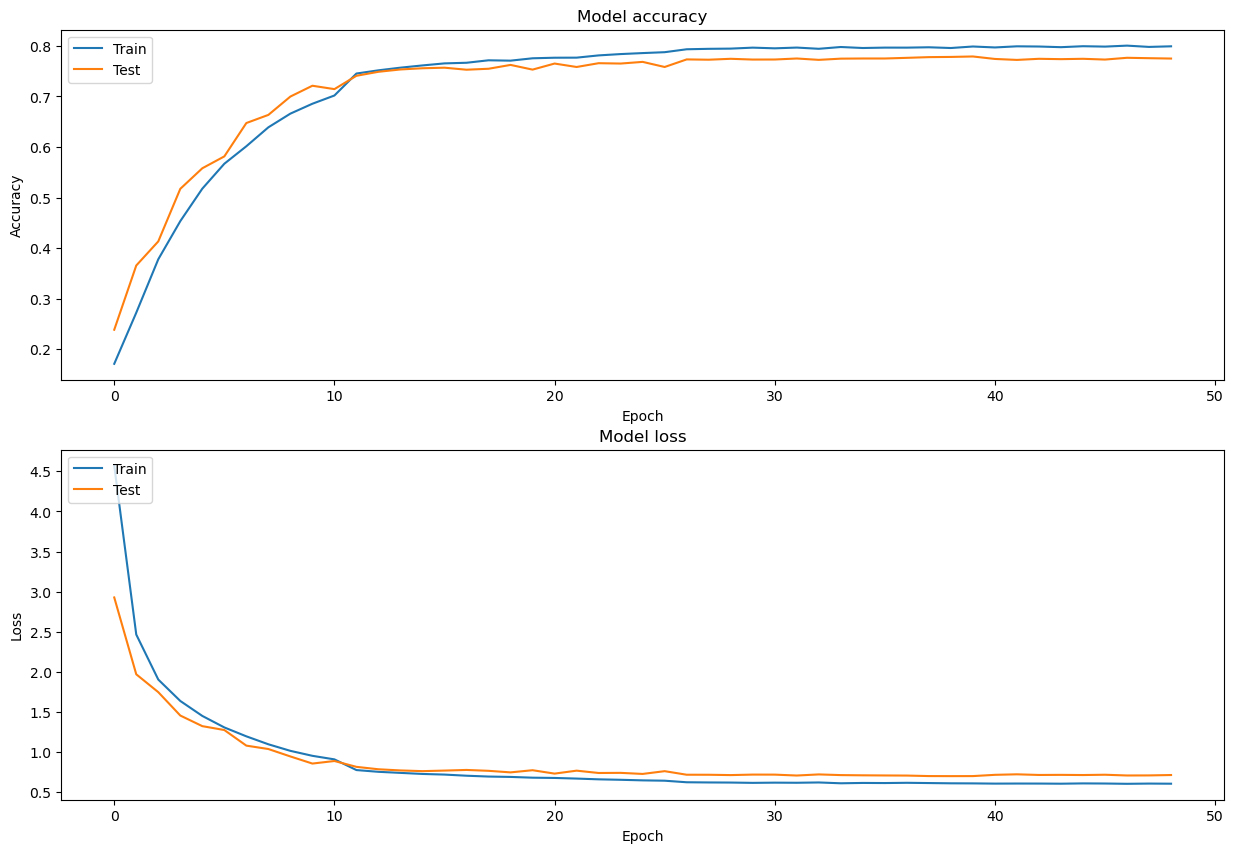

In [8]:
# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')
